In [8]:
# Frustratingly Easy Domain Adaptation
# cao bin, HKUST, China, binjacobcao@gmail.com
# free to charge for academic communication

import numpy as np
import pandas as pd 

def FEDA_features(source_file, target_file):
    """
    Generate feature-expanded datasets for domain adaptation.
    
    Args:
        source_file (str): Path to the CSV file containing source data.
        target_file (str): Path to the CSV file containing target data.
        
    Returns:
        pd.DataFrame, pd.DataFrame: Feature-expanded datasets for source and target.
    """
    # Read source data from CSV file
    source_data = pd.read_csv(source_file)
    target_data = pd.read_csv(target_file)
    source_header = source_data.columns.tolist()
    target_header = target_data.columns.tolist()
    x_source = np.array(source_data.iloc[:,:-1])
    y_source = np.array(source_data.iloc[:,-1])
    x_target = np.array(target_data.iloc[:,:-1])
    y_target = np.array(target_data.iloc[:,-1])
 
    # Expand features for source and target
    x_source_expand = np.hstack([x_source, x_source, np.zeros_like(x_source)])
    x_target_expand = np.hstack([x_target, np.zeros_like(x_target), x_target])

    # Generate expanded header
    expand_header = []
    for name in source_header[:-1]:
        expand_header.append(name + '_g')
    for name in source_header[:-1]:
        expand_header.append(name + '_s')
    for name in target_header[:-1]:
        expand_header.append(name + '_t')
    
    # Create DataFrames for expanded data
    data_source_expand = pd.DataFrame(x_source_expand, columns=expand_header)
    data_target_expand = pd.DataFrame(x_target_expand, columns=expand_header)

    # Add labels to the DataFrames
    data_source_expand[source_header[-1]] = np.array(y_source)
    data_target_expand[target_header[-1]] = np.array(y_target)

    return data_source_expand, data_target_expand


# define NN model

In [9]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Flatten

"""
define the structure of NN

in our case, input feature is 1-d and out put response is also 1-d
"""
tf.random.set_seed(420)

class FEDA_NN(Model):
    def __init__(self):
        super(FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

# generate dataset

In [10]:
from sklearn.model_selection import train_test_split

ds, dt = FEDA_features(source_file='source.csv', target_file='target.csv')
    
x_source = np.array(ds.iloc[:,:-1])
y_source = np.array(ds.iloc[:,-1])
x_target = np.array(dt.iloc[:,:-1])
y_target = np.array(dt.iloc[:,-1])

testdata = pd.read_csv('test.csv')
x_test = np.array(testdata.iloc[:,:-1])
y_test = np.array(testdata.iloc[:,-1])

S_x_train, S_x_val, S_y_train, S_y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
S_x_train = tf.convert_to_tensor(S_x_train, dtype=tf.float32)
S_y_train = tf.convert_to_tensor(S_y_train, dtype=tf.float32)
S_x_val = tf.convert_to_tensor(S_x_val, dtype=tf.float32)
S_y_val = tf.convert_to_tensor(S_y_val, dtype=tf.float32)


T_x_train, T_x_val, T_y_train, T_y_val = train_test_split(x_target, y_target, test_size=0.3, random_state=42)
T_x_train = tf.convert_to_tensor(T_x_train, dtype=tf.float32)
T_y_train = tf.convert_to_tensor(T_y_train, dtype=tf.float32)
T_x_val = tf.convert_to_tensor(T_x_val, dtype=tf.float32)
T_y_val = tf.convert_to_tensor(T_y_val, dtype=tf.float32)

# training on source domain and save the weights

In [11]:
import os
# training on the Feature-expanded source domain data
Smodel = FEDA_NN()

# comolie the model 
Smodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/source_weights.ckpt"
"""
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the param. of source domain-----------------')
    Smodel.load_weights(checkpoint_save_path)

"""
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

history = Smodel.fit(x_train, y_train, batch_size=3, epochs=300,validation_data=(x_val, y_val), validation_freq=1,
                    callbacks=[cp_callback])
Smodel.summary()

Epoch 1/300
4/4 [==============================] - 0s 26ms/step - loss: 1353.7758 - mse: 1353.7758 - val_loss: 1261.5439 - val_mse: 1261.5439
Epoch 2/300
4/4 [==============================] - 0s 6ms/step - loss: 1351.5378 - mse: 1351.5378 - val_loss: 1259.4016 - val_mse: 1259.4016
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 1349.3020 - mse: 1349.3020 - val_loss: 1257.2711 - val_mse: 1257.2711
Epoch 4/300
4/4 [==============================] - 0s 5ms/step - loss: 1347.1222 - mse: 1347.1222 - val_loss: 1255.1423 - val_mse: 1255.1423
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 1344.8984 - mse: 1344.8984 - val_loss: 1253.0294 - val_mse: 1253.0294
Epoch 6/300
4/4 [==============================] - 0s 5ms/step - loss: 1342.7402 - mse: 1342.7402 - val_loss: 1250.9202 - val_mse: 1250.9202
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 1340.5226 - mse: 1340.5226 - val_loss: 1248.8287 - val_mse: 1248.8287
Epoch 8/300


Epoch 59/300
4/4 [==============================] - 0s 5ms/step - loss: 1170.6372 - mse: 1170.6372 - val_loss: 1082.6003 - val_mse: 1082.6003
Epoch 60/300
4/4 [==============================] - 0s 5ms/step - loss: 1164.7446 - mse: 1164.7446 - val_loss: 1076.7637 - val_mse: 1076.7637
Epoch 61/300
4/4 [==============================] - 0s 5ms/step - loss: 1158.5757 - mse: 1158.5757 - val_loss: 1070.7965 - val_mse: 1070.7965
Epoch 62/300
4/4 [==============================] - 0s 5ms/step - loss: 1152.3356 - mse: 1152.3357 - val_loss: 1064.6565 - val_mse: 1064.6565
Epoch 63/300
4/4 [==============================] - 0s 5ms/step - loss: 1145.9028 - mse: 1145.9027 - val_loss: 1058.3531 - val_mse: 1058.3531
Epoch 64/300
4/4 [==============================] - 0s 5ms/step - loss: 1139.3451 - mse: 1139.3451 - val_loss: 1051.8474 - val_mse: 1051.8474
Epoch 65/300
4/4 [==============================] - 0s 5ms/step - loss: 1132.5100 - mse: 1132.5100 - val_loss: 1045.2126 - val_mse: 1045.2126
Epoch 

Epoch 118/300
4/4 [==============================] - 0s 5ms/step - loss: 573.9961 - mse: 573.9961 - val_loss: 506.8017 - val_mse: 506.8017
Epoch 119/300
4/4 [==============================] - 0s 5ms/step - loss: 561.4788 - mse: 561.4788 - val_loss: 494.9960 - val_mse: 494.9960
Epoch 120/300
4/4 [==============================] - 0s 5ms/step - loss: 549.1256 - mse: 549.1256 - val_loss: 483.3383 - val_mse: 483.3383
Epoch 121/300
4/4 [==============================] - 0s 5ms/step - loss: 536.7076 - mse: 536.7076 - val_loss: 471.7756 - val_mse: 471.7756
Epoch 122/300
4/4 [==============================] - 0s 5ms/step - loss: 524.4640 - mse: 524.4640 - val_loss: 460.2298 - val_mse: 460.2298
Epoch 123/300
4/4 [==============================] - 0s 5ms/step - loss: 512.3531 - mse: 512.3531 - val_loss: 448.7077 - val_mse: 448.7077
Epoch 124/300
4/4 [==============================] - 0s 5ms/step - loss: 500.1173 - mse: 500.1173 - val_loss: 437.3083 - val_mse: 437.3083
Epoch 125/300
4/4 [========

Epoch 239/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3358 - mse: 6.3358 - val_loss: 1.1099 - val_mse: 1.1099
Epoch 240/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3043 - mse: 6.3043 - val_loss: 1.1407 - val_mse: 1.1407
Epoch 241/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2739 - mse: 6.2739 - val_loss: 1.1725 - val_mse: 1.1725
Epoch 242/300
4/4 [==============================] - 0s 4ms/step - loss: 6.2486 - mse: 6.2486 - val_loss: 1.2082 - val_mse: 1.2082
Epoch 243/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2254 - mse: 6.2254 - val_loss: 1.2461 - val_mse: 1.2461
Epoch 244/300
4/4 [==============================] - 0s 3ms/step - loss: 6.1841 - mse: 6.1841 - val_loss: 1.2630 - val_mse: 1.2630
Epoch 245/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1741 - mse: 6.1741 - val_loss: 1.2823 - val_mse: 1.2823
Epoch 246/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1599 - m

 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  16        
                                                                 
 dense_1 (Dense)             multiple                  15        
                                                                 
 dense_2 (Dense)             multiple                  4         
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Smodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 47ms/step
[[32.866447]
 [32.545837]]
Root Mean Squared Error: 5.114044384675083


# plot the loss

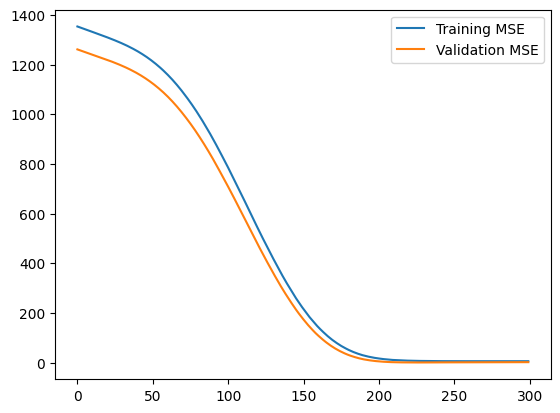

In [7]:
from matplotlib import pyplot as plt

mse_S = history.history['mse']
val_mse_S = history.history['val_mse']
loss_S = history.history['loss']
val_loss_S =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_S,label='Training MSE')
plt.plot(val_mse_S,label='Validation MSE')
plt.legend()
plt.savefig('Sdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Sdomain_loss.svg',bbox_inches = 'tight',dpi=600)

# transfer to target domain

## define L2 Loss :

In [8]:

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of source domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of source domain-----------------
Layer: dense
[array([[-1.4991595 ,  2.6635475 ,  1.0278542 , -1.7998044 ],
       [-1.8269482 ,  1.1425062 ,  3.1675317 ,  0.16922665],
       [ 0.10313631,  0.7004749 ,  0.8891627 , -0.15022126]],
      dtype=float32), array([-1.1099403 ,  1.0126255 ,  0.87590355, -0.8496216 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[-1.2130995 , -1.541604  , -1.1141932 ],
       [ 2.7016797 ,  1.9198126 ,  0.5121494 ],
       [ 1.2966318 ,  3.77212   ,  0.09696086],
       [-0.8903979 ,  1.531695  , -2.9293997 ]], dtype=float32), array([0.7908309, 1.0010245, 0.7351754], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[1.3971769],
       [1.0204301],
       [1.6852666]], dtype=float32), array([0.5939082], dtype=float32)]
--------------------------------------------------


In [9]:
class KernelRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, initial_weights, l2_factor):
        self.initial_weights = initial_weights
        self.l2_factor = l2_factor
    
    def __call__(self, weights):
        initial_weights_flat = tf.reshape(tf.convert_to_tensor(self.initial_weights), shape=(-1,))
        weights_flat = tf.reshape(weights, shape=(-1,))
        regularization = tf.reduce_sum(tf.square(weights_flat - initial_weights_flat))
        l2_regularization = self.l2_factor * tf.reduce_sum(tf.square(weights))
        return regularization + l2_regularization
    
    def get_config(self):
        return {'initial_weights': self.initial_weights, 'l2_factor': self.l2_factor}


## define model on target domain :

In [10]:

# Adjust the strength of L2 regularization as needed
l2_reg_factor = 0.1  


class Transfer_FEDA_NN(Model):
    def __init__(self):
        super(Transfer_FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y



In [14]:
# Create the model
Tmodel = Transfer_FEDA_NN()

Tmodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'],
             )


checkpoint_save_path = "./checkpoint/target_weights.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model
Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])

# Print model summary
Tmodel.summary()

Epoch 1/900
1/1 [==============================] - 0s 219ms/step - loss: 1858.4861 - mse: 1774.1968 - val_loss: 1367.8035 - val_mse: 1283.5280
Epoch 2/900
1/1 [==============================] - 0s 16ms/step - loss: 1857.0729 - mse: 1772.7974 - val_loss: 1366.6373 - val_mse: 1282.3756
Epoch 3/900
1/1 [==============================] - 0s 17ms/step - loss: 1855.6606 - mse: 1771.3989 - val_loss: 1365.4720 - val_mse: 1281.2242
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1854.2490 - mse: 1770.0012 - val_loss: 1364.3079 - val_mse: 1280.0737
Epoch 5/900
1/1 [==============================] - 0s 17ms/step - loss: 1852.8386 - mse: 1768.6045 - val_loss: 1363.1444 - val_mse: 1278.9237
Epoch 6/900
1/1 [==============================] - 0s 17ms/step - loss: 1851.4294 - mse: 1767.2087 - val_loss: 1361.9821 - val_mse: 1277.7748
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1850.0211 - mse: 1765.8138 - val_loss: 1360.8203 - val_mse: 1276.6263
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 1694.5735 - mse: 1610.1965 - val_loss: 1232.8541 - val_mse: 1148.4579
Epoch 116/900
1/1 [==============================] - 0s 15ms/step - loss: 1692.9929 - mse: 1608.5967 - val_loss: 1231.5549 - val_mse: 1147.1392
Epoch 117/900
1/1 [==============================] - 0s 15ms/step - loss: 1691.4075 - mse: 1606.9917 - val_loss: 1230.2527 - val_mse: 1145.8168
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1689.8181 - mse: 1605.3822 - val_loss: 1228.9464 - val_mse: 1144.4900
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1688.2238 - mse: 1603.7673 - val_loss: 1227.6370 - val_mse: 1143.1593
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1686.6252 - mse: 1602.1477 - val_loss: 1226.3232 - val_mse: 1141.8245
Epoch 121/900
1/1 [==============================] - 0s 16ms/step - loss: 1685.0216 - mse: 1600.5228 - val_loss: 1225.0065 - val_mse: 1140.4856
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1596.2388 - mse: 1510.1348 - val_loss: 1152.2213 - val_mse: 1066.0771
Epoch 173/900
1/1 [==============================] - 0s 16ms/step - loss: 1594.3462 - mse: 1508.2020 - val_loss: 1150.6727 - val_mse: 1064.4882
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1592.4473 - mse: 1506.2627 - val_loss: 1149.1194 - val_mse: 1062.8942
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1590.5419 - mse: 1504.3167 - val_loss: 1147.5607 - val_mse: 1061.2947
Epoch 176/900
1/1 [==============================] - 0s 15ms/step - loss: 1588.6301 - mse: 1502.3641 - val_loss: 1145.9972 - val_mse: 1059.6899
Epoch 177/900
1/1 [==============================] - 0s 15ms/step - loss: 1586.7120 - mse: 1500.4048 - val_loss: 1144.4286 - val_mse: 1058.0800
Epoch 178/900
1/1 [==============================] - 0s 15ms/step - loss: 1584.7876 - mse: 1498.4390 - val_loss: 1142.8547 - val_mse: 10

1/1 [==============================] - 0s 16ms/step - loss: 1477.8188 - mse: 1389.0874 - val_loss: 1055.6127 - val_mse: 966.8302
Epoch 230/900
1/1 [==============================] - 0s 16ms/step - loss: 1475.5428 - mse: 1386.7605 - val_loss: 1053.7617 - val_mse: 964.9283
Epoch 231/900
1/1 [==============================] - 0s 15ms/step - loss: 1473.2601 - mse: 1384.4268 - val_loss: 1051.9056 - val_mse: 963.0209
Epoch 232/900
1/1 [==============================] - 0s 15ms/step - loss: 1470.9705 - mse: 1382.0857 - val_loss: 1050.0439 - val_mse: 961.1078
Epoch 233/900
1/1 [==============================] - 0s 15ms/step - loss: 1468.6738 - mse: 1379.7378 - val_loss: 1048.1768 - val_mse: 959.1891
Epoch 234/900
1/1 [==============================] - 0s 16ms/step - loss: 1466.3702 - mse: 1377.3826 - val_loss: 1046.3043 - val_mse: 957.2650
Epoch 235/900
1/1 [==============================] - 0s 16ms/step - loss: 1464.0594 - mse: 1375.0201 - val_loss: 1044.4263 - val_mse: 955.3352
Epoch 236/900

Epoch 344/900
1/1 [==============================] - 0s 16ms/step - loss: 1170.6375 - mse: 1075.2928 - val_loss: 808.3583 - val_mse: 712.9501
Epoch 345/900
1/1 [==============================] - 0s 16ms/step - loss: 1167.5834 - mse: 1072.1752 - val_loss: 805.9308 - val_mse: 710.4590
Epoch 346/900
1/1 [==============================] - 0s 16ms/step - loss: 1164.5234 - mse: 1069.0518 - val_loss: 803.4994 - val_mse: 707.9638
Epoch 347/900
1/1 [==============================] - 0s 16ms/step - loss: 1161.4576 - mse: 1065.9220 - val_loss: 801.0641 - val_mse: 705.4647
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1158.3860 - mse: 1062.7865 - val_loss: 798.6249 - val_mse: 702.9614
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1155.3085 - mse: 1059.6450 - val_loss: 796.1817 - val_mse: 700.4542
Epoch 350/900
1/1 [==============================] - 0s 16ms/step - loss: 1152.2256 - mse: 1056.4979 - val_loss: 793.7349 - val_mse: 697.9431
Epoch 

Epoch 402/900
1/1 [==============================] - 0s 15ms/step - loss: 984.9629 - mse: 885.7833 - val_loss: 662.2124 - val_mse: 562.9645
Epoch 403/900
1/1 [==============================] - 0s 16ms/step - loss: 981.6364 - mse: 882.3885 - val_loss: 659.6238 - val_mse: 560.3074
Epoch 404/900
1/1 [==============================] - 0s 15ms/step - loss: 978.3070 - mse: 878.9907 - val_loss: 657.0340 - val_mse: 557.6490
Epoch 405/900
1/1 [==============================] - 0s 16ms/step - loss: 974.9747 - mse: 875.5897 - val_loss: 654.4429 - val_mse: 554.9894
Epoch 406/900
1/1 [==============================] - 0s 15ms/step - loss: 971.6393 - mse: 872.1858 - val_loss: 651.8508 - val_mse: 552.3286
Epoch 407/900
1/1 [==============================] - 0s 16ms/step - loss: 968.3010 - mse: 868.7788 - val_loss: 649.2575 - val_mse: 549.6666
Epoch 408/900
1/1 [==============================] - 0s 15ms/step - loss: 964.9599 - mse: 865.3690 - val_loss: 646.6634 - val_mse: 547.0037
Epoch 409/900
1/1 [=

1/1 [==============================] - 0s 15ms/step - loss: 599.1779 - mse: 491.8516 - val_loss: 372.2333 - val_mse: 264.8371
Epoch 519/900
1/1 [==============================] - 0s 16ms/step - loss: 596.0571 - mse: 488.6609 - val_loss: 370.0018 - val_mse: 262.5358
Epoch 520/900
1/1 [==============================] - 0s 16ms/step - loss: 592.9436 - mse: 485.4777 - val_loss: 367.7778 - val_mse: 260.2421
Epoch 521/900
1/1 [==============================] - 0s 16ms/step - loss: 589.8372 - mse: 482.3014 - val_loss: 365.5616 - val_mse: 257.9562
Epoch 522/900
1/1 [==============================] - 0s 15ms/step - loss: 586.7381 - mse: 479.1327 - val_loss: 363.3532 - val_mse: 255.6782
Epoch 523/900
1/1 [==============================] - 0s 15ms/step - loss: 583.6465 - mse: 475.9716 - val_loss: 361.1527 - val_mse: 253.4081
Epoch 524/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5624 - mse: 472.8178 - val_loss: 358.9601 - val_mse: 251.1460
Epoch 525/900
1/1 [===============

Epoch 635/900
1/1 [==============================] - 0s 16ms/step - loss: 301.5566 - mse: 186.7458 - val_loss: 177.0127 - val_mse: 62.1470
Epoch 636/900
1/1 [==============================] - 0s 15ms/step - loss: 299.7156 - mse: 184.8500 - val_loss: 175.9871 - val_mse: 61.0667
Epoch 637/900
1/1 [==============================] - 0s 16ms/step - loss: 297.8875 - mse: 182.9672 - val_loss: 174.9725 - val_mse: 59.9976
Epoch 638/900
1/1 [==============================] - 0s 15ms/step - loss: 296.0723 - mse: 181.0974 - val_loss: 173.9689 - val_mse: 58.9398
Epoch 639/900
1/1 [==============================] - 0s 15ms/step - loss: 294.2700 - mse: 179.2408 - val_loss: 172.9763 - val_mse: 57.8931
Epoch 640/900
1/1 [==============================] - 0s 15ms/step - loss: 292.4805 - mse: 177.3972 - val_loss: 171.9948 - val_mse: 56.8577
Epoch 641/900
1/1 [==============================] - 0s 15ms/step - loss: 290.7038 - mse: 175.5667 - val_loss: 171.0243 - val_mse: 55.8335
Epoch 642/900
1/1 [========

Epoch 694/900
1/1 [==============================] - 0s 16ms/step - loss: 214.3311 - mse: 96.6682 - val_loss: 134.2907 - val_mse: 16.5868
Epoch 695/900
1/1 [==============================] - 0s 16ms/step - loss: 213.2093 - mse: 95.5054 - val_loss: 133.8515 - val_mse: 16.1069
Epoch 696/900
1/1 [==============================] - 0s 15ms/step - loss: 212.0984 - mse: 94.3539 - val_loss: 133.4207 - val_mse: 15.6356
Epoch 697/900
1/1 [==============================] - 0s 15ms/step - loss: 210.9986 - mse: 93.2136 - val_loss: 132.9981 - val_mse: 15.1730
Epoch 698/900
1/1 [==============================] - 0s 16ms/step - loss: 209.9096 - mse: 92.0844 - val_loss: 132.5838 - val_mse: 14.7188
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 208.8315 - mse: 90.9664 - val_loss: 132.1777 - val_mse: 14.2731
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 207.7641 - mse: 89.8594 - val_loss: 131.7797 - val_mse: 13.8357
Epoch 701/900
1/1 [===============

Epoch 754/900
1/1 [==============================] - 0s 16ms/step - loss: 164.4730 - mse: 44.8353 - val_loss: 120.4695 - val_mse: 0.8074
Epoch 755/900
1/1 [==============================] - 0s 15ms/step - loss: 163.9038 - mse: 44.2417 - val_loss: 120.4134 - val_mse: 0.7272
Epoch 756/900
1/1 [==============================] - 0s 15ms/step - loss: 163.3418 - mse: 43.6557 - val_loss: 120.3616 - val_mse: 0.6515
Epoch 757/900
1/1 [==============================] - 0s 15ms/step - loss: 162.7871 - mse: 43.0770 - val_loss: 120.3141 - val_mse: 0.5804
Epoch 758/900
1/1 [==============================] - 0s 15ms/step - loss: 162.2394 - mse: 42.5057 - val_loss: 120.2707 - val_mse: 0.5137
Epoch 759/900
1/1 [==============================] - 0s 15ms/step - loss: 161.6987 - mse: 41.9416 - val_loss: 120.2315 - val_mse: 0.4514
Epoch 760/900
1/1 [==============================] - 0s 16ms/step - loss: 161.1649 - mse: 41.3849 - val_loss: 120.1963 - val_mse: 0.3934
Epoch 761/900
1/1 [======================

Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 140.9079 - mse: 20.2844 - val_loss: 122.6675 - val_mse: 2.0354
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 140.6611 - mse: 20.0291 - val_loss: 122.7669 - val_mse: 2.1267
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 140.4178 - mse: 19.7775 - val_loss: 122.8675 - val_mse: 2.2192
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 140.1782 - mse: 19.5299 - val_loss: 122.9691 - val_mse: 2.3130
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 139.9420 - mse: 19.2859 - val_loss: 123.0717 - val_mse: 2.4081
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 139.7094 - mse: 19.0458 - val_loss: 123.1753 - val_mse: 2.5044
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 139.4802 - mse: 18.8093 - val_loss: 123.2798 - val_mse: 2.6019
Epoch 821/900
1/1 [======================

Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 131.0850 - mse: 10.3503 - val_loss: 129.4565 - val_mse: 8.7261
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 130.9850 - mse: 10.2546 - val_loss: 129.5683 - val_mse: 8.8425
Epoch 876/900
1/1 [==============================] - 0s 11ms/step - loss: 130.8863 - mse: 10.1605 - val_loss: 129.6797 - val_mse: 8.9586
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 130.7891 - mse: 10.0680 - val_loss: 129.7906 - val_mse: 9.0745
Epoch 878/900
1/1 [==============================] - 0s 11ms/step - loss: 130.6934 - mse: 9.9772 - val_loss: 129.9012 - val_mse: 9.1901
Epoch 879/900
1/1 [==============================] - 0s 11ms/step - loss: 130.5990 - mse: 9.8879 - val_loss: 130.0112 - val_mse: 9.3054
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 130.5059 - mse: 9.8000 - val_loss: 130.1208 - val_mse: 9.4204
Epoch 881/900
1/1 [=========================

In [15]:
checkpoint_save_path = "./checkpoint/target_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[-2.4419835 ,  1.0452218 ,  0.03550817, -1.0983334 ],
       [-0.5895215 , -0.41218024,  1.2093245 ,  0.16136958],
       [-1.8732526 ,  2.07237   , -0.9945138 , -2.2563884 ]],
      dtype=float32), array([-0.9715973 ,  0.5125024 , -0.74442214, -0.9069544 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0340223 ,  1.9490347 , -0.10054011],
       [-1.509545  , -1.4946944 ,  0.9983297 ],
       [ 0.20673124,  2.0077188 ,  2.5072706 ],
       [ 1.8774416 ,  1.1954017 ,  0.36315027]], dtype=float32), array([-0.6684077 , -0.65233576, -0.57671916], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[-1.9879953],
       [-2.2959893],
       [-1.7467483]], dtype=float32), array([0.5723585], dtype=float32)]
--------------------------------------------------


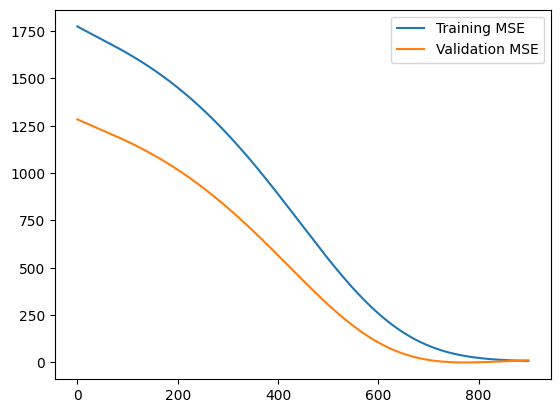

In [16]:
from matplotlib import pyplot as plt

mse_T = Transfer_history.history['mse']
val_mse_T = Transfer_history.history['val_mse']
loss_T = Transfer_history.history['loss']
val_loss_T =  Transfer_history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_T,label='Training MSE')
plt.plot(val_mse_T,label='Validation MSE')
plt.legend()
plt.savefig('Tdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Tdomain_loss.svg',bbox_inches = 'tight',dpi=600)

In [17]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Tmodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 61ms/step
[[39.996243]
 [39.486282]]
Root Mean Squared Error: 3.044639338348102


# compare to a base-line model

In [18]:

class base_NN(Model):
    def __init__(self):
        super(base_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

In [20]:
# train the model on target domain data directly and test on test data
model = base_NN()

# comolie the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/base_weights.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])
model.summary()

Epoch 1/900
1/1 [==============================] - 0s 164ms/step - loss: 1724.0786 - mse: 1724.0786 - val_loss: 1245.0331 - val_mse: 1245.0331
Epoch 2/900
1/1 [==============================] - 0s 15ms/step - loss: 1723.4272 - mse: 1723.4272 - val_loss: 1244.4867 - val_mse: 1244.4867
Epoch 3/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.7737 - mse: 1722.7737 - val_loss: 1243.9385 - val_mse: 1243.9385
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.1180 - mse: 1722.1180 - val_loss: 1243.3881 - val_mse: 1243.3881
Epoch 5/900
1/1 [==============================] - 0s 16ms/step - loss: 1721.4598 - mse: 1721.4598 - val_loss: 1242.8352 - val_mse: 1242.8352
Epoch 6/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.7988 - mse: 1720.7988 - val_loss: 1242.2804 - val_mse: 1242.2804
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.1353 - mse: 1720.1353 - val_loss: 1241.7233 - val_mse: 1241.7233
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1613.7529 - mse: 1613.7529 - val_loss: 1152.4178 - val_mse: 1152.4178
Epoch 116/900
1/1 [==============================] - 0s 16ms/step - loss: 1612.3347 - mse: 1612.3347 - val_loss: 1151.2310 - val_mse: 1151.2310
Epoch 117/900
1/1 [==============================] - 0s 16ms/step - loss: 1610.9067 - mse: 1610.9067 - val_loss: 1150.0364 - val_mse: 1150.0364
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1609.4695 - mse: 1609.4695 - val_loss: 1148.8339 - val_mse: 1148.8339
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1608.0225 - mse: 1608.0225 - val_loss: 1147.6234 - val_mse: 1147.6234
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1606.5660 - mse: 1606.5660 - val_loss: 1146.4052 - val_mse: 1146.4052
Epoch 121/900
1/1 [==============================] - 0s 15ms/step - loss: 1605.1000 - mse: 1605.1000 - val_loss: 1145.1790 - val_mse: 1145.1790
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1516.9044 - mse: 1516.9044 - val_loss: 1071.6277 - val_mse: 1071.6277
Epoch 173/900
1/1 [==============================] - 0s 15ms/step - loss: 1514.9012 - mse: 1514.9012 - val_loss: 1069.9620 - val_mse: 1069.9620
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1512.8870 - mse: 1512.8870 - val_loss: 1068.2874 - val_mse: 1068.2874
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1510.8619 - mse: 1510.8619 - val_loss: 1066.6039 - val_mse: 1066.6039
Epoch 176/900
1/1 [==============================] - 0s 16ms/step - loss: 1508.8259 - mse: 1508.8259 - val_loss: 1064.9114 - val_mse: 1064.9114
Epoch 177/900
1/1 [==============================] - 0s 16ms/step - loss: 1506.7788 - mse: 1506.7788 - val_loss: 1063.2103 - val_mse: 1063.2103
Epoch 178/900
1/1 [==============================] - 0s 16ms/step - loss: 1504.7209 - mse: 1504.7209 - val_loss: 1061.5005 - val_mse: 10

Epoch 287/900
1/1 [==============================] - 0s 15ms/step - loss: 1215.4147 - mse: 1215.4147 - val_loss: 823.5555 - val_mse: 823.5555
Epoch 288/900
1/1 [==============================] - 0s 16ms/step - loss: 1212.1992 - mse: 1212.1992 - val_loss: 820.9406 - val_mse: 820.9406
Epoch 289/900
1/1 [==============================] - 0s 15ms/step - loss: 1208.9746 - mse: 1208.9746 - val_loss: 818.3190 - val_mse: 818.3190
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1205.7410 - mse: 1205.7410 - val_loss: 815.6911 - val_mse: 815.6911
Epoch 291/900
1/1 [==============================] - 0s 15ms/step - loss: 1202.4988 - mse: 1202.4988 - val_loss: 813.0565 - val_mse: 813.0565
Epoch 292/900
1/1 [==============================] - 0s 16ms/step - loss: 1199.2477 - mse: 1199.2477 - val_loss: 810.4155 - val_mse: 810.4155
Epoch 293/900
1/1 [==============================] - 0s 15ms/step - loss: 1195.9877 - mse: 1195.9877 - val_loss: 807.7683 - val_mse: 807.7683
Epoch 

Epoch 345/900
1/1 [==============================] - 0s 15ms/step - loss: 1015.8777 - mse: 1015.8777 - val_loss: 662.7643 - val_mse: 662.7643
Epoch 346/900
1/1 [==============================] - 0s 15ms/step - loss: 1012.2429 - mse: 1012.2429 - val_loss: 659.8655 - val_mse: 659.8655
Epoch 347/900
1/1 [==============================] - 0s 15ms/step - loss: 1008.6030 - mse: 1008.6030 - val_loss: 656.9638 - val_mse: 656.9638
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1004.9581 - mse: 1004.9581 - val_loss: 654.0593 - val_mse: 654.0593
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1001.3083 - mse: 1001.3083 - val_loss: 651.1520 - val_mse: 651.1520
Epoch 350/900
1/1 [==============================] - 0s 15ms/step - loss: 997.6537 - mse: 997.6537 - val_loss: 648.2421 - val_mse: 648.2421
Epoch 351/900
1/1 [==============================] - 0s 14ms/step - loss: 993.9943 - mse: 993.9943 - val_loss: 645.3298 - val_mse: 645.3298
Epoch 352/

1/1 [==============================] - 0s 16ms/step - loss: 584.1605 - mse: 584.1605 - val_loss: 328.9877 - val_mse: 328.9877
Epoch 462/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5804 - mse: 580.5804 - val_loss: 326.3359 - val_mse: 326.3359
Epoch 463/900
1/1 [==============================] - 0s 15ms/step - loss: 577.0067 - mse: 577.0067 - val_loss: 323.6916 - val_mse: 323.6916
Epoch 464/900
1/1 [==============================] - 0s 15ms/step - loss: 573.4395 - mse: 573.4395 - val_loss: 321.0549 - val_mse: 321.0549
Epoch 465/900
1/1 [==============================] - 0s 15ms/step - loss: 569.8793 - mse: 569.8793 - val_loss: 318.4255 - val_mse: 318.4255
Epoch 466/900
1/1 [==============================] - 0s 15ms/step - loss: 566.3257 - mse: 566.3257 - val_loss: 315.8040 - val_mse: 315.8040
Epoch 467/900
1/1 [==============================] - 0s 15ms/step - loss: 562.7792 - mse: 562.7792 - val_loss: 313.1901 - val_mse: 313.1901
Epoch 468/900
1/1 [===============

Epoch 578/900
1/1 [==============================] - 0s 15ms/step - loss: 232.2327 - mse: 232.2327 - val_loss: 86.6766 - val_mse: 86.6766
Epoch 579/900
1/1 [==============================] - 0s 15ms/step - loss: 229.9606 - mse: 229.9606 - val_loss: 85.3032 - val_mse: 85.3032
Epoch 580/900
1/1 [==============================] - 0s 16ms/step - loss: 227.7027 - mse: 227.7027 - val_loss: 83.9425 - val_mse: 83.9425
Epoch 581/900
1/1 [==============================] - 0s 16ms/step - loss: 225.4590 - mse: 225.4590 - val_loss: 82.5944 - val_mse: 82.5944
Epoch 582/900
1/1 [==============================] - 0s 16ms/step - loss: 223.2293 - mse: 223.2293 - val_loss: 81.2589 - val_mse: 81.2589
Epoch 583/900
1/1 [==============================] - 0s 15ms/step - loss: 221.0138 - mse: 221.0138 - val_loss: 79.9361 - val_mse: 79.9361
Epoch 584/900
1/1 [==============================] - 0s 15ms/step - loss: 218.8124 - mse: 218.8124 - val_loss: 78.6258 - val_mse: 78.6258
Epoch 585/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 56.2070 - mse: 56.2070 - val_loss: 2.4629 - val_mse: 2.4629
Epoch 698/900
1/1 [==============================] - 0s 15ms/step - loss: 55.4342 - mse: 55.4342 - val_loss: 2.3001 - val_mse: 2.3001
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 54.6708 - mse: 54.6708 - val_loss: 2.1436 - val_mse: 2.1436
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 53.9166 - mse: 53.9166 - val_loss: 1.9933 - val_mse: 1.9933
Epoch 701/900
1/1 [==============================] - 0s 15ms/step - loss: 53.1715 - mse: 53.1715 - val_loss: 1.8491 - val_mse: 1.8491
Epoch 702/900
1/1 [==============================] - 0s 15ms/step - loss: 52.4356 - mse: 52.4356 - val_loss: 1.7109 - val_mse: 1.7109
Epoch 703/900
1/1 [==============================] - 0s 15ms/step - loss: 51.7087 - mse: 51.7087 - val_loss: 1.5787 - val_mse: 1.5787
Epoch 704/900
1/1 [==============================] - 0s 15ms/step - loss: 50

1/1 [==============================] - 0s 10ms/step - loss: 10.4924 - mse: 10.4924 - val_loss: 9.3948 - val_mse: 9.3948
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 10.3729 - mse: 10.3729 - val_loss: 9.5424 - val_mse: 9.5424
Epoch 821/900
1/1 [==============================] - 0s 10ms/step - loss: 10.2555 - mse: 10.2555 - val_loss: 9.6898 - val_mse: 9.6898
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 10.1403 - mse: 10.1403 - val_loss: 9.8372 - val_mse: 9.8372
Epoch 823/900
1/1 [==============================] - 0s 11ms/step - loss: 10.0272 - mse: 10.0272 - val_loss: 9.9844 - val_mse: 9.9844
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 9.9161 - mse: 9.9161 - val_loss: 10.1315 - val_mse: 10.1315
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 9.8071 - mse: 9.8071 - val_loss: 10.2785 - val_mse: 10.2785
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 9.

In [21]:
checkpoint_save_path = "./checkpoint/base_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[ 1.5900205 ,  0.43349168, -0.10656261, -1.9314315 ],
       [-1.3661724 , -0.24307795, -0.52149826, -2.6355495 ],
       [ 0.3268072 ,  1.2236819 , -2.5442488 , -0.4259405 ]],
      dtype=float32), array([ 0.9933263 ,  0.8314561 , -0.9642661 , -0.76830345], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0837977 , -1.1772916 , -0.9728091 ],
       [ 1.2865251 , -1.3440601 , -2.2469766 ],
       [-0.25653574,  1.6874207 ,  1.1258876 ],
       [-2.3448632 ,  1.3316195 ,  2.5531275 ]], dtype=float32), array([ 0.6704736 , -0.655048  , -0.70068955], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[ 1.7008991],
       [-1.8051839],
       [-1.4356333]], dtype=float32), array([0.5421374], dtype=float32)]
--------------------------------------------------


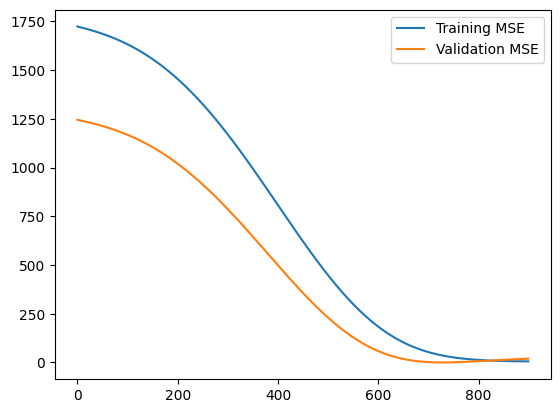

In [22]:
from matplotlib import pyplot as plt

mse_base = history.history['mse']
val_mse_base = history.history['val_mse']
loss_base = history.history['loss']
val_loss_base =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_base,label='Training MSE')
plt.plot(val_mse_base,label='Validation MSE')
plt.legend()
plt.savefig('base_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('base_loss.svg',bbox_inches = 'tight',dpi=600)

In [23]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = model.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 20ms/step
[[40.86536 ]
 [40.437786]]
Root Mean Squared Error: 3.7558661484884266


# The following is an additional calculation （Aug 30 2023）

## search the best hyperparameter

In [3]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Flatten

In [4]:
class KernelRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, initial_weights, l2_factor):
        self.initial_weights = initial_weights
        self.l2_factor = l2_factor
    
    def __call__(self, weights):
        initial_weights_flat = tf.reshape(tf.convert_to_tensor(self.initial_weights), shape=(-1,))
        weights_flat = tf.reshape(weights, shape=(-1,))
        regularization = tf.reduce_sum(tf.square(weights_flat - initial_weights_flat))
        l2_regularization = self.l2_factor * tf.reduce_sum(tf.square(weights))
        return regularization + l2_regularization
    
    def get_config(self):
        return {'initial_weights': self.initial_weights, 'l2_factor': self.l2_factor}


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

lammda_list = []
rmse = []
tf.random.set_seed(420)
for lammda in np.arange(0.01, 1.0, 0.02):
    lammda_list.append(lammda)
    l2_reg_factor = lammda 
    class Transfer_FEDA_NN(Model):
        def __init__(self):
            super(Transfer_FEDA_NN, self).__init__()
            self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
            self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
            self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
        def call(self, x):
            x = self.f1(x)
            x = self.f2(x)
            y = self.f3(x)
            return y

    # Create the model
    Tmodel = Transfer_FEDA_NN()

    Tmodel.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mse'],
                 )

    # Train the model
    Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                         validation_freq=1,)
    pre = Tmodel.predict(T_x_val)
    mse = mean_squared_error(T_y_val, pre)
    rmse.append(np.sqrt(mse))


Epoch 1/900
1/1 [==============================] - 0s 227ms/step - loss: 1787.4575 - mse: 1690.6321 - val_loss: 1315.7606 - val_mse: 1218.9489
Epoch 2/900
1/1 [==============================] - 0s 13ms/step - loss: 1786.7683 - mse: 1689.9565 - val_loss: 1315.1892 - val_mse: 1218.3911
Epoch 3/900
1/1 [==============================] - 0s 10ms/step - loss: 1786.0786 - mse: 1689.2805 - val_loss: 1314.6172 - val_mse: 1217.8328
Epoch 4/900
1/1 [==============================] - 0s 13ms/step - loss: 1785.3882 - mse: 1688.6038 - val_loss: 1314.0448 - val_mse: 1217.2743
Epoch 5/900
1/1 [==============================] - 0s 13ms/step - loss: 1784.6973 - mse: 1687.9268 - val_loss: 1313.4717 - val_mse: 1216.7151
Epoch 6/900
1/1 [==============================] - 0s 12ms/step - loss: 1784.0056 - mse: 1687.2490 - val_loss: 1312.8982 - val_mse: 1216.1558
Epoch 7/900
1/1 [==============================] - 0s 12ms/step - loss: 1783.3132 - mse: 1686.5708 - val_loss: 1312.3236 - val_mse: 1215.5957
Epoch

1/1 [==============================] - 0s 10ms/step - loss: 1745.2821 - mse: 1649.5127 - val_loss: 1280.6262 - val_mse: 1184.8760
Epoch 59/900
1/1 [==============================] - 0s 11ms/step - loss: 1744.4512 - mse: 1648.7009 - val_loss: 1279.9329 - val_mse: 1184.2012
Epoch 60/900
1/1 [==============================] - 0s 12ms/step - loss: 1743.6162 - mse: 1647.8845 - val_loss: 1279.2357 - val_mse: 1183.5226
Epoch 61/900
1/1 [==============================] - 0s 11ms/step - loss: 1742.7760 - mse: 1647.0629 - val_loss: 1278.5347 - val_mse: 1182.8400
Epoch 62/900
1/1 [==============================] - 0s 10ms/step - loss: 1741.9313 - mse: 1646.2366 - val_loss: 1277.8296 - val_mse: 1182.1528
Epoch 63/900
1/1 [==============================] - 0s 11ms/step - loss: 1741.0818 - mse: 1645.4050 - val_loss: 1277.1208 - val_mse: 1181.4618
Epoch 64/900
1/1 [==============================] - 0s 11ms/step - loss: 1740.2274 - mse: 1644.5684 - val_loss: 1276.4078 - val_mse: 1180.7664
Epoch 65/900

1/1 [==============================] - 0s 10ms/step - loss: 1688.7950 - mse: 1593.5326 - val_loss: 1233.6105 - val_mse: 1138.3438
Epoch 116/900
1/1 [==============================] - 0s 11ms/step - loss: 1687.6124 - mse: 1592.3457 - val_loss: 1232.6294 - val_mse: 1137.3578
Epoch 117/900
1/1 [==============================] - 0s 12ms/step - loss: 1686.4220 - mse: 1591.1504 - val_loss: 1231.6418 - val_mse: 1136.3651
Epoch 118/900
1/1 [==============================] - 0s 11ms/step - loss: 1685.2242 - mse: 1589.9475 - val_loss: 1230.6484 - val_mse: 1135.3661
Epoch 119/900
1/1 [==============================] - 0s 10ms/step - loss: 1684.0187 - mse: 1588.7363 - val_loss: 1229.6490 - val_mse: 1134.3604
Epoch 120/900
1/1 [==============================] - 0s 11ms/step - loss: 1682.8060 - mse: 1587.5173 - val_loss: 1228.6434 - val_mse: 1133.3483
Epoch 121/900
1/1 [==============================] - 0s 11ms/step - loss: 1681.5852 - mse: 1586.2900 - val_loss: 1227.6313 - val_mse: 1132.3290
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 11ms/step - loss: 1608.1036 - mse: 1511.8633 - val_loss: 1166.9128 - val_mse: 1070.6434
Epoch 173/900
1/1 [==============================] - 0s 11ms/step - loss: 1606.4231 - mse: 1510.1537 - val_loss: 1165.5280 - val_mse: 1069.2294
Epoch 174/900
1/1 [==============================] - 0s 11ms/step - loss: 1604.7327 - mse: 1508.4341 - val_loss: 1164.1356 - val_mse: 1067.8074
Epoch 175/900
1/1 [==============================] - 0s 10ms/step - loss: 1603.0323 - mse: 1506.7041 - val_loss: 1162.7350 - val_mse: 1066.3768
Epoch 176/900
1/1 [==============================] - 0s 11ms/step - loss: 1601.3220 - mse: 1504.9639 - val_loss: 1161.3270 - val_mse: 1064.9384
Epoch 177/900
1/1 [==============================] - 0s 11ms/step - loss: 1599.6023 - mse: 1503.2136 - val_loss: 1159.9105 - val_mse: 1063.4912
Epoch 178/900
1/1 [==============================] - 0s 10ms/step - loss: 1597.8724 - mse: 1501.4531 - val_loss: 1158.4861 - val_mse: 10

Epoch 229/900
1/1 [==============================] - 0s 11ms/step - loss: 1496.1243 - mse: 1397.7432 - val_loss: 1075.0217 - val_mse: 976.5944
Epoch 230/900
1/1 [==============================] - 0s 12ms/step - loss: 1493.8595 - mse: 1395.4321 - val_loss: 1073.1704 - val_mse: 974.6970
Epoch 231/900
1/1 [==============================] - 0s 12ms/step - loss: 1491.5841 - mse: 1393.1106 - val_loss: 1071.3110 - val_mse: 972.7911
Epoch 232/900
1/1 [==============================] - 0s 11ms/step - loss: 1489.2982 - mse: 1390.7783 - val_loss: 1069.4431 - val_mse: 970.8766
Epoch 233/900
1/1 [==============================] - 0s 11ms/step - loss: 1487.0017 - mse: 1388.4352 - val_loss: 1067.5673 - val_mse: 968.9537
Epoch 234/900
1/1 [==============================] - 0s 11ms/step - loss: 1484.6948 - mse: 1386.0813 - val_loss: 1065.6831 - val_mse: 967.0222
Epoch 235/900
1/1 [==============================] - 0s 11ms/step - loss: 1482.3776 - mse: 1383.7167 - val_loss: 1063.7909 - val_mse: 965.0823

1/1 [==============================] - 0s 11ms/step - loss: 1350.4922 - mse: 1249.0757 - val_loss: 956.6118 - val_mse: 855.1352
Epoch 287/900
1/1 [==============================] - 0s 10ms/step - loss: 1347.6450 - mse: 1246.1682 - val_loss: 954.3096 - val_mse: 852.7727
Epoch 288/900
1/1 [==============================] - 0s 11ms/step - loss: 1344.7878 - mse: 1243.2509 - val_loss: 952.0002 - val_mse: 850.4028
Epoch 289/900
1/1 [==============================] - 0s 11ms/step - loss: 1341.9211 - mse: 1240.3237 - val_loss: 949.6835 - val_mse: 848.0253
Epoch 290/900
1/1 [==============================] - 0s 11ms/step - loss: 1339.0450 - mse: 1237.3867 - val_loss: 947.3594 - val_mse: 845.6405
Epoch 291/900
1/1 [==============================] - 0s 11ms/step - loss: 1336.1591 - mse: 1234.4399 - val_loss: 945.0284 - val_mse: 843.2483
Epoch 292/900
1/1 [==============================] - 0s 11ms/step - loss: 1333.2637 - mse: 1231.4836 - val_loss: 942.6901 - val_mse: 840.8488
Epoch 293/900
1/1 [=

Epoch 344/900
1/1 [==============================] - 0s 11ms/step - loss: 1170.7268 - mse: 1065.5475 - val_loss: 812.3587 - val_mse: 707.1105
Epoch 345/900
1/1 [==============================] - 0s 10ms/step - loss: 1167.3961 - mse: 1062.1477 - val_loss: 809.7086 - val_mse: 704.3913
Epoch 346/900
1/1 [==============================] - 0s 10ms/step - loss: 1164.0585 - mse: 1058.7413 - val_loss: 807.0538 - val_mse: 701.6674
Epoch 347/900
1/1 [==============================] - 0s 11ms/step - loss: 1160.7145 - mse: 1055.3280 - val_loss: 804.3950 - val_mse: 698.9394
Epoch 348/900
1/1 [==============================] - 0s 10ms/step - loss: 1157.3640 - mse: 1051.9084 - val_loss: 801.7318 - val_mse: 696.2068
Epoch 349/900
1/1 [==============================] - 0s 11ms/step - loss: 1154.0071 - mse: 1048.4822 - val_loss: 799.0643 - val_mse: 693.4699
Epoch 350/900
1/1 [==============================] - 0s 11ms/step - loss: 1150.6440 - mse: 1045.0496 - val_loss: 796.3929 - val_mse: 690.7289
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 968.9517 - mse: 859.6298 - val_loss: 653.5884 - val_mse: 544.1931
Epoch 403/900
1/1 [==============================] - 0s 11ms/step - loss: 965.3673 - mse: 855.9720 - val_loss: 650.8045 - val_mse: 541.3356
Epoch 404/900
1/1 [==============================] - 0s 11ms/step - loss: 961.7812 - mse: 852.3124 - val_loss: 648.0205 - val_mse: 538.4781
Epoch 405/900
1/1 [==============================] - 0s 10ms/step - loss: 958.1935 - mse: 848.6511 - val_loss: 645.2367 - val_mse: 535.6208
Epoch 406/900
1/1 [==============================] - 0s 11ms/step - loss: 954.6039 - mse: 844.9880 - val_loss: 642.4531 - val_mse: 532.7635
Epoch 407/900
1/1 [==============================] - 0s 10ms/step - loss: 951.0131 - mse: 841.3235 - val_loss: 639.6698 - val_mse: 529.9066
Epoch 408/900
1/1 [==============================] - 0s 10ms/step - loss: 947.4208 - mse: 837.6576 - val_loss: 636.8870 - val_mse: 527.0500
Epoch 409/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 761.2029 - mse: 647.5753 - val_loss: 494.9206 - val_mse: 381.2185
Epoch 461/900
1/1 [==============================] - 0s 11ms/step - loss: 757.6819 - mse: 643.9799 - val_loss: 492.2857 - val_mse: 378.5093
Epoch 462/900
1/1 [==============================] - 0s 11ms/step - loss: 754.1648 - mse: 640.3883 - val_loss: 489.6562 - val_mse: 375.8054
Epoch 463/900
1/1 [==============================] - 0s 11ms/step - loss: 750.6522 - mse: 636.8013 - val_loss: 487.0319 - val_mse: 373.1067
Epoch 464/900
1/1 [==============================] - 0s 11ms/step - loss: 747.1436 - mse: 633.2184 - val_loss: 484.4130 - val_mse: 370.4133
Epoch 465/900
1/1 [==============================] - 0s 10ms/step - loss: 743.6395 - mse: 629.6399 - val_loss: 481.7995 - val_mse: 367.7255
Epoch 466/900
1/1 [==============================] - 0s 11ms/step - loss: 740.1401 - mse: 626.0661 - val_loss: 479.1917 - val_mse: 365.0434
Epoch 467/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 566.8872 - mse: 449.0073 - val_loss: 353.2758 - val_mse: 235.3245
Epoch 519/900
1/1 [==============================] - 0s 10ms/step - loss: 563.7684 - mse: 445.8171 - val_loss: 351.0774 - val_mse: 233.0548
Epoch 520/900
1/1 [==============================] - 0s 11ms/step - loss: 560.6592 - mse: 442.6366 - val_loss: 348.8889 - val_mse: 230.7951
Epoch 521/900
1/1 [==============================] - 0s 11ms/step - loss: 557.5599 - mse: 439.4660 - val_loss: 346.7100 - val_mse: 228.5451
Epoch 522/900
1/1 [==============================] - 0s 10ms/step - loss: 554.4702 - mse: 436.3052 - val_loss: 344.5409 - val_mse: 226.3050
Epoch 523/900
1/1 [==============================] - 0s 11ms/step - loss: 551.3904 - mse: 433.1545 - val_loss: 342.3818 - val_mse: 224.0750
Epoch 524/900
1/1 [==============================] - 0s 11ms/step - loss: 548.3207 - mse: 430.0139 - val_loss: 340.2325 - val_mse: 221.8548
Epoch 525/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 404.1327 - mse: 282.3138 - val_loss: 243.3594 - val_mse: 121.4771
Epoch 577/900
1/1 [==============================] - 0s 10ms/step - loss: 401.6843 - mse: 279.8019 - val_loss: 241.8006 - val_mse: 119.8549
Epoch 578/900
1/1 [==============================] - 0s 10ms/step - loss: 399.2490 - mse: 277.3034 - val_loss: 240.2536 - val_mse: 118.2450
Epoch 579/900
1/1 [==============================] - 0s 10ms/step - loss: 396.8269 - mse: 274.8182 - val_loss: 238.7187 - val_mse: 116.6472
Epoch 580/900
1/1 [==============================] - 0s 10ms/step - loss: 394.4178 - mse: 272.3462 - val_loss: 237.1956 - val_mse: 115.0614
Epoch 581/900
1/1 [==============================] - 0s 10ms/step - loss: 392.0218 - mse: 269.8876 - val_loss: 235.6845 - val_mse: 113.4878
Epoch 582/900
1/1 [==============================] - 0s 11ms/step - loss: 389.6390 - mse: 267.4423 - val_loss: 234.1854 - val_mse: 111.9264
Epoch 583/900
1/1 [===============

Epoch 635/900
1/1 [==============================] - 0s 11ms/step - loss: 282.5887 - mse: 157.3953 - val_loss: 171.7088 - val_mse: 46.4655
Epoch 636/900
1/1 [==============================] - 0s 10ms/step - loss: 280.9317 - mse: 155.6884 - val_loss: 170.8410 - val_mse: 45.5482
Epoch 637/900
1/1 [==============================] - 0s 11ms/step - loss: 279.2879 - mse: 153.9950 - val_loss: 169.9842 - val_mse: 44.6421
Epoch 638/900
1/1 [==============================] - 0s 11ms/step - loss: 277.6573 - mse: 152.3151 - val_loss: 169.1383 - val_mse: 43.7472
Epoch 639/900
1/1 [==============================] - 0s 10ms/step - loss: 276.0397 - mse: 150.6486 - val_loss: 168.3033 - val_mse: 42.8635
Epoch 640/900
1/1 [==============================] - 0s 11ms/step - loss: 274.4352 - mse: 148.9954 - val_loss: 167.4791 - val_mse: 41.9909
Epoch 641/900
1/1 [==============================] - 0s 11ms/step - loss: 272.8439 - mse: 147.3556 - val_loss: 166.6656 - val_mse: 41.1292
Epoch 642/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 206.0771 - mse: 78.4590 - val_loss: 137.5013 - val_mse: 9.8517
Epoch 695/900
1/1 [==============================] - 0s 11ms/step - loss: 205.1233 - mse: 77.4738 - val_loss: 137.1831 - val_mse: 9.5024
Epoch 696/900
1/1 [==============================] - 0s 11ms/step - loss: 204.1797 - mse: 76.4991 - val_loss: 136.8723 - val_mse: 9.1609
Epoch 697/900
1/1 [==============================] - 0s 13ms/step - loss: 203.2463 - mse: 75.5349 - val_loss: 136.5687 - val_mse: 8.8269
Epoch 698/900
1/1 [==============================] - 0s 11ms/step - loss: 202.3230 - mse: 74.5812 - val_loss: 136.2723 - val_mse: 8.5005
Epoch 699/900
1/1 [==============================] - 0s 11ms/step - loss: 201.4097 - mse: 73.6378 - val_loss: 135.9831 - val_mse: 8.1815
Epoch 700/900
1/1 [==============================] - 0s 11ms/step - loss: 200.5063 - mse: 72.7048 - val_loss: 135.7009 - val_mse: 7.8700
Epoch 701/900
1/1 [==============================] - 0s

Epoch 754/900
1/1 [==============================] - 0s 10ms/step - loss: 164.5936 - mse: 35.7012 - val_loss: 128.9406 - val_mse: 0.0374
Epoch 755/900
1/1 [==============================] - 0s 11ms/step - loss: 164.1310 - mse: 35.2279 - val_loss: 128.9366 - val_mse: 0.0231
Epoch 756/900
1/1 [==============================] - 0s 11ms/step - loss: 163.6744 - mse: 34.7609 - val_loss: 128.9358 - val_mse: 0.0122
Epoch 757/900
1/1 [==============================] - 0s 10ms/step - loss: 163.2239 - mse: 34.3003 - val_loss: 128.9381 - val_mse: 0.0048
Epoch 758/900
1/1 [==============================] - 0s 10ms/step - loss: 162.7793 - mse: 33.8460 - val_loss: 128.9435 - val_mse: 8.1223e-04
Epoch 759/900
1/1 [==============================] - 0s 11ms/step - loss: 162.3406 - mse: 33.3979 - val_loss: 128.9519 - val_mse: 1.4688e-04
Epoch 760/900
1/1 [==============================] - 0s 11ms/step - loss: 161.9077 - mse: 32.9560 - val_loss: 128.9632 - val_mse: 0.0028
Epoch 761/900
1/1 [==============

Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 145.5179 - mse: 16.5453 - val_loss: 132.4977 - val_mse: 3.5327
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 145.3161 - mse: 16.3512 - val_loss: 132.5944 - val_mse: 3.6373
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 145.1172 - mse: 16.1601 - val_loss: 132.6915 - val_mse: 3.7426
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 144.9211 - mse: 15.9721 - val_loss: 132.7891 - val_mse: 3.8485
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 144.7276 - mse: 15.7871 - val_loss: 132.8870 - val_mse: 3.9551
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 144.5368 - mse: 15.6050 - val_loss: 132.9853 - val_mse: 4.0624
Epoch 820/900
1/1 [==============================] - 0s 10ms/step - loss: 144.3488 - mse: 15.4258 - val_loss: 133.0839 - val_mse: 4.1702
Epoch 821/900
1/1 [======================

Epoch 874/900
1/1 [==============================] - 0s 11ms/step - loss: 137.1851 - mse: 9.0814 - val_loss: 138.2926 - val_mse: 10.2094
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 137.0934 - mse: 9.0102 - val_loss: 138.3786 - val_mse: 10.3162
Epoch 876/900
1/1 [==============================] - 0s 10ms/step - loss: 137.0027 - mse: 8.9402 - val_loss: 138.4641 - val_mse: 10.4225
Epoch 877/900
1/1 [==============================] - 0s 11ms/step - loss: 136.9130 - mse: 8.8714 - val_loss: 138.5490 - val_mse: 10.5285
Epoch 878/900
1/1 [==============================] - 0s 10ms/step - loss: 136.8244 - mse: 8.8039 - val_loss: 138.6333 - val_mse: 10.6340
Epoch 879/900
1/1 [==============================] - 0s 11ms/step - loss: 136.7367 - mse: 8.7374 - val_loss: 138.7169 - val_mse: 10.7390
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 136.6501 - mse: 8.6722 - val_loss: 138.8000 - val_mse: 10.8437
Epoch 881/900
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1944.4838 - mse: 1806.3354 - val_loss: 1446.0573 - val_mse: 1307.9843
Epoch 33/900
1/1 [==============================] - 0s 10ms/step - loss: 1943.6360 - mse: 1805.5630 - val_loss: 1445.3442 - val_mse: 1307.3467
Epoch 34/900
1/1 [==============================] - 0s 11ms/step - loss: 1942.7897 - mse: 1804.7921 - val_loss: 1444.6324 - val_mse: 1306.7101
Epoch 35/900
1/1 [==============================] - 0s 11ms/step - loss: 1941.9451 - mse: 1804.0227 - val_loss: 1443.9227 - val_mse: 1306.0751
Epoch 36/900
1/1 [==============================] - 0s 10ms/step - loss: 1941.1030 - mse: 1803.2554 - val_loss: 1443.2146 - val_mse: 1305.4415
Epoch 37/900
1/1 [==============================] - 0s 10ms/step - loss: 1940.2627 - mse: 1802.4896 - val_loss: 1442.5073 - val_mse: 1304.8090
Epoch 38/900
1/1 [==============================] - 0s 11ms/step - loss: 1939.4237 - mse: 1801.7253 - val_loss: 1441.8024 - val_mse: 1304.1782
Epoch 39/900

1/1 [==============================] - 0s 17ms/step - loss: 1898.6716 - mse: 1764.4258 - val_loss: 1407.5468 - val_mse: 1273.3602
Epoch 90/900
1/1 [==============================] - 0s 11ms/step - loss: 1897.9019 - mse: 1763.7153 - val_loss: 1406.8998 - val_mse: 1272.7722
Epoch 91/900
1/1 [==============================] - 0s 11ms/step - loss: 1897.1327 - mse: 1763.0051 - val_loss: 1406.2539 - val_mse: 1272.1844
Epoch 92/900
1/1 [==============================] - 0s 11ms/step - loss: 1896.3646 - mse: 1762.2952 - val_loss: 1405.6083 - val_mse: 1271.5969
Epoch 93/900
1/1 [==============================] - 0s 10ms/step - loss: 1895.5968 - mse: 1761.5854 - val_loss: 1404.9630 - val_mse: 1271.0094
Epoch 94/900
1/1 [==============================] - 0s 11ms/step - loss: 1894.8292 - mse: 1760.8756 - val_loss: 1404.3185 - val_mse: 1270.4219
Epoch 95/900
1/1 [==============================] - 0s 10ms/step - loss: 1894.0626 - mse: 1760.1660 - val_loss: 1403.6740 - val_mse: 1269.8344
Epoch 96/900

1/1 [==============================] - 0s 11ms/step - loss: 1854.7792 - mse: 1723.2207 - val_loss: 1370.6798 - val_mse: 1239.1558
Epoch 147/900
1/1 [==============================] - 0s 10ms/step - loss: 1853.9871 - mse: 1722.4630 - val_loss: 1370.0148 - val_mse: 1238.5248
Epoch 148/900
1/1 [==============================] - 0s 10ms/step - loss: 1853.1931 - mse: 1721.7031 - val_loss: 1369.3480 - val_mse: 1237.8917
Epoch 149/900
1/1 [==============================] - 0s 11ms/step - loss: 1852.3977 - mse: 1720.9414 - val_loss: 1368.6799 - val_mse: 1237.2570
Epoch 150/900
1/1 [==============================] - 0s 10ms/step - loss: 1851.6006 - mse: 1720.1775 - val_loss: 1368.0106 - val_mse: 1236.6205
Epoch 151/900
1/1 [==============================] - 0s 10ms/step - loss: 1850.8015 - mse: 1719.4114 - val_loss: 1367.3396 - val_mse: 1235.9821
Epoch 152/900
1/1 [==============================] - 0s 11ms/step - loss: 1850.0009 - mse: 1718.6433 - val_loss: 1366.6676 - val_mse: 1235.3419
Epoch 

Epoch 203/900
1/1 [==============================] - 0s 11ms/step - loss: 1805.9160 - mse: 1675.7845 - val_loss: 1329.6416 - val_mse: 1199.5271
Epoch 204/900
1/1 [==============================] - 0s 10ms/step - loss: 1804.9709 - mse: 1674.8564 - val_loss: 1328.8474 - val_mse: 1198.7499
Epoch 205/900
1/1 [==============================] - 0s 10ms/step - loss: 1804.0220 - mse: 1673.9244 - val_loss: 1328.0505 - val_mse: 1197.9694
Epoch 206/900
1/1 [==============================] - 0s 11ms/step - loss: 1803.0695 - mse: 1672.9883 - val_loss: 1327.2504 - val_mse: 1197.1855
Epoch 207/900
1/1 [==============================] - 0s 10ms/step - loss: 1802.1132 - mse: 1672.0483 - val_loss: 1326.4467 - val_mse: 1196.3979
Epoch 208/900
1/1 [==============================] - 0s 11ms/step - loss: 1801.1527 - mse: 1671.1040 - val_loss: 1325.6400 - val_mse: 1195.6072
Epoch 209/900
1/1 [==============================] - 0s 11ms/step - loss: 1800.1888 - mse: 1670.1560 - val_loss: 1324.8301 - val_mse: 11

Epoch 260/900
1/1 [==============================] - 0s 12ms/step - loss: 1745.0967 - mse: 1615.5872 - val_loss: 1278.5502 - val_mse: 1149.0454
Epoch 261/900
1/1 [==============================] - 0s 11ms/step - loss: 1743.8837 - mse: 1614.3789 - val_loss: 1277.5317 - val_mse: 1148.0312
Epoch 262/900
1/1 [==============================] - 0s 10ms/step - loss: 1742.6654 - mse: 1613.1649 - val_loss: 1276.5083 - val_mse: 1147.0122
Epoch 263/900
1/1 [==============================] - 0s 12ms/step - loss: 1741.4409 - mse: 1611.9448 - val_loss: 1275.4801 - val_mse: 1145.9879
Epoch 264/900
1/1 [==============================] - 0s 12ms/step - loss: 1740.2106 - mse: 1610.7185 - val_loss: 1274.4470 - val_mse: 1144.9585
Epoch 265/900
1/1 [==============================] - 0s 10ms/step - loss: 1738.9747 - mse: 1609.4862 - val_loss: 1273.4087 - val_mse: 1143.9240
Epoch 266/900
1/1 [==============================] - 0s 12ms/step - loss: 1737.7323 - mse: 1608.2476 - val_loss: 1272.3660 - val_mse: 11

Epoch 317/900
1/1 [==============================] - 0s 34ms/step - loss: 1665.5291 - mse: 1535.9272 - val_loss: 1211.7935 - val_mse: 1082.1835
Epoch 318/900
1/1 [==============================] - 0s 56ms/step - loss: 1663.9191 - mse: 1534.3091 - val_loss: 1210.4445 - val_mse: 1080.8263
Epoch 319/900
1/1 [==============================] - 0s 31ms/step - loss: 1662.3009 - mse: 1532.6827 - val_loss: 1209.0889 - val_mse: 1079.4623
Epoch 320/900
1/1 [==============================] - 0s 33ms/step - loss: 1660.6744 - mse: 1531.0479 - val_loss: 1207.7267 - val_mse: 1078.0911
Epoch 321/900
1/1 [==============================] - 0s 33ms/step - loss: 1659.0398 - mse: 1529.4042 - val_loss: 1206.3573 - val_mse: 1076.7128
Epoch 322/900
1/1 [==============================] - 0s 31ms/step - loss: 1657.3965 - mse: 1527.7520 - val_loss: 1204.9810 - val_mse: 1075.3273
Epoch 323/900
1/1 [==============================] - 0s 25ms/step - loss: 1655.7449 - mse: 1526.0912 - val_loss: 1203.5975 - val_mse: 10

Epoch 374/900
1/1 [==============================] - 0s 11ms/step - loss: 1559.2909 - mse: 1428.8953 - val_loss: 1123.0315 - val_mse: 992.6161
Epoch 375/900
1/1 [==============================] - 0s 12ms/step - loss: 1557.1416 - mse: 1426.7263 - val_loss: 1121.2417 - val_mse: 990.8065
Epoch 376/900
1/1 [==============================] - 0s 12ms/step - loss: 1554.9814 - mse: 1424.5463 - val_loss: 1119.4434 - val_mse: 988.9881
Epoch 377/900
1/1 [==============================] - 0s 10ms/step - loss: 1552.8110 - mse: 1422.3558 - val_loss: 1117.6366 - val_mse: 987.1609
Epoch 378/900
1/1 [==============================] - 0s 11ms/step - loss: 1550.6300 - mse: 1420.1543 - val_loss: 1115.8213 - val_mse: 985.3251
Epoch 379/900
1/1 [==============================] - 0s 12ms/step - loss: 1548.4382 - mse: 1417.9420 - val_loss: 1113.9972 - val_mse: 983.4804
Epoch 380/900
1/1 [==============================] - 0s 11ms/step - loss: 1546.2354 - mse: 1415.7188 - val_loss: 1112.1643 - val_mse: 981.6268

1/1 [==============================] - 0s 14ms/step - loss: 1419.2319 - mse: 1287.4009 - val_loss: 1007.0317 - val_mse: 875.1698
Epoch 432/900
1/1 [==============================] - 0s 15ms/step - loss: 1416.4480 - mse: 1284.5859 - val_loss: 1004.7404 - val_mse: 872.8472
Epoch 433/900
1/1 [==============================] - 0s 19ms/step - loss: 1413.6530 - mse: 1281.7596 - val_loss: 1002.4402 - val_mse: 870.5155
Epoch 434/900
1/1 [==============================] - 0s 12ms/step - loss: 1410.8463 - mse: 1278.9216 - val_loss: 1000.1313 - val_mse: 868.1750
Epoch 435/900
1/1 [==============================] - 0s 12ms/step - loss: 1408.0286 - mse: 1276.0723 - val_loss: 997.8137 - val_mse: 865.8254
Epoch 436/900
1/1 [==============================] - 0s 11ms/step - loss: 1405.1993 - mse: 1273.2112 - val_loss: 995.4874 - val_mse: 863.4670
Epoch 437/900
1/1 [==============================] - 0s 13ms/step - loss: 1402.3593 - mse: 1270.3389 - val_loss: 993.1524 - val_mse: 861.0998
Epoch 438/900
1/

Epoch 489/900
1/1 [==============================] - 0s 12ms/step - loss: 1239.6774 - mse: 1105.6868 - val_loss: 860.5521 - val_mse: 726.5176
Epoch 490/900
1/1 [==============================] - 0s 11ms/step - loss: 1236.2784 - mse: 1102.2440 - val_loss: 857.8071 - val_mse: 723.7286
Epoch 491/900
1/1 [==============================] - 0s 10ms/step - loss: 1232.8705 - mse: 1098.7919 - val_loss: 855.0555 - val_mse: 720.9329
Epoch 492/900
1/1 [==============================] - 0s 11ms/step - loss: 1229.4529 - mse: 1095.3302 - val_loss: 852.2978 - val_mse: 718.1307
Epoch 493/900
1/1 [==============================] - 0s 11ms/step - loss: 1226.0262 - mse: 1091.8591 - val_loss: 849.5338 - val_mse: 715.3220
Epoch 494/900
1/1 [==============================] - 0s 10ms/step - loss: 1222.5906 - mse: 1088.3787 - val_loss: 846.7635 - val_mse: 712.5069
Epoch 495/900
1/1 [==============================] - 0s 12ms/step - loss: 1219.1460 - mse: 1084.8892 - val_loss: 843.9872 - val_mse: 709.6855
Epoch 

Epoch 547/900
1/1 [==============================] - 0s 14ms/step - loss: 1029.5820 - mse: 892.7012 - val_loss: 693.1544 - val_mse: 556.2178
Epoch 548/900
1/1 [==============================] - 0s 12ms/step - loss: 1025.7808 - mse: 888.8442 - val_loss: 690.1722 - val_mse: 553.1800
Epoch 549/900
1/1 [==============================] - 0s 11ms/step - loss: 1021.9753 - mse: 884.9830 - val_loss: 687.1891 - val_mse: 550.1409
Epoch 550/900
1/1 [==============================] - 0s 10ms/step - loss: 1018.1659 - mse: 881.1177 - val_loss: 684.2047 - val_mse: 547.1003
Epoch 551/900
1/1 [==============================] - 0s 12ms/step - loss: 1014.3530 - mse: 877.2485 - val_loss: 681.2192 - val_mse: 544.0585
Epoch 552/900
1/1 [==============================] - 0s 11ms/step - loss: 1010.5361 - mse: 873.3755 - val_loss: 678.2328 - val_mse: 541.0156
Epoch 553/900
1/1 [==============================] - 0s 10ms/step - loss: 1006.7161 - mse: 869.4989 - val_loss: 675.2457 - val_mse: 537.9718
Epoch 554/900

1/1 [==============================] - 0s 10ms/step - loss: 806.3775 - mse: 666.0284 - val_loss: 521.6149 - val_mse: 381.2026
Epoch 606/900
1/1 [==============================] - 0s 11ms/step - loss: 802.5557 - mse: 662.1433 - val_loss: 518.7498 - val_mse: 378.2743
Epoch 607/900
1/1 [==============================] - 0s 12ms/step - loss: 798.7374 - mse: 658.2618 - val_loss: 515.8903 - val_mse: 375.3514
Epoch 608/900
1/1 [==============================] - 0s 11ms/step - loss: 794.9229 - mse: 654.3840 - val_loss: 513.0364 - val_mse: 372.4341
Epoch 609/900
1/1 [==============================] - 0s 11ms/step - loss: 791.1125 - mse: 650.5101 - val_loss: 510.1883 - val_mse: 369.5225
Epoch 610/900
1/1 [==============================] - 0s 12ms/step - loss: 787.3059 - mse: 646.6401 - val_loss: 507.3462 - val_mse: 366.6167
Epoch 611/900
1/1 [==============================] - 0s 11ms/step - loss: 783.5037 - mse: 642.7742 - val_loss: 504.5099 - val_mse: 363.7168
Epoch 612/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 594.8834 - mse: 450.7970 - val_loss: 368.1079 - val_mse: 223.9569
Epoch 664/900
1/1 [==============================] - 0s 12ms/step - loss: 591.4925 - mse: 447.3415 - val_loss: 365.7480 - val_mse: 221.5324
Epoch 665/900
1/1 [==============================] - 0s 12ms/step - loss: 588.1129 - mse: 443.8973 - val_loss: 363.3997 - val_mse: 219.1196
Epoch 666/900
1/1 [==============================] - 0s 12ms/step - loss: 584.7443 - mse: 440.4642 - val_loss: 361.0631 - val_mse: 216.7185
Epoch 667/900
1/1 [==============================] - 0s 10ms/step - loss: 581.3870 - mse: 437.0424 - val_loss: 358.7383 - val_mse: 214.3293
Epoch 668/900
1/1 [==============================] - 0s 12ms/step - loss: 578.0411 - mse: 433.6321 - val_loss: 356.4254 - val_mse: 211.9520
Epoch 669/900
1/1 [==============================] - 0s 13ms/step - loss: 574.7068 - mse: 430.2335 - val_loss: 354.1245 - val_mse: 209.5867
Epoch 670/900
1/1 [===============

Epoch 722/900
1/1 [==============================] - 0s 10ms/step - loss: 416.8793 - mse: 269.1088 - val_loss: 250.9377 - val_mse: 103.1082
Epoch 723/900
1/1 [==============================] - 0s 9ms/step - loss: 414.2945 - mse: 266.4650 - val_loss: 249.3669 - val_mse: 101.4785
Epoch 724/900
1/1 [==============================] - 0s 9ms/step - loss: 411.7252 - mse: 263.8368 - val_loss: 247.8104 - val_mse: 99.8633
Epoch 725/900
1/1 [==============================] - 0s 10ms/step - loss: 409.1715 - mse: 261.2244 - val_loss: 246.2683 - val_mse: 98.2627
Epoch 726/900
1/1 [==============================] - 0s 9ms/step - loss: 406.6334 - mse: 258.6277 - val_loss: 244.7407 - val_mse: 96.6767
Epoch 727/900
1/1 [==============================] - 0s 9ms/step - loss: 404.1110 - mse: 256.0470 - val_loss: 243.2274 - val_mse: 95.1052
Epoch 728/900
1/1 [==============================] - 0s 9ms/step - loss: 401.6044 - mse: 253.4821 - val_loss: 241.7286 - val_mse: 93.5483
Epoch 729/900
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 291.4691 - mse: 140.5412 - val_loss: 182.4220 - val_mse: 31.4474
Epoch 782/900
1/1 [==============================] - 0s 9ms/step - loss: 289.8145 - mse: 138.8399 - val_loss: 181.6645 - val_mse: 30.6434
Epoch 783/900
1/1 [==============================] - 0s 10ms/step - loss: 288.1751 - mse: 137.1540 - val_loss: 180.9194 - val_mse: 29.8519
Epoch 784/900
1/1 [==============================] - 0s 9ms/step - loss: 286.5508 - mse: 135.4834 - val_loss: 180.1866 - val_mse: 29.0731
Epoch 785/900
1/1 [==============================] - 0s 9ms/step - loss: 284.9415 - mse: 133.8281 - val_loss: 179.4660 - val_mse: 28.3068
Epoch 786/900
1/1 [==============================] - 0s 10ms/step - loss: 283.3473 - mse: 132.1881 - val_loss: 178.7576 - val_mse: 27.5528
Epoch 787/900
1/1 [==============================] - 0s 9ms/step - loss: 281.7680 - mse: 130.5632 - val_loss: 178.0613 - val_mse: 26.8113
Epoch 788/900
1/1 [===========================

Epoch 841/900
1/1 [==============================] - 0s 10ms/step - loss: 216.8803 - mse: 63.6361 - val_loss: 156.1468 - val_mse: 2.8730
Epoch 842/900
1/1 [==============================] - 0s 10ms/step - loss: 216.0176 - mse: 62.7438 - val_loss: 155.9854 - val_mse: 2.6823
Epoch 843/900
1/1 [==============================] - 0s 10ms/step - loss: 215.1657 - mse: 61.8626 - val_loss: 155.8310 - val_mse: 2.4990
Epoch 844/900
1/1 [==============================] - 0s 9ms/step - loss: 214.3244 - mse: 60.9924 - val_loss: 155.6837 - val_mse: 2.3231
Epoch 845/900
1/1 [==============================] - 0s 9ms/step - loss: 213.4937 - mse: 60.1330 - val_loss: 155.5434 - val_mse: 2.1544
Epoch 846/900
1/1 [==============================] - 0s 9ms/step - loss: 212.6735 - mse: 59.2846 - val_loss: 155.4099 - val_mse: 1.9929
Epoch 847/900
1/1 [==============================] - 0s 9ms/step - loss: 211.8637 - mse: 58.4467 - val_loss: 155.2832 - val_mse: 1.8384
Epoch 848/900
1/1 [==========================

1/1 [==============================] - 0s 18ms/step
Epoch 1/900
1/1 [==============================] - 0s 208ms/step - loss: 1848.2893 - mse: 1743.5979 - val_loss: 1365.0959 - val_mse: 1260.4618
Epoch 2/900
1/1 [==============================] - 0s 10ms/step - loss: 1847.8245 - mse: 1743.1903 - val_loss: 1364.6993 - val_mse: 1260.1222
Epoch 3/900
1/1 [==============================] - 0s 10ms/step - loss: 1847.3611 - mse: 1742.7839 - val_loss: 1364.3033 - val_mse: 1259.7833
Epoch 4/900
1/1 [==============================] - 0s 10ms/step - loss: 1846.8984 - mse: 1742.3784 - val_loss: 1363.9088 - val_mse: 1259.4457
Epoch 5/900
1/1 [==============================] - 0s 9ms/step - loss: 1846.4370 - mse: 1741.9739 - val_loss: 1363.5153 - val_mse: 1259.1086
Epoch 6/900
1/1 [==============================] - 0s 9ms/step - loss: 1845.9772 - mse: 1741.5706 - val_loss: 1363.1224 - val_mse: 1258.7725
Epoch 7/900
1/1 [==============================] - 0s 9ms/step - loss: 1845.5179 - mse: 1741.1681

1/1 [==============================] - 0s 10ms/step - loss: 1822.6772 - mse: 1720.5125 - val_loss: 1343.2764 - val_mse: 1241.1327
Epoch 59/900
1/1 [==============================] - 0s 9ms/step - loss: 1822.1980 - mse: 1720.0543 - val_loss: 1342.8701 - val_mse: 1240.7471
Epoch 60/900
1/1 [==============================] - 0s 9ms/step - loss: 1821.7158 - mse: 1719.5928 - val_loss: 1342.4617 - val_mse: 1240.3585
Epoch 61/900
1/1 [==============================] - 0s 10ms/step - loss: 1821.2303 - mse: 1719.1272 - val_loss: 1342.0505 - val_mse: 1239.9668
Epoch 62/900
1/1 [==============================] - 0s 9ms/step - loss: 1820.7419 - mse: 1718.6582 - val_loss: 1341.6371 - val_mse: 1239.5719
Epoch 63/900
1/1 [==============================] - 0s 9ms/step - loss: 1820.2504 - mse: 1718.1852 - val_loss: 1341.2208 - val_mse: 1239.1736
Epoch 64/900
1/1 [==============================] - 0s 10ms/step - loss: 1819.7557 - mse: 1717.7085 - val_loss: 1340.8019 - val_mse: 1238.7723
Epoch 65/900
1/1

1/1 [==============================] - 0s 9ms/step - loss: 1789.3635 - mse: 1687.7283 - val_loss: 1315.2104 - val_mse: 1213.5739
Epoch 116/900
1/1 [==============================] - 0s 9ms/step - loss: 1788.6515 - mse: 1687.0149 - val_loss: 1314.6129 - val_mse: 1212.9749
Epoch 117/900
1/1 [==============================] - 0s 9ms/step - loss: 1787.9343 - mse: 1686.2963 - val_loss: 1314.0117 - val_mse: 1212.3716
Epoch 118/900
1/1 [==============================] - 0s 9ms/step - loss: 1787.2124 - mse: 1685.5723 - val_loss: 1313.4061 - val_mse: 1211.7635
Epoch 119/900
1/1 [==============================] - 0s 9ms/step - loss: 1786.4852 - mse: 1684.8427 - val_loss: 1312.7968 - val_mse: 1211.1512
Epoch 120/900
1/1 [==============================] - 0s 9ms/step - loss: 1785.7529 - mse: 1684.1074 - val_loss: 1312.1827 - val_mse: 1210.5337
Epoch 121/900
1/1 [==============================] - 0s 9ms/step - loss: 1785.0155 - mse: 1683.3665 - val_loss: 1311.5645 - val_mse: 1209.9119
Epoch 122/900

1/1 [==============================] - 0s 9ms/step - loss: 1739.5354 - mse: 1637.1360 - val_loss: 1273.5752 - val_mse: 1171.1505
Epoch 173/900
1/1 [==============================] - 0s 9ms/step - loss: 1738.4703 - mse: 1636.0457 - val_loss: 1272.6877 - val_mse: 1170.2377
Epoch 174/900
1/1 [==============================] - 0s 9ms/step - loss: 1737.3977 - mse: 1634.9476 - val_loss: 1271.7941 - val_mse: 1169.3184
Epoch 175/900
1/1 [==============================] - 0s 9ms/step - loss: 1736.3175 - mse: 1633.8418 - val_loss: 1270.8944 - val_mse: 1168.3927
Epoch 176/900
1/1 [==============================] - 0s 9ms/step - loss: 1735.2299 - mse: 1632.7281 - val_loss: 1269.9884 - val_mse: 1167.4602
Epoch 177/900
1/1 [==============================] - 0s 9ms/step - loss: 1734.1346 - mse: 1631.6064 - val_loss: 1269.0763 - val_mse: 1166.5215
Epoch 178/900
1/1 [==============================] - 0s 9ms/step - loss: 1733.0320 - mse: 1630.4772 - val_loss: 1268.1578 - val_mse: 1165.5760
Epoch 179/900

1/1 [==============================] - 0s 9ms/step - loss: 1665.7422 - mse: 1561.4443 - val_loss: 1212.2286 - val_mse: 1107.8894
Epoch 230/900
1/1 [==============================] - 0s 9ms/step - loss: 1664.1858 - mse: 1559.8466 - val_loss: 1210.9376 - val_mse: 1106.5566
Epoch 231/900
1/1 [==============================] - 0s 9ms/step - loss: 1662.6198 - mse: 1558.2388 - val_loss: 1209.6383 - val_mse: 1105.2152
Epoch 232/900
1/1 [==============================] - 0s 9ms/step - loss: 1661.0436 - mse: 1556.6205 - val_loss: 1208.3308 - val_mse: 1103.8656
Epoch 233/900
1/1 [==============================] - 0s 9ms/step - loss: 1659.4574 - mse: 1554.9922 - val_loss: 1207.0153 - val_mse: 1102.5073
Epoch 234/900
1/1 [==============================] - 0s 9ms/step - loss: 1657.8612 - mse: 1553.3533 - val_loss: 1205.6913 - val_mse: 1101.1407
Epoch 235/900
1/1 [==============================] - 0s 9ms/step - loss: 1656.2549 - mse: 1551.7043 - val_loss: 1204.3593 - val_mse: 1099.7655
Epoch 236/900

1/1 [==============================] - 0s 9ms/step - loss: 1560.0758 - mse: 1453.0148 - val_loss: 1124.8103 - val_mse: 1017.6943
Epoch 287/900
1/1 [==============================] - 0s 9ms/step - loss: 1557.8955 - mse: 1450.7795 - val_loss: 1123.0122 - val_mse: 1015.8410
Epoch 288/900
1/1 [==============================] - 0s 9ms/step - loss: 1555.7032 - mse: 1448.5320 - val_loss: 1121.2046 - val_mse: 1013.9780
Epoch 289/900
1/1 [==============================] - 0s 9ms/step - loss: 1553.4993 - mse: 1446.2727 - val_loss: 1119.3875 - val_mse: 1012.1053
Epoch 290/900
1/1 [==============================] - 0s 9ms/step - loss: 1551.2838 - mse: 1444.0016 - val_loss: 1117.5609 - val_mse: 1010.2229
Epoch 291/900
1/1 [==============================] - 0s 9ms/step - loss: 1549.0563 - mse: 1441.7183 - val_loss: 1115.7246 - val_mse: 1008.3309
Epoch 292/900
1/1 [==============================] - 0s 9ms/step - loss: 1546.8167 - mse: 1439.4230 - val_loss: 1113.8795 - val_mse: 1006.4293
Epoch 293/900

Epoch 344/900
1/1 [==============================] - 0s 9ms/step - loss: 1413.9069 - mse: 1303.3608 - val_loss: 1004.8463 - val_mse: 894.2355
Epoch 345/900
1/1 [==============================] - 0s 9ms/step - loss: 1411.0366 - mse: 1300.4258 - val_loss: 1002.5034 - val_mse: 891.8276
Epoch 346/900
1/1 [==============================] - 0s 9ms/step - loss: 1408.1544 - mse: 1297.4788 - val_loss: 1000.1515 - val_mse: 889.4108
Epoch 347/900
1/1 [==============================] - 0s 9ms/step - loss: 1405.2611 - mse: 1294.5204 - val_loss: 997.7906 - val_mse: 886.9847
Epoch 348/900
1/1 [==============================] - 0s 9ms/step - loss: 1402.3561 - mse: 1291.5500 - val_loss: 995.4212 - val_mse: 884.5499
Epoch 349/900
1/1 [==============================] - 0s 9ms/step - loss: 1399.4397 - mse: 1288.5684 - val_loss: 993.0428 - val_mse: 882.1060
Epoch 350/900
1/1 [==============================] - 0s 9ms/step - loss: 1396.5118 - mse: 1285.5750 - val_loss: 990.6556 - val_mse: 879.6533
Epoch 351/

1/1 [==============================] - 0s 9ms/step - loss: 1229.5621 - mse: 1115.0549 - val_loss: 855.5455 - val_mse: 740.9669
Epoch 403/900
1/1 [==============================] - 0s 9ms/step - loss: 1226.0958 - mse: 1111.5170 - val_loss: 852.7628 - val_mse: 738.1125
Epoch 404/900
1/1 [==============================] - 0s 9ms/step - loss: 1222.6206 - mse: 1107.9705 - val_loss: 849.9741 - val_mse: 735.2523
Epoch 405/900
1/1 [==============================] - 0s 9ms/step - loss: 1219.1371 - mse: 1104.4153 - val_loss: 847.1797 - val_mse: 732.3861
Epoch 406/900
1/1 [==============================] - 0s 9ms/step - loss: 1215.6454 - mse: 1100.8518 - val_loss: 844.3796 - val_mse: 729.5143
Epoch 407/900
1/1 [==============================] - 0s 9ms/step - loss: 1212.1458 - mse: 1097.2803 - val_loss: 841.5742 - val_mse: 726.6369
Epoch 408/900
1/1 [==============================] - 0s 9ms/step - loss: 1208.6375 - mse: 1093.7003 - val_loss: 838.7629 - val_mse: 723.7537
Epoch 409/900
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 1017.2623 - mse: 898.4838 - val_loss: 687.1406 - val_mse: 568.2867
Epoch 461/900
1/1 [==============================] - 0s 10ms/step - loss: 1013.4570 - mse: 894.6030 - val_loss: 684.1639 - val_mse: 565.2344
Epoch 462/900
1/1 [==============================] - 0s 9ms/step - loss: 1009.6490 - mse: 890.7195 - val_loss: 681.1865 - val_mse: 562.1814
Epoch 463/900
1/1 [==============================] - 0s 9ms/step - loss: 1005.8383 - mse: 886.8333 - val_loss: 678.2089 - val_mse: 559.1282
Epoch 464/900
1/1 [==============================] - 0s 9ms/step - loss: 1002.0252 - mse: 882.9445 - val_loss: 675.2308 - val_mse: 556.0744
Epoch 465/900
1/1 [==============================] - 0s 9ms/step - loss: 998.2095 - mse: 879.0530 - val_loss: 672.2525 - val_mse: 553.0204
Epoch 466/900
1/1 [==============================] - 0s 10ms/step - loss: 994.3915 - mse: 875.1594 - val_loss: 669.2741 - val_mse: 549.9662
Epoch 467/900
1/1 [==============

Epoch 519/900
1/1 [==============================] - 0s 9ms/step - loss: 791.8330 - mse: 668.5505 - val_loss: 514.0325 - val_mse: 390.6734
Epoch 520/900
1/1 [==============================] - 0s 9ms/step - loss: 788.0676 - mse: 664.7085 - val_loss: 511.2059 - val_mse: 387.7701
Epoch 521/900
1/1 [==============================] - 0s 9ms/step - loss: 784.3066 - mse: 660.8708 - val_loss: 508.3849 - val_mse: 384.8725
Epoch 522/900
1/1 [==============================] - 0s 9ms/step - loss: 780.5500 - mse: 657.0375 - val_loss: 505.5699 - val_mse: 381.9809
Epoch 523/900
1/1 [==============================] - 0s 9ms/step - loss: 776.7980 - mse: 653.2090 - val_loss: 502.7608 - val_mse: 379.0952
Epoch 524/900
1/1 [==============================] - 0s 9ms/step - loss: 773.0507 - mse: 649.3850 - val_loss: 499.9578 - val_mse: 376.2156
Epoch 525/900
1/1 [==============================] - 0s 9ms/step - loss: 769.3082 - mse: 645.5660 - val_loss: 497.1609 - val_mse: 373.3421
Epoch 526/900
1/1 [========

Epoch 578/900
1/1 [==============================] - 0s 9ms/step - loss: 580.9603 - mse: 453.2146 - val_loss: 360.3210 - val_mse: 232.5014
Epoch 579/900
1/1 [==============================] - 0s 9ms/step - loss: 577.6504 - mse: 449.8309 - val_loss: 357.9988 - val_mse: 230.1055
Epoch 580/900
1/1 [==============================] - 0s 9ms/step - loss: 574.3515 - mse: 446.4582 - val_loss: 355.6877 - val_mse: 227.7207
Epoch 581/900
1/1 [==============================] - 0s 9ms/step - loss: 571.0637 - mse: 443.0966 - val_loss: 353.3878 - val_mse: 225.3472
Epoch 582/900
1/1 [==============================] - 0s 10ms/step - loss: 567.7867 - mse: 439.7461 - val_loss: 351.0992 - val_mse: 222.9851
Epoch 583/900
1/1 [==============================] - 0s 10ms/step - loss: 564.5211 - mse: 436.4070 - val_loss: 348.8220 - val_mse: 220.6345
Epoch 584/900
1/1 [==============================] - 0s 10ms/step - loss: 561.2669 - mse: 433.0793 - val_loss: 346.5561 - val_mse: 218.2952
Epoch 585/900
1/1 [=====

Epoch 637/900
1/1 [==============================] - 0s 9ms/step - loss: 406.9914 - mse: 275.0819 - val_loss: 244.1590 - val_mse: 112.1832
Epoch 638/900
1/1 [==============================] - 0s 9ms/step - loss: 404.4552 - mse: 272.4794 - val_loss: 242.5799 - val_mse: 110.5380
Epoch 639/900
1/1 [==============================] - 0s 9ms/step - loss: 401.9336 - mse: 269.8917 - val_loss: 241.0145 - val_mse: 108.9066
Epoch 640/900
1/1 [==============================] - 0s 9ms/step - loss: 399.4268 - mse: 267.3189 - val_loss: 239.4624 - val_mse: 107.2887
Epoch 641/900
1/1 [==============================] - 0s 9ms/step - loss: 396.9349 - mse: 264.7612 - val_loss: 237.9238 - val_mse: 105.6845
Epoch 642/900
1/1 [==============================] - 0s 9ms/step - loss: 394.4577 - mse: 262.2184 - val_loss: 236.3988 - val_mse: 104.0940
Epoch 643/900
1/1 [==============================] - 0s 9ms/step - loss: 391.9954 - mse: 259.6906 - val_loss: 234.8872 - val_mse: 102.5172
Epoch 644/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 282.9783 - mse: 147.4948 - val_loss: 173.7301 - val_mse: 38.1928
Epoch 697/900
1/1 [==============================] - 0s 9ms/step - loss: 281.3227 - mse: 145.7854 - val_loss: 172.9191 - val_mse: 37.3281
Epoch 698/900
1/1 [==============================] - 0s 9ms/step - loss: 279.6814 - mse: 144.0905 - val_loss: 172.1198 - val_mse: 36.4755
Epoch 699/900
1/1 [==============================] - 0s 9ms/step - loss: 278.0547 - mse: 142.4103 - val_loss: 171.3324 - val_mse: 35.6349
Epoch 700/900
1/1 [==============================] - 0s 9ms/step - loss: 276.4423 - mse: 140.7448 - val_loss: 170.5567 - val_mse: 34.8064
Epoch 701/900
1/1 [==============================] - 0s 9ms/step - loss: 274.8441 - mse: 139.0938 - val_loss: 169.7928 - val_mse: 33.9899
Epoch 702/900
1/1 [==============================] - 0s 9ms/step - loss: 273.2601 - mse: 137.4572 - val_loss: 169.0404 - val_mse: 33.1851
Epoch 703/900
1/1 [============================

1/1 [==============================] - 0s 9ms/step - loss: 208.2355 - mse: 70.0290 - val_loss: 143.9641 - val_mse: 5.7199
Epoch 756/900
1/1 [==============================] - 0s 9ms/step - loss: 207.3331 - mse: 69.0889 - val_loss: 143.7318 - val_mse: 5.4500
Epoch 757/900
1/1 [==============================] - 0s 10ms/step - loss: 206.4416 - mse: 68.1598 - val_loss: 143.5067 - val_mse: 5.1879
Epoch 758/900
1/1 [==============================] - 0s 9ms/step - loss: 205.5605 - mse: 67.2416 - val_loss: 143.2891 - val_mse: 4.9334
Epoch 759/900
1/1 [==============================] - 0s 9ms/step - loss: 204.6900 - mse: 66.3343 - val_loss: 143.0786 - val_mse: 4.6863
Epoch 760/900
1/1 [==============================] - 0s 9ms/step - loss: 203.8300 - mse: 65.4377 - val_loss: 142.8754 - val_mse: 4.4467
Epoch 761/900
1/1 [==============================] - 0s 9ms/step - loss: 202.9802 - mse: 64.5517 - val_loss: 142.6791 - val_mse: 4.2145
Epoch 762/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 170.2407 - mse: 30.2866 - val_loss: 140.2905 - val_mse: 0.3161
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 169.8372 - mse: 29.8627 - val_loss: 140.3583 - val_mse: 0.3638
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 169.4395 - mse: 29.4450 - val_loss: 140.4289 - val_mse: 0.4146
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 169.0478 - mse: 29.0335 - val_loss: 140.5021 - val_mse: 0.4684
Epoch 819/900
1/1 [==============================] - 0s 9ms/step - loss: 168.6620 - mse: 28.6282 - val_loss: 140.5780 - val_mse: 0.5250
Epoch 820/900
1/1 [==============================] - 0s 10ms/step - loss: 168.2818 - mse: 28.2288 - val_loss: 140.6564 - val_mse: 0.5845
Epoch 821/900
1/1 [==============================] - 0s 11ms/step - loss: 167.9073 - mse: 27.8353 - val_loss: 140.7373 - val_mse: 0.6467
Epoch 822/900
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 154.3518 - mse: 13.6455 - val_loss: 147.3160 - val_mse: 6.6046
Epoch 876/900
1/1 [==============================] - 0s 9ms/step - loss: 154.1955 - mse: 13.4841 - val_loss: 147.4560 - val_mse: 6.7398
Epoch 877/900
1/1 [==============================] - 0s 9ms/step - loss: 154.0418 - mse: 13.3256 - val_loss: 147.5960 - val_mse: 6.8752
Epoch 878/900
1/1 [==============================] - 0s 9ms/step - loss: 153.8906 - mse: 13.1697 - val_loss: 147.7360 - val_mse: 7.0108
Epoch 879/900
1/1 [==============================] - 0s 9ms/step - loss: 153.7418 - mse: 13.0165 - val_loss: 147.8759 - val_mse: 7.1465
Epoch 880/900
1/1 [==============================] - 0s 9ms/step - loss: 153.5955 - mse: 12.8660 - val_loss: 148.0158 - val_mse: 7.2824
Epoch 881/900
1/1 [==============================] - 0s 9ms/step - loss: 153.4515 - mse: 12.7181 - val_loss: 148.1556 - val_mse: 7.4184
Epoch 882/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 1820.6002 - mse: 1737.3507 - val_loss: 1337.0514 - val_mse: 1253.8157
Epoch 34/900
1/1 [==============================] - 0s 9ms/step - loss: 1819.7284 - mse: 1736.4927 - val_loss: 1336.3248 - val_mse: 1253.1025
Epoch 35/900
1/1 [==============================] - 0s 9ms/step - loss: 1818.8561 - mse: 1735.6338 - val_loss: 1335.5978 - val_mse: 1252.3885
Epoch 36/900
1/1 [==============================] - 0s 10ms/step - loss: 1817.9832 - mse: 1734.7739 - val_loss: 1334.8700 - val_mse: 1251.6735
Epoch 37/900
1/1 [==============================] - 0s 9ms/step - loss: 1817.1091 - mse: 1733.9126 - val_loss: 1334.1417 - val_mse: 1250.9573
Epoch 38/900
1/1 [==============================] - 0s 9ms/step - loss: 1816.2343 - mse: 1733.0498 - val_loss: 1333.4126 - val_mse: 1250.2399
Epoch 39/900
1/1 [==============================] - 0s 9ms/step - loss: 1815.3584 - mse: 1732.1857 - val_loss: 1332.6824 - val_mse: 1249.5208
Epoch 40/900
1/1 [

Epoch 91/900
1/1 [==============================] - 0s 9ms/step - loss: 1765.8503 - mse: 1682.6514 - val_loss: 1291.4519 - val_mse: 1208.2434
Epoch 92/900
1/1 [==============================] - 0s 9ms/step - loss: 1764.7943 - mse: 1681.5858 - val_loss: 1290.5736 - val_mse: 1207.3555
Epoch 93/900
1/1 [==============================] - 0s 9ms/step - loss: 1763.7340 - mse: 1680.5159 - val_loss: 1289.6915 - val_mse: 1206.4635
Epoch 94/900
1/1 [==============================] - 0s 9ms/step - loss: 1762.6687 - mse: 1679.4407 - val_loss: 1288.8059 - val_mse: 1205.5677
Epoch 95/900
1/1 [==============================] - 0s 9ms/step - loss: 1761.5992 - mse: 1678.3611 - val_loss: 1287.9164 - val_mse: 1204.6677
Epoch 96/900
1/1 [==============================] - 0s 9ms/step - loss: 1760.5250 - mse: 1677.2764 - val_loss: 1287.0227 - val_mse: 1203.7637
Epoch 97/900
1/1 [==============================] - 0s 9ms/step - loss: 1759.4460 - mse: 1676.1870 - val_loss: 1286.1257 - val_mse: 1202.8558
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 1697.6812 - mse: 1613.6444 - val_loss: 1234.7974 - val_mse: 1150.7410
Epoch 149/900
1/1 [==============================] - 0s 9ms/step - loss: 1696.3248 - mse: 1612.2684 - val_loss: 1233.6713 - val_mse: 1149.5947
Epoch 150/900
1/1 [==============================] - 0s 9ms/step - loss: 1694.9628 - mse: 1610.8862 - val_loss: 1232.5396 - val_mse: 1148.4431
Epoch 151/900
1/1 [==============================] - 0s 9ms/step - loss: 1693.5942 - mse: 1609.4978 - val_loss: 1231.4027 - val_mse: 1147.2861
Epoch 152/900
1/1 [==============================] - 0s 9ms/step - loss: 1692.2191 - mse: 1608.1025 - val_loss: 1230.2610 - val_mse: 1146.1240
Epoch 153/900
1/1 [==============================] - 0s 9ms/step - loss: 1690.8381 - mse: 1606.7012 - val_loss: 1229.1140 - val_mse: 1144.9564
Epoch 154/900
1/1 [==============================] - 0s 9ms/step - loss: 1689.4508 - mse: 1605.2932 - val_loss: 1227.9617 - val_mse: 1143.7833
Epoch 155/900

1/1 [==============================] - 0s 9ms/step - loss: 1609.1332 - mse: 1523.6882 - val_loss: 1161.3090 - val_mse: 1075.8340
Epoch 206/900
1/1 [==============================] - 0s 9ms/step - loss: 1607.3466 - mse: 1521.8716 - val_loss: 1159.8276 - val_mse: 1074.3225
Epoch 207/900
1/1 [==============================] - 0s 9ms/step - loss: 1605.5503 - mse: 1520.0452 - val_loss: 1158.3392 - val_mse: 1072.8036
Epoch 208/900
1/1 [==============================] - 0s 9ms/step - loss: 1603.7454 - mse: 1518.2097 - val_loss: 1156.8431 - val_mse: 1071.2769
Epoch 209/900
1/1 [==============================] - 0s 9ms/step - loss: 1601.9310 - mse: 1516.3647 - val_loss: 1155.3394 - val_mse: 1069.7424
Epoch 210/900
1/1 [==============================] - 0s 10ms/step - loss: 1600.1073 - mse: 1514.5104 - val_loss: 1153.8282 - val_mse: 1068.2003
Epoch 211/900
1/1 [==============================] - 0s 10ms/step - loss: 1598.2744 - mse: 1512.6465 - val_loss: 1152.3096 - val_mse: 1066.6504
Epoch 212/9

1/1 [==============================] - 0s 10ms/step - loss: 1491.4762 - mse: 1404.0432 - val_loss: 1064.0559 - val_mse: 976.5834
Epoch 263/900
1/1 [==============================] - 0s 9ms/step - loss: 1489.1058 - mse: 1401.6333 - val_loss: 1062.1034 - val_mse: 974.5912
Epoch 264/900
1/1 [==============================] - 0s 9ms/step - loss: 1486.7244 - mse: 1399.2122 - val_loss: 1060.1421 - val_mse: 972.5900
Epoch 265/900
1/1 [==============================] - 0s 9ms/step - loss: 1484.3317 - mse: 1396.7795 - val_loss: 1058.1719 - val_mse: 970.5798
Epoch 266/900
1/1 [==============================] - 0s 9ms/step - loss: 1481.9281 - mse: 1394.3359 - val_loss: 1056.1929 - val_mse: 968.5606
Epoch 267/900
1/1 [==============================] - 0s 9ms/step - loss: 1479.5134 - mse: 1391.8811 - val_loss: 1054.2050 - val_mse: 966.5325
Epoch 268/900
1/1 [==============================] - 0s 9ms/step - loss: 1477.0873 - mse: 1389.4148 - val_loss: 1052.2083 - val_mse: 964.4954
Epoch 269/900
1/1 [

Epoch 320/900
1/1 [==============================] - 0s 9ms/step - loss: 1335.5264 - mse: 1245.5535 - val_loss: 936.3093 - val_mse: 846.2883
Epoch 321/900
1/1 [==============================] - 0s 9ms/step - loss: 1332.5110 - mse: 1242.4900 - val_loss: 933.8549 - val_mse: 843.7855
Epoch 322/900
1/1 [==============================] - 0s 9ms/step - loss: 1329.4850 - mse: 1239.4156 - val_loss: 931.3921 - val_mse: 841.2744
Epoch 323/900
1/1 [==============================] - 0s 10ms/step - loss: 1326.4484 - mse: 1236.3306 - val_loss: 928.9216 - val_mse: 838.7552
Epoch 324/900
1/1 [==============================] - 0s 9ms/step - loss: 1323.4008 - mse: 1233.2344 - val_loss: 926.4429 - val_mse: 836.2278
Epoch 325/900
1/1 [==============================] - 0s 9ms/step - loss: 1320.3427 - mse: 1230.1277 - val_loss: 923.9562 - val_mse: 833.6923
Epoch 326/900
1/1 [==============================] - 0s 9ms/step - loss: 1317.2740 - mse: 1227.0100 - val_loss: 921.4617 - val_mse: 831.1487
Epoch 327/90

1/1 [==============================] - 0s 9ms/step - loss: 1144.2661 - mse: 1051.2710 - val_loss: 782.0009 - val_mse: 688.9496
Epoch 379/900
1/1 [==============================] - 0s 9ms/step - loss: 1140.7092 - mse: 1047.6582 - val_loss: 779.1599 - val_mse: 686.0527
Epoch 380/900
1/1 [==============================] - 0s 9ms/step - loss: 1137.1448 - mse: 1044.0377 - val_loss: 776.3143 - val_mse: 683.1510
Epoch 381/900
1/1 [==============================] - 0s 9ms/step - loss: 1133.5732 - mse: 1040.4099 - val_loss: 773.4641 - val_mse: 680.2445
Epoch 382/900
1/1 [==============================] - 0s 9ms/step - loss: 1129.9944 - mse: 1036.7748 - val_loss: 770.6094 - val_mse: 677.3335
Epoch 383/900
1/1 [==============================] - 0s 9ms/step - loss: 1126.4084 - mse: 1033.1324 - val_loss: 767.7502 - val_mse: 674.4178
Epoch 384/900
1/1 [==============================] - 0s 9ms/step - loss: 1122.8158 - mse: 1029.4832 - val_loss: 764.8865 - val_mse: 671.4975
Epoch 385/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 928.7250 - mse: 832.3181 - val_loss: 612.1746 - val_mse: 515.7063
Epoch 437/900
1/1 [==============================] - 0s 9ms/step - loss: 924.9040 - mse: 828.4357 - val_loss: 609.2114 - val_mse: 512.6817
Epoch 438/900
1/1 [==============================] - 0s 9ms/step - loss: 921.0815 - mse: 824.5519 - val_loss: 606.2492 - val_mse: 509.6581
Epoch 439/900
1/1 [==============================] - 0s 9ms/step - loss: 917.2581 - mse: 820.6669 - val_loss: 603.2879 - val_mse: 506.6353
Epoch 440/900
1/1 [==============================] - 0s 10ms/step - loss: 913.4335 - mse: 816.7809 - val_loss: 600.3279 - val_mse: 503.6136
Epoch 441/900
1/1 [==============================] - 0s 9ms/step - loss: 909.6079 - mse: 812.8937 - val_loss: 597.3688 - val_mse: 500.5930
Epoch 442/900
1/1 [==============================] - 0s 9ms/step - loss: 905.7815 - mse: 809.0057 - val_loss: 594.4113 - val_mse: 497.5737
Epoch 443/900
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 705.1201 - mse: 605.0155 - val_loss: 442.4140 - val_mse: 342.2461
Epoch 496/900
1/1 [==============================] - 0s 9ms/step - loss: 701.4365 - mse: 601.2686 - val_loss: 439.6899 - val_mse: 339.4585
Epoch 497/900
1/1 [==============================] - 0s 10ms/step - loss: 697.7590 - mse: 597.5277 - val_loss: 436.9729 - val_mse: 336.6782
Epoch 498/900
1/1 [==============================] - 0s 9ms/step - loss: 694.0876 - mse: 593.7928 - val_loss: 434.2635 - val_mse: 333.9053
Epoch 499/900
1/1 [==============================] - 0s 9ms/step - loss: 690.4229 - mse: 590.0647 - val_loss: 431.5615 - val_mse: 331.1399
Epoch 500/900
1/1 [==============================] - 0s 10ms/step - loss: 686.7644 - mse: 586.3428 - val_loss: 428.8670 - val_mse: 328.3820
Epoch 501/900
1/1 [==============================] - 0s 10ms/step - loss: 683.1124 - mse: 582.6274 - val_loss: 426.1803 - val_mse: 325.6319
Epoch 502/900
1/1 [===================

Epoch 554/900
1/1 [==============================] - 0s 9ms/step - loss: 501.9592 - mse: 398.1525 - val_loss: 297.1904 - val_mse: 193.3224
Epoch 555/900
1/1 [==============================] - 0s 9ms/step - loss: 498.8271 - mse: 394.9590 - val_loss: 295.0503 - val_mse: 191.1210
Epoch 556/900
1/1 [==============================] - 0s 9ms/step - loss: 495.7072 - mse: 391.7779 - val_loss: 292.9223 - val_mse: 188.9320
Epoch 557/900
1/1 [==============================] - 0s 9ms/step - loss: 492.5999 - mse: 388.6096 - val_loss: 290.8065 - val_mse: 186.7551
Epoch 558/900
1/1 [==============================] - 0s 9ms/step - loss: 489.5050 - mse: 385.4536 - val_loss: 288.7030 - val_mse: 184.5906
Epoch 559/900
1/1 [==============================] - 0s 9ms/step - loss: 486.4227 - mse: 382.3103 - val_loss: 286.6118 - val_mse: 182.4385
Epoch 560/900
1/1 [==============================] - 0s 9ms/step - loss: 483.3531 - mse: 379.1797 - val_loss: 284.5331 - val_mse: 180.2990
Epoch 561/900
1/1 [========

Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 340.3920 - mse: 233.1439 - val_loss: 193.0693 - val_mse: 85.7667
Epoch 614/900
1/1 [==============================] - 0s 9ms/step - loss: 338.0898 - mse: 230.7873 - val_loss: 191.7070 - val_mse: 84.3502
Epoch 615/900
1/1 [==============================] - 0s 9ms/step - loss: 335.8027 - mse: 228.4459 - val_loss: 190.3583 - val_mse: 82.9474
Epoch 616/900
1/1 [==============================] - 0s 9ms/step - loss: 333.5308 - mse: 226.1199 - val_loss: 189.0232 - val_mse: 81.5582
Epoch 617/900
1/1 [==============================] - 0s 9ms/step - loss: 331.2742 - mse: 223.8092 - val_loss: 187.7016 - val_mse: 80.1828
Epoch 618/900
1/1 [==============================] - 0s 9ms/step - loss: 329.0327 - mse: 221.5139 - val_loss: 186.3934 - val_mse: 78.8210
Epoch 619/900
1/1 [==============================] - 0s 9ms/step - loss: 326.8064 - mse: 219.2339 - val_loss: 185.0987 - val_mse: 77.4728
Epoch 620/900
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 230.2840 - mse: 120.1311 - val_loss: 134.9106 - val_mse: 24.7145
Epoch 673/900
1/1 [==============================] - 0s 9ms/step - loss: 228.8546 - mse: 118.6585 - val_loss: 134.2880 - val_mse: 24.0489
Epoch 674/900
1/1 [==============================] - 0s 9ms/step - loss: 227.4389 - mse: 117.1999 - val_loss: 133.6763 - val_mse: 23.3945
Epoch 675/900
1/1 [==============================] - 0s 9ms/step - loss: 226.0370 - mse: 115.7552 - val_loss: 133.0754 - val_mse: 22.7511
Epoch 676/900
1/1 [==============================] - 0s 9ms/step - loss: 224.6486 - mse: 114.3243 - val_loss: 132.4852 - val_mse: 22.1186
Epoch 677/900
1/1 [==============================] - 0s 9ms/step - loss: 223.2737 - mse: 112.9072 - val_loss: 131.9058 - val_mse: 21.4972
Epoch 678/900
1/1 [==============================] - 0s 9ms/step - loss: 221.9124 - mse: 111.5038 - val_loss: 131.3369 - val_mse: 20.8864
Epoch 679/900
1/1 [============================

Epoch 732/900
1/1 [==============================] - 0s 11ms/step - loss: 166.5675 - mse: 54.2402 - val_loss: 114.1619 - val_mse: 1.8058
Epoch 733/900
1/1 [==============================] - 0s 11ms/step - loss: 165.8405 - mse: 53.4844 - val_loss: 114.0517 - val_mse: 1.6670
Epoch 734/900
1/1 [==============================] - 0s 10ms/step - loss: 165.1227 - mse: 52.7380 - val_loss: 113.9474 - val_mse: 1.5344
Epoch 735/900
1/1 [==============================] - 0s 10ms/step - loss: 164.4142 - mse: 52.0012 - val_loss: 113.8490 - val_mse: 1.4080
Epoch 736/900
1/1 [==============================] - 0s 9ms/step - loss: 163.7149 - mse: 51.2739 - val_loss: 113.7564 - val_mse: 1.2876
Epoch 737/900
1/1 [==============================] - 0s 10ms/step - loss: 163.0247 - mse: 50.5559 - val_loss: 113.6695 - val_mse: 1.1732
Epoch 738/900
1/1 [==============================] - 0s 9ms/step - loss: 162.3434 - mse: 49.8471 - val_loss: 113.5882 - val_mse: 1.0646
Epoch 739/900
1/1 [========================

1/1 [==============================] - 0s 9ms/step - loss: 136.7301 - mse: 23.1112 - val_loss: 115.4161 - val_mse: 1.7829
Epoch 793/900
1/1 [==============================] - 0s 9ms/step - loss: 136.4238 - mse: 22.7906 - val_loss: 115.5288 - val_mse: 1.8816
Epoch 794/900
1/1 [==============================] - 0s 9ms/step - loss: 136.1223 - mse: 22.4751 - val_loss: 115.6432 - val_mse: 1.9822
Epoch 795/900
1/1 [==============================] - 0s 10ms/step - loss: 135.8256 - mse: 22.1646 - val_loss: 115.7592 - val_mse: 2.0847
Epoch 796/900
1/1 [==============================] - 0s 9ms/step - loss: 135.5335 - mse: 21.8590 - val_loss: 115.8768 - val_mse: 2.1890
Epoch 797/900
1/1 [==============================] - 0s 9ms/step - loss: 135.2460 - mse: 21.5582 - val_loss: 115.9960 - val_mse: 2.2950
Epoch 798/900
1/1 [==============================] - 0s 9ms/step - loss: 134.9631 - mse: 21.2621 - val_loss: 116.1167 - val_mse: 2.4028
Epoch 799/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 124.9203 - mse: 10.8192 - val_loss: 123.6625 - val_mse: 9.5592
Epoch 853/900
1/1 [==============================] - 0s 9ms/step - loss: 124.8070 - mse: 10.7037 - val_loss: 123.8039 - val_mse: 9.6986
Epoch 854/900
1/1 [==============================] - 0s 9ms/step - loss: 124.6956 - mse: 10.5903 - val_loss: 123.9449 - val_mse: 9.8377
Epoch 855/900
1/1 [==============================] - 0s 9ms/step - loss: 124.5862 - mse: 10.4790 - val_loss: 124.0854 - val_mse: 9.9766
Epoch 856/900
1/1 [==============================] - 0s 9ms/step - loss: 124.4785 - mse: 10.3697 - val_loss: 124.2255 - val_mse: 10.1152
Epoch 857/900
1/1 [==============================] - 0s 10ms/step - loss: 124.3727 - mse: 10.2623 - val_loss: 124.3652 - val_mse: 10.2535
Epoch 858/900
1/1 [==============================] - 0s 9ms/step - loss: 124.2686 - mse: 10.1569 - val_loss: 124.5043 - val_mse: 10.3914
Epoch 859/900
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 9ms/step - loss: 1819.3484 - mse: 1714.9275 - val_loss: 1341.6499 - val_mse: 1237.2610
Epoch 12/900
1/1 [==============================] - 0s 9ms/step - loss: 1818.4485 - mse: 1714.0596 - val_loss: 1340.8940 - val_mse: 1236.5363
Epoch 13/900
1/1 [==============================] - 0s 9ms/step - loss: 1817.5475 - mse: 1713.1897 - val_loss: 1340.1370 - val_mse: 1235.8101
Epoch 14/900
1/1 [==============================] - 0s 10ms/step - loss: 1816.6445 - mse: 1712.3176 - val_loss: 1339.3788 - val_mse: 1235.0820
Epoch 15/900
1/1 [==============================] - 0s 9ms/step - loss: 1815.7406 - mse: 1711.4438 - val_loss: 1338.6195 - val_mse: 1234.3523
Epoch 16/900
1/1 [==============================] - 0s 10ms/step - loss: 1814.8348 - mse: 1710.5676 - val_loss: 1337.8591 - val_mse: 1233.6206
Epoch 17/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.9277 - mse: 1709.6892 - val_loss: 1337.0978 - val_mse: 1232.8868
Epoch 18/900
1/1

1/1 [==============================] - 0s 9ms/step - loss: 1763.8488 - mse: 1660.1799 - val_loss: 1295.1710 - val_mse: 1191.4945
Epoch 69/900
1/1 [==============================] - 0s 10ms/step - loss: 1762.7502 - mse: 1659.0737 - val_loss: 1294.2535 - val_mse: 1190.5682
Epoch 70/900
1/1 [==============================] - 0s 9ms/step - loss: 1761.6455 - mse: 1657.9602 - val_loss: 1293.3308 - val_mse: 1189.6357
Epoch 71/900
1/1 [==============================] - 0s 9ms/step - loss: 1760.5344 - mse: 1656.8394 - val_loss: 1292.4028 - val_mse: 1188.6970
Epoch 72/900
1/1 [==============================] - 0s 9ms/step - loss: 1759.4165 - mse: 1655.7107 - val_loss: 1291.4694 - val_mse: 1187.7518
Epoch 73/900
1/1 [==============================] - 0s 9ms/step - loss: 1758.2916 - mse: 1654.5742 - val_loss: 1290.5304 - val_mse: 1186.8002
Epoch 74/900
1/1 [==============================] - 0s 9ms/step - loss: 1757.1603 - mse: 1653.4301 - val_loss: 1289.5857 - val_mse: 1185.8418
Epoch 75/900
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 1687.7666 - mse: 1582.2063 - val_loss: 1231.8672 - val_mse: 1126.2537
Epoch 126/900
1/1 [==============================] - 0s 9ms/step - loss: 1686.1366 - mse: 1580.5231 - val_loss: 1230.5157 - val_mse: 1124.8483
Epoch 127/900
1/1 [==============================] - 0s 9ms/step - loss: 1684.4951 - mse: 1578.8276 - val_loss: 1229.1549 - val_mse: 1123.4331
Epoch 128/900
1/1 [==============================] - 0s 9ms/step - loss: 1682.8424 - mse: 1577.1206 - val_loss: 1227.7844 - val_mse: 1122.0079
Epoch 129/900
1/1 [==============================] - 0s 9ms/step - loss: 1681.1780 - mse: 1575.4015 - val_loss: 1226.4047 - val_mse: 1120.5730
Epoch 130/900
1/1 [==============================] - 0s 10ms/step - loss: 1679.5020 - mse: 1573.6703 - val_loss: 1225.0156 - val_mse: 1119.1284
Epoch 131/900
1/1 [==============================] - 0s 9ms/step - loss: 1677.8142 - mse: 1571.9270 - val_loss: 1223.6168 - val_mse: 1117.6736
Epoch 132/9

1/1 [==============================] - 0s 9ms/step - loss: 1575.7568 - mse: 1466.4910 - val_loss: 1139.3611 - val_mse: 1030.0190
Epoch 183/900
1/1 [==============================] - 0s 9ms/step - loss: 1573.4346 - mse: 1464.0927 - val_loss: 1137.4510 - val_mse: 1028.0327
Epoch 184/900
1/1 [==============================] - 0s 9ms/step - loss: 1571.1000 - mse: 1461.6816 - val_loss: 1135.5316 - val_mse: 1026.0364
Epoch 185/900
1/1 [==============================] - 0s 9ms/step - loss: 1568.7528 - mse: 1459.2576 - val_loss: 1133.6022 - val_mse: 1024.0298
Epoch 186/900
1/1 [==============================] - 0s 9ms/step - loss: 1566.3933 - mse: 1456.8209 - val_loss: 1131.6625 - val_mse: 1022.0127
Epoch 187/900
1/1 [==============================] - 0s 9ms/step - loss: 1564.0214 - mse: 1454.3716 - val_loss: 1129.7133 - val_mse: 1019.9855
Epoch 188/900
1/1 [==============================] - 0s 9ms/step - loss: 1561.6368 - mse: 1451.9092 - val_loss: 1127.7538 - val_mse: 1017.9481
Epoch 189/900

1/1 [==============================] - 0s 9ms/step - loss: 1423.8665 - mse: 1309.7957 - val_loss: 1015.1415 - val_mse: 900.9797
Epoch 240/900
1/1 [==============================] - 0s 9ms/step - loss: 1420.8599 - mse: 1306.6979 - val_loss: 1012.6973 - val_mse: 898.4440
Epoch 241/900
1/1 [==============================] - 0s 9ms/step - loss: 1417.8419 - mse: 1303.5889 - val_loss: 1010.2446 - val_mse: 895.8999
Epoch 242/900
1/1 [==============================] - 0s 9ms/step - loss: 1414.8134 - mse: 1300.4688 - val_loss: 1007.7833 - val_mse: 893.3470
Epoch 243/900
1/1 [==============================] - 0s 9ms/step - loss: 1411.7737 - mse: 1297.3373 - val_loss: 1005.3138 - val_mse: 890.7856
Epoch 244/900
1/1 [==============================] - 0s 10ms/step - loss: 1408.7230 - mse: 1294.1947 - val_loss: 1002.8361 - val_mse: 888.2158
Epoch 245/900
1/1 [==============================] - 0s 11ms/step - loss: 1405.6611 - mse: 1291.0410 - val_loss: 1000.3500 - val_mse: 885.6375
Epoch 246/900
1/1 

Epoch 297/900
1/1 [==============================] - 0s 9ms/step - loss: 1232.8190 - mse: 1113.2159 - val_loss: 861.0587 - val_mse: 741.3568
Epoch 298/900
1/1 [==============================] - 0s 9ms/step - loss: 1229.2643 - mse: 1109.5625 - val_loss: 858.2174 - val_mse: 738.4165
Epoch 299/900
1/1 [==============================] - 0s 9ms/step - loss: 1225.7021 - mse: 1105.9014 - val_loss: 855.3714 - val_mse: 735.4714
Epoch 300/900
1/1 [==============================] - 0s 9ms/step - loss: 1222.1333 - mse: 1102.2332 - val_loss: 852.5206 - val_mse: 732.5214
Epoch 301/900
1/1 [==============================] - 0s 9ms/step - loss: 1218.5569 - mse: 1098.5576 - val_loss: 849.6649 - val_mse: 729.5664
Epoch 302/900
1/1 [==============================] - 0s 10ms/step - loss: 1214.9734 - mse: 1094.8749 - val_loss: 846.8047 - val_mse: 726.6069
Epoch 303/900
1/1 [==============================] - 0s 10ms/step - loss: 1211.3827 - mse: 1091.1849 - val_loss: 843.9400 - val_mse: 723.6427
Epoch 304/9

1/1 [==============================] - 0s 9ms/step - loss: 1017.2957 - mse: 891.8364 - val_loss: 690.8223 - val_mse: 565.2605
Epoch 356/900
1/1 [==============================] - 0s 9ms/step - loss: 1013.4688 - mse: 887.9070 - val_loss: 687.8411 - val_mse: 562.1769
Epoch 357/900
1/1 [==============================] - 0s 9ms/step - loss: 1009.6401 - mse: 883.9758 - val_loss: 684.8602 - val_mse: 559.0934
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1005.8099 - mse: 880.0431 - val_loss: 681.8798 - val_mse: 556.0106
Epoch 359/900
1/1 [==============================] - 0s 10ms/step - loss: 1001.9781 - mse: 876.1089 - val_loss: 678.9000 - val_mse: 552.9281
Epoch 360/900
1/1 [==============================] - 0s 9ms/step - loss: 998.1452 - mse: 872.1733 - val_loss: 675.9208 - val_mse: 549.8464
Epoch 361/900
1/1 [==============================] - 0s 9ms/step - loss: 994.3109 - mse: 868.2365 - val_loss: 672.9424 - val_mse: 546.7654
Epoch 362/900
1/1 [===============

Epoch 414/900
1/1 [==============================] - 0s 9ms/step - loss: 792.3262 - mse: 660.8154 - val_loss: 518.7726 - val_mse: 387.1599
Epoch 415/900
1/1 [==============================] - 0s 9ms/step - loss: 788.5956 - mse: 656.9830 - val_loss: 515.9831 - val_mse: 384.2686
Epoch 416/900
1/1 [==============================] - 0s 9ms/step - loss: 784.8699 - mse: 653.1555 - val_loss: 513.2003 - val_mse: 381.3839
Epoch 417/900
1/1 [==============================] - 0s 9ms/step - loss: 781.1496 - mse: 649.3334 - val_loss: 510.4235 - val_mse: 378.5053
Epoch 418/900
1/1 [==============================] - 0s 9ms/step - loss: 777.4349 - mse: 645.5167 - val_loss: 507.6531 - val_mse: 375.6334
Epoch 419/900
1/1 [==============================] - 0s 9ms/step - loss: 773.7254 - mse: 641.7056 - val_loss: 504.8895 - val_mse: 372.7680
Epoch 420/900
1/1 [==============================] - 0s 9ms/step - loss: 770.0213 - mse: 637.8998 - val_loss: 502.1324 - val_mse: 369.9094
Epoch 421/900
1/1 [========

Epoch 473/900
1/1 [==============================] - 0s 9ms/step - loss: 584.5247 - mse: 447.1340 - val_loss: 367.8702 - val_mse: 230.3830
Epoch 474/900
1/1 [==============================] - 0s 9ms/step - loss: 581.2796 - mse: 443.7924 - val_loss: 365.6016 - val_mse: 228.0180
Epoch 475/900
1/1 [==============================] - 0s 10ms/step - loss: 578.0457 - mse: 440.4622 - val_loss: 363.3441 - val_mse: 225.6645
Epoch 476/900
1/1 [==============================] - 0s 10ms/step - loss: 574.8229 - mse: 437.1433 - val_loss: 361.0978 - val_mse: 223.3222
Epoch 477/900
1/1 [==============================] - 0s 9ms/step - loss: 571.6115 - mse: 433.8359 - val_loss: 358.8627 - val_mse: 220.9912
Epoch 478/900
1/1 [==============================] - 0s 9ms/step - loss: 568.4115 - mse: 430.5400 - val_loss: 356.6391 - val_mse: 218.6720
Epoch 479/900
1/1 [==============================] - 0s 9ms/step - loss: 565.2231 - mse: 427.2560 - val_loss: 354.4267 - val_mse: 216.3641
Epoch 480/900
1/1 [======

Epoch 532/900
1/1 [==============================] - 0s 9ms/step - loss: 414.5168 - mse: 271.7342 - val_loss: 254.7040 - val_mse: 111.8362
Epoch 533/900
1/1 [==============================] - 0s 9ms/step - loss: 412.0457 - mse: 269.1779 - val_loss: 253.1694 - val_mse: 110.2166
Epoch 534/900
1/1 [==============================] - 0s 9ms/step - loss: 409.5891 - mse: 266.6363 - val_loss: 251.6480 - val_mse: 108.6105
Epoch 535/900
1/1 [==============================] - 0s 9ms/step - loss: 407.1471 - mse: 264.1096 - val_loss: 250.1397 - val_mse: 107.0177
Epoch 536/900
1/1 [==============================] - 0s 9ms/step - loss: 404.7198 - mse: 261.5978 - val_loss: 248.6445 - val_mse: 105.4384
Epoch 537/900
1/1 [==============================] - 0s 9ms/step - loss: 402.3069 - mse: 259.1007 - val_loss: 247.1626 - val_mse: 103.8725
Epoch 538/900
1/1 [==============================] - 0s 9ms/step - loss: 399.9086 - mse: 256.6185 - val_loss: 245.6938 - val_mse: 102.3199
Epoch 539/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 293.8519 - mse: 146.5090 - val_loss: 186.2627 - val_mse: 38.8515
Epoch 592/900
1/1 [==============================] - 0s 9ms/step - loss: 292.2423 - mse: 144.8311 - val_loss: 185.4732 - val_mse: 37.9942
Epoch 593/900
1/1 [==============================] - 0s 9ms/step - loss: 290.6466 - mse: 143.1676 - val_loss: 184.6952 - val_mse: 37.1486
Epoch 594/900
1/1 [==============================] - 0s 9ms/step - loss: 289.0651 - mse: 141.5185 - val_loss: 183.9286 - val_mse: 36.3148
Epoch 595/900
1/1 [==============================] - 0s 9ms/step - loss: 287.4974 - mse: 139.8835 - val_loss: 183.1734 - val_mse: 35.4926
Epoch 596/900
1/1 [==============================] - 0s 10ms/step - loss: 285.9435 - mse: 138.2627 - val_loss: 182.4295 - val_mse: 34.6821
Epoch 597/900
1/1 [==============================] - 0s 9ms/step - loss: 284.4035 - mse: 136.6562 - val_loss: 181.6967 - val_mse: 33.8831
Epoch 598/900
1/1 [============================

1/1 [==============================] - 0s 9ms/step - loss: 221.1288 - mse: 70.3590 - val_loss: 157.1244 - val_mse: 6.3075
Epoch 651/900
1/1 [==============================] - 0s 9ms/step - loss: 220.2490 - mse: 69.4322 - val_loss: 156.8926 - val_mse: 6.0290
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 219.3796 - mse: 68.5160 - val_loss: 156.6679 - val_mse: 5.7580
Epoch 653/900
1/1 [==============================] - 0s 9ms/step - loss: 218.5204 - mse: 67.6104 - val_loss: 156.4503 - val_mse: 5.4943
Epoch 654/900
1/1 [==============================] - 0s 10ms/step - loss: 217.6715 - mse: 66.7155 - val_loss: 156.2396 - val_mse: 5.2381
Epoch 655/900
1/1 [==============================] - 0s 9ms/step - loss: 216.8325 - mse: 65.8310 - val_loss: 156.0359 - val_mse: 4.9891
Epoch 656/900
1/1 [==============================] - 0s 9ms/step - loss: 216.0036 - mse: 64.9568 - val_loss: 155.8389 - val_mse: 4.7473
Epoch 657/900
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 9ms/step - loss: 183.9415 - mse: 31.0116 - val_loss: 153.1076 - val_mse: 0.1529
Epoch 711/900
1/1 [==============================] - 0s 9ms/step - loss: 183.5436 - mse: 30.5889 - val_loss: 153.1651 - val_mse: 0.1860
Epoch 712/900
1/1 [==============================] - 0s 9ms/step - loss: 183.1515 - mse: 30.1725 - val_loss: 153.2252 - val_mse: 0.2222
Epoch 713/900
1/1 [==============================] - 0s 9ms/step - loss: 182.7650 - mse: 29.7620 - val_loss: 153.2880 - val_mse: 0.2613
Epoch 714/900
1/1 [==============================] - 0s 9ms/step - loss: 182.3842 - mse: 29.3576 - val_loss: 153.3533 - val_mse: 0.3033
Epoch 715/900
1/1 [==============================] - 0s 9ms/step - loss: 182.0089 - mse: 28.9589 - val_loss: 153.4210 - val_mse: 0.3481
Epoch 716/900
1/1 [==============================] - 0s 10ms/step - loss: 181.6391 - mse: 28.5662 - val_loss: 153.4911 - val_mse: 0.3957
Epoch 717/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 168.1152 - mse: 14.2972 - val_loss: 159.4314 - val_mse: 5.6080
Epoch 771/900
1/1 [==============================] - 0s 9ms/step - loss: 167.9565 - mse: 14.1331 - val_loss: 159.5593 - val_mse: 5.7309
Epoch 772/900
1/1 [==============================] - 0s 9ms/step - loss: 167.8002 - mse: 13.9718 - val_loss: 159.6873 - val_mse: 5.8541
Epoch 773/900
1/1 [==============================] - 0s 9ms/step - loss: 167.6463 - mse: 13.8131 - val_loss: 159.8153 - val_mse: 5.9777
Epoch 774/900
1/1 [==============================] - 0s 9ms/step - loss: 167.4948 - mse: 13.6571 - val_loss: 159.9433 - val_mse: 6.1014
Epoch 775/900
1/1 [==============================] - 0s 9ms/step - loss: 167.3457 - mse: 13.5038 - val_loss: 160.0712 - val_mse: 6.2253
Epoch 776/900
1/1 [==============================] - 0s 9ms/step - loss: 167.1989 - mse: 13.3530 - val_loss: 160.1990 - val_mse: 6.3494
Epoch 777/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 161.8129 - mse: 8.1180 - val_loss: 166.4703 - val_mse: 12.7840
Epoch 831/900
1/1 [==============================] - 0s 9ms/step - loss: 161.7469 - mse: 8.0607 - val_loss: 166.5683 - val_mse: 12.8910
Epoch 832/900
1/1 [==============================] - 0s 9ms/step - loss: 161.6817 - mse: 8.0044 - val_loss: 166.6656 - val_mse: 12.9974
Epoch 833/900
1/1 [==============================] - 0s 9ms/step - loss: 161.6173 - mse: 7.9491 - val_loss: 166.7621 - val_mse: 13.1032
Epoch 834/900
1/1 [==============================] - 0s 9ms/step - loss: 161.5537 - mse: 7.8948 - val_loss: 166.8579 - val_mse: 13.2084
Epoch 835/900
1/1 [==============================] - 0s 9ms/step - loss: 161.4909 - mse: 7.8415 - val_loss: 166.9527 - val_mse: 13.3129
Epoch 836/900
1/1 [==============================] - 0s 9ms/step - loss: 161.4289 - mse: 7.7891 - val_loss: 167.0469 - val_mse: 13.4168
Epoch 837/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 158.8872 - mse: 5.9977 - val_loss: 170.9236 - val_mse: 18.0515
Epoch 891/900
1/1 [==============================] - 0s 9ms/step - loss: 158.8502 - mse: 5.9782 - val_loss: 170.9739 - val_mse: 18.1195
Epoch 892/900
1/1 [==============================] - 0s 9ms/step - loss: 158.8134 - mse: 5.9590 - val_loss: 171.0236 - val_mse: 18.1868
Epoch 893/900
1/1 [==============================] - 0s 9ms/step - loss: 158.7770 - mse: 5.9402 - val_loss: 171.0725 - val_mse: 18.2536
Epoch 894/900
1/1 [==============================] - 0s 9ms/step - loss: 158.7407 - mse: 5.9218 - val_loss: 171.1207 - val_mse: 18.3197
Epoch 895/900
1/1 [==============================] - 0s 11ms/step - loss: 158.7046 - mse: 5.9036 - val_loss: 171.1682 - val_mse: 18.3852
Epoch 896/900
1/1 [==============================] - 0s 12ms/step - loss: 158.6688 - mse: 5.8858 - val_loss: 171.2150 - val_mse: 18.4501
Epoch 897/900
1/1 [==============================] - 0s 10m

Epoch 48/900
1/1 [==============================] - 0s 11ms/step - loss: 1638.6860 - mse: 1542.9805 - val_loss: 1195.0610 - val_mse: 1099.3185
Epoch 49/900
1/1 [==============================] - 0s 11ms/step - loss: 1636.9172 - mse: 1541.1747 - val_loss: 1193.6028 - val_mse: 1097.8232
Epoch 50/900
1/1 [==============================] - 0s 10ms/step - loss: 1635.1414 - mse: 1539.3618 - val_loss: 1192.1392 - val_mse: 1096.3221
Epoch 51/900
1/1 [==============================] - 0s 24ms/step - loss: 1633.3590 - mse: 1537.5420 - val_loss: 1190.6703 - val_mse: 1094.8156
Epoch 52/900
1/1 [==============================] - 0s 12ms/step - loss: 1631.5697 - mse: 1535.7150 - val_loss: 1189.1963 - val_mse: 1093.3032
Epoch 53/900
1/1 [==============================] - 0s 10ms/step - loss: 1629.7739 - mse: 1533.8809 - val_loss: 1187.7164 - val_mse: 1091.7848
Epoch 54/900
1/1 [==============================] - 0s 10ms/step - loss: 1627.9711 - mse: 1532.0396 - val_loss: 1186.2311 - val_mse: 1090.2607

1/1 [==============================] - 0s 9ms/step - loss: 1526.1943 - mse: 1427.8054 - val_loss: 1102.6632 - val_mse: 1004.2166
Epoch 106/900
1/1 [==============================] - 0s 9ms/step - loss: 1523.9938 - mse: 1425.5471 - val_loss: 1100.8623 - val_mse: 1002.3578
Epoch 107/900
1/1 [==============================] - 0s 9ms/step - loss: 1521.7847 - mse: 1423.2802 - val_loss: 1099.0549 - val_mse: 1000.4921
Epoch 108/900
1/1 [==============================] - 0s 9ms/step - loss: 1519.5675 - mse: 1421.0046 - val_loss: 1097.2412 - val_mse: 998.6196
Epoch 109/900
1/1 [==============================] - 0s 9ms/step - loss: 1517.3423 - mse: 1418.7207 - val_loss: 1095.4208 - val_mse: 996.7403
Epoch 110/900
1/1 [==============================] - 0s 9ms/step - loss: 1515.1086 - mse: 1416.4282 - val_loss: 1093.5940 - val_mse: 994.8543
Epoch 111/900
1/1 [==============================] - 0s 9ms/step - loss: 1512.8668 - mse: 1414.1272 - val_loss: 1091.7605 - val_mse: 992.9615
Epoch 112/900
1/1

Epoch 163/900
1/1 [==============================] - 0s 10ms/step - loss: 1384.9198 - mse: 1282.7972 - val_loss: 987.5676 - val_mse: 885.3749
Epoch 164/900
1/1 [==============================] - 0s 10ms/step - loss: 1382.2443 - mse: 1280.0518 - val_loss: 985.3982 - val_mse: 883.1356
Epoch 165/900
1/1 [==============================] - 0s 10ms/step - loss: 1379.5607 - mse: 1277.2979 - val_loss: 983.2230 - val_mse: 880.8901
Epoch 166/900
1/1 [==============================] - 0s 9ms/step - loss: 1376.8693 - mse: 1274.5364 - val_loss: 981.0416 - val_mse: 878.6384
Epoch 167/900
1/1 [==============================] - 0s 9ms/step - loss: 1374.1697 - mse: 1271.7666 - val_loss: 978.8544 - val_mse: 876.3808
Epoch 168/900
1/1 [==============================] - 0s 9ms/step - loss: 1371.4628 - mse: 1268.9890 - val_loss: 976.6613 - val_mse: 874.1170
Epoch 169/900
1/1 [==============================] - 0s 9ms/step - loss: 1368.7479 - mse: 1266.2036 - val_loss: 974.4622 - val_mse: 871.8471
Epoch 170/

1/1 [==============================] - 0s 9ms/step - loss: 1217.5088 - mse: 1111.0978 - val_loss: 852.6979 - val_mse: 746.2094
Epoch 222/900
1/1 [==============================] - 0s 10ms/step - loss: 1214.4225 - mse: 1107.9340 - val_loss: 850.2296 - val_mse: 743.6631
Epoch 223/900
1/1 [==============================] - 0s 9ms/step - loss: 1211.3306 - mse: 1104.7642 - val_loss: 847.7570 - val_mse: 741.1127
Epoch 224/900
1/1 [==============================] - 0s 9ms/step - loss: 1208.2325 - mse: 1101.5883 - val_loss: 845.2806 - val_mse: 738.5581
Epoch 225/900
1/1 [==============================] - 0s 9ms/step - loss: 1205.1287 - mse: 1098.4062 - val_loss: 842.8002 - val_mse: 735.9995
Epoch 226/900
1/1 [==============================] - 0s 9ms/step - loss: 1202.0192 - mse: 1095.2185 - val_loss: 840.3157 - val_mse: 733.4366
Epoch 227/900
1/1 [==============================] - 0s 9ms/step - loss: 1198.9036 - mse: 1092.0245 - val_loss: 837.8275 - val_mse: 730.8700
Epoch 228/900
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 1030.2424 - mse: 919.1501 - val_loss: 704.3094 - val_mse: 593.1336
Epoch 280/900
1/1 [==============================] - 0s 9ms/step - loss: 1026.8995 - mse: 915.7236 - val_loss: 701.6890 - val_mse: 590.4296
Epoch 281/900
1/1 [==============================] - 0s 9ms/step - loss: 1023.5538 - mse: 912.2944 - val_loss: 699.0674 - val_mse: 587.7246
Epoch 282/900
1/1 [==============================] - 0s 9ms/step - loss: 1020.2055 - mse: 908.8627 - val_loss: 696.4453 - val_mse: 585.0187
Epoch 283/900
1/1 [==============================] - 0s 9ms/step - loss: 1016.8548 - mse: 905.4282 - val_loss: 693.8223 - val_mse: 582.3120
Epoch 284/900
1/1 [==============================] - 0s 9ms/step - loss: 1013.5018 - mse: 901.9916 - val_loss: 691.1982 - val_mse: 579.6044
Epoch 285/900
1/1 [==============================] - 0s 9ms/step - loss: 1010.1464 - mse: 898.5525 - val_loss: 688.5739 - val_mse: 576.8961
Epoch 286/900
1/1 [===============

Epoch 338/900
1/1 [==============================] - 0s 12ms/step - loss: 830.9934 - mse: 714.8782 - val_loss: 550.3287 - val_mse: 434.1271
Epoch 339/900
1/1 [==============================] - 0s 10ms/step - loss: 827.6275 - mse: 711.4259 - val_loss: 547.7712 - val_mse: 431.4832
Epoch 340/900
1/1 [==============================] - 0s 11ms/step - loss: 824.2637 - mse: 707.9757 - val_loss: 545.2170 - val_mse: 428.8426
Epoch 341/900
1/1 [==============================] - 0s 10ms/step - loss: 820.9018 - mse: 704.5273 - val_loss: 542.6662 - val_mse: 426.2053
Epoch 342/900
1/1 [==============================] - 0s 9ms/step - loss: 817.5422 - mse: 701.0813 - val_loss: 540.1186 - val_mse: 423.5713
Epoch 343/900
1/1 [==============================] - 0s 10ms/step - loss: 814.1848 - mse: 697.6375 - val_loss: 537.5745 - val_mse: 420.9406
Epoch 344/900
1/1 [==============================] - 0s 9ms/step - loss: 810.8298 - mse: 694.1960 - val_loss: 535.0338 - val_mse: 418.3135
Epoch 345/900
1/1 [===

Epoch 397/900
1/1 [==============================] - 0s 10ms/step - loss: 638.6140 - mse: 517.3994 - val_loss: 407.2907 - val_mse: 285.9903
Epoch 398/900
1/1 [==============================] - 0s 9ms/step - loss: 635.5114 - mse: 514.2111 - val_loss: 405.0454 - val_mse: 283.6593
Epoch 399/900
1/1 [==============================] - 0s 9ms/step - loss: 632.4156 - mse: 511.0296 - val_loss: 402.8075 - val_mse: 281.3357
Epoch 400/900
1/1 [==============================] - 0s 9ms/step - loss: 629.3270 - mse: 507.8552 - val_loss: 400.5770 - val_mse: 279.0195
Epoch 401/900
1/1 [==============================] - 0s 9ms/step - loss: 626.2454 - mse: 504.6878 - val_loss: 398.3539 - val_mse: 276.7108
Epoch 402/900
1/1 [==============================] - 0s 9ms/step - loss: 623.1708 - mse: 501.5277 - val_loss: 396.1384 - val_mse: 274.4097
Epoch 403/900
1/1 [==============================] - 0s 10ms/step - loss: 620.1035 - mse: 498.3749 - val_loss: 393.9305 - val_mse: 272.1163
Epoch 404/900
1/1 [======

Epoch 456/900
1/1 [==============================] - 0s 9ms/step - loss: 469.7343 - mse: 343.5776 - val_loss: 289.2036 - val_mse: 162.9660
Epoch 457/900
1/1 [==============================] - 0s 9ms/step - loss: 467.1589 - mse: 340.9213 - val_loss: 287.4829 - val_mse: 161.1646
Epoch 458/900
1/1 [==============================] - 0s 9ms/step - loss: 464.5941 - mse: 338.2758 - val_loss: 285.7726 - val_mse: 159.3736
Epoch 459/900
1/1 [==============================] - 0s 9ms/step - loss: 462.0402 - mse: 335.6412 - val_loss: 284.0724 - val_mse: 157.5929
Epoch 460/900
1/1 [==============================] - 0s 9ms/step - loss: 459.4971 - mse: 333.0176 - val_loss: 282.3824 - val_mse: 155.8226
Epoch 461/900
1/1 [==============================] - 0s 9ms/step - loss: 456.9647 - mse: 330.4049 - val_loss: 280.7027 - val_mse: 154.0626
Epoch 462/900
1/1 [==============================] - 0s 10ms/step - loss: 454.4435 - mse: 327.8033 - val_loss: 279.0333 - val_mse: 152.3131
Epoch 463/900
1/1 [=======

Epoch 515/900
1/1 [==============================] - 0s 9ms/step - loss: 337.3009 - mse: 206.6288 - val_loss: 205.7141 - val_mse: 74.9707
Epoch 516/900
1/1 [==============================] - 0s 10ms/step - loss: 335.4131 - mse: 204.6697 - val_loss: 204.6196 - val_mse: 73.8052
Epoch 517/900
1/1 [==============================] - 0s 9ms/step - loss: 333.5375 - mse: 202.7231 - val_loss: 203.5358 - val_mse: 72.6506
Epoch 518/900
1/1 [==============================] - 0s 9ms/step - loss: 331.6740 - mse: 200.7888 - val_loss: 202.4626 - val_mse: 71.5066
Epoch 519/900
1/1 [==============================] - 0s 9ms/step - loss: 329.8227 - mse: 198.8667 - val_loss: 201.3998 - val_mse: 70.3735
Epoch 520/900
1/1 [==============================] - 0s 9ms/step - loss: 327.9835 - mse: 196.9571 - val_loss: 200.3478 - val_mse: 69.2513
Epoch 521/900
1/1 [==============================] - 0s 9ms/step - loss: 326.1564 - mse: 195.0599 - val_loss: 199.3062 - val_mse: 68.1397
Epoch 522/900
1/1 [==============

1/1 [==============================] - 0s 9ms/step - loss: 246.3282 - mse: 111.8379 - val_loss: 158.4260 - val_mse: 23.8785
Epoch 575/900
1/1 [==============================] - 0s 9ms/step - loss: 245.1307 - mse: 110.5831 - val_loss: 157.9062 - val_mse: 23.3016
Epoch 576/900
1/1 [==============================] - 0s 9ms/step - loss: 243.9438 - mse: 109.3392 - val_loss: 157.3949 - val_mse: 22.7334
Epoch 577/900
1/1 [==============================] - 0s 9ms/step - loss: 242.7678 - mse: 108.1064 - val_loss: 156.8920 - val_mse: 22.1740
Epoch 578/900
1/1 [==============================] - 0s 9ms/step - loss: 241.6025 - mse: 106.8845 - val_loss: 156.3973 - val_mse: 21.6231
Epoch 579/900
1/1 [==============================] - 0s 10ms/step - loss: 240.4479 - mse: 105.6736 - val_loss: 155.9111 - val_mse: 21.0808
Epoch 580/900
1/1 [==============================] - 0s 9ms/step - loss: 239.3038 - mse: 104.4736 - val_loss: 155.4331 - val_mse: 20.5471
Epoch 581/900
1/1 [============================

Epoch 634/900
1/1 [==============================] - 0s 9ms/step - loss: 191.8882 - mse: 54.4484 - val_loss: 140.2592 - val_mse: 2.7789
Epoch 635/900
1/1 [==============================] - 0s 9ms/step - loss: 191.2477 - mse: 53.7673 - val_loss: 140.1440 - val_mse: 2.6235
Epoch 636/900
1/1 [==============================] - 0s 9ms/step - loss: 190.6145 - mse: 53.0940 - val_loss: 140.0336 - val_mse: 2.4733
Epoch 637/900
1/1 [==============================] - 0s 9ms/step - loss: 189.9889 - mse: 52.4285 - val_loss: 139.9281 - val_mse: 2.3282
Epoch 638/900
1/1 [==============================] - 0s 9ms/step - loss: 189.3707 - mse: 51.7707 - val_loss: 139.8273 - val_mse: 2.1881
Epoch 639/900
1/1 [==============================] - 0s 9ms/step - loss: 188.7598 - mse: 51.1206 - val_loss: 139.7312 - val_mse: 2.0530
Epoch 640/900
1/1 [==============================] - 0s 9ms/step - loss: 188.1562 - mse: 50.4780 - val_loss: 139.6397 - val_mse: 1.9228
Epoch 641/900
1/1 [=============================

1/1 [==============================] - 0s 9ms/step - loss: 164.7636 - mse: 25.4044 - val_loss: 139.9831 - val_mse: 0.6004
Epoch 695/900
1/1 [==============================] - 0s 9ms/step - loss: 164.4717 - mse: 25.0889 - val_loss: 140.0600 - val_mse: 0.6541
Epoch 696/900
1/1 [==============================] - 0s 9ms/step - loss: 164.1838 - mse: 24.7779 - val_loss: 140.1387 - val_mse: 0.7098
Epoch 697/900
1/1 [==============================] - 0s 10ms/step - loss: 163.9002 - mse: 24.4714 - val_loss: 140.2189 - val_mse: 0.7674
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 163.6205 - mse: 24.1690 - val_loss: 140.3007 - val_mse: 0.8268
Epoch 699/900
1/1 [==============================] - 0s 10ms/step - loss: 163.3448 - mse: 23.8709 - val_loss: 140.3840 - val_mse: 0.8880
Epoch 700/900
1/1 [==============================] - 0s 9ms/step - loss: 163.0731 - mse: 23.5771 - val_loss: 140.4689 - val_mse: 0.9510
Epoch 701/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 9ms/step - loss: 153.0630 - mse: 12.7416 - val_loss: 146.3182 - val_mse: 5.9879
Epoch 755/900
1/1 [==============================] - 0s 9ms/step - loss: 152.9444 - mse: 12.6141 - val_loss: 146.4352 - val_mse: 6.0961
Epoch 756/900
1/1 [==============================] - 0s 9ms/step - loss: 152.8276 - mse: 12.4886 - val_loss: 146.5520 - val_mse: 6.2045
Epoch 757/900
1/1 [==============================] - 0s 9ms/step - loss: 152.7126 - mse: 12.3651 - val_loss: 146.6688 - val_mse: 6.3129
Epoch 758/900
1/1 [==============================] - 0s 9ms/step - loss: 152.5994 - mse: 12.2436 - val_loss: 146.7853 - val_mse: 6.4214
Epoch 759/900
1/1 [==============================] - 0s 9ms/step - loss: 152.4879 - mse: 12.1240 - val_loss: 146.9017 - val_mse: 6.5299
Epoch 760/900
1/1 [==============================] - 0s 9ms/step - loss: 152.3781 - mse: 12.0063 - val_loss: 147.0180 - val_mse: 6.6385
Epoch 761/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 148.3495 - mse: 7.8297 - val_loss: 152.6854 - val_mse: 12.1674
Epoch 815/900
1/1 [==============================] - 0s 10ms/step - loss: 148.3005 - mse: 7.7825 - val_loss: 152.7748 - val_mse: 12.2588
Epoch 816/900
1/1 [==============================] - 0s 9ms/step - loss: 148.2522 - mse: 7.7361 - val_loss: 152.8635 - val_mse: 12.3496
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 148.2044 - mse: 7.6905 - val_loss: 152.9516 - val_mse: 12.4400
Epoch 818/900
1/1 [==============================] - 0s 9ms/step - loss: 148.1573 - mse: 7.6457 - val_loss: 153.0390 - val_mse: 12.5298
Epoch 819/900
1/1 [==============================] - 0s 9ms/step - loss: 148.1108 - mse: 7.6016 - val_loss: 153.1258 - val_mse: 12.6191
Epoch 820/900
1/1 [==============================] - 0s 9ms/step - loss: 148.0649 - mse: 7.5583 - val_loss: 153.2119 - val_mse: 12.7079
Epoch 821/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 9ms/step - loss: 146.2245 - mse: 6.0407 - val_loss: 156.8684 - val_mse: 16.6935
Epoch 875/900
1/1 [==============================] - 0s 9ms/step - loss: 146.1985 - mse: 6.0237 - val_loss: 156.9184 - val_mse: 16.7525
Epoch 876/900
1/1 [==============================] - 0s 9ms/step - loss: 146.1728 - mse: 6.0069 - val_loss: 156.9678 - val_mse: 16.8111
Epoch 877/900
1/1 [==============================] - 0s 9ms/step - loss: 146.1472 - mse: 5.9905 - val_loss: 157.0165 - val_mse: 16.8691
Epoch 878/900
1/1 [==============================] - 0s 9ms/step - loss: 146.1218 - mse: 5.9743 - val_loss: 157.0648 - val_mse: 16.9266
Epoch 879/900
1/1 [==============================] - 0s 9ms/step - loss: 146.0966 - mse: 5.9584 - val_loss: 157.1124 - val_mse: 16.9836
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 146.0715 - mse: 5.9427 - val_loss: 157.1595 - val_mse: 17.0401
Epoch 881/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 1807.4241 - mse: 1736.0823 - val_loss: 1324.9528 - val_mse: 1253.6350
Epoch 33/900
1/1 [==============================] - 0s 9ms/step - loss: 1806.8807 - mse: 1735.5630 - val_loss: 1324.4952 - val_mse: 1253.2014
Epoch 34/900
1/1 [==============================] - 0s 9ms/step - loss: 1806.3370 - mse: 1735.0433 - val_loss: 1324.0377 - val_mse: 1252.7675
Epoch 35/900
1/1 [==============================] - 0s 10ms/step - loss: 1805.7932 - mse: 1734.5229 - val_loss: 1323.5791 - val_mse: 1252.3324
Epoch 36/900
1/1 [==============================] - 0s 11ms/step - loss: 1805.2482 - mse: 1734.0015 - val_loss: 1323.1205 - val_mse: 1251.8967
Epoch 37/900
1/1 [==============================] - 0s 10ms/step - loss: 1804.7028 - mse: 1733.4790 - val_loss: 1322.6610 - val_mse: 1251.4600
Epoch 38/900
1/1 [==============================] - 0s 10ms/step - loss: 1804.1566 - mse: 1732.9556 - val_loss: 1322.2007 - val_mse: 1251.0220
Epoch 39/900
1/

1/1 [==============================] - 0s 9ms/step - loss: 1773.7303 - mse: 1703.0852 - val_loss: 1296.6516 - val_mse: 1226.0063
Epoch 90/900
1/1 [==============================] - 0s 9ms/step - loss: 1773.0538 - mse: 1702.4086 - val_loss: 1296.0851 - val_mse: 1225.4391
Epoch 91/900
1/1 [==============================] - 0s 10ms/step - loss: 1772.3733 - mse: 1701.7273 - val_loss: 1295.5149 - val_mse: 1224.8678
Epoch 92/900
1/1 [==============================] - 0s 9ms/step - loss: 1771.6884 - mse: 1701.0413 - val_loss: 1294.9410 - val_mse: 1224.2925
Epoch 93/900
1/1 [==============================] - 0s 9ms/step - loss: 1770.9991 - mse: 1700.3506 - val_loss: 1294.3634 - val_mse: 1223.7130
Epoch 94/900
1/1 [==============================] - 0s 9ms/step - loss: 1770.3049 - mse: 1699.6545 - val_loss: 1293.7819 - val_mse: 1223.1294
Epoch 95/900
1/1 [==============================] - 0s 9ms/step - loss: 1769.6064 - mse: 1698.9540 - val_loss: 1293.1967 - val_mse: 1222.5416
Epoch 96/900
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 1726.2758 - mse: 1654.9722 - val_loss: 1256.9650 - val_mse: 1185.6370
Epoch 147/900
1/1 [==============================] - 0s 10ms/step - loss: 1725.2443 - mse: 1653.9163 - val_loss: 1256.1039 - val_mse: 1184.7512
Epoch 148/900
1/1 [==============================] - 0s 10ms/step - loss: 1724.2045 - mse: 1652.8518 - val_loss: 1255.2365 - val_mse: 1183.8583
Epoch 149/900
1/1 [==============================] - 0s 9ms/step - loss: 1723.1569 - mse: 1651.7787 - val_loss: 1254.3622 - val_mse: 1182.9580
Epoch 150/900
1/1 [==============================] - 0s 9ms/step - loss: 1722.1007 - mse: 1650.6965 - val_loss: 1253.4811 - val_mse: 1182.0508
Epoch 151/900
1/1 [==============================] - 0s 9ms/step - loss: 1721.0363 - mse: 1649.6060 - val_loss: 1252.5934 - val_mse: 1181.1361
Epoch 152/900
1/1 [==============================] - 0s 9ms/step - loss: 1719.9636 - mse: 1648.5063 - val_loss: 1251.6985 - val_mse: 1180.2139
Epoch 153/

1/1 [==============================] - 0s 9ms/step - loss: 1652.7676 - mse: 1579.2686 - val_loss: 1195.7968 - val_mse: 1122.2451
Epoch 204/900
1/1 [==============================] - 0s 9ms/step - loss: 1651.1796 - mse: 1577.6279 - val_loss: 1194.4788 - val_mse: 1120.8741
Epoch 205/900
1/1 [==============================] - 0s 9ms/step - loss: 1649.5798 - mse: 1575.9753 - val_loss: 1193.1515 - val_mse: 1119.4934
Epoch 206/900
1/1 [==============================] - 0s 9ms/step - loss: 1647.9691 - mse: 1574.3110 - val_loss: 1191.8147 - val_mse: 1118.1029
Epoch 207/900
1/1 [==============================] - 0s 9ms/step - loss: 1646.3467 - mse: 1572.6349 - val_loss: 1190.4686 - val_mse: 1116.7025
Epoch 208/900
1/1 [==============================] - 0s 9ms/step - loss: 1644.7129 - mse: 1570.9468 - val_loss: 1189.1134 - val_mse: 1115.2926
Epoch 209/900
1/1 [==============================] - 0s 12ms/step - loss: 1643.0676 - mse: 1569.2468 - val_loss: 1187.7487 - val_mse: 1113.8728
Epoch 210/90

1/1 [==============================] - 0s 11ms/step - loss: 1543.0790 - mse: 1465.9915 - val_loss: 1105.0801 - val_mse: 1027.9205
Epoch 261/900
1/1 [==============================] - 0s 10ms/step - loss: 1540.7915 - mse: 1463.6320 - val_loss: 1103.1953 - val_mse: 1025.9634
Epoch 262/900
1/1 [==============================] - 0s 10ms/step - loss: 1538.4913 - mse: 1461.2594 - val_loss: 1101.2999 - val_mse: 1023.9956
Epoch 263/900
1/1 [==============================] - 0s 10ms/step - loss: 1536.1781 - mse: 1458.8738 - val_loss: 1099.3948 - val_mse: 1022.0175
Epoch 264/900
1/1 [==============================] - 0s 10ms/step - loss: 1533.8521 - mse: 1456.4747 - val_loss: 1097.4788 - val_mse: 1020.0286
Epoch 265/900
1/1 [==============================] - 0s 9ms/step - loss: 1531.5128 - mse: 1454.0627 - val_loss: 1095.5529 - val_mse: 1018.0294
Epoch 266/900
1/1 [==============================] - 0s 9ms/step - loss: 1529.1611 - mse: 1451.6377 - val_loss: 1093.6166 - val_mse: 1016.0197
Epoch 26

1/1 [==============================] - 0s 9ms/step - loss: 1392.4121 - mse: 1310.8665 - val_loss: 981.5975 - val_mse: 899.9680
Epoch 318/900
1/1 [==============================] - 0s 9ms/step - loss: 1389.4110 - mse: 1307.7815 - val_loss: 979.1521 - val_mse: 897.4387
Epoch 319/900
1/1 [==============================] - 0s 9ms/step - loss: 1386.3979 - mse: 1304.6846 - val_loss: 976.6978 - val_mse: 894.9003
Epoch 320/900
1/1 [==============================] - 0s 9ms/step - loss: 1383.3735 - mse: 1301.5759 - val_loss: 974.2346 - val_mse: 892.3529
Epoch 321/900
1/1 [==============================] - 0s 9ms/step - loss: 1380.3368 - mse: 1298.4553 - val_loss: 971.7625 - val_mse: 889.7964
Epoch 322/900
1/1 [==============================] - 0s 10ms/step - loss: 1377.2892 - mse: 1295.3231 - val_loss: 969.2816 - val_mse: 887.2310
Epoch 323/900
1/1 [==============================] - 0s 9ms/step - loss: 1374.2297 - mse: 1292.1790 - val_loss: 966.7918 - val_mse: 884.6565
Epoch 324/900
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 1200.6149 - mse: 1113.9729 - val_loss: 826.6079 - val_mse: 739.8744
Epoch 376/900
1/1 [==============================] - 0s 10ms/step - loss: 1197.0286 - mse: 1110.2952 - val_loss: 823.7368 - val_mse: 736.9116
Epoch 377/900
1/1 [==============================] - 0s 10ms/step - loss: 1193.4351 - mse: 1106.6099 - val_loss: 820.8605 - val_mse: 733.9435
Epoch 378/900
1/1 [==============================] - 0s 10ms/step - loss: 1189.8331 - mse: 1102.9161 - val_loss: 817.9791 - val_mse: 730.9702
Epoch 379/900
1/1 [==============================] - 0s 10ms/step - loss: 1186.2236 - mse: 1099.2148 - val_loss: 815.0925 - val_mse: 727.9916
Epoch 380/900
1/1 [==============================] - 0s 10ms/step - loss: 1182.6066 - mse: 1095.5056 - val_loss: 812.2008 - val_mse: 725.0079
Epoch 381/900
1/1 [==============================] - 0s 10ms/step - loss: 1178.9818 - mse: 1091.7888 - val_loss: 809.3044 - val_mse: 722.0192
Epoch 382/900
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 982.4781 - mse: 890.3788 - val_loss: 654.1116 - val_mse: 561.9161
Epoch 434/900
1/1 [==============================] - 0s 9ms/step - loss: 978.5953 - mse: 886.3998 - val_loss: 651.0852 - val_mse: 558.7936
Epoch 435/900
1/1 [==============================] - 0s 9ms/step - loss: 974.7106 - mse: 882.4191 - val_loss: 648.0594 - val_mse: 555.6717
Epoch 436/900
1/1 [==============================] - 0s 9ms/step - loss: 970.8242 - mse: 878.4365 - val_loss: 645.0339 - val_mse: 552.5498
Epoch 437/900
1/1 [==============================] - 0s 9ms/step - loss: 966.9362 - mse: 874.4521 - val_loss: 642.0087 - val_mse: 549.4283
Epoch 438/900
1/1 [==============================] - 0s 9ms/step - loss: 963.0466 - mse: 870.4662 - val_loss: 638.9843 - val_mse: 546.3075
Epoch 439/900
1/1 [==============================] - 0s 9ms/step - loss: 959.1556 - mse: 866.4789 - val_loss: 635.9603 - val_mse: 543.1873
Epoch 440/900
1/1 [=====================

Epoch 492/900
1/1 [==============================] - 0s 9ms/step - loss: 754.0982 - mse: 656.2866 - val_loss: 479.5064 - val_mse: 381.5980
Epoch 493/900
1/1 [==============================] - 0s 9ms/step - loss: 750.3124 - mse: 652.4039 - val_loss: 476.6797 - val_mse: 378.6746
Epoch 494/900
1/1 [==============================] - 0s 9ms/step - loss: 746.5320 - mse: 648.5267 - val_loss: 473.8597 - val_mse: 375.7578
Epoch 495/900
1/1 [==============================] - 0s 9ms/step - loss: 742.7568 - mse: 644.6549 - val_loss: 471.0463 - val_mse: 372.8477
Epoch 496/900
1/1 [==============================] - 0s 9ms/step - loss: 738.9874 - mse: 640.7888 - val_loss: 468.2397 - val_mse: 369.9444
Epoch 497/900
1/1 [==============================] - 0s 9ms/step - loss: 735.2238 - mse: 636.9285 - val_loss: 465.4399 - val_mse: 367.0480
Epoch 498/900
1/1 [==============================] - 0s 9ms/step - loss: 731.4659 - mse: 633.0739 - val_loss: 462.6473 - val_mse: 364.1587
Epoch 499/900
1/1 [========

Epoch 551/900
1/1 [==============================] - 0s 10ms/step - loss: 543.6669 - mse: 440.2390 - val_loss: 327.1360 - val_mse: 223.6155
Epoch 552/900
1/1 [==============================] - 0s 9ms/step - loss: 540.3912 - mse: 436.8707 - val_loss: 324.8578 - val_mse: 221.2447
Epoch 553/900
1/1 [==============================] - 0s 10ms/step - loss: 537.1276 - mse: 433.5145 - val_loss: 322.5912 - val_mse: 218.8858
Epoch 554/900
1/1 [==============================] - 0s 10ms/step - loss: 533.8757 - mse: 430.1703 - val_loss: 320.3365 - val_mse: 216.5388
Epoch 555/900
1/1 [==============================] - 0s 9ms/step - loss: 530.6357 - mse: 426.8380 - val_loss: 318.0936 - val_mse: 214.2038
Epoch 556/900
1/1 [==============================] - 0s 10ms/step - loss: 527.4078 - mse: 423.5180 - val_loss: 315.8626 - val_mse: 211.8807
Epoch 557/900
1/1 [==============================] - 0s 10ms/step - loss: 524.1918 - mse: 420.2099 - val_loss: 313.6436 - val_mse: 209.5698
Epoch 558/900
1/1 [===

Epoch 610/900
1/1 [==============================] - 0s 9ms/step - loss: 372.8897 - mse: 264.2503 - val_loss: 214.3755 - val_mse: 105.6532
Epoch 611/900
1/1 [==============================] - 0s 10ms/step - loss: 370.4234 - mse: 261.7012 - val_loss: 212.8640 - val_mse: 104.0589
Epoch 612/900
1/1 [==============================] - 0s 9ms/step - loss: 367.9723 - mse: 259.1673 - val_loss: 211.3660 - val_mse: 102.4785
Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 365.5363 - mse: 256.6487 - val_loss: 209.8817 - val_mse: 100.9119
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 363.1154 - mse: 254.1456 - val_loss: 208.4110 - val_mse: 99.3592
Epoch 615/900
1/1 [==============================] - 0s 9ms/step - loss: 360.7097 - mse: 251.6578 - val_loss: 206.9540 - val_mse: 97.8204
Epoch 616/900
1/1 [==============================] - 0s 9ms/step - loss: 358.3192 - mse: 249.1855 - val_loss: 205.5106 - val_mse: 96.2953
Epoch 617/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 253.3524 - mse: 140.2348 - val_loss: 147.9520 - val_mse: 34.7666
Epoch 670/900
1/1 [==============================] - 0s 10ms/step - loss: 251.7738 - mse: 138.5884 - val_loss: 147.2049 - val_mse: 33.9520
Epoch 671/900
1/1 [==============================] - 0s 9ms/step - loss: 250.2095 - mse: 136.9566 - val_loss: 146.4694 - val_mse: 33.1492
Epoch 672/900
1/1 [==============================] - 0s 9ms/step - loss: 248.6594 - mse: 135.3393 - val_loss: 145.7454 - val_mse: 32.3584
Epoch 673/900
1/1 [==============================] - 0s 9ms/step - loss: 247.1235 - mse: 133.7365 - val_loss: 145.0329 - val_mse: 31.5792
Epoch 674/900
1/1 [==============================] - 0s 9ms/step - loss: 245.6018 - mse: 132.1481 - val_loss: 144.3318 - val_mse: 30.8118
Epoch 675/900
1/1 [==============================] - 0s 10ms/step - loss: 244.0941 - mse: 130.5742 - val_loss: 143.6421 - val_mse: 30.0561
Epoch 676/900
1/1 [==========================

Epoch 729/900
1/1 [==============================] - 0s 10ms/step - loss: 181.9098 - mse: 65.2769 - val_loss: 121.1755 - val_mse: 4.4940
Epoch 730/900
1/1 [==============================] - 0s 10ms/step - loss: 181.0782 - mse: 64.3967 - val_loss: 120.9918 - val_mse: 4.2620
Epoch 731/900
1/1 [==============================] - 0s 9ms/step - loss: 180.2568 - mse: 63.5270 - val_loss: 120.8148 - val_mse: 4.0371
Epoch 732/900
1/1 [==============================] - 0s 10ms/step - loss: 179.4456 - mse: 62.6678 - val_loss: 120.6448 - val_mse: 3.8193
Epoch 733/900
1/1 [==============================] - 0s 9ms/step - loss: 178.6444 - mse: 61.8190 - val_loss: 120.4813 - val_mse: 3.6086
Epoch 734/900
1/1 [==============================] - 0s 9ms/step - loss: 177.8531 - mse: 60.9804 - val_loss: 120.3246 - val_mse: 3.4049
Epoch 735/900
1/1 [==============================] - 0s 10ms/step - loss: 177.0717 - mse: 60.1520 - val_loss: 120.1743 - val_mse: 3.2080
Epoch 736/900
1/1 [=========================

1/1 [==============================] - 0s 9ms/step - loss: 147.2930 - mse: 28.3306 - val_loss: 119.5258 - val_mse: 0.5344
Epoch 790/900
1/1 [==============================] - 0s 9ms/step - loss: 146.9313 - mse: 27.9399 - val_loss: 119.6134 - val_mse: 0.5934
Epoch 791/900
1/1 [==============================] - 0s 9ms/step - loss: 146.5750 - mse: 27.5550 - val_loss: 119.7033 - val_mse: 0.6550
Epoch 792/900
1/1 [==============================] - 0s 9ms/step - loss: 146.2242 - mse: 27.1759 - val_loss: 119.7955 - val_mse: 0.7193
Epoch 793/900
1/1 [==============================] - 0s 10ms/step - loss: 145.8787 - mse: 26.8025 - val_loss: 119.8899 - val_mse: 0.7860
Epoch 794/900
1/1 [==============================] - 0s 9ms/step - loss: 145.5386 - mse: 26.4347 - val_loss: 119.9865 - val_mse: 0.8553
Epoch 795/900
1/1 [==============================] - 0s 9ms/step - loss: 145.2036 - mse: 26.0724 - val_loss: 120.0852 - val_mse: 0.9269
Epoch 796/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 10ms/step - loss: 133.2303 - mse: 13.0513 - val_loss: 127.1805 - val_mse: 6.9894
Epoch 850/900
1/1 [==============================] - 0s 9ms/step - loss: 133.0947 - mse: 12.9036 - val_loss: 127.3238 - val_mse: 7.1209
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 132.9614 - mse: 12.7585 - val_loss: 127.4671 - val_mse: 7.2526
Epoch 852/900
1/1 [==============================] - 0s 9ms/step - loss: 132.8304 - mse: 12.6159 - val_loss: 127.6101 - val_mse: 7.3843
Epoch 853/900
1/1 [==============================] - 0s 9ms/step - loss: 132.7016 - mse: 12.4757 - val_loss: 127.7530 - val_mse: 7.5160
Epoch 854/900
1/1 [==============================] - 0s 9ms/step - loss: 132.5749 - mse: 12.3380 - val_loss: 127.8956 - val_mse: 7.6478
Epoch 855/900
1/1 [==============================] - 0s 9ms/step - loss: 132.4504 - mse: 12.2026 - val_loss: 128.0379 - val_mse: 7.7795
Epoch 856/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 10ms/step - loss: 1813.1642 - mse: 1719.3589 - val_loss: 1334.8136 - val_mse: 1241.0258
Epoch 9/900
1/1 [==============================] - 0s 9ms/step - loss: 1812.4224 - mse: 1718.6345 - val_loss: 1334.1906 - val_mse: 1240.4192
Epoch 10/900
1/1 [==============================] - 0s 9ms/step - loss: 1811.6780 - mse: 1717.9066 - val_loss: 1333.5654 - val_mse: 1239.8098
Epoch 11/900
1/1 [==============================] - 0s 9ms/step - loss: 1810.9312 - mse: 1717.1755 - val_loss: 1332.9387 - val_mse: 1239.1978
Epoch 12/900
1/1 [==============================] - 0s 9ms/step - loss: 1810.1814 - mse: 1716.4404 - val_loss: 1332.3088 - val_mse: 1238.5822
Epoch 13/900
1/1 [==============================] - 0s 9ms/step - loss: 1809.4285 - mse: 1715.7018 - val_loss: 1331.6779 - val_mse: 1237.9642
Epoch 14/900
1/1 [==============================] - 0s 9ms/step - loss: 1808.6731 - mse: 1714.9595 - val_loss: 1331.0438 - val_mse: 1237.3428
Epoch 15/900
1/1 [=

1/1 [==============================] - 0s 9ms/step - loss: 1765.0868 - mse: 1671.4825 - val_loss: 1294.5956 - val_mse: 1200.9824
Epoch 66/900
1/1 [==============================] - 0s 9ms/step - loss: 1764.1112 - mse: 1670.4980 - val_loss: 1293.7823 - val_mse: 1200.1598
Epoch 67/900
1/1 [==============================] - 0s 9ms/step - loss: 1763.1301 - mse: 1669.5076 - val_loss: 1292.9642 - val_mse: 1199.3320
Epoch 68/900
1/1 [==============================] - 0s 10ms/step - loss: 1762.1437 - mse: 1668.5115 - val_loss: 1292.1421 - val_mse: 1198.4996
Epoch 69/900
1/1 [==============================] - 0s 10ms/step - loss: 1761.1519 - mse: 1667.5094 - val_loss: 1291.3154 - val_mse: 1197.6626
Epoch 70/900
1/1 [==============================] - 0s 9ms/step - loss: 1760.1541 - mse: 1666.5012 - val_loss: 1290.4839 - val_mse: 1196.8202
Epoch 71/900
1/1 [==============================] - 0s 10ms/step - loss: 1759.1512 - mse: 1665.4875 - val_loss: 1289.6482 - val_mse: 1195.9731
Epoch 72/900
1/1

1/1 [==============================] - 0s 10ms/step - loss: 1699.6438 - mse: 1604.9136 - val_loss: 1240.1855 - val_mse: 1145.4253
Epoch 123/900
1/1 [==============================] - 0s 10ms/step - loss: 1698.2949 - mse: 1603.5347 - val_loss: 1239.0665 - val_mse: 1144.2760
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1696.9380 - mse: 1602.1475 - val_loss: 1237.9412 - val_mse: 1143.1201
Epoch 125/900
1/1 [==============================] - 0s 10ms/step - loss: 1695.5735 - mse: 1600.7524 - val_loss: 1236.8092 - val_mse: 1141.9575
Epoch 126/900
1/1 [==============================] - 0s 9ms/step - loss: 1694.2010 - mse: 1599.3494 - val_loss: 1235.6711 - val_mse: 1140.7881
Epoch 127/900
1/1 [==============================] - 0s 9ms/step - loss: 1692.8210 - mse: 1597.9380 - val_loss: 1234.5266 - val_mse: 1139.6123
Epoch 128/900
1/1 [==============================] - 0s 9ms/step - loss: 1691.4329 - mse: 1596.5186 - val_loss: 1233.3757 - val_mse: 1138.4297
Epoch 129

1/1 [==============================] - 0s 9ms/step - loss: 1609.6025 - mse: 1512.6313 - val_loss: 1165.7043 - val_mse: 1068.6829
Epoch 180/900
1/1 [==============================] - 0s 9ms/step - loss: 1607.7699 - mse: 1510.7484 - val_loss: 1164.1931 - val_mse: 1067.1212
Epoch 181/900
1/1 [==============================] - 0s 9ms/step - loss: 1605.9279 - mse: 1508.8560 - val_loss: 1162.6743 - val_mse: 1065.5514
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1604.0768 - mse: 1506.9539 - val_loss: 1161.1483 - val_mse: 1063.9740
Epoch 183/900
1/1 [==============================] - 0s 9ms/step - loss: 1602.2166 - mse: 1505.0422 - val_loss: 1159.6147 - val_mse: 1062.3885
Epoch 184/900
1/1 [==============================] - 0s 9ms/step - loss: 1600.3468 - mse: 1503.1206 - val_loss: 1158.0739 - val_mse: 1060.7954
Epoch 185/900
1/1 [==============================] - 0s 9ms/step - loss: 1598.4680 - mse: 1501.1896 - val_loss: 1156.5256 - val_mse: 1059.1946
Epoch 186/90

1/1 [==============================] - 0s 10ms/step - loss: 1489.9930 - mse: 1389.4501 - val_loss: 1067.4940 - val_mse: 966.8749
Epoch 237/900
1/1 [==============================] - 0s 9ms/step - loss: 1487.6122 - mse: 1386.9929 - val_loss: 1065.5481 - val_mse: 964.8522
Epoch 238/900
1/1 [==============================] - 0s 9ms/step - loss: 1485.2212 - mse: 1384.5254 - val_loss: 1063.5941 - val_mse: 962.8213
Epoch 239/900
1/1 [==============================] - 0s 9ms/step - loss: 1482.8203 - mse: 1382.0476 - val_loss: 1061.6326 - val_mse: 960.7822
Epoch 240/900
1/1 [==============================] - 0s 9ms/step - loss: 1480.4098 - mse: 1379.5593 - val_loss: 1059.6632 - val_mse: 958.7349
Epoch 241/900
1/1 [==============================] - 0s 10ms/step - loss: 1477.9889 - mse: 1377.0605 - val_loss: 1057.6862 - val_mse: 956.6794
Epoch 242/900
1/1 [==============================] - 0s 9ms/step - loss: 1475.5583 - mse: 1374.5516 - val_loss: 1055.7012 - val_mse: 954.6156
Epoch 243/900
1/1 

Epoch 294/900
1/1 [==============================] - 0s 10ms/step - loss: 1335.6664 - mse: 1229.9998 - val_loss: 942.1151 - val_mse: 836.3489
Epoch 295/900
1/1 [==============================] - 0s 9ms/step - loss: 1332.7240 - mse: 1226.9578 - val_loss: 939.7403 - val_mse: 833.8742
Epoch 296/900
1/1 [==============================] - 0s 9ms/step - loss: 1329.7725 - mse: 1223.9064 - val_loss: 937.3589 - val_mse: 831.3925
Epoch 297/900
1/1 [==============================] - 0s 9ms/step - loss: 1326.8119 - mse: 1220.8457 - val_loss: 934.9705 - val_mse: 828.9037
Epoch 298/900
1/1 [==============================] - 0s 9ms/step - loss: 1323.8424 - mse: 1217.7756 - val_loss: 932.5755 - val_mse: 826.4080
Epoch 299/900
1/1 [==============================] - 0s 9ms/step - loss: 1320.8639 - mse: 1214.6963 - val_loss: 930.1742 - val_mse: 823.9055
Epoch 300/900
1/1 [==============================] - 0s 9ms/step - loss: 1317.8765 - mse: 1211.6078 - val_loss: 927.7661 - val_mse: 821.3961
Epoch 301/90

Epoch 352/900
1/1 [==============================] - 0s 10ms/step - loss: 1151.3942 - mse: 1039.5171 - val_loss: 794.6580 - val_mse: 682.6676
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1148.0054 - mse: 1036.0150 - val_loss: 791.9724 - val_mse: 679.8687
Epoch 354/900
1/1 [==============================] - 0s 11ms/step - loss: 1144.6106 - mse: 1032.5068 - val_loss: 789.2832 - val_mse: 677.0659
Epoch 355/900
1/1 [==============================] - 0s 10ms/step - loss: 1141.2101 - mse: 1028.9927 - val_loss: 786.5901 - val_mse: 674.2593
Epoch 356/900
1/1 [==============================] - 0s 10ms/step - loss: 1137.8038 - mse: 1025.4728 - val_loss: 783.8939 - val_mse: 671.4491
Epoch 357/900
1/1 [==============================] - 0s 10ms/step - loss: 1134.3917 - mse: 1021.9469 - val_loss: 781.1941 - val_mse: 668.6354
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1130.9739 - mse: 1018.4153 - val_loss: 778.4911 - val_mse: 665.8182
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 947.6276 - mse: 828.9961 - val_loss: 635.2118 - val_mse: 516.4616
Epoch 411/900
1/1 [==============================] - 0s 9ms/step - loss: 944.0363 - mse: 825.2861 - val_loss: 632.4433 - val_mse: 513.5743
Epoch 412/900
1/1 [==============================] - 0s 10ms/step - loss: 940.4442 - mse: 821.5753 - val_loss: 629.6757 - val_mse: 510.6881
Epoch 413/900
1/1 [==============================] - 0s 9ms/step - loss: 936.8515 - mse: 817.8639 - val_loss: 626.9092 - val_mse: 507.8029
Epoch 414/900
1/1 [==============================] - 0s 10ms/step - loss: 933.2582 - mse: 814.1519 - val_loss: 624.1442 - val_mse: 504.9189
Epoch 415/900
1/1 [==============================] - 0s 9ms/step - loss: 929.6644 - mse: 810.4393 - val_loss: 621.3803 - val_mse: 502.0363
Epoch 416/900
1/1 [==============================] - 0s 9ms/step - loss: 926.0704 - mse: 806.7264 - val_loss: 618.6178 - val_mse: 499.1549
Epoch 417/900
1/1 [====================

Epoch 469/900
1/1 [==============================] - 0s 9ms/step - loss: 737.7988 - mse: 612.1584 - val_loss: 476.6008 - val_mse: 350.8425
Epoch 470/900
1/1 [==============================] - 0s 9ms/step - loss: 734.3401 - mse: 608.5817 - val_loss: 474.0489 - val_mse: 348.1727
Epoch 471/900
1/1 [==============================] - 0s 9ms/step - loss: 730.8866 - mse: 605.0104 - val_loss: 471.5033 - val_mse: 345.5092
Epoch 472/900
1/1 [==============================] - 0s 9ms/step - loss: 727.4385 - mse: 601.4445 - val_loss: 468.9641 - val_mse: 342.8523
Epoch 473/900
1/1 [==============================] - 0s 9ms/step - loss: 723.9961 - mse: 597.8844 - val_loss: 466.4313 - val_mse: 340.2019
Epoch 474/900
1/1 [==============================] - 0s 9ms/step - loss: 720.5593 - mse: 594.3299 - val_loss: 463.9052 - val_mse: 337.5583
Epoch 475/900
1/1 [==============================] - 0s 9ms/step - loss: 717.1284 - mse: 590.7814 - val_loss: 461.3859 - val_mse: 334.9214
Epoch 476/900
1/1 [========

Epoch 528/900
1/1 [==============================] - 0s 11ms/step - loss: 546.0891 - mse: 413.6594 - val_loss: 339.4940 - val_mse: 206.9533
Epoch 529/900
1/1 [==============================] - 0s 10ms/step - loss: 543.1105 - mse: 410.5697 - val_loss: 337.4489 - val_mse: 204.7972
Epoch 530/900
1/1 [==============================] - 0s 10ms/step - loss: 540.1425 - mse: 407.4908 - val_loss: 335.4142 - val_mse: 202.6519
Epoch 531/900
1/1 [==============================] - 0s 10ms/step - loss: 537.1853 - mse: 404.4229 - val_loss: 333.3904 - val_mse: 200.5175
Epoch 532/900
1/1 [==============================] - 0s 10ms/step - loss: 534.2389 - mse: 401.3660 - val_loss: 331.3771 - val_mse: 198.3939
Epoch 533/900
1/1 [==============================] - 0s 10ms/step - loss: 531.3036 - mse: 398.3204 - val_loss: 329.3746 - val_mse: 196.2812
Epoch 534/900
1/1 [==============================] - 0s 10ms/step - loss: 528.3790 - mse: 395.2857 - val_loss: 327.3829 - val_mse: 194.1795
Epoch 535/900
1/1 [=

Epoch 587/900
1/1 [==============================] - 0s 11ms/step - loss: 390.6551 - mse: 252.0308 - val_loss: 238.2223 - val_mse: 99.5004
Epoch 588/900
1/1 [==============================] - 0s 10ms/step - loss: 388.4048 - mse: 249.6828 - val_loss: 236.8615 - val_mse: 98.0422
Epoch 589/900
1/1 [==============================] - 0s 9ms/step - loss: 386.1679 - mse: 247.3487 - val_loss: 235.5127 - val_mse: 96.5964
Epoch 590/900
1/1 [==============================] - 0s 9ms/step - loss: 383.9446 - mse: 245.0283 - val_loss: 234.1760 - val_mse: 95.1629
Epoch 591/900
1/1 [==============================] - 0s 9ms/step - loss: 381.7346 - mse: 242.7216 - val_loss: 232.8514 - val_mse: 93.7419
Epoch 592/900
1/1 [==============================] - 0s 9ms/step - loss: 379.5384 - mse: 240.4289 - val_loss: 231.5388 - val_mse: 92.3332
Epoch 593/900
1/1 [==============================] - 0s 9ms/step - loss: 377.3556 - mse: 238.1500 - val_loss: 230.2384 - val_mse: 90.9369
Epoch 594/900
1/1 [=============

1/1 [==============================] - 0s 9ms/step - loss: 281.0132 - mse: 137.1766 - val_loss: 178.0580 - val_mse: 34.1436
Epoch 647/900
1/1 [==============================] - 0s 9ms/step - loss: 279.5530 - mse: 135.6385 - val_loss: 177.3730 - val_mse: 33.3812
Epoch 648/900
1/1 [==============================] - 0s 9ms/step - loss: 278.1055 - mse: 134.1136 - val_loss: 176.6984 - val_mse: 32.6295
Epoch 649/900
1/1 [==============================] - 0s 9ms/step - loss: 276.6707 - mse: 132.6018 - val_loss: 176.0338 - val_mse: 31.8883
Epoch 650/900
1/1 [==============================] - 0s 9ms/step - loss: 275.2484 - mse: 131.1029 - val_loss: 175.3795 - val_mse: 31.1578
Epoch 651/900
1/1 [==============================] - 0s 9ms/step - loss: 273.8389 - mse: 129.6172 - val_loss: 174.7352 - val_mse: 30.4376
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 272.4419 - mse: 128.1443 - val_loss: 174.1010 - val_mse: 29.7280
Epoch 653/900
1/1 [============================

Epoch 706/900
1/1 [==============================] - 0s 9ms/step - loss: 214.1715 - mse: 66.3832 - val_loss: 152.9785 - val_mse: 5.1372
Epoch 707/900
1/1 [==============================] - 0s 9ms/step - loss: 213.3793 - mse: 65.5380 - val_loss: 152.7946 - val_mse: 4.9008
Epoch 708/900
1/1 [==============================] - 0s 9ms/step - loss: 212.5962 - mse: 64.7023 - val_loss: 152.6169 - val_mse: 4.6709
Epoch 709/900
1/1 [==============================] - 0s 9ms/step - loss: 211.8223 - mse: 63.8762 - val_loss: 152.4453 - val_mse: 4.4476
Epoch 710/900
1/1 [==============================] - 0s 10ms/step - loss: 211.0574 - mse: 63.0596 - val_loss: 152.2797 - val_mse: 4.2307
Epoch 711/900
1/1 [==============================] - 0s 10ms/step - loss: 210.3014 - mse: 62.2524 - val_loss: 152.1201 - val_mse: 4.0203
Epoch 712/900
1/1 [==============================] - 0s 10ms/step - loss: 209.5545 - mse: 61.4546 - val_loss: 151.9664 - val_mse: 3.8161
Epoch 713/900
1/1 [==========================

1/1 [==============================] - 0s 9ms/step - loss: 180.4940 - mse: 30.2864 - val_loss: 150.4498 - val_mse: 0.2147
Epoch 767/900
1/1 [==============================] - 0s 10ms/step - loss: 180.1294 - mse: 29.8944 - val_loss: 150.5134 - val_mse: 0.2513
Epoch 768/900
1/1 [==============================] - 0s 10ms/step - loss: 179.7701 - mse: 29.5080 - val_loss: 150.5793 - val_mse: 0.2905
Epoch 769/900
1/1 [==============================] - 0s 10ms/step - loss: 179.4157 - mse: 29.1269 - val_loss: 150.6473 - val_mse: 0.3323
Epoch 770/900
1/1 [==============================] - 0s 9ms/step - loss: 179.0663 - mse: 28.7513 - val_loss: 150.7174 - val_mse: 0.3766
Epoch 771/900
1/1 [==============================] - 0s 9ms/step - loss: 178.7218 - mse: 28.3810 - val_loss: 150.7896 - val_mse: 0.4233
Epoch 772/900
1/1 [==============================] - 0s 9ms/step - loss: 178.3822 - mse: 28.0160 - val_loss: 150.8638 - val_mse: 0.4724
Epoch 773/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 9ms/step - loss: 165.7643 - mse: 14.5839 - val_loss: 156.6043 - val_mse: 5.4184
Epoch 827/900
1/1 [==============================] - 0s 9ms/step - loss: 165.6122 - mse: 14.4263 - val_loss: 156.7239 - val_mse: 5.5328
Epoch 828/900
1/1 [==============================] - 0s 10ms/step - loss: 165.4623 - mse: 14.2712 - val_loss: 156.8434 - val_mse: 5.6474
Epoch 829/900
1/1 [==============================] - 0s 9ms/step - loss: 165.3147 - mse: 14.1187 - val_loss: 156.9628 - val_mse: 5.7623
Epoch 830/900
1/1 [==============================] - 0s 9ms/step - loss: 165.1691 - mse: 13.9686 - val_loss: 157.0821 - val_mse: 5.8774
Epoch 831/900
1/1 [==============================] - 0s 9ms/step - loss: 165.0257 - mse: 13.8209 - val_loss: 157.2012 - val_mse: 5.9926
Epoch 832/900
1/1 [==============================] - 0s 9ms/step - loss: 164.8843 - mse: 13.6756 - val_loss: 157.3202 - val_mse: 6.1080
Epoch 833/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 159.5376 - mse: 8.5279 - val_loss: 163.0900 - val_mse: 12.0907
Epoch 887/900
1/1 [==============================] - 0s 9ms/step - loss: 159.4691 - mse: 8.4699 - val_loss: 163.1793 - val_mse: 12.1906
Epoch 888/900
1/1 [==============================] - 0s 9ms/step - loss: 159.4015 - mse: 8.4128 - val_loss: 163.2679 - val_mse: 12.2900
Epoch 889/900
1/1 [==============================] - 0s 9ms/step - loss: 159.3345 - mse: 8.3566 - val_loss: 163.3556 - val_mse: 12.3887
Epoch 890/900
1/1 [==============================] - 0s 10ms/step - loss: 159.2683 - mse: 8.3014 - val_loss: 163.4427 - val_mse: 12.4870
Epoch 891/900
1/1 [==============================] - 0s 9ms/step - loss: 159.2029 - mse: 8.2472 - val_loss: 163.5289 - val_mse: 12.5847
Epoch 892/900
1/1 [==============================] - 0s 10ms/step - loss: 159.1381 - mse: 8.1938 - val_loss: 163.6145 - val_mse: 12.6818
Epoch 893/900
1/1 [==============================] - 0s 9ms/

Epoch 44/900
1/1 [==============================] - 0s 9ms/step - loss: 1692.5045 - mse: 1638.7314 - val_loss: 1230.2219 - val_mse: 1176.4703
Epoch 45/900
1/1 [==============================] - 0s 9ms/step - loss: 1691.5187 - mse: 1637.7671 - val_loss: 1229.3993 - val_mse: 1175.6692
Epoch 46/900
1/1 [==============================] - 0s 9ms/step - loss: 1690.5280 - mse: 1636.7979 - val_loss: 1228.5728 - val_mse: 1174.8644
Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1689.5325 - mse: 1635.8241 - val_loss: 1227.7418 - val_mse: 1174.0554
Epoch 48/900
1/1 [==============================] - 0s 9ms/step - loss: 1688.5319 - mse: 1634.8455 - val_loss: 1226.9066 - val_mse: 1173.2423
Epoch 49/900
1/1 [==============================] - 0s 9ms/step - loss: 1687.5261 - mse: 1633.8618 - val_loss: 1226.0676 - val_mse: 1172.4253
Epoch 50/900
1/1 [==============================] - 0s 10ms/step - loss: 1686.5154 - mse: 1632.8730 - val_loss: 1225.2236 - val_mse: 1171.6038
Epoc

1/1 [==============================] - 0s 9ms/step - loss: 1627.0134 - mse: 1574.5928 - val_loss: 1175.6067 - val_mse: 1123.2100
Epoch 102/900
1/1 [==============================] - 0s 9ms/step - loss: 1625.6727 - mse: 1573.2760 - val_loss: 1174.4904 - val_mse: 1122.1176
Epoch 103/900
1/1 [==============================] - 0s 10ms/step - loss: 1624.3247 - mse: 1571.9519 - val_loss: 1173.3687 - val_mse: 1121.0194
Epoch 104/900
1/1 [==============================] - 0s 10ms/step - loss: 1622.9696 - mse: 1570.6204 - val_loss: 1172.2404 - val_mse: 1119.9152
Epoch 105/900
1/1 [==============================] - 0s 10ms/step - loss: 1621.6067 - mse: 1569.2815 - val_loss: 1171.1062 - val_mse: 1118.8046
Epoch 106/900
1/1 [==============================] - 0s 10ms/step - loss: 1620.2369 - mse: 1567.9353 - val_loss: 1169.9661 - val_mse: 1117.6881
Epoch 107/900
1/1 [==============================] - 0s 9ms/step - loss: 1618.8594 - mse: 1566.5814 - val_loss: 1168.8199 - val_mse: 1116.5656
Epoch 108

1/1 [==============================] - 0s 9ms/step - loss: 1538.1688 - mse: 1487.0134 - val_loss: 1101.8514 - val_mse: 1050.7162
Epoch 159/900
1/1 [==============================] - 0s 9ms/step - loss: 1536.3706 - mse: 1485.2354 - val_loss: 1100.3633 - val_mse: 1049.2479
Epoch 160/900
1/1 [==============================] - 0s 9ms/step - loss: 1534.5638 - mse: 1483.4485 - val_loss: 1098.8678 - val_mse: 1047.7723
Epoch 161/900
1/1 [==============================] - 0s 9ms/step - loss: 1532.7485 - mse: 1481.6531 - val_loss: 1097.3655 - val_mse: 1046.2897
Epoch 162/900
1/1 [==============================] - 0s 9ms/step - loss: 1530.9246 - mse: 1479.8488 - val_loss: 1095.8563 - val_mse: 1044.8002
Epoch 163/900
1/1 [==============================] - 0s 9ms/step - loss: 1529.0918 - mse: 1478.0356 - val_loss: 1094.3398 - val_mse: 1043.3032
Epoch 164/900
1/1 [==============================] - 0s 9ms/step - loss: 1527.2502 - mse: 1476.2136 - val_loss: 1092.8165 - val_mse: 1041.7993
Epoch 165/900

1/1 [==============================] - 0s 9ms/step - loss: 1421.4362 - mse: 1371.2615 - val_loss: 1005.5880 - val_mse: 955.4274
Epoch 216/900
1/1 [==============================] - 0s 10ms/step - loss: 1419.1241 - mse: 1368.9635 - val_loss: 1003.6891 - val_mse: 953.5424
Epoch 217/900
1/1 [==============================] - 0s 9ms/step - loss: 1416.8033 - mse: 1366.6565 - val_loss: 1001.7831 - val_mse: 951.6501
Epoch 218/900
1/1 [==============================] - 0s 9ms/step - loss: 1414.4728 - mse: 1364.3398 - val_loss: 999.8696 - val_mse: 949.7504
Epoch 219/900
1/1 [==============================] - 0s 9ms/step - loss: 1412.1335 - mse: 1362.0142 - val_loss: 997.9490 - val_mse: 947.8433
Epoch 220/900
1/1 [==============================] - 0s 9ms/step - loss: 1409.7848 - mse: 1359.6791 - val_loss: 996.0214 - val_mse: 945.9290
Epoch 221/900
1/1 [==============================] - 0s 9ms/step - loss: 1407.4271 - mse: 1357.3347 - val_loss: 994.0864 - val_mse: 944.0073
Epoch 222/900
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: 1272.4064 - mse: 1222.8380 - val_loss: 883.8295 - val_mse: 834.2678
Epoch 274/900
1/1 [==============================] - 0s 9ms/step - loss: 1269.5785 - mse: 1220.0166 - val_loss: 881.5324 - val_mse: 831.9771
Epoch 275/900
1/1 [==============================] - 0s 9ms/step - loss: 1266.7419 - mse: 1217.1865 - val_loss: 879.2289 - val_mse: 829.6801
Epoch 276/900
1/1 [==============================] - 0s 10ms/step - loss: 1263.8971 - mse: 1214.3481 - val_loss: 876.9193 - val_mse: 827.3766
Epoch 277/900
1/1 [==============================] - 0s 9ms/step - loss: 1261.0442 - mse: 1211.5015 - val_loss: 874.6034 - val_mse: 825.0668
Epoch 278/900
1/1 [==============================] - 0s 9ms/step - loss: 1258.1829 - mse: 1208.6462 - val_loss: 872.2814 - val_mse: 822.7507
Epoch 279/900
1/1 [==============================] - 0s 9ms/step - loss: 1255.3134 - mse: 1205.7828 - val_loss: 869.9532 - val_mse: 820.4284
Epoch 280/900
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 1095.6902 - mse: 1046.2827 - val_loss: 741.3674 - val_mse: 691.9587
Epoch 332/900
1/1 [==============================] - 0s 9ms/step - loss: 1092.4414 - mse: 1043.0327 - val_loss: 738.7705 - val_mse: 689.3604
Epoch 333/900
1/1 [==============================] - 0s 9ms/step - loss: 1089.1866 - mse: 1039.7767 - val_loss: 736.1698 - val_mse: 686.7583
Epoch 334/900
1/1 [==============================] - 0s 9ms/step - loss: 1085.9265 - mse: 1036.5149 - val_loss: 733.5656 - val_mse: 684.1524
Epoch 335/900
1/1 [==============================] - 0s 9ms/step - loss: 1082.6605 - mse: 1033.2474 - val_loss: 730.9575 - val_mse: 681.5426
Epoch 336/900
1/1 [==============================] - 0s 9ms/step - loss: 1079.3889 - mse: 1029.9740 - val_loss: 728.3458 - val_mse: 678.9290
Epoch 337/900
1/1 [==============================] - 0s 9ms/step - loss: 1076.1116 - mse: 1026.6948 - val_loss: 725.7306 - val_mse: 676.3119
Epoch 338/900
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 899.6389 - mse: 849.9459 - val_loss: 586.3594 - val_mse: 536.6579
Epoch 390/900
1/1 [==============================] - 0s 10ms/step - loss: 896.1632 - mse: 846.4617 - val_loss: 583.6461 - val_mse: 533.9359
Epoch 391/900
1/1 [==============================] - 0s 9ms/step - loss: 892.6860 - mse: 842.9757 - val_loss: 580.9328 - val_mse: 531.2137
Epoch 392/900
1/1 [==============================] - 0s 9ms/step - loss: 889.2071 - mse: 839.4880 - val_loss: 578.2197 - val_mse: 528.4916
Epoch 393/900
1/1 [==============================] - 0s 9ms/step - loss: 885.7267 - mse: 835.9985 - val_loss: 575.5067 - val_mse: 525.7695
Epoch 394/900
1/1 [==============================] - 0s 9ms/step - loss: 882.2449 - mse: 832.5077 - val_loss: 572.7939 - val_mse: 523.0475
Epoch 395/900
1/1 [==============================] - 0s 9ms/step - loss: 878.7618 - mse: 829.0154 - val_loss: 570.0816 - val_mse: 520.3258
Epoch 396/900
1/1 [====================

Epoch 448/900
1/1 [==============================] - 0s 9ms/step - loss: 694.5278 - mse: 644.1356 - val_loss: 428.8538 - val_mse: 378.4467
Epoch 449/900
1/1 [==============================] - 0s 9ms/step - loss: 691.1034 - mse: 640.6963 - val_loss: 426.2761 - val_mse: 375.8541
Epoch 450/900
1/1 [==============================] - 0s 9ms/step - loss: 687.6826 - mse: 637.2605 - val_loss: 423.7031 - val_mse: 373.2659
Epoch 451/900
1/1 [==============================] - 0s 9ms/step - loss: 684.2654 - mse: 633.8282 - val_loss: 421.1349 - val_mse: 370.6826
Epoch 452/900
1/1 [==============================] - 0s 10ms/step - loss: 680.8522 - mse: 630.3999 - val_loss: 418.5717 - val_mse: 368.1041
Epoch 453/900
1/1 [==============================] - 0s 9ms/step - loss: 677.4427 - mse: 626.9752 - val_loss: 416.0132 - val_mse: 365.5303
Epoch 454/900
1/1 [==============================] - 0s 9ms/step - loss: 674.0374 - mse: 623.5544 - val_loss: 413.4597 - val_mse: 362.9614
Epoch 455/900
1/1 [=======

Epoch 507/900
1/1 [==============================] - 0s 10ms/step - loss: 501.6007 - mse: 450.1952 - val_loss: 287.2728 - val_mse: 235.8481
Epoch 508/900
1/1 [==============================] - 0s 10ms/step - loss: 498.5422 - mse: 447.1175 - val_loss: 285.0997 - val_mse: 233.6559
Epoch 509/900
1/1 [==============================] - 0s 9ms/step - loss: 495.4924 - mse: 444.0486 - val_loss: 282.9355 - val_mse: 231.4725
Epoch 510/900
1/1 [==============================] - 0s 9ms/step - loss: 492.4514 - mse: 440.9883 - val_loss: 280.7804 - val_mse: 229.2980
Epoch 511/900
1/1 [==============================] - 0s 9ms/step - loss: 489.4193 - mse: 437.9370 - val_loss: 278.6341 - val_mse: 227.1324
Epoch 512/900
1/1 [==============================] - 0s 9ms/step - loss: 486.3961 - mse: 434.8945 - val_loss: 276.4970 - val_mse: 224.9760
Epoch 513/900
1/1 [==============================] - 0s 9ms/step - loss: 483.3819 - mse: 431.8610 - val_loss: 274.3690 - val_mse: 222.8287
Epoch 514/900
1/1 [======

Epoch 566/900
1/1 [==============================] - 0s 9ms/step - loss: 338.2980 - mse: 285.7078 - val_loss: 175.9200 - val_mse: 123.3092
Epoch 567/900
1/1 [==============================] - 0s 9ms/step - loss: 335.8654 - mse: 283.2546 - val_loss: 174.3517 - val_mse: 121.7204
Epoch 568/900
1/1 [==============================] - 0s 9ms/step - loss: 333.4447 - mse: 280.8134 - val_loss: 172.7947 - val_mse: 120.1428
Epoch 569/900
1/1 [==============================] - 0s 9ms/step - loss: 331.0363 - mse: 278.3844 - val_loss: 171.2489 - val_mse: 118.5765
Epoch 570/900
1/1 [==============================] - 0s 9ms/step - loss: 328.6401 - mse: 275.9677 - val_loss: 169.7144 - val_mse: 117.0214
Epoch 571/900
1/1 [==============================] - 0s 9ms/step - loss: 326.2560 - mse: 273.5630 - val_loss: 168.1911 - val_mse: 115.4776
Epoch 572/900
1/1 [==============================] - 0s 9ms/step - loss: 323.8843 - mse: 271.1708 - val_loss: 166.6791 - val_mse: 113.9450
Epoch 573/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 216.2218 - mse: 162.4509 - val_loss: 102.6913 - val_mse: 48.9015
Epoch 626/900
1/1 [==============================] - 0s 9ms/step - loss: 214.5340 - mse: 160.7441 - val_loss: 101.7831 - val_mse: 47.9744
Epoch 627/900
1/1 [==============================] - 0s 9ms/step - loss: 212.8586 - mse: 159.0499 - val_loss: 100.8855 - val_mse: 47.0580
Epoch 628/900
1/1 [==============================] - 0s 9ms/step - loss: 211.1959 - mse: 157.3683 - val_loss: 99.9987 - val_mse: 46.1524
Epoch 629/900
1/1 [==============================] - 0s 9ms/step - loss: 209.5458 - mse: 155.6995 - val_loss: 99.1223 - val_mse: 45.2573
Epoch 630/900
1/1 [==============================] - 0s 9ms/step - loss: 207.9081 - mse: 154.0431 - val_loss: 98.2565 - val_mse: 44.3729
Epoch 631/900
1/1 [==============================] - 0s 9ms/step - loss: 206.2830 - mse: 152.3994 - val_loss: 97.4012 - val_mse: 43.4991
Epoch 632/900
1/1 [==============================] -

Epoch 685/900
1/1 [==============================] - 0s 9ms/step - loss: 136.2138 - mse: 81.4310 - val_loss: 65.5583 - val_mse: 10.7612
Epoch 686/900
1/1 [==============================] - 0s 9ms/step - loss: 135.2221 - mse: 80.4250 - val_loss: 65.2067 - val_mse: 10.3954
Epoch 687/900
1/1 [==============================] - 0s 9ms/step - loss: 134.2406 - mse: 79.4293 - val_loss: 64.8626 - val_mse: 10.0372
Epoch 688/900
1/1 [==============================] - 0s 9ms/step - loss: 133.2691 - mse: 78.4437 - val_loss: 64.5260 - val_mse: 9.6866
Epoch 689/900
1/1 [==============================] - 0s 9ms/step - loss: 132.3078 - mse: 77.4683 - val_loss: 64.1969 - val_mse: 9.3435
Epoch 690/900
1/1 [==============================] - 0s 9ms/step - loss: 131.3565 - mse: 76.5031 - val_loss: 63.8750 - val_mse: 9.0078
Epoch 691/900
1/1 [==============================] - 0s 9ms/step - loss: 130.4150 - mse: 75.5478 - val_loss: 63.5604 - val_mse: 8.6795
Epoch 692/900
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step - loss: 92.6291 - mse: 37.1721 - val_loss: 55.5514 - val_mse: 0.0866
Epoch 746/900
1/1 [==============================] - 0s 10ms/step - loss: 92.1383 - mse: 36.6735 - val_loss: 55.5358 - val_mse: 0.0632
Epoch 747/900
1/1 [==============================] - 0s 9ms/step - loss: 91.6541 - mse: 36.1815 - val_loss: 55.5238 - val_mse: 0.0436
Epoch 748/900
1/1 [==============================] - 0s 9ms/step - loss: 91.1761 - mse: 35.6959 - val_loss: 55.5155 - val_mse: 0.0277
Epoch 749/900
1/1 [==============================] - 0s 9ms/step - loss: 90.7045 - mse: 35.2168 - val_loss: 55.5106 - val_mse: 0.0155
Epoch 750/900
1/1 [==============================] - 0s 9ms/step - loss: 90.2391 - mse: 34.7439 - val_loss: 55.5093 - val_mse: 0.0068
Epoch 751/900
1/1 [==============================] - 0s 9ms/step - loss: 89.7798 - mse: 34.2773 - val_loss: 55.5113 - val_mse: 0.0017
Epoch 752/900
1/1 [==============================] - 0s 9ms/step - loss: 8

1/1 [==============================] - 0s 10ms/step - loss: 72.3156 - mse: 16.5848 - val_loss: 59.3350 - val_mse: 3.6032
Epoch 807/900
1/1 [==============================] - 0s 9ms/step - loss: 72.1114 - mse: 16.3796 - val_loss: 59.4473 - val_mse: 3.7145
Epoch 808/900
1/1 [==============================] - 0s 9ms/step - loss: 71.9103 - mse: 16.1775 - val_loss: 59.5603 - val_mse: 3.8267
Epoch 809/900
1/1 [==============================] - 0s 9ms/step - loss: 71.7123 - mse: 15.9786 - val_loss: 59.6741 - val_mse: 3.9397
Epoch 810/900
1/1 [==============================] - 0s 9ms/step - loss: 71.5175 - mse: 15.7830 - val_loss: 59.7887 - val_mse: 4.0535
Epoch 811/900
1/1 [==============================] - 0s 10ms/step - loss: 71.3255 - mse: 15.5904 - val_loss: 59.9038 - val_mse: 4.1681
Epoch 812/900
1/1 [==============================] - 0s 9ms/step - loss: 71.1366 - mse: 15.4009 - val_loss: 60.0197 - val_mse: 4.2835
Epoch 813/900
1/1 [==============================] - 0s 10ms/step - loss: 

1/1 [==============================] - 0s 9ms/step - loss: 64.2594 - mse: 8.6386 - val_loss: 66.6378 - val_mse: 11.0215
Epoch 868/900
1/1 [==============================] - 0s 10ms/step - loss: 64.1820 - mse: 8.5657 - val_loss: 66.7522 - val_mse: 11.1405
Epoch 869/900
1/1 [==============================] - 0s 10ms/step - loss: 64.1059 - mse: 8.4942 - val_loss: 66.8661 - val_mse: 11.2591
Epoch 870/900
1/1 [==============================] - 0s 11ms/step - loss: 64.0310 - mse: 8.4239 - val_loss: 66.9796 - val_mse: 11.3773
Epoch 871/900
1/1 [==============================] - 0s 10ms/step - loss: 63.9572 - mse: 8.3550 - val_loss: 67.0925 - val_mse: 11.4951
Epoch 872/900
1/1 [==============================] - 0s 10ms/step - loss: 63.8846 - mse: 8.2872 - val_loss: 67.2050 - val_mse: 11.6124
Epoch 873/900
1/1 [==============================] - 0s 9ms/step - loss: 63.8132 - mse: 8.2207 - val_loss: 67.3169 - val_mse: 11.7293
Epoch 874/900
1/1 [==============================] - 0s 9ms/step - loss

1/1 [==============================] - 0s 9ms/step - loss: 1828.5579 - mse: 1707.2029 - val_loss: 1351.5415 - val_mse: 1230.2354
Epoch 27/900
1/1 [==============================] - 0s 9ms/step - loss: 1827.4990 - mse: 1706.1929 - val_loss: 1350.6526 - val_mse: 1229.3949
Epoch 28/900
1/1 [==============================] - 0s 9ms/step - loss: 1826.4406 - mse: 1705.1829 - val_loss: 1349.7643 - val_mse: 1228.5546
Epoch 29/900
1/1 [==============================] - 0s 9ms/step - loss: 1825.3828 - mse: 1704.1731 - val_loss: 1348.8763 - val_mse: 1227.7142
Epoch 30/900
1/1 [==============================] - 0s 9ms/step - loss: 1824.3254 - mse: 1703.1633 - val_loss: 1347.9891 - val_mse: 1226.8739
Epoch 31/900
1/1 [==============================] - 0s 9ms/step - loss: 1823.2688 - mse: 1702.1536 - val_loss: 1347.1018 - val_mse: 1226.0333
Epoch 32/900
1/1 [==============================] - 0s 9ms/step - loss: 1822.2122 - mse: 1701.1436 - val_loss: 1346.2151 - val_mse: 1225.1925
Epoch 33/900
1/1 [=

1/1 [==============================] - 0s 9ms/step - loss: 1766.3646 - mse: 1646.6925 - val_loss: 1299.4097 - val_mse: 1179.7445
Epoch 84/900
1/1 [==============================] - 0s 10ms/step - loss: 1765.1770 - mse: 1645.5118 - val_loss: 1298.4161 - val_mse: 1178.7576
Epoch 85/900
1/1 [==============================] - 0s 9ms/step - loss: 1763.9840 - mse: 1644.3254 - val_loss: 1297.4185 - val_mse: 1177.7657
Epoch 86/900
1/1 [==============================] - 0s 9ms/step - loss: 1762.7858 - mse: 1643.1331 - val_loss: 1296.4167 - val_mse: 1176.7692
Epoch 87/900
1/1 [==============================] - 0s 9ms/step - loss: 1761.5824 - mse: 1641.9348 - val_loss: 1295.4103 - val_mse: 1175.7673
Epoch 88/900
1/1 [==============================] - 0s 9ms/step - loss: 1760.3734 - mse: 1640.7305 - val_loss: 1294.3999 - val_mse: 1174.7609
Epoch 89/900
1/1 [==============================] - 0s 10ms/step - loss: 1759.1592 - mse: 1639.5201 - val_loss: 1293.3846 - val_mse: 1173.7490
Epoch 90/900
1/1 

1/1 [==============================] - 0s 9ms/step - loss: 1688.9966 - mse: 1568.9791 - val_loss: 1234.9033 - val_mse: 1114.8684
Epoch 141/900
1/1 [==============================] - 0s 9ms/step - loss: 1687.4409 - mse: 1567.4060 - val_loss: 1233.6100 - val_mse: 1113.5574
Epoch 142/900
1/1 [==============================] - 0s 9ms/step - loss: 1685.8774 - mse: 1565.8248 - val_loss: 1232.3104 - val_mse: 1112.2397
Epoch 143/900
1/1 [==============================] - 0s 9ms/step - loss: 1684.3065 - mse: 1564.2358 - val_loss: 1231.0051 - val_mse: 1110.9158
Epoch 144/900
1/1 [==============================] - 0s 9ms/step - loss: 1682.7278 - mse: 1562.6384 - val_loss: 1229.6929 - val_mse: 1109.5846
Epoch 145/900
1/1 [==============================] - 0s 9ms/step - loss: 1681.1410 - mse: 1561.0327 - val_loss: 1228.3748 - val_mse: 1108.2471
Epoch 146/900
1/1 [==============================] - 0s 10ms/step - loss: 1679.5468 - mse: 1559.4191 - val_loss: 1227.0500 - val_mse: 1106.9026
Epoch 147/90

1/1 [==============================] - 0s 9ms/step - loss: 1586.9528 - mse: 1465.2690 - val_loss: 1150.4028 - val_mse: 1028.6775
Epoch 198/900
1/1 [==============================] - 0s 9ms/step - loss: 1584.9001 - mse: 1463.1748 - val_loss: 1148.7100 - val_mse: 1026.9423
Epoch 199/900
1/1 [==============================] - 0s 9ms/step - loss: 1582.8381 - mse: 1461.0704 - val_loss: 1147.0095 - val_mse: 1025.1991
Epoch 200/900
1/1 [==============================] - 0s 9ms/step - loss: 1580.7665 - mse: 1458.9561 - val_loss: 1145.3014 - val_mse: 1023.4478
Epoch 201/900
1/1 [==============================] - 0s 9ms/step - loss: 1578.6851 - mse: 1456.8315 - val_loss: 1143.5854 - val_mse: 1021.6884
Epoch 202/900
1/1 [==============================] - 0s 9ms/step - loss: 1576.5940 - mse: 1454.6970 - val_loss: 1141.8622 - val_mse: 1019.9210
Epoch 203/900
1/1 [==============================] - 0s 9ms/step - loss: 1574.4937 - mse: 1452.5525 - val_loss: 1140.1306 - val_mse: 1018.1451
Epoch 204/900

1/1 [==============================] - 0s 11ms/step - loss: 1454.1245 - mse: 1329.4102 - val_loss: 1041.3964 - val_mse: 916.6183
Epoch 255/900
1/1 [==============================] - 0s 10ms/step - loss: 1451.5016 - mse: 1326.7234 - val_loss: 1039.2551 - val_mse: 914.4130
Epoch 256/900
1/1 [==============================] - 0s 9ms/step - loss: 1448.8682 - mse: 1324.0260 - val_loss: 1037.1062 - val_mse: 912.1994
Epoch 257/900
1/1 [==============================] - 0s 9ms/step - loss: 1446.2249 - mse: 1321.3182 - val_loss: 1034.9492 - val_mse: 909.9778
Epoch 258/900
1/1 [==============================] - 0s 9ms/step - loss: 1443.5714 - mse: 1318.6001 - val_loss: 1032.7845 - val_mse: 907.7480
Epoch 259/900
1/1 [==============================] - 0s 9ms/step - loss: 1440.9082 - mse: 1315.8716 - val_loss: 1030.6122 - val_mse: 905.5103
Epoch 260/900
1/1 [==============================] - 0s 10ms/step - loss: 1438.2346 - mse: 1313.1326 - val_loss: 1028.4323 - val_mse: 903.2645
Epoch 261/900
1/1

Epoch 312/900
1/1 [==============================] - 0s 9ms/step - loss: 1285.8832 - mse: 1157.0128 - val_loss: 905.0195 - val_mse: 776.0707
Epoch 313/900
1/1 [==============================] - 0s 9ms/step - loss: 1282.7119 - mse: 1153.7633 - val_loss: 902.4688 - val_mse: 773.4415
Epoch 314/900
1/1 [==============================] - 0s 9ms/step - loss: 1279.5326 - mse: 1150.5054 - val_loss: 899.9122 - val_mse: 770.8061
Epoch 315/900
1/1 [==============================] - 0s 9ms/step - loss: 1276.3450 - mse: 1147.2389 - val_loss: 897.3497 - val_mse: 768.1648
Epoch 316/900
1/1 [==============================] - 0s 9ms/step - loss: 1273.1490 - mse: 1143.9641 - val_loss: 894.7814 - val_mse: 765.5173
Epoch 317/900
1/1 [==============================] - 0s 9ms/step - loss: 1269.9448 - mse: 1140.6807 - val_loss: 892.2075 - val_mse: 762.8641
Epoch 318/900
1/1 [==============================] - 0s 9ms/step - loss: 1266.7327 - mse: 1137.3892 - val_loss: 889.6277 - val_mse: 760.2049
Epoch 319/900

1/1 [==============================] - 0s 9ms/step - loss: 1090.0670 - mse: 956.4032 - val_loss: 749.1123 - val_mse: 615.3623
Epoch 371/900
1/1 [==============================] - 0s 9ms/step - loss: 1086.5192 - mse: 952.7692 - val_loss: 746.3203 - val_mse: 612.4841
Epoch 372/900
1/1 [==============================] - 0s 9ms/step - loss: 1082.9670 - mse: 949.1307 - val_loss: 743.5264 - val_mse: 609.6038
Epoch 373/900
1/1 [==============================] - 0s 9ms/step - loss: 1079.4106 - mse: 945.4882 - val_loss: 740.7303 - val_mse: 606.7213
Epoch 374/900
1/1 [==============================] - 0s 9ms/step - loss: 1075.8505 - mse: 941.8416 - val_loss: 737.9326 - val_mse: 603.8371
Epoch 375/900
1/1 [==============================] - 0s 9ms/step - loss: 1072.2865 - mse: 938.1909 - val_loss: 735.1328 - val_mse: 600.9508
Epoch 376/900
1/1 [==============================] - 0s 9ms/step - loss: 1068.7181 - mse: 934.5361 - val_loss: 732.3315 - val_mse: 598.0628
Epoch 377/900
1/1 [===============

Epoch 429/900
1/1 [==============================] - 0s 9ms/step - loss: 876.6068 - mse: 737.7488 - val_loss: 583.7133 - val_mse: 444.7661
Epoch 430/900
1/1 [==============================] - 0s 9ms/step - loss: 872.9754 - mse: 734.0282 - val_loss: 580.9513 - val_mse: 441.9148
Epoch 431/900
1/1 [==============================] - 0s 9ms/step - loss: 869.3458 - mse: 730.3093 - val_loss: 578.1925 - val_mse: 439.0668
Epoch 432/900
1/1 [==============================] - 0s 9ms/step - loss: 865.7179 - mse: 726.5922 - val_loss: 575.4370 - val_mse: 436.2220
Epoch 433/900
1/1 [==============================] - 0s 9ms/step - loss: 862.0919 - mse: 722.8770 - val_loss: 572.6849 - val_mse: 433.3807
Epoch 434/900
1/1 [==============================] - 0s 9ms/step - loss: 858.4679 - mse: 719.1637 - val_loss: 569.9366 - val_mse: 430.5430
Epoch 435/900
1/1 [==============================] - 0s 9ms/step - loss: 854.8460 - mse: 715.4525 - val_loss: 567.1916 - val_mse: 427.7088
Epoch 436/900
1/1 [========

Epoch 488/900
1/1 [==============================] - 0s 9ms/step - loss: 668.7245 - mse: 524.6243 - val_loss: 429.3325 - val_mse: 285.1447
Epoch 489/900
1/1 [==============================] - 0s 9ms/step - loss: 665.3752 - mse: 521.1874 - val_loss: 426.9191 - val_mse: 282.6437
Epoch 490/900
1/1 [==============================] - 0s 9ms/step - loss: 662.0338 - mse: 517.7584 - val_loss: 424.5143 - val_mse: 280.1514
Epoch 491/900
1/1 [==============================] - 0s 9ms/step - loss: 658.7003 - mse: 514.3375 - val_loss: 422.1179 - val_mse: 277.6677
Epoch 492/900
1/1 [==============================] - 0s 9ms/step - loss: 655.3750 - mse: 510.9247 - val_loss: 419.7301 - val_mse: 275.1926
Epoch 493/900
1/1 [==============================] - 0s 9ms/step - loss: 652.0578 - mse: 507.5202 - val_loss: 417.3512 - val_mse: 272.7264
Epoch 494/900
1/1 [==============================] - 0s 9ms/step - loss: 648.7488 - mse: 504.1240 - val_loss: 414.9810 - val_mse: 270.2691
Epoch 495/900
1/1 [========

Epoch 547/900
1/1 [==============================] - 0s 9ms/step - loss: 487.5051 - mse: 338.4122 - val_loss: 303.7125 - val_mse: 154.5390
Epoch 548/900
1/1 [==============================] - 0s 9ms/step - loss: 484.7676 - mse: 335.5942 - val_loss: 301.9117 - val_mse: 152.6579
Epoch 549/900
1/1 [==============================] - 0s 9ms/step - loss: 482.0428 - mse: 332.7890 - val_loss: 300.1228 - val_mse: 150.7888
Epoch 550/900
1/1 [==============================] - 0s 9ms/step - loss: 479.3304 - mse: 329.9964 - val_loss: 298.3457 - val_mse: 148.9317
Epoch 551/900
1/1 [==============================] - 0s 9ms/step - loss: 476.6306 - mse: 327.2166 - val_loss: 296.5806 - val_mse: 147.0868
Epoch 552/900
1/1 [==============================] - 0s 9ms/step - loss: 473.9435 - mse: 324.4496 - val_loss: 294.8275 - val_mse: 145.2540
Epoch 553/900
1/1 [==============================] - 0s 9ms/step - loss: 471.2690 - mse: 321.6956 - val_loss: 293.0864 - val_mse: 143.4334
Epoch 554/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 348.6676 - mse: 195.1749 - val_loss: 218.3432 - val_mse: 64.7831
Epoch 607/900
1/1 [==============================] - 0s 10ms/step - loss: 346.7259 - mse: 193.1659 - val_loss: 217.2636 - val_mse: 63.6365
Epoch 608/900
1/1 [==============================] - 0s 9ms/step - loss: 344.7981 - mse: 191.1710 - val_loss: 216.1961 - val_mse: 62.5021
Epoch 609/900
1/1 [==============================] - 0s 9ms/step - loss: 342.8842 - mse: 189.1903 - val_loss: 215.1405 - val_mse: 61.3800
Epoch 610/900
1/1 [==============================] - 0s 9ms/step - loss: 340.9843 - mse: 187.2238 - val_loss: 214.0967 - val_mse: 60.2700
Epoch 611/900
1/1 [==============================] - 0s 10ms/step - loss: 339.0980 - mse: 185.2713 - val_loss: 213.0650 - val_mse: 59.1723
Epoch 612/900
1/1 [==============================] - 0s 9ms/step - loss: 337.2256 - mse: 183.3329 - val_loss: 212.0450 - val_mse: 58.0866
Epoch 613/900
1/1 [===========================

1/1 [==============================] - 0s 10ms/step - loss: 257.0841 - mse: 100.1379 - val_loss: 173.7960 - val_mse: 16.8012
Epoch 666/900
1/1 [==============================] - 0s 9ms/step - loss: 255.9129 - mse: 98.9181 - val_loss: 173.3456 - val_mse: 16.3025
Epoch 667/900
1/1 [==============================] - 0s 10ms/step - loss: 254.7534 - mse: 97.7103 - val_loss: 172.9039 - val_mse: 15.8129
Epoch 668/900
1/1 [==============================] - 0s 9ms/step - loss: 253.6055 - mse: 96.5146 - val_loss: 172.4711 - val_mse: 15.3326
Epoch 669/900
1/1 [==============================] - 0s 9ms/step - loss: 252.4692 - mse: 95.3308 - val_loss: 172.0470 - val_mse: 14.8614
Epoch 670/900
1/1 [==============================] - 0s 9ms/step - loss: 251.3444 - mse: 94.1588 - val_loss: 171.6315 - val_mse: 14.3991
Epoch 671/900
1/1 [==============================] - 0s 9ms/step - loss: 250.2312 - mse: 92.9987 - val_loss: 171.2246 - val_mse: 13.9458
Epoch 672/900
1/1 [==============================] -

1/1 [==============================] - 0s 9ms/step - loss: 205.2535 - mse: 46.0449 - val_loss: 159.9308 - val_mse: 0.6960
Epoch 726/900
1/1 [==============================] - 0s 9ms/step - loss: 204.6645 - mse: 45.4297 - val_loss: 159.8806 - val_mse: 0.6200
Epoch 727/900
1/1 [==============================] - 0s 9ms/step - loss: 204.0830 - mse: 44.8224 - val_loss: 159.8349 - val_mse: 0.5487
Epoch 728/900
1/1 [==============================] - 0s 9ms/step - loss: 203.5090 - mse: 44.2228 - val_loss: 159.7934 - val_mse: 0.4822
Epoch 729/900
1/1 [==============================] - 0s 9ms/step - loss: 202.9423 - mse: 43.6311 - val_loss: 159.7562 - val_mse: 0.4203
Epoch 730/900
1/1 [==============================] - 0s 9ms/step - loss: 202.3829 - mse: 43.0469 - val_loss: 159.7233 - val_mse: 0.3629
Epoch 731/900
1/1 [==============================] - 0s 9ms/step - loss: 201.8308 - mse: 42.4704 - val_loss: 159.6944 - val_mse: 0.3100
Epoch 732/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 180.8591 - mse: 20.7201 - val_loss: 162.4915 - val_mse: 2.3474
Epoch 786/900
1/1 [==============================] - 0s 9ms/step - loss: 180.6021 - mse: 20.4581 - val_loss: 162.5951 - val_mse: 2.4464
Epoch 787/900
1/1 [==============================] - 0s 10ms/step - loss: 180.3488 - mse: 20.2001 - val_loss: 162.6997 - val_mse: 2.5467
Epoch 788/900
1/1 [==============================] - 0s 11ms/step - loss: 180.0992 - mse: 19.9461 - val_loss: 162.8053 - val_mse: 2.6482
Epoch 789/900
1/1 [==============================] - 0s 9ms/step - loss: 179.8531 - mse: 19.6960 - val_loss: 162.9117 - val_mse: 2.7509
Epoch 790/900
1/1 [==============================] - 0s 10ms/step - loss: 179.6106 - mse: 19.4499 - val_loss: 163.0190 - val_mse: 2.8548
Epoch 791/900
1/1 [==============================] - 0s 10ms/step - loss: 179.3716 - mse: 19.2075 - val_loss: 163.1272 - val_mse: 2.9599
Epoch 792/900
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 9ms/step - loss: 170.4748 - mse: 10.5481 - val_loss: 169.3258 - val_mse: 9.4105
Epoch 846/900
1/1 [==============================] - 0s 9ms/step - loss: 170.3654 - mse: 10.4501 - val_loss: 169.4350 - val_mse: 9.5312
Epoch 847/900
1/1 [==============================] - 0s 9ms/step - loss: 170.2576 - mse: 10.3538 - val_loss: 169.5436 - val_mse: 9.6516
Epoch 848/900
1/1 [==============================] - 0s 9ms/step - loss: 170.1511 - mse: 10.2591 - val_loss: 169.6516 - val_mse: 9.7716
Epoch 849/900
1/1 [==============================] - 0s 9ms/step - loss: 170.0460 - mse: 10.1660 - val_loss: 169.7591 - val_mse: 9.8913
Epoch 850/900
1/1 [==============================] - 0s 9ms/step - loss: 169.9423 - mse: 10.0745 - val_loss: 169.8660 - val_mse: 10.0107
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 169.8400 - mse: 9.9846 - val_loss: 169.9724 - val_mse: 10.1296
Epoch 852/900
1/1 [==============================] - 0s 9ms/s

Epoch 5/900
1/1 [==============================] - 0s 9ms/step - loss: 1849.7245 - mse: 1748.5898 - val_loss: 1365.1102 - val_mse: 1264.0640
Epoch 6/900
1/1 [==============================] - 0s 9ms/step - loss: 1849.0524 - mse: 1748.0061 - val_loss: 1364.5343 - val_mse: 1263.5768
Epoch 7/900
1/1 [==============================] - 0s 9ms/step - loss: 1848.3839 - mse: 1747.4264 - val_loss: 1363.9615 - val_mse: 1263.0925
Epoch 8/900
1/1 [==============================] - 0s 9ms/step - loss: 1847.7191 - mse: 1746.8501 - val_loss: 1363.3923 - val_mse: 1262.6112
Epoch 9/900
1/1 [==============================] - 0s 9ms/step - loss: 1847.0586 - mse: 1746.2775 - val_loss: 1362.8257 - val_mse: 1262.1328
Epoch 10/900
1/1 [==============================] - 0s 9ms/step - loss: 1846.4011 - mse: 1745.7083 - val_loss: 1362.2627 - val_mse: 1261.6575
Epoch 11/900
1/1 [==============================] - 0s 9ms/step - loss: 1845.7476 - mse: 1745.1423 - val_loss: 1361.7026 - val_mse: 1261.1848
Epoch 12/90

Epoch 63/900
1/1 [==============================] - 0s 11ms/step - loss: 1815.5903 - mse: 1718.7595 - val_loss: 1335.8138 - val_mse: 1239.0331
Epoch 64/900
1/1 [==============================] - 0s 10ms/step - loss: 1815.0393 - mse: 1718.2585 - val_loss: 1335.3402 - val_mse: 1238.6083
Epoch 65/900
1/1 [==============================] - 0s 10ms/step - loss: 1814.4868 - mse: 1717.7549 - val_loss: 1334.8652 - val_mse: 1238.1808
Epoch 66/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.9330 - mse: 1717.2485 - val_loss: 1334.3889 - val_mse: 1237.7511
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.3770 - mse: 1716.7391 - val_loss: 1333.9111 - val_mse: 1237.3184
Epoch 68/900
1/1 [==============================] - 0s 9ms/step - loss: 1812.8193 - mse: 1716.2266 - val_loss: 1333.4320 - val_mse: 1236.8832
Epoch 69/900
1/1 [==============================] - 0s 9ms/step - loss: 1812.2598 - mse: 1715.7109 - val_loss: 1332.9512 - val_mse: 1236.4451
E

1/1 [==============================] - 0s 9ms/step - loss: 1777.9709 - mse: 1682.1023 - val_loss: 1303.6594 - val_mse: 1207.7762
Epoch 121/900
1/1 [==============================] - 0s 9ms/step - loss: 1777.1359 - mse: 1681.2527 - val_loss: 1302.9500 - val_mse: 1207.0519
Epoch 122/900
1/1 [==============================] - 0s 9ms/step - loss: 1776.2924 - mse: 1680.3943 - val_loss: 1302.2343 - val_mse: 1206.3202
Epoch 123/900
1/1 [==============================] - 0s 9ms/step - loss: 1775.4412 - mse: 1679.5271 - val_loss: 1301.5117 - val_mse: 1205.5811
Epoch 124/900
1/1 [==============================] - 0s 9ms/step - loss: 1774.5817 - mse: 1678.6510 - val_loss: 1300.7828 - val_mse: 1204.8344
Epoch 125/900
1/1 [==============================] - 0s 9ms/step - loss: 1773.7141 - mse: 1677.7656 - val_loss: 1300.0471 - val_mse: 1204.0800
Epoch 126/900
1/1 [==============================] - 0s 9ms/step - loss: 1772.8385 - mse: 1676.8713 - val_loss: 1299.3046 - val_mse: 1203.3179
Epoch 127/900

1/1 [==============================] - 0s 9ms/step - loss: 1715.9030 - mse: 1618.0078 - val_loss: 1251.3344 - val_mse: 1153.3857
Epoch 178/900
1/1 [==============================] - 0s 9ms/step - loss: 1714.5245 - mse: 1616.5759 - val_loss: 1250.1785 - val_mse: 1152.1760
Epoch 179/900
1/1 [==============================] - 0s 9ms/step - loss: 1713.1357 - mse: 1615.1333 - val_loss: 1249.0137 - val_mse: 1150.9570
Epoch 180/900
1/1 [==============================] - 0s 9ms/step - loss: 1711.7358 - mse: 1613.6792 - val_loss: 1247.8403 - val_mse: 1149.7290
Epoch 181/900
1/1 [==============================] - 0s 9ms/step - loss: 1710.3252 - mse: 1612.2139 - val_loss: 1246.6582 - val_mse: 1148.4917
Epoch 182/900
1/1 [==============================] - 0s 9ms/step - loss: 1708.9041 - mse: 1610.7375 - val_loss: 1245.4670 - val_mse: 1147.2448
Epoch 183/900
1/1 [==============================] - 0s 9ms/step - loss: 1707.4720 - mse: 1609.2498 - val_loss: 1244.2675 - val_mse: 1145.9890
Epoch 184/900

1/1 [==============================] - 0s 10ms/step - loss: 1619.6685 - mse: 1518.1434 - val_loss: 1171.0278 - val_mse: 1069.4313
Epoch 235/900
1/1 [==============================] - 0s 10ms/step - loss: 1617.6525 - mse: 1516.0559 - val_loss: 1169.3525 - val_mse: 1067.6844
Epoch 236/900
1/1 [==============================] - 0s 9ms/step - loss: 1615.6246 - mse: 1513.9565 - val_loss: 1167.6682 - val_mse: 1065.9285
Epoch 237/900
1/1 [==============================] - 0s 9ms/step - loss: 1613.5853 - mse: 1511.8456 - val_loss: 1165.9745 - val_mse: 1064.1628
Epoch 238/900
1/1 [==============================] - 0s 9ms/step - loss: 1611.5349 - mse: 1509.7233 - val_loss: 1164.2717 - val_mse: 1062.3881
Epoch 239/900
1/1 [==============================] - 0s 9ms/step - loss: 1609.4730 - mse: 1507.5894 - val_loss: 1162.5598 - val_mse: 1060.6039
Epoch 240/900
1/1 [==============================] - 0s 10ms/step - loss: 1607.3998 - mse: 1505.4438 - val_loss: 1160.8387 - val_mse: 1058.8104
Epoch 241/

1/1 [==============================] - 0s 9ms/step - loss: 1486.7859 - mse: 1381.0305 - val_loss: 1061.1909 - val_mse: 955.3603
Epoch 292/900
1/1 [==============================] - 0s 9ms/step - loss: 1484.1354 - mse: 1378.3047 - val_loss: 1059.0117 - val_mse: 953.1057
Epoch 293/900
1/1 [==============================] - 0s 9ms/step - loss: 1481.4741 - mse: 1375.5681 - val_loss: 1056.8237 - val_mse: 950.8426
Epoch 294/900
1/1 [==============================] - 0s 9ms/step - loss: 1478.8022 - mse: 1372.8210 - val_loss: 1054.6278 - val_mse: 948.5714
Epoch 295/900
1/1 [==============================] - 0s 9ms/step - loss: 1476.1194 - mse: 1370.0630 - val_loss: 1052.4235 - val_mse: 946.2917
Epoch 296/900
1/1 [==============================] - 0s 9ms/step - loss: 1473.4261 - mse: 1367.2946 - val_loss: 1050.2108 - val_mse: 944.0038
Epoch 297/900
1/1 [==============================] - 0s 9ms/step - loss: 1470.7225 - mse: 1364.5156 - val_loss: 1047.9901 - val_mse: 941.7079
Epoch 298/900
1/1 [=

1/1 [==============================] - 0s 9ms/step - loss: 1316.1152 - mse: 1206.0186 - val_loss: 921.8254 - val_mse: 811.6537
Epoch 350/900
1/1 [==============================] - 0s 9ms/step - loss: 1312.8876 - mse: 1202.7158 - val_loss: 919.2098 - val_mse: 808.9631
Epoch 351/900
1/1 [==============================] - 0s 9ms/step - loss: 1309.6509 - mse: 1199.4039 - val_loss: 916.5877 - val_mse: 806.2659
Epoch 352/900
1/1 [==============================] - 0s 9ms/step - loss: 1306.4050 - mse: 1196.0830 - val_loss: 913.9594 - val_mse: 803.5624
Epoch 353/900
1/1 [==============================] - 0s 9ms/step - loss: 1303.1506 - mse: 1192.7535 - val_loss: 911.3246 - val_mse: 800.8524
Epoch 354/900
1/1 [==============================] - 0s 9ms/step - loss: 1299.8871 - mse: 1189.4152 - val_loss: 908.6837 - val_mse: 798.1362
Epoch 355/900
1/1 [==============================] - 0s 9ms/step - loss: 1296.6152 - mse: 1186.0679 - val_loss: 906.0364 - val_mse: 795.4137
Epoch 356/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 1115.9341 - mse: 1001.3518 - val_loss: 761.2793 - val_mse: 646.6165
Epoch 408/900
1/1 [==============================] - 0s 9ms/step - loss: 1112.2894 - mse: 997.6266 - val_loss: 758.3907 - val_mse: 643.6471
Epoch 409/900
1/1 [==============================] - 0s 10ms/step - loss: 1108.6398 - mse: 993.8963 - val_loss: 755.4995 - val_mse: 640.6750
Epoch 410/900
1/1 [==============================] - 0s 9ms/step - loss: 1104.9854 - mse: 990.1609 - val_loss: 752.6058 - val_mse: 637.7003
Epoch 411/900
1/1 [==============================] - 0s 9ms/step - loss: 1101.3260 - mse: 986.4205 - val_loss: 749.7096 - val_mse: 634.7230
Epoch 412/900
1/1 [==============================] - 0s 9ms/step - loss: 1097.6619 - mse: 982.6752 - val_loss: 746.8111 - val_mse: 631.7431
Epoch 413/900
1/1 [==============================] - 0s 9ms/step - loss: 1093.9932 - mse: 978.9252 - val_loss: 743.9101 - val_mse: 628.7608
Epoch 414/900
1/1 [=============

Epoch 466/900
1/1 [==============================] - 0s 9ms/step - loss: 895.3516 - mse: 775.7853 - val_loss: 589.1874 - val_mse: 469.5328
Epoch 467/900
1/1 [==============================] - 0s 9ms/step - loss: 891.5747 - mse: 771.9200 - val_loss: 586.2956 - val_mse: 466.5525
Epoch 468/900
1/1 [==============================] - 0s 9ms/step - loss: 887.7988 - mse: 768.0557 - val_loss: 583.4066 - val_mse: 463.5750
Epoch 469/900
1/1 [==============================] - 0s 9ms/step - loss: 884.0237 - mse: 764.1921 - val_loss: 580.5204 - val_mse: 460.6003
Epoch 470/900
1/1 [==============================] - 0s 9ms/step - loss: 880.2496 - mse: 760.3295 - val_loss: 577.6371 - val_mse: 457.6284
Epoch 471/900
1/1 [==============================] - 0s 9ms/step - loss: 876.4770 - mse: 756.4682 - val_loss: 574.7571 - val_mse: 454.6595
Epoch 472/900
1/1 [==============================] - 0s 9ms/step - loss: 872.7056 - mse: 752.6080 - val_loss: 571.8801 - val_mse: 451.6935
Epoch 473/900
1/1 [========

Epoch 525/900
1/1 [==============================] - 0s 9ms/step - loss: 677.7300 - mse: 552.8091 - val_loss: 426.5767 - val_mse: 301.5635
Epoch 526/900
1/1 [==============================] - 0s 9ms/step - loss: 674.2004 - mse: 549.1873 - val_loss: 424.0190 - val_mse: 298.9135
Epoch 527/900
1/1 [==============================] - 0s 9ms/step - loss: 670.6786 - mse: 545.5730 - val_loss: 421.4699 - val_mse: 296.2720
Epoch 528/900
1/1 [==============================] - 0s 9ms/step - loss: 667.1645 - mse: 541.9666 - val_loss: 418.9295 - val_mse: 293.6391
Epoch 529/900
1/1 [==============================] - 0s 9ms/step - loss: 663.6580 - mse: 538.3677 - val_loss: 416.3977 - val_mse: 291.0150
Epoch 530/900
1/1 [==============================] - 0s 9ms/step - loss: 660.1596 - mse: 534.7769 - val_loss: 413.8747 - val_mse: 288.3995
Epoch 531/900
1/1 [==============================] - 0s 9ms/step - loss: 656.6692 - mse: 531.1940 - val_loss: 411.3607 - val_mse: 285.7931
Epoch 532/900
1/1 [========

Epoch 584/900
1/1 [==============================] - 0s 9ms/step - loss: 485.8369 - mse: 355.5112 - val_loss: 292.9408 - val_mse: 162.5256
Epoch 585/900
1/1 [==============================] - 0s 9ms/step - loss: 482.9261 - mse: 352.5109 - val_loss: 291.0200 - val_mse: 160.5154
Epoch 586/900
1/1 [==============================] - 0s 9ms/step - loss: 480.0284 - mse: 349.5238 - val_loss: 289.1118 - val_mse: 158.5179
Epoch 587/900
1/1 [==============================] - 0s 9ms/step - loss: 477.1439 - mse: 346.5500 - val_loss: 287.2164 - val_mse: 156.5333
Epoch 588/900
1/1 [==============================] - 0s 9ms/step - loss: 474.2725 - mse: 343.5894 - val_loss: 285.3336 - val_mse: 154.5615
Epoch 589/900
1/1 [==============================] - 0s 9ms/step - loss: 471.4143 - mse: 340.6422 - val_loss: 283.4636 - val_mse: 152.6026
Epoch 590/900
1/1 [==============================] - 0s 9ms/step - loss: 468.5694 - mse: 337.7084 - val_loss: 281.6064 - val_mse: 150.6566
Epoch 591/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 338.0882 - mse: 202.7500 - val_loss: 202.0749 - val_mse: 66.6578
Epoch 644/900
1/1 [==============================] - 0s 10ms/step - loss: 336.0243 - mse: 200.6072 - val_loss: 200.9335 - val_mse: 65.4377
Epoch 645/900
1/1 [==============================] - 0s 11ms/step - loss: 333.9755 - mse: 198.4796 - val_loss: 199.8053 - val_mse: 64.2309
Epoch 646/900
1/1 [==============================] - 0s 10ms/step - loss: 331.9416 - mse: 196.3672 - val_loss: 198.6901 - val_mse: 63.0375
Epoch 647/900
1/1 [==============================] - 0s 10ms/step - loss: 329.9227 - mse: 194.2701 - val_loss: 197.5880 - val_mse: 61.8574
Epoch 648/900
1/1 [==============================] - 0s 9ms/step - loss: 327.9189 - mse: 192.1882 - val_loss: 196.4989 - val_mse: 60.6905
Epoch 649/900
1/1 [==============================] - 0s 10ms/step - loss: 325.9298 - mse: 190.1214 - val_loss: 195.4228 - val_mse: 59.5369
Epoch 650/900
1/1 [=======================

1/1 [==============================] - 0s 9ms/step - loss: 241.2648 - mse: 101.7331 - val_loss: 155.7339 - val_mse: 16.1403
Epoch 703/900
1/1 [==============================] - 0s 9ms/step - loss: 240.0389 - mse: 100.4453 - val_loss: 155.2829 - val_mse: 15.6276
Epoch 704/900
1/1 [==============================] - 0s 9ms/step - loss: 238.8259 - mse: 99.1706 - val_loss: 154.8416 - val_mse: 15.1250
Epoch 705/900
1/1 [==============================] - 0s 9ms/step - loss: 237.6255 - mse: 97.9089 - val_loss: 154.4100 - val_mse: 14.6324
Epoch 706/900
1/1 [==============================] - 0s 9ms/step - loss: 236.4378 - mse: 96.6602 - val_loss: 153.9880 - val_mse: 14.1497
Epoch 707/900
1/1 [==============================] - 0s 9ms/step - loss: 235.2626 - mse: 95.4243 - val_loss: 153.5755 - val_mse: 13.6768
Epoch 708/900
1/1 [==============================] - 0s 9ms/step - loss: 234.1000 - mse: 94.2014 - val_loss: 153.1723 - val_mse: 13.2137
Epoch 709/900
1/1 [==============================] - 

1/1 [==============================] - 0s 10ms/step - loss: 187.8235 - mse: 45.1807 - val_loss: 143.0475 - val_mse: 0.3635
Epoch 763/900
1/1 [==============================] - 0s 10ms/step - loss: 187.2316 - mse: 44.5476 - val_loss: 143.0318 - val_mse: 0.3071
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 186.6478 - mse: 43.9230 - val_loss: 143.0208 - val_mse: 0.2557
Epoch 765/900
1/1 [==============================] - 0s 10ms/step - loss: 186.0720 - mse: 43.3069 - val_loss: 143.0144 - val_mse: 0.2093
Epoch 766/900
1/1 [==============================] - 0s 10ms/step - loss: 185.5042 - mse: 42.6990 - val_loss: 143.0125 - val_mse: 0.1677
Epoch 767/900
1/1 [==============================] - 0s 10ms/step - loss: 184.9442 - mse: 42.0993 - val_loss: 143.0151 - val_mse: 0.1309
Epoch 768/900
1/1 [==============================] - 0s 9ms/step - loss: 184.3920 - mse: 41.5079 - val_loss: 143.0220 - val_mse: 0.0989
Epoch 769/900
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 9ms/step - loss: 164.0447 - mse: 19.5479 - val_loss: 147.9011 - val_mse: 3.3835
Epoch 823/900
1/1 [==============================] - 0s 10ms/step - loss: 163.8071 - mse: 19.2895 - val_loss: 148.0427 - val_mse: 3.5045
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 163.5735 - mse: 19.0353 - val_loss: 148.1852 - val_mse: 3.6268
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 163.3435 - mse: 18.7852 - val_loss: 148.3283 - val_mse: 3.7501
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 163.1174 - mse: 18.5391 - val_loss: 148.4724 - val_mse: 3.8745
Epoch 827/900
1/1 [==============================] - 0s 11ms/step - loss: 162.8950 - mse: 18.2971 - val_loss: 148.6171 - val_mse: 4.0000
Epoch 828/900
1/1 [==============================] - 0s 9ms/step - loss: 162.6762 - mse: 18.0591 - val_loss: 148.7625 - val_mse: 4.1264
Epoch 829/900
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 9ms/step - loss: 154.9782 - mse: 9.7337 - val_loss: 156.7161 - val_mse: 11.4669
Epoch 883/900
1/1 [==============================] - 0s 9ms/step - loss: 154.8915 - mse: 9.6423 - val_loss: 156.8523 - val_mse: 11.5986
Epoch 884/900
1/1 [==============================] - 0s 9ms/step - loss: 154.8062 - mse: 9.5526 - val_loss: 156.9879 - val_mse: 11.7299
Epoch 885/900
1/1 [==============================] - 0s 9ms/step - loss: 154.7223 - mse: 9.4644 - val_loss: 157.1227 - val_mse: 11.8607
Epoch 886/900
1/1 [==============================] - 0s 9ms/step - loss: 154.6398 - mse: 9.3778 - val_loss: 157.2567 - val_mse: 11.9909
Epoch 887/900
1/1 [==============================] - 0s 9ms/step - loss: 154.5587 - mse: 9.2928 - val_loss: 157.3900 - val_mse: 12.1206
Epoch 888/900
1/1 [==============================] - 0s 9ms/step - loss: 154.4788 - mse: 9.2094 - val_loss: 157.5225 - val_mse: 12.2497
Epoch 889/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 1907.8672 - mse: 1818.5548 - val_loss: 1403.0382 - val_mse: 1313.7362
Epoch 41/900
1/1 [==============================] - 0s 10ms/step - loss: 1905.8884 - mse: 1816.5864 - val_loss: 1401.3973 - val_mse: 1312.1057
Epoch 42/900
1/1 [==============================] - 0s 10ms/step - loss: 1903.9142 - mse: 1814.6226 - val_loss: 1399.7603 - val_mse: 1310.4788
Epoch 43/900
1/1 [==============================] - 0s 10ms/step - loss: 1901.9441 - mse: 1812.6626 - val_loss: 1398.1262 - val_mse: 1308.8550
Epoch 44/900
1/1 [==============================] - 0s 9ms/step - loss: 1899.9779 - mse: 1810.7067 - val_loss: 1396.4962 - val_mse: 1307.2347
Epoch 45/900
1/1 [==============================] - 0s 10ms/step - loss: 1898.0161 - mse: 1808.7546 - val_loss: 1394.8695 - val_mse: 1305.6179
Epoch 46/900
1/1 [==============================] - 0s 9ms/step - loss: 1896.0582 - mse: 1806.8066 - val_loss: 1393.2458 - val_mse: 1304.0040
Epoch 47/900
1

1/1 [==============================] - 0s 9ms/step - loss: 1800.0948 - mse: 1711.1643 - val_loss: 1313.6926 - val_mse: 1224.7639
Epoch 98/900
1/1 [==============================] - 0s 9ms/step - loss: 1798.2566 - mse: 1709.3279 - val_loss: 1312.1683 - val_mse: 1223.2415
Epoch 99/900
1/1 [==============================] - 0s 9ms/step - loss: 1796.4186 - mse: 1707.4917 - val_loss: 1310.6445 - val_mse: 1221.7191
Epoch 100/900
1/1 [==============================] - 0s 9ms/step - loss: 1794.5809 - mse: 1705.6555 - val_loss: 1309.1205 - val_mse: 1220.1967
Epoch 101/900
1/1 [==============================] - 0s 9ms/step - loss: 1792.7430 - mse: 1703.8191 - val_loss: 1307.5967 - val_mse: 1218.6740
Epoch 102/900
1/1 [==============================] - 0s 9ms/step - loss: 1790.9056 - mse: 1701.9829 - val_loss: 1306.0730 - val_mse: 1217.1512
Epoch 103/900
1/1 [==============================] - 0s 9ms/step - loss: 1789.0682 - mse: 1700.1465 - val_loss: 1304.5492 - val_mse: 1215.6282
Epoch 104/900
1

1/1 [==============================] - 0s 9ms/step - loss: 1693.7637 - mse: 1604.5698 - val_loss: 1225.5161 - val_mse: 1136.3103
Epoch 155/900
1/1 [==============================] - 0s 9ms/step - loss: 1691.8328 - mse: 1602.6270 - val_loss: 1223.9156 - val_mse: 1134.6975
Epoch 156/900
1/1 [==============================] - 0s 9ms/step - loss: 1689.8988 - mse: 1600.6807 - val_loss: 1222.3118 - val_mse: 1133.0814
Epoch 157/900
1/1 [==============================] - 0s 9ms/step - loss: 1687.9608 - mse: 1598.7305 - val_loss: 1220.7052 - val_mse: 1131.4622
Epoch 158/900
1/1 [==============================] - 0s 9ms/step - loss: 1686.0194 - mse: 1596.7764 - val_loss: 1219.0957 - val_mse: 1129.8398
Epoch 159/900
1/1 [==============================] - 0s 9ms/step - loss: 1684.0742 - mse: 1594.8184 - val_loss: 1217.4833 - val_mse: 1128.2144
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1682.1254 - mse: 1592.8564 - val_loss: 1215.8677 - val_mse: 1126.5853
Epoch 161/90

1/1 [==============================] - 0s 9ms/step - loss: 1576.5824 - mse: 1486.3860 - val_loss: 1128.4664 - val_mse: 1038.2477
Epoch 212/900
1/1 [==============================] - 0s 9ms/step - loss: 1574.3722 - mse: 1484.1536 - val_loss: 1126.6389 - val_mse: 1036.3979
Epoch 213/900
1/1 [==============================] - 0s 10ms/step - loss: 1572.1561 - mse: 1481.9152 - val_loss: 1124.8064 - val_mse: 1034.5431
Epoch 214/900
1/1 [==============================] - 0s 9ms/step - loss: 1569.9336 - mse: 1479.6703 - val_loss: 1122.9688 - val_mse: 1032.6831
Epoch 215/900
1/1 [==============================] - 0s 9ms/step - loss: 1567.7048 - mse: 1477.4192 - val_loss: 1121.1267 - val_mse: 1030.8182
Epoch 216/900
1/1 [==============================] - 0s 9ms/step - loss: 1565.4703 - mse: 1475.1619 - val_loss: 1119.2794 - val_mse: 1028.9484
Epoch 217/900
1/1 [==============================] - 0s 9ms/step - loss: 1563.2291 - mse: 1472.8981 - val_loss: 1117.4270 - val_mse: 1027.0731
Epoch 218/90

1/1 [==============================] - 0s 10ms/step - loss: 1440.0356 - mse: 1348.4368 - val_loss: 1015.8833 - val_mse: 924.2576
Epoch 269/900
1/1 [==============================] - 0s 10ms/step - loss: 1437.4344 - mse: 1345.8088 - val_loss: 1013.7463 - val_mse: 922.0938
Epoch 270/900
1/1 [==============================] - 0s 9ms/step - loss: 1434.8258 - mse: 1343.1733 - val_loss: 1011.6036 - val_mse: 919.9242
Epoch 271/900
1/1 [==============================] - 0s 9ms/step - loss: 1432.2098 - mse: 1340.5304 - val_loss: 1009.4549 - val_mse: 917.7485
Epoch 272/900
1/1 [==============================] - 0s 9ms/step - loss: 1429.5859 - mse: 1337.8796 - val_loss: 1007.3005 - val_mse: 915.5671
Epoch 273/900
1/1 [==============================] - 0s 9ms/step - loss: 1426.9546 - mse: 1335.2213 - val_loss: 1005.1401 - val_mse: 913.3796
Epoch 274/900
1/1 [==============================] - 0s 9ms/step - loss: 1424.3159 - mse: 1332.5554 - val_loss: 1002.9741 - val_mse: 911.1863
Epoch 275/900
1/1 

1/1 [==============================] - 0s 10ms/step - loss: 1276.5919 - mse: 1183.3098 - val_loss: 882.3721 - val_mse: 789.0584
Epoch 327/900
1/1 [==============================] - 0s 10ms/step - loss: 1273.5507 - mse: 1180.2368 - val_loss: 879.9045 - val_mse: 786.5590
Epoch 328/900
1/1 [==============================] - 0s 10ms/step - loss: 1270.5017 - mse: 1177.1562 - val_loss: 877.4316 - val_mse: 784.0543
Epoch 329/900
1/1 [==============================] - 0s 10ms/step - loss: 1267.4457 - mse: 1174.0684 - val_loss: 874.9537 - val_mse: 781.5443
Epoch 330/900
1/1 [==============================] - 0s 10ms/step - loss: 1264.3827 - mse: 1170.9731 - val_loss: 872.4706 - val_mse: 779.0290
Epoch 331/900
1/1 [==============================] - 0s 9ms/step - loss: 1261.3118 - mse: 1167.8704 - val_loss: 869.9822 - val_mse: 776.5084
Epoch 332/900
1/1 [==============================] - 0s 9ms/step - loss: 1258.2339 - mse: 1164.7603 - val_loss: 867.4886 - val_mse: 773.9825
Epoch 333/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 1089.0449 - mse: 993.7363 - val_loss: 731.6622 - val_mse: 636.3150
Epoch 385/900
1/1 [==============================] - 0s 10ms/step - loss: 1085.6364 - mse: 990.2893 - val_loss: 728.9536 - val_mse: 633.5678
Epoch 386/900
1/1 [==============================] - 0s 9ms/step - loss: 1082.2231 - mse: 986.8375 - val_loss: 726.2422 - val_mse: 630.8177
Epoch 387/900
1/1 [==============================] - 0s 9ms/step - loss: 1078.8053 - mse: 983.3807 - val_loss: 723.5283 - val_mse: 628.0649
Epoch 388/900
1/1 [==============================] - 0s 9ms/step - loss: 1075.3822 - mse: 979.9189 - val_loss: 720.8117 - val_mse: 625.3094
Epoch 389/900
1/1 [==============================] - 0s 9ms/step - loss: 1071.9547 - mse: 976.4524 - val_loss: 718.0929 - val_mse: 622.5515
Epoch 390/900
1/1 [==============================] - 0s 9ms/step - loss: 1068.5225 - mse: 972.9811 - val_loss: 715.3716 - val_mse: 619.7909
Epoch 391/900
1/1 [=============

Epoch 443/900
1/1 [==============================] - 0s 10ms/step - loss: 881.9411 - mse: 784.1565 - val_loss: 569.5234 - val_mse: 471.6934
Epoch 444/900
1/1 [==============================] - 0s 9ms/step - loss: 878.3729 - mse: 780.5428 - val_loss: 566.7789 - val_mse: 468.9034
Epoch 445/900
1/1 [==============================] - 0s 9ms/step - loss: 874.8045 - mse: 776.9291 - val_loss: 564.0362 - val_mse: 466.1153
Epoch 446/900
1/1 [==============================] - 0s 9ms/step - loss: 871.2359 - mse: 773.3149 - val_loss: 561.2953 - val_mse: 463.3287
Epoch 447/900
1/1 [==============================] - 0s 9ms/step - loss: 867.6675 - mse: 769.7009 - val_loss: 558.5564 - val_mse: 460.5441
Epoch 448/900
1/1 [==============================] - 0s 9ms/step - loss: 864.0992 - mse: 766.0869 - val_loss: 555.8196 - val_mse: 457.7614
Epoch 449/900
1/1 [==============================] - 0s 9ms/step - loss: 860.5312 - mse: 762.4730 - val_loss: 553.0848 - val_mse: 454.9807
Epoch 450/900
1/1 [=======

Epoch 502/900
1/1 [==============================] - 0s 10ms/step - loss: 674.3613 - mse: 573.7535 - val_loss: 413.4820 - val_mse: 312.8242
Epoch 503/900
1/1 [==============================] - 0s 9ms/step - loss: 670.9542 - mse: 570.2965 - val_loss: 410.9924 - val_mse: 310.2847
Epoch 504/900
1/1 [==============================] - 0s 9ms/step - loss: 667.5528 - mse: 566.8451 - val_loss: 408.5098 - val_mse: 307.7521
Epoch 505/900
1/1 [==============================] - 0s 9ms/step - loss: 664.1574 - mse: 563.3997 - val_loss: 406.0342 - val_mse: 305.2265
Epoch 506/900
1/1 [==============================] - 0s 9ms/step - loss: 660.7681 - mse: 559.9602 - val_loss: 403.5657 - val_mse: 302.7078
Epoch 507/900
1/1 [==============================] - 0s 9ms/step - loss: 657.3846 - mse: 556.5268 - val_loss: 401.1045 - val_mse: 300.1964
Epoch 508/900
1/1 [==============================] - 0s 9ms/step - loss: 654.0074 - mse: 553.0994 - val_loss: 398.6505 - val_mse: 297.6923
Epoch 509/900
1/1 [=======

Epoch 561/900
1/1 [==============================] - 0s 9ms/step - loss: 486.3470 - mse: 382.7483 - val_loss: 281.0086 - val_mse: 177.3591
Epoch 562/900
1/1 [==============================] - 0s 9ms/step - loss: 483.4411 - mse: 379.7916 - val_loss: 279.0571 - val_mse: 175.3569
Epoch 563/900
1/1 [==============================] - 0s 9ms/step - loss: 480.5461 - mse: 376.8459 - val_loss: 277.1168 - val_mse: 173.3658
Epoch 564/900
1/1 [==============================] - 0s 9ms/step - loss: 477.6625 - mse: 373.9116 - val_loss: 275.1874 - val_mse: 171.3858
Epoch 565/900
1/1 [==============================] - 0s 9ms/step - loss: 474.7899 - mse: 370.9882 - val_loss: 273.2693 - val_mse: 169.4169
Epoch 566/900
1/1 [==============================] - 0s 9ms/step - loss: 471.9286 - mse: 368.0761 - val_loss: 271.3622 - val_mse: 167.4591
Epoch 567/900
1/1 [==============================] - 0s 9ms/step - loss: 469.0784 - mse: 365.1753 - val_loss: 269.4663 - val_mse: 165.5126
Epoch 568/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 335.6121 - mse: 229.0971 - val_loss: 185.8647 - val_mse: 79.3024
Epoch 621/900
1/1 [==============================] - 0s 10ms/step - loss: 333.4461 - mse: 226.8838 - val_loss: 184.6148 - val_mse: 78.0053
Epoch 622/900
1/1 [==============================] - 0s 9ms/step - loss: 331.2938 - mse: 224.6843 - val_loss: 183.3772 - val_mse: 76.7207
Epoch 623/900
1/1 [==============================] - 0s 9ms/step - loss: 329.1550 - mse: 222.4984 - val_loss: 182.1517 - val_mse: 75.4482
Epoch 624/900
1/1 [==============================] - 0s 9ms/step - loss: 327.0297 - mse: 220.3262 - val_loss: 180.9384 - val_mse: 74.1881
Epoch 625/900
1/1 [==============================] - 0s 9ms/step - loss: 324.9180 - mse: 218.1677 - val_loss: 179.7372 - val_mse: 72.9401
Epoch 626/900
1/1 [==============================] - 0s 9ms/step - loss: 322.8199 - mse: 216.0228 - val_loss: 178.5482 - val_mse: 71.7045
Epoch 627/900
1/1 [============================

1/1 [==============================] - 0s 10ms/step - loss: 230.8998 - mse: 121.8026 - val_loss: 132.2144 - val_mse: 23.0777
Epoch 680/900
1/1 [==============================] - 0s 10ms/step - loss: 229.5193 - mse: 120.3826 - val_loss: 131.6353 - val_mse: 22.4593
Epoch 681/900
1/1 [==============================] - 0s 10ms/step - loss: 228.1513 - mse: 118.9753 - val_loss: 131.0661 - val_mse: 21.8509
Epoch 682/900
1/1 [==============================] - 0s 10ms/step - loss: 226.7957 - mse: 117.5805 - val_loss: 130.5069 - val_mse: 21.2527
Epoch 683/900
1/1 [==============================] - 0s 9ms/step - loss: 225.4525 - mse: 116.1983 - val_loss: 129.9575 - val_mse: 20.6644
Epoch 684/900
1/1 [==============================] - 0s 9ms/step - loss: 224.1216 - mse: 114.8286 - val_loss: 129.4179 - val_mse: 20.0862
Epoch 685/900
1/1 [==============================] - 0s 10ms/step - loss: 222.8032 - mse: 113.4715 - val_loss: 128.8881 - val_mse: 19.5178
Epoch 686/900
1/1 [========================

Epoch 739/900
1/1 [==============================] - 0s 9ms/step - loss: 168.3265 - mse: 57.1718 - val_loss: 112.8395 - val_mse: 1.6562
Epoch 740/900
1/1 [==============================] - 0s 9ms/step - loss: 167.5951 - mse: 56.4118 - val_loss: 112.7376 - val_mse: 1.5259
Epoch 741/900
1/1 [==============================] - 0s 9ms/step - loss: 166.8724 - mse: 55.6608 - val_loss: 112.6414 - val_mse: 1.4016
Epoch 742/900
1/1 [==============================] - 0s 9ms/step - loss: 166.1586 - mse: 54.9188 - val_loss: 112.5509 - val_mse: 1.2831
Epoch 743/900
1/1 [==============================] - 0s 9ms/step - loss: 165.4534 - mse: 54.1856 - val_loss: 112.4660 - val_mse: 1.1704
Epoch 744/900
1/1 [==============================] - 0s 9ms/step - loss: 164.7569 - mse: 53.4614 - val_loss: 112.3865 - val_mse: 1.0633
Epoch 745/900
1/1 [==============================] - 0s 9ms/step - loss: 164.0690 - mse: 52.7458 - val_loss: 112.3124 - val_mse: 0.9619
Epoch 746/900
1/1 [=============================

1/1 [==============================] - 0s 9ms/step - loss: 137.6745 - mse: 25.1552 - val_loss: 114.4208 - val_mse: 1.8848
Epoch 800/900
1/1 [==============================] - 0s 9ms/step - loss: 137.3505 - mse: 24.8144 - val_loss: 114.5398 - val_mse: 1.9871
Epoch 801/900
1/1 [==============================] - 0s 9ms/step - loss: 137.0313 - mse: 24.4786 - val_loss: 114.6607 - val_mse: 2.0916
Epoch 802/900
1/1 [==============================] - 0s 9ms/step - loss: 136.7168 - mse: 24.1477 - val_loss: 114.7833 - val_mse: 2.1979
Epoch 803/900
1/1 [==============================] - 0s 10ms/step - loss: 136.4071 - mse: 23.8218 - val_loss: 114.9076 - val_mse: 2.3062
Epoch 804/900
1/1 [==============================] - 0s 10ms/step - loss: 136.1020 - mse: 23.5006 - val_loss: 115.0336 - val_mse: 2.4163
Epoch 805/900
1/1 [==============================] - 0s 9ms/step - loss: 135.8015 - mse: 23.1842 - val_loss: 115.1612 - val_mse: 2.5282
Epoch 806/900
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 9ms/step - loss: 124.9542 - mse: 11.7425 - val_loss: 123.3050 - val_mse: 10.0868
Epoch 860/900
1/1 [==============================] - 0s 10ms/step - loss: 124.8299 - mse: 11.6117 - val_loss: 123.4615 - val_mse: 10.2370
Epoch 861/900
1/1 [==============================] - 0s 9ms/step - loss: 124.7076 - mse: 11.4831 - val_loss: 123.6178 - val_mse: 10.3871
Epoch 862/900
1/1 [==============================] - 0s 9ms/step - loss: 124.5874 - mse: 11.3567 - val_loss: 123.7738 - val_mse: 10.5370
Epoch 863/900
1/1 [==============================] - 0s 9ms/step - loss: 124.4692 - mse: 11.2325 - val_loss: 123.9293 - val_mse: 10.6867
Epoch 864/900
1/1 [==============================] - 0s 9ms/step - loss: 124.3529 - mse: 11.1103 - val_loss: 124.0846 - val_mse: 10.8362
Epoch 865/900
1/1 [==============================] - 0s 9ms/step - loss: 124.2386 - mse: 10.9902 - val_loss: 124.2395 - val_mse: 10.9855
Epoch 866/900
1/1 [==============================] - 0

1/1 [==============================] - 0s 9ms/step - loss: 1762.7870 - mse: 1679.8857 - val_loss: 1292.0935 - val_mse: 1209.1676
Epoch 19/900
1/1 [==============================] - 0s 9ms/step - loss: 1761.5718 - mse: 1678.6460 - val_loss: 1291.0958 - val_mse: 1208.1453
Epoch 20/900
1/1 [==============================] - 0s 9ms/step - loss: 1760.3558 - mse: 1677.4054 - val_loss: 1290.0978 - val_mse: 1207.1224
Epoch 21/900
1/1 [==============================] - 0s 10ms/step - loss: 1759.1392 - mse: 1676.1638 - val_loss: 1289.0988 - val_mse: 1206.0986
Epoch 22/900
1/1 [==============================] - 0s 9ms/step - loss: 1757.9213 - mse: 1674.9211 - val_loss: 1288.0989 - val_mse: 1205.0740
Epoch 23/900
1/1 [==============================] - 0s 9ms/step - loss: 1756.7024 - mse: 1673.6775 - val_loss: 1287.0983 - val_mse: 1204.0485
Epoch 24/900
1/1 [==============================] - 0s 10ms/step - loss: 1755.4825 - mse: 1672.4327 - val_loss: 1286.0972 - val_mse: 1203.0223
Epoch 25/900
1/1 

1/1 [==============================] - 0s 9ms/step - loss: 1690.6743 - mse: 1606.3391 - val_loss: 1232.8546 - val_mse: 1148.4919
Epoch 76/900
1/1 [==============================] - 0s 9ms/step - loss: 1689.3254 - mse: 1604.9628 - val_loss: 1231.7455 - val_mse: 1147.3553
Epoch 77/900
1/1 [==============================] - 0s 9ms/step - loss: 1687.9722 - mse: 1603.5820 - val_loss: 1230.6329 - val_mse: 1146.2152
Epoch 78/900
1/1 [==============================] - 0s 10ms/step - loss: 1686.6147 - mse: 1602.1970 - val_loss: 1229.5171 - val_mse: 1145.0713
Epoch 79/900
1/1 [==============================] - 0s 10ms/step - loss: 1685.2534 - mse: 1600.8076 - val_loss: 1228.3982 - val_mse: 1143.9240
Epoch 80/900
1/1 [==============================] - 0s 10ms/step - loss: 1683.8878 - mse: 1599.4136 - val_loss: 1227.2756 - val_mse: 1142.7728
Epoch 81/900
1/1 [==============================] - 0s 9ms/step - loss: 1682.5181 - mse: 1598.0153 - val_loss: 1226.1497 - val_mse: 1141.6180
Epoch 82/900
1/1

1/1 [==============================] - 0s 9ms/step - loss: 1605.9384 - mse: 1519.5237 - val_loss: 1163.2775 - val_mse: 1076.8164
Epoch 133/900
1/1 [==============================] - 0s 9ms/step - loss: 1604.2855 - mse: 1517.8245 - val_loss: 1161.9220 - val_mse: 1075.4143
Epoch 134/900
1/1 [==============================] - 0s 9ms/step - loss: 1602.6257 - mse: 1516.1180 - val_loss: 1160.5613 - val_mse: 1074.0067
Epoch 135/900
1/1 [==============================] - 0s 9ms/step - loss: 1600.9595 - mse: 1514.4049 - val_loss: 1159.1952 - val_mse: 1072.5935
Epoch 136/900
1/1 [==============================] - 0s 9ms/step - loss: 1599.2865 - mse: 1512.6848 - val_loss: 1157.8241 - val_mse: 1071.1747
Epoch 137/900
1/1 [==============================] - 0s 9ms/step - loss: 1597.6073 - mse: 1510.9579 - val_loss: 1156.4475 - val_mse: 1069.7504
Epoch 138/900
1/1 [==============================] - 0s 9ms/step - loss: 1595.9210 - mse: 1509.2239 - val_loss: 1155.0658 - val_mse: 1068.3206
Epoch 139/900

1/1 [==============================] - 0s 9ms/step - loss: 1500.6709 - mse: 1411.1997 - val_loss: 1077.1722 - val_mse: 987.6411
Epoch 190/900
1/1 [==============================] - 0s 9ms/step - loss: 1498.6163 - mse: 1409.0852 - val_loss: 1075.4963 - val_mse: 985.9050
Epoch 191/900
1/1 [==============================] - 0s 9ms/step - loss: 1496.5546 - mse: 1406.9631 - val_loss: 1073.8147 - val_mse: 984.1629
Epoch 192/900
1/1 [==============================] - 0s 9ms/step - loss: 1494.4854 - mse: 1404.8335 - val_loss: 1072.1271 - val_mse: 982.4147
Epoch 193/900
1/1 [==============================] - 0s 10ms/step - loss: 1492.4091 - mse: 1402.6968 - val_loss: 1070.4340 - val_mse: 980.6609
Epoch 194/900
1/1 [==============================] - 0s 10ms/step - loss: 1490.3257 - mse: 1400.5525 - val_loss: 1068.7354 - val_mse: 978.9011
Epoch 195/900
1/1 [==============================] - 0s 9ms/step - loss: 1488.2350 - mse: 1398.4008 - val_loss: 1067.0305 - val_mse: 977.1353
Epoch 196/900
1/1 

Epoch 247/900
1/1 [==============================] - 0s 9ms/step - loss: 1369.6161 - mse: 1276.3840 - val_loss: 970.6805 - val_mse: 877.3792
Epoch 248/900
1/1 [==============================] - 0s 9ms/step - loss: 1367.1481 - mse: 1273.8469 - val_loss: 968.6838 - val_mse: 875.3130
Epoch 249/900
1/1 [==============================] - 0s 9ms/step - loss: 1364.6733 - mse: 1271.3025 - val_loss: 966.6820 - val_mse: 873.2417
Epoch 250/900
1/1 [==============================] - 0s 9ms/step - loss: 1362.1917 - mse: 1268.7512 - val_loss: 964.6750 - val_mse: 871.1649
Epoch 251/900
1/1 [==============================] - 0s 9ms/step - loss: 1359.7032 - mse: 1266.1931 - val_loss: 962.6628 - val_mse: 869.0828
Epoch 252/900
1/1 [==============================] - 0s 9ms/step - loss: 1357.2078 - mse: 1263.6277 - val_loss: 960.6454 - val_mse: 866.9954
Epoch 253/900
1/1 [==============================] - 0s 10ms/step - loss: 1354.7057 - mse: 1261.0557 - val_loss: 958.6229 - val_mse: 864.9028
Epoch 254/90

Epoch 305/900
1/1 [==============================] - 0s 10ms/step - loss: 1215.5020 - mse: 1118.0363 - val_loss: 846.7208 - val_mse: 749.1786
Epoch 306/900
1/1 [==============================] - 0s 9ms/step - loss: 1212.6567 - mse: 1115.1146 - val_loss: 844.4473 - val_mse: 746.8285
Epoch 307/900
1/1 [==============================] - 0s 9ms/step - loss: 1209.8054 - mse: 1112.1866 - val_loss: 842.1696 - val_mse: 744.4739
Epoch 308/900
1/1 [==============================] - 0s 9ms/step - loss: 1206.9485 - mse: 1109.2529 - val_loss: 839.8877 - val_mse: 742.1152
Epoch 309/900
1/1 [==============================] - 0s 9ms/step - loss: 1204.0853 - mse: 1106.3127 - val_loss: 837.6015 - val_mse: 739.7520
Epoch 310/900
1/1 [==============================] - 0s 10ms/step - loss: 1201.2161 - mse: 1103.3665 - val_loss: 835.3112 - val_mse: 737.3844
Epoch 311/900
1/1 [==============================] - 0s 10ms/step - loss: 1198.3409 - mse: 1100.4143 - val_loss: 833.0168 - val_mse: 735.0128
Epoch 312/

1/1 [==============================] - 0s 9ms/step - loss: 1041.1666 - mse: 939.0709 - val_loss: 708.5967 - val_mse: 606.4177
Epoch 364/900
1/1 [==============================] - 0s 9ms/step - loss: 1038.0107 - mse: 935.8317 - val_loss: 706.1208 - val_mse: 603.8585
Epoch 365/900
1/1 [==============================] - 0s 10ms/step - loss: 1034.8503 - mse: 932.5880 - val_loss: 703.6422 - val_mse: 601.2964
Epoch 366/900
1/1 [==============================] - 0s 9ms/step - loss: 1031.6855 - mse: 929.3398 - val_loss: 701.1613 - val_mse: 598.7321
Epoch 367/900
1/1 [==============================] - 0s 9ms/step - loss: 1028.5166 - mse: 926.0873 - val_loss: 698.6781 - val_mse: 596.1651
Epoch 368/900
1/1 [==============================] - 0s 9ms/step - loss: 1025.3435 - mse: 922.8304 - val_loss: 696.1927 - val_mse: 593.5959
Epoch 369/900
1/1 [==============================] - 0s 9ms/step - loss: 1022.1661 - mse: 919.5693 - val_loss: 693.7048 - val_mse: 591.0240
Epoch 370/900
1/1 [==============

Epoch 422/900
1/1 [==============================] - 0s 9ms/step - loss: 849.3145 - mse: 742.1153 - val_loss: 560.0632 - val_mse: 452.7744
Epoch 423/900
1/1 [==============================] - 0s 9ms/step - loss: 846.0032 - mse: 738.7143 - val_loss: 557.5397 - val_mse: 450.1610
Epoch 424/900
1/1 [==============================] - 0s 9ms/step - loss: 842.6914 - mse: 735.3127 - val_loss: 555.0173 - val_mse: 447.5488
Epoch 425/900
1/1 [==============================] - 0s 9ms/step - loss: 839.3793 - mse: 731.9108 - val_loss: 552.4966 - val_mse: 444.9381
Epoch 426/900
1/1 [==============================] - 0s 11ms/step - loss: 836.0669 - mse: 728.5085 - val_loss: 549.9769 - val_mse: 442.3284
Epoch 427/900
1/1 [==============================] - 0s 10ms/step - loss: 832.7546 - mse: 725.1060 - val_loss: 547.4589 - val_mse: 439.7202
Epoch 428/900
1/1 [==============================] - 0s 10ms/step - loss: 829.4419 - mse: 721.7032 - val_loss: 544.9423 - val_mse: 437.1134
Epoch 429/900
1/1 [=====

Epoch 481/900
1/1 [==============================] - 0s 9ms/step - loss: 656.2000 - mse: 543.5837 - val_loss: 415.9226 - val_mse: 303.2131
Epoch 482/900
1/1 [==============================] - 0s 9ms/step - loss: 653.0226 - mse: 540.3131 - val_loss: 413.6116 - val_mse: 300.8088
Epoch 483/900
1/1 [==============================] - 0s 9ms/step - loss: 649.8504 - mse: 537.0477 - val_loss: 411.3066 - val_mse: 298.4106
Epoch 484/900
1/1 [==============================] - 0s 9ms/step - loss: 646.6833 - mse: 533.7874 - val_loss: 409.0078 - val_mse: 296.0185
Epoch 485/900
1/1 [==============================] - 0s 9ms/step - loss: 643.5215 - mse: 530.5324 - val_loss: 406.7152 - val_mse: 293.6326
Epoch 486/900
1/1 [==============================] - 0s 15ms/step - loss: 640.3655 - mse: 527.2828 - val_loss: 404.4289 - val_mse: 291.2531
Epoch 487/900
1/1 [==============================] - 0s 13ms/step - loss: 637.2150 - mse: 524.0391 - val_loss: 402.1490 - val_mse: 288.8799
Epoch 488/900
1/1 [======

1/1 [==============================] - 0s 10ms/step - loss: 483.3223 - mse: 365.3298 - val_loss: 294.2646 - val_mse: 176.1810
Epoch 540/900
1/1 [==============================] - 0s 9ms/step - loss: 480.5953 - mse: 362.5117 - val_loss: 292.4272 - val_mse: 174.2528
Epoch 541/900
1/1 [==============================] - 0s 10ms/step - loss: 477.8785 - mse: 359.7040 - val_loss: 290.5999 - val_mse: 172.3347
Epoch 542/900
1/1 [==============================] - 0s 9ms/step - loss: 475.1719 - mse: 356.9067 - val_loss: 288.7827 - val_mse: 170.4267
Epoch 543/900
1/1 [==============================] - 0s 9ms/step - loss: 472.4757 - mse: 354.1197 - val_loss: 286.9755 - val_mse: 168.5289
Epoch 544/900
1/1 [==============================] - 0s 9ms/step - loss: 469.7898 - mse: 351.3432 - val_loss: 285.1786 - val_mse: 166.6414
Epoch 545/900
1/1 [==============================] - 0s 10ms/step - loss: 467.1144 - mse: 348.5773 - val_loss: 283.3918 - val_mse: 164.7642
Epoch 546/900
1/1 [===================

Epoch 598/900
1/1 [==============================] - 0s 10ms/step - loss: 341.7647 - mse: 218.6355 - val_loss: 204.2118 - val_mse: 81.0008
Epoch 599/900
1/1 [==============================] - 0s 9ms/step - loss: 339.7309 - mse: 216.5199 - val_loss: 203.0211 - val_mse: 79.7286
Epoch 600/900
1/1 [==============================] - 0s 9ms/step - loss: 337.7099 - mse: 214.4174 - val_loss: 201.8418 - val_mse: 78.4680
Epoch 601/900
1/1 [==============================] - 0s 9ms/step - loss: 335.7017 - mse: 212.3279 - val_loss: 200.6740 - val_mse: 77.2190
Epoch 602/900
1/1 [==============================] - 0s 9ms/step - loss: 333.7063 - mse: 210.2514 - val_loss: 199.5173 - val_mse: 75.9815
Epoch 603/900
1/1 [==============================] - 0s 9ms/step - loss: 331.7237 - mse: 208.1880 - val_loss: 198.3720 - val_mse: 74.7557
Epoch 604/900
1/1 [==============================] - 0s 9ms/step - loss: 329.7541 - mse: 206.1377 - val_loss: 197.2382 - val_mse: 73.5414
Epoch 605/900
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 243.6368 - mse: 116.1176 - val_loss: 152.7627 - val_mse: 25.1777
Epoch 658/900
1/1 [==============================] - 0s 10ms/step - loss: 242.3479 - mse: 114.7629 - val_loss: 152.2007 - val_mse: 24.5502
Epoch 659/900
1/1 [==============================] - 0s 10ms/step - loss: 241.0709 - mse: 113.4204 - val_loss: 151.6481 - val_mse: 23.9324
Epoch 660/900
1/1 [==============================] - 0s 9ms/step - loss: 239.8056 - mse: 112.0900 - val_loss: 151.1048 - val_mse: 23.3243
Epoch 661/900
1/1 [==============================] - 0s 9ms/step - loss: 238.5523 - mse: 110.7717 - val_loss: 150.5708 - val_mse: 22.7257
Epoch 662/900
1/1 [==============================] - 0s 9ms/step - loss: 237.3107 - mse: 109.4656 - val_loss: 150.0461 - val_mse: 22.1367
Epoch 663/900
1/1 [==============================] - 0s 9ms/step - loss: 236.0807 - mse: 108.1714 - val_loss: 149.5305 - val_mse: 21.5573
Epoch 664/900
1/1 [==========================

Epoch 717/900
1/1 [==============================] - 0s 10ms/step - loss: 185.5240 - mse: 54.6517 - val_loss: 133.5099 - val_mse: 2.5925
Epoch 718/900
1/1 [==============================] - 0s 9ms/step - loss: 184.8501 - mse: 53.9327 - val_loss: 133.3966 - val_mse: 2.4344
Epoch 719/900
1/1 [==============================] - 0s 10ms/step - loss: 184.1845 - mse: 53.2223 - val_loss: 133.2887 - val_mse: 2.2821
Epoch 720/900
1/1 [==============================] - 0s 9ms/step - loss: 183.5272 - mse: 52.5205 - val_loss: 133.1861 - val_mse: 2.1354
Epoch 721/900
1/1 [==============================] - 0s 9ms/step - loss: 182.8779 - mse: 51.8272 - val_loss: 133.0887 - val_mse: 1.9942
Epoch 722/900
1/1 [==============================] - 0s 9ms/step - loss: 182.2369 - mse: 51.1424 - val_loss: 132.9963 - val_mse: 1.8586
Epoch 723/900
1/1 [==============================] - 0s 9ms/step - loss: 181.6037 - mse: 50.4659 - val_loss: 132.9091 - val_mse: 1.7283
Epoch 724/900
1/1 [===========================

1/1 [==============================] - 0s 9ms/step - loss: 157.4594 - mse: 24.5112 - val_loss: 133.8624 - val_mse: 0.8903
Epoch 778/900
1/1 [==============================] - 0s 9ms/step - loss: 157.1646 - mse: 24.1925 - val_loss: 133.9534 - val_mse: 0.9576
Epoch 779/900
1/1 [==============================] - 0s 9ms/step - loss: 156.8744 - mse: 23.8786 - val_loss: 134.0460 - val_mse: 1.0270
Epoch 780/900
1/1 [==============================] - 0s 9ms/step - loss: 156.5885 - mse: 23.5694 - val_loss: 134.1403 - val_mse: 1.0983
Epoch 781/900
1/1 [==============================] - 0s 9ms/step - loss: 156.3068 - mse: 23.2648 - val_loss: 134.2361 - val_mse: 1.1714
Epoch 782/900
1/1 [==============================] - 0s 9ms/step - loss: 156.0294 - mse: 22.9648 - val_loss: 134.3333 - val_mse: 1.2464
Epoch 783/900
1/1 [==============================] - 0s 9ms/step - loss: 155.7562 - mse: 22.6692 - val_loss: 134.4321 - val_mse: 1.3231
Epoch 784/900
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 9ms/step - loss: 145.8517 - mse: 12.0145 - val_loss: 140.8452 - val_mse: 7.0019
Epoch 838/900
1/1 [==============================] - 0s 9ms/step - loss: 145.7363 - mse: 11.8929 - val_loss: 140.9680 - val_mse: 7.1187
Epoch 839/900
1/1 [==============================] - 0s 9ms/step - loss: 145.6226 - mse: 11.7733 - val_loss: 141.0905 - val_mse: 7.2355
Epoch 840/900
1/1 [==============================] - 0s 9ms/step - loss: 145.5108 - mse: 11.6558 - val_loss: 141.2127 - val_mse: 7.3523
Epoch 841/900
1/1 [==============================] - 0s 9ms/step - loss: 145.4007 - mse: 11.5403 - val_loss: 141.3345 - val_mse: 7.4689
Epoch 842/900
1/1 [==============================] - 0s 9ms/step - loss: 145.2922 - mse: 11.4266 - val_loss: 141.4560 - val_mse: 7.5855
Epoch 843/900
1/1 [==============================] - 0s 9ms/step - loss: 145.1855 - mse: 11.3150 - val_loss: 141.5771 - val_mse: 7.7019
Epoch 844/900
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 141.2516 - mse: 7.4394 - val_loss: 147.2526 - val_mse: 13.4468
Epoch 898/900
1/1 [==============================] - 0s 10ms/step - loss: 141.2027 - mse: 7.3969 - val_loss: 147.3381 - val_mse: 13.5388
Epoch 899/900
1/1 [==============================] - 0s 10ms/step - loss: 141.1544 - mse: 7.3551 - val_loss: 147.4229 - val_mse: 13.6302
Epoch 900/900
1/1 [==============================] - 0s 17ms/step
Epoch 1/900
1/1 [==============================] - 0s 205ms/step - loss: 1870.5319 - mse: 1792.3181 - val_loss: 1376.1235 - val_mse: 1297.9626
Epoch 2/900
1/1 [==============================] - 0s 10ms/step - loss: 1869.4379 - mse: 1791.2770 - val_loss: 1375.2058 - val_mse: 1297.0980
Epoch 3/900
1/1 [==============================] - 0s 10ms/step - loss: 1868.3470 - mse: 1790.2393 - val_loss: 1374.2911 - val_mse: 1296.2362
Epoch 4/900
1/1 [==============================] - 0s 10ms/step - loss: 1867.2596 - mse: 1789.2046 - val_loss: 

1/1 [==============================] - 0s 10ms/step - loss: 1817.1599 - mse: 1741.6934 - val_loss: 1331.3378 - val_mse: 1255.9230
Epoch 55/900
1/1 [==============================] - 0s 9ms/step - loss: 1816.2216 - mse: 1740.8068 - val_loss: 1330.5465 - val_mse: 1255.1836
Epoch 56/900
1/1 [==============================] - 0s 10ms/step - loss: 1815.2838 - mse: 1739.9209 - val_loss: 1329.7556 - val_mse: 1254.4449
Epoch 57/900
1/1 [==============================] - 0s 10ms/step - loss: 1814.3464 - mse: 1739.0356 - val_loss: 1328.9653 - val_mse: 1253.7065
Epoch 58/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.4097 - mse: 1738.1509 - val_loss: 1328.1750 - val_mse: 1252.9684
Epoch 59/900
1/1 [==============================] - 0s 10ms/step - loss: 1812.4730 - mse: 1737.2664 - val_loss: 1327.3845 - val_mse: 1252.2301
Epoch 60/900
1/1 [==============================] - 0s 9ms/step - loss: 1811.5367 - mse: 1736.3823 - val_loss: 1326.5939 - val_mse: 1251.4918
Epoch 61/900
1

1/1 [==============================] - 0s 10ms/step - loss: 1761.1521 - mse: 1688.7104 - val_loss: 1283.8337 - val_mse: 1211.4457
Epoch 112/900
1/1 [==============================] - 0s 10ms/step - loss: 1760.0671 - mse: 1687.6791 - val_loss: 1282.9106 - val_mse: 1210.5759
Epoch 113/900
1/1 [==============================] - 0s 9ms/step - loss: 1758.9772 - mse: 1686.6425 - val_loss: 1281.9827 - val_mse: 1209.7017
Epoch 114/900
1/1 [==============================] - 0s 9ms/step - loss: 1757.8816 - mse: 1685.6006 - val_loss: 1281.0503 - val_mse: 1208.8226
Epoch 115/900
1/1 [==============================] - 0s 9ms/step - loss: 1756.7808 - mse: 1684.5530 - val_loss: 1280.1136 - val_mse: 1207.9392
Epoch 116/900
1/1 [==============================] - 0s 9ms/step - loss: 1755.6747 - mse: 1683.5002 - val_loss: 1279.1722 - val_mse: 1207.0511
Epoch 117/900
1/1 [==============================] - 0s 9ms/step - loss: 1754.5629 - mse: 1682.4418 - val_loss: 1278.2258 - val_mse: 1206.1581
Epoch 118/9

1/1 [==============================] - 0s 9ms/step - loss: 1689.1128 - mse: 1619.6027 - val_loss: 1222.5985 - val_mse: 1153.1360
Epoch 169/900
1/1 [==============================] - 0s 9ms/step - loss: 1687.6344 - mse: 1618.1719 - val_loss: 1221.3448 - val_mse: 1151.9297
Epoch 170/900
1/1 [==============================] - 0s 9ms/step - loss: 1686.1477 - mse: 1616.7325 - val_loss: 1220.0850 - val_mse: 1150.7167
Epoch 171/900
1/1 [==============================] - 0s 9ms/step - loss: 1684.6530 - mse: 1615.2847 - val_loss: 1218.8177 - val_mse: 1149.4965
Epoch 172/900
1/1 [==============================] - 0s 9ms/step - loss: 1683.1497 - mse: 1613.8284 - val_loss: 1217.5438 - val_mse: 1148.2692
Epoch 173/900
1/1 [==============================] - 0s 9ms/step - loss: 1681.6381 - mse: 1612.3634 - val_loss: 1216.2627 - val_mse: 1147.0344
Epoch 174/900
1/1 [==============================] - 0s 9ms/step - loss: 1680.1179 - mse: 1610.8896 - val_loss: 1214.9749 - val_mse: 1145.7930
Epoch 175/900

1/1 [==============================] - 0s 9ms/step - loss: 1590.5762 - mse: 1523.3890 - val_loss: 1139.4242 - val_mse: 1072.2701
Epoch 226/900
1/1 [==============================] - 0s 9ms/step - loss: 1588.5699 - mse: 1521.4159 - val_loss: 1137.7388 - val_mse: 1070.6172
Epoch 227/900
1/1 [==============================] - 0s 9ms/step - loss: 1586.5541 - mse: 1519.4325 - val_loss: 1136.0450 - val_mse: 1068.9558
Epoch 228/900
1/1 [==============================] - 0s 9ms/step - loss: 1584.5275 - mse: 1517.4382 - val_loss: 1134.3434 - val_mse: 1067.2859
Epoch 229/900
1/1 [==============================] - 0s 9ms/step - loss: 1582.4913 - mse: 1515.4338 - val_loss: 1132.6331 - val_mse: 1065.6074
Epoch 230/900
1/1 [==============================] - 0s 9ms/step - loss: 1580.4446 - mse: 1513.4189 - val_loss: 1130.9144 - val_mse: 1063.9203
Epoch 231/900
1/1 [==============================] - 0s 9ms/step - loss: 1578.3877 - mse: 1511.3936 - val_loss: 1129.1880 - val_mse: 1062.2247
Epoch 232/900

1/1 [==============================] - 0s 9ms/step - loss: 1459.5532 - mse: 1393.7502 - val_loss: 1029.9691 - val_mse: 964.1812
Epoch 283/900
1/1 [==============================] - 0s 9ms/step - loss: 1456.9447 - mse: 1391.1567 - val_loss: 1027.8030 - val_mse: 962.0298
Epoch 284/900
1/1 [==============================] - 0s 9ms/step - loss: 1454.3256 - mse: 1388.5522 - val_loss: 1025.6284 - val_mse: 959.8697
Epoch 285/900
1/1 [==============================] - 0s 9ms/step - loss: 1451.6953 - mse: 1385.9365 - val_loss: 1023.4453 - val_mse: 957.7007
Epoch 286/900
1/1 [==============================] - 0s 10ms/step - loss: 1449.0541 - mse: 1383.3096 - val_loss: 1021.2538 - val_mse: 955.5230
Epoch 287/900
1/1 [==============================] - 0s 9ms/step - loss: 1446.4023 - mse: 1380.6716 - val_loss: 1019.0538 - val_mse: 953.3365
Epoch 288/900
1/1 [==============================] - 0s 9ms/step - loss: 1443.7400 - mse: 1378.0227 - val_loss: 1016.8454 - val_mse: 951.1412
Epoch 289/900
1/1 [

Epoch 340/900
1/1 [==============================] - 0s 9ms/step - loss: 1290.7179 - mse: 1225.2676 - val_loss: 890.8429 - val_mse: 825.3896
Epoch 341/900
1/1 [==============================] - 0s 9ms/step - loss: 1287.5055 - mse: 1222.0522 - val_loss: 888.2177 - val_mse: 822.7612
Epoch 342/900
1/1 [==============================] - 0s 9ms/step - loss: 1284.2836 - mse: 1218.8271 - val_loss: 885.5854 - val_mse: 820.1257
Epoch 343/900
1/1 [==============================] - 0s 9ms/step - loss: 1281.0521 - mse: 1215.5923 - val_loss: 882.9464 - val_mse: 817.4828
Epoch 344/900
1/1 [==============================] - 0s 9ms/step - loss: 1277.8109 - mse: 1212.3474 - val_loss: 880.3004 - val_mse: 814.8328
Epoch 345/900
1/1 [==============================] - 0s 10ms/step - loss: 1274.5603 - mse: 1209.0929 - val_loss: 877.6475 - val_mse: 812.1757
Epoch 346/900
1/1 [==============================] - 0s 10ms/step - loss: 1271.3005 - mse: 1205.8286 - val_loss: 874.9877 - val_mse: 809.5114
Epoch 347/9

Epoch 398/900
1/1 [==============================] - 0s 9ms/step - loss: 1090.2159 - mse: 1024.1703 - val_loss: 728.7241 - val_mse: 662.6612
Epoch 399/900
1/1 [==============================] - 0s 10ms/step - loss: 1086.5432 - mse: 1020.4805 - val_loss: 725.7897 - val_mse: 659.7094
Epoch 400/900
1/1 [==============================] - 0s 9ms/step - loss: 1082.8647 - mse: 1016.7845 - val_loss: 722.8519 - val_mse: 656.7541
Epoch 401/900
1/1 [==============================] - 0s 10ms/step - loss: 1079.1805 - mse: 1013.0828 - val_loss: 719.9111 - val_mse: 653.7954
Epoch 402/900
1/1 [==============================] - 0s 9ms/step - loss: 1075.4908 - mse: 1009.3751 - val_loss: 716.9673 - val_mse: 650.8336
Epoch 403/900
1/1 [==============================] - 0s 10ms/step - loss: 1071.7954 - mse: 1005.6619 - val_loss: 714.0203 - val_mse: 647.8683
Epoch 404/900
1/1 [==============================] - 0s 9ms/step - loss: 1068.0948 - mse: 1001.9430 - val_loss: 711.0706 - val_mse: 644.9002
Epoch 405/

1/1 [==============================] - 0s 9ms/step - loss: 870.6129 - mse: 803.2599 - val_loss: 555.9169 - val_mse: 488.5364
Epoch 457/900
1/1 [==============================] - 0s 10ms/step - loss: 866.7683 - mse: 799.3878 - val_loss: 552.9450 - val_mse: 485.5370
Epoch 458/900
1/1 [==============================] - 0s 9ms/step - loss: 862.9237 - mse: 795.5157 - val_loss: 549.9754 - val_mse: 482.5397
Epoch 459/900
1/1 [==============================] - 0s 9ms/step - loss: 859.0795 - mse: 791.6439 - val_loss: 547.0081 - val_mse: 479.5446
Epoch 460/900
1/1 [==============================] - 0s 9ms/step - loss: 855.2360 - mse: 787.7725 - val_loss: 544.0433 - val_mse: 476.5518
Epoch 461/900
1/1 [==============================] - 0s 9ms/step - loss: 851.3929 - mse: 783.9014 - val_loss: 541.0811 - val_mse: 473.5614
Epoch 462/900
1/1 [==============================] - 0s 9ms/step - loss: 847.5504 - mse: 780.0307 - val_loss: 538.1214 - val_mse: 470.5735
Epoch 463/900
1/1 [=====================

Epoch 515/900
1/1 [==============================] - 0s 10ms/step - loss: 647.9663 - mse: 578.7870 - val_loss: 387.7639 - val_mse: 318.5507
Epoch 516/900
1/1 [==============================] - 0s 9ms/step - loss: 644.3354 - mse: 575.1221 - val_loss: 385.0995 - val_mse: 315.8523
Epoch 517/900
1/1 [==============================] - 0s 9ms/step - loss: 640.7114 - mse: 571.4641 - val_loss: 382.4434 - val_mse: 313.1620
Epoch 518/900
1/1 [==============================] - 0s 9ms/step - loss: 637.0948 - mse: 567.8135 - val_loss: 379.7955 - val_mse: 310.4799
Epoch 519/900
1/1 [==============================] - 0s 9ms/step - loss: 633.4856 - mse: 564.1700 - val_loss: 377.1560 - val_mse: 307.8062
Epoch 520/900
1/1 [==============================] - 0s 9ms/step - loss: 629.8838 - mse: 560.5339 - val_loss: 374.5249 - val_mse: 305.1408
Epoch 521/900
1/1 [==============================] - 0s 9ms/step - loss: 626.2894 - mse: 556.9053 - val_loss: 371.9023 - val_mse: 302.4838
Epoch 522/900
1/1 [=======

Epoch 574/900
1/1 [==============================] - 0s 10ms/step - loss: 449.2950 - mse: 378.0202 - val_loss: 247.2684 - val_mse: 175.9573
Epoch 575/900
1/1 [==============================] - 0s 9ms/step - loss: 446.2565 - mse: 374.9454 - val_loss: 245.2230 - val_mse: 173.8754
Epoch 576/900
1/1 [==============================] - 0s 10ms/step - loss: 443.2307 - mse: 371.8832 - val_loss: 243.1899 - val_mse: 171.8059
Epoch 577/900
1/1 [==============================] - 0s 10ms/step - loss: 440.2177 - mse: 368.8337 - val_loss: 241.1694 - val_mse: 169.7490
Epoch 578/900
1/1 [==============================] - 0s 9ms/step - loss: 437.2174 - mse: 365.7971 - val_loss: 239.1614 - val_mse: 167.7046
Epoch 579/900
1/1 [==============================] - 0s 9ms/step - loss: 434.2300 - mse: 362.7733 - val_loss: 237.1659 - val_mse: 165.6727
Epoch 580/900
1/1 [==============================] - 0s 9ms/step - loss: 431.2556 - mse: 359.7624 - val_loss: 235.1830 - val_mse: 163.6534
Epoch 581/900
1/1 [=====

Epoch 633/900
1/1 [==============================] - 0s 10ms/step - loss: 293.4823 - mse: 220.0966 - val_loss: 148.8386 - val_mse: 75.4185
Epoch 634/900
1/1 [==============================] - 0s 10ms/step - loss: 291.2756 - mse: 217.8555 - val_loss: 147.5689 - val_mse: 74.1145
Epoch 635/900
1/1 [==============================] - 0s 10ms/step - loss: 289.0836 - mse: 215.6293 - val_loss: 146.3124 - val_mse: 72.8239
Epoch 636/900
1/1 [==============================] - 0s 10ms/step - loss: 286.9066 - mse: 213.4181 - val_loss: 145.0692 - val_mse: 71.5465
Epoch 637/900
1/1 [==============================] - 0s 9ms/step - loss: 284.7445 - mse: 211.2219 - val_loss: 143.8391 - val_mse: 70.2824
Epoch 638/900
1/1 [==============================] - 0s 9ms/step - loss: 282.5972 - mse: 209.0405 - val_loss: 142.6222 - val_mse: 69.0315
Epoch 639/900
1/1 [==============================] - 0s 9ms/step - loss: 280.4649 - mse: 206.8743 - val_loss: 141.4184 - val_mse: 67.7939
Epoch 640/900
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 188.3288 - mse: 113.0848 - val_loss: 95.4147 - val_mse: 20.1428
Epoch 693/900
1/1 [==============================] - 0s 9ms/step - loss: 186.9684 - mse: 111.6965 - val_loss: 94.8570 - val_mse: 19.5573
Epoch 694/900
1/1 [==============================] - 0s 9ms/step - loss: 185.6213 - mse: 110.3217 - val_loss: 94.3096 - val_mse: 18.9824
Epoch 695/900
1/1 [==============================] - 0s 9ms/step - loss: 184.2872 - mse: 108.9600 - val_loss: 93.7725 - val_mse: 18.4179
Epoch 696/900
1/1 [==============================] - 0s 9ms/step - loss: 182.9662 - mse: 107.6116 - val_loss: 93.2455 - val_mse: 17.8637
Epoch 697/900
1/1 [==============================] - 0s 9ms/step - loss: 181.6582 - mse: 106.2763 - val_loss: 92.7287 - val_mse: 17.3198
Epoch 698/900
1/1 [==============================] - 0s 9ms/step - loss: 180.3631 - mse: 104.9541 - val_loss: 92.2220 - val_mse: 16.7860
Epoch 699/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 127.7421 - mse: 51.1098 - val_loss: 77.5716 - val_mse: 0.9215
Epoch 753/900
1/1 [==============================] - 0s 9ms/step - loss: 127.0504 - mse: 50.4002 - val_loss: 77.4938 - val_mse: 0.8259
Epoch 754/900
1/1 [==============================] - 0s 9ms/step - loss: 126.3675 - mse: 49.6997 - val_loss: 77.4214 - val_mse: 0.7360
Epoch 755/900
1/1 [==============================] - 0s 9ms/step - loss: 125.6934 - mse: 49.0080 - val_loss: 77.3544 - val_mse: 0.6518
Epoch 756/900
1/1 [==============================] - 0s 9ms/step - loss: 125.0278 - mse: 48.3252 - val_loss: 77.2928 - val_mse: 0.5730
Epoch 757/900
1/1 [==============================] - 0s 9ms/step - loss: 124.3710 - mse: 47.6512 - val_loss: 77.2364 - val_mse: 0.4997
Epoch 758/900
1/1 [==============================] - 0s 9ms/step - loss: 123.7226 - mse: 46.9860 - val_loss: 77.1852 - val_mse: 0.4318
Epoch 759/900
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 99.2608 - mse: 21.8840 - val_loss: 80.0726 - val_mse: 2.6891
Epoch 813/900
1/1 [==============================] - 0s 9ms/step - loss: 98.9664 - mse: 21.5828 - val_loss: 80.1966 - val_mse: 2.8064
Epoch 814/900
1/1 [==============================] - 0s 9ms/step - loss: 98.6764 - mse: 21.2862 - val_loss: 80.3220 - val_mse: 2.9253
Epoch 815/900
1/1 [==============================] - 0s 9ms/step - loss: 98.3910 - mse: 20.9943 - val_loss: 80.4488 - val_mse: 3.0459
Epoch 816/900
1/1 [==============================] - 0s 9ms/step - loss: 98.1099 - mse: 20.7070 - val_loss: 80.5771 - val_mse: 3.1680
Epoch 817/900
1/1 [==============================] - 0s 9ms/step - loss: 97.8332 - mse: 20.4242 - val_loss: 80.7066 - val_mse: 3.2916
Epoch 818/900
1/1 [==============================] - 0s 9ms/step - loss: 97.5609 - mse: 20.1459 - val_loss: 80.8374 - val_mse: 3.4166
Epoch 819/900
1/1 [==============================] - 0s 9ms/step - loss: 97.

1/1 [==============================] - 0s 9ms/step - loss: 87.6880 - mse: 10.2004 - val_loss: 88.8410 - val_mse: 11.3563
Epoch 874/900
1/1 [==============================] - 0s 9ms/step - loss: 87.5780 - mse: 10.0933 - val_loss: 88.9848 - val_mse: 11.5031
Epoch 875/900
1/1 [==============================] - 0s 9ms/step - loss: 87.4697 - mse: 9.9881 - val_loss: 89.1280 - val_mse: 11.6496
Epoch 876/900
1/1 [==============================] - 0s 9ms/step - loss: 87.3632 - mse: 9.8848 - val_loss: 89.2707 - val_mse: 11.7956
Epoch 877/900
1/1 [==============================] - 0s 9ms/step - loss: 87.2584 - mse: 9.7833 - val_loss: 89.4129 - val_mse: 11.9413
Epoch 878/900
1/1 [==============================] - 0s 9ms/step - loss: 87.1553 - mse: 9.6837 - val_loss: 89.5545 - val_mse: 12.0865
Epoch 879/900
1/1 [==============================] - 0s 9ms/step - loss: 87.0539 - mse: 9.5859 - val_loss: 89.6956 - val_mse: 12.2314
Epoch 880/900
1/1 [==============================] - 0s 9ms/step - loss: 8

Epoch 32/900
1/1 [==============================] - 0s 10ms/step - loss: 1792.2861 - mse: 1703.5204 - val_loss: 1316.7441 - val_mse: 1227.9701
Epoch 33/900
1/1 [==============================] - 0s 10ms/step - loss: 1791.5630 - mse: 1702.7889 - val_loss: 1316.1484 - val_mse: 1227.3660
Epoch 34/900
1/1 [==============================] - 0s 9ms/step - loss: 1790.8383 - mse: 1702.0558 - val_loss: 1315.5511 - val_mse: 1226.7601
Epoch 35/900
1/1 [==============================] - 0s 9ms/step - loss: 1790.1118 - mse: 1701.3208 - val_loss: 1314.9529 - val_mse: 1226.1531
Epoch 36/900
1/1 [==============================] - 0s 10ms/step - loss: 1789.3838 - mse: 1700.5840 - val_loss: 1314.3531 - val_mse: 1225.5446
Epoch 37/900
1/1 [==============================] - 0s 9ms/step - loss: 1788.6541 - mse: 1699.8455 - val_loss: 1313.7520 - val_mse: 1224.9343
Epoch 38/900
1/1 [==============================] - 0s 9ms/step - loss: 1787.9222 - mse: 1699.1046 - val_loss: 1313.1494 - val_mse: 1224.3226
Epo

1/1 [==============================] - 0s 9ms/step - loss: 1747.6324 - mse: 1658.2083 - val_loss: 1279.9429 - val_mse: 1190.5048
Epoch 90/900
1/1 [==============================] - 0s 10ms/step - loss: 1746.7692 - mse: 1657.3311 - val_loss: 1279.2308 - val_mse: 1189.7787
Epoch 91/900
1/1 [==============================] - 0s 9ms/step - loss: 1745.9027 - mse: 1656.4506 - val_loss: 1278.5156 - val_mse: 1189.0493
Epoch 92/900
1/1 [==============================] - 0s 9ms/step - loss: 1745.0327 - mse: 1655.5664 - val_loss: 1277.7979 - val_mse: 1188.3173
Epoch 93/900
1/1 [==============================] - 0s 9ms/step - loss: 1744.1593 - mse: 1654.6787 - val_loss: 1277.0767 - val_mse: 1187.5820
Epoch 94/900
1/1 [==============================] - 0s 9ms/step - loss: 1743.2820 - mse: 1653.7874 - val_loss: 1276.3530 - val_mse: 1186.8439
Epoch 95/900
1/1 [==============================] - 0s 9ms/step - loss: 1742.4017 - mse: 1652.8926 - val_loss: 1275.6259 - val_mse: 1186.1024
Epoch 96/900
1/1 [

1/1 [==============================] - 0s 9ms/step - loss: 1691.9982 - mse: 1601.6290 - val_loss: 1233.9845 - val_mse: 1143.5950
Epoch 147/900
1/1 [==============================] - 0s 9ms/step - loss: 1690.8878 - mse: 1600.4983 - val_loss: 1233.0667 - val_mse: 1142.6566
Epoch 148/900
1/1 [==============================] - 0s 10ms/step - loss: 1689.7719 - mse: 1599.3618 - val_loss: 1232.1445 - val_mse: 1141.7139
Epoch 149/900
1/1 [==============================] - 0s 11ms/step - loss: 1688.6509 - mse: 1598.2202 - val_loss: 1231.2178 - val_mse: 1140.7665
Epoch 150/900
1/1 [==============================] - 0s 10ms/step - loss: 1687.5243 - mse: 1597.0730 - val_loss: 1230.2867 - val_mse: 1139.8145
Epoch 151/900
1/1 [==============================] - 0s 9ms/step - loss: 1686.3923 - mse: 1595.9200 - val_loss: 1229.3514 - val_mse: 1138.8578
Epoch 152/900
1/1 [==============================] - 0s 10ms/step - loss: 1685.2554 - mse: 1594.7617 - val_loss: 1228.4114 - val_mse: 1137.8966
Epoch 153

1/1 [==============================] - 0s 10ms/step - loss: 1619.3301 - mse: 1527.5046 - val_loss: 1173.9507 - val_mse: 1082.0939
Epoch 204/900
1/1 [==============================] - 0s 9ms/step - loss: 1617.8668 - mse: 1526.0100 - val_loss: 1172.7429 - val_mse: 1080.8544
Epoch 205/900
1/1 [==============================] - 0s 10ms/step - loss: 1616.3962 - mse: 1524.5077 - val_loss: 1171.5295 - val_mse: 1079.6089
Epoch 206/900
1/1 [==============================] - 0s 9ms/step - loss: 1614.9192 - mse: 1522.9985 - val_loss: 1170.3099 - val_mse: 1078.3574
Epoch 207/900
1/1 [==============================] - 0s 9ms/step - loss: 1613.4340 - mse: 1521.4814 - val_loss: 1169.0845 - val_mse: 1077.0995
Epoch 208/900
1/1 [==============================] - 0s 9ms/step - loss: 1611.9420 - mse: 1519.9570 - val_loss: 1167.8531 - val_mse: 1075.8357
Epoch 209/900
1/1 [==============================] - 0s 9ms/step - loss: 1610.4427 - mse: 1518.4253 - val_loss: 1166.6158 - val_mse: 1074.5658
Epoch 210/9

1/1 [==============================] - 0s 10ms/step - loss: 1523.5719 - mse: 1429.5786 - val_loss: 1095.0596 - val_mse: 1001.0205
Epoch 261/900
1/1 [==============================] - 0s 10ms/step - loss: 1521.6494 - mse: 1427.6104 - val_loss: 1093.4788 - val_mse: 999.3942
Epoch 262/900
1/1 [==============================] - 0s 9ms/step - loss: 1519.7173 - mse: 1425.6327 - val_loss: 1091.8909 - val_mse: 997.7604
Epoch 263/900
1/1 [==============================] - 0s 9ms/step - loss: 1517.7762 - mse: 1423.6458 - val_loss: 1090.2958 - val_mse: 996.1188
Epoch 264/900
1/1 [==============================] - 0s 10ms/step - loss: 1515.8263 - mse: 1421.6494 - val_loss: 1088.6931 - val_mse: 994.4697
Epoch 265/900
1/1 [==============================] - 0s 9ms/step - loss: 1513.8667 - mse: 1419.6433 - val_loss: 1087.0834 - val_mse: 992.8129
Epoch 266/900
1/1 [==============================] - 0s 10ms/step - loss: 1511.8983 - mse: 1417.6279 - val_loss: 1085.4661 - val_mse: 991.1484
Epoch 267/900
1

1/1 [==============================] - 0s 10ms/step - loss: 1398.5522 - mse: 1301.4972 - val_loss: 992.6633 - val_mse: 895.5457
Epoch 318/900
1/1 [==============================] - 0s 9ms/step - loss: 1396.0627 - mse: 1298.9451 - val_loss: 990.6329 - val_mse: 893.4523
Epoch 319/900
1/1 [==============================] - 0s 9ms/step - loss: 1393.5625 - mse: 1296.3821 - val_loss: 988.5941 - val_mse: 891.3504
Epoch 320/900
1/1 [==============================] - 0s 9ms/step - loss: 1391.0518 - mse: 1293.8081 - val_loss: 986.5468 - val_mse: 889.2397
Epoch 321/900
1/1 [==============================] - 0s 9ms/step - loss: 1388.5302 - mse: 1291.2231 - val_loss: 984.4912 - val_mse: 887.1205
Epoch 322/900
1/1 [==============================] - 0s 9ms/step - loss: 1385.9977 - mse: 1288.6271 - val_loss: 982.4276 - val_mse: 884.9928
Epoch 323/900
1/1 [==============================] - 0s 9ms/step - loss: 1383.4550 - mse: 1286.0203 - val_loss: 980.3554 - val_mse: 882.8563
Epoch 324/900
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 1236.5900 - mse: 1135.4421 - val_loss: 861.4233 - val_mse: 760.1974
Epoch 376/900
1/1 [==============================] - 0s 9ms/step - loss: 1233.4938 - mse: 1132.2679 - val_loss: 858.9333 - val_mse: 757.6291
Epoch 377/900
1/1 [==============================] - 0s 9ms/step - loss: 1230.3881 - mse: 1129.0840 - val_loss: 856.4362 - val_mse: 755.0534
Epoch 378/900
1/1 [==============================] - 0s 9ms/step - loss: 1227.2728 - mse: 1125.8900 - val_loss: 853.9322 - val_mse: 752.4706
Epoch 379/900
1/1 [==============================] - 0s 10ms/step - loss: 1224.1481 - mse: 1122.6865 - val_loss: 851.4214 - val_mse: 749.8808
Epoch 380/900
1/1 [==============================] - 0s 10ms/step - loss: 1221.0139 - mse: 1119.4734 - val_loss: 848.9039 - val_mse: 747.2839
Epoch 381/900
1/1 [==============================] - 0s 10ms/step - loss: 1217.8704 - mse: 1116.2505 - val_loss: 846.3794 - val_mse: 744.6801
Epoch 382/900
1/1 [=====

1/1 [==============================] - 0s 9ms/step - loss: 1043.1328 - mse: 937.1284 - val_loss: 707.4417 - val_mse: 601.3486
Epoch 434/900
1/1 [==============================] - 0s 9ms/step - loss: 1039.5939 - mse: 933.5009 - val_loss: 704.6585 - val_mse: 598.4766
Epoch 435/900
1/1 [==============================] - 0s 9ms/step - loss: 1036.0499 - mse: 929.8680 - val_loss: 701.8725 - val_mse: 595.6017
Epoch 436/900
1/1 [==============================] - 0s 9ms/step - loss: 1032.5009 - mse: 926.2300 - val_loss: 699.0840 - val_mse: 592.7242
Epoch 437/900
1/1 [==============================] - 0s 10ms/step - loss: 1028.9469 - mse: 922.5870 - val_loss: 696.2929 - val_mse: 589.8439
Epoch 438/900
1/1 [==============================] - 0s 9ms/step - loss: 1025.3881 - mse: 918.9391 - val_loss: 693.4995 - val_mse: 586.9612
Epoch 439/900
1/1 [==============================] - 0s 10ms/step - loss: 1021.8246 - mse: 915.2863 - val_loss: 690.7039 - val_mse: 584.0762
Epoch 440/900
1/1 [=============

Epoch 492/900
1/1 [==============================] - 0s 9ms/step - loss: 829.1155 - mse: 717.6975 - val_loss: 541.8378 - val_mse: 430.3257
Epoch 493/900
1/1 [==============================] - 0s 9ms/step - loss: 825.4638 - mse: 713.9518 - val_loss: 539.0668 - val_mse: 427.4606
Epoch 494/900
1/1 [==============================] - 0s 9ms/step - loss: 821.8138 - mse: 710.2076 - val_loss: 536.2991 - val_mse: 424.5988
Epoch 495/900
1/1 [==============================] - 0s 9ms/step - loss: 818.1656 - mse: 706.4653 - val_loss: 533.5349 - val_mse: 421.7404
Epoch 496/900
1/1 [==============================] - 0s 9ms/step - loss: 814.5192 - mse: 702.7247 - val_loss: 530.7742 - val_mse: 418.8854
Epoch 497/900
1/1 [==============================] - 0s 9ms/step - loss: 810.8748 - mse: 698.9860 - val_loss: 528.0172 - val_mse: 416.0341
Epoch 498/900
1/1 [==============================] - 0s 10ms/step - loss: 807.2325 - mse: 695.2495 - val_loss: 525.2640 - val_mse: 413.1866
Epoch 499/900
1/1 [=======

Epoch 551/900
1/1 [==============================] - 0s 9ms/step - loss: 620.3458 - mse: 503.3542 - val_loss: 387.4014 - val_mse: 270.3159
Epoch 552/900
1/1 [==============================] - 0s 10ms/step - loss: 616.9939 - mse: 499.9084 - val_loss: 385.0009 - val_mse: 267.8217
Epoch 553/900
1/1 [==============================] - 0s 9ms/step - loss: 613.6504 - mse: 496.4711 - val_loss: 382.6095 - val_mse: 265.3365
Epoch 554/900
1/1 [==============================] - 0s 10ms/step - loss: 610.3156 - mse: 493.0425 - val_loss: 380.2274 - val_mse: 262.8607
Epoch 555/900
1/1 [==============================] - 0s 9ms/step - loss: 606.9896 - mse: 489.6228 - val_loss: 377.8546 - val_mse: 260.3942
Epoch 556/900
1/1 [==============================] - 0s 10ms/step - loss: 603.6724 - mse: 486.2119 - val_loss: 375.4911 - val_mse: 257.9371
Epoch 557/900
1/1 [==============================] - 0s 11ms/step - loss: 600.3640 - mse: 482.8100 - val_loss: 373.1371 - val_mse: 255.4895
Epoch 558/900
1/1 [====

Epoch 610/900
1/1 [==============================] - 0s 10ms/step - loss: 440.2490 - mse: 317.8704 - val_loss: 263.7390 - val_mse: 141.2728
Epoch 611/900
1/1 [==============================] - 0s 11ms/step - loss: 437.5553 - mse: 315.0891 - val_loss: 261.9932 - val_mse: 139.4396
Epoch 612/900
1/1 [==============================] - 0s 11ms/step - loss: 434.8749 - mse: 312.3214 - val_loss: 260.2600 - val_mse: 137.6192
Epoch 613/900
1/1 [==============================] - 0s 11ms/step - loss: 432.2080 - mse: 309.5672 - val_loss: 258.5395 - val_mse: 135.8116
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 429.5546 - mse: 306.8267 - val_loss: 256.8315 - val_mse: 134.0168
Epoch 615/900
1/1 [==============================] - 0s 11ms/step - loss: 426.9145 - mse: 304.0998 - val_loss: 255.1363 - val_mse: 132.2349
Epoch 616/900
1/1 [==============================] - 0s 9ms/step - loss: 424.2882 - mse: 301.3867 - val_loss: 253.4538 - val_mse: 130.4658
Epoch 617/900
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 305.3376 - mse: 178.1293 - val_loss: 182.6649 - val_mse: 55.3815
Epoch 670/900
1/1 [==============================] - 0s 9ms/step - loss: 303.4828 - mse: 176.1995 - val_loss: 181.6723 - val_mse: 54.3143
Epoch 671/900
1/1 [==============================] - 0s 9ms/step - loss: 301.6424 - mse: 174.2843 - val_loss: 180.6920 - val_mse: 53.2596
Epoch 672/900
1/1 [==============================] - 0s 9ms/step - loss: 299.8163 - mse: 172.3839 - val_loss: 179.7240 - val_mse: 52.2174
Epoch 673/900
1/1 [==============================] - 0s 9ms/step - loss: 298.0047 - mse: 170.4981 - val_loss: 178.7681 - val_mse: 51.1876
Epoch 674/900
1/1 [==============================] - 0s 10ms/step - loss: 296.2073 - mse: 168.6268 - val_loss: 177.8244 - val_mse: 50.1703
Epoch 675/900
1/1 [==============================] - 0s 9ms/step - loss: 294.4242 - mse: 166.7701 - val_loss: 176.8928 - val_mse: 49.1654
Epoch 676/900
1/1 [===========================

1/1 [==============================] - 0s 9ms/step - loss: 219.4502 - mse: 88.3139 - val_loss: 143.4307 - val_mse: 12.2371
Epoch 729/900
1/1 [==============================] - 0s 9ms/step - loss: 218.3797 - mse: 87.1861 - val_loss: 143.0676 - val_mse: 11.8171
Epoch 730/900
1/1 [==============================] - 0s 9ms/step - loss: 217.3207 - mse: 86.0703 - val_loss: 142.7131 - val_mse: 11.4061
Epoch 731/900
1/1 [==============================] - 0s 9ms/step - loss: 216.2734 - mse: 84.9664 - val_loss: 142.3671 - val_mse: 11.0038
Epoch 732/900
1/1 [==============================] - 0s 9ms/step - loss: 215.2376 - mse: 83.8744 - val_loss: 142.0296 - val_mse: 10.6104
Epoch 733/900
1/1 [==============================] - 0s 9ms/step - loss: 214.2132 - mse: 82.7940 - val_loss: 141.7004 - val_mse: 10.2257
Epoch 734/900
1/1 [==============================] - 0s 10ms/step - loss: 213.2001 - mse: 81.7253 - val_loss: 141.3795 - val_mse: 9.8495
Epoch 735/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 173.2779 - mse: 39.3054 - val_loss: 134.1058 - val_mse: 0.0964
Epoch 789/900
1/1 [==============================] - 0s 10ms/step - loss: 172.7728 - mse: 38.7634 - val_loss: 134.1164 - val_mse: 0.0704
Epoch 790/900
1/1 [==============================] - 0s 9ms/step - loss: 172.2747 - mse: 38.2287 - val_loss: 134.1308 - val_mse: 0.0486
Epoch 791/900
1/1 [==============================] - 0s 10ms/step - loss: 171.7836 - mse: 37.7014 - val_loss: 134.1490 - val_mse: 0.0309
Epoch 792/900
1/1 [==============================] - 0s 9ms/step - loss: 171.2996 - mse: 37.1814 - val_loss: 134.1710 - val_mse: 0.0173
Epoch 793/900
1/1 [==============================] - 0s 9ms/step - loss: 170.8223 - mse: 36.6686 - val_loss: 134.1965 - val_mse: 0.0077
Epoch 794/900
1/1 [==============================] - 0s 10ms/step - loss: 170.3518 - mse: 36.1629 - val_loss: 134.2257 - val_mse: 0.0019
Epoch 795/900
1/1 [==============================] - 0s 10

1/1 [==============================] - 0s 10ms/step - loss: 153.0985 - mse: 17.4842 - val_loss: 139.3806 - val_mse: 3.7482
Epoch 849/900
1/1 [==============================] - 0s 9ms/step - loss: 152.8978 - mse: 17.2654 - val_loss: 139.5148 - val_mse: 3.8646
Epoch 850/900
1/1 [==============================] - 0s 10ms/step - loss: 152.7003 - mse: 17.0501 - val_loss: 139.6495 - val_mse: 3.9818
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 152.5061 - mse: 16.8384 - val_loss: 139.7847 - val_mse: 4.0998
Epoch 852/900
1/1 [==============================] - 0s 10ms/step - loss: 152.3150 - mse: 16.6301 - val_loss: 139.9205 - val_mse: 4.2186
Epoch 853/900
1/1 [==============================] - 0s 10ms/step - loss: 152.1271 - mse: 16.4252 - val_loss: 140.0567 - val_mse: 4.3382
Epoch 854/900
1/1 [==============================] - 0s 9ms/step - loss: 151.9422 - mse: 16.2237 - val_loss: 140.1933 - val_mse: 4.4584
Epoch 855/900
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 10ms/step - loss: 1836.9985 - mse: 1742.8425 - val_loss: 1353.7871 - val_mse: 1259.6919
Epoch 8/900
1/1 [==============================] - 0s 9ms/step - loss: 1836.4958 - mse: 1742.4006 - val_loss: 1353.3573 - val_mse: 1259.3228
Epoch 9/900
1/1 [==============================] - 0s 9ms/step - loss: 1835.9945 - mse: 1741.9600 - val_loss: 1352.9286 - val_mse: 1258.9546
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1835.4940 - mse: 1741.5200 - val_loss: 1352.5006 - val_mse: 1258.5873
Epoch 11/900
1/1 [==============================] - 0s 10ms/step - loss: 1834.9941 - mse: 1741.0808 - val_loss: 1352.0739 - val_mse: 1258.2206
Epoch 12/900
1/1 [==============================] - 0s 9ms/step - loss: 1834.4957 - mse: 1740.6425 - val_loss: 1351.6477 - val_mse: 1257.8545
Epoch 13/900
1/1 [==============================] - 0s 9ms/step - loss: 1833.9980 - mse: 1740.2048 - val_loss: 1351.2218 - val_mse: 1257.4886
Epoch 14/900
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 1808.2115 - mse: 1716.8789 - val_loss: 1329.2058 - val_mse: 1237.9108
Epoch 65/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.6639 - mse: 1716.3689 - val_loss: 1328.7394 - val_mse: 1237.4818
Epoch 66/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.1140 - mse: 1715.8564 - val_loss: 1328.2714 - val_mse: 1237.0509
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1806.5618 - mse: 1715.3413 - val_loss: 1327.8010 - val_mse: 1236.6176
Epoch 68/900
1/1 [==============================] - 0s 9ms/step - loss: 1806.0067 - mse: 1714.8232 - val_loss: 1327.3286 - val_mse: 1236.1821
Epoch 69/900
1/1 [==============================] - 0s 9ms/step - loss: 1805.4492 - mse: 1714.3027 - val_loss: 1326.8542 - val_mse: 1235.7444
Epoch 70/900
1/1 [==============================] - 0s 9ms/step - loss: 1804.8892 - mse: 1713.7793 - val_loss: 1326.3773 - val_mse: 1235.3041
Epoch 71/900
1/

1/1 [==============================] - 0s 10ms/step - loss: 1772.2128 - mse: 1682.7708 - val_loss: 1298.6296 - val_mse: 1209.2163
Epoch 122/900
1/1 [==============================] - 0s 10ms/step - loss: 1771.4763 - mse: 1682.0630 - val_loss: 1298.0056 - val_mse: 1208.6211
Epoch 123/900
1/1 [==============================] - 0s 11ms/step - loss: 1770.7354 - mse: 1681.3508 - val_loss: 1297.3778 - val_mse: 1208.0217
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.9904 - mse: 1680.6343 - val_loss: 1296.7468 - val_mse: 1207.4188
Epoch 125/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.2410 - mse: 1679.9131 - val_loss: 1296.1116 - val_mse: 1206.8118
Epoch 126/900
1/1 [==============================] - 0s 10ms/step - loss: 1768.4873 - mse: 1679.1875 - val_loss: 1295.4730 - val_mse: 1206.2012
Epoch 127/900
1/1 [==============================] - 0s 10ms/step - loss: 1767.7291 - mse: 1678.4573 - val_loss: 1294.8312 - val_mse: 1205.5868
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 1722.4006 - mse: 1634.2991 - val_loss: 1256.5432 - val_mse: 1168.4594
Epoch 179/900
1/1 [==============================] - 0s 10ms/step - loss: 1721.3660 - mse: 1633.2822 - val_loss: 1255.6719 - val_mse: 1167.6055
Epoch 180/900
1/1 [==============================] - 0s 9ms/step - loss: 1720.3254 - mse: 1632.2590 - val_loss: 1254.7954 - val_mse: 1166.7461
Epoch 181/900
1/1 [==============================] - 0s 9ms/step - loss: 1719.2786 - mse: 1631.2292 - val_loss: 1253.9139 - val_mse: 1165.8813
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1718.2257 - mse: 1630.1931 - val_loss: 1253.0271 - val_mse: 1165.0114
Epoch 183/900
1/1 [==============================] - 0s 10ms/step - loss: 1717.1664 - mse: 1629.1506 - val_loss: 1252.1351 - val_mse: 1164.1357
Epoch 184/900
1/1 [==============================] - 0s 9ms/step - loss: 1716.1007 - mse: 1628.1013 - val_loss: 1251.2378 - val_mse: 1163.2548
Epoch 185/

1/1 [==============================] - 0s 10ms/step - loss: 1652.6626 - mse: 1565.2317 - val_loss: 1197.9940 - val_mse: 1110.5695
Epoch 236/900
1/1 [==============================] - 0s 9ms/step - loss: 1651.2271 - mse: 1563.8025 - val_loss: 1196.7926 - val_mse: 1109.3743
Epoch 237/900
1/1 [==============================] - 0s 9ms/step - loss: 1649.7838 - mse: 1562.3654 - val_loss: 1195.5851 - val_mse: 1108.1726
Epoch 238/900
1/1 [==============================] - 0s 9ms/step - loss: 1648.3328 - mse: 1560.9203 - val_loss: 1194.3710 - val_mse: 1106.9642
Epoch 239/900
1/1 [==============================] - 0s 10ms/step - loss: 1646.8738 - mse: 1559.4670 - val_loss: 1193.1503 - val_mse: 1105.7493
Epoch 240/900
1/1 [==============================] - 0s 10ms/step - loss: 1645.4066 - mse: 1558.0056 - val_loss: 1191.9232 - val_mse: 1104.5277
Epoch 241/900
1/1 [==============================] - 0s 9ms/step - loss: 1643.9318 - mse: 1556.5363 - val_loss: 1190.6897 - val_mse: 1103.2993
Epoch 242/

1/1 [==============================] - 0s 10ms/step - loss: 1557.5918 - mse: 1470.2717 - val_loss: 1118.7227 - val_mse: 1031.4000
Epoch 293/900
1/1 [==============================] - 0s 9ms/step - loss: 1555.6693 - mse: 1468.3467 - val_loss: 1117.1255 - val_mse: 1029.8004
Epoch 294/900
1/1 [==============================] - 0s 10ms/step - loss: 1553.7373 - mse: 1466.4122 - val_loss: 1115.5209 - val_mse: 1028.1930
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1551.7959 - mse: 1464.4680 - val_loss: 1113.9084 - val_mse: 1026.5780
Epoch 296/900
1/1 [==============================] - 0s 10ms/step - loss: 1549.8453 - mse: 1462.5149 - val_loss: 1112.2889 - val_mse: 1024.9553
Epoch 297/900
1/1 [==============================] - 0s 9ms/step - loss: 1547.8856 - mse: 1460.5520 - val_loss: 1110.6614 - val_mse: 1023.3248
Epoch 298/900
1/1 [==============================] - 0s 10ms/step - loss: 1545.9159 - mse: 1458.5793 - val_loss: 1109.0266 - val_mse: 1021.6867
Epoch 29

1/1 [==============================] - 0s 9ms/step - loss: 1432.4675 - mse: 1344.7520 - val_loss: 1015.2670 - val_mse: 927.5394
Epoch 350/900
1/1 [==============================] - 0s 9ms/step - loss: 1429.9786 - mse: 1342.2510 - val_loss: 1013.2192 - val_mse: 925.4793
Epoch 351/900
1/1 [==============================] - 0s 9ms/step - loss: 1427.4790 - mse: 1339.7390 - val_loss: 1011.1635 - val_mse: 923.4110
Epoch 352/900
1/1 [==============================] - 0s 9ms/step - loss: 1424.9692 - mse: 1337.2166 - val_loss: 1009.0997 - val_mse: 921.3343
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1422.4486 - mse: 1334.6832 - val_loss: 1007.0273 - val_mse: 919.2491
Epoch 354/900
1/1 [==============================] - 0s 13ms/step - loss: 1419.9177 - mse: 1332.1394 - val_loss: 1004.9471 - val_mse: 917.1556
Epoch 355/900
1/1 [==============================] - 0s 11ms/step - loss: 1417.3762 - mse: 1329.5847 - val_loss: 1002.8585 - val_mse: 915.0536
Epoch 356/900
1/1

Epoch 407/900
1/1 [==============================] - 0s 9ms/step - loss: 1270.7747 - mse: 1181.9985 - val_loss: 883.1586 - val_mse: 794.3577
Epoch 408/900
1/1 [==============================] - 0s 10ms/step - loss: 1267.6825 - mse: 1178.8815 - val_loss: 880.6511 - val_mse: 791.8251
Epoch 409/900
1/1 [==============================] - 0s 9ms/step - loss: 1264.5803 - mse: 1175.7543 - val_loss: 878.1364 - val_mse: 789.2850
Epoch 410/900
1/1 [==============================] - 0s 9ms/step - loss: 1261.4680 - mse: 1172.6167 - val_loss: 875.6143 - val_mse: 786.7374
Epoch 411/900
1/1 [==============================] - 0s 9ms/step - loss: 1258.3463 - mse: 1169.4694 - val_loss: 873.0850 - val_mse: 784.1824
Epoch 412/900
1/1 [==============================] - 0s 9ms/step - loss: 1255.2146 - mse: 1166.3120 - val_loss: 870.5486 - val_mse: 781.6200
Epoch 413/900
1/1 [==============================] - 0s 10ms/step - loss: 1252.0731 - mse: 1163.1445 - val_loss: 868.0051 - val_mse: 779.0503
Epoch 414/9

Epoch 465/900
1/1 [==============================] - 0s 9ms/step - loss: 1076.4974 - mse: 985.9262 - val_loss: 727.1973 - val_mse: 636.5892
Epoch 466/900
1/1 [==============================] - 0s 10ms/step - loss: 1072.9165 - mse: 982.3085 - val_loss: 724.3553 - val_mse: 633.7104
Epoch 467/900
1/1 [==============================] - 0s 9ms/step - loss: 1069.3296 - mse: 978.6845 - val_loss: 721.5098 - val_mse: 630.8278
Epoch 468/900
1/1 [==============================] - 0s 10ms/step - loss: 1065.7361 - mse: 975.0542 - val_loss: 718.6605 - val_mse: 627.9412
Epoch 469/900
1/1 [==============================] - 0s 10ms/step - loss: 1062.1367 - mse: 971.4174 - val_loss: 715.8077 - val_mse: 625.0509
Epoch 470/900
1/1 [==============================] - 0s 10ms/step - loss: 1058.5314 - mse: 967.7745 - val_loss: 712.9515 - val_mse: 622.1571
Epoch 471/900
1/1 [==============================] - 0s 9ms/step - loss: 1054.9197 - mse: 964.1254 - val_loss: 710.0917 - val_mse: 619.2595
Epoch 472/900
1/

1/1 [==============================] - 0s 11ms/step - loss: 861.4857 - mse: 768.5258 - val_loss: 559.1018 - val_mse: 466.0966
Epoch 524/900
1/1 [==============================] - 0s 11ms/step - loss: 857.7106 - mse: 764.7054 - val_loss: 556.2026 - val_mse: 463.1521
Epoch 525/900
1/1 [==============================] - 0s 10ms/step - loss: 853.9355 - mse: 760.8850 - val_loss: 553.3052 - val_mse: 460.2094
Epoch 526/900
1/1 [==============================] - 0s 10ms/step - loss: 850.1605 - mse: 757.0646 - val_loss: 550.4105 - val_mse: 457.2690
Epoch 527/900
1/1 [==============================] - 0s 10ms/step - loss: 846.3857 - mse: 753.2444 - val_loss: 547.5176 - val_mse: 454.3307
Epoch 528/900
1/1 [==============================] - 0s 10ms/step - loss: 842.6115 - mse: 749.4246 - val_loss: 544.6273 - val_mse: 451.3947
Epoch 529/900
1/1 [==============================] - 0s 10ms/step - loss: 838.8378 - mse: 745.6051 - val_loss: 541.7395 - val_mse: 448.4611
Epoch 530/900
1/1 [===============

Epoch 582/900
1/1 [==============================] - 0s 9ms/step - loss: 642.9089 - mse: 547.1273 - val_loss: 395.1682 - val_mse: 299.3368
Epoch 583/900
1/1 [==============================] - 0s 9ms/step - loss: 639.3513 - mse: 543.5198 - val_loss: 392.5781 - val_mse: 296.6967
Epoch 584/900
1/1 [==============================] - 0s 9ms/step - loss: 635.8009 - mse: 539.9196 - val_loss: 389.9963 - val_mse: 294.0649
Epoch 585/900
1/1 [==============================] - 0s 10ms/step - loss: 632.2582 - mse: 536.3268 - val_loss: 387.4231 - val_mse: 291.4417
Epoch 586/900
1/1 [==============================] - 0s 10ms/step - loss: 628.7230 - mse: 532.7416 - val_loss: 384.8584 - val_mse: 288.8270
Epoch 587/900
1/1 [==============================] - 0s 9ms/step - loss: 625.1955 - mse: 529.1642 - val_loss: 382.3024 - val_mse: 286.2210
Epoch 588/900
1/1 [==============================] - 0s 9ms/step - loss: 621.6762 - mse: 525.5947 - val_loss: 379.7552 - val_mse: 283.6236
Epoch 589/900
1/1 [======

Epoch 641/900
1/1 [==============================] - 0s 10ms/step - loss: 449.2441 - mse: 350.4933 - val_loss: 259.5227 - val_mse: 160.7220
Epoch 642/900
1/1 [==============================] - 0s 10ms/step - loss: 446.3047 - mse: 347.5040 - val_loss: 257.5689 - val_mse: 158.7183
Epoch 643/900
1/1 [==============================] - 0s 9ms/step - loss: 443.3786 - mse: 344.5280 - val_loss: 255.6280 - val_mse: 156.7276
Epoch 644/900
1/1 [==============================] - 0s 9ms/step - loss: 440.4658 - mse: 341.5653 - val_loss: 253.6997 - val_mse: 154.7495
Epoch 645/900
1/1 [==============================] - 0s 9ms/step - loss: 437.5662 - mse: 338.6159 - val_loss: 251.7843 - val_mse: 152.7843
Epoch 646/900
1/1 [==============================] - 0s 9ms/step - loss: 434.6800 - mse: 335.6800 - val_loss: 249.8819 - val_mse: 150.8322
Epoch 647/900
1/1 [==============================] - 0s 10ms/step - loss: 431.8074 - mse: 332.7577 - val_loss: 247.9922 - val_mse: 148.8929
Epoch 648/900
1/1 [=====

Epoch 700/900
1/1 [==============================] - 0s 9ms/step - loss: 300.0986 - mse: 198.5279 - val_loss: 166.9425 - val_mse: 65.3270
Epoch 701/900
1/1 [==============================] - 0s 10ms/step - loss: 298.0168 - mse: 196.4014 - val_loss: 165.7766 - val_mse: 64.1166
Epoch 702/900
1/1 [==============================] - 0s 9ms/step - loss: 295.9501 - mse: 194.2901 - val_loss: 164.6241 - val_mse: 62.9197
Epoch 703/900
1/1 [==============================] - 0s 9ms/step - loss: 293.8987 - mse: 192.1943 - val_loss: 163.4846 - val_mse: 61.7360
Epoch 704/900
1/1 [==============================] - 0s 10ms/step - loss: 291.8624 - mse: 190.1138 - val_loss: 162.3585 - val_mse: 60.5658
Epoch 705/900
1/1 [==============================] - 0s 10ms/step - loss: 289.8412 - mse: 188.0485 - val_loss: 161.2455 - val_mse: 59.4088
Epoch 706/900
1/1 [==============================] - 0s 10ms/step - loss: 287.8352 - mse: 185.9985 - val_loss: 160.1456 - val_mse: 58.2651
Epoch 707/900
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 202.5113 - mse: 98.5819 - val_loss: 119.4009 - val_mse: 15.4372
Epoch 760/900
1/1 [==============================] - 0s 9ms/step - loss: 201.2769 - mse: 97.3132 - val_loss: 118.9334 - val_mse: 14.9355
Epoch 761/900
1/1 [==============================] - 0s 10ms/step - loss: 200.0556 - mse: 96.0577 - val_loss: 118.4758 - val_mse: 14.4439
Epoch 762/900
1/1 [==============================] - 0s 9ms/step - loss: 198.8470 - mse: 94.8151 - val_loss: 118.0278 - val_mse: 13.9622
Epoch 763/900
1/1 [==============================] - 0s 10ms/step - loss: 197.6512 - mse: 93.5856 - val_loss: 117.5895 - val_mse: 13.4904
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 196.4680 - mse: 92.3688 - val_loss: 117.1609 - val_mse: 13.0284
Epoch 765/900
1/1 [==============================] - 0s 9ms/step - loss: 195.2976 - mse: 91.1651 - val_loss: 116.7418 - val_mse: 12.5762
Epoch 766/900
1/1 [==============================] -

1/1 [==============================] - 0s 10ms/step - loss: 148.7258 - mse: 43.1280 - val_loss: 105.8827 - val_mse: 0.2642
Epoch 820/900
1/1 [==============================] - 0s 9ms/step - loss: 148.1301 - mse: 42.5116 - val_loss: 105.8555 - val_mse: 0.2165
Epoch 821/900
1/1 [==============================] - 0s 9ms/step - loss: 147.5426 - mse: 41.9036 - val_loss: 105.8329 - val_mse: 0.1737
Epoch 822/900
1/1 [==============================] - 0s 9ms/step - loss: 146.9631 - mse: 41.3038 - val_loss: 105.8151 - val_mse: 0.1359
Epoch 823/900
1/1 [==============================] - 0s 10ms/step - loss: 146.3916 - mse: 40.7124 - val_loss: 105.8018 - val_mse: 0.1029
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 145.8280 - mse: 40.1290 - val_loss: 105.7931 - val_mse: 0.0746
Epoch 825/900
1/1 [==============================] - 0s 9ms/step - loss: 145.2722 - mse: 39.5538 - val_loss: 105.7887 - val_mse: 0.0510
Epoch 826/900
1/1 [==============================] - 0s 10m

1/1 [==============================] - 0s 9ms/step - loss: 124.7671 - mse: 18.3400 - val_loss: 110.1428 - val_mse: 3.7088
Epoch 880/900
1/1 [==============================] - 0s 9ms/step - loss: 124.5270 - mse: 18.0929 - val_loss: 110.2761 - val_mse: 3.8353
Epoch 881/900
1/1 [==============================] - 0s 9ms/step - loss: 124.2907 - mse: 17.8499 - val_loss: 110.4103 - val_mse: 3.9629
Epoch 882/900
1/1 [==============================] - 0s 9ms/step - loss: 124.0583 - mse: 17.6110 - val_loss: 110.5454 - val_mse: 4.0917
Epoch 883/900
1/1 [==============================] - 0s 9ms/step - loss: 123.8297 - mse: 17.3760 - val_loss: 110.6812 - val_mse: 4.2214
Epoch 884/900
1/1 [==============================] - 0s 10ms/step - loss: 123.6048 - mse: 17.1449 - val_loss: 110.8179 - val_mse: 4.3522
Epoch 885/900
1/1 [==============================] - 0s 10ms/step - loss: 123.3835 - mse: 16.9177 - val_loss: 110.9553 - val_mse: 4.4839
Epoch 886/900
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 10ms/step - loss: 1846.0769 - mse: 1743.9657 - val_loss: 1361.8801 - val_mse: 1259.8270
Epoch 38/900
1/1 [==============================] - 0s 9ms/step - loss: 1845.5133 - mse: 1743.4602 - val_loss: 1361.4047 - val_mse: 1259.4094
Epoch 39/900
1/1 [==============================] - 0s 9ms/step - loss: 1844.9504 - mse: 1742.9552 - val_loss: 1360.9293 - val_mse: 1258.9919
Epoch 40/900
1/1 [==============================] - 0s 10ms/step - loss: 1844.3876 - mse: 1742.4502 - val_loss: 1360.4547 - val_mse: 1258.5748
Epoch 41/900
1/1 [==============================] - 0s 9ms/step - loss: 1843.8254 - mse: 1741.9456 - val_loss: 1359.9803 - val_mse: 1258.1578
Epoch 42/900
1/1 [==============================] - 0s 9ms/step - loss: 1843.2634 - mse: 1741.4409 - val_loss: 1359.5066 - val_mse: 1257.7408
Epoch 43/900
1/1 [==============================] - 0s 9ms/step - loss: 1842.7025 - mse: 1740.9368 - val_loss: 1359.0326 - val_mse: 1257.3239
Epoch 44/900
1/1 

1/1 [==============================] - 0s 10ms/step - loss: 1813.4126 - mse: 1714.1655 - val_loss: 1334.2687 - val_mse: 1235.0614
Epoch 95/900
1/1 [==============================] - 0s 10ms/step - loss: 1812.7968 - mse: 1713.5894 - val_loss: 1333.7474 - val_mse: 1234.5793
Epoch 96/900
1/1 [==============================] - 0s 9ms/step - loss: 1812.1781 - mse: 1713.0100 - val_loss: 1333.2239 - val_mse: 1234.0947
Epoch 97/900
1/1 [==============================] - 0s 9ms/step - loss: 1811.5566 - mse: 1712.4275 - val_loss: 1332.6982 - val_mse: 1233.6073
Epoch 98/900
1/1 [==============================] - 0s 9ms/step - loss: 1810.9323 - mse: 1711.8413 - val_loss: 1332.1697 - val_mse: 1233.1169
Epoch 99/900
1/1 [==============================] - 0s 10ms/step - loss: 1810.3044 - mse: 1711.2517 - val_loss: 1331.6389 - val_mse: 1232.6235
Epoch 100/900
1/1 [==============================] - 0s 9ms/step - loss: 1809.6743 - mse: 1710.6589 - val_loss: 1331.1055 - val_mse: 1232.1272
Epoch 101/900
1

1/1 [==============================] - 0s 10ms/step - loss: 1772.4592 - mse: 1674.7506 - val_loss: 1299.7162 - val_mse: 1202.0212
Epoch 152/900
1/1 [==============================] - 0s 10ms/step - loss: 1771.6136 - mse: 1673.9187 - val_loss: 1299.0056 - val_mse: 1201.3237
Epoch 153/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.7632 - mse: 1673.0813 - val_loss: 1298.2906 - val_mse: 1200.6216
Epoch 154/900
1/1 [==============================] - 0s 9ms/step - loss: 1769.9076 - mse: 1672.2385 - val_loss: 1297.5717 - val_mse: 1199.9148
Epoch 155/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.0470 - mse: 1671.3901 - val_loss: 1296.8485 - val_mse: 1199.2034
Epoch 156/900
1/1 [==============================] - 0s 9ms/step - loss: 1768.1813 - mse: 1670.5361 - val_loss: 1296.1211 - val_mse: 1198.4873
Epoch 157/900
1/1 [==============================] - 0s 9ms/step - loss: 1767.3103 - mse: 1669.6765 - val_loss: 1295.3895 - val_mse: 1197.7666
Epoch 158

1/1 [==============================] - 0s 10ms/step - loss: 1715.3979 - mse: 1617.7512 - val_loss: 1251.9268 - val_mse: 1154.2692
Epoch 209/900
1/1 [==============================] - 0s 10ms/step - loss: 1714.2203 - mse: 1616.5627 - val_loss: 1250.9435 - val_mse: 1153.2745
Epoch 210/900
1/1 [==============================] - 0s 10ms/step - loss: 1713.0360 - mse: 1615.3671 - val_loss: 1249.9552 - val_mse: 1152.2744
Epoch 211/900
1/1 [==============================] - 0s 9ms/step - loss: 1711.8453 - mse: 1614.1646 - val_loss: 1248.9611 - val_mse: 1151.2682
Epoch 212/900
1/1 [==============================] - 0s 9ms/step - loss: 1710.6478 - mse: 1612.9551 - val_loss: 1247.9619 - val_mse: 1150.2565
Epoch 213/900
1/1 [==============================] - 0s 9ms/step - loss: 1709.4441 - mse: 1611.7386 - val_loss: 1246.9570 - val_mse: 1149.2388
Epoch 214/900
1/1 [==============================] - 0s 10ms/step - loss: 1708.2334 - mse: 1610.5151 - val_loss: 1245.9465 - val_mse: 1148.2151
Epoch 215

1/1 [==============================] - 0s 9ms/step - loss: 1637.1139 - mse: 1538.2793 - val_loss: 1186.7581 - val_mse: 1087.8929
Epoch 266/900
1/1 [==============================] - 0s 10ms/step - loss: 1635.5255 - mse: 1536.6604 - val_loss: 1185.4393 - val_mse: 1086.5436
Epoch 267/900
1/1 [==============================] - 0s 9ms/step - loss: 1633.9292 - mse: 1535.0334 - val_loss: 1184.1144 - val_mse: 1085.1873
Epoch 268/900
1/1 [==============================] - 0s 9ms/step - loss: 1632.3256 - mse: 1533.3984 - val_loss: 1182.7830 - val_mse: 1083.8245
Epoch 269/900
1/1 [==============================] - 0s 9ms/step - loss: 1630.7136 - mse: 1531.7551 - val_loss: 1181.4456 - val_mse: 1082.4551
Epoch 270/900
1/1 [==============================] - 0s 10ms/step - loss: 1629.0939 - mse: 1530.1034 - val_loss: 1180.1012 - val_mse: 1081.0786
Epoch 271/900
1/1 [==============================] - 0s 9ms/step - loss: 1627.4661 - mse: 1528.4435 - val_loss: 1178.7509 - val_mse: 1079.6957
Epoch 272/9

1/1 [==============================] - 0s 9ms/step - loss: 1533.3774 - mse: 1432.2750 - val_loss: 1100.9229 - val_mse: 999.7710
Epoch 323/900
1/1 [==============================] - 0s 9ms/step - loss: 1531.3042 - mse: 1430.1523 - val_loss: 1099.2134 - val_mse: 998.0117
Epoch 324/900
1/1 [==============================] - 0s 10ms/step - loss: 1529.2214 - mse: 1428.0198 - val_loss: 1097.4967 - val_mse: 996.2446
Epoch 325/900
1/1 [==============================] - 0s 9ms/step - loss: 1527.1300 - mse: 1425.8779 - val_loss: 1095.7721 - val_mse: 994.4698
Epoch 326/900
1/1 [==============================] - 0s 10ms/step - loss: 1525.0288 - mse: 1423.7264 - val_loss: 1094.0408 - val_mse: 992.6874
Epoch 327/900
1/1 [==============================] - 0s 9ms/step - loss: 1522.9186 - mse: 1421.5652 - val_loss: 1092.3019 - val_mse: 990.8972
Epoch 328/900
1/1 [==============================] - 0s 9ms/step - loss: 1520.7990 - mse: 1419.3943 - val_loss: 1090.5552 - val_mse: 989.0991
Epoch 329/900
1/1 

1/1 [==============================] - 0s 9ms/step - loss: 1399.8480 - mse: 1295.3804 - val_loss: 991.3535 - val_mse: 886.8172
Epoch 380/900
1/1 [==============================] - 0s 9ms/step - loss: 1397.2168 - mse: 1292.6805 - val_loss: 989.2058 - val_mse: 884.6005
Epoch 381/900
1/1 [==============================] - 0s 9ms/step - loss: 1394.5752 - mse: 1289.9700 - val_loss: 987.0505 - val_mse: 882.3758
Epoch 382/900
1/1 [==============================] - 0s 9ms/step - loss: 1391.9236 - mse: 1287.2490 - val_loss: 984.8873 - val_mse: 880.1429
Epoch 383/900
1/1 [==============================] - 0s 10ms/step - loss: 1389.2621 - mse: 1284.5177 - val_loss: 982.7161 - val_mse: 877.9019
Epoch 384/900
1/1 [==============================] - 0s 9ms/step - loss: 1386.5900 - mse: 1281.7756 - val_loss: 980.5374 - val_mse: 875.6528
Epoch 385/900
1/1 [==============================] - 0s 10ms/step - loss: 1383.9078 - mse: 1279.0232 - val_loss: 978.3506 - val_mse: 873.3954
Epoch 386/900
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 1230.6545 - mse: 1121.7078 - val_loss: 854.3059 - val_mse: 745.2738
Epoch 438/900
1/1 [==============================] - 0s 10ms/step - loss: 1227.4531 - mse: 1118.4210 - val_loss: 851.7349 - val_mse: 742.6172
Epoch 439/900
1/1 [==============================] - 0s 10ms/step - loss: 1224.2429 - mse: 1115.1252 - val_loss: 849.1575 - val_mse: 739.9540
Epoch 440/900
1/1 [==============================] - 0s 9ms/step - loss: 1221.0238 - mse: 1111.8203 - val_loss: 846.5740 - val_mse: 737.2844
Epoch 441/900
1/1 [==============================] - 0s 10ms/step - loss: 1217.7957 - mse: 1108.5060 - val_loss: 843.9842 - val_mse: 734.6082
Epoch 442/900
1/1 [==============================] - 0s 10ms/step - loss: 1214.5588 - mse: 1105.1830 - val_loss: 841.3882 - val_mse: 731.9258
Epoch 443/900
1/1 [==============================] - 0s 9ms/step - loss: 1211.3134 - mse: 1101.8510 - val_loss: 838.7863 - val_mse: 729.2369
Epoch 444/900
1/1 [====

1/1 [==============================] - 0s 10ms/step - loss: 1032.1113 - mse: 917.8441 - val_loss: 696.6784 - val_mse: 582.3137
Epoch 496/900
1/1 [==============================] - 0s 10ms/step - loss: 1028.5013 - mse: 914.1366 - val_loss: 693.8502 - val_mse: 579.3878
Epoch 497/900
1/1 [==============================] - 0s 10ms/step - loss: 1024.8871 - mse: 910.4246 - val_loss: 691.0200 - val_mse: 576.4596
Epoch 498/900
1/1 [==============================] - 0s 10ms/step - loss: 1021.2681 - mse: 906.7076 - val_loss: 688.1877 - val_mse: 573.5293
Epoch 499/900
1/1 [==============================] - 0s 10ms/step - loss: 1017.6447 - mse: 902.9863 - val_loss: 685.3536 - val_mse: 570.5969
Epoch 500/900
1/1 [==============================] - 0s 10ms/step - loss: 1014.0172 - mse: 899.2604 - val_loss: 682.5176 - val_mse: 567.6627
Epoch 501/900
1/1 [==============================] - 0s 9ms/step - loss: 1010.3853 - mse: 895.5303 - val_loss: 679.6799 - val_mse: 564.7264
Epoch 502/900
1/1 [=========

Epoch 554/900
1/1 [==============================] - 0s 9ms/step - loss: 814.8398 - mse: 694.5919 - val_loss: 529.4756 - val_mse: 409.1236
Epoch 555/900
1/1 [==============================] - 0s 9ms/step - loss: 811.1508 - mse: 690.7987 - val_loss: 526.6974 - val_mse: 406.2412
Epoch 556/900
1/1 [==============================] - 0s 9ms/step - loss: 807.4640 - mse: 687.0078 - val_loss: 523.9233 - val_mse: 403.3629
Epoch 557/900
1/1 [==============================] - 0s 9ms/step - loss: 803.7796 - mse: 683.2192 - val_loss: 521.1533 - val_mse: 400.4886
Epoch 558/900
1/1 [==============================] - 0s 9ms/step - loss: 800.0978 - mse: 679.4331 - val_loss: 518.3875 - val_mse: 397.6185
Epoch 559/900
1/1 [==============================] - 0s 9ms/step - loss: 796.4185 - mse: 675.6495 - val_loss: 515.6262 - val_mse: 394.7529
Epoch 560/900
1/1 [==============================] - 0s 10ms/step - loss: 792.7421 - mse: 671.8688 - val_loss: 512.8693 - val_mse: 391.8916
Epoch 561/900
1/1 [=======

Epoch 613/900
1/1 [==============================] - 0s 9ms/step - loss: 605.1708 - mse: 478.7765 - val_loss: 375.9877 - val_mse: 249.4905
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 601.8296 - mse: 475.3325 - val_loss: 373.6293 - val_mse: 247.0294
Epoch 615/900
1/1 [==============================] - 0s 10ms/step - loss: 598.4979 - mse: 471.8980 - val_loss: 371.2810 - val_mse: 244.5786
Epoch 616/900
1/1 [==============================] - 0s 10ms/step - loss: 595.1757 - mse: 468.4732 - val_loss: 368.9429 - val_mse: 242.1379
Epoch 617/900
1/1 [==============================] - 0s 10ms/step - loss: 591.8633 - mse: 465.0583 - val_loss: 366.6148 - val_mse: 239.7075
Epoch 618/900
1/1 [==============================] - 0s 9ms/step - loss: 588.5606 - mse: 461.6533 - val_loss: 364.2971 - val_mse: 237.2875
Epoch 619/900
1/1 [==============================] - 0s 9ms/step - loss: 585.2678 - mse: 458.2582 - val_loss: 361.9897 - val_mse: 234.8780
Epoch 620/900
1/1 [====

Epoch 672/900
1/1 [==============================] - 0s 9ms/step - loss: 427.3733 - mse: 295.1653 - val_loss: 256.3202 - val_mse: 124.0196
Epoch 673/900
1/1 [==============================] - 0s 9ms/step - loss: 424.7471 - mse: 292.4466 - val_loss: 254.6664 - val_mse: 122.2735
Epoch 674/900
1/1 [==============================] - 0s 9ms/step - loss: 422.1352 - mse: 289.7423 - val_loss: 253.0258 - val_mse: 120.5408
Epoch 675/900
1/1 [==============================] - 0s 9ms/step - loss: 419.5375 - mse: 287.0525 - val_loss: 251.3987 - val_mse: 118.8218
Epoch 676/900
1/1 [==============================] - 0s 9ms/step - loss: 416.9543 - mse: 284.3773 - val_loss: 249.7848 - val_mse: 117.1162
Epoch 677/900
1/1 [==============================] - 0s 10ms/step - loss: 414.3853 - mse: 281.7168 - val_loss: 248.1842 - val_mse: 115.4243
Epoch 678/900
1/1 [==============================] - 0s 10ms/step - loss: 411.8308 - mse: 279.0709 - val_loss: 246.5970 - val_mse: 113.7460
Epoch 679/900
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 297.6819 - mse: 160.5163 - val_loss: 181.4970 - val_mse: 44.2577
Epoch 732/900
1/1 [==============================] - 0s 9ms/step - loss: 295.9311 - mse: 158.6918 - val_loss: 180.6177 - val_mse: 43.3050
Epoch 733/900
1/1 [==============================] - 0s 10ms/step - loss: 294.1951 - mse: 156.8824 - val_loss: 179.7506 - val_mse: 42.3649
Epoch 734/900
1/1 [==============================] - 0s 9ms/step - loss: 292.4736 - mse: 155.0880 - val_loss: 178.8957 - val_mse: 41.4375
Epoch 735/900
1/1 [==============================] - 0s 9ms/step - loss: 290.7669 - mse: 153.3086 - val_loss: 178.0529 - val_mse: 40.5225
Epoch 736/900
1/1 [==============================] - 0s 9ms/step - loss: 289.0746 - mse: 151.5442 - val_loss: 177.2223 - val_mse: 39.6201
Epoch 737/900
1/1 [==============================] - 0s 9ms/step - loss: 287.3969 - mse: 149.7947 - val_loss: 176.4036 - val_mse: 38.7300
Epoch 738/900
1/1 [============================

1/1 [==============================] - 0s 9ms/step - loss: 217.9801 - mse: 77.1848 - val_loss: 148.4527 - val_mse: 7.6094
Epoch 791/900
1/1 [==============================] - 0s 9ms/step - loss: 217.0076 - mse: 76.1643 - val_loss: 148.1786 - val_mse: 7.2877
Epoch 792/900
1/1 [==============================] - 0s 9ms/step - loss: 216.0463 - mse: 75.1555 - val_loss: 147.9123 - val_mse: 6.9744
Epoch 793/900
1/1 [==============================] - 0s 10ms/step - loss: 215.0961 - mse: 74.1582 - val_loss: 147.6538 - val_mse: 6.6693
Epoch 794/900
1/1 [==============================] - 0s 9ms/step - loss: 214.1569 - mse: 73.1724 - val_loss: 147.4030 - val_mse: 6.3723
Epoch 795/900
1/1 [==============================] - 0s 9ms/step - loss: 213.2287 - mse: 72.1980 - val_loss: 147.1597 - val_mse: 6.0834
Epoch 796/900
1/1 [==============================] - 0s 10ms/step - loss: 212.3113 - mse: 71.2349 - val_loss: 146.9240 - val_mse: 5.8024
Epoch 797/900
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 9ms/step - loss: 176.6041 - mse: 33.7676 - val_loss: 142.9442 - val_mse: 0.0880
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 176.1568 - mse: 33.3006 - val_loss: 142.9904 - val_mse: 0.1150
Epoch 852/900
1/1 [==============================] - 0s 9ms/step - loss: 175.7158 - mse: 32.8404 - val_loss: 143.0396 - val_mse: 0.1453
Epoch 853/900
1/1 [==============================] - 0s 9ms/step - loss: 175.2811 - mse: 32.3869 - val_loss: 143.0916 - val_mse: 0.1790
Epoch 854/900
1/1 [==============================] - 0s 9ms/step - loss: 174.8525 - mse: 31.9399 - val_loss: 143.1465 - val_mse: 0.2160
Epoch 855/900
1/1 [==============================] - 0s 9ms/step - loss: 174.4299 - mse: 31.4994 - val_loss: 143.2041 - val_mse: 0.2562
Epoch 856/900
1/1 [==============================] - 0s 12ms/step - loss: 174.0134 - mse: 31.0654 - val_loss: 143.2644 - val_mse: 0.2994
Epoch 857/900
1/1 [==============================] - 0s 12ms/

1/1 [==============================] - 0s 10ms/step - loss: 1825.6407 - mse: 1734.8239 - val_loss: 1344.0426 - val_mse: 1253.2662
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1825.0640 - mse: 1734.2876 - val_loss: 1343.5519 - val_mse: 1252.8160
Epoch 11/900
1/1 [==============================] - 0s 9ms/step - loss: 1824.4857 - mse: 1733.7499 - val_loss: 1343.0603 - val_mse: 1252.3646
Epoch 12/900
1/1 [==============================] - 0s 10ms/step - loss: 1823.9062 - mse: 1733.2106 - val_loss: 1342.5674 - val_mse: 1251.9116
Epoch 13/900
1/1 [==============================] - 0s 9ms/step - loss: 1823.3253 - mse: 1732.6696 - val_loss: 1342.0730 - val_mse: 1251.4573
Epoch 14/900
1/1 [==============================] - 0s 10ms/step - loss: 1822.7424 - mse: 1732.1267 - val_loss: 1341.5776 - val_mse: 1251.0015
Epoch 15/900
1/1 [==============================] - 0s 9ms/step - loss: 1822.1584 - mse: 1731.5823 - val_loss: 1341.0807 - val_mse: 1250.5441
Epoch 16/900
1/

1/1 [==============================] - 0s 10ms/step - loss: 1789.2346 - mse: 1700.2009 - val_loss: 1313.1749 - val_mse: 1224.1587
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1788.5066 - mse: 1699.4904 - val_loss: 1312.5604 - val_mse: 1223.5609
Epoch 68/900
1/1 [==============================] - 0s 10ms/step - loss: 1787.7744 - mse: 1698.7749 - val_loss: 1311.9425 - val_mse: 1222.9591
Epoch 69/900
1/1 [==============================] - 0s 9ms/step - loss: 1787.0383 - mse: 1698.0549 - val_loss: 1311.3217 - val_mse: 1222.3535
Epoch 70/900
1/1 [==============================] - 0s 9ms/step - loss: 1786.2982 - mse: 1697.3301 - val_loss: 1310.6971 - val_mse: 1221.7439
Epoch 71/900
1/1 [==============================] - 0s 9ms/step - loss: 1785.5541 - mse: 1696.6008 - val_loss: 1310.0692 - val_mse: 1221.1304
Epoch 72/900
1/1 [==============================] - 0s 9ms/step - loss: 1784.8053 - mse: 1695.8665 - val_loss: 1309.4384 - val_mse: 1220.5129
Epoch 73/900
1/1

1/1 [==============================] - 0s 11ms/step - loss: 1739.9886 - mse: 1650.9816 - val_loss: 1271.8185 - val_mse: 1182.7961
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1738.9559 - mse: 1649.9336 - val_loss: 1270.9542 - val_mse: 1181.9163
Epoch 125/900
1/1 [==============================] - 0s 10ms/step - loss: 1737.9158 - mse: 1648.8778 - val_loss: 1270.0845 - val_mse: 1181.0302
Epoch 126/900
1/1 [==============================] - 0s 10ms/step - loss: 1736.8691 - mse: 1647.8148 - val_loss: 1269.2085 - val_mse: 1180.1376
Epoch 127/900
1/1 [==============================] - 0s 9ms/step - loss: 1735.8148 - mse: 1646.7439 - val_loss: 1268.3268 - val_mse: 1179.2388
Epoch 128/900
1/1 [==============================] - 0s 9ms/step - loss: 1734.7538 - mse: 1645.6658 - val_loss: 1267.4391 - val_mse: 1178.3335
Epoch 129/900
1/1 [==============================] - 0s 10ms/step - loss: 1733.6851 - mse: 1644.5795 - val_loss: 1266.5454 - val_mse: 1177.4218
Epoch 13

1/1 [==============================] - 0s 9ms/step - loss: 1668.3657 - mse: 1577.8169 - val_loss: 1212.0767 - val_mse: 1121.4900
Epoch 181/900
1/1 [==============================] - 0s 10ms/step - loss: 1666.8562 - mse: 1576.2695 - val_loss: 1210.8210 - val_mse: 1120.1965
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1665.3372 - mse: 1574.7126 - val_loss: 1209.5582 - val_mse: 1118.8951
Epoch 183/900
1/1 [==============================] - 0s 9ms/step - loss: 1663.8091 - mse: 1573.1460 - val_loss: 1208.2877 - val_mse: 1117.5861
Epoch 184/900
1/1 [==============================] - 0s 9ms/step - loss: 1662.2715 - mse: 1571.5698 - val_loss: 1207.0094 - val_mse: 1116.2689
Epoch 185/900
1/1 [==============================] - 0s 9ms/step - loss: 1660.7244 - mse: 1569.9839 - val_loss: 1205.7239 - val_mse: 1114.9440
Epoch 186/900
1/1 [==============================] - 0s 9ms/step - loss: 1659.1681 - mse: 1568.3882 - val_loss: 1204.4308 - val_mse: 1113.6111
Epoch 187/9

1/1 [==============================] - 0s 9ms/step - loss: 1566.9902 - mse: 1473.7706 - val_loss: 1128.1025 - val_mse: 1034.8263
Epoch 238/900
1/1 [==============================] - 0s 10ms/step - loss: 1564.9254 - mse: 1471.6492 - val_loss: 1126.3988 - val_mse: 1033.0657
Epoch 239/900
1/1 [==============================] - 0s 9ms/step - loss: 1562.8505 - mse: 1469.5172 - val_loss: 1124.6868 - val_mse: 1031.2964
Epoch 240/900
1/1 [==============================] - 0s 9ms/step - loss: 1560.7651 - mse: 1467.3748 - val_loss: 1122.9670 - val_mse: 1029.5189
Epoch 241/900
1/1 [==============================] - 0s 9ms/step - loss: 1558.6698 - mse: 1465.2217 - val_loss: 1121.2390 - val_mse: 1027.7329
Epoch 242/900
1/1 [==============================] - 0s 9ms/step - loss: 1556.5645 - mse: 1463.0583 - val_loss: 1119.5032 - val_mse: 1025.9387
Epoch 243/900
1/1 [==============================] - 0s 9ms/step - loss: 1554.4490 - mse: 1460.8845 - val_loss: 1117.7588 - val_mse: 1024.1357
Epoch 244/90

1/1 [==============================] - 0s 10ms/step - loss: 1433.0238 - mse: 1335.9906 - val_loss: 1018.1359 - val_mse: 921.0245
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1430.3776 - mse: 1333.2662 - val_loss: 1015.9755 - val_mse: 918.7857
Epoch 296/900
1/1 [==============================] - 0s 10ms/step - loss: 1427.7211 - mse: 1330.5314 - val_loss: 1013.8073 - val_mse: 916.5388
Epoch 297/900
1/1 [==============================] - 0s 9ms/step - loss: 1425.0543 - mse: 1327.7859 - val_loss: 1011.6315 - val_mse: 914.2838
Epoch 298/900
1/1 [==============================] - 0s 9ms/step - loss: 1422.3778 - mse: 1325.0302 - val_loss: 1009.4476 - val_mse: 912.0204
Epoch 299/900
1/1 [==============================] - 0s 9ms/step - loss: 1419.6910 - mse: 1322.2639 - val_loss: 1007.2563 - val_mse: 909.7491
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1416.9943 - mse: 1319.4871 - val_loss: 1005.0572 - val_mse: 907.4697
Epoch 301/900
1/

Epoch 352/900
1/1 [==============================] - 0s 9ms/step - loss: 1263.4095 - mse: 1161.2615 - val_loss: 880.6793 - val_mse: 778.4339
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1260.2146 - mse: 1157.9691 - val_loss: 878.1109 - val_mse: 775.7678
Epoch 354/900
1/1 [==============================] - 0s 9ms/step - loss: 1257.0111 - mse: 1154.6680 - val_loss: 875.5366 - val_mse: 773.0955
Epoch 355/900
1/1 [==============================] - 0s 9ms/step - loss: 1253.7997 - mse: 1151.3586 - val_loss: 872.9566 - val_mse: 770.4172
Epoch 356/900
1/1 [==============================] - 0s 9ms/step - loss: 1250.5796 - mse: 1148.0404 - val_loss: 870.3705 - val_mse: 767.7327
Epoch 357/900
1/1 [==============================] - 0s 9ms/step - loss: 1247.3518 - mse: 1144.7140 - val_loss: 867.7789 - val_mse: 765.0424
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1244.1157 - mse: 1141.3792 - val_loss: 865.1816 - val_mse: 762.3461
Epoch 359/9

1/1 [==============================] - 0s 9ms/step - loss: 1066.2744 - mse: 958.1240 - val_loss: 723.8624 - val_mse: 615.6036
Epoch 411/900
1/1 [==============================] - 0s 10ms/step - loss: 1062.7061 - mse: 954.4473 - val_loss: 721.0580 - val_mse: 612.6906
Epoch 412/900
1/1 [==============================] - 0s 9ms/step - loss: 1059.1337 - mse: 950.7664 - val_loss: 718.2515 - val_mse: 609.7756
Epoch 413/900
1/1 [==============================] - 0s 9ms/step - loss: 1055.5575 - mse: 947.0814 - val_loss: 715.4435 - val_mse: 606.8587
Epoch 414/900
1/1 [==============================] - 0s 10ms/step - loss: 1051.9772 - mse: 943.3923 - val_loss: 712.6336 - val_mse: 603.9399
Epoch 415/900
1/1 [==============================] - 0s 9ms/step - loss: 1048.3931 - mse: 939.6994 - val_loss: 709.8221 - val_mse: 601.0194
Epoch 416/900
1/1 [==============================] - 0s 10ms/step - loss: 1044.8052 - mse: 936.0024 - val_loss: 707.0091 - val_mse: 598.0973
Epoch 417/900
1/1 [============

Epoch 469/900
1/1 [==============================] - 0s 9ms/step - loss: 851.8942 - mse: 737.1934 - val_loss: 558.0409 - val_mse: 443.2273
Epoch 470/900
1/1 [==============================] - 0s 10ms/step - loss: 848.2534 - mse: 733.4398 - val_loss: 555.2781 - val_mse: 440.3517
Epoch 471/900
1/1 [==============================] - 0s 9ms/step - loss: 844.6145 - mse: 729.6881 - val_loss: 552.5188 - val_mse: 437.4797
Epoch 472/900
1/1 [==============================] - 0s 10ms/step - loss: 840.9775 - mse: 725.9384 - val_loss: 549.7631 - val_mse: 434.6112
Epoch 473/900
1/1 [==============================] - 0s 9ms/step - loss: 837.3428 - mse: 722.1910 - val_loss: 547.0112 - val_mse: 431.7465
Epoch 474/900
1/1 [==============================] - 0s 9ms/step - loss: 833.7102 - mse: 718.4456 - val_loss: 544.2629 - val_mse: 428.8854
Epoch 475/900
1/1 [==============================] - 0s 9ms/step - loss: 830.0801 - mse: 714.7026 - val_loss: 541.5186 - val_mse: 426.0283
Epoch 476/900
1/1 [======

Epoch 528/900
1/1 [==============================] - 0s 9ms/step - loss: 643.8972 - mse: 522.5657 - val_loss: 404.0625 - val_mse: 282.6199
Epoch 529/900
1/1 [==============================] - 0s 9ms/step - loss: 640.5541 - mse: 519.1116 - val_loss: 401.6640 - val_mse: 280.1105
Epoch 530/900
1/1 [==============================] - 0s 9ms/step - loss: 637.2194 - mse: 515.6660 - val_loss: 399.2742 - val_mse: 277.6099
Epoch 531/900
1/1 [==============================] - 0s 9ms/step - loss: 633.8928 - mse: 512.2285 - val_loss: 396.8933 - val_mse: 275.1183
Epoch 532/900
1/1 [==============================] - 0s 9ms/step - loss: 630.5746 - mse: 508.7997 - val_loss: 394.5212 - val_mse: 272.6356
Epoch 533/900
1/1 [==============================] - 0s 9ms/step - loss: 627.2650 - mse: 505.3792 - val_loss: 392.1582 - val_mse: 270.1620
Epoch 534/900
1/1 [==============================] - 0s 9ms/step - loss: 623.9638 - mse: 501.9676 - val_loss: 389.8044 - val_mse: 267.6977
Epoch 535/900
1/1 [========

Epoch 587/900
1/1 [==============================] - 0s 10ms/step - loss: 463.5274 - mse: 335.8528 - val_loss: 279.7550 - val_mse: 151.9776
Epoch 588/900
1/1 [==============================] - 0s 9ms/step - loss: 460.8120 - mse: 333.0347 - val_loss: 277.9833 - val_mse: 150.1034
Epoch 589/900
1/1 [==============================] - 0s 9ms/step - loss: 458.1096 - mse: 330.2297 - val_loss: 276.2236 - val_mse: 148.2414
Epoch 590/900
1/1 [==============================] - 0s 10ms/step - loss: 455.4199 - mse: 327.4377 - val_loss: 274.4762 - val_mse: 146.3918
Epoch 591/900
1/1 [==============================] - 0s 9ms/step - loss: 452.7431 - mse: 324.6588 - val_loss: 272.7408 - val_mse: 144.5546
Epoch 592/900
1/1 [==============================] - 0s 9ms/step - loss: 450.0791 - mse: 321.8929 - val_loss: 271.0175 - val_mse: 142.7295
Epoch 593/900
1/1 [==============================] - 0s 9ms/step - loss: 447.4282 - mse: 319.1402 - val_loss: 269.3065 - val_mse: 140.9170
Epoch 594/900
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 326.3322 - mse: 193.0033 - val_loss: 196.3541 - val_mse: 62.9376
Epoch 647/900
1/1 [==============================] - 0s 9ms/step - loss: 324.4228 - mse: 191.0063 - val_loss: 195.3107 - val_mse: 61.8070
Epoch 648/900
1/1 [==============================] - 0s 9ms/step - loss: 322.5273 - mse: 189.0236 - val_loss: 194.2792 - val_mse: 60.6886
Epoch 649/900
1/1 [==============================] - 0s 9ms/step - loss: 320.6459 - mse: 187.0552 - val_loss: 193.2598 - val_mse: 59.5825
Epoch 650/900
1/1 [==============================] - 0s 9ms/step - loss: 318.7782 - mse: 185.1010 - val_loss: 192.2523 - val_mse: 58.4889
Epoch 651/900
1/1 [==============================] - 0s 9ms/step - loss: 316.9246 - mse: 183.1610 - val_loss: 191.2568 - val_mse: 57.4073
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 315.0848 - mse: 181.2354 - val_loss: 190.2731 - val_mse: 56.3380
Epoch 653/900
1/1 [============================

1/1 [==============================] - 0s 10ms/step - loss: 236.7088 - mse: 98.8064 - val_loss: 153.8985 - val_mse: 15.9297
Epoch 706/900
1/1 [==============================] - 0s 10ms/step - loss: 235.5704 - mse: 97.6017 - val_loss: 153.4812 - val_mse: 15.4465
Epoch 707/900
1/1 [==============================] - 0s 10ms/step - loss: 234.4435 - mse: 96.4089 - val_loss: 153.0726 - val_mse: 14.9724
Epoch 708/900
1/1 [==============================] - 0s 10ms/step - loss: 233.3282 - mse: 95.2281 - val_loss: 152.6727 - val_mse: 14.5074
Epoch 709/900
1/1 [==============================] - 0s 10ms/step - loss: 232.2244 - mse: 94.0592 - val_loss: 152.2814 - val_mse: 14.0515
Epoch 710/900
1/1 [==============================] - 0s 10ms/step - loss: 231.1320 - mse: 92.9021 - val_loss: 151.8987 - val_mse: 13.6044
Epoch 711/900
1/1 [==============================] - 0s 10ms/step - loss: 230.0511 - mse: 91.7569 - val_loss: 151.5243 - val_mse: 13.1662
Epoch 712/900
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 186.6652 - mse: 45.5118 - val_loss: 141.7597 - val_mse: 0.5649
Epoch 766/900
1/1 [==============================] - 0s 10ms/step - loss: 186.1021 - mse: 44.9073 - val_loss: 141.7332 - val_mse: 0.4973
Epoch 767/900
1/1 [==============================] - 0s 11ms/step - loss: 185.5465 - mse: 44.3106 - val_loss: 141.7109 - val_mse: 0.4344
Epoch 768/900
1/1 [==============================] - 0s 10ms/step - loss: 184.9982 - mse: 43.7218 - val_loss: 141.6928 - val_mse: 0.3761
Epoch 769/900
1/1 [==============================] - 0s 10ms/step - loss: 184.4571 - mse: 43.1404 - val_loss: 141.6787 - val_mse: 0.3222
Epoch 770/900
1/1 [==============================] - 0s 9ms/step - loss: 183.9232 - mse: 42.5667 - val_loss: 141.6687 - val_mse: 0.2728
Epoch 771/900
1/1 [==============================] - 0s 10ms/step - loss: 183.3963 - mse: 42.0004 - val_loss: 141.6626 - val_mse: 0.2277
Epoch 772/900
1/1 [==============================] - 0s 

Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 163.5843 - mse: 20.6581 - val_loss: 145.4445 - val_mse: 2.5005
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 163.3452 - mse: 20.4011 - val_loss: 145.5622 - val_mse: 2.6008
Epoch 827/900
1/1 [==============================] - 0s 9ms/step - loss: 163.1096 - mse: 20.1481 - val_loss: 145.6808 - val_mse: 2.7022
Epoch 828/900
1/1 [==============================] - 0s 10ms/step - loss: 162.8775 - mse: 19.8989 - val_loss: 145.8001 - val_mse: 2.8048
Epoch 829/900
1/1 [==============================] - 0s 10ms/step - loss: 162.6489 - mse: 19.6536 - val_loss: 145.9203 - val_mse: 2.9086
Epoch 830/900
1/1 [==============================] - 0s 9ms/step - loss: 162.4238 - mse: 19.4121 - val_loss: 146.0411 - val_mse: 3.0134
Epoch 831/900
1/1 [==============================] - 0s 9ms/step - loss: 162.2021 - mse: 19.1743 - val_loss: 146.1626 - val_mse: 3.1192
Epoch 832/900
1/1 [=========================

1/1 [==============================] - 0s 9ms/step - loss: 154.0790 - mse: 10.6664 - val_loss: 152.9200 - val_mse: 9.5083
Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 153.9815 - mse: 10.5697 - val_loss: 153.0370 - val_mse: 9.6264
Epoch 887/900
1/1 [==============================] - 0s 10ms/step - loss: 153.8854 - mse: 10.4747 - val_loss: 153.1534 - val_mse: 9.7442
Epoch 888/900
1/1 [==============================] - 0s 9ms/step - loss: 153.7905 - mse: 10.3813 - val_loss: 153.2690 - val_mse: 9.8615
Epoch 889/900
1/1 [==============================] - 0s 10ms/step - loss: 153.6970 - mse: 10.2895 - val_loss: 153.3841 - val_mse: 9.9786
Epoch 890/900
1/1 [==============================] - 0s 9ms/step - loss: 153.6048 - mse: 10.1992 - val_loss: 153.4986 - val_mse: 10.0952
Epoch 891/900
1/1 [==============================] - 0s 9ms/step - loss: 153.5139 - mse: 10.1105 - val_loss: 153.6124 - val_mse: 10.2114
Epoch 892/900
1/1 [==============================] - 0s 9

Epoch 43/900
1/1 [==============================] - 0s 9ms/step - loss: 1797.7395 - mse: 1701.1412 - val_loss: 1322.7579 - val_mse: 1226.2019
Epoch 44/900
1/1 [==============================] - 0s 9ms/step - loss: 1797.1327 - mse: 1700.5767 - val_loss: 1322.2454 - val_mse: 1225.7318
Epoch 45/900
1/1 [==============================] - 0s 9ms/step - loss: 1796.5221 - mse: 1700.0085 - val_loss: 1321.7306 - val_mse: 1225.2588
Epoch 46/900
1/1 [==============================] - 0s 10ms/step - loss: 1795.9091 - mse: 1699.4373 - val_loss: 1321.2126 - val_mse: 1224.7830
Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1795.2924 - mse: 1698.8627 - val_loss: 1320.6921 - val_mse: 1224.3042
Epoch 48/900
1/1 [==============================] - 0s 10ms/step - loss: 1794.6724 - mse: 1698.2844 - val_loss: 1320.1691 - val_mse: 1223.8226
Epoch 49/900
1/1 [==============================] - 0s 9ms/step - loss: 1794.0494 - mse: 1697.7030 - val_loss: 1319.6431 - val_mse: 1223.3383
Epo

1/1 [==============================] - 0s 10ms/step - loss: 1757.1390 - mse: 1662.6674 - val_loss: 1288.5905 - val_mse: 1194.1500
Epoch 101/900
1/1 [==============================] - 0s 10ms/step - loss: 1756.2988 - mse: 1661.8584 - val_loss: 1287.8855 - val_mse: 1193.4763
Epoch 102/900
1/1 [==============================] - 0s 9ms/step - loss: 1755.4536 - mse: 1661.0444 - val_loss: 1287.1768 - val_mse: 1192.7982
Epoch 103/900
1/1 [==============================] - 0s 10ms/step - loss: 1754.6036 - mse: 1660.2251 - val_loss: 1286.4636 - val_mse: 1192.1156
Epoch 104/900
1/1 [==============================] - 0s 10ms/step - loss: 1753.7483 - mse: 1659.4003 - val_loss: 1285.7463 - val_mse: 1191.4287
Epoch 105/900
1/1 [==============================] - 0s 9ms/step - loss: 1752.8878 - mse: 1658.5702 - val_loss: 1285.0249 - val_mse: 1190.7373
Epoch 106/900
1/1 [==============================] - 0s 9ms/step - loss: 1752.0223 - mse: 1657.7347 - val_loss: 1284.2992 - val_mse: 1190.0413
Epoch 107

1/1 [==============================] - 0s 10ms/step - loss: 1700.3301 - mse: 1607.2297 - val_loss: 1241.0933 - val_mse: 1148.0088
Epoch 158/900
1/1 [==============================] - 0s 11ms/step - loss: 1699.1539 - mse: 1606.0695 - val_loss: 1240.1138 - val_mse: 1147.0443
Epoch 159/900
1/1 [==============================] - 0s 10ms/step - loss: 1697.9716 - mse: 1604.9021 - val_loss: 1239.1284 - val_mse: 1146.0737
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1696.7823 - mse: 1603.7277 - val_loss: 1238.1373 - val_mse: 1145.0973
Epoch 161/900
1/1 [==============================] - 0s 10ms/step - loss: 1695.5859 - mse: 1602.5459 - val_loss: 1237.1410 - val_mse: 1144.1150
Epoch 162/900
1/1 [==============================] - 0s 9ms/step - loss: 1694.3828 - mse: 1601.3568 - val_loss: 1236.1382 - val_mse: 1143.1262
Epoch 163/900
1/1 [==============================] - 0s 9ms/step - loss: 1693.1724 - mse: 1600.1604 - val_loss: 1235.1305 - val_mse: 1142.1318
Epoch 16

1/1 [==============================] - 0s 10ms/step - loss: 1621.3129 - mse: 1528.4425 - val_loss: 1175.4908 - val_mse: 1082.6105
Epoch 215/900
1/1 [==============================] - 0s 10ms/step - loss: 1619.6870 - mse: 1526.8066 - val_loss: 1174.1462 - val_mse: 1081.2552
Epoch 216/900
1/1 [==============================] - 0s 10ms/step - loss: 1618.0518 - mse: 1525.1609 - val_loss: 1172.7944 - val_mse: 1079.8922
Epoch 217/900
1/1 [==============================] - 0s 10ms/step - loss: 1616.4083 - mse: 1523.5061 - val_loss: 1171.4351 - val_mse: 1078.5212
Epoch 218/900
1/1 [==============================] - 0s 9ms/step - loss: 1614.7549 - mse: 1521.8411 - val_loss: 1170.0684 - val_mse: 1077.1423
Epoch 219/900
1/1 [==============================] - 0s 9ms/step - loss: 1613.0928 - mse: 1520.1667 - val_loss: 1168.6945 - val_mse: 1075.7556
Epoch 220/900
1/1 [==============================] - 0s 9ms/step - loss: 1611.4215 - mse: 1518.4827 - val_loss: 1167.3131 - val_mse: 1074.3610
Epoch 221

1/1 [==============================] - 0s 10ms/step - loss: 1513.2087 - mse: 1418.8385 - val_loss: 1086.4976 - val_mse: 992.0838
Epoch 272/900
1/1 [==============================] - 0s 9ms/step - loss: 1511.0148 - mse: 1416.6011 - val_loss: 1084.7000 - val_mse: 990.2420
Epoch 273/900
1/1 [==============================] - 0s 10ms/step - loss: 1508.8102 - mse: 1414.3523 - val_loss: 1082.8934 - val_mse: 988.3910
Epoch 274/900
1/1 [==============================] - 0s 9ms/step - loss: 1506.5945 - mse: 1412.0920 - val_loss: 1081.0787 - val_mse: 986.5311
Epoch 275/900
1/1 [==============================] - 0s 9ms/step - loss: 1504.3683 - mse: 1409.8206 - val_loss: 1079.2552 - val_mse: 984.6619
Epoch 276/900
1/1 [==============================] - 0s 9ms/step - loss: 1502.1310 - mse: 1407.5376 - val_loss: 1077.4235 - val_mse: 982.7836
Epoch 277/900
1/1 [==============================] - 0s 10ms/step - loss: 1499.8829 - mse: 1405.2432 - val_loss: 1075.5830 - val_mse: 980.8964
Epoch 278/900
1/1

Epoch 329/900
1/1 [==============================] - 0s 10ms/step - loss: 1367.8671 - mse: 1270.0764 - val_loss: 968.0897 - val_mse: 870.2255
Epoch 330/900
1/1 [==============================] - 0s 9ms/step - loss: 1365.0382 - mse: 1267.1740 - val_loss: 965.7992 - val_mse: 867.8608
Epoch 331/900
1/1 [==============================] - 0s 9ms/step - loss: 1362.1989 - mse: 1264.2605 - val_loss: 963.5005 - val_mse: 865.4878
Epoch 332/900
1/1 [==============================] - 0s 10ms/step - loss: 1359.3486 - mse: 1261.3359 - val_loss: 961.1937 - val_mse: 863.1060
Epoch 333/900
1/1 [==============================] - 0s 9ms/step - loss: 1356.4878 - mse: 1258.4001 - val_loss: 958.8790 - val_mse: 860.7159
Epoch 334/900
1/1 [==============================] - 0s 9ms/step - loss: 1353.6162 - mse: 1255.4534 - val_loss: 956.5562 - val_mse: 858.3173
Epoch 335/900
1/1 [==============================] - 0s 9ms/step - loss: 1350.7341 - mse: 1252.4954 - val_loss: 954.2252 - val_mse: 855.9102
Epoch 336/9

Epoch 387/900
1/1 [==============================] - 0s 10ms/step - loss: 1187.2058 - mse: 1084.5166 - val_loss: 822.9637 - val_mse: 720.1807
Epoch 388/900
1/1 [==============================] - 0s 9ms/step - loss: 1183.8229 - mse: 1081.0398 - val_loss: 820.2703 - val_mse: 717.3931
Epoch 389/900
1/1 [==============================] - 0s 9ms/step - loss: 1180.4323 - mse: 1077.5549 - val_loss: 817.5715 - val_mse: 714.5999
Epoch 390/900
1/1 [==============================] - 0s 9ms/step - loss: 1177.0338 - mse: 1074.0623 - val_loss: 814.8677 - val_mse: 711.8015
Epoch 391/900
1/1 [==============================] - 0s 9ms/step - loss: 1173.6277 - mse: 1070.5614 - val_loss: 812.1586 - val_mse: 708.9975
Epoch 392/900
1/1 [==============================] - 0s 10ms/step - loss: 1170.2140 - mse: 1067.0530 - val_loss: 809.4445 - val_mse: 706.1882
Epoch 393/900
1/1 [==============================] - 0s 10ms/step - loss: 1166.7930 - mse: 1063.5366 - val_loss: 806.7253 - val_mse: 703.3737
Epoch 394/

1/1 [==============================] - 0s 9ms/step - loss: 980.6882 - mse: 872.2080 - val_loss: 660.4488 - val_mse: 551.8640
Epoch 446/900
1/1 [==============================] - 0s 10ms/step - loss: 976.9976 - mse: 868.4127 - val_loss: 657.5838 - val_mse: 548.8943
Epoch 447/900
1/1 [==============================] - 0s 9ms/step - loss: 973.3045 - mse: 864.6150 - val_loss: 654.7186 - val_mse: 545.9242
Epoch 448/900
1/1 [==============================] - 0s 10ms/step - loss: 969.6091 - mse: 860.8147 - val_loss: 651.8531 - val_mse: 542.9538
Epoch 449/900
1/1 [==============================] - 0s 9ms/step - loss: 965.9117 - mse: 857.0123 - val_loss: 648.9877 - val_mse: 539.9833
Epoch 450/900
1/1 [==============================] - 0s 9ms/step - loss: 962.2123 - mse: 853.2079 - val_loss: 646.1223 - val_mse: 537.0127
Epoch 451/900
1/1 [==============================] - 0s 9ms/step - loss: 958.5110 - mse: 849.4014 - val_loss: 643.2570 - val_mse: 534.0422
Epoch 452/900
1/1 [====================

Epoch 504/900
1/1 [==============================] - 0s 10ms/step - loss: 762.6424 - mse: 647.8610 - val_loss: 494.2451 - val_mse: 379.3559
Epoch 505/900
1/1 [==============================] - 0s 9ms/step - loss: 759.0109 - mse: 644.1216 - val_loss: 491.5380 - val_mse: 376.5410
Epoch 506/900
1/1 [==============================] - 0s 10ms/step - loss: 755.3835 - mse: 640.3865 - val_loss: 488.8367 - val_mse: 373.7318
Epoch 507/900
1/1 [==============================] - 0s 9ms/step - loss: 751.7612 - mse: 636.6562 - val_loss: 486.1413 - val_mse: 370.9285
Epoch 508/900
1/1 [==============================] - 0s 9ms/step - loss: 748.1435 - mse: 632.9307 - val_loss: 483.4517 - val_mse: 368.1311
Epoch 509/900
1/1 [==============================] - 0s 9ms/step - loss: 744.5308 - mse: 629.2102 - val_loss: 480.7682 - val_mse: 365.3398
Epoch 510/900
1/1 [==============================] - 0s 10ms/step - loss: 740.9230 - mse: 625.4946 - val_loss: 478.0908 - val_mse: 362.5547
Epoch 511/900
1/1 [=====

Epoch 563/900
1/1 [==============================] - 0s 10ms/step - loss: 559.8248 - mse: 438.7623 - val_loss: 347.3873 - val_mse: 226.2211
Epoch 564/900
1/1 [==============================] - 0s 10ms/step - loss: 556.6509 - mse: 435.4847 - val_loss: 345.1747 - val_mse: 223.9048
Epoch 565/900
1/1 [==============================] - 0s 10ms/step - loss: 553.4881 - mse: 432.2183 - val_loss: 342.9726 - val_mse: 221.5993
Epoch 566/900
1/1 [==============================] - 0s 10ms/step - loss: 550.3359 - mse: 428.9626 - val_loss: 340.7815 - val_mse: 219.3048
Epoch 567/900
1/1 [==============================] - 0s 10ms/step - loss: 547.1949 - mse: 425.7183 - val_loss: 338.6012 - val_mse: 217.0214
Epoch 568/900
1/1 [==============================] - 0s 10ms/step - loss: 544.0648 - mse: 422.4851 - val_loss: 336.4319 - val_mse: 214.7490
Epoch 569/900
1/1 [==============================] - 0s 10ms/step - loss: 540.9460 - mse: 419.2631 - val_loss: 334.2736 - val_mse: 212.4879
Epoch 570/900
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 395.9057 - mse: 269.1257 - val_loss: 238.4482 - val_mse: 111.5763
Epoch 622/900
1/1 [==============================] - 0s 9ms/step - loss: 393.4738 - mse: 266.6019 - val_loss: 236.9373 - val_mse: 109.9738
Epoch 623/900
1/1 [==============================] - 0s 9ms/step - loss: 391.0560 - mse: 264.0925 - val_loss: 235.4394 - val_mse: 108.3846
Epoch 624/900
1/1 [==============================] - 0s 9ms/step - loss: 388.6526 - mse: 261.5978 - val_loss: 233.9543 - val_mse: 106.8084
Epoch 625/900
1/1 [==============================] - 0s 9ms/step - loss: 386.2634 - mse: 259.1176 - val_loss: 232.4820 - val_mse: 105.2454
Epoch 626/900
1/1 [==============================] - 0s 9ms/step - loss: 383.8885 - mse: 256.6519 - val_loss: 231.0227 - val_mse: 103.6956
Epoch 627/900
1/1 [==============================] - 0s 9ms/step - loss: 381.5281 - mse: 254.2010 - val_loss: 229.5762 - val_mse: 102.1589
Epoch 628/900
1/1 [=====================

1/1 [==============================] - 0s 11ms/step - loss: 277.1075 - mse: 145.4536 - val_loss: 170.9417 - val_mse: 39.2162
Epoch 681/900
1/1 [==============================] - 0s 11ms/step - loss: 275.5224 - mse: 143.7968 - val_loss: 170.1604 - val_mse: 38.3635
Epoch 682/900
1/1 [==============================] - 0s 11ms/step - loss: 273.9510 - mse: 142.1541 - val_loss: 169.3902 - val_mse: 37.5225
Epoch 683/900
1/1 [==============================] - 0s 10ms/step - loss: 272.3934 - mse: 140.5257 - val_loss: 168.6312 - val_mse: 36.6931
Epoch 684/900
1/1 [==============================] - 0s 11ms/step - loss: 270.8495 - mse: 138.9113 - val_loss: 167.8834 - val_mse: 35.8751
Epoch 685/900
1/1 [==============================] - 0s 10ms/step - loss: 269.3192 - mse: 137.3109 - val_loss: 167.1466 - val_mse: 35.0687
Epoch 686/900
1/1 [==============================] - 0s 10ms/step - loss: 267.8025 - mse: 135.7246 - val_loss: 166.4207 - val_mse: 34.2736
Epoch 687/900
1/1 [======================

1/1 [==============================] - 0s 9ms/step - loss: 205.4309 - mse: 70.2958 - val_loss: 141.8605 - val_mse: 6.6803
Epoch 740/900
1/1 [==============================] - 0s 9ms/step - loss: 204.5618 - mse: 69.3816 - val_loss: 141.6223 - val_mse: 6.3975
Epoch 741/900
1/1 [==============================] - 0s 9ms/step - loss: 203.7027 - mse: 68.4779 - val_loss: 141.3911 - val_mse: 6.1221
Epoch 742/900
1/1 [==============================] - 0s 10ms/step - loss: 202.8538 - mse: 67.5847 - val_loss: 141.1667 - val_mse: 5.8540
Epoch 743/900
1/1 [==============================] - 0s 10ms/step - loss: 202.0146 - mse: 66.7020 - val_loss: 140.9490 - val_mse: 5.5932
Epoch 744/900
1/1 [==============================] - 0s 9ms/step - loss: 201.1854 - mse: 65.8295 - val_loss: 140.7380 - val_mse: 5.3394
Epoch 745/900
1/1 [==============================] - 0s 9ms/step - loss: 200.3659 - mse: 64.9673 - val_loss: 140.5335 - val_mse: 5.0927
Epoch 746/900
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 11ms/step - loss: 168.4597 - mse: 31.4700 - val_loss: 137.0789 - val_mse: 0.0726
Epoch 800/900
1/1 [==============================] - 0s 10ms/step - loss: 168.0585 - mse: 31.0523 - val_loss: 137.1178 - val_mse: 0.0955
Epoch 801/900
1/1 [==============================] - 0s 12ms/step - loss: 167.6628 - mse: 30.6405 - val_loss: 137.1592 - val_mse: 0.1213
Epoch 802/900
1/1 [==============================] - 0s 12ms/step - loss: 167.2725 - mse: 30.2346 - val_loss: 137.2031 - val_mse: 0.1500
Epoch 803/900
1/1 [==============================] - 0s 12ms/step - loss: 166.8878 - mse: 29.8347 - val_loss: 137.2493 - val_mse: 0.1815
Epoch 804/900
1/1 [==============================] - 0s 10ms/step - loss: 166.5083 - mse: 29.4405 - val_loss: 137.2979 - val_mse: 0.2158
Epoch 805/900
1/1 [==============================] - 0s 11ms/step - loss: 166.1341 - mse: 29.0520 - val_loss: 137.3486 - val_mse: 0.2528
Epoch 806/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 152.1148 - mse: 14.8737 - val_loss: 142.0896 - val_mse: 4.8557
Epoch 860/900
1/1 [==============================] - 0s 9ms/step - loss: 151.9431 - mse: 14.7092 - val_loss: 142.1936 - val_mse: 4.9675
Epoch 861/900
1/1 [==============================] - 0s 10ms/step - loss: 151.7736 - mse: 14.5474 - val_loss: 142.2978 - val_mse: 5.0796
Epoch 862/900
1/1 [==============================] - 0s 9ms/step - loss: 151.6065 - mse: 14.3883 - val_loss: 142.4018 - val_mse: 5.1919
Epoch 863/900
1/1 [==============================] - 0s 9ms/step - loss: 151.4416 - mse: 14.2318 - val_loss: 142.5059 - val_mse: 5.3046
Epoch 864/900
1/1 [==============================] - 0s 9ms/step - loss: 151.2790 - mse: 14.0778 - val_loss: 142.6098 - val_mse: 5.4175
Epoch 865/900
1/1 [==============================] - 0s 9ms/step - loss: 151.1186 - mse: 13.9263 - val_loss: 142.7136 - val_mse: 5.5306
Epoch 866/900
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 10ms/step - loss: 1675.7933 - mse: 1547.1853 - val_loss: 1233.5048 - val_mse: 1104.8916
Epoch 19/900
1/1 [==============================] - 0s 10ms/step - loss: 1673.9520 - mse: 1545.3389 - val_loss: 1231.9824 - val_mse: 1103.3636
Epoch 20/900
1/1 [==============================] - 0s 9ms/step - loss: 1672.1061 - mse: 1543.4873 - val_loss: 1230.4561 - val_mse: 1101.8313
Epoch 21/900
1/1 [==============================] - 0s 10ms/step - loss: 1670.2549 - mse: 1541.6301 - val_loss: 1228.9259 - val_mse: 1100.2946
Epoch 22/900
1/1 [==============================] - 0s 10ms/step - loss: 1668.3989 - mse: 1539.7676 - val_loss: 1227.3920 - val_mse: 1098.7532
Epoch 23/900
1/1 [==============================] - 0s 10ms/step - loss: 1666.5382 - mse: 1537.8994 - val_loss: 1225.8540 - val_mse: 1097.2075
Epoch 24/900
1/1 [==============================] - 0s 10ms/step - loss: 1664.6720 - mse: 1536.0255 - val_loss: 1224.3116 - val_mse: 1095.6569
Epoch 25/900


1/1 [==============================] - 0s 10ms/step - loss: 1560.9825 - mse: 1430.9521 - val_loss: 1138.9615 - val_mse: 1008.8879
Epoch 76/900
1/1 [==============================] - 0s 10ms/step - loss: 1558.7579 - mse: 1428.6843 - val_loss: 1137.1372 - val_mse: 1007.0203
Epoch 77/900
1/1 [==============================] - 0s 9ms/step - loss: 1556.5251 - mse: 1426.4083 - val_loss: 1135.3068 - val_mse: 1005.1459
Epoch 78/900
1/1 [==============================] - 0s 10ms/step - loss: 1554.2852 - mse: 1424.1243 - val_loss: 1133.4700 - val_mse: 1003.2650
Epoch 79/900
1/1 [==============================] - 0s 10ms/step - loss: 1552.0365 - mse: 1421.8315 - val_loss: 1131.6273 - val_mse: 1001.3776
Epoch 80/900
1/1 [==============================] - 0s 10ms/step - loss: 1549.7805 - mse: 1419.5308 - val_loss: 1129.7781 - val_mse: 999.4833
Epoch 81/900
1/1 [==============================] - 0s 10ms/step - loss: 1547.5159 - mse: 1417.2212 - val_loss: 1127.9227 - val_mse: 997.5825
Epoch 82/900
1/

Epoch 133/900
1/1 [==============================] - 0s 9ms/step - loss: 1418.6560 - mse: 1285.4934 - val_loss: 1022.8096 - val_mse: 889.5820
Epoch 134/900
1/1 [==============================] - 0s 10ms/step - loss: 1415.9636 - mse: 1282.7360 - val_loss: 1020.6241 - val_mse: 887.3309
Epoch 135/900
1/1 [==============================] - 0s 10ms/step - loss: 1413.2633 - mse: 1279.9702 - val_loss: 1018.4321 - val_mse: 885.0733
Epoch 136/900
1/1 [==============================] - 0s 9ms/step - loss: 1410.5551 - mse: 1277.1960 - val_loss: 1016.2344 - val_mse: 882.8094
Epoch 137/900
1/1 [==============================] - 0s 10ms/step - loss: 1407.8386 - mse: 1274.4136 - val_loss: 1014.0306 - val_mse: 880.5391
Epoch 138/900
1/1 [==============================] - 0s 10ms/step - loss: 1405.1143 - mse: 1271.6228 - val_loss: 1011.8209 - val_mse: 878.2625
Epoch 139/900
1/1 [==============================] - 0s 9ms/step - loss: 1402.3821 - mse: 1268.8237 - val_loss: 1009.6052 - val_mse: 875.9797
Ep

Epoch 191/900
1/1 [==============================] - 0s 10ms/step - loss: 1249.9277 - mse: 1112.4512 - val_loss: 886.7601 - val_mse: 749.2005
Epoch 192/900
1/1 [==============================] - 0s 10ms/step - loss: 1246.8107 - mse: 1109.2512 - val_loss: 884.2656 - val_mse: 746.6227
Epoch 193/900
1/1 [==============================] - 0s 10ms/step - loss: 1243.6873 - mse: 1106.0444 - val_loss: 881.7669 - val_mse: 744.0406
Epoch 194/900
1/1 [==============================] - 0s 9ms/step - loss: 1240.5577 - mse: 1102.8313 - val_loss: 879.2637 - val_mse: 741.4537
Epoch 195/900
1/1 [==============================] - 0s 10ms/step - loss: 1237.4220 - mse: 1099.6118 - val_loss: 876.7565 - val_mse: 738.8624
Epoch 196/900
1/1 [==============================] - 0s 10ms/step - loss: 1234.2797 - mse: 1096.3857 - val_loss: 874.2451 - val_mse: 736.2667
Epoch 197/900
1/1 [==============================] - 0s 9ms/step - loss: 1231.1316 - mse: 1093.1533 - val_loss: 871.7294 - val_mse: 733.6666
Epoch 19

Epoch 249/900
1/1 [==============================] - 0s 11ms/step - loss: 1060.3611 - mse: 917.7231 - val_loss: 736.5181 - val_mse: 593.7863
Epoch 250/900
1/1 [==============================] - 0s 10ms/step - loss: 1056.9709 - mse: 914.2390 - val_loss: 733.8609 - val_mse: 591.0350
Epoch 251/900
1/1 [==============================] - 0s 11ms/step - loss: 1053.5779 - mse: 910.7520 - val_loss: 731.2027 - val_mse: 588.2826
Epoch 252/900
1/1 [==============================] - 0s 10ms/step - loss: 1050.1824 - mse: 907.2621 - val_loss: 728.5436 - val_mse: 585.5291
Epoch 253/900
1/1 [==============================] - 0s 9ms/step - loss: 1046.7842 - mse: 903.7697 - val_loss: 725.8835 - val_mse: 582.7745
Epoch 254/900
1/1 [==============================] - 0s 9ms/step - loss: 1043.3832 - mse: 900.2743 - val_loss: 723.2227 - val_mse: 580.0192
Epoch 255/900
1/1 [==============================] - 0s 9ms/step - loss: 1039.9801 - mse: 896.7766 - val_loss: 720.5612 - val_mse: 577.2629
Epoch 256/900
1/

1/1 [==============================] - 0s 16ms/step - loss: 861.6276 - mse: 713.3796 - val_loss: 582.9476 - val_mse: 434.6011
Epoch 308/900
1/1 [==============================] - 0s 18ms/step - loss: 858.2115 - mse: 709.8649 - val_loss: 580.3524 - val_mse: 431.9071
Epoch 309/900
1/1 [==============================] - 0s 20ms/step - loss: 854.7974 - mse: 706.3522 - val_loss: 577.7603 - val_mse: 429.2163
Epoch 310/900
1/1 [==============================] - 0s 11ms/step - loss: 851.3856 - mse: 702.8416 - val_loss: 575.1716 - val_mse: 426.5288
Epoch 311/900
1/1 [==============================] - 0s 13ms/step - loss: 847.9759 - mse: 699.3331 - val_loss: 572.5864 - val_mse: 423.8448
Epoch 312/900
1/1 [==============================] - 0s 12ms/step - loss: 844.5688 - mse: 695.8271 - val_loss: 570.0047 - val_mse: 421.1643
Epoch 313/900
1/1 [==============================] - 0s 12ms/step - loss: 841.1639 - mse: 692.3235 - val_loss: 567.4268 - val_mse: 418.4875
Epoch 314/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 669.7162 - mse: 515.7355 - val_loss: 440.2616 - val_mse: 286.1827
Epoch 366/900
1/1 [==============================] - 0s 12ms/step - loss: 666.5690 - mse: 512.4901 - val_loss: 437.9840 - val_mse: 283.8071
Epoch 367/900
1/1 [==============================] - 0s 11ms/step - loss: 663.4290 - mse: 509.2520 - val_loss: 435.7142 - val_mse: 281.4392
Epoch 368/900
1/1 [==============================] - 0s 12ms/step - loss: 660.2963 - mse: 506.0212 - val_loss: 433.4520 - val_mse: 279.0790
Epoch 369/900
1/1 [==============================] - 0s 11ms/step - loss: 657.1708 - mse: 502.7979 - val_loss: 431.1974 - val_mse: 276.7266
Epoch 370/900
1/1 [==============================] - 0s 10ms/step - loss: 654.0528 - mse: 499.5819 - val_loss: 428.9508 - val_mse: 274.3821
Epoch 371/900
1/1 [==============================] - 0s 11ms/step - loss: 650.9424 - mse: 496.3737 - val_loss: 426.7119 - val_mse: 272.0455
Epoch 372/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 501.4261 - mse: 341.8990 - val_loss: 322.5822 - val_mse: 162.9629
Epoch 424/900
1/1 [==============================] - 0s 10ms/step - loss: 498.8182 - mse: 339.1989 - val_loss: 320.8397 - val_mse: 161.1285
Epoch 425/900
1/1 [==============================] - 0s 10ms/step - loss: 496.2213 - mse: 336.5101 - val_loss: 319.1078 - val_mse: 159.3050
Epoch 426/900
1/1 [==============================] - 0s 10ms/step - loss: 493.6355 - mse: 333.8326 - val_loss: 317.3864 - val_mse: 157.4920
Epoch 427/900
1/1 [==============================] - 0s 11ms/step - loss: 491.0610 - mse: 331.1665 - val_loss: 315.6757 - val_mse: 155.6899
Epoch 428/900
1/1 [==============================] - 0s 10ms/step - loss: 488.4977 - mse: 328.5119 - val_loss: 313.9757 - val_mse: 153.8986
Epoch 429/900
1/1 [==============================] - 0s 10ms/step - loss: 485.9458 - mse: 325.8687 - val_loss: 312.2863 - val_mse: 152.1181
Epoch 430/900
1/1 [===============

Epoch 482/900
1/1 [==============================] - 0s 12ms/step - loss: 367.8338 - mse: 203.2045 - val_loss: 238.4533 - val_mse: 73.7444
Epoch 483/900
1/1 [==============================] - 0s 11ms/step - loss: 365.9400 - mse: 201.2311 - val_loss: 237.3590 - val_mse: 72.5707
Epoch 484/900
1/1 [==============================] - 0s 11ms/step - loss: 364.0589 - mse: 199.2706 - val_loss: 236.2757 - val_mse: 71.4083
Epoch 485/900
1/1 [==============================] - 0s 11ms/step - loss: 362.1902 - mse: 197.3228 - val_loss: 235.2033 - val_mse: 70.2570
Epoch 486/900
1/1 [==============================] - 0s 12ms/step - loss: 360.3341 - mse: 195.3878 - val_loss: 234.1418 - val_mse: 69.1169
Epoch 487/900
1/1 [==============================] - 0s 11ms/step - loss: 358.4907 - mse: 193.4658 - val_loss: 233.0912 - val_mse: 67.9880
Epoch 488/900
1/1 [==============================] - 0s 11ms/step - loss: 356.6598 - mse: 191.5566 - val_loss: 232.0514 - val_mse: 66.8702
Epoch 489/900
1/1 [========

Epoch 541/900
1/1 [==============================] - 0s 11ms/step - loss: 277.1656 - mse: 108.3414 - val_loss: 191.6328 - val_mse: 22.7472
Epoch 542/900
1/1 [==============================] - 0s 11ms/step - loss: 275.9827 - mse: 107.0970 - val_loss: 191.1266 - val_mse: 22.1799
Epoch 543/900
1/1 [==============================] - 0s 12ms/step - loss: 274.8107 - mse: 105.8641 - val_loss: 190.6288 - val_mse: 21.6215
Epoch 544/900
1/1 [==============================] - 0s 11ms/step - loss: 273.6498 - mse: 104.6425 - val_loss: 190.1396 - val_mse: 21.0719
Epoch 545/900
1/1 [==============================] - 0s 11ms/step - loss: 272.4998 - mse: 103.4321 - val_loss: 189.6588 - val_mse: 20.5312
Epoch 546/900
1/1 [==============================] - 0s 11ms/step - loss: 271.3606 - mse: 102.2330 - val_loss: 189.1864 - val_mse: 19.9992
Epoch 547/900
1/1 [==============================] - 0s 12ms/step - loss: 270.2323 - mse: 101.0451 - val_loss: 188.7224 - val_mse: 19.4759
Epoch 548/900
1/1 [========

1/1 [==============================] - 0s 13ms/step - loss: 224.4669 - mse: 52.6514 - val_loss: 174.3879 - val_mse: 2.5331
Epoch 601/900
1/1 [==============================] - 0s 13ms/step - loss: 223.8385 - mse: 51.9837 - val_loss: 174.2787 - val_mse: 2.3850
Epoch 602/900
1/1 [==============================] - 0s 12ms/step - loss: 223.2174 - mse: 51.3237 - val_loss: 174.1743 - val_mse: 2.2421
Epoch 603/900
1/1 [==============================] - 0s 11ms/step - loss: 222.6039 - mse: 50.6717 - val_loss: 174.0746 - val_mse: 2.1042
Epoch 604/900
1/1 [==============================] - 0s 12ms/step - loss: 221.9978 - mse: 50.0275 - val_loss: 173.9795 - val_mse: 1.9714
Epoch 605/900
1/1 [==============================] - 0s 12ms/step - loss: 221.3991 - mse: 49.3910 - val_loss: 173.8890 - val_mse: 1.8436
Epoch 606/900
1/1 [==============================] - 0s 11ms/step - loss: 220.8076 - mse: 48.7623 - val_loss: 173.8030 - val_mse: 1.7207
Epoch 607/900
1/1 [==============================] - 0s

Epoch 660/900
1/1 [==============================] - 0s 12ms/step - loss: 197.9630 - mse: 24.4680 - val_loss: 174.1962 - val_mse: 0.6845
Epoch 661/900
1/1 [==============================] - 0s 12ms/step - loss: 197.6779 - mse: 24.1663 - val_loss: 174.2686 - val_mse: 0.7407
Epoch 662/900
1/1 [==============================] - 0s 11ms/step - loss: 197.3968 - mse: 23.8689 - val_loss: 174.3426 - val_mse: 0.7986
Epoch 663/900
1/1 [==============================] - 0s 11ms/step - loss: 197.1196 - mse: 23.5757 - val_loss: 174.4179 - val_mse: 0.8584
Epoch 664/900
1/1 [==============================] - 0s 13ms/step - loss: 196.8464 - mse: 23.2868 - val_loss: 174.4946 - val_mse: 0.9198
Epoch 665/900
1/1 [==============================] - 0s 11ms/step - loss: 196.5769 - mse: 23.0021 - val_loss: 174.5726 - val_mse: 0.9829
Epoch 666/900
1/1 [==============================] - 0s 11ms/step - loss: 196.3112 - mse: 22.7215 - val_loss: 174.6519 - val_mse: 1.0477
Epoch 667/900
1/1 [======================

Epoch 720/900
1/1 [==============================] - 0s 12ms/step - loss: 186.3768 - mse: 12.4640 - val_loss: 179.9104 - val_mse: 5.9998
Epoch 721/900
1/1 [==============================] - 0s 11ms/step - loss: 186.2551 - mse: 12.3444 - val_loss: 180.0117 - val_mse: 6.1035
Epoch 722/900
1/1 [==============================] - 0s 11ms/step - loss: 186.1350 - mse: 12.2268 - val_loss: 180.1128 - val_mse: 6.2073
Epoch 723/900
1/1 [==============================] - 0s 10ms/step - loss: 186.0165 - mse: 12.1111 - val_loss: 180.2135 - val_mse: 6.3110
Epoch 724/900
1/1 [==============================] - 0s 11ms/step - loss: 185.8997 - mse: 11.9972 - val_loss: 180.3140 - val_mse: 6.4147
Epoch 725/900
1/1 [==============================] - 0s 12ms/step - loss: 185.7844 - mse: 11.8851 - val_loss: 180.4142 - val_mse: 6.5184
Epoch 726/900
1/1 [==============================] - 0s 11ms/step - loss: 185.6707 - mse: 11.7749 - val_loss: 180.5141 - val_mse: 6.6220
Epoch 727/900
1/1 [======================

Epoch 780/900
1/1 [==============================] - 0s 11ms/step - loss: 181.2399 - mse: 7.8739 - val_loss: 185.1552 - val_mse: 11.8044
Epoch 781/900
1/1 [==============================] - 0s 13ms/step - loss: 181.1806 - mse: 7.8298 - val_loss: 185.2239 - val_mse: 11.8886
Epoch 782/900
1/1 [==============================] - 0s 14ms/step - loss: 181.1218 - mse: 7.7865 - val_loss: 185.2919 - val_mse: 11.9722
Epoch 783/900
1/1 [==============================] - 0s 13ms/step - loss: 181.0636 - mse: 7.7439 - val_loss: 185.3592 - val_mse: 12.0554
Epoch 784/900
1/1 [==============================] - 0s 12ms/step - loss: 181.0058 - mse: 7.7020 - val_loss: 185.4259 - val_mse: 12.1380
Epoch 785/900
1/1 [==============================] - 0s 11ms/step - loss: 180.9487 - mse: 7.6608 - val_loss: 185.4918 - val_mse: 12.2201
Epoch 786/900
1/1 [==============================] - 0s 13ms/step - loss: 180.8921 - mse: 7.6203 - val_loss: 185.5571 - val_mse: 12.3016
Epoch 787/900
1/1 [======================

Epoch 840/900
1/1 [==============================] - 0s 12ms/step - loss: 178.3863 - mse: 6.1924 - val_loss: 188.0909 - val_mse: 15.9202
Epoch 841/900
1/1 [==============================] - 0s 11ms/step - loss: 178.3469 - mse: 6.1762 - val_loss: 188.1207 - val_mse: 15.9732
Epoch 842/900
1/1 [==============================] - 0s 10ms/step - loss: 178.3077 - mse: 6.1602 - val_loss: 188.1499 - val_mse: 16.0258
Epoch 843/900
1/1 [==============================] - 0s 13ms/step - loss: 178.2686 - mse: 6.1445 - val_loss: 188.1785 - val_mse: 16.0778
Epoch 844/900
1/1 [==============================] - 0s 12ms/step - loss: 178.2297 - mse: 6.1291 - val_loss: 188.2066 - val_mse: 16.1294
Epoch 845/900
1/1 [==============================] - 0s 12ms/step - loss: 178.1910 - mse: 6.1139 - val_loss: 188.2341 - val_mse: 16.1806
Epoch 846/900
1/1 [==============================] - 0s 11ms/step - loss: 178.1524 - mse: 6.0989 - val_loss: 188.2611 - val_mse: 16.2313
Epoch 847/900
1/1 [======================

Epoch 900/900
1/1 [==============================] - 0s 20ms/step
Epoch 1/900
1/1 [==============================] - 0s 236ms/step - loss: 1900.5406 - mse: 1782.1619 - val_loss: 1408.4611 - val_mse: 1290.1383
Epoch 2/900
1/1 [==============================] - 0s 12ms/step - loss: 1899.5717 - mse: 1781.2489 - val_loss: 1407.6473 - val_mse: 1289.3804
Epoch 3/900
1/1 [==============================] - 0s 12ms/step - loss: 1898.6063 - mse: 1780.3394 - val_loss: 1406.8362 - val_mse: 1288.6252
Epoch 4/900
1/1 [==============================] - 0s 12ms/step - loss: 1897.6443 - mse: 1779.4333 - val_loss: 1406.0276 - val_mse: 1287.8733
Epoch 5/900
1/1 [==============================] - 0s 12ms/step - loss: 1896.6853 - mse: 1778.5310 - val_loss: 1405.2218 - val_mse: 1287.1249
Epoch 6/900
1/1 [==============================] - 0s 12ms/step - loss: 1895.7300 - mse: 1777.6331 - val_loss: 1404.4181 - val_mse: 1286.3801
Epoch 7/900
1/1 [==============================] - 0s 11ms/step - loss: 1894.7775

1/1 [==============================] - 0s 12ms/step - loss: 1850.8113 - mse: 1735.5405 - val_loss: 1366.6385 - val_mse: 1251.4136
Epoch 58/900
1/1 [==============================] - 0s 12ms/step - loss: 1849.9806 - mse: 1734.7556 - val_loss: 1365.9396 - val_mse: 1250.7603
Epoch 59/900
1/1 [==============================] - 0s 12ms/step - loss: 1849.1500 - mse: 1733.9707 - val_loss: 1365.2413 - val_mse: 1250.1071
Epoch 60/900
1/1 [==============================] - 0s 10ms/step - loss: 1848.3204 - mse: 1733.1862 - val_loss: 1364.5435 - val_mse: 1249.4541
Epoch 61/900
1/1 [==============================] - 0s 11ms/step - loss: 1847.4912 - mse: 1732.4019 - val_loss: 1363.8462 - val_mse: 1248.8013
Epoch 62/900
1/1 [==============================] - 0s 12ms/step - loss: 1846.6626 - mse: 1731.6177 - val_loss: 1363.1489 - val_mse: 1248.1484
Epoch 63/900
1/1 [==============================] - 0s 11ms/step - loss: 1845.8337 - mse: 1730.8333 - val_loss: 1362.4519 - val_mse: 1247.4951
Epoch 64/900

1/1 [==============================] - 0s 10ms/step - loss: 1801.6089 - mse: 1688.3838 - val_loss: 1325.2057 - val_mse: 1212.0063
Epoch 115/900
1/1 [==============================] - 0s 12ms/step - loss: 1800.6571 - mse: 1687.4578 - val_loss: 1324.4039 - val_mse: 1211.2301
Epoch 116/900
1/1 [==============================] - 0s 12ms/step - loss: 1799.7003 - mse: 1686.5266 - val_loss: 1323.5977 - val_mse: 1210.4492
Epoch 117/900
1/1 [==============================] - 0s 11ms/step - loss: 1798.7386 - mse: 1685.5902 - val_loss: 1322.7874 - val_mse: 1209.6639
Epoch 118/900
1/1 [==============================] - 0s 11ms/step - loss: 1797.7720 - mse: 1684.6486 - val_loss: 1321.9730 - val_mse: 1208.8744
Epoch 119/900
1/1 [==============================] - 0s 12ms/step - loss: 1796.8003 - mse: 1683.7017 - val_loss: 1321.1544 - val_mse: 1208.0803
Epoch 120/900
1/1 [==============================] - 0s 11ms/step - loss: 1795.8236 - mse: 1682.7495 - val_loss: 1320.3318 - val_mse: 1207.2817
Epoch 

Epoch 171/900
1/1 [==============================] - 0s 11ms/step - loss: 1737.7821 - mse: 1625.6121 - val_loss: 1271.4841 - val_mse: 1159.3251
Epoch 172/900
1/1 [==============================] - 0s 11ms/step - loss: 1736.4572 - mse: 1624.2981 - val_loss: 1270.3706 - val_mse: 1158.2223
Epoch 173/900
1/1 [==============================] - 0s 12ms/step - loss: 1735.1241 - mse: 1622.9758 - val_loss: 1269.2501 - val_mse: 1157.1123
Epoch 174/900
1/1 [==============================] - 0s 11ms/step - loss: 1733.7827 - mse: 1621.6449 - val_loss: 1268.1233 - val_mse: 1155.9956
Epoch 175/900
1/1 [==============================] - 0s 10ms/step - loss: 1732.4335 - mse: 1620.3058 - val_loss: 1266.9894 - val_mse: 1154.8716
Epoch 176/900
1/1 [==============================] - 0s 12ms/step - loss: 1731.0762 - mse: 1618.9584 - val_loss: 1265.8489 - val_mse: 1153.7407
Epoch 177/900
1/1 [==============================] - 0s 12ms/step - loss: 1729.7101 - mse: 1617.6019 - val_loss: 1264.7012 - val_mse: 11

Epoch 228/900
1/1 [==============================] - 0s 12ms/step - loss: 1648.1547 - mse: 1536.1367 - val_loss: 1196.3782 - val_mse: 1084.3538
Epoch 229/900
1/1 [==============================] - 0s 13ms/step - loss: 1646.3054 - mse: 1534.2810 - val_loss: 1194.8337 - val_mse: 1082.8022
Epoch 230/900
1/1 [==============================] - 0s 11ms/step - loss: 1644.4460 - mse: 1532.4146 - val_loss: 1193.2809 - val_mse: 1081.2419
Epoch 231/900
1/1 [==============================] - 0s 11ms/step - loss: 1642.5765 - mse: 1530.5376 - val_loss: 1191.7197 - val_mse: 1079.6731
Epoch 232/900
1/1 [==============================] - 0s 12ms/step - loss: 1640.6965 - mse: 1528.6499 - val_loss: 1190.1501 - val_mse: 1078.0956
Epoch 233/900
1/1 [==============================] - 0s 11ms/step - loss: 1638.8062 - mse: 1526.7516 - val_loss: 1188.5720 - val_mse: 1076.5092
Epoch 234/900
1/1 [==============================] - 0s 11ms/step - loss: 1636.9056 - mse: 1524.8428 - val_loss: 1186.9860 - val_mse: 10

Epoch 285/900
1/1 [==============================] - 0s 11ms/step - loss: 1525.5911 - mse: 1412.6219 - val_loss: 1094.4637 - val_mse: 981.4667
Epoch 286/900
1/1 [==============================] - 0s 11ms/step - loss: 1523.1133 - mse: 1410.1162 - val_loss: 1092.4127 - val_mse: 979.3878
Epoch 287/900
1/1 [==============================] - 0s 12ms/step - loss: 1520.6237 - mse: 1407.5986 - val_loss: 1090.3528 - val_mse: 977.2993
Epoch 288/900
1/1 [==============================] - 0s 11ms/step - loss: 1518.1222 - mse: 1405.0686 - val_loss: 1088.2833 - val_mse: 975.2007
Epoch 289/900
1/1 [==============================] - 0s 11ms/step - loss: 1515.6090 - mse: 1402.5264 - val_loss: 1086.2045 - val_mse: 973.0924
Epoch 290/900
1/1 [==============================] - 0s 10ms/step - loss: 1513.0839 - mse: 1399.9718 - val_loss: 1084.1162 - val_mse: 970.9744
Epoch 291/900
1/1 [==============================] - 0s 11ms/step - loss: 1510.5466 - mse: 1397.4049 - val_loss: 1082.0184 - val_mse: 968.8464

1/1 [==============================] - 0s 14ms/step - loss: 1365.0829 - mse: 1249.8132 - val_loss: 962.5051 - val_mse: 847.1812
Epoch 343/900
1/1 [==============================] - 0s 12ms/step - loss: 1361.9158 - mse: 1246.5918 - val_loss: 959.9213 - val_mse: 844.5423
Epoch 344/900
1/1 [==============================] - 0s 10ms/step - loss: 1358.7374 - mse: 1243.3585 - val_loss: 957.3287 - val_mse: 841.8942
Epoch 345/900
1/1 [==============================] - 0s 12ms/step - loss: 1355.5471 - mse: 1240.1128 - val_loss: 954.7271 - val_mse: 839.2368
Epoch 346/900
1/1 [==============================] - 0s 12ms/step - loss: 1352.3451 - mse: 1236.8547 - val_loss: 952.1170 - val_mse: 836.5702
Epoch 347/900
1/1 [==============================] - 0s 11ms/step - loss: 1349.1312 - mse: 1233.5846 - val_loss: 949.4980 - val_mse: 833.8943
Epoch 348/900
1/1 [==============================] - 0s 10ms/step - loss: 1345.9058 - mse: 1230.3021 - val_loss: 946.8705 - val_mse: 831.2092
Epoch 349/900
1/1 [=

Epoch 400/900
1/1 [==============================] - 0s 10ms/step - loss: 1163.5100 - mse: 1044.2714 - val_loss: 799.7779 - val_mse: 680.4574
Epoch 401/900
1/1 [==============================] - 0s 11ms/step - loss: 1159.7546 - mse: 1040.4342 - val_loss: 796.7826 - val_mse: 677.3799
Epoch 402/900
1/1 [==============================] - 0s 10ms/step - loss: 1155.9917 - mse: 1036.5891 - val_loss: 793.7825 - val_mse: 674.2972
Epoch 403/900
1/1 [==============================] - 0s 11ms/step - loss: 1152.2211 - mse: 1032.7358 - val_loss: 790.7777 - val_mse: 671.2095
Epoch 404/900
1/1 [==============================] - 0s 11ms/step - loss: 1148.4429 - mse: 1028.8748 - val_loss: 787.7683 - val_mse: 668.1167
Epoch 405/900
1/1 [==============================] - 0s 10ms/step - loss: 1144.6573 - mse: 1025.0059 - val_loss: 784.7546 - val_mse: 665.0193
Epoch 406/900
1/1 [==============================] - 0s 11ms/step - loss: 1140.8645 - mse: 1021.1292 - val_loss: 781.7365 - val_mse: 661.9171
Epoch 

1/1 [==============================] - 0s 11ms/step - loss: 936.5143 - mse: 811.9968 - val_loss: 621.5507 - val_mse: 496.9349
Epoch 459/900
1/1 [==============================] - 0s 11ms/step - loss: 932.5100 - mse: 807.8942 - val_loss: 618.4644 - val_mse: 493.7502
Epoch 460/900
1/1 [==============================] - 0s 10ms/step - loss: 928.5054 - mse: 803.7911 - val_loss: 615.3803 - val_mse: 490.5675
Epoch 461/900
1/1 [==============================] - 0s 11ms/step - loss: 924.5004 - mse: 799.6876 - val_loss: 612.2985 - val_mse: 487.3867
Epoch 462/900
1/1 [==============================] - 0s 10ms/step - loss: 920.4955 - mse: 795.5839 - val_loss: 609.2188 - val_mse: 484.2082
Epoch 463/900
1/1 [==============================] - 0s 10ms/step - loss: 916.4910 - mse: 791.4803 - val_loss: 606.1414 - val_mse: 481.0317
Epoch 464/900
1/1 [==============================] - 0s 11ms/step - loss: 912.4866 - mse: 787.3768 - val_loss: 603.0668 - val_mse: 477.8578
Epoch 465/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 708.2982 - mse: 577.9053 - val_loss: 449.8684 - val_mse: 319.3729
Epoch 517/900
1/1 [==============================] - 0s 10ms/step - loss: 704.5187 - mse: 574.0233 - val_loss: 447.1101 - val_mse: 316.5120
Epoch 518/900
1/1 [==============================] - 0s 10ms/step - loss: 700.7474 - mse: 570.1493 - val_loss: 444.3610 - val_mse: 313.6604
Epoch 519/900
1/1 [==============================] - 0s 10ms/step - loss: 696.9842 - mse: 566.2836 - val_loss: 441.6212 - val_mse: 310.8181
Epoch 520/900
1/1 [==============================] - 0s 10ms/step - loss: 693.2295 - mse: 562.4263 - val_loss: 438.8909 - val_mse: 307.9853
Epoch 521/900
1/1 [==============================] - 0s 10ms/step - loss: 689.4832 - mse: 558.5776 - val_loss: 436.1700 - val_mse: 305.1620
Epoch 522/900
1/1 [==============================] - 0s 10ms/step - loss: 685.7456 - mse: 554.7375 - val_loss: 433.4588 - val_mse: 302.3483
Epoch 523/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 506.3082 - mse: 370.0759 - val_loss: 308.1308 - val_mse: 171.8013
Epoch 575/900
1/1 [==============================] - 0s 11ms/step - loss: 503.1959 - mse: 366.8663 - val_loss: 306.0601 - val_mse: 169.6335
Epoch 576/900
1/1 [==============================] - 0s 11ms/step - loss: 500.0981 - mse: 363.6715 - val_loss: 304.0035 - val_mse: 167.4799
Epoch 577/900
1/1 [==============================] - 0s 10ms/step - loss: 497.0149 - mse: 360.4914 - val_loss: 301.9607 - val_mse: 165.3405
Epoch 578/900
1/1 [==============================] - 0s 11ms/step - loss: 493.9462 - mse: 357.3260 - val_loss: 299.9322 - val_mse: 163.2154
Epoch 579/900
1/1 [==============================] - 0s 11ms/step - loss: 490.8921 - mse: 354.1754 - val_loss: 297.9176 - val_mse: 161.1045
Epoch 580/900
1/1 [==============================] - 0s 10ms/step - loss: 487.8529 - mse: 351.0397 - val_loss: 295.9172 - val_mse: 159.0079
Epoch 581/900
1/1 [===============

Epoch 633/900
1/1 [==============================] - 0s 11ms/step - loss: 349.2246 - mse: 207.6201 - val_loss: 210.7590 - val_mse: 69.0712
Epoch 634/900
1/1 [==============================] - 0s 10ms/step - loss: 347.0480 - mse: 205.3602 - val_loss: 209.5474 - val_mse: 67.7766
Epoch 635/900
1/1 [==============================] - 0s 11ms/step - loss: 344.8880 - mse: 203.1172 - val_loss: 208.3501 - val_mse: 66.4966
Epoch 636/900
1/1 [==============================] - 0s 10ms/step - loss: 342.7444 - mse: 200.8909 - val_loss: 207.1672 - val_mse: 65.2313
Epoch 637/900
1/1 [==============================] - 0s 10ms/step - loss: 340.6172 - mse: 198.6813 - val_loss: 205.9984 - val_mse: 63.9805
Epoch 638/900
1/1 [==============================] - 0s 11ms/step - loss: 338.5064 - mse: 196.4885 - val_loss: 204.8439 - val_mse: 62.7443
Epoch 639/900
1/1 [==============================] - 0s 11ms/step - loss: 336.4120 - mse: 194.3123 - val_loss: 203.7036 - val_mse: 61.5225
Epoch 640/900
1/1 [========

Epoch 692/900
1/1 [==============================] - 0s 11ms/step - loss: 248.0097 - mse: 102.0728 - val_loss: 162.0789 - val_mse: 16.0798
Epoch 693/900
1/1 [==============================] - 0s 11ms/step - loss: 246.7433 - mse: 100.7442 - val_loss: 161.6136 - val_mse: 15.5526
Epoch 694/900
1/1 [==============================] - 0s 11ms/step - loss: 245.4906 - mse: 99.4296 - val_loss: 161.1587 - val_mse: 15.0363
Epoch 695/900
1/1 [==============================] - 0s 10ms/step - loss: 244.2515 - mse: 98.1292 - val_loss: 160.7140 - val_mse: 14.5306
Epoch 696/900
1/1 [==============================] - 0s 10ms/step - loss: 243.0260 - mse: 96.8426 - val_loss: 160.2795 - val_mse: 14.0354
Epoch 697/900
1/1 [==============================] - 0s 10ms/step - loss: 241.8139 - mse: 95.5699 - val_loss: 159.8550 - val_mse: 13.5508
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 240.6151 - mse: 94.3109 - val_loss: 159.4406 - val_mse: 13.0765
Epoch 699/900
1/1 [=============

Epoch 752/900
1/1 [==============================] - 0s 12ms/step - loss: 193.3482 - mse: 44.4155 - val_loss: 149.2379 - val_mse: 0.2682
Epoch 753/900
1/1 [==============================] - 0s 11ms/step - loss: 192.7502 - mse: 43.7805 - val_loss: 149.2257 - val_mse: 0.2194
Epoch 754/900
1/1 [==============================] - 0s 12ms/step - loss: 192.1606 - mse: 43.1543 - val_loss: 149.2182 - val_mse: 0.1758
Epoch 755/900
1/1 [==============================] - 0s 12ms/step - loss: 191.5792 - mse: 42.5369 - val_loss: 149.2153 - val_mse: 0.1373
Epoch 756/900
1/1 [==============================] - 0s 12ms/step - loss: 191.0060 - mse: 41.9280 - val_loss: 149.2169 - val_mse: 0.1036
Epoch 757/900
1/1 [==============================] - 0s 10ms/step - loss: 190.4410 - mse: 41.3278 - val_loss: 149.2231 - val_mse: 0.0749
Epoch 758/900
1/1 [==============================] - 0s 10ms/step - loss: 189.8840 - mse: 40.7359 - val_loss: 149.2335 - val_mse: 0.0510
Epoch 759/900
1/1 [======================

Epoch 812/900
1/1 [==============================] - 0s 10ms/step - loss: 169.4408 - mse: 19.0181 - val_loss: 154.1765 - val_mse: 3.7409
Epoch 813/900
1/1 [==============================] - 0s 10ms/step - loss: 169.2020 - mse: 18.7663 - val_loss: 154.3153 - val_mse: 3.8671
Epoch 814/900
1/1 [==============================] - 0s 10ms/step - loss: 168.9669 - mse: 18.5187 - val_loss: 154.4549 - val_mse: 3.9945
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 168.7356 - mse: 18.2752 - val_loss: 154.5951 - val_mse: 4.1228
Epoch 816/900
1/1 [==============================] - 0s 11ms/step - loss: 168.5080 - mse: 18.0357 - val_loss: 154.7359 - val_mse: 4.2521
Epoch 817/900
1/1 [==============================] - 0s 12ms/step - loss: 168.2841 - mse: 17.8003 - val_loss: 154.8772 - val_mse: 4.3823
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 168.0637 - mse: 17.5688 - val_loss: 155.0191 - val_mse: 4.5134
Epoch 819/900
1/1 [======================

Epoch 872/900
1/1 [==============================] - 0s 10ms/step - loss: 160.1629 - mse: 9.5456 - val_loss: 162.5466 - val_mse: 11.9349
Epoch 873/900
1/1 [==============================] - 0s 10ms/step - loss: 160.0701 - mse: 9.4584 - val_loss: 162.6713 - val_mse: 12.0655
Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 159.9785 - mse: 9.3728 - val_loss: 162.7951 - val_mse: 12.1955
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 159.8883 - mse: 9.2887 - val_loss: 162.9181 - val_mse: 12.3249
Epoch 876/900
1/1 [==============================] - 0s 10ms/step - loss: 159.7994 - mse: 9.2062 - val_loss: 163.0403 - val_mse: 12.4537
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 159.7117 - mse: 9.1251 - val_loss: 163.1615 - val_mse: 12.5819
Epoch 878/900
1/1 [==============================] - 0s 11ms/step - loss: 159.6253 - mse: 9.0456 - val_loss: 163.2820 - val_mse: 12.7094
Epoch 879/900
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1830.1447 - mse: 1752.8035 - val_loss: 1344.1975 - val_mse: 1266.9001
Epoch 31/900
1/1 [==============================] - 0s 11ms/step - loss: 1829.6395 - mse: 1752.3422 - val_loss: 1343.7719 - val_mse: 1266.5181
Epoch 32/900
1/1 [==============================] - 0s 12ms/step - loss: 1829.1357 - mse: 1751.8820 - val_loss: 1343.3474 - val_mse: 1266.1368
Epoch 33/900
1/1 [==============================] - 0s 12ms/step - loss: 1828.6339 - mse: 1751.4233 - val_loss: 1342.9242 - val_mse: 1265.7568
Epoch 34/900
1/1 [==============================] - 0s 11ms/step - loss: 1828.1329 - mse: 1750.9656 - val_loss: 1342.5018 - val_mse: 1265.3774
Epoch 35/900
1/1 [==============================] - 0s 12ms/step - loss: 1827.6334 - mse: 1750.5090 - val_loss: 1342.0802 - val_mse: 1264.9988
Epoch 36/900
1/1 [==============================] - 0s 11ms/step - loss: 1827.1348 - mse: 1750.0533 - val_loss: 1341.6599 - val_mse: 1264.6211
Epoch 37/900

1/1 [==============================] - 0s 10ms/step - loss: 1801.8075 - mse: 1726.5801 - val_loss: 1320.2286 - val_mse: 1245.0295
Epoch 88/900
1/1 [==============================] - 0s 11ms/step - loss: 1801.2781 - mse: 1726.0790 - val_loss: 1319.7800 - val_mse: 1244.6086
Epoch 89/900
1/1 [==============================] - 0s 11ms/step - loss: 1800.7463 - mse: 1725.5750 - val_loss: 1319.3287 - val_mse: 1244.1849
Epoch 90/900
1/1 [==============================] - 0s 10ms/step - loss: 1800.2114 - mse: 1725.0676 - val_loss: 1318.8756 - val_mse: 1243.7588
Epoch 91/900
1/1 [==============================] - 0s 11ms/step - loss: 1799.6742 - mse: 1724.5574 - val_loss: 1318.4194 - val_mse: 1243.3296
Epoch 92/900
1/1 [==============================] - 0s 11ms/step - loss: 1799.1338 - mse: 1724.0439 - val_loss: 1317.9614 - val_mse: 1242.8978
Epoch 93/900
1/1 [==============================] - 0s 10ms/step - loss: 1798.5907 - mse: 1723.5271 - val_loss: 1317.5010 - val_mse: 1242.4635
Epoch 94/900

1/1 [==============================] - 0s 10ms/step - loss: 1765.7845 - mse: 1691.6602 - val_loss: 1289.7308 - val_mse: 1215.6180
Epoch 145/900
1/1 [==============================] - 0s 11ms/step - loss: 1765.0225 - mse: 1690.9097 - val_loss: 1289.0872 - val_mse: 1214.9858
Epoch 146/900
1/1 [==============================] - 0s 12ms/step - loss: 1764.2549 - mse: 1690.1536 - val_loss: 1288.4392 - val_mse: 1214.3490
Epoch 147/900
1/1 [==============================] - 0s 10ms/step - loss: 1763.4824 - mse: 1689.3922 - val_loss: 1287.7867 - val_mse: 1213.7076
Epoch 148/900
1/1 [==============================] - 0s 11ms/step - loss: 1762.7046 - mse: 1688.6255 - val_loss: 1287.1301 - val_mse: 1213.0618
Epoch 149/900
1/1 [==============================] - 0s 11ms/step - loss: 1761.9215 - mse: 1687.8531 - val_loss: 1286.4691 - val_mse: 1212.4114
Epoch 150/900
1/1 [==============================] - 0s 11ms/step - loss: 1761.1334 - mse: 1687.0757 - val_loss: 1285.8038 - val_mse: 1211.7563
Epoch 

Epoch 201/900
1/1 [==============================] - 0s 10ms/step - loss: 1713.4672 - mse: 1639.6570 - val_loss: 1245.6798 - val_mse: 1171.8687
Epoch 202/900
1/1 [==============================] - 0s 10ms/step - loss: 1712.3759 - mse: 1638.5647 - val_loss: 1244.7629 - val_mse: 1170.9508
Epoch 203/900
1/1 [==============================] - 0s 10ms/step - loss: 1711.2780 - mse: 1637.4658 - val_loss: 1243.8411 - val_mse: 1170.0276
Epoch 204/900
1/1 [==============================] - 0s 10ms/step - loss: 1710.1733 - mse: 1636.3599 - val_loss: 1242.9141 - val_mse: 1169.0990
Epoch 205/900
1/1 [==============================] - 0s 11ms/step - loss: 1709.0626 - mse: 1635.2476 - val_loss: 1241.9812 - val_mse: 1168.1644
Epoch 206/900
1/1 [==============================] - 0s 11ms/step - loss: 1707.9451 - mse: 1634.1283 - val_loss: 1241.0432 - val_mse: 1167.2246
Epoch 207/900
1/1 [==============================] - 0s 10ms/step - loss: 1706.8208 - mse: 1633.0022 - val_loss: 1240.0999 - val_mse: 11

Epoch 258/900
1/1 [==============================] - 0s 10ms/step - loss: 1640.2046 - mse: 1565.9897 - val_loss: 1184.3367 - val_mse: 1110.1083
Epoch 259/900
1/1 [==============================] - 0s 11ms/step - loss: 1638.7032 - mse: 1564.4749 - val_loss: 1183.0829 - val_mse: 1108.8407
Epoch 260/900
1/1 [==============================] - 0s 10ms/step - loss: 1637.1937 - mse: 1562.9515 - val_loss: 1181.8224 - val_mse: 1107.5664
Epoch 261/900
1/1 [==============================] - 0s 11ms/step - loss: 1635.6759 - mse: 1561.4199 - val_loss: 1180.5555 - val_mse: 1106.2854
Epoch 262/900
1/1 [==============================] - 0s 11ms/step - loss: 1634.1505 - mse: 1559.8802 - val_loss: 1179.2820 - val_mse: 1104.9974
Epoch 263/900
1/1 [==============================] - 0s 10ms/step - loss: 1632.6166 - mse: 1558.3320 - val_loss: 1178.0018 - val_mse: 1103.7025
Epoch 264/900
1/1 [==============================] - 0s 10ms/step - loss: 1631.0747 - mse: 1556.7754 - val_loss: 1176.7150 - val_mse: 11

Epoch 315/900
1/1 [==============================] - 0s 11ms/step - loss: 1540.7986 - mse: 1465.4647 - val_loss: 1101.6102 - val_mse: 1026.2500
Epoch 316/900
1/1 [==============================] - 0s 11ms/step - loss: 1538.7860 - mse: 1463.4258 - val_loss: 1099.9413 - val_mse: 1024.5546
Epoch 317/900
1/1 [==============================] - 0s 10ms/step - loss: 1536.7634 - mse: 1461.3767 - val_loss: 1098.2644 - val_mse: 1022.8510
Epoch 318/900
1/1 [==============================] - 0s 10ms/step - loss: 1534.7311 - mse: 1459.3176 - val_loss: 1096.5798 - val_mse: 1021.1393
Epoch 319/900
1/1 [==============================] - 0s 10ms/step - loss: 1532.6890 - mse: 1457.2485 - val_loss: 1094.8873 - val_mse: 1019.4196
Epoch 320/900
1/1 [==============================] - 0s 10ms/step - loss: 1530.6370 - mse: 1455.1692 - val_loss: 1093.1866 - val_mse: 1017.6915
Epoch 321/900
1/1 [==============================] - 0s 11ms/step - loss: 1528.5748 - mse: 1453.0797 - val_loss: 1091.4780 - val_mse: 10

1/1 [==============================] - 0s 12ms/step - loss: 1410.0396 - mse: 1332.7970 - val_loss: 993.7477 - val_mse: 916.4639
Epoch 373/900
1/1 [==============================] - 0s 12ms/step - loss: 1407.4523 - mse: 1330.1686 - val_loss: 991.6257 - val_mse: 914.3005
Epoch 374/900
1/1 [==============================] - 0s 12ms/step - loss: 1404.8552 - mse: 1327.5300 - val_loss: 989.4961 - val_mse: 912.1290
Epoch 375/900
1/1 [==============================] - 0s 12ms/step - loss: 1402.2483 - mse: 1324.8811 - val_loss: 987.3587 - val_mse: 909.9495
Epoch 376/900
1/1 [==============================] - 0s 13ms/step - loss: 1399.6315 - mse: 1322.2222 - val_loss: 985.2137 - val_mse: 907.7621
Epoch 377/900
1/1 [==============================] - 0s 13ms/step - loss: 1397.0045 - mse: 1319.5530 - val_loss: 983.0612 - val_mse: 905.5670
Epoch 378/900
1/1 [==============================] - 0s 15ms/step - loss: 1394.3676 - mse: 1316.8735 - val_loss: 980.9009 - val_mse: 903.3638
Epoch 379/900
1/1 [=

Epoch 430/900
1/1 [==============================] - 0s 19ms/step - loss: 1244.3492 - mse: 1164.2874 - val_loss: 858.8676 - val_mse: 778.7501
Epoch 431/900
1/1 [==============================] - 0s 13ms/step - loss: 1241.2339 - mse: 1161.1166 - val_loss: 856.3527 - val_mse: 776.1793
Epoch 432/900
1/1 [==============================] - 0s 12ms/step - loss: 1238.1112 - mse: 1157.9380 - val_loss: 853.8322 - val_mse: 773.6027
Epoch 433/900
1/1 [==============================] - 0s 12ms/step - loss: 1234.9806 - mse: 1154.7512 - val_loss: 851.3063 - val_mse: 771.0206
Epoch 434/900
1/1 [==============================] - 0s 11ms/step - loss: 1231.8423 - mse: 1151.5566 - val_loss: 848.7751 - val_mse: 768.4329
Epoch 435/900
1/1 [==============================] - 0s 12ms/step - loss: 1228.6962 - mse: 1148.3541 - val_loss: 846.2383 - val_mse: 765.8395
Epoch 436/900
1/1 [==============================] - 0s 13ms/step - loss: 1225.5426 - mse: 1145.1438 - val_loss: 843.6962 - val_mse: 763.2405
Epoch 

Epoch 488/900
1/1 [==============================] - 0s 12ms/step - loss: 1052.6702 - mse: 969.0685 - val_loss: 705.7275 - val_mse: 622.0601
Epoch 489/900
1/1 [==============================] - 0s 11ms/step - loss: 1049.2087 - mse: 965.5413 - val_loss: 702.9949 - val_mse: 619.2614
Epoch 490/900
1/1 [==============================] - 0s 10ms/step - loss: 1045.7439 - mse: 962.0104 - val_loss: 700.2604 - val_mse: 616.4608
Epoch 491/900
1/1 [==============================] - 0s 11ms/step - loss: 1042.2750 - mse: 958.4755 - val_loss: 697.5243 - val_mse: 613.6584
Epoch 492/900
1/1 [==============================] - 0s 11ms/step - loss: 1038.8029 - mse: 954.9370 - val_loss: 694.7866 - val_mse: 610.8544
Epoch 493/900
1/1 [==============================] - 0s 10ms/step - loss: 1035.3270 - mse: 951.3948 - val_loss: 692.0475 - val_mse: 608.0487
Epoch 494/900
1/1 [==============================] - 0s 11ms/step - loss: 1031.8480 - mse: 947.8491 - val_loss: 689.3071 - val_mse: 605.2416
Epoch 495/900

1/1 [==============================] - 0s 11ms/step - loss: 848.3927 - mse: 760.7828 - val_loss: 546.8413 - val_mse: 459.1596
Epoch 547/900
1/1 [==============================] - 0s 11ms/step - loss: 844.8597 - mse: 757.1780 - val_loss: 544.1412 - val_mse: 456.3877
Epoch 548/900
1/1 [==============================] - 0s 12ms/step - loss: 841.3280 - mse: 753.5745 - val_loss: 541.4443 - val_mse: 453.6189
Epoch 549/900
1/1 [==============================] - 0s 11ms/step - loss: 837.7980 - mse: 749.9727 - val_loss: 538.7503 - val_mse: 450.8530
Epoch 550/900
1/1 [==============================] - 0s 11ms/step - loss: 834.2696 - mse: 746.3723 - val_loss: 536.0595 - val_mse: 448.0902
Epoch 551/900
1/1 [==============================] - 0s 12ms/step - loss: 830.7432 - mse: 742.7738 - val_loss: 533.3721 - val_mse: 445.3307
Epoch 552/900
1/1 [==============================] - 0s 11ms/step - loss: 827.2184 - mse: 739.1770 - val_loss: 530.6879 - val_mse: 442.5744
Epoch 553/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 648.8536 - mse: 557.0156 - val_loss: 397.6952 - val_mse: 305.7838
Epoch 605/900
1/1 [==============================] - 0s 11ms/step - loss: 645.5621 - mse: 553.6508 - val_loss: 395.3016 - val_mse: 303.3167
Epoch 606/900
1/1 [==============================] - 0s 11ms/step - loss: 642.2776 - mse: 550.2928 - val_loss: 392.9153 - val_mse: 300.8573
Epoch 607/900
1/1 [==============================] - 0s 10ms/step - loss: 638.9999 - mse: 546.9418 - val_loss: 390.5369 - val_mse: 298.4055
Epoch 608/900
1/1 [==============================] - 0s 10ms/step - loss: 635.7292 - mse: 543.5979 - val_loss: 388.1658 - val_mse: 295.9612
Epoch 609/900
1/1 [==============================] - 0s 10ms/step - loss: 632.4659 - mse: 540.2611 - val_loss: 385.8026 - val_mse: 293.5246
Epoch 610/900
1/1 [==============================] - 0s 11ms/step - loss: 629.2093 - mse: 536.9313 - val_loss: 383.4472 - val_mse: 291.0960
Epoch 611/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 471.6910 - mse: 375.6598 - val_loss: 273.2014 - val_mse: 177.0997
Epoch 663/900
1/1 [==============================] - 0s 11ms/step - loss: 468.9225 - mse: 372.8208 - val_loss: 271.3416 - val_mse: 175.1696
Epoch 664/900
1/1 [==============================] - 0s 10ms/step - loss: 466.1649 - mse: 369.9929 - val_loss: 269.4924 - val_mse: 173.2502
Epoch 665/900
1/1 [==============================] - 0s 10ms/step - loss: 463.4182 - mse: 367.1760 - val_loss: 267.6539 - val_mse: 171.3416
Epoch 666/900
1/1 [==============================] - 0s 11ms/step - loss: 460.6826 - mse: 364.3702 - val_loss: 265.8261 - val_mse: 169.4437
Epoch 667/900
1/1 [==============================] - 0s 10ms/step - loss: 457.9581 - mse: 361.5757 - val_loss: 264.0090 - val_mse: 167.5566
Epoch 668/900
1/1 [==============================] - 0s 11ms/step - loss: 455.2447 - mse: 358.7924 - val_loss: 262.2025 - val_mse: 165.6804
Epoch 669/900
1/1 [===============

Epoch 721/900
1/1 [==============================] - 0s 11ms/step - loss: 328.4105 - mse: 228.4290 - val_loss: 182.3698 - val_mse: 82.3258
Epoch 722/900
1/1 [==============================] - 0s 12ms/step - loss: 326.3513 - mse: 226.3072 - val_loss: 181.1682 - val_mse: 81.0618
Epoch 723/900
1/1 [==============================] - 0s 11ms/step - loss: 324.3047 - mse: 224.1982 - val_loss: 179.9779 - val_mse: 79.8093
Epoch 724/900
1/1 [==============================] - 0s 13ms/step - loss: 322.2707 - mse: 222.1021 - val_loss: 178.7987 - val_mse: 78.5681
Epoch 725/900
1/1 [==============================] - 0s 12ms/step - loss: 320.2494 - mse: 220.0189 - val_loss: 177.6308 - val_mse: 77.3383
Epoch 726/900
1/1 [==============================] - 0s 11ms/step - loss: 318.2408 - mse: 217.9484 - val_loss: 176.4740 - val_mse: 76.1200
Epoch 727/900
1/1 [==============================] - 0s 10ms/step - loss: 316.2448 - mse: 215.8908 - val_loss: 175.3285 - val_mse: 74.9130
Epoch 728/900
1/1 [========

Epoch 780/900
1/1 [==============================] - 0s 11ms/step - loss: 228.3022 - mse: 124.9758 - val_loss: 129.9137 - val_mse: 26.5375
Epoch 781/900
1/1 [==============================] - 0s 11ms/step - loss: 226.9689 - mse: 123.5926 - val_loss: 129.3274 - val_mse: 25.9015
Epoch 782/900
1/1 [==============================] - 0s 10ms/step - loss: 225.6471 - mse: 122.2213 - val_loss: 128.7502 - val_mse: 25.2750
Epoch 783/900
1/1 [==============================] - 0s 10ms/step - loss: 224.3369 - mse: 120.8616 - val_loss: 128.1823 - val_mse: 24.6579
Epoch 784/900
1/1 [==============================] - 0s 10ms/step - loss: 223.0380 - mse: 119.5136 - val_loss: 127.6233 - val_mse: 24.0500
Epoch 785/900
1/1 [==============================] - 0s 10ms/step - loss: 221.7505 - mse: 118.1772 - val_loss: 127.0735 - val_mse: 23.4515
Epoch 786/900
1/1 [==============================] - 0s 10ms/step - loss: 220.4743 - mse: 116.8524 - val_loss: 126.5326 - val_mse: 22.8622
Epoch 787/900
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 167.7480 - mse: 61.9355 - val_loss: 109.1378 - val_mse: 3.2917
Epoch 840/900
1/1 [==============================] - 0s 10ms/step - loss: 167.0072 - mse: 61.1611 - val_loss: 108.9911 - val_mse: 3.1116
Epoch 841/900
1/1 [==============================] - 0s 11ms/step - loss: 166.2747 - mse: 60.3952 - val_loss: 108.8499 - val_mse: 2.9374
Epoch 842/900
1/1 [==============================] - 0s 11ms/step - loss: 165.5504 - mse: 59.6379 - val_loss: 108.7142 - val_mse: 2.7689
Epoch 843/900
1/1 [==============================] - 0s 10ms/step - loss: 164.8345 - mse: 58.8891 - val_loss: 108.5839 - val_mse: 2.6061
Epoch 844/900
1/1 [==============================] - 0s 11ms/step - loss: 164.1266 - mse: 58.1488 - val_loss: 108.4590 - val_mse: 2.4490
Epoch 845/900
1/1 [==============================] - 0s 11ms/step - loss: 163.4268 - mse: 57.4168 - val_loss: 108.3392 - val_mse: 2.2973
Epoch 846/900
1/1 [==============================] - 0s

Epoch 899/900
1/1 [==============================] - 0s 10ms/step - loss: 135.9193 - mse: 28.6114 - val_loss: 107.9687 - val_mse: 0.6448
Epoch 900/900
1/1 [==============================] - 0s 18ms/step
Epoch 1/900
1/1 [==============================] - 0s 213ms/step - loss: 1924.0660 - mse: 1795.9049 - val_loss: 1428.3245 - val_mse: 1300.2533
Epoch 2/900
1/1 [==============================] - 0s 11ms/step - loss: 1922.3282 - mse: 1794.2571 - val_loss: 1426.8606 - val_mse: 1298.8792
Epoch 3/900
1/1 [==============================] - 0s 11ms/step - loss: 1920.5952 - mse: 1792.6138 - val_loss: 1425.4005 - val_mse: 1297.5085
Epoch 4/900
1/1 [==============================] - 0s 11ms/step - loss: 1918.8663 - mse: 1790.9744 - val_loss: 1423.9447 - val_mse: 1296.1415
Epoch 5/900
1/1 [==============================] - 0s 10ms/step - loss: 1917.1421 - mse: 1789.3389 - val_loss: 1422.4929 - val_mse: 1294.7775
Epoch 6/900
1/1 [==============================] - 0s 11ms/step - loss: 1915.4225 - ms

1/1 [==============================] - 0s 10ms/step - loss: 1834.4879 - mse: 1710.1683 - val_loss: 1353.0946 - val_mse: 1228.8252
Epoch 57/900
1/1 [==============================] - 0s 10ms/step - loss: 1832.9464 - mse: 1708.6770 - val_loss: 1351.8019 - val_mse: 1227.5819
Epoch 58/900
1/1 [==============================] - 0s 10ms/step - loss: 1831.4058 - mse: 1707.1858 - val_loss: 1350.5100 - val_mse: 1226.3387
Epoch 59/900
1/1 [==============================] - 0s 10ms/step - loss: 1829.8665 - mse: 1705.6952 - val_loss: 1349.2192 - val_mse: 1225.0958
Epoch 60/900
1/1 [==============================] - 0s 10ms/step - loss: 1828.3281 - mse: 1704.2047 - val_loss: 1347.9293 - val_mse: 1223.8529
Epoch 61/900
1/1 [==============================] - 0s 11ms/step - loss: 1826.7906 - mse: 1702.7142 - val_loss: 1346.6404 - val_mse: 1222.6099
Epoch 62/900
1/1 [==============================] - 0s 11ms/step - loss: 1825.2540 - mse: 1701.2235 - val_loss: 1345.3517 - val_mse: 1221.3666
Epoch 63/900

1/1 [==============================] - 0s 11ms/step - loss: 1744.6630 - mse: 1621.7332 - val_loss: 1277.8771 - val_mse: 1154.9456
Epoch 114/900
1/1 [==============================] - 0s 10ms/step - loss: 1742.9901 - mse: 1620.0586 - val_loss: 1276.4799 - val_mse: 1153.5458
Epoch 115/900
1/1 [==============================] - 0s 11ms/step - loss: 1741.3124 - mse: 1618.3783 - val_loss: 1275.0791 - val_mse: 1152.1416
Epoch 116/900
1/1 [==============================] - 0s 10ms/step - loss: 1739.6299 - mse: 1616.6924 - val_loss: 1273.6743 - val_mse: 1150.7327
Epoch 117/900
1/1 [==============================] - 0s 10ms/step - loss: 1737.9421 - mse: 1615.0005 - val_loss: 1272.2654 - val_mse: 1149.3190
Epoch 118/900
1/1 [==============================] - 0s 10ms/step - loss: 1736.2493 - mse: 1613.3029 - val_loss: 1270.8525 - val_mse: 1147.9005
Epoch 119/900
1/1 [==============================] - 0s 10ms/step - loss: 1734.5514 - mse: 1611.5994 - val_loss: 1269.4355 - val_mse: 1146.4772
Epoch 

Epoch 170/900
1/1 [==============================] - 0s 12ms/step - loss: 1640.5270 - mse: 1516.4169 - val_loss: 1191.2625 - val_mse: 1067.1155
Epoch 171/900
1/1 [==============================] - 0s 11ms/step - loss: 1638.5273 - mse: 1514.3804 - val_loss: 1189.6062 - val_mse: 1065.4216
Epoch 172/900
1/1 [==============================] - 0s 13ms/step - loss: 1636.5215 - mse: 1512.3370 - val_loss: 1187.9448 - val_mse: 1063.7224
Epoch 173/900
1/1 [==============================] - 0s 12ms/step - loss: 1634.5095 - mse: 1510.2871 - val_loss: 1186.2788 - val_mse: 1062.0178
Epoch 174/900
1/1 [==============================] - 0s 13ms/step - loss: 1632.4915 - mse: 1508.2305 - val_loss: 1184.6077 - val_mse: 1060.3077
Epoch 175/900
1/1 [==============================] - 0s 11ms/step - loss: 1630.4669 - mse: 1506.1670 - val_loss: 1182.9316 - val_mse: 1058.5923
Epoch 176/900
1/1 [==============================] - 0s 11ms/step - loss: 1628.4362 - mse: 1504.0968 - val_loss: 1181.2502 - val_mse: 10

1/1 [==============================] - 0s 11ms/step - loss: 1516.2717 - mse: 1389.3445 - val_loss: 1088.7939 - val_mse: 961.8049
Epoch 228/900
1/1 [==============================] - 0s 11ms/step - loss: 1513.9004 - mse: 1386.9113 - val_loss: 1086.8478 - val_mse: 959.7964
Epoch 229/900
1/1 [==============================] - 0s 12ms/step - loss: 1511.5223 - mse: 1384.4709 - val_loss: 1084.8962 - val_mse: 957.7823
Epoch 230/900
1/1 [==============================] - 0s 11ms/step - loss: 1509.1377 - mse: 1382.0237 - val_loss: 1082.9398 - val_mse: 955.7628
Epoch 231/900
1/1 [==============================] - 0s 11ms/step - loss: 1506.7462 - mse: 1379.5691 - val_loss: 1080.9781 - val_mse: 953.7375
Epoch 232/900
1/1 [==============================] - 0s 12ms/step - loss: 1504.3480 - mse: 1377.1074 - val_loss: 1079.0112 - val_mse: 951.7067
Epoch 233/900
1/1 [==============================] - 0s 12ms/step - loss: 1501.9431 - mse: 1374.6385 - val_loss: 1077.0393 - val_mse: 949.6704
Epoch 234/900

1/1 [==============================] - 0s 10ms/step - loss: 1370.3867 - mse: 1239.2610 - val_loss: 969.7611 - val_mse: 838.5496
Epoch 285/900
1/1 [==============================] - 0s 11ms/step - loss: 1367.6344 - mse: 1236.4229 - val_loss: 967.5300 - val_mse: 836.2322
Epoch 286/900
1/1 [==============================] - 0s 11ms/step - loss: 1364.8757 - mse: 1233.5779 - val_loss: 965.2939 - val_mse: 833.9095
Epoch 287/900
1/1 [==============================] - 0s 10ms/step - loss: 1362.1104 - mse: 1230.7258 - val_loss: 963.0532 - val_mse: 831.5818
Epoch 288/900
1/1 [==============================] - 0s 11ms/step - loss: 1359.3384 - mse: 1227.8669 - val_loss: 960.8079 - val_mse: 829.2490
Epoch 289/900
1/1 [==============================] - 0s 11ms/step - loss: 1356.5602 - mse: 1225.0012 - val_loss: 958.5580 - val_mse: 826.9111
Epoch 290/900
1/1 [==============================] - 0s 10ms/step - loss: 1353.7754 - mse: 1222.1287 - val_loss: 956.3035 - val_mse: 824.5682
Epoch 291/900
1/1 [=

Epoch 342/900
1/1 [==============================] - 0s 10ms/step - loss: 1200.5503 - mse: 1063.8052 - val_loss: 833.2216 - val_mse: 696.3690
Epoch 343/900
1/1 [==============================] - 0s 10ms/step - loss: 1197.4542 - mse: 1060.6016 - val_loss: 830.7557 - val_mse: 693.7953
Epoch 344/900
1/1 [==============================] - 0s 11ms/step - loss: 1194.3530 - mse: 1057.3927 - val_loss: 828.2864 - val_mse: 691.2181
Epoch 345/900
1/1 [==============================] - 0s 11ms/step - loss: 1191.2467 - mse: 1054.1783 - val_loss: 825.8141 - val_mse: 688.6376
Epoch 346/900
1/1 [==============================] - 0s 11ms/step - loss: 1188.1353 - mse: 1050.9586 - val_loss: 823.3391 - val_mse: 686.0538
Epoch 347/900
1/1 [==============================] - 0s 11ms/step - loss: 1185.0189 - mse: 1047.7336 - val_loss: 820.8607 - val_mse: 683.4666
Epoch 348/900
1/1 [==============================] - 0s 11ms/step - loss: 1181.8978 - mse: 1044.5037 - val_loss: 818.3793 - val_mse: 680.8760
Epoch 

Epoch 400/900
1/1 [==============================] - 0s 11ms/step - loss: 1014.0301 - mse: 870.6098 - val_loss: 686.4392 - val_mse: 542.8971
Epoch 401/900
1/1 [==============================] - 0s 11ms/step - loss: 1010.7209 - mse: 867.1788 - val_loss: 683.8710 - val_mse: 540.2069
Epoch 402/900
1/1 [==============================] - 0s 10ms/step - loss: 1007.4100 - mse: 863.7460 - val_loss: 681.3029 - val_mse: 537.5167
Epoch 403/900
1/1 [==============================] - 0s 11ms/step - loss: 1004.0972 - mse: 860.3110 - val_loss: 678.7346 - val_mse: 534.8262
Epoch 404/900
1/1 [==============================] - 0s 12ms/step - loss: 1000.7824 - mse: 856.8740 - val_loss: 676.1662 - val_mse: 532.1354
Epoch 405/900
1/1 [==============================] - 0s 10ms/step - loss: 997.4661 - mse: 853.4352 - val_loss: 673.5981 - val_mse: 529.4446
Epoch 406/900
1/1 [==============================] - 0s 11ms/step - loss: 994.1479 - mse: 849.9944 - val_loss: 671.0302 - val_mse: 526.7538
Epoch 407/900
1

1/1 [==============================] - 0s 12ms/step - loss: 821.1483 - mse: 670.4371 - val_loss: 539.3867 - val_mse: 388.5469
Epoch 459/900
1/1 [==============================] - 0s 10ms/step - loss: 817.8503 - mse: 667.0105 - val_loss: 536.9255 - val_mse: 385.9572
Epoch 460/900
1/1 [==============================] - 0s 11ms/step - loss: 814.5546 - mse: 663.5863 - val_loss: 534.4683 - val_mse: 383.3714
Epoch 461/900
1/1 [==============================] - 0s 11ms/step - loss: 811.2617 - mse: 660.1648 - val_loss: 532.0153 - val_mse: 380.7897
Epoch 462/900
1/1 [==============================] - 0s 10ms/step - loss: 807.9715 - mse: 656.7459 - val_loss: 529.5664 - val_mse: 378.2119
Epoch 463/900
1/1 [==============================] - 0s 10ms/step - loss: 804.6842 - mse: 653.3298 - val_loss: 527.1217 - val_mse: 375.6385
Epoch 464/900
1/1 [==============================] - 0s 13ms/step - loss: 801.3998 - mse: 649.9166 - val_loss: 524.6810 - val_mse: 373.0691
Epoch 465/900
1/1 [===============

1/1 [==============================] - 0s 18ms/step - loss: 636.7793 - mse: 478.5916 - val_loss: 405.5231 - val_mse: 247.2074
Epoch 517/900
1/1 [==============================] - 0s 12ms/step - loss: 633.7731 - mse: 475.4575 - val_loss: 403.4149 - val_mse: 244.9712
Epoch 518/900
1/1 [==============================] - 0s 10ms/step - loss: 630.7744 - mse: 472.3308 - val_loss: 401.3148 - val_mse: 242.7432
Epoch 519/900
1/1 [==============================] - 0s 11ms/step - loss: 627.7836 - mse: 469.2120 - val_loss: 399.2231 - val_mse: 240.5237
Epoch 520/900
1/1 [==============================] - 0s 12ms/step - loss: 624.8002 - mse: 466.1008 - val_loss: 397.1394 - val_mse: 238.3123
Epoch 521/900
1/1 [==============================] - 0s 12ms/step - loss: 621.8247 - mse: 462.9976 - val_loss: 395.0643 - val_mse: 236.1095
Epoch 522/900
1/1 [==============================] - 0s 10ms/step - loss: 618.8571 - mse: 459.9023 - val_loss: 392.9974 - val_mse: 233.9151
Epoch 523/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 477.1786 - mse: 311.7540 - val_loss: 298.4612 - val_mse: 132.9165
Epoch 575/900
1/1 [==============================] - 0s 12ms/step - loss: 474.7281 - mse: 309.1834 - val_loss: 296.9139 - val_mse: 131.2493
Epoch 576/900
1/1 [==============================] - 0s 11ms/step - loss: 472.2891 - mse: 306.6245 - val_loss: 295.3773 - val_mse: 129.5930
Epoch 577/900
1/1 [==============================] - 0s 10ms/step - loss: 469.8615 - mse: 304.0772 - val_loss: 293.8517 - val_mse: 127.9479
Epoch 578/900
1/1 [==============================] - 0s 12ms/step - loss: 467.4453 - mse: 301.5415 - val_loss: 292.3370 - val_mse: 126.3139
Epoch 579/900
1/1 [==============================] - 0s 11ms/step - loss: 465.0407 - mse: 299.0176 - val_loss: 290.8333 - val_mse: 124.6911
Epoch 580/900
1/1 [==============================] - 0s 10ms/step - loss: 462.6474 - mse: 296.5053 - val_loss: 289.3404 - val_mse: 123.0794
Epoch 581/900
1/1 [===============

Epoch 633/900
1/1 [==============================] - 0s 10ms/step - loss: 353.1219 - mse: 181.0308 - val_loss: 226.1399 - val_mse: 53.9445
Epoch 634/900
1/1 [==============================] - 0s 12ms/step - loss: 351.3907 - mse: 179.1953 - val_loss: 225.2461 - val_mse: 52.9467
Epoch 635/900
1/1 [==============================] - 0s 11ms/step - loss: 349.6720 - mse: 177.3726 - val_loss: 224.3630 - val_mse: 51.9600
Epoch 636/900
1/1 [==============================] - 0s 11ms/step - loss: 347.9658 - mse: 175.5627 - val_loss: 223.4908 - val_mse: 50.9844
Epoch 637/900
1/1 [==============================] - 0s 11ms/step - loss: 346.2721 - mse: 173.7657 - val_loss: 222.6292 - val_mse: 50.0198
Epoch 638/900
1/1 [==============================] - 0s 11ms/step - loss: 344.5908 - mse: 171.9814 - val_loss: 221.7783 - val_mse: 49.0662
Epoch 639/900
1/1 [==============================] - 0s 10ms/step - loss: 342.9220 - mse: 170.2099 - val_loss: 220.9380 - val_mse: 48.1236
Epoch 640/900
1/1 [========

Epoch 692/900
1/1 [==============================] - 0s 11ms/step - loss: 271.6580 - mse: 94.0348 - val_loss: 190.5244 - val_mse: 12.8194
Epoch 693/900
1/1 [==============================] - 0s 11ms/step - loss: 270.6199 - mse: 92.9149 - val_loss: 190.1914 - val_mse: 12.4049
Epoch 694/900
1/1 [==============================] - 0s 10ms/step - loss: 269.5924 - mse: 91.8059 - val_loss: 189.8661 - val_mse: 11.9986
Epoch 695/900
1/1 [==============================] - 0s 11ms/step - loss: 268.5753 - mse: 90.7078 - val_loss: 189.5487 - val_mse: 11.6006
Epoch 696/900
1/1 [==============================] - 0s 11ms/step - loss: 267.5686 - mse: 89.6206 - val_loss: 189.2389 - val_mse: 11.2107
Epoch 697/900
1/1 [==============================] - 0s 10ms/step - loss: 266.5724 - mse: 88.5441 - val_loss: 188.9367 - val_mse: 10.8288
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 265.5863 - mse: 87.4783 - val_loss: 188.6422 - val_mse: 10.4549
Epoch 699/900
1/1 [===============

Epoch 752/900
1/1 [==============================] - 0s 11ms/step - loss: 225.9422 - mse: 44.1844 - val_loss: 182.0393 - val_mse: 0.2262
Epoch 753/900
1/1 [==============================] - 0s 11ms/step - loss: 225.4271 - mse: 43.6140 - val_loss: 182.0537 - val_mse: 0.1858
Epoch 754/900
1/1 [==============================] - 0s 12ms/step - loss: 224.9187 - mse: 43.0509 - val_loss: 182.0718 - val_mse: 0.1496
Epoch 755/900
1/1 [==============================] - 0s 11ms/step - loss: 224.4169 - mse: 42.4947 - val_loss: 182.0936 - val_mse: 0.1175
Epoch 756/900
1/1 [==============================] - 0s 10ms/step - loss: 223.9218 - mse: 41.9457 - val_loss: 182.1189 - val_mse: 0.0894
Epoch 757/900
1/1 [==============================] - 0s 11ms/step - loss: 223.4332 - mse: 41.4037 - val_loss: 182.1478 - val_mse: 0.0652
Epoch 758/900
1/1 [==============================] - 0s 11ms/step - loss: 222.9511 - mse: 40.8686 - val_loss: 182.1801 - val_mse: 0.0450
Epoch 759/900
1/1 [======================

Epoch 812/900
1/1 [==============================] - 0s 10ms/step - loss: 204.8450 - mse: 20.5489 - val_loss: 187.4479 - val_mse: 3.1223
Epoch 813/900
1/1 [==============================] - 0s 11ms/step - loss: 204.6273 - mse: 20.3017 - val_loss: 187.5847 - val_mse: 3.2299
Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 204.4129 - mse: 20.0582 - val_loss: 187.7220 - val_mse: 3.3385
Epoch 815/900
1/1 [==============================] - 0s 13ms/step - loss: 204.2018 - mse: 19.8183 - val_loss: 187.8599 - val_mse: 3.4481
Epoch 816/900
1/1 [==============================] - 0s 11ms/step - loss: 203.9938 - mse: 19.5821 - val_loss: 187.9983 - val_mse: 3.5587
Epoch 817/900
1/1 [==============================] - 0s 13ms/step - loss: 203.7890 - mse: 19.3494 - val_loss: 188.1373 - val_mse: 3.6701
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 203.5874 - mse: 19.1203 - val_loss: 188.2767 - val_mse: 3.7824
Epoch 819/900
1/1 [======================

Epoch 872/900
1/1 [==============================] - 0s 11ms/step - loss: 196.2649 - mse: 10.8442 - val_loss: 195.7429 - val_mse: 10.3136
Epoch 873/900
1/1 [==============================] - 0s 11ms/step - loss: 196.1783 - mse: 10.7490 - val_loss: 195.8693 - val_mse: 10.4316
Epoch 874/900
1/1 [==============================] - 0s 11ms/step - loss: 196.0930 - mse: 10.6553 - val_loss: 195.9951 - val_mse: 10.5492
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 196.0090 - mse: 10.5632 - val_loss: 196.1201 - val_mse: 10.6664
Epoch 876/900
1/1 [==============================] - 0s 11ms/step - loss: 195.9262 - mse: 10.4725 - val_loss: 196.2444 - val_mse: 10.7832
Epoch 877/900
1/1 [==============================] - 0s 11ms/step - loss: 195.8446 - mse: 10.3834 - val_loss: 196.3680 - val_mse: 10.8995
Epoch 878/900
1/1 [==============================] - 0s 10ms/step - loss: 195.7641 - mse: 10.2957 - val_loss: 196.4908 - val_mse: 11.0154
Epoch 879/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 1829.1028 - mse: 1724.8330 - val_loss: 1347.7037 - val_mse: 1243.4714
Epoch 31/900
1/1 [==============================] - 0s 11ms/step - loss: 1827.9879 - mse: 1723.7556 - val_loss: 1346.7629 - val_mse: 1242.5668
Epoch 32/900
1/1 [==============================] - 0s 11ms/step - loss: 1826.8717 - mse: 1722.6755 - val_loss: 1345.8218 - val_mse: 1241.6602
Epoch 33/900
1/1 [==============================] - 0s 12ms/step - loss: 1825.7539 - mse: 1721.5923 - val_loss: 1344.8796 - val_mse: 1240.7509
Epoch 34/900
1/1 [==============================] - 0s 11ms/step - loss: 1824.6351 - mse: 1720.5063 - val_loss: 1343.9365 - val_mse: 1239.8391
Epoch 35/900
1/1 [==============================] - 0s 11ms/step - loss: 1823.5145 - mse: 1719.4171 - val_loss: 1342.9923 - val_mse: 1238.9246
Epoch 36/900
1/1 [==============================] - 0s 11ms/step - loss: 1822.3925 - mse: 1718.3246 - val_loss: 1342.0469 - val_mse: 1238.0074
Epoch 37/900

1/1 [==============================] - 0s 11ms/step - loss: 1760.5260 - mse: 1656.5918 - val_loss: 1290.1332 - val_mse: 1186.1818
Epoch 88/900
1/1 [==============================] - 0s 12ms/step - loss: 1759.1807 - mse: 1655.2292 - val_loss: 1289.0070 - val_mse: 1185.0377
Epoch 89/900
1/1 [==============================] - 0s 11ms/step - loss: 1757.8287 - mse: 1653.8594 - val_loss: 1287.8751 - val_mse: 1183.8875
Epoch 90/900
1/1 [==============================] - 0s 11ms/step - loss: 1756.4695 - mse: 1652.4818 - val_loss: 1286.7377 - val_mse: 1182.7308
Epoch 91/900
1/1 [==============================] - 0s 12ms/step - loss: 1755.1038 - mse: 1651.0969 - val_loss: 1285.5950 - val_mse: 1181.5682
Epoch 92/900
1/1 [==============================] - 0s 11ms/step - loss: 1753.7311 - mse: 1649.7043 - val_loss: 1284.4463 - val_mse: 1180.3992
Epoch 93/900
1/1 [==============================] - 0s 10ms/step - loss: 1752.3513 - mse: 1648.3042 - val_loss: 1283.2916 - val_mse: 1179.2235
Epoch 94/900

1/1 [==============================] - 0s 12ms/step - loss: 1671.3400 - mse: 1565.6284 - val_loss: 1215.6927 - val_mse: 1109.9397
Epoch 145/900
1/1 [==============================] - 0s 11ms/step - loss: 1669.5240 - mse: 1563.7710 - val_loss: 1214.1812 - val_mse: 1108.3865
Epoch 146/900
1/1 [==============================] - 0s 10ms/step - loss: 1667.6986 - mse: 1561.9039 - val_loss: 1212.6619 - val_mse: 1106.8257
Epoch 147/900
1/1 [==============================] - 0s 12ms/step - loss: 1665.8636 - mse: 1560.0275 - val_loss: 1211.1354 - val_mse: 1105.2568
Epoch 148/900
1/1 [==============================] - 0s 12ms/step - loss: 1664.0197 - mse: 1558.1411 - val_loss: 1209.6016 - val_mse: 1103.6805
Epoch 149/900
1/1 [==============================] - 0s 12ms/step - loss: 1662.1664 - mse: 1556.2454 - val_loss: 1208.0593 - val_mse: 1102.0959
Epoch 150/900
1/1 [==============================] - 0s 11ms/step - loss: 1660.3033 - mse: 1554.3400 - val_loss: 1206.5098 - val_mse: 1100.5037
Epoch 

Epoch 201/900
1/1 [==============================] - 0s 11ms/step - loss: 1552.3696 - mse: 1443.9438 - val_loss: 1117.0442 - val_mse: 1008.5643
Epoch 202/900
1/1 [==============================] - 0s 11ms/step - loss: 1549.9924 - mse: 1441.5127 - val_loss: 1115.0809 - val_mse: 1006.5469
Epoch 203/900
1/1 [==============================] - 0s 10ms/step - loss: 1547.6050 - mse: 1439.0710 - val_loss: 1113.1096 - val_mse: 1004.5211
Epoch 204/900
1/1 [==============================] - 0s 12ms/step - loss: 1545.2078 - mse: 1436.6191 - val_loss: 1111.1304 - val_mse: 1002.4870
Epoch 205/900
1/1 [==============================] - 0s 11ms/step - loss: 1542.7999 - mse: 1434.1565 - val_loss: 1109.1427 - val_mse: 1000.4445
Epoch 206/900
1/1 [==============================] - 0s 10ms/step - loss: 1540.3817 - mse: 1431.6836 - val_loss: 1107.1471 - val_mse: 998.3937
Epoch 207/900
1/1 [==============================] - 0s 11ms/step - loss: 1537.9534 - mse: 1429.2000 - val_loss: 1105.1434 - val_mse: 996

1/1 [==============================] - 0s 12ms/step - loss: 1400.5850 - mse: 1288.6809 - val_loss: 992.3948 - val_mse: 880.4222
Epoch 259/900
1/1 [==============================] - 0s 10ms/step - loss: 1397.6307 - mse: 1285.6581 - val_loss: 989.9839 - val_mse: 877.9423
Epoch 260/900
1/1 [==============================] - 0s 10ms/step - loss: 1394.6669 - mse: 1282.6252 - val_loss: 987.5656 - val_mse: 875.4548
Epoch 261/900
1/1 [==============================] - 0s 12ms/step - loss: 1391.6931 - mse: 1279.5823 - val_loss: 985.1401 - val_mse: 872.9599
Epoch 262/900
1/1 [==============================] - 0s 11ms/step - loss: 1388.7097 - mse: 1276.5295 - val_loss: 982.7073 - val_mse: 870.4573
Epoch 263/900
1/1 [==============================] - 0s 10ms/step - loss: 1385.7169 - mse: 1273.4669 - val_loss: 980.2673 - val_mse: 867.9473
Epoch 264/900
1/1 [==============================] - 0s 12ms/step - loss: 1382.7144 - mse: 1270.3943 - val_loss: 977.8201 - val_mse: 865.4298
Epoch 265/900
1/1 [=

Epoch 316/900
1/1 [==============================] - 0s 11ms/step - loss: 1214.2679 - mse: 1097.9432 - val_loss: 841.6428 - val_mse: 725.2346
Epoch 317/900
1/1 [==============================] - 0s 12ms/step - loss: 1210.8143 - mse: 1094.4061 - val_loss: 838.8754 - val_mse: 722.3833
Epoch 318/900
1/1 [==============================] - 0s 12ms/step - loss: 1207.3535 - mse: 1090.8616 - val_loss: 836.1036 - val_mse: 719.5273
Epoch 319/900
1/1 [==============================] - 0s 12ms/step - loss: 1203.8862 - mse: 1087.3101 - val_loss: 833.3271 - val_mse: 716.6665
Epoch 320/900
1/1 [==============================] - 0s 10ms/step - loss: 1200.4116 - mse: 1083.7511 - val_loss: 830.5463 - val_mse: 713.8011
Epoch 321/900
1/1 [==============================] - 0s 11ms/step - loss: 1196.9304 - mse: 1080.1853 - val_loss: 827.7611 - val_mse: 710.9310
Epoch 322/900
1/1 [==============================] - 0s 11ms/step - loss: 1193.4423 - mse: 1076.6124 - val_loss: 824.9714 - val_mse: 708.0564
Epoch 

Epoch 374/900
1/1 [==============================] - 0s 10ms/step - loss: 1004.7119 - mse: 883.2013 - val_loss: 675.8427 - val_mse: 554.2378
Epoch 375/900
1/1 [==============================] - 0s 11ms/step - loss: 1000.9833 - mse: 879.3785 - val_loss: 672.9360 - val_mse: 551.2366
Epoch 376/900
1/1 [==============================] - 0s 10ms/step - loss: 997.2528 - mse: 875.5533 - val_loss: 670.0294 - val_mse: 548.2353
Epoch 377/900
1/1 [==============================] - 0s 10ms/step - loss: 993.5204 - mse: 871.7263 - val_loss: 667.1232 - val_mse: 545.2343
Epoch 378/900
1/1 [==============================] - 0s 11ms/step - loss: 989.7862 - mse: 867.8973 - val_loss: 664.2171 - val_mse: 542.2333
Epoch 379/900
1/1 [==============================] - 0s 11ms/step - loss: 986.0504 - mse: 864.0665 - val_loss: 661.3117 - val_mse: 539.2328
Epoch 380/900
1/1 [==============================] - 0s 11ms/step - loss: 982.3129 - mse: 860.2340 - val_loss: 658.4066 - val_mse: 536.2326
Epoch 381/900
1/1 

1/1 [==============================] - 0s 14ms/step - loss: 788.5109 - mse: 661.3637 - val_loss: 510.4828 - val_mse: 383.2366
Epoch 433/900
1/1 [==============================] - 0s 13ms/step - loss: 784.8482 - mse: 657.6019 - val_loss: 507.7458 - val_mse: 380.4005
Epoch 434/900
1/1 [==============================] - 0s 11ms/step - loss: 781.1898 - mse: 653.8445 - val_loss: 505.0147 - val_mse: 377.5703
Epoch 435/900
1/1 [==============================] - 0s 11ms/step - loss: 777.5363 - mse: 650.0918 - val_loss: 502.2893 - val_mse: 374.7458
Epoch 436/900
1/1 [==============================] - 0s 11ms/step - loss: 773.8873 - mse: 646.3438 - val_loss: 499.5701 - val_mse: 371.9275
Epoch 437/900
1/1 [==============================] - 0s 11ms/step - loss: 770.2431 - mse: 642.6005 - val_loss: 496.8570 - val_mse: 369.1152
Epoch 438/900
1/1 [==============================] - 0s 10ms/step - loss: 766.6039 - mse: 638.8621 - val_loss: 494.1502 - val_mse: 366.3093
Epoch 439/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 586.8706 - mse: 453.9948 - val_loss: 364.2251 - val_mse: 231.2518
Epoch 491/900
1/1 [==============================] - 0s 10ms/step - loss: 583.6467 - mse: 450.6734 - val_loss: 361.9749 - val_mse: 228.9044
Epoch 492/900
1/1 [==============================] - 0s 12ms/step - loss: 580.4332 - mse: 447.3627 - val_loss: 359.7355 - val_mse: 226.5677
Epoch 493/900
1/1 [==============================] - 0s 11ms/step - loss: 577.2303 - mse: 444.0626 - val_loss: 357.5069 - val_mse: 224.2420
Epoch 494/900
1/1 [==============================] - 0s 11ms/step - loss: 574.0383 - mse: 440.7733 - val_loss: 355.2892 - val_mse: 221.9272
Epoch 495/900
1/1 [==============================] - 0s 10ms/step - loss: 570.8569 - mse: 437.4948 - val_loss: 353.0825 - val_mse: 219.6235
Epoch 496/900
1/1 [==============================] - 0s 10ms/step - loss: 567.6863 - mse: 434.2273 - val_loss: 350.8867 - val_mse: 217.3307
Epoch 497/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 419.6103 - mse: 281.2817 - val_loss: 253.1098 - val_mse: 114.6918
Epoch 549/900
1/1 [==============================] - 0s 10ms/step - loss: 417.1143 - mse: 278.6963 - val_loss: 251.5625 - val_mse: 113.0554
Epoch 550/900
1/1 [==============================] - 0s 10ms/step - loss: 414.6324 - mse: 276.1252 - val_loss: 250.0281 - val_mse: 111.4320
Epoch 551/900
1/1 [==============================] - 0s 11ms/step - loss: 412.1647 - mse: 273.5685 - val_loss: 248.5068 - val_mse: 109.8219
Epoch 552/900
1/1 [==============================] - 0s 11ms/step - loss: 409.7111 - mse: 271.0262 - val_loss: 246.9984 - val_mse: 108.2249
Epoch 553/900
1/1 [==============================] - 0s 10ms/step - loss: 407.2717 - mse: 268.4982 - val_loss: 245.5031 - val_mse: 106.6412
Epoch 554/900
1/1 [==============================] - 0s 11ms/step - loss: 404.8464 - mse: 265.9846 - val_loss: 244.0207 - val_mse: 105.0706
Epoch 555/900
1/1 [===============

Epoch 607/900
1/1 [==============================] - 0s 10ms/step - loss: 296.9315 - mse: 153.7247 - val_loss: 183.7369 - val_mse: 40.4555
Epoch 608/900
1/1 [==============================] - 0s 10ms/step - loss: 295.2818 - mse: 152.0003 - val_loss: 182.9313 - val_mse: 39.5754
Epoch 609/900
1/1 [==============================] - 0s 10ms/step - loss: 293.6461 - mse: 150.2901 - val_loss: 182.1372 - val_mse: 38.7071
Epoch 610/900
1/1 [==============================] - 0s 10ms/step - loss: 292.0244 - mse: 148.5943 - val_loss: 181.3546 - val_mse: 37.8507
Epoch 611/900
1/1 [==============================] - 0s 10ms/step - loss: 290.4164 - mse: 146.9125 - val_loss: 180.5834 - val_mse: 37.0060
Epoch 612/900
1/1 [==============================] - 0s 11ms/step - loss: 288.8223 - mse: 145.2449 - val_loss: 179.8235 - val_mse: 36.1729
Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 287.2420 - mse: 143.5914 - val_loss: 179.0750 - val_mse: 35.3515
Epoch 614/900
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 221.8979 - mse: 74.8334 - val_loss: 153.8834 - val_mse: 6.7637
Epoch 667/900
1/1 [==============================] - 0s 11ms/step - loss: 220.9826 - mse: 73.8630 - val_loss: 153.6452 - val_mse: 6.4708
Epoch 668/900
1/1 [==============================] - 0s 11ms/step - loss: 220.0779 - mse: 72.9034 - val_loss: 153.4144 - val_mse: 6.1856
Epoch 669/900
1/1 [==============================] - 0s 11ms/step - loss: 219.1836 - mse: 71.9548 - val_loss: 153.1908 - val_mse: 5.9080
Epoch 670/900
1/1 [==============================] - 0s 10ms/step - loss: 218.2996 - mse: 71.0168 - val_loss: 152.9745 - val_mse: 5.6380
Epoch 671/900
1/1 [==============================] - 0s 10ms/step - loss: 217.4259 - mse: 70.0894 - val_loss: 152.7653 - val_mse: 5.3755
Epoch 672/900
1/1 [==============================] - 0s 11ms/step - loss: 216.5625 - mse: 69.1727 - val_loss: 152.5631 - val_mse: 5.1203
Epoch 673/900
1/1 [==============================] - 0s

Epoch 726/900
1/1 [==============================] - 0s 11ms/step - loss: 182.9984 - mse: 33.2688 - val_loss: 149.8931 - val_mse: 0.1301
Epoch 727/900
1/1 [==============================] - 0s 10ms/step - loss: 182.5800 - mse: 32.8170 - val_loss: 149.9577 - val_mse: 0.1616
Epoch 728/900
1/1 [==============================] - 0s 11ms/step - loss: 182.1675 - mse: 32.3714 - val_loss: 150.0251 - val_mse: 0.1964
Epoch 729/900
1/1 [==============================] - 0s 11ms/step - loss: 181.7611 - mse: 31.9323 - val_loss: 150.0954 - val_mse: 0.2342
Epoch 730/900
1/1 [==============================] - 0s 11ms/step - loss: 181.3605 - mse: 31.4993 - val_loss: 150.1683 - val_mse: 0.2752
Epoch 731/900
1/1 [==============================] - 0s 11ms/step - loss: 180.9656 - mse: 31.0725 - val_loss: 150.2439 - val_mse: 0.3191
Epoch 732/900
1/1 [==============================] - 0s 10ms/step - loss: 180.5766 - mse: 30.6518 - val_loss: 150.3221 - val_mse: 0.3660
Epoch 733/900
1/1 [======================

Epoch 786/900
1/1 [==============================] - 0s 11ms/step - loss: 166.3777 - mse: 15.2370 - val_loss: 156.9098 - val_mse: 5.7552
Epoch 787/900
1/1 [==============================] - 0s 11ms/step - loss: 166.2124 - mse: 15.0578 - val_loss: 157.0526 - val_mse: 5.8843
Epoch 788/900
1/1 [==============================] - 0s 11ms/step - loss: 166.0499 - mse: 14.8815 - val_loss: 157.1955 - val_mse: 6.0138
Epoch 789/900
1/1 [==============================] - 0s 11ms/step - loss: 165.8899 - mse: 14.7082 - val_loss: 157.3384 - val_mse: 6.1436
Epoch 790/900
1/1 [==============================] - 0s 11ms/step - loss: 165.7324 - mse: 14.5377 - val_loss: 157.4813 - val_mse: 6.2737
Epoch 791/900
1/1 [==============================] - 0s 11ms/step - loss: 165.5776 - mse: 14.3700 - val_loss: 157.6242 - val_mse: 6.4041
Epoch 792/900
1/1 [==============================] - 0s 11ms/step - loss: 165.4252 - mse: 14.2050 - val_loss: 157.7670 - val_mse: 6.5347
Epoch 793/900
1/1 [======================

Epoch 846/900
1/1 [==============================] - 0s 11ms/step - loss: 159.9557 - mse: 8.4364 - val_loss: 164.8773 - val_mse: 13.3588
Epoch 847/900
1/1 [==============================] - 0s 10ms/step - loss: 159.8913 - mse: 8.3727 - val_loss: 164.9906 - val_mse: 13.4730
Epoch 848/900
1/1 [==============================] - 0s 10ms/step - loss: 159.8278 - mse: 8.3101 - val_loss: 165.1031 - val_mse: 13.5865
Epoch 849/900
1/1 [==============================] - 0s 10ms/step - loss: 159.7652 - mse: 8.2486 - val_loss: 165.2149 - val_mse: 13.6995
Epoch 850/900
1/1 [==============================] - 0s 10ms/step - loss: 159.7035 - mse: 8.1882 - val_loss: 165.3257 - val_mse: 13.8118
Epoch 851/900
1/1 [==============================] - 0s 10ms/step - loss: 159.6427 - mse: 8.1288 - val_loss: 165.4356 - val_mse: 13.9235
Epoch 852/900
1/1 [==============================] - 0s 10ms/step - loss: 159.5826 - mse: 8.0705 - val_loss: 165.5448 - val_mse: 14.0344
Epoch 853/900
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1837.1144 - mse: 1755.5935 - val_loss: 1350.8743 - val_mse: 1269.4200
Epoch 6/900
1/1 [==============================] - 0s 11ms/step - loss: 1836.3485 - mse: 1754.8943 - val_loss: 1350.2233 - val_mse: 1268.8354
Epoch 7/900
1/1 [==============================] - 0s 10ms/step - loss: 1835.5831 - mse: 1754.1953 - val_loss: 1349.5725 - val_mse: 1268.2515
Epoch 8/900
1/1 [==============================] - 0s 10ms/step - loss: 1834.8179 - mse: 1753.4968 - val_loss: 1348.9222 - val_mse: 1267.6680
Epoch 9/900
1/1 [==============================] - 0s 11ms/step - loss: 1834.0531 - mse: 1752.7988 - val_loss: 1348.2722 - val_mse: 1267.0847
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1833.2888 - mse: 1752.1013 - val_loss: 1347.6223 - val_mse: 1266.5017
Epoch 11/900
1/1 [==============================] - 0s 11ms/step - loss: 1832.5249 - mse: 1751.4043 - val_loss: 1346.9730 - val_mse: 1265.9194
Epoch 12/900
1/1

1/1 [==============================] - 0s 12ms/step - loss: 1791.9615 - mse: 1714.3630 - val_loss: 1312.3719 - val_mse: 1234.8416
Epoch 63/900
1/1 [==============================] - 0s 10ms/step - loss: 1791.0988 - mse: 1713.5684 - val_loss: 1311.6348 - val_mse: 1234.1725
Epoch 64/900
1/1 [==============================] - 0s 11ms/step - loss: 1790.2316 - mse: 1712.7693 - val_loss: 1310.8944 - val_mse: 1233.5001
Epoch 65/900
1/1 [==============================] - 0s 11ms/step - loss: 1789.3604 - mse: 1711.9661 - val_loss: 1310.1504 - val_mse: 1232.8241
Epoch 66/900
1/1 [==============================] - 0s 9ms/step - loss: 1788.4851 - mse: 1711.1587 - val_loss: 1309.4030 - val_mse: 1232.1443
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1787.6056 - mse: 1710.3469 - val_loss: 1308.6519 - val_mse: 1231.4609
Epoch 68/900
1/1 [==============================] - 0s 11ms/step - loss: 1786.7217 - mse: 1709.5308 - val_loss: 1307.8972 - val_mse: 1230.7740
Epoch 69/900


1/1 [==============================] - 0s 10ms/step - loss: 1734.9781 - mse: 1661.1023 - val_loss: 1263.8436 - val_mse: 1190.0299
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1733.8171 - mse: 1660.0034 - val_loss: 1262.8585 - val_mse: 1189.1066
Epoch 121/900
1/1 [==============================] - 0s 10ms/step - loss: 1732.6504 - mse: 1658.8984 - val_loss: 1261.8682 - val_mse: 1188.1779
Epoch 122/900
1/1 [==============================] - 0s 11ms/step - loss: 1731.4772 - mse: 1657.7869 - val_loss: 1260.8728 - val_mse: 1187.2439
Epoch 123/900
1/1 [==============================] - 0s 11ms/step - loss: 1730.2980 - mse: 1656.6691 - val_loss: 1259.8722 - val_mse: 1186.3046
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1729.1123 - mse: 1655.5447 - val_loss: 1258.8658 - val_mse: 1185.3597
Epoch 125/900
1/1 [==============================] - 0s 11ms/step - loss: 1727.9200 - mse: 1654.4139 - val_loss: 1257.8550 - val_mse: 1184.4099
Epoch 

Epoch 176/900
1/1 [==============================] - 0s 10ms/step - loss: 1657.8571 - mse: 1587.2485 - val_loss: 1198.6302 - val_mse: 1128.0739
Epoch 177/900
1/1 [==============================] - 0s 10ms/step - loss: 1656.2844 - mse: 1585.7280 - val_loss: 1197.3054 - val_mse: 1126.8009
Epoch 178/900
1/1 [==============================] - 0s 10ms/step - loss: 1654.7039 - mse: 1584.1993 - val_loss: 1195.9741 - val_mse: 1125.5214
Epoch 179/900
1/1 [==============================] - 0s 10ms/step - loss: 1653.1146 - mse: 1582.6619 - val_loss: 1194.6355 - val_mse: 1124.2345
Epoch 180/900
1/1 [==============================] - 0s 10ms/step - loss: 1651.5171 - mse: 1581.1161 - val_loss: 1193.2906 - val_mse: 1122.9409
Epoch 181/900
1/1 [==============================] - 0s 11ms/step - loss: 1649.9115 - mse: 1579.5618 - val_loss: 1191.9386 - val_mse: 1121.6403
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1648.2975 - mse: 1577.9990 - val_loss: 1190.5796 - val_mse: 11

Epoch 233/900
1/1 [==============================] - 0s 11ms/step - loss: 1554.3549 - mse: 1486.4572 - val_loss: 1111.8341 - val_mse: 1043.9794
Epoch 234/900
1/1 [==============================] - 0s 10ms/step - loss: 1552.2770 - mse: 1484.4224 - val_loss: 1110.0995 - val_mse: 1042.2877
Epoch 235/900
1/1 [==============================] - 0s 10ms/step - loss: 1550.1899 - mse: 1482.3782 - val_loss: 1108.3575 - val_mse: 1040.5884
Epoch 236/900
1/1 [==============================] - 0s 11ms/step - loss: 1548.0936 - mse: 1480.3245 - val_loss: 1106.6079 - val_mse: 1038.8816
Epoch 237/900
1/1 [==============================] - 0s 10ms/step - loss: 1545.9877 - mse: 1478.2614 - val_loss: 1104.8513 - val_mse: 1037.1674
Epoch 238/900
1/1 [==============================] - 0s 10ms/step - loss: 1543.8728 - mse: 1476.1888 - val_loss: 1103.0868 - val_mse: 1035.4452
Epoch 239/900
1/1 [==============================] - 0s 10ms/step - loss: 1541.7483 - mse: 1474.1067 - val_loss: 1101.3148 - val_mse: 10

1/1 [==============================] - 0s 11ms/step - loss: 1420.9791 - mse: 1355.2993 - val_loss: 1001.1033 - val_mse: 935.4578
Epoch 291/900
1/1 [==============================] - 0s 11ms/step - loss: 1418.3684 - mse: 1352.7231 - val_loss: 998.9480 - val_mse: 933.3370
Epoch 292/900
1/1 [==============================] - 0s 10ms/step - loss: 1415.7485 - mse: 1350.1375 - val_loss: 996.7859 - val_mse: 931.2090
Epoch 293/900
1/1 [==============================] - 0s 11ms/step - loss: 1413.1195 - mse: 1347.5427 - val_loss: 994.6163 - val_mse: 929.0736
Epoch 294/900
1/1 [==============================] - 0s 11ms/step - loss: 1410.4810 - mse: 1344.9382 - val_loss: 992.4396 - val_mse: 926.9310
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1407.8333 - mse: 1342.3245 - val_loss: 990.2562 - val_mse: 924.7812
Epoch 296/900
1/1 [==============================] - 0s 11ms/step - loss: 1405.1765 - mse: 1339.7017 - val_loss: 988.0653 - val_mse: 922.6241
Epoch 297/900
1/1 [

Epoch 348/900
1/1 [==============================] - 0s 10ms/step - loss: 1254.7753 - mse: 1190.8533 - val_loss: 864.8834 - val_mse: 800.9874
Epoch 349/900
1/1 [==============================] - 0s 11ms/step - loss: 1251.6573 - mse: 1187.7614 - val_loss: 862.3477 - val_mse: 798.4775
Epoch 350/900
1/1 [==============================] - 0s 11ms/step - loss: 1248.5312 - mse: 1184.6610 - val_loss: 859.8062 - val_mse: 795.9616
Epoch 351/900
1/1 [==============================] - 0s 11ms/step - loss: 1245.3973 - mse: 1181.5527 - val_loss: 857.2589 - val_mse: 793.4398
Epoch 352/900
1/1 [==============================] - 0s 18ms/step - loss: 1242.2551 - mse: 1178.4360 - val_loss: 854.7059 - val_mse: 790.9122
Epoch 353/900
1/1 [==============================] - 0s 11ms/step - loss: 1239.1051 - mse: 1175.3115 - val_loss: 852.1472 - val_mse: 788.3787
Epoch 354/900
1/1 [==============================] - 0s 12ms/step - loss: 1235.9470 - mse: 1172.1787 - val_loss: 849.5830 - val_mse: 785.8395
Epoch 

Epoch 406/900
1/1 [==============================] - 0s 12ms/step - loss: 1061.7196 - mse: 999.0608 - val_loss: 709.4053 - val_mse: 646.7640
Epoch 407/900
1/1 [==============================] - 0s 11ms/step - loss: 1058.1976 - mse: 995.5563 - val_loss: 706.5999 - val_mse: 643.9758
Epoch 408/900
1/1 [==============================] - 0s 11ms/step - loss: 1054.6702 - mse: 992.0461 - val_loss: 703.7910 - val_mse: 641.1841
Epoch 409/900
1/1 [==============================] - 0s 11ms/step - loss: 1051.1372 - mse: 988.5302 - val_loss: 700.9792 - val_mse: 638.3892
Epoch 410/900
1/1 [==============================] - 0s 10ms/step - loss: 1047.5986 - mse: 985.0086 - val_loss: 698.1641 - val_mse: 635.5910
Epoch 411/900
1/1 [==============================] - 0s 11ms/step - loss: 1044.0548 - mse: 981.4817 - val_loss: 695.3462 - val_mse: 632.7897
Epoch 412/900
1/1 [==============================] - 0s 11ms/step - loss: 1040.5057 - mse: 977.9492 - val_loss: 692.5252 - val_mse: 629.9852
Epoch 413/900

1/1 [==============================] - 0s 10ms/step - loss: 850.4954 - mse: 788.5896 - val_loss: 543.4971 - val_mse: 481.5996
Epoch 465/900
1/1 [==============================] - 0s 10ms/step - loss: 846.7765 - mse: 784.8789 - val_loss: 540.6238 - val_mse: 478.7343
Epoch 466/900
1/1 [==============================] - 0s 10ms/step - loss: 843.0569 - mse: 781.1674 - val_loss: 537.7518 - val_mse: 475.8701
Epoch 467/900
1/1 [==============================] - 0s 10ms/step - loss: 839.3365 - mse: 777.4550 - val_loss: 534.8810 - val_mse: 473.0071
Epoch 468/900
1/1 [==============================] - 0s 10ms/step - loss: 835.6158 - mse: 773.7418 - val_loss: 532.0118 - val_mse: 470.1455
Epoch 469/900
1/1 [==============================] - 0s 10ms/step - loss: 831.8944 - mse: 770.0281 - val_loss: 529.1440 - val_mse: 467.2852
Epoch 470/900
1/1 [==============================] - 0s 10ms/step - loss: 828.1727 - mse: 766.3137 - val_loss: 526.2782 - val_mse: 464.4265
Epoch 471/900
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 636.9459 - mse: 575.2422 - val_loss: 381.9677 - val_mse: 320.2626
Epoch 523/900
1/1 [==============================] - 0s 12ms/step - loss: 633.3674 - mse: 571.6625 - val_loss: 379.3311 - val_mse: 317.6246
Epoch 524/900
1/1 [==============================] - 0s 11ms/step - loss: 629.7951 - mse: 568.0886 - val_loss: 376.7015 - val_mse: 314.9934
Epoch 525/900
1/1 [==============================] - 0s 11ms/step - loss: 626.2286 - mse: 564.5204 - val_loss: 374.0790 - val_mse: 312.3690
Epoch 526/900
1/1 [==============================] - 0s 10ms/step - loss: 622.6683 - mse: 560.9582 - val_loss: 371.4638 - val_mse: 309.7519
Epoch 527/900
1/1 [==============================] - 0s 10ms/step - loss: 619.1140 - mse: 557.4021 - val_loss: 368.8558 - val_mse: 307.1418
Epoch 528/900
1/1 [==============================] - 0s 10ms/step - loss: 615.5661 - mse: 553.8521 - val_loss: 366.2553 - val_mse: 304.5391
Epoch 529/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 442.5246 - mse: 380.5069 - val_loss: 243.4714 - val_mse: 181.4446
Epoch 581/900
1/1 [==============================] - 0s 11ms/step - loss: 439.4663 - mse: 377.4395 - val_loss: 241.3879 - val_mse: 179.3519
Epoch 582/900
1/1 [==============================] - 0s 10ms/step - loss: 436.4199 - mse: 374.3839 - val_loss: 239.3161 - val_mse: 177.2707
Epoch 583/900
1/1 [==============================] - 0s 11ms/step - loss: 433.3854 - mse: 371.3401 - val_loss: 237.2562 - val_mse: 175.2014
Epoch 584/900
1/1 [==============================] - 0s 11ms/step - loss: 430.3630 - mse: 368.3082 - val_loss: 235.2081 - val_mse: 173.1438
Epoch 585/900
1/1 [==============================] - 0s 10ms/step - loss: 427.3526 - mse: 365.2883 - val_loss: 233.1720 - val_mse: 171.0980
Epoch 586/900
1/1 [==============================] - 0s 11ms/step - loss: 424.3545 - mse: 362.2805 - val_loss: 231.1478 - val_mse: 169.0640
Epoch 587/900
1/1 [===============

Epoch 639/900
1/1 [==============================] - 0s 11ms/step - loss: 284.5675 - mse: 221.8710 - val_loss: 142.0159 - val_mse: 79.3062
Epoch 640/900
1/1 [==============================] - 0s 11ms/step - loss: 282.3145 - mse: 219.6047 - val_loss: 140.6879 - val_mse: 77.9650
Epoch 641/900
1/1 [==============================] - 0s 10ms/step - loss: 280.0760 - mse: 217.3531 - val_loss: 139.3731 - val_mse: 76.6368
Epoch 642/900
1/1 [==============================] - 0s 10ms/step - loss: 277.8524 - mse: 215.1162 - val_loss: 138.0714 - val_mse: 75.3219
Epoch 643/900
1/1 [==============================] - 0s 10ms/step - loss: 275.6437 - mse: 212.8942 - val_loss: 136.7829 - val_mse: 74.0201
Epoch 644/900
1/1 [==============================] - 0s 11ms/step - loss: 273.4499 - mse: 210.6871 - val_loss: 135.5076 - val_mse: 72.7315
Epoch 645/900
1/1 [==============================] - 0s 11ms/step - loss: 271.2708 - mse: 208.4946 - val_loss: 134.2455 - val_mse: 71.4560
Epoch 646/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 176.7887 - mse: 113.3064 - val_loss: 85.3660 - val_mse: 21.8710
Epoch 699/900
1/1 [==============================] - 0s 11ms/step - loss: 175.3900 - mse: 111.8951 - val_loss: 84.7611 - val_mse: 21.2535
Epoch 700/900
1/1 [==============================] - 0s 11ms/step - loss: 174.0048 - mse: 110.4972 - val_loss: 84.1669 - val_mse: 20.6467
Epoch 701/900
1/1 [==============================] - 0s 10ms/step - loss: 172.6330 - mse: 109.1128 - val_loss: 83.5832 - val_mse: 20.0505
Epoch 702/900
1/1 [==============================] - 0s 10ms/step - loss: 171.2745 - mse: 107.7417 - val_loss: 83.0102 - val_mse: 19.4649
Epoch 703/900
1/1 [==============================] - 0s 11ms/step - loss: 169.9294 - mse: 106.3842 - val_loss: 82.4476 - val_mse: 18.8899
Epoch 704/900
1/1 [==============================] - 0s 10ms/step - loss: 168.5975 - mse: 105.0398 - val_loss: 81.8954 - val_mse: 18.3253
Epoch 705/900
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 114.5138 - mse: 50.3868 - val_loss: 65.3391 - val_mse: 1.2038
Epoch 759/900
1/1 [==============================] - 0s 11ms/step - loss: 113.8047 - mse: 49.6695 - val_loss: 65.2358 - val_mse: 1.0925
Epoch 760/900
1/1 [==============================] - 0s 10ms/step - loss: 113.1048 - mse: 48.9615 - val_loss: 65.1384 - val_mse: 0.9871
Epoch 761/900
1/1 [==============================] - 0s 10ms/step - loss: 112.4140 - mse: 48.2627 - val_loss: 65.0468 - val_mse: 0.8875
Epoch 762/900
1/1 [==============================] - 0s 10ms/step - loss: 111.7322 - mse: 47.5730 - val_loss: 64.9608 - val_mse: 0.7937
Epoch 763/900
1/1 [==============================] - 0s 11ms/step - loss: 111.0594 - mse: 46.8923 - val_loss: 64.8804 - val_mse: 0.7056
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 110.3953 - mse: 46.2205 - val_loss: 64.8055 - val_mse: 0.6231
Epoch 765/900
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 11ms/step - loss: 85.4985 - mse: 21.0647 - val_loss: 66.8203 - val_mse: 2.3847
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 85.2021 - mse: 20.7666 - val_loss: 66.9341 - val_mse: 2.4969
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 84.9104 - mse: 20.4732 - val_loss: 67.0496 - val_mse: 2.6108
Epoch 821/900
1/1 [==============================] - 0s 9ms/step - loss: 84.6234 - mse: 20.1846 - val_loss: 67.1667 - val_mse: 2.7264
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 84.3409 - mse: 19.9007 - val_loss: 67.2853 - val_mse: 2.8437
Epoch 823/900
1/1 [==============================] - 0s 10ms/step - loss: 84.0629 - mse: 19.6213 - val_loss: 67.4054 - val_mse: 2.9626
Epoch 824/900
1/1 [==============================] - 0s 11ms/step - loss: 83.7894 - mse: 19.3466 - val_loss: 67.5269 - val_mse: 3.0829
Epoch 825/900
1/1 [==============================] - 0s 11ms/step - lo

Epoch 879/900
1/1 [==============================] - 0s 12ms/step - loss: 74.0250 - mse: 9.6741 - val_loss: 75.1986 - val_mse: 10.8522
Epoch 880/900
1/1 [==============================] - 0s 11ms/step - loss: 73.9189 - mse: 9.5724 - val_loss: 75.3386 - val_mse: 10.9967
Epoch 881/900
1/1 [==============================] - 0s 10ms/step - loss: 73.8147 - mse: 9.4727 - val_loss: 75.4783 - val_mse: 11.1408
Epoch 882/900
1/1 [==============================] - 0s 11ms/step - loss: 73.7122 - mse: 9.3748 - val_loss: 75.6174 - val_mse: 11.2846
Epoch 883/900
1/1 [==============================] - 0s 10ms/step - loss: 73.6115 - mse: 9.2787 - val_loss: 75.7560 - val_mse: 11.4280
Epoch 884/900
1/1 [==============================] - 0s 10ms/step - loss: 73.5125 - mse: 9.1845 - val_loss: 75.8942 - val_mse: 11.5709
Epoch 885/900
1/1 [==============================] - 0s 11ms/step - loss: 73.4153 - mse: 9.0920 - val_loss: 76.0318 - val_mse: 11.7135
Epoch 886/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 11ms/step - loss: 1651.3094 - mse: 1553.1456 - val_loss: 1206.5273 - val_mse: 1108.3672
Epoch 38/900
1/1 [==============================] - 0s 11ms/step - loss: 1649.6704 - mse: 1551.5103 - val_loss: 1205.1704 - val_mse: 1107.0143
Epoch 39/900
1/1 [==============================] - 0s 10ms/step - loss: 1648.0280 - mse: 1549.8718 - val_loss: 1203.8110 - val_mse: 1105.6587
Epoch 40/900
1/1 [==============================] - 0s 11ms/step - loss: 1646.3824 - mse: 1548.2301 - val_loss: 1202.4489 - val_mse: 1104.3005
Epoch 41/900
1/1 [==============================] - 0s 10ms/step - loss: 1644.7335 - mse: 1546.5852 - val_loss: 1201.0840 - val_mse: 1102.9398
Epoch 42/900
1/1 [==============================] - 0s 10ms/step - loss: 1643.0812 - mse: 1544.9370 - val_loss: 1199.7163 - val_mse: 1101.5763
Epoch 43/900
1/1 [==============================] - 0s 10ms/step - loss: 1641.4257 - mse: 1543.2856 - val_loss: 1198.3462 - val_mse: 1100.2103
Epoch 44/900

1/1 [==============================] - 0s 11ms/step - loss: 1551.9319 - mse: 1454.2659 - val_loss: 1124.3286 - val_mse: 1026.6785
Epoch 95/900
1/1 [==============================] - 0s 11ms/step - loss: 1550.0675 - mse: 1452.4174 - val_loss: 1122.7877 - val_mse: 1025.1537
Epoch 96/900
1/1 [==============================] - 0s 11ms/step - loss: 1548.1984 - mse: 1450.5643 - val_loss: 1121.2432 - val_mse: 1023.6253
Epoch 97/900
1/1 [==============================] - 0s 10ms/step - loss: 1546.3247 - mse: 1448.7068 - val_loss: 1119.6947 - val_mse: 1022.0934
Epoch 98/900
1/1 [==============================] - 0s 11ms/step - loss: 1544.4465 - mse: 1446.8452 - val_loss: 1118.1425 - val_mse: 1020.5580
Epoch 99/900
1/1 [==============================] - 0s 10ms/step - loss: 1542.5635 - mse: 1444.9790 - val_loss: 1116.5865 - val_mse: 1019.0191
Epoch 100/900
1/1 [==============================] - 0s 10ms/step - loss: 1540.6761 - mse: 1443.1086 - val_loss: 1115.0271 - val_mse: 1017.4766
Epoch 101/9

1/1 [==============================] - 0s 11ms/step - loss: 1438.1421 - mse: 1341.5356 - val_loss: 1030.4974 - val_mse: 933.9096
Epoch 152/900
1/1 [==============================] - 0s 10ms/step - loss: 1436.0072 - mse: 1339.4194 - val_loss: 1028.7422 - val_mse: 932.1730
Epoch 153/900
1/1 [==============================] - 0s 11ms/step - loss: 1433.8673 - mse: 1337.2982 - val_loss: 1026.9832 - val_mse: 930.4324
Epoch 154/900
1/1 [==============================] - 0s 11ms/step - loss: 1431.7227 - mse: 1335.1719 - val_loss: 1025.2207 - val_mse: 928.6882
Epoch 155/900
1/1 [==============================] - 0s 10ms/step - loss: 1429.5732 - mse: 1333.0409 - val_loss: 1023.4540 - val_mse: 926.9401
Epoch 156/900
1/1 [==============================] - 0s 12ms/step - loss: 1427.4187 - mse: 1330.9048 - val_loss: 1021.6840 - val_mse: 925.1883
Epoch 157/900
1/1 [==============================] - 0s 12ms/step - loss: 1425.2600 - mse: 1328.7642 - val_loss: 1019.9102 - val_mse: 923.4327
Epoch 158/900

1/1 [==============================] - 0s 10ms/step - loss: 1308.8550 - mse: 1213.1738 - val_loss: 924.6495 - val_mse: 828.9814
Epoch 209/900
1/1 [==============================] - 0s 10ms/step - loss: 1306.4512 - mse: 1210.7832 - val_loss: 922.6905 - val_mse: 827.0356
Epoch 210/900
1/1 [==============================] - 0s 10ms/step - loss: 1304.0430 - mse: 1208.3879 - val_loss: 920.7281 - val_mse: 825.0861
Epoch 211/900
1/1 [==============================] - 0s 11ms/step - loss: 1301.6296 - mse: 1205.9877 - val_loss: 918.7625 - val_mse: 823.1333
Epoch 212/900
1/1 [==============================] - 0s 10ms/step - loss: 1299.2123 - mse: 1203.5830 - val_loss: 916.7935 - val_mse: 821.1768
Epoch 213/900
1/1 [==============================] - 0s 11ms/step - loss: 1296.7903 - mse: 1201.1737 - val_loss: 914.8210 - val_mse: 819.2170
Epoch 214/900
1/1 [==============================] - 0s 11ms/step - loss: 1294.3634 - mse: 1198.7595 - val_loss: 912.8453 - val_mse: 817.2537
Epoch 215/900
1/1 [=

Epoch 266/900
1/1 [==============================] - 0s 10ms/step - loss: 1162.1407 - mse: 1066.9871 - val_loss: 805.7911 - val_mse: 710.6417
Epoch 267/900
1/1 [==============================] - 0s 11ms/step - loss: 1159.4871 - mse: 1064.3376 - val_loss: 803.6556 - val_mse: 708.5102
Epoch 268/900
1/1 [==============================] - 0s 12ms/step - loss: 1156.8293 - mse: 1061.6841 - val_loss: 801.5175 - val_mse: 706.3759
Epoch 269/900
1/1 [==============================] - 0s 10ms/step - loss: 1154.1680 - mse: 1059.0266 - val_loss: 799.3769 - val_mse: 704.2390
Epoch 270/900
1/1 [==============================] - 0s 11ms/step - loss: 1151.5028 - mse: 1056.3650 - val_loss: 797.2336 - val_mse: 702.0992
Epoch 271/900
1/1 [==============================] - 0s 11ms/step - loss: 1148.8336 - mse: 1053.6992 - val_loss: 795.0878 - val_mse: 699.9567
Epoch 272/900
1/1 [==============================] - 0s 11ms/step - loss: 1146.1606 - mse: 1051.0294 - val_loss: 792.9395 - val_mse: 697.8115
Epoch 

Epoch 324/900
1/1 [==============================] - 0s 11ms/step - loss: 1002.3261 - mse: 907.0745 - val_loss: 678.2706 - val_mse: 583.0105
Epoch 325/900
1/1 [==============================] - 0s 11ms/step - loss: 999.4785 - mse: 904.2184 - val_loss: 676.0203 - val_mse: 580.7516
Epoch 326/900
1/1 [==============================] - 0s 10ms/step - loss: 996.6279 - mse: 901.3593 - val_loss: 673.7689 - val_mse: 578.4913
Epoch 327/900
1/1 [==============================] - 0s 11ms/step - loss: 993.7751 - mse: 898.4975 - val_loss: 671.5163 - val_mse: 576.2294
Epoch 328/900
1/1 [==============================] - 0s 11ms/step - loss: 990.9197 - mse: 895.6328 - val_loss: 669.2626 - val_mse: 573.9663
Epoch 329/900
1/1 [==============================] - 0s 10ms/step - loss: 988.0615 - mse: 892.7653 - val_loss: 667.0077 - val_mse: 571.7018
Epoch 330/900
1/1 [==============================] - 0s 10ms/step - loss: 985.2010 - mse: 889.8951 - val_loss: 664.7516 - val_mse: 569.4358
Epoch 331/900
1/1 [

1/1 [==============================] - 0s 12ms/step - loss: 833.8735 - mse: 737.7198 - val_loss: 546.7879 - val_mse: 450.6115
Epoch 383/900
1/1 [==============================] - 0s 12ms/step - loss: 830.9319 - mse: 734.7555 - val_loss: 544.5247 - val_mse: 448.3253
Epoch 384/900
1/1 [==============================] - 0s 10ms/step - loss: 827.9901 - mse: 731.7908 - val_loss: 542.2623 - val_mse: 446.0397
Epoch 385/900
1/1 [==============================] - 0s 11ms/step - loss: 825.0479 - mse: 728.8253 - val_loss: 540.0009 - val_mse: 443.7549
Epoch 386/900
1/1 [==============================] - 0s 11ms/step - loss: 822.1054 - mse: 725.8594 - val_loss: 537.7407 - val_mse: 441.4710
Epoch 387/900
1/1 [==============================] - 0s 10ms/step - loss: 819.1625 - mse: 722.8929 - val_loss: 535.4813 - val_mse: 439.1879
Epoch 388/900
1/1 [==============================] - 0s 10ms/step - loss: 816.2194 - mse: 719.9260 - val_loss: 533.2231 - val_mse: 436.9056
Epoch 389/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 664.2371 - mse: 566.4313 - val_loss: 418.5718 - val_mse: 320.7324
Epoch 441/900
1/1 [==============================] - 0s 11ms/step - loss: 661.3626 - mse: 563.5232 - val_loss: 416.4454 - val_mse: 318.5722
Epoch 442/900
1/1 [==============================] - 0s 15ms/step - loss: 658.4909 - mse: 560.6178 - val_loss: 414.3229 - val_mse: 316.4159
Epoch 443/900
1/1 [==============================] - 0s 16ms/step - loss: 655.6225 - mse: 557.7155 - val_loss: 412.2045 - val_mse: 314.2633
Epoch 444/900
1/1 [==============================] - 0s 12ms/step - loss: 652.7570 - mse: 554.8159 - val_loss: 410.0901 - val_mse: 312.1147
Epoch 445/900
1/1 [==============================] - 0s 13ms/step - loss: 649.8947 - mse: 551.9194 - val_loss: 407.9797 - val_mse: 309.9700
Epoch 446/900
1/1 [==============================] - 0s 13ms/step - loss: 647.0357 - mse: 549.0260 - val_loss: 405.8735 - val_mse: 307.8294
Epoch 447/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 504.4130 - mse: 404.4606 - val_loss: 303.4802 - val_mse: 203.4881
Epoch 499/900
1/1 [==============================] - 0s 10ms/step - loss: 501.8179 - mse: 401.8258 - val_loss: 301.6739 - val_mse: 201.6420
Epoch 500/900
1/1 [==============================] - 0s 11ms/step - loss: 499.2296 - mse: 399.1977 - val_loss: 299.8748 - val_mse: 199.8030
Epoch 501/900
1/1 [==============================] - 0s 10ms/step - loss: 496.6481 - mse: 396.5764 - val_loss: 298.0826 - val_mse: 197.9710
Epoch 502/900
1/1 [==============================] - 0s 11ms/step - loss: 494.0734 - mse: 393.9617 - val_loss: 296.2978 - val_mse: 196.1462
Epoch 503/900
1/1 [==============================] - 0s 10ms/step - loss: 491.5056 - mse: 391.3541 - val_loss: 294.5201 - val_mse: 194.3285
Epoch 504/900
1/1 [==============================] - 0s 10ms/step - loss: 488.9449 - mse: 388.7532 - val_loss: 292.7497 - val_mse: 192.5179
Epoch 505/900
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 366.7722 - mse: 264.4519 - val_loss: 211.7077 - val_mse: 109.3462
Epoch 557/900
1/1 [==============================] - 0s 12ms/step - loss: 364.6577 - mse: 262.2962 - val_loss: 210.3774 - val_mse: 107.9748
Epoch 558/900
1/1 [==============================] - 0s 10ms/step - loss: 362.5529 - mse: 260.1502 - val_loss: 209.0563 - val_mse: 106.6125
Epoch 559/900
1/1 [==============================] - 0s 11ms/step - loss: 360.4577 - mse: 258.0139 - val_loss: 207.7441 - val_mse: 105.2592
Epoch 560/900
1/1 [==============================] - 0s 12ms/step - loss: 358.3722 - mse: 255.8873 - val_loss: 206.4411 - val_mse: 103.9151
Epoch 561/900
1/1 [==============================] - 0s 12ms/step - loss: 356.2965 - mse: 253.7705 - val_loss: 205.1473 - val_mse: 102.5802
Epoch 562/900
1/1 [==============================] - 0s 11ms/step - loss: 354.2305 - mse: 251.6634 - val_loss: 203.8626 - val_mse: 101.2544
Epoch 563/900
1/1 [===============

Epoch 615/900
1/1 [==============================] - 0s 13ms/step - loss: 259.3268 - mse: 154.6492 - val_loss: 149.0556 - val_mse: 44.3402
Epoch 616/900
1/1 [==============================] - 0s 11ms/step - loss: 257.8181 - mse: 153.1027 - val_loss: 148.2706 - val_mse: 43.5174
Epoch 617/900
1/1 [==============================] - 0s 12ms/step - loss: 256.3199 - mse: 151.5667 - val_loss: 147.4946 - val_mse: 42.7038
Epoch 618/900
1/1 [==============================] - 0s 11ms/step - loss: 254.8321 - mse: 150.0413 - val_loss: 146.7275 - val_mse: 41.8991
Epoch 619/900
1/1 [==============================] - 0s 11ms/step - loss: 253.3549 - mse: 148.5265 - val_loss: 145.9694 - val_mse: 41.1035
Epoch 620/900
1/1 [==============================] - 0s 11ms/step - loss: 251.8881 - mse: 147.0222 - val_loss: 145.2202 - val_mse: 40.3170
Epoch 621/900
1/1 [==============================] - 0s 11ms/step - loss: 250.4318 - mse: 145.5286 - val_loss: 144.4800 - val_mse: 39.5394
Epoch 622/900
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 187.7262 - mse: 81.0187 - val_loss: 117.1121 - val_mse: 10.3745
Epoch 675/900
1/1 [==============================] - 0s 13ms/step - loss: 186.8024 - mse: 80.0648 - val_loss: 116.7997 - val_mse: 10.0321
Epoch 676/900
1/1 [==============================] - 0s 11ms/step - loss: 185.8877 - mse: 79.1201 - val_loss: 116.4939 - val_mse: 9.6965
Epoch 677/900
1/1 [==============================] - 0s 12ms/step - loss: 184.9818 - mse: 78.1843 - val_loss: 116.1948 - val_mse: 9.3677
Epoch 678/900
1/1 [==============================] - 0s 12ms/step - loss: 184.0848 - mse: 77.2577 - val_loss: 115.9023 - val_mse: 9.0457
Epoch 679/900
1/1 [==============================] - 0s 10ms/step - loss: 183.1967 - mse: 76.3401 - val_loss: 115.6163 - val_mse: 8.7304
Epoch 680/900
1/1 [==============================] - 0s 10ms/step - loss: 182.3172 - mse: 75.4313 - val_loss: 115.3368 - val_mse: 8.4217
Epoch 681/900
1/1 [==============================] - 

Epoch 734/900
1/1 [==============================] - 0s 11ms/step - loss: 146.5194 - mse: 38.3161 - val_loss: 108.3434 - val_mse: 0.1209
Epoch 735/900
1/1 [==============================] - 0s 10ms/step - loss: 146.0465 - mse: 37.8240 - val_loss: 108.3352 - val_mse: 0.0937
Epoch 736/900
1/1 [==============================] - 0s 10ms/step - loss: 145.5795 - mse: 37.3380 - val_loss: 108.3303 - val_mse: 0.0701
Epoch 737/900
1/1 [==============================] - 0s 10ms/step - loss: 145.1184 - mse: 36.8582 - val_loss: 108.3288 - val_mse: 0.0500
Epoch 738/900
1/1 [==============================] - 0s 10ms/step - loss: 144.6632 - mse: 36.3843 - val_loss: 108.3306 - val_mse: 0.0333
Epoch 739/900
1/1 [==============================] - 0s 10ms/step - loss: 144.2137 - mse: 35.9164 - val_loss: 108.3356 - val_mse: 0.0201
Epoch 740/900
1/1 [==============================] - 0s 11ms/step - loss: 143.7699 - mse: 35.4544 - val_loss: 108.3437 - val_mse: 0.0103
Epoch 741/900
1/1 [======================

Epoch 794/900
1/1 [==============================] - 0s 11ms/step - loss: 126.8679 - mse: 17.8613 - val_loss: 112.1454 - val_mse: 3.1313
Epoch 795/900
1/1 [==============================] - 0s 11ms/step - loss: 126.6611 - mse: 17.6470 - val_loss: 112.2558 - val_mse: 3.2344
Epoch 796/900
1/1 [==============================] - 0s 10ms/step - loss: 126.4574 - mse: 17.4360 - val_loss: 112.3669 - val_mse: 3.3384
Epoch 797/900
1/1 [==============================] - 0s 10ms/step - loss: 126.2566 - mse: 17.2280 - val_loss: 112.4787 - val_mse: 3.4433
Epoch 798/900
1/1 [==============================] - 0s 10ms/step - loss: 126.0588 - mse: 17.0233 - val_loss: 112.5912 - val_mse: 3.5490
Epoch 799/900
1/1 [==============================] - 0s 11ms/step - loss: 125.8639 - mse: 16.8217 - val_loss: 112.7043 - val_mse: 3.6556
Epoch 800/900
1/1 [==============================] - 0s 10ms/step - loss: 125.6719 - mse: 16.6232 - val_loss: 112.8181 - val_mse: 3.7630
Epoch 801/900
1/1 [======================

Epoch 854/900
1/1 [==============================] - 0s 11ms/step - loss: 118.6352 - mse: 9.4892 - val_loss: 119.1824 - val_mse: 10.0390
Epoch 855/900
1/1 [==============================] - 0s 10ms/step - loss: 118.5514 - mse: 9.4081 - val_loss: 119.2943 - val_mse: 10.1536
Epoch 856/900
1/1 [==============================] - 0s 11ms/step - loss: 118.4689 - mse: 9.3283 - val_loss: 119.4056 - val_mse: 10.2679
Epoch 857/900
1/1 [==============================] - 0s 11ms/step - loss: 118.3876 - mse: 9.2499 - val_loss: 119.5164 - val_mse: 10.3817
Epoch 858/900
1/1 [==============================] - 0s 11ms/step - loss: 118.3075 - mse: 9.1728 - val_loss: 119.6268 - val_mse: 10.4953
Epoch 859/900
1/1 [==============================] - 0s 10ms/step - loss: 118.2286 - mse: 9.0971 - val_loss: 119.7366 - val_mse: 10.6084
Epoch 860/900
1/1 [==============================] - 0s 11ms/step - loss: 118.1508 - mse: 9.0226 - val_loss: 119.8458 - val_mse: 10.7211
Epoch 861/900
1/1 [======================

Epoch 13/900
1/1 [==============================] - 0s 12ms/step - loss: 1771.1057 - mse: 1681.2086 - val_loss: 1300.8413 - val_mse: 1210.9393
Epoch 14/900
1/1 [==============================] - 0s 11ms/step - loss: 1770.2502 - mse: 1680.3483 - val_loss: 1300.1306 - val_mse: 1210.2234
Epoch 15/900
1/1 [==============================] - 0s 12ms/step - loss: 1769.3926 - mse: 1679.4854 - val_loss: 1299.4172 - val_mse: 1209.5048
Epoch 16/900
1/1 [==============================] - 0s 12ms/step - loss: 1768.5315 - mse: 1678.6190 - val_loss: 1298.7015 - val_mse: 1208.7839
Epoch 17/900
1/1 [==============================] - 0s 11ms/step - loss: 1767.6674 - mse: 1677.7498 - val_loss: 1297.9838 - val_mse: 1208.0604
Epoch 18/900
1/1 [==============================] - 0s 10ms/step - loss: 1766.8005 - mse: 1676.8772 - val_loss: 1297.2632 - val_mse: 1207.3342
Epoch 19/900
1/1 [==============================] - 0s 10ms/step - loss: 1765.9307 - mse: 1676.0017 - val_loss: 1296.5405 - val_mse: 1206.6056

1/1 [==============================] - 0s 10ms/step - loss: 1716.7175 - mse: 1626.2876 - val_loss: 1255.6891 - val_mse: 1165.2450
Epoch 71/900
1/1 [==============================] - 0s 10ms/step - loss: 1715.6414 - mse: 1625.1973 - val_loss: 1254.7968 - val_mse: 1164.3384
Epoch 72/900
1/1 [==============================] - 0s 12ms/step - loss: 1714.5604 - mse: 1624.1021 - val_loss: 1253.9003 - val_mse: 1163.4274
Epoch 73/900
1/1 [==============================] - 0s 12ms/step - loss: 1713.4742 - mse: 1623.0013 - val_loss: 1252.9995 - val_mse: 1162.5121
Epoch 74/900
1/1 [==============================] - 0s 10ms/step - loss: 1712.3829 - mse: 1621.8955 - val_loss: 1252.0947 - val_mse: 1161.5924
Epoch 75/900
1/1 [==============================] - 0s 10ms/step - loss: 1711.2872 - mse: 1620.7849 - val_loss: 1251.1862 - val_mse: 1160.6687
Epoch 76/900
1/1 [==============================] - 0s 10ms/step - loss: 1710.1860 - mse: 1619.6686 - val_loss: 1250.2732 - val_mse: 1159.7405
Epoch 77/900

1/1 [==============================] - 0s 9ms/step - loss: 1646.5269 - mse: 1554.7643 - val_loss: 1197.6074 - val_mse: 1105.8086
Epoch 128/900
1/1 [==============================] - 0s 9ms/step - loss: 1645.1169 - mse: 1553.3181 - val_loss: 1196.4442 - val_mse: 1104.6086
Epoch 129/900
1/1 [==============================] - 0s 10ms/step - loss: 1643.7006 - mse: 1551.8650 - val_loss: 1195.2758 - val_mse: 1103.4027
Epoch 130/900
1/1 [==============================] - 0s 10ms/step - loss: 1642.2775 - mse: 1550.4044 - val_loss: 1194.1016 - val_mse: 1102.1909
Epoch 131/900
1/1 [==============================] - 0s 9ms/step - loss: 1640.8470 - mse: 1548.9364 - val_loss: 1192.9218 - val_mse: 1100.9731
Epoch 132/900
1/1 [==============================] - 0s 9ms/step - loss: 1639.4102 - mse: 1547.4615 - val_loss: 1191.7373 - val_mse: 1099.7498
Epoch 133/900
1/1 [==============================] - 0s 9ms/step - loss: 1637.9667 - mse: 1545.9791 - val_loss: 1190.5468 - val_mse: 1098.5203
Epoch 134/9

1/1 [==============================] - 0s 10ms/step - loss: 1554.7305 - mse: 1460.3140 - val_loss: 1122.0923 - val_mse: 1027.6206
Epoch 185/900
1/1 [==============================] - 0s 10ms/step - loss: 1552.9012 - mse: 1458.4296 - val_loss: 1120.5916 - val_mse: 1026.0646
Epoch 186/900
1/1 [==============================] - 0s 9ms/step - loss: 1551.0641 - mse: 1456.5371 - val_loss: 1119.0850 - val_mse: 1024.5023
Epoch 187/900
1/1 [==============================] - 0s 10ms/step - loss: 1549.2194 - mse: 1454.6367 - val_loss: 1117.5718 - val_mse: 1022.9333
Epoch 188/900
1/1 [==============================] - 0s 10ms/step - loss: 1547.3666 - mse: 1452.7280 - val_loss: 1116.0525 - val_mse: 1021.3579
Epoch 189/900
1/1 [==============================] - 0s 9ms/step - loss: 1545.5059 - mse: 1450.8113 - val_loss: 1114.5269 - val_mse: 1019.7760
Epoch 190/900
1/1 [==============================] - 0s 10ms/step - loss: 1543.6376 - mse: 1448.8867 - val_loss: 1112.9952 - val_mse: 1018.1876
Epoch 19

1/1 [==============================] - 0s 10ms/step - loss: 1437.9617 - mse: 1340.0508 - val_loss: 1026.6610 - val_mse: 928.6827
Epoch 242/900
1/1 [==============================] - 0s 9ms/step - loss: 1435.6884 - mse: 1337.7102 - val_loss: 1024.8107 - val_mse: 926.7647
Epoch 243/900
1/1 [==============================] - 0s 9ms/step - loss: 1433.4077 - mse: 1335.3618 - val_loss: 1022.9545 - val_mse: 924.8407
Epoch 244/900
1/1 [==============================] - 0s 9ms/step - loss: 1431.1194 - mse: 1333.0056 - val_loss: 1021.0925 - val_mse: 922.9106
Epoch 245/900
1/1 [==============================] - 0s 10ms/step - loss: 1428.8234 - mse: 1330.6414 - val_loss: 1019.2248 - val_mse: 920.9745
Epoch 246/900
1/1 [==============================] - 0s 11ms/step - loss: 1426.5199 - mse: 1328.2698 - val_loss: 1017.3510 - val_mse: 919.0323
Epoch 247/900
1/1 [==============================] - 0s 10ms/step - loss: 1424.2085 - mse: 1325.8899 - val_loss: 1015.4716 - val_mse: 917.0842
Epoch 248/900
1/

Epoch 299/900
1/1 [==============================] - 0s 11ms/step - loss: 1294.0249 - mse: 1191.7688 - val_loss: 910.1626 - val_mse: 807.8218
Epoch 300/900
1/1 [==============================] - 0s 11ms/step - loss: 1291.3354 - mse: 1188.9948 - val_loss: 907.9998 - val_mse: 805.5739
Epoch 301/900
1/1 [==============================] - 0s 10ms/step - loss: 1288.6393 - mse: 1186.2134 - val_loss: 905.8319 - val_mse: 803.3204
Epoch 302/900
1/1 [==============================] - 0s 11ms/step - loss: 1285.9364 - mse: 1183.4248 - val_loss: 903.6592 - val_mse: 801.0616
Epoch 303/900
1/1 [==============================] - 0s 10ms/step - loss: 1283.2262 - mse: 1180.6289 - val_loss: 901.4814 - val_mse: 798.7974
Epoch 304/900
1/1 [==============================] - 0s 11ms/step - loss: 1280.5101 - mse: 1177.8260 - val_loss: 899.2989 - val_mse: 796.5280
Epoch 305/900
1/1 [==============================] - 0s 12ms/step - loss: 1277.7867 - mse: 1175.0159 - val_loss: 897.1115 - val_mse: 794.2532
Epoch 

Epoch 357/900
1/1 [==============================] - 0s 10ms/step - loss: 1126.8423 - mse: 1018.8700 - val_loss: 776.8233 - val_mse: 668.7382
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1123.7614 - mse: 1015.6764 - val_loss: 774.3892 - val_mse: 666.1909
Epoch 359/900
1/1 [==============================] - 0s 10ms/step - loss: 1120.6741 - mse: 1012.4758 - val_loss: 771.9509 - val_mse: 663.6389
Epoch 360/900
1/1 [==============================] - 0s 10ms/step - loss: 1117.5806 - mse: 1009.2687 - val_loss: 769.5084 - val_mse: 661.0823
Epoch 361/900
1/1 [==============================] - 0s 11ms/step - loss: 1114.4806 - mse: 1006.0546 - val_loss: 767.0616 - val_mse: 658.5212
Epoch 362/900
1/1 [==============================] - 0s 10ms/step - loss: 1111.3744 - mse: 1002.8340 - val_loss: 764.6108 - val_mse: 655.9556
Epoch 363/900
1/1 [==============================] - 0s 10ms/step - loss: 1108.2615 - mse: 999.6063 - val_loss: 762.1561 - val_mse: 653.3856
Epoch 3

1/1 [==============================] - 0s 11ms/step - loss: 939.1011 - mse: 824.1147 - val_loss: 630.2566 - val_mse: 515.1440
Epoch 416/900
1/1 [==============================] - 0s 10ms/step - loss: 935.7424 - mse: 820.6299 - val_loss: 627.6708 - val_mse: 512.4319
Epoch 417/900
1/1 [==============================] - 0s 11ms/step - loss: 932.3815 - mse: 817.1427 - val_loss: 625.0844 - val_mse: 509.7192
Epoch 418/900
1/1 [==============================] - 0s 12ms/step - loss: 929.0180 - mse: 813.6528 - val_loss: 622.4977 - val_mse: 507.0061
Epoch 419/900
1/1 [==============================] - 0s 12ms/step - loss: 925.6525 - mse: 810.1609 - val_loss: 619.9106 - val_mse: 504.2925
Epoch 420/900
1/1 [==============================] - 0s 12ms/step - loss: 922.2847 - mse: 806.6666 - val_loss: 617.3235 - val_mse: 501.5789
Epoch 421/900
1/1 [==============================] - 0s 10ms/step - loss: 918.9149 - mse: 803.1703 - val_loss: 614.7362 - val_mse: 498.8649
Epoch 422/900
1/1 [===============

Epoch 474/900
1/1 [==============================] - 0s 9ms/step - loss: 740.0543 - mse: 617.5486 - val_loss: 479.8001 - val_mse: 357.1669
Epoch 475/900
1/1 [==============================] - 0s 9ms/step - loss: 736.7264 - mse: 614.0932 - val_loss: 477.3408 - val_mse: 354.5801
Epoch 476/900
1/1 [==============================] - 0s 9ms/step - loss: 733.4025 - mse: 610.6417 - val_loss: 474.8862 - val_mse: 351.9980
Epoch 477/900
1/1 [==============================] - 0s 9ms/step - loss: 730.0820 - mse: 607.1938 - val_loss: 472.4368 - val_mse: 349.4211
Epoch 478/900
1/1 [==============================] - 0s 9ms/step - loss: 726.7656 - mse: 603.7501 - val_loss: 469.9920 - val_mse: 346.8490
Epoch 479/900
1/1 [==============================] - 0s 10ms/step - loss: 723.4532 - mse: 600.3101 - val_loss: 467.5527 - val_mse: 344.2823
Epoch 480/900
1/1 [==============================] - 0s 11ms/step - loss: 720.1448 - mse: 596.8744 - val_loss: 465.1185 - val_mse: 341.7209
Epoch 481/900
1/1 [======

1/1 [==============================] - 0s 10ms/step - loss: 556.2932 - mse: 426.5054 - val_loss: 347.8389 - val_mse: 217.9286
Epoch 533/900
1/1 [==============================] - 0s 12ms/step - loss: 553.3458 - mse: 423.4354 - val_loss: 345.7997 - val_mse: 215.7671
Epoch 534/900
1/1 [==============================] - 0s 10ms/step - loss: 550.4077 - mse: 420.3751 - val_loss: 343.7697 - val_mse: 213.6151
Epoch 535/900
1/1 [==============================] - 0s 10ms/step - loss: 547.4788 - mse: 417.3242 - val_loss: 341.7493 - val_mse: 211.4726
Epoch 536/900
1/1 [==============================] - 0s 10ms/step - loss: 544.5596 - mse: 414.2829 - val_loss: 339.7385 - val_mse: 209.3400
Epoch 537/900
1/1 [==============================] - 0s 10ms/step - loss: 541.6500 - mse: 411.2514 - val_loss: 337.7372 - val_mse: 207.2170
Epoch 538/900
1/1 [==============================] - 0s 11ms/step - loss: 538.7498 - mse: 408.2295 - val_loss: 335.7456 - val_mse: 205.1039
Epoch 539/900
1/1 [===============

1/1 [==============================] - 0s 9ms/step - loss: 402.9463 - mse: 266.3598 - val_loss: 246.7081 - val_mse: 110.0110
Epoch 591/900
1/1 [==============================] - 0s 10ms/step - loss: 400.6505 - mse: 263.9534 - val_loss: 245.2924 - val_mse: 108.4849
Epoch 592/900
1/1 [==============================] - 0s 9ms/step - loss: 398.3676 - mse: 261.5601 - val_loss: 243.8883 - val_mse: 106.9707
Epoch 593/900
1/1 [==============================] - 0s 9ms/step - loss: 396.0974 - mse: 259.1797 - val_loss: 242.4957 - val_mse: 105.4683
Epoch 594/900
1/1 [==============================] - 0s 9ms/step - loss: 393.8399 - mse: 256.8125 - val_loss: 241.1149 - val_mse: 103.9779
Epoch 595/900
1/1 [==============================] - 0s 9ms/step - loss: 391.5952 - mse: 254.4583 - val_loss: 239.7456 - val_mse: 102.4993
Epoch 596/900
1/1 [==============================] - 0s 9ms/step - loss: 389.3634 - mse: 252.1172 - val_loss: 238.3880 - val_mse: 101.0327
Epoch 597/900
1/1 [=====================

1/1 [==============================] - 0s 11ms/step - loss: 289.7827 - mse: 147.1900 - val_loss: 182.8814 - val_mse: 40.1972
Epoch 650/900
1/1 [==============================] - 0s 11ms/step - loss: 288.2556 - mse: 145.5715 - val_loss: 182.1338 - val_mse: 39.3585
Epoch 651/900
1/1 [==============================] - 0s 10ms/step - loss: 286.7413 - mse: 143.9661 - val_loss: 181.3967 - val_mse: 38.5306
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 285.2396 - mse: 142.3736 - val_loss: 180.6700 - val_mse: 37.7136
Epoch 653/900
1/1 [==============================] - 0s 10ms/step - loss: 283.7507 - mse: 140.7944 - val_loss: 179.9536 - val_mse: 36.9073
Epoch 654/900
1/1 [==============================] - 0s 10ms/step - loss: 282.2745 - mse: 139.2281 - val_loss: 179.2476 - val_mse: 36.1117
Epoch 655/900
1/1 [==============================] - 0s 9ms/step - loss: 280.8108 - mse: 137.6749 - val_loss: 178.5519 - val_mse: 35.3267
Epoch 656/900
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 220.1137 - mse: 72.8202 - val_loss: 154.8691 - val_mse: 7.5089
Epoch 709/900
1/1 [==============================] - 0s 9ms/step - loss: 219.2605 - mse: 71.9002 - val_loss: 154.6391 - val_mse: 7.2126
Epoch 710/900
1/1 [==============================] - 0s 9ms/step - loss: 218.4168 - mse: 70.9902 - val_loss: 154.4158 - val_mse: 6.9234
Epoch 711/900
1/1 [==============================] - 0s 9ms/step - loss: 217.5828 - mse: 70.0904 - val_loss: 154.1992 - val_mse: 6.6414
Epoch 712/900
1/1 [==============================] - 0s 9ms/step - loss: 216.7584 - mse: 69.2006 - val_loss: 153.9892 - val_mse: 6.3664
Epoch 713/900
1/1 [==============================] - 0s 9ms/step - loss: 215.9434 - mse: 68.3207 - val_loss: 153.7857 - val_mse: 6.0985
Epoch 714/900
1/1 [==============================] - 0s 9ms/step - loss: 215.1379 - mse: 67.4507 - val_loss: 153.5886 - val_mse: 5.8374
Epoch 715/900
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 183.7004 - mse: 33.2044 - val_loss: 150.5465 - val_mse: 0.0108
Epoch 769/900
1/1 [==============================] - 0s 9ms/step - loss: 183.3060 - mse: 32.7703 - val_loss: 150.5956 - val_mse: 0.0207
Epoch 770/900
1/1 [==============================] - 0s 10ms/step - loss: 182.9172 - mse: 32.3423 - val_loss: 150.6473 - val_mse: 0.0336
Epoch 771/900
1/1 [==============================] - 0s 9ms/step - loss: 182.5339 - mse: 31.9202 - val_loss: 150.7016 - val_mse: 0.0495
Epoch 772/900
1/1 [==============================] - 0s 9ms/step - loss: 182.1560 - mse: 31.5040 - val_loss: 150.7584 - val_mse: 0.0684
Epoch 773/900
1/1 [==============================] - 0s 11ms/step - loss: 181.7836 - mse: 31.0936 - val_loss: 150.8177 - val_mse: 0.0902
Epoch 774/900
1/1 [==============================] - 0s 12ms/step - loss: 181.4164 - mse: 30.6890 - val_loss: 150.8793 - val_mse: 0.1149
Epoch 775/900
1/1 [==============================] - 0s 10m

Epoch 828/900
1/1 [==============================] - 0s 12ms/step - loss: 167.8976 - mse: 15.7585 - val_loss: 156.4214 - val_mse: 4.2668
Epoch 829/900
1/1 [==============================] - 0s 12ms/step - loss: 167.7377 - mse: 15.5830 - val_loss: 156.5438 - val_mse: 4.3739
Epoch 830/900
1/1 [==============================] - 0s 12ms/step - loss: 167.5804 - mse: 15.4104 - val_loss: 156.6662 - val_mse: 4.4814
Epoch 831/900
1/1 [==============================] - 0s 10ms/step - loss: 167.4254 - mse: 15.2406 - val_loss: 156.7887 - val_mse: 4.5894
Epoch 832/900
1/1 [==============================] - 0s 11ms/step - loss: 167.2727 - mse: 15.0735 - val_loss: 156.9112 - val_mse: 4.6978
Epoch 833/900
1/1 [==============================] - 0s 11ms/step - loss: 167.1225 - mse: 14.9090 - val_loss: 157.0338 - val_mse: 4.8065
Epoch 834/900
1/1 [==============================] - 0s 11ms/step - loss: 166.9745 - mse: 14.7472 - val_loss: 157.1563 - val_mse: 4.9156
Epoch 835/900
1/1 [======================

Epoch 888/900
1/1 [==============================] - 0s 11ms/step - loss: 161.5366 - mse: 9.0249 - val_loss: 163.2430 - val_mse: 10.7336
Epoch 889/900
1/1 [==============================] - 0s 10ms/step - loss: 161.4700 - mse: 8.9605 - val_loss: 163.3393 - val_mse: 10.8324
Epoch 890/900
1/1 [==============================] - 0s 11ms/step - loss: 161.4042 - mse: 8.8973 - val_loss: 163.4348 - val_mse: 10.9307
Epoch 891/900
1/1 [==============================] - 0s 11ms/step - loss: 161.3393 - mse: 8.8351 - val_loss: 163.5297 - val_mse: 11.0285
Epoch 892/900
1/1 [==============================] - 0s 10ms/step - loss: 161.2752 - mse: 8.7740 - val_loss: 163.6237 - val_mse: 11.1258
Epoch 893/900
1/1 [==============================] - 0s 11ms/step - loss: 161.2119 - mse: 8.7140 - val_loss: 163.7170 - val_mse: 11.2226
Epoch 894/900
1/1 [==============================] - 0s 11ms/step - loss: 161.1494 - mse: 8.6549 - val_loss: 163.8095 - val_mse: 11.3188
Epoch 895/900
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 1877.2129 - mse: 1769.6624 - val_loss: 1385.4668 - val_mse: 1277.9540
Epoch 46/900
1/1 [==============================] - 0s 10ms/step - loss: 1876.1085 - mse: 1768.5957 - val_loss: 1384.5498 - val_mse: 1277.0742
Epoch 47/900
1/1 [==============================] - 0s 12ms/step - loss: 1875.0071 - mse: 1767.5315 - val_loss: 1383.6349 - val_mse: 1276.1962
Epoch 48/900
1/1 [==============================] - 0s 12ms/step - loss: 1873.9082 - mse: 1766.4695 - val_loss: 1382.7220 - val_mse: 1275.3198
Epoch 49/900
1/1 [==============================] - 0s 11ms/step - loss: 1872.8114 - mse: 1765.4092 - val_loss: 1381.8109 - val_mse: 1274.4448
Epoch 50/900
1/1 [==============================] - 0s 11ms/step - loss: 1871.7168 - mse: 1764.3507 - val_loss: 1380.9017 - val_mse: 1273.5713
Epoch 51/900
1/1 [==============================] - 0s 12ms/step - loss: 1870.6243 - mse: 1763.2938 - val_loss: 1379.9941 - val_mse: 1272.6987
Epoch 52/900

1/1 [==============================] - 0s 10ms/step - loss: 1815.2821 - mse: 1709.2708 - val_loss: 1333.9861 - val_mse: 1227.9934
Epoch 103/900
1/1 [==============================] - 0s 11ms/step - loss: 1814.1771 - mse: 1708.1844 - val_loss: 1333.0679 - val_mse: 1227.0934
Epoch 104/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.0708 - mse: 1707.0963 - val_loss: 1332.1484 - val_mse: 1226.1920
Epoch 105/900
1/1 [==============================] - 0s 11ms/step - loss: 1811.9633 - mse: 1706.0068 - val_loss: 1331.2280 - val_mse: 1225.2894
Epoch 106/900
1/1 [==============================] - 0s 11ms/step - loss: 1810.8544 - mse: 1704.9158 - val_loss: 1330.3064 - val_mse: 1224.3854
Epoch 107/900
1/1 [==============================] - 0s 11ms/step - loss: 1809.7438 - mse: 1703.8228 - val_loss: 1329.3834 - val_mse: 1223.4800
Epoch 108/900
1/1 [==============================] - 0s 11ms/step - loss: 1808.6315 - mse: 1702.7280 - val_loss: 1328.4595 - val_mse: 1222.5731
Epoch 

Epoch 159/900
1/1 [==============================] - 0s 11ms/step - loss: 1749.2933 - mse: 1643.9915 - val_loss: 1279.1732 - val_mse: 1173.8774
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1748.0637 - mse: 1642.7679 - val_loss: 1278.1521 - val_mse: 1172.8621
Epoch 161/900
1/1 [==============================] - 0s 10ms/step - loss: 1746.8308 - mse: 1641.5408 - val_loss: 1277.1283 - val_mse: 1171.8439
Epoch 162/900
1/1 [==============================] - 0s 11ms/step - loss: 1745.5946 - mse: 1640.3102 - val_loss: 1276.1019 - val_mse: 1170.8229
Epoch 163/900
1/1 [==============================] - 0s 11ms/step - loss: 1744.3555 - mse: 1639.0764 - val_loss: 1275.0730 - val_mse: 1169.7990
Epoch 164/900
1/1 [==============================] - 0s 10ms/step - loss: 1743.1128 - mse: 1637.8386 - val_loss: 1274.0415 - val_mse: 1168.7721
Epoch 165/900
1/1 [==============================] - 0s 11ms/step - loss: 1741.8671 - mse: 1636.5977 - val_loss: 1273.0072 - val_mse: 11

Epoch 216/900
1/1 [==============================] - 0s 10ms/step - loss: 1672.9919 - mse: 1567.6194 - val_loss: 1215.8544 - val_mse: 1110.4723
Epoch 217/900
1/1 [==============================] - 0s 11ms/step - loss: 1671.5186 - mse: 1566.1365 - val_loss: 1214.6329 - val_mse: 1109.2411
Epoch 218/900
1/1 [==============================] - 0s 10ms/step - loss: 1670.0400 - mse: 1564.6482 - val_loss: 1213.4069 - val_mse: 1108.0050
Epoch 219/900
1/1 [==============================] - 0s 10ms/step - loss: 1668.5557 - mse: 1563.1538 - val_loss: 1212.1764 - val_mse: 1106.7643
Epoch 220/900
1/1 [==============================] - 0s 11ms/step - loss: 1667.0659 - mse: 1561.6538 - val_loss: 1210.9414 - val_mse: 1105.5186
Epoch 221/900
1/1 [==============================] - 0s 11ms/step - loss: 1665.5706 - mse: 1560.1477 - val_loss: 1209.7021 - val_mse: 1104.2683
Epoch 222/900
1/1 [==============================] - 0s 10ms/step - loss: 1664.0699 - mse: 1558.6361 - val_loss: 1208.4581 - val_mse: 11

Epoch 273/900
1/1 [==============================] - 0s 10ms/step - loss: 1579.3628 - mse: 1472.9293 - val_loss: 1138.3866 - val_mse: 1031.9247
Epoch 274/900
1/1 [==============================] - 0s 23ms/step - loss: 1577.5275 - mse: 1471.0657 - val_loss: 1136.8717 - val_mse: 1030.3812
Epoch 275/900
1/1 [==============================] - 0s 14ms/step - loss: 1575.6851 - mse: 1469.1946 - val_loss: 1135.3514 - val_mse: 1028.8319
Epoch 276/900
1/1 [==============================] - 0s 23ms/step - loss: 1573.8354 - mse: 1467.3159 - val_loss: 1133.8253 - val_mse: 1027.2762
Epoch 277/900
1/1 [==============================] - 0s 14ms/step - loss: 1571.9789 - mse: 1465.4298 - val_loss: 1132.2936 - val_mse: 1025.7146
Epoch 278/900
1/1 [==============================] - 0s 12ms/step - loss: 1570.1149 - mse: 1463.5359 - val_loss: 1130.7557 - val_mse: 1024.1467
Epoch 279/900
1/1 [==============================] - 0s 11ms/step - loss: 1568.2435 - mse: 1461.6345 - val_loss: 1129.2123 - val_mse: 10

1/1 [==============================] - 0s 12ms/step - loss: 1462.8079 - mse: 1354.2212 - val_loss: 1042.5537 - val_mse: 933.9200
Epoch 331/900
1/1 [==============================] - 0s 12ms/step - loss: 1460.5393 - mse: 1351.9056 - val_loss: 1040.6965 - val_mse: 932.0154
Epoch 332/900
1/1 [==============================] - 0s 10ms/step - loss: 1458.2632 - mse: 1349.5820 - val_loss: 1038.8331 - val_mse: 930.1043
Epoch 333/900
1/1 [==============================] - 0s 11ms/step - loss: 1455.9791 - mse: 1347.2502 - val_loss: 1036.9637 - val_mse: 928.1869
Epoch 334/900
1/1 [==============================] - 0s 11ms/step - loss: 1453.6873 - mse: 1344.9104 - val_loss: 1035.0883 - val_mse: 926.2631
Epoch 335/900
1/1 [==============================] - 0s 10ms/step - loss: 1451.3878 - mse: 1342.5625 - val_loss: 1033.2068 - val_mse: 924.3329
Epoch 336/900
1/1 [==============================] - 0s 12ms/step - loss: 1449.0802 - mse: 1340.2063 - val_loss: 1031.3192 - val_mse: 922.3964
Epoch 337/900

1/1 [==============================] - 0s 13ms/step - loss: 1321.1957 - mse: 1209.4407 - val_loss: 927.2650 - val_mse: 815.4456
Epoch 388/900
1/1 [==============================] - 0s 12ms/step - loss: 1318.4933 - mse: 1206.6741 - val_loss: 925.0790 - val_mse: 813.1951
Epoch 389/900
1/1 [==============================] - 0s 11ms/step - loss: 1315.7841 - mse: 1203.9001 - val_loss: 922.8876 - val_mse: 810.9387
Epoch 390/900
1/1 [==============================] - 0s 12ms/step - loss: 1313.0674 - mse: 1201.1187 - val_loss: 920.6910 - val_mse: 808.6771
Epoch 391/900
1/1 [==============================] - 0s 12ms/step - loss: 1310.3439 - mse: 1198.3298 - val_loss: 918.4894 - val_mse: 806.4099
Epoch 392/900
1/1 [==============================] - 0s 12ms/step - loss: 1307.6129 - mse: 1195.5334 - val_loss: 916.2824 - val_mse: 804.1371
Epoch 393/900
1/1 [==============================] - 0s 11ms/step - loss: 1304.8751 - mse: 1192.7297 - val_loss: 914.0704 - val_mse: 801.8589
Epoch 394/900
1/1 [=

Epoch 445/900
1/1 [==============================] - 0s 11ms/step - loss: 1153.3694 - mse: 1037.3699 - val_loss: 792.6405 - val_mse: 676.5583
Epoch 446/900
1/1 [==============================] - 0s 11ms/step - loss: 1150.2944 - mse: 1034.2122 - val_loss: 790.1976 - val_mse: 674.0323
Epoch 447/900
1/1 [==============================] - 0s 13ms/step - loss: 1147.2140 - mse: 1031.0487 - val_loss: 787.7512 - val_mse: 671.5024
Epoch 448/900
1/1 [==============================] - 0s 12ms/step - loss: 1144.1281 - mse: 1027.8794 - val_loss: 785.3012 - val_mse: 668.9688
Epoch 449/900
1/1 [==============================] - 0s 12ms/step - loss: 1141.0367 - mse: 1024.7043 - val_loss: 782.8480 - val_mse: 666.4315
Epoch 450/900
1/1 [==============================] - 0s 11ms/step - loss: 1137.9403 - mse: 1021.5237 - val_loss: 780.3915 - val_mse: 663.8905
Epoch 451/900
1/1 [==============================] - 0s 12ms/step - loss: 1134.8384 - mse: 1018.3373 - val_loss: 777.9317 - val_mse: 661.3460
Epoch 

1/1 [==============================] - 0s 14ms/step - loss: 967.1124 - mse: 845.7399 - val_loss: 646.4955 - val_mse: 525.0200
Epoch 504/900
1/1 [==============================] - 0s 19ms/step - loss: 963.7830 - mse: 842.3075 - val_loss: 643.9206 - val_mse: 522.3417
Epoch 505/900
1/1 [==============================] - 0s 20ms/step - loss: 960.4507 - mse: 838.8718 - val_loss: 641.3449 - val_mse: 519.6624
Epoch 506/900
1/1 [==============================] - 0s 21ms/step - loss: 957.1151 - mse: 835.4326 - val_loss: 638.7683 - val_mse: 516.9818
Epoch 507/900
1/1 [==============================] - 0s 15ms/step - loss: 953.7767 - mse: 831.9901 - val_loss: 636.1909 - val_mse: 514.3000
Epoch 508/900
1/1 [==============================] - 0s 14ms/step - loss: 950.4351 - mse: 828.5442 - val_loss: 633.6128 - val_mse: 511.6171
Epoch 509/900
1/1 [==============================] - 0s 23ms/step - loss: 947.0909 - mse: 825.0952 - val_loss: 631.0338 - val_mse: 508.9330
Epoch 510/900
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 770.8055 - mse: 642.9432 - val_loss: 497.5166 - val_mse: 369.5346
Epoch 562/900
1/1 [==============================] - 0s 10ms/step - loss: 767.4069 - mse: 639.4249 - val_loss: 494.9957 - val_mse: 366.8937
Epoch 563/900
1/1 [==============================] - 0s 13ms/step - loss: 764.0098 - mse: 635.9078 - val_loss: 492.4780 - val_mse: 364.2559
Epoch 564/900
1/1 [==============================] - 0s 11ms/step - loss: 760.6140 - mse: 632.3918 - val_loss: 489.9637 - val_mse: 361.6213
Epoch 565/900
1/1 [==============================] - 0s 12ms/step - loss: 757.2198 - mse: 628.8774 - val_loss: 487.4529 - val_mse: 358.9901
Epoch 566/900
1/1 [==============================] - 0s 10ms/step - loss: 753.8273 - mse: 625.3644 - val_loss: 484.9458 - val_mse: 356.3622
Epoch 567/900
1/1 [==============================] - 0s 12ms/step - loss: 750.4365 - mse: 621.8529 - val_loss: 482.4422 - val_mse: 353.7377
Epoch 568/900
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 579.4764 - mse: 444.4461 - val_loss: 359.8326 - val_mse: 224.6769
Epoch 620/900
1/1 [==============================] - 0s 13ms/step - loss: 576.3502 - mse: 441.1944 - val_loss: 357.6692 - val_mse: 222.3881
Epoch 621/900
1/1 [==============================] - 0s 11ms/step - loss: 573.2321 - mse: 437.9510 - val_loss: 355.5148 - val_mse: 220.1084
Epoch 622/900
1/1 [==============================] - 0s 12ms/step - loss: 570.1224 - mse: 434.7160 - val_loss: 353.3698 - val_mse: 217.8381
Epoch 623/900
1/1 [==============================] - 0s 12ms/step - loss: 567.0212 - mse: 431.4896 - val_loss: 351.2340 - val_mse: 215.5770
Epoch 624/900
1/1 [==============================] - 0s 11ms/step - loss: 563.9288 - mse: 428.2719 - val_loss: 349.1076 - val_mse: 213.3254
Epoch 625/900
1/1 [==============================] - 0s 11ms/step - loss: 560.8452 - mse: 425.0630 - val_loss: 346.9908 - val_mse: 211.0834
Epoch 626/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 415.2254 - mse: 273.0807 - val_loss: 251.9337 - val_mse: 109.6715
Epoch 678/900
1/1 [==============================] - 0s 11ms/step - loss: 412.7521 - mse: 270.4899 - val_loss: 250.4243 - val_mse: 108.0447
Epoch 679/900
1/1 [==============================] - 0s 11ms/step - loss: 410.2926 - mse: 267.9130 - val_loss: 248.9276 - val_mse: 106.4310
Epoch 680/900
1/1 [==============================] - 0s 12ms/step - loss: 407.8470 - mse: 265.3503 - val_loss: 247.4438 - val_mse: 104.8304
Epoch 681/900
1/1 [==============================] - 0s 11ms/step - loss: 405.4149 - mse: 262.8015 - val_loss: 245.9728 - val_mse: 103.2428
Epoch 682/900
1/1 [==============================] - 0s 12ms/step - loss: 402.9969 - mse: 260.2668 - val_loss: 244.5148 - val_mse: 101.6685
Epoch 683/900
1/1 [==============================] - 0s 13ms/step - loss: 400.5927 - mse: 257.7464 - val_loss: 243.0698 - val_mse: 100.1074
Epoch 684/900
1/1 [===============

Epoch 736/900
1/1 [==============================] - 0s 11ms/step - loss: 293.8735 - mse: 145.3322 - val_loss: 184.9763 - val_mse: 36.3379
Epoch 737/900
1/1 [==============================] - 0s 11ms/step - loss: 292.2548 - mse: 143.6164 - val_loss: 184.2195 - val_mse: 35.4845
Epoch 738/900
1/1 [==============================] - 0s 10ms/step - loss: 290.6505 - mse: 141.9155 - val_loss: 183.4745 - val_mse: 34.6434
Epoch 739/900
1/1 [==============================] - 0s 12ms/step - loss: 289.0605 - mse: 140.2294 - val_loss: 182.7413 - val_mse: 33.8146
Epoch 740/900
1/1 [==============================] - 0s 12ms/step - loss: 287.4849 - mse: 138.5581 - val_loss: 182.0199 - val_mse: 32.9979
Epoch 741/900
1/1 [==============================] - 0s 11ms/step - loss: 285.9235 - mse: 136.9015 - val_loss: 181.3102 - val_mse: 32.1934
Epoch 742/900
1/1 [==============================] - 0s 11ms/step - loss: 284.3765 - mse: 135.2596 - val_loss: 180.6121 - val_mse: 31.4009
Epoch 743/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 221.4047 - mse: 67.9634 - val_loss: 158.3542 - val_mse: 4.8453
Epoch 796/900
1/1 [==============================] - 0s 12ms/step - loss: 220.5430 - mse: 67.0341 - val_loss: 158.1720 - val_mse: 4.5960
Epoch 797/900
1/1 [==============================] - 0s 12ms/step - loss: 219.6920 - mse: 66.1160 - val_loss: 157.9969 - val_mse: 4.3545
Epoch 798/900
1/1 [==============================] - 0s 10ms/step - loss: 218.8516 - mse: 65.2091 - val_loss: 157.8290 - val_mse: 4.1206
Epoch 799/900
1/1 [==============================] - 0s 10ms/step - loss: 218.0217 - mse: 64.3133 - val_loss: 157.6681 - val_mse: 3.8943
Epoch 800/900
1/1 [==============================] - 0s 11ms/step - loss: 217.2022 - mse: 63.4284 - val_loss: 157.5141 - val_mse: 3.6754
Epoch 801/900
1/1 [==============================] - 0s 10ms/step - loss: 216.3932 - mse: 62.5545 - val_loss: 157.3669 - val_mse: 3.4639
Epoch 802/900
1/1 [==============================] - 0s

Epoch 855/900
1/1 [==============================] - 0s 10ms/step - loss: 185.7111 - mse: 29.1778 - val_loss: 157.1077 - val_mse: 0.5393
Epoch 856/900
1/1 [==============================] - 0s 9ms/step - loss: 185.3406 - mse: 28.7722 - val_loss: 157.2028 - val_mse: 0.5998
Epoch 857/900
1/1 [==============================] - 0s 9ms/step - loss: 184.9757 - mse: 28.3727 - val_loss: 157.3002 - val_mse: 0.6630
Epoch 858/900
1/1 [==============================] - 0s 10ms/step - loss: 184.6165 - mse: 27.9793 - val_loss: 157.3997 - val_mse: 0.7289
Epoch 859/900
1/1 [==============================] - 0s 9ms/step - loss: 184.2628 - mse: 27.5920 - val_loss: 157.5014 - val_mse: 0.7974
Epoch 860/900
1/1 [==============================] - 0s 9ms/step - loss: 183.9146 - mse: 27.2107 - val_loss: 157.6050 - val_mse: 0.8685
Epoch 861/900
1/1 [==============================] - 0s 10ms/step - loss: 183.5718 - mse: 26.8352 - val_loss: 157.7107 - val_mse: 0.9421
Epoch 862/900
1/1 [==========================

Epoch 14/900
1/1 [==============================] - 0s 11ms/step - loss: 1877.0317 - mse: 1774.7036 - val_loss: 1386.1998 - val_mse: 1283.9391
Epoch 15/900
1/1 [==============================] - 0s 11ms/step - loss: 1876.1749 - mse: 1773.9141 - val_loss: 1385.4808 - val_mse: 1283.2872
Epoch 16/900
1/1 [==============================] - 0s 11ms/step - loss: 1875.3196 - mse: 1773.1260 - val_loss: 1384.7631 - val_mse: 1282.6365
Epoch 17/900
1/1 [==============================] - 0s 10ms/step - loss: 1874.4659 - mse: 1772.3394 - val_loss: 1384.0464 - val_mse: 1281.9868
Epoch 18/900
1/1 [==============================] - 0s 10ms/step - loss: 1873.6135 - mse: 1771.5540 - val_loss: 1383.3312 - val_mse: 1281.3384
Epoch 19/900
1/1 [==============================] - 0s 10ms/step - loss: 1872.7628 - mse: 1770.7700 - val_loss: 1382.6176 - val_mse: 1280.6913
Epoch 20/900
1/1 [==============================] - 0s 10ms/step - loss: 1871.9138 - mse: 1769.9875 - val_loss: 1381.9045 - val_mse: 1280.0450

1/1 [==============================] - 0s 10ms/step - loss: 1830.1855 - mse: 1731.4595 - val_loss: 1346.8765 - val_mse: 1248.2087
Epoch 72/900
1/1 [==============================] - 0s 10ms/step - loss: 1829.3851 - mse: 1730.7174 - val_loss: 1346.2040 - val_mse: 1247.5942
Epoch 73/900
1/1 [==============================] - 0s 10ms/step - loss: 1828.5847 - mse: 1729.9750 - val_loss: 1345.5317 - val_mse: 1246.9796
Epoch 74/900
1/1 [==============================] - 0s 10ms/step - loss: 1827.7844 - mse: 1729.2324 - val_loss: 1344.8589 - val_mse: 1246.3646
Epoch 75/900
1/1 [==============================] - 0s 10ms/step - loss: 1826.9840 - mse: 1728.4897 - val_loss: 1344.1863 - val_mse: 1245.7495
Epoch 76/900
1/1 [==============================] - 0s 10ms/step - loss: 1826.1833 - mse: 1727.7466 - val_loss: 1343.5137 - val_mse: 1245.1340
Epoch 77/900
1/1 [==============================] - 0s 10ms/step - loss: 1825.3829 - mse: 1727.0033 - val_loss: 1342.8409 - val_mse: 1244.5182
Epoch 78/900

1/1 [==============================] - 0s 10ms/step - loss: 1783.1605 - mse: 1687.4038 - val_loss: 1307.3123 - val_mse: 1211.6007
Epoch 129/900
1/1 [==============================] - 0s 9ms/step - loss: 1782.2797 - mse: 1686.5681 - val_loss: 1306.5704 - val_mse: 1210.9038
Epoch 130/900
1/1 [==============================] - 0s 10ms/step - loss: 1781.3956 - mse: 1685.7290 - val_loss: 1305.8258 - val_mse: 1210.2037
Epoch 131/900
1/1 [==============================] - 0s 10ms/step - loss: 1780.5087 - mse: 1684.8867 - val_loss: 1305.0787 - val_mse: 1209.5011
Epoch 132/900
1/1 [==============================] - 0s 10ms/step - loss: 1779.6183 - mse: 1684.0406 - val_loss: 1304.3290 - val_mse: 1208.7954
Epoch 133/900
1/1 [==============================] - 0s 10ms/step - loss: 1778.7250 - mse: 1683.1914 - val_loss: 1303.5763 - val_mse: 1208.0867
Epoch 134/900
1/1 [==============================] - 0s 10ms/step - loss: 1777.8282 - mse: 1682.3386 - val_loss: 1302.8212 - val_mse: 1207.3751
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1726.6964 - mse: 1633.1152 - val_loss: 1259.7906 - val_mse: 1166.2408
Epoch 186/900
1/1 [==============================] - 0s 10ms/step - loss: 1725.5688 - mse: 1632.0190 - val_loss: 1258.8428 - val_mse: 1165.3242
Epoch 187/900
1/1 [==============================] - 0s 10ms/step - loss: 1724.4358 - mse: 1630.9172 - val_loss: 1257.8909 - val_mse: 1164.4030
Epoch 188/900
1/1 [==============================] - 0s 10ms/step - loss: 1723.2975 - mse: 1629.8096 - val_loss: 1256.9338 - val_mse: 1163.4768
Epoch 189/900
1/1 [==============================] - 0s 10ms/step - loss: 1722.1532 - mse: 1628.6962 - val_loss: 1255.9725 - val_mse: 1162.5459
Epoch 190/900
1/1 [==============================] - 0s 10ms/step - loss: 1721.0035 - mse: 1627.5769 - val_loss: 1255.0062 - val_mse: 1161.6099
Epoch 191/900
1/1 [==============================] - 0s 10ms/step - loss: 1719.8483 - mse: 1626.4519 - val_loss: 1254.0358 - val_mse: 1160.6692
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1652.6066 - mse: 1560.4823 - val_loss: 1197.6447 - val_mse: 1105.5404
Epoch 243/900
1/1 [==============================] - 0s 10ms/step - loss: 1651.1089 - mse: 1559.0046 - val_loss: 1196.3912 - val_mse: 1104.3069
Epoch 244/900
1/1 [==============================] - 0s 10ms/step - loss: 1649.6039 - mse: 1557.5195 - val_loss: 1195.1321 - val_mse: 1103.0673
Epoch 245/900
1/1 [==============================] - 0s 9ms/step - loss: 1648.0916 - mse: 1556.0266 - val_loss: 1193.8663 - val_mse: 1101.8212
Epoch 246/900
1/1 [==============================] - 0s 10ms/step - loss: 1646.5713 - mse: 1554.5261 - val_loss: 1192.5945 - val_mse: 1100.5687
Epoch 247/900
1/1 [==============================] - 0s 10ms/step - loss: 1645.0436 - mse: 1553.0178 - val_loss: 1191.3162 - val_mse: 1099.3096
Epoch 248/900
1/1 [==============================] - 0s 10ms/step - loss: 1643.5084 - mse: 1551.5018 - val_loss: 1190.0322 - val_mse: 1098.0444
Epoch 2

1/1 [==============================] - 0s 10ms/step - loss: 1554.5297 - mse: 1463.2889 - val_loss: 1115.8094 - val_mse: 1024.5797
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1552.5642 - mse: 1461.3345 - val_loss: 1114.1748 - val_mse: 1022.9559
Epoch 301/900
1/1 [==============================] - 0s 9ms/step - loss: 1550.5900 - mse: 1459.3711 - val_loss: 1112.5331 - val_mse: 1021.3249
Epoch 302/900
1/1 [==============================] - 0s 9ms/step - loss: 1548.6069 - mse: 1457.3987 - val_loss: 1110.8842 - val_mse: 1019.6865
Epoch 303/900
1/1 [==============================] - 0s 10ms/step - loss: 1546.6149 - mse: 1455.4172 - val_loss: 1109.2278 - val_mse: 1018.0406
Epoch 304/900
1/1 [==============================] - 0s 10ms/step - loss: 1544.6139 - mse: 1453.4268 - val_loss: 1107.5646 - val_mse: 1016.3875
Epoch 305/900
1/1 [==============================] - 0s 10ms/step - loss: 1542.6041 - mse: 1451.4270 - val_loss: 1105.8943 - val_mse: 1014.7271
Epoch 30

1/1 [==============================] - 0s 10ms/step - loss: 1427.9025 - mse: 1337.0150 - val_loss: 1010.9542 - val_mse: 920.0675
Epoch 357/900
1/1 [==============================] - 0s 9ms/step - loss: 1425.4102 - mse: 1334.5234 - val_loss: 1008.9004 - val_mse: 918.0142
Epoch 358/900
1/1 [==============================] - 0s 9ms/step - loss: 1422.9080 - mse: 1332.0220 - val_loss: 1006.8387 - val_mse: 915.9530
Epoch 359/900
1/1 [==============================] - 0s 9ms/step - loss: 1420.3966 - mse: 1329.5107 - val_loss: 1004.7699 - val_mse: 913.8842
Epoch 360/900
1/1 [==============================] - 0s 9ms/step - loss: 1417.8760 - mse: 1326.9902 - val_loss: 1002.6938 - val_mse: 911.8080
Epoch 361/900
1/1 [==============================] - 0s 9ms/step - loss: 1415.3455 - mse: 1324.4597 - val_loss: 1000.6104 - val_mse: 909.7243
Epoch 362/900
1/1 [==============================] - 0s 10ms/step - loss: 1412.8058 - mse: 1321.9197 - val_loss: 998.5196 - val_mse: 907.6331
Epoch 363/900
1/1 [

Epoch 414/900
1/1 [==============================] - 0s 10ms/step - loss: 1268.0377 - mse: 1176.8326 - val_loss: 880.0839 - val_mse: 788.8667
Epoch 415/900
1/1 [==============================] - 0s 9ms/step - loss: 1265.0186 - mse: 1173.8015 - val_loss: 877.6302 - val_mse: 786.4008
Epoch 416/900
1/1 [==============================] - 0s 10ms/step - loss: 1261.9911 - mse: 1170.7617 - val_loss: 875.1709 - val_mse: 783.9289
Epoch 417/900
1/1 [==============================] - 0s 9ms/step - loss: 1258.9554 - mse: 1167.7134 - val_loss: 872.7053 - val_mse: 781.4504
Epoch 418/900
1/1 [==============================] - 0s 10ms/step - loss: 1255.9114 - mse: 1164.6565 - val_loss: 870.2338 - val_mse: 778.9659
Epoch 419/900
1/1 [==============================] - 0s 10ms/step - loss: 1252.8589 - mse: 1161.5911 - val_loss: 867.7562 - val_mse: 776.4751
Epoch 420/900
1/1 [==============================] - 0s 9ms/step - loss: 1249.7982 - mse: 1158.5172 - val_loss: 865.2727 - val_mse: 773.9781
Epoch 421

Epoch 472/900
1/1 [==============================] - 0s 11ms/step - loss: 1080.5194 - mse: 988.2621 - val_loss: 729.1642 - val_mse: 636.8831
Epoch 473/900
1/1 [==============================] - 0s 10ms/step - loss: 1077.0967 - mse: 984.8154 - val_loss: 726.4396 - val_mse: 634.1343
Epoch 474/900
1/1 [==============================] - 0s 10ms/step - loss: 1073.6687 - mse: 981.3635 - val_loss: 723.7118 - val_mse: 631.3824
Epoch 475/900
1/1 [==============================] - 0s 10ms/step - loss: 1070.2356 - mse: 977.9062 - val_loss: 720.9814 - val_mse: 628.6277
Epoch 476/900
1/1 [==============================] - 0s 10ms/step - loss: 1066.7979 - mse: 974.4441 - val_loss: 718.2482 - val_mse: 625.8699
Epoch 477/900
1/1 [==============================] - 0s 10ms/step - loss: 1063.3550 - mse: 970.9767 - val_loss: 715.5121 - val_mse: 623.1093
Epoch 478/900
1/1 [==============================] - 0s 11ms/step - loss: 1059.9071 - mse: 967.5043 - val_loss: 712.7737 - val_mse: 620.3460
Epoch 479/900

1/1 [==============================] - 0s 10ms/step - loss: 876.0135 - mse: 782.1259 - val_loss: 568.6606 - val_mse: 474.7411
Epoch 531/900
1/1 [==============================] - 0s 9ms/step - loss: 872.4304 - mse: 778.5109 - val_loss: 565.8951 - val_mse: 471.9435
Epoch 532/900
1/1 [==============================] - 0s 10ms/step - loss: 868.8473 - mse: 774.8956 - val_loss: 563.1313 - val_mse: 469.1475
Epoch 533/900
1/1 [==============================] - 0s 9ms/step - loss: 865.2641 - mse: 771.2803 - val_loss: 560.3693 - val_mse: 466.3531
Epoch 534/900
1/1 [==============================] - 0s 9ms/step - loss: 861.6810 - mse: 767.6650 - val_loss: 557.6093 - val_mse: 463.5608
Epoch 535/900
1/1 [==============================] - 0s 10ms/step - loss: 858.0981 - mse: 764.0497 - val_loss: 554.8512 - val_mse: 460.7702
Epoch 536/900
1/1 [==============================] - 0s 10ms/step - loss: 854.5157 - mse: 760.4346 - val_loss: 552.0952 - val_mse: 457.9816
Epoch 537/900
1/1 [==================

Epoch 589/900
1/1 [==============================] - 0s 10ms/step - loss: 667.6805 - mse: 571.7465 - val_loss: 411.3438 - val_mse: 315.3730
Epoch 590/900
1/1 [==============================] - 0s 10ms/step - loss: 664.2622 - mse: 568.2914 - val_loss: 408.8317 - val_mse: 312.8238
Epoch 591/900
1/1 [==============================] - 0s 10ms/step - loss: 660.8499 - mse: 564.8420 - val_loss: 406.3266 - val_mse: 310.2816
Epoch 592/900
1/1 [==============================] - 0s 9ms/step - loss: 657.4435 - mse: 561.3984 - val_loss: 403.8285 - val_mse: 307.7462
Epoch 593/900
1/1 [==============================] - 0s 10ms/step - loss: 654.0429 - mse: 557.9608 - val_loss: 401.3373 - val_mse: 305.2179
Epoch 594/900
1/1 [==============================] - 0s 10ms/step - loss: 650.6485 - mse: 554.5292 - val_loss: 398.8534 - val_mse: 302.6967
Epoch 595/900
1/1 [==============================] - 0s 10ms/step - loss: 647.2604 - mse: 551.1038 - val_loss: 396.3766 - val_mse: 300.1827
Epoch 596/900
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 481.9186 - mse: 383.7737 - val_loss: 279.4267 - val_mse: 181.2431
Epoch 648/900
1/1 [==============================] - 0s 13ms/step - loss: 478.9890 - mse: 380.8054 - val_loss: 277.4382 - val_mse: 179.2159
Epoch 649/900
1/1 [==============================] - 0s 11ms/step - loss: 476.0706 - mse: 377.8483 - val_loss: 275.4605 - val_mse: 177.1996
Epoch 650/900
1/1 [==============================] - 0s 10ms/step - loss: 473.1629 - mse: 374.9019 - val_loss: 273.4940 - val_mse: 175.1943
Epoch 651/900
1/1 [==============================] - 0s 11ms/step - loss: 470.2664 - mse: 371.9667 - val_loss: 271.5383 - val_mse: 173.1999
Epoch 652/900
1/1 [==============================] - 0s 11ms/step - loss: 467.3808 - mse: 369.0424 - val_loss: 269.5938 - val_mse: 171.2167
Epoch 653/900
1/1 [==============================] - 0s 10ms/step - loss: 464.5064 - mse: 366.1294 - val_loss: 267.6603 - val_mse: 169.2446
Epoch 654/900
1/1 [===============

Epoch 706/900
1/1 [==============================] - 0s 10ms/step - loss: 329.6312 - mse: 229.2468 - val_loss: 182.0057 - val_mse: 81.5848
Epoch 707/900
1/1 [==============================] - 0s 10ms/step - loss: 327.4377 - mse: 227.0169 - val_loss: 180.7177 - val_mse: 80.2605
Epoch 708/900
1/1 [==============================] - 0s 10ms/step - loss: 325.2578 - mse: 224.8006 - val_loss: 179.4419 - val_mse: 78.9484
Epoch 709/900
1/1 [==============================] - 0s 10ms/step - loss: 323.0916 - mse: 222.5981 - val_loss: 178.1785 - val_mse: 77.6488
Epoch 710/900
1/1 [==============================] - 0s 10ms/step - loss: 320.9388 - mse: 220.4091 - val_loss: 176.9273 - val_mse: 76.3615
Epoch 711/900
1/1 [==============================] - 0s 10ms/step - loss: 318.7997 - mse: 218.2339 - val_loss: 175.6884 - val_mse: 75.0865
Epoch 712/900
1/1 [==============================] - 0s 10ms/step - loss: 316.6742 - mse: 216.0723 - val_loss: 174.4617 - val_mse: 73.8239
Epoch 713/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 223.4399 - mse: 121.0786 - val_loss: 126.3530 - val_mse: 23.9619
Epoch 766/900
1/1 [==============================] - 0s 10ms/step - loss: 222.0386 - mse: 119.6475 - val_loss: 125.7456 - val_mse: 23.3250
Epoch 767/900
1/1 [==============================] - 0s 10ms/step - loss: 220.6499 - mse: 118.2292 - val_loss: 125.1485 - val_mse: 22.6984
Epoch 768/900
1/1 [==============================] - 0s 10ms/step - loss: 219.2740 - mse: 116.8239 - val_loss: 124.5616 - val_mse: 22.0821
Epoch 769/900
1/1 [==============================] - 0s 10ms/step - loss: 217.9106 - mse: 115.4312 - val_loss: 123.9847 - val_mse: 21.4761
Epoch 770/900
1/1 [==============================] - 0s 10ms/step - loss: 216.5597 - mse: 114.0511 - val_loss: 123.4178 - val_mse: 20.8802
Epoch 771/900
1/1 [==============================] - 0s 10ms/step - loss: 215.2214 - mse: 112.6838 - val_loss: 122.8609 - val_mse: 20.2945
Epoch 772/900
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 160.7238 - mse: 56.8915 - val_loss: 105.7920 - val_mse: 1.9402
Epoch 825/900
1/1 [==============================] - 0s 9ms/step - loss: 159.9743 - mse: 56.1225 - val_loss: 105.6681 - val_mse: 1.7970
Epoch 826/900
1/1 [==============================] - 0s 9ms/step - loss: 159.2339 - mse: 55.3628 - val_loss: 105.5502 - val_mse: 1.6599
Epoch 827/900
1/1 [==============================] - 0s 10ms/step - loss: 158.5025 - mse: 54.6122 - val_loss: 105.4381 - val_mse: 1.5290
Epoch 828/900
1/1 [==============================] - 0s 10ms/step - loss: 157.7800 - mse: 53.8708 - val_loss: 105.3318 - val_mse: 1.4039
Epoch 829/900
1/1 [==============================] - 0s 9ms/step - loss: 157.0664 - mse: 53.1385 - val_loss: 105.2312 - val_mse: 1.2848
Epoch 830/900
1/1 [==============================] - 0s 10ms/step - loss: 156.3615 - mse: 52.4151 - val_loss: 105.1362 - val_mse: 1.1715
Epoch 831/900
1/1 [==============================] - 0s 9m

Epoch 884/900
1/1 [==============================] - 0s 10ms/step - loss: 129.3390 - mse: 24.6850 - val_loss: 106.3497 - val_mse: 1.6880
Epoch 885/900
1/1 [==============================] - 0s 9ms/step - loss: 129.0073 - mse: 24.3456 - val_loss: 106.4550 - val_mse: 1.7857
Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 128.6805 - mse: 24.0113 - val_loss: 106.5621 - val_mse: 1.8856
Epoch 887/900
1/1 [==============================] - 0s 10ms/step - loss: 128.3585 - mse: 23.6820 - val_loss: 106.6710 - val_mse: 1.9874
Epoch 888/900
1/1 [==============================] - 0s 10ms/step - loss: 128.0414 - mse: 23.3577 - val_loss: 106.7818 - val_mse: 2.0912
Epoch 889/900
1/1 [==============================] - 0s 10ms/step - loss: 127.7289 - mse: 23.0384 - val_loss: 106.8942 - val_mse: 2.1969
Epoch 890/900
1/1 [==============================] - 0s 10ms/step - loss: 127.4212 - mse: 22.7239 - val_loss: 107.0083 - val_mse: 2.3045
Epoch 891/900
1/1 [=======================

Epoch 42/900
1/1 [==============================] - 0s 10ms/step - loss: 1859.6248 - mse: 1751.6965 - val_loss: 1371.7646 - val_mse: 1263.8887
Epoch 43/900
1/1 [==============================] - 0s 10ms/step - loss: 1858.4165 - mse: 1750.5405 - val_loss: 1370.7532 - val_mse: 1262.9290
Epoch 44/900
1/1 [==============================] - 0s 10ms/step - loss: 1857.2070 - mse: 1749.3828 - val_loss: 1369.7412 - val_mse: 1261.9683
Epoch 45/900
1/1 [==============================] - 0s 10ms/step - loss: 1855.9966 - mse: 1748.2236 - val_loss: 1368.7280 - val_mse: 1261.0060
Epoch 46/900
1/1 [==============================] - 0s 10ms/step - loss: 1854.7849 - mse: 1747.0629 - val_loss: 1367.7141 - val_mse: 1260.0428
Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1853.5718 - mse: 1745.9005 - val_loss: 1366.6990 - val_mse: 1259.0778
Epoch 48/900
1/1 [==============================] - 0s 10ms/step - loss: 1852.3574 - mse: 1744.7362 - val_loss: 1365.6832 - val_mse: 1258.1116

1/1 [==============================] - 0s 10ms/step - loss: 1788.0076 - mse: 1682.3518 - val_loss: 1311.9536 - val_mse: 1206.3239
Epoch 100/900
1/1 [==============================] - 0s 10ms/step - loss: 1786.6842 - mse: 1681.0544 - val_loss: 1310.8512 - val_mse: 1205.2467
Epoch 101/900
1/1 [==============================] - 0s 10ms/step - loss: 1785.3584 - mse: 1679.7539 - val_loss: 1309.7468 - val_mse: 1204.1671
Epoch 102/900
1/1 [==============================] - 0s 9ms/step - loss: 1784.0294 - mse: 1678.4497 - val_loss: 1308.6398 - val_mse: 1203.0845
Epoch 103/900
1/1 [==============================] - 0s 10ms/step - loss: 1782.6974 - mse: 1677.1421 - val_loss: 1307.5308 - val_mse: 1201.9990
Epoch 104/900
1/1 [==============================] - 0s 9ms/step - loss: 1781.3628 - mse: 1675.8311 - val_loss: 1306.4193 - val_mse: 1200.9108
Epoch 105/900
1/1 [==============================] - 0s 9ms/step - loss: 1780.0250 - mse: 1674.5166 - val_loss: 1305.3053 - val_mse: 1199.8198
Epoch 106

1/1 [==============================] - 0s 10ms/step - loss: 1707.5101 - mse: 1602.6226 - val_loss: 1245.0670 - val_mse: 1140.1813
Epoch 157/900
1/1 [==============================] - 0s 9ms/step - loss: 1705.9979 - mse: 1601.1122 - val_loss: 1243.8137 - val_mse: 1138.9293
Epoch 158/900
1/1 [==============================] - 0s 10ms/step - loss: 1704.4822 - mse: 1599.5977 - val_loss: 1242.5570 - val_mse: 1137.6740
Epoch 159/900
1/1 [==============================] - 0s 10ms/step - loss: 1702.9623 - mse: 1598.0792 - val_loss: 1241.2982 - val_mse: 1136.4155
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1701.4393 - mse: 1596.5566 - val_loss: 1240.0360 - val_mse: 1135.1536
Epoch 161/900
1/1 [==============================] - 0s 9ms/step - loss: 1699.9125 - mse: 1595.0300 - val_loss: 1238.7708 - val_mse: 1133.8884
Epoch 162/900
1/1 [==============================] - 0s 9ms/step - loss: 1698.3816 - mse: 1593.4993 - val_loss: 1237.5027 - val_mse: 1132.6196
Epoch 163

1/1 [==============================] - 0s 10ms/step - loss: 1615.0525 - mse: 1509.6448 - val_loss: 1168.6360 - val_mse: 1063.2076
Epoch 214/900
1/1 [==============================] - 0s 10ms/step - loss: 1613.3092 - mse: 1507.8809 - val_loss: 1167.1989 - val_mse: 1061.7496
Epoch 215/900
1/1 [==============================] - 0s 9ms/step - loss: 1611.5615 - mse: 1506.1123 - val_loss: 1165.7578 - val_mse: 1060.2874
Epoch 216/900
1/1 [==============================] - 0s 9ms/step - loss: 1609.8092 - mse: 1504.3387 - val_loss: 1164.3137 - val_mse: 1058.8217
Epoch 217/900
1/1 [==============================] - 0s 10ms/step - loss: 1608.0526 - mse: 1502.5605 - val_loss: 1162.8657 - val_mse: 1057.3517
Epoch 218/900
1/1 [==============================] - 0s 10ms/step - loss: 1606.2913 - mse: 1500.7773 - val_loss: 1161.4141 - val_mse: 1055.8778
Epoch 219/900
1/1 [==============================] - 0s 10ms/step - loss: 1604.5254 - mse: 1498.9891 - val_loss: 1159.9591 - val_mse: 1054.4000
Epoch 22

1/1 [==============================] - 0s 9ms/step - loss: 1508.2539 - mse: 1401.1100 - val_loss: 1080.8595 - val_mse: 973.6757
Epoch 271/900
1/1 [==============================] - 0s 10ms/step - loss: 1506.2406 - mse: 1399.0568 - val_loss: 1079.2103 - val_mse: 971.9863
Epoch 272/900
1/1 [==============================] - 0s 9ms/step - loss: 1504.2223 - mse: 1396.9983 - val_loss: 1077.5573 - val_mse: 970.2928
Epoch 273/900
1/1 [==============================] - 0s 10ms/step - loss: 1502.1992 - mse: 1394.9347 - val_loss: 1075.9004 - val_mse: 968.5952
Epoch 274/900
1/1 [==============================] - 0s 11ms/step - loss: 1500.1709 - mse: 1392.8657 - val_loss: 1074.2397 - val_mse: 966.8934
Epoch 275/900
1/1 [==============================] - 0s 10ms/step - loss: 1498.1381 - mse: 1390.7917 - val_loss: 1072.5751 - val_mse: 965.1875
Epoch 276/900
1/1 [==============================] - 0s 10ms/step - loss: 1496.0999 - mse: 1388.7122 - val_loss: 1070.9067 - val_mse: 963.4775
Epoch 277/900
1

1/1 [==============================] - 0s 9ms/step - loss: 1385.5594 - mse: 1275.7220 - val_loss: 980.7630 - val_mse: 870.8713
Epoch 328/900
1/1 [==============================] - 0s 10ms/step - loss: 1383.2622 - mse: 1273.3706 - val_loss: 978.8972 - val_mse: 868.9510
Epoch 329/900
1/1 [==============================] - 0s 9ms/step - loss: 1380.9601 - mse: 1271.0139 - val_loss: 977.0277 - val_mse: 867.0269
Epoch 330/900
1/1 [==============================] - 0s 10ms/step - loss: 1378.6530 - mse: 1268.6522 - val_loss: 975.1545 - val_mse: 865.0988
Epoch 331/900
1/1 [==============================] - 0s 9ms/step - loss: 1376.3409 - mse: 1266.2852 - val_loss: 973.2776 - val_mse: 863.1667
Epoch 332/900
1/1 [==============================] - 0s 10ms/step - loss: 1374.0238 - mse: 1263.9128 - val_loss: 971.3971 - val_mse: 861.2308
Epoch 333/900
1/1 [==============================] - 0s 9ms/step - loss: 1371.7017 - mse: 1261.5354 - val_loss: 969.5128 - val_mse: 859.2910
Epoch 334/900
1/1 [=====

Epoch 385/900
1/1 [==============================] - 0s 10ms/step - loss: 1244.1348 - mse: 1130.7798 - val_loss: 866.5573 - val_mse: 753.1351
Epoch 386/900
1/1 [==============================] - 0s 10ms/step - loss: 1241.5519 - mse: 1128.1299 - val_loss: 864.4852 - val_mse: 750.9955
Epoch 387/900
1/1 [==============================] - 0s 14ms/step - loss: 1238.9650 - mse: 1125.4751 - val_loss: 862.4100 - val_mse: 748.8523
Epoch 388/900
1/1 [==============================] - 0s 11ms/step - loss: 1236.3729 - mse: 1122.8152 - val_loss: 860.3312 - val_mse: 746.7055
Epoch 389/900
1/1 [==============================] - 0s 10ms/step - loss: 1233.7762 - mse: 1120.1504 - val_loss: 858.2495 - val_mse: 744.5553
Epoch 390/900
1/1 [==============================] - 0s 10ms/step - loss: 1231.1747 - mse: 1117.4805 - val_loss: 856.1645 - val_mse: 742.4017
Epoch 391/900
1/1 [==============================] - 0s 10ms/step - loss: 1228.5686 - mse: 1114.8057 - val_loss: 854.0760 - val_mse: 740.2443
Epoch 

Epoch 443/900
1/1 [==============================] - 0s 10ms/step - loss: 1086.8149 - mse: 969.1444 - val_loss: 741.3701 - val_mse: 623.6177
Epoch 444/900
1/1 [==============================] - 0s 10ms/step - loss: 1083.9760 - mse: 966.2236 - val_loss: 739.1324 - val_mse: 621.2980
Epoch 445/900
1/1 [==============================] - 0s 10ms/step - loss: 1081.1335 - mse: 963.2991 - val_loss: 736.8924 - val_mse: 618.9757
Epoch 446/900
1/1 [==============================] - 0s 9ms/step - loss: 1078.2870 - mse: 960.3702 - val_loss: 734.6500 - val_mse: 616.6508
Epoch 447/900
1/1 [==============================] - 0s 9ms/step - loss: 1075.4368 - mse: 957.4374 - val_loss: 732.4057 - val_mse: 614.3235
Epoch 448/900
1/1 [==============================] - 0s 10ms/step - loss: 1072.5825 - mse: 954.5004 - val_loss: 730.1591 - val_mse: 611.9939
Epoch 449/900
1/1 [==============================] - 0s 9ms/step - loss: 1069.7245 - mse: 951.5593 - val_loss: 727.9103 - val_mse: 609.6618
Epoch 450/900
1/

1/1 [==============================] - 0s 10ms/step - loss: 916.5797 - mse: 793.7554 - val_loss: 608.7796 - val_mse: 485.8595
Epoch 502/900
1/1 [==============================] - 0s 10ms/step - loss: 913.5648 - mse: 790.6447 - val_loss: 606.4642 - val_mse: 483.4481
Epoch 503/900
1/1 [==============================] - 0s 9ms/step - loss: 910.5480 - mse: 787.5319 - val_loss: 604.1486 - val_mse: 481.0362
Epoch 504/900
1/1 [==============================] - 0s 9ms/step - loss: 907.5294 - mse: 784.4171 - val_loss: 601.8328 - val_mse: 478.6241
Epoch 505/900
1/1 [==============================] - 0s 9ms/step - loss: 904.5090 - mse: 781.3003 - val_loss: 599.5172 - val_mse: 476.2118
Epoch 506/900
1/1 [==============================] - 0s 9ms/step - loss: 901.4869 - mse: 778.1815 - val_loss: 597.2013 - val_mse: 473.7991
Epoch 507/900
1/1 [==============================] - 0s 10ms/step - loss: 898.4631 - mse: 775.0609 - val_loss: 594.8856 - val_mse: 471.3864
Epoch 508/900
1/1 [===================

Epoch 560/900
1/1 [==============================] - 0s 9ms/step - loss: 737.4051 - mse: 608.6125 - val_loss: 473.7020 - val_mse: 344.8038
Epoch 561/900
1/1 [==============================] - 0s 10ms/step - loss: 734.3844 - mse: 605.4862 - val_loss: 471.4753 - val_mse: 342.4714
Epoch 562/900
1/1 [==============================] - 0s 9ms/step - loss: 731.3657 - mse: 602.3618 - val_loss: 469.2521 - val_mse: 340.1424
Epoch 563/900
1/1 [==============================] - 0s 10ms/step - loss: 728.3492 - mse: 599.2393 - val_loss: 467.0324 - val_mse: 337.8167
Epoch 564/900
1/1 [==============================] - 0s 9ms/step - loss: 725.3347 - mse: 596.1190 - val_loss: 464.8162 - val_mse: 335.4944
Epoch 565/900
1/1 [==============================] - 0s 10ms/step - loss: 722.3226 - mse: 593.0009 - val_loss: 462.6036 - val_mse: 333.1757
Epoch 566/900
1/1 [==============================] - 0s 9ms/step - loss: 719.3128 - mse: 589.8849 - val_loss: 460.3949 - val_mse: 330.8608
Epoch 567/900
1/1 [=====

1/1 [==============================] - 0s 10ms/step - loss: 568.0806 - mse: 433.0555 - val_loss: 352.4081 - val_mse: 217.2750
Epoch 619/900
1/1 [==============================] - 0s 10ms/step - loss: 565.3137 - mse: 430.1804 - val_loss: 350.4970 - val_mse: 215.2559
Epoch 620/900
1/1 [==============================] - 0s 10ms/step - loss: 562.5533 - mse: 427.3123 - val_loss: 348.5932 - val_mse: 213.2442
Epoch 621/900
1/1 [==============================] - 0s 10ms/step - loss: 559.8002 - mse: 424.4511 - val_loss: 346.6970 - val_mse: 211.2401
Epoch 622/900
1/1 [==============================] - 0s 10ms/step - loss: 557.0537 - mse: 421.5968 - val_loss: 344.8082 - val_mse: 209.2435
Epoch 623/900
1/1 [==============================] - 0s 10ms/step - loss: 554.3145 - mse: 418.7497 - val_loss: 342.9273 - val_mse: 207.2546
Epoch 624/900
1/1 [==============================] - 0s 9ms/step - loss: 551.5825 - mse: 415.9099 - val_loss: 341.0541 - val_mse: 205.2736
Epoch 625/900
1/1 [================

Epoch 677/900
1/1 [==============================] - 0s 10ms/step - loss: 418.9172 - mse: 277.6538 - val_loss: 254.2116 - val_mse: 112.8464
Epoch 678/900
1/1 [==============================] - 0s 10ms/step - loss: 416.6752 - mse: 275.3099 - val_loss: 252.8301 - val_mse: 111.3631
Epoch 679/900
1/1 [==============================] - 0s 10ms/step - loss: 414.4439 - mse: 272.9769 - val_loss: 251.4588 - val_mse: 109.8903
Epoch 680/900
1/1 [==============================] - 0s 9ms/step - loss: 412.2234 - mse: 270.6549 - val_loss: 250.0976 - val_mse: 108.4277
Epoch 681/900
1/1 [==============================] - 0s 10ms/step - loss: 410.0136 - mse: 268.3438 - val_loss: 248.7467 - val_mse: 106.9756
Epoch 682/900
1/1 [==============================] - 0s 9ms/step - loss: 407.8147 - mse: 266.0437 - val_loss: 247.4060 - val_mse: 105.5340
Epoch 683/900
1/1 [==============================] - 0s 9ms/step - loss: 405.6267 - mse: 263.7547 - val_loss: 246.0755 - val_mse: 104.1027
Epoch 684/900
1/1 [====

Epoch 736/900
1/1 [==============================] - 0s 10ms/step - loss: 305.9639 - mse: 159.0759 - val_loss: 190.4062 - val_mse: 43.4311
Epoch 737/900
1/1 [==============================] - 0s 10ms/step - loss: 304.3989 - mse: 157.4238 - val_loss: 189.6331 - val_mse: 42.5713
Epoch 738/900
1/1 [==============================] - 0s 9ms/step - loss: 302.8454 - mse: 155.7835 - val_loss: 188.8700 - val_mse: 41.7217
Epoch 739/900
1/1 [==============================] - 0s 9ms/step - loss: 301.3039 - mse: 154.1555 - val_loss: 188.1168 - val_mse: 40.8824
Epoch 740/900
1/1 [==============================] - 0s 9ms/step - loss: 299.7737 - mse: 152.5393 - val_loss: 187.3735 - val_mse: 40.0532
Epoch 741/900
1/1 [==============================] - 0s 10ms/step - loss: 298.2555 - mse: 150.9352 - val_loss: 186.6400 - val_mse: 39.2342
Epoch 742/900
1/1 [==============================] - 0s 10ms/step - loss: 296.7487 - mse: 149.3429 - val_loss: 185.9163 - val_mse: 38.4253
Epoch 743/900
1/1 [===========

1/1 [==============================] - 0s 9ms/step - loss: 232.8839 - mse: 81.4676 - val_loss: 160.4343 - val_mse: 8.9529
Epoch 796/900
1/1 [==============================] - 0s 10ms/step - loss: 231.9621 - mse: 80.4807 - val_loss: 160.1703 - val_mse: 8.6244
Epoch 797/900
1/1 [==============================] - 0s 10ms/step - loss: 231.0498 - mse: 79.5038 - val_loss: 159.9133 - val_mse: 8.3032
Epoch 798/900
1/1 [==============================] - 0s 10ms/step - loss: 230.1472 - mse: 78.5370 - val_loss: 159.6631 - val_mse: 7.9893
Epoch 799/900
1/1 [==============================] - 0s 10ms/step - loss: 229.2540 - mse: 77.5801 - val_loss: 159.4197 - val_mse: 7.6826
Epoch 800/900
1/1 [==============================] - 0s 10ms/step - loss: 228.3703 - mse: 76.6331 - val_loss: 159.1831 - val_mse: 7.3831
Epoch 801/900
1/1 [==============================] - 0s 9ms/step - loss: 227.4960 - mse: 75.6960 - val_loss: 158.9531 - val_mse: 7.0906
Epoch 802/900
1/1 [==============================] - 0s 9

Epoch 855/900
1/1 [==============================] - 0s 12ms/step - loss: 192.5784 - mse: 38.0348 - val_loss: 154.5865 - val_mse: 0.0044
Epoch 856/900
1/1 [==============================] - 0s 10ms/step - loss: 192.1274 - mse: 37.5453 - val_loss: 154.6208 - val_mse: 6.1368e-04
Epoch 857/900
1/1 [==============================] - 0s 12ms/step - loss: 191.6824 - mse: 37.0622 - val_loss: 154.6581 - val_mse: 2.7397e-04
Epoch 858/900
1/1 [==============================] - 0s 11ms/step - loss: 191.2433 - mse: 36.5854 - val_loss: 154.6984 - val_mse: 0.0033
Epoch 859/900
1/1 [==============================] - 0s 10ms/step - loss: 190.8100 - mse: 36.1149 - val_loss: 154.7415 - val_mse: 0.0097
Epoch 860/900
1/1 [==============================] - 0s 11ms/step - loss: 190.3824 - mse: 35.6505 - val_loss: 154.7875 - val_mse: 0.0193
Epoch 861/900
1/1 [==============================] - 0s 12ms/step - loss: 189.9605 - mse: 35.1923 - val_loss: 154.8362 - val_mse: 0.0322
Epoch 862/900
1/1 [==============

Epoch 14/900
1/1 [==============================] - 0s 13ms/step - loss: 1819.1095 - mse: 1725.9193 - val_loss: 1339.0336 - val_mse: 1245.8542
Epoch 15/900
1/1 [==============================] - 0s 16ms/step - loss: 1818.3370 - mse: 1725.1577 - val_loss: 1338.3885 - val_mse: 1245.2200
Epoch 16/900
1/1 [==============================] - 0s 12ms/step - loss: 1817.5643 - mse: 1724.3958 - val_loss: 1337.7434 - val_mse: 1244.5854
Epoch 17/900
1/1 [==============================] - 0s 13ms/step - loss: 1816.7917 - mse: 1723.6338 - val_loss: 1337.0989 - val_mse: 1243.9509
Epoch 18/900
1/1 [==============================] - 0s 15ms/step - loss: 1816.0194 - mse: 1722.8715 - val_loss: 1336.4540 - val_mse: 1243.3162
Epoch 19/900
1/1 [==============================] - 0s 12ms/step - loss: 1815.2467 - mse: 1722.1089 - val_loss: 1335.8093 - val_mse: 1242.6812
Epoch 20/900
1/1 [==============================] - 0s 13ms/step - loss: 1814.4746 - mse: 1721.3464 - val_loss: 1335.1646 - val_mse: 1242.0457

1/1 [==============================] - 0s 11ms/step - loss: 1772.7686 - mse: 1679.5999 - val_loss: 1300.3354 - val_mse: 1207.1569
Epoch 72/900
1/1 [==============================] - 0s 12ms/step - loss: 1771.8615 - mse: 1678.6829 - val_loss: 1299.5775 - val_mse: 1206.3890
Epoch 73/900
1/1 [==============================] - 0s 11ms/step - loss: 1770.9493 - mse: 1677.7609 - val_loss: 1298.8164 - val_mse: 1205.6176
Epoch 74/900
1/1 [==============================] - 0s 11ms/step - loss: 1770.0328 - mse: 1676.8340 - val_loss: 1298.0509 - val_mse: 1204.8418
Epoch 75/900
1/1 [==============================] - 0s 11ms/step - loss: 1769.1116 - mse: 1675.9025 - val_loss: 1297.2817 - val_mse: 1204.0620
Epoch 76/900
1/1 [==============================] - 0s 11ms/step - loss: 1768.1857 - mse: 1674.9659 - val_loss: 1296.5088 - val_mse: 1203.2782
Epoch 77/900
1/1 [==============================] - 0s 10ms/step - loss: 1767.2551 - mse: 1674.0245 - val_loss: 1295.7319 - val_mse: 1202.4902
Epoch 78/900

1/1 [==============================] - 0s 11ms/step - loss: 1712.5021 - mse: 1618.4556 - val_loss: 1250.0491 - val_mse: 1155.9811
Epoch 129/900
1/1 [==============================] - 0s 11ms/step - loss: 1711.2629 - mse: 1617.1949 - val_loss: 1249.0162 - val_mse: 1154.9264
Epoch 130/900
1/1 [==============================] - 0s 11ms/step - loss: 1710.0168 - mse: 1615.9270 - val_loss: 1247.9771 - val_mse: 1153.8651
Epoch 131/900
1/1 [==============================] - 0s 11ms/step - loss: 1708.7633 - mse: 1614.6514 - val_loss: 1246.9316 - val_mse: 1152.7976
Epoch 132/900
1/1 [==============================] - 0s 11ms/step - loss: 1707.5022 - mse: 1613.3682 - val_loss: 1245.8805 - val_mse: 1151.7236
Epoch 133/900
1/1 [==============================] - 0s 11ms/step - loss: 1706.2335 - mse: 1612.0767 - val_loss: 1244.8228 - val_mse: 1150.6432
Epoch 134/900
1/1 [==============================] - 0s 12ms/step - loss: 1704.9573 - mse: 1610.7777 - val_loss: 1243.7590 - val_mse: 1149.5564
Epoch 

Epoch 185/900
1/1 [==============================] - 0s 42ms/step - loss: 1628.4956 - mse: 1532.7769 - val_loss: 1180.1368 - val_mse: 1084.3799
Epoch 186/900
1/1 [==============================] - 0s 69ms/step - loss: 1626.7491 - mse: 1530.9922 - val_loss: 1178.6869 - val_mse: 1082.8918
Epoch 187/900
1/1 [==============================] - 0s 39ms/step - loss: 1624.9919 - mse: 1529.1969 - val_loss: 1177.2286 - val_mse: 1081.3948
Epoch 188/900
1/1 [==============================] - 0s 55ms/step - loss: 1623.2247 - mse: 1527.3909 - val_loss: 1175.7618 - val_mse: 1079.8892
Epoch 189/900
1/1 [==============================] - 0s 33ms/step - loss: 1621.4469 - mse: 1525.5742 - val_loss: 1174.2866 - val_mse: 1078.3746
Epoch 190/900
1/1 [==============================] - 0s 40ms/step - loss: 1619.6589 - mse: 1523.7469 - val_loss: 1172.8031 - val_mse: 1076.8514
Epoch 191/900
1/1 [==============================] - 0s 58ms/step - loss: 1617.8604 - mse: 1521.9087 - val_loss: 1171.3113 - val_mse: 10

Epoch 242/900
1/1 [==============================] - 0s 10ms/step - loss: 1511.5872 - mse: 1413.2186 - val_loss: 1083.4929 - val_mse: 985.0695
Epoch 243/900
1/1 [==============================] - 0s 12ms/step - loss: 1509.2095 - mse: 1410.7860 - val_loss: 1081.5361 - val_mse: 983.0576
Epoch 244/900
1/1 [==============================] - 0s 14ms/step - loss: 1506.8203 - mse: 1408.3418 - val_loss: 1079.5703 - val_mse: 981.0363
Epoch 245/900
1/1 [==============================] - 0s 11ms/step - loss: 1504.4197 - mse: 1405.8857 - val_loss: 1077.5955 - val_mse: 979.0057
Epoch 246/900
1/1 [==============================] - 0s 11ms/step - loss: 1502.0077 - mse: 1403.4180 - val_loss: 1075.6115 - val_mse: 976.9657
Epoch 247/900
1/1 [==============================] - 0s 12ms/step - loss: 1499.5841 - mse: 1400.9384 - val_loss: 1073.6184 - val_mse: 974.9163
Epoch 248/900
1/1 [==============================] - 0s 10ms/step - loss: 1497.1490 - mse: 1398.4469 - val_loss: 1071.6162 - val_mse: 972.8577

1/1 [==============================] - 0s 10ms/step - loss: 1358.0463 - mse: 1256.1327 - val_loss: 957.8989 - val_mse: 855.9161
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1355.0372 - mse: 1253.0543 - val_loss: 955.4536 - val_mse: 853.4014
Epoch 301/900
1/1 [==============================] - 0s 12ms/step - loss: 1352.0177 - mse: 1249.9653 - val_loss: 953.0007 - val_mse: 850.8788
Epoch 302/900
1/1 [==============================] - 0s 10ms/step - loss: 1348.9879 - mse: 1246.8661 - val_loss: 950.5402 - val_mse: 848.3484
Epoch 303/900
1/1 [==============================] - 0s 10ms/step - loss: 1345.9479 - mse: 1243.7562 - val_loss: 948.0720 - val_mse: 845.8102
Epoch 304/900
1/1 [==============================] - 0s 10ms/step - loss: 1342.8979 - mse: 1240.6362 - val_loss: 945.5964 - val_mse: 843.2643
Epoch 305/900
1/1 [==============================] - 0s 11ms/step - loss: 1339.8381 - mse: 1237.5060 - val_loss: 943.1133 - val_mse: 840.7106
Epoch 306/900
1/1 [=

Epoch 357/900
1/1 [==============================] - 0s 11ms/step - loss: 1168.2678 - mse: 1062.0034 - val_loss: 805.0585 - val_mse: 698.7137
Epoch 358/900
1/1 [==============================] - 0s 11ms/step - loss: 1164.7603 - mse: 1058.4155 - val_loss: 802.2620 - val_mse: 695.8366
Epoch 359/900
1/1 [==============================] - 0s 22ms/step - loss: 1161.2465 - mse: 1054.8210 - val_loss: 799.4615 - val_mse: 692.9553
Epoch 360/900
1/1 [==============================] - 0s 11ms/step - loss: 1157.7261 - mse: 1051.2198 - val_loss: 796.6569 - val_mse: 690.0696
Epoch 361/900
1/1 [==============================] - 0s 10ms/step - loss: 1154.1993 - mse: 1047.6122 - val_loss: 793.8484 - val_mse: 687.1801
Epoch 362/900
1/1 [==============================] - 0s 10ms/step - loss: 1150.6665 - mse: 1043.9982 - val_loss: 791.0359 - val_mse: 684.2863
Epoch 363/900
1/1 [==============================] - 0s 10ms/step - loss: 1147.1273 - mse: 1040.3777 - val_loss: 788.2198 - val_mse: 681.3887
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 956.8818 - mse: 845.7103 - val_loss: 638.7068 - val_mse: 527.4471
Epoch 416/900
1/1 [==============================] - 0s 9ms/step - loss: 953.1506 - mse: 841.8909 - val_loss: 635.8151 - val_mse: 524.4671
Epoch 417/900
1/1 [==============================] - 0s 9ms/step - loss: 949.4186 - mse: 838.0706 - val_loss: 632.9246 - val_mse: 521.4882
Epoch 418/900
1/1 [==============================] - 0s 10ms/step - loss: 945.6860 - mse: 834.2495 - val_loss: 630.0353 - val_mse: 518.5103
Epoch 419/900
1/1 [==============================] - 0s 13ms/step - loss: 941.9525 - mse: 830.4275 - val_loss: 627.1470 - val_mse: 515.5334
Epoch 420/900
1/1 [==============================] - 0s 14ms/step - loss: 938.2187 - mse: 826.6051 - val_loss: 624.2601 - val_mse: 512.5579
Epoch 421/900
1/1 [==============================] - 0s 11ms/step - loss: 934.4841 - mse: 822.7819 - val_loss: 621.3749 - val_mse: 509.5838
Epoch 422/900
1/1 [==================

Epoch 474/900
1/1 [==============================] - 0s 11ms/step - loss: 738.8554 - mse: 622.3562 - val_loss: 473.0918 - val_mse: 356.5010
Epoch 475/900
1/1 [==============================] - 0s 10ms/step - loss: 735.2629 - mse: 618.6721 - val_loss: 470.4295 - val_mse: 353.7471
Epoch 476/900
1/1 [==============================] - 0s 10ms/step - loss: 731.6761 - mse: 614.9938 - val_loss: 467.7738 - val_mse: 350.9998
Epoch 477/900
1/1 [==============================] - 0s 10ms/step - loss: 728.0950 - mse: 611.3210 - val_loss: 465.1251 - val_mse: 348.2596
Epoch 478/900
1/1 [==============================] - 0s 10ms/step - loss: 724.5199 - mse: 607.6544 - val_loss: 462.4834 - val_mse: 345.5262
Epoch 479/900
1/1 [==============================] - 0s 10ms/step - loss: 720.9508 - mse: 603.9937 - val_loss: 459.8485 - val_mse: 342.7998
Epoch 480/900
1/1 [==============================] - 0s 10ms/step - loss: 717.3878 - mse: 600.3390 - val_loss: 457.2208 - val_mse: 340.0805
Epoch 481/900
1/1 [=

Epoch 533/900
1/1 [==============================] - 0s 9ms/step - loss: 539.9882 - mse: 418.1276 - val_loss: 330.3132 - val_mse: 208.3635
Epoch 534/900
1/1 [==============================] - 0s 9ms/step - loss: 536.9039 - mse: 414.9542 - val_loss: 328.1890 - val_mse: 206.1503
Epoch 535/900
1/1 [==============================] - 0s 9ms/step - loss: 533.8311 - mse: 411.7923 - val_loss: 326.0759 - val_mse: 203.9484
Epoch 536/900
1/1 [==============================] - 0s 9ms/step - loss: 530.7695 - mse: 408.6420 - val_loss: 323.9741 - val_mse: 201.7578
Epoch 537/900
1/1 [==============================] - 0s 9ms/step - loss: 527.7194 - mse: 405.5031 - val_loss: 321.8836 - val_mse: 199.5787
Epoch 538/900
1/1 [==============================] - 0s 9ms/step - loss: 524.6810 - mse: 402.3759 - val_loss: 319.8046 - val_mse: 197.4111
Epoch 539/900
1/1 [==============================] - 0s 10ms/step - loss: 521.6541 - mse: 399.2605 - val_loss: 317.7368 - val_mse: 195.2549
Epoch 540/900
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 381.7676 - mse: 254.9651 - val_loss: 226.8937 - val_mse: 100.0111
Epoch 592/900
1/1 [==============================] - 0s 10ms/step - loss: 379.4366 - mse: 252.5540 - val_loss: 225.4790 - val_mse: 98.5166
Epoch 593/900
1/1 [==============================] - 0s 10ms/step - loss: 377.1197 - mse: 250.1573 - val_loss: 224.0771 - val_mse: 97.0351
Epoch 594/900
1/1 [==============================] - 0s 9ms/step - loss: 374.8170 - mse: 247.7749 - val_loss: 222.6879 - val_mse: 95.5664
Epoch 595/900
1/1 [==============================] - 0s 9ms/step - loss: 372.5284 - mse: 245.4068 - val_loss: 221.3115 - val_mse: 94.1108
Epoch 596/900
1/1 [==============================] - 0s 10ms/step - loss: 370.2539 - mse: 243.0532 - val_loss: 219.9477 - val_mse: 92.6681
Epoch 597/900
1/1 [==============================] - 0s 9ms/step - loss: 367.9937 - mse: 240.7140 - val_loss: 218.5966 - val_mse: 91.2382
Epoch 598/900
1/1 [========================

1/1 [==============================] - 0s 9ms/step - loss: 268.4587 - mse: 137.3587 - val_loss: 164.5718 - val_mse: 33.4073
Epoch 651/900
1/1 [==============================] - 0s 10ms/step - loss: 266.9546 - mse: 135.7901 - val_loss: 163.8665 - val_mse: 32.6380
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 265.4638 - mse: 134.2353 - val_loss: 163.1719 - val_mse: 31.8797
Epoch 653/900
1/1 [==============================] - 0s 9ms/step - loss: 263.9861 - mse: 132.6940 - val_loss: 162.4879 - val_mse: 31.1324
Epoch 654/900
1/1 [==============================] - 0s 9ms/step - loss: 262.5216 - mse: 131.1661 - val_loss: 161.8147 - val_mse: 30.3960
Epoch 655/900
1/1 [==============================] - 0s 10ms/step - loss: 261.0704 - mse: 129.6518 - val_loss: 161.1519 - val_mse: 29.6705
Epoch 656/900
1/1 [==============================] - 0s 10ms/step - loss: 259.6322 - mse: 128.1508 - val_loss: 160.4997 - val_mse: 28.9559
Epoch 657/900
1/1 [=========================

1/1 [==============================] - 0s 11ms/step - loss: 200.6688 - mse: 66.3513 - val_loss: 139.1556 - val_mse: 4.7942
Epoch 710/900
1/1 [==============================] - 0s 10ms/step - loss: 199.8501 - mse: 65.4888 - val_loss: 138.9658 - val_mse: 4.5610
Epoch 711/900
1/1 [==============================] - 0s 10ms/step - loss: 199.0412 - mse: 64.6363 - val_loss: 138.7826 - val_mse: 4.3346
Epoch 712/900
1/1 [==============================] - 0s 10ms/step - loss: 198.2416 - mse: 63.7937 - val_loss: 138.6057 - val_mse: 4.1150
Epoch 713/900
1/1 [==============================] - 0s 10ms/step - loss: 197.4515 - mse: 62.9608 - val_loss: 138.4352 - val_mse: 3.9021
Epoch 714/900
1/1 [==============================] - 0s 9ms/step - loss: 196.6708 - mse: 62.1377 - val_loss: 138.2708 - val_mse: 3.6958
Epoch 715/900
1/1 [==============================] - 0s 9ms/step - loss: 195.8994 - mse: 61.3244 - val_loss: 138.1127 - val_mse: 3.4960
Epoch 716/900
1/1 [==============================] - 0s 9

Epoch 769/900
1/1 [==============================] - 0s 10ms/step - loss: 166.0026 - mse: 29.7079 - val_loss: 136.6721 - val_mse: 0.3556
Epoch 770/900
1/1 [==============================] - 0s 10ms/step - loss: 165.6298 - mse: 29.3132 - val_loss: 136.7412 - val_mse: 0.4031
Epoch 771/900
1/1 [==============================] - 0s 9ms/step - loss: 165.2622 - mse: 28.9241 - val_loss: 136.8126 - val_mse: 0.4534
Epoch 772/900
1/1 [==============================] - 0s 9ms/step - loss: 164.8999 - mse: 28.5407 - val_loss: 136.8863 - val_mse: 0.5062
Epoch 773/900
1/1 [==============================] - 0s 9ms/step - loss: 164.5427 - mse: 28.1627 - val_loss: 136.9621 - val_mse: 0.5616
Epoch 774/900
1/1 [==============================] - 0s 9ms/step - loss: 164.1907 - mse: 27.7902 - val_loss: 137.0401 - val_mse: 0.6194
Epoch 775/900
1/1 [==============================] - 0s 9ms/step - loss: 163.8437 - mse: 27.4230 - val_loss: 137.1201 - val_mse: 0.6797
Epoch 776/900
1/1 [===========================

1/1 [==============================] - 0s 12ms/step - loss: 151.0367 - mse: 14.0148 - val_loss: 143.2385 - val_mse: 6.2138
Epoch 830/900
1/1 [==============================] - 0s 10ms/step - loss: 150.8840 - mse: 13.8593 - val_loss: 143.3653 - val_mse: 6.3381
Epoch 831/900
1/1 [==============================] - 0s 10ms/step - loss: 150.7335 - mse: 13.7063 - val_loss: 143.4921 - val_mse: 6.4626
Epoch 832/900
1/1 [==============================] - 0s 10ms/step - loss: 150.5853 - mse: 13.5558 - val_loss: 143.6187 - val_mse: 6.5872
Epoch 833/900
1/1 [==============================] - 0s 10ms/step - loss: 150.4393 - mse: 13.4078 - val_loss: 143.7452 - val_mse: 6.7120
Epoch 834/900
1/1 [==============================] - 0s 10ms/step - loss: 150.2954 - mse: 13.2622 - val_loss: 143.8716 - val_mse: 6.8370
Epoch 835/900
1/1 [==============================] - 0s 9ms/step - loss: 150.1537 - mse: 13.1190 - val_loss: 143.9978 - val_mse: 6.9620
Epoch 836/900
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 9ms/step - loss: 144.8546 - mse: 8.0993 - val_loss: 150.1163 - val_mse: 13.3720
Epoch 890/900
1/1 [==============================] - 0s 9ms/step - loss: 144.7879 - mse: 8.0436 - val_loss: 150.2113 - val_mse: 13.4781
Epoch 891/900
1/1 [==============================] - 0s 9ms/step - loss: 144.7219 - mse: 7.9888 - val_loss: 150.3054 - val_mse: 13.5836
Epoch 892/900
1/1 [==============================] - 0s 9ms/step - loss: 144.6567 - mse: 7.9349 - val_loss: 150.3987 - val_mse: 13.6884
Epoch 893/900
1/1 [==============================] - 0s 9ms/step - loss: 144.5922 - mse: 7.8820 - val_loss: 150.4911 - val_mse: 13.7927
Epoch 894/900
1/1 [==============================] - 0s 9ms/step - loss: 144.5285 - mse: 7.8300 - val_loss: 150.5829 - val_mse: 13.8963
Epoch 895/900
1/1 [==============================] - 0s 9ms/step - loss: 144.4655 - mse: 7.7789 - val_loss: 150.6738 - val_mse: 13.9993
Epoch 896/900
1/1 [==============================] - 0s 9ms/st

Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1815.6530 - mse: 1717.3939 - val_loss: 1335.7458 - val_mse: 1237.5299
Epoch 48/900
1/1 [==============================] - 0s 10ms/step - loss: 1814.6724 - mse: 1716.4564 - val_loss: 1334.9235 - val_mse: 1236.7506
Epoch 49/900
1/1 [==============================] - 0s 10ms/step - loss: 1813.6895 - mse: 1715.5166 - val_loss: 1334.0995 - val_mse: 1235.9695
Epoch 50/900
1/1 [==============================] - 0s 10ms/step - loss: 1812.7045 - mse: 1714.5745 - val_loss: 1333.2742 - val_mse: 1235.1866
Epoch 51/900
1/1 [==============================] - 0s 10ms/step - loss: 1811.7179 - mse: 1713.6304 - val_loss: 1332.4467 - val_mse: 1234.4016
Epoch 52/900
1/1 [==============================] - 0s 11ms/step - loss: 1810.7289 - mse: 1712.6838 - val_loss: 1331.6177 - val_mse: 1233.6147
Epoch 53/900
1/1 [==============================] - 0s 10ms/step - loss: 1809.7379 - mse: 1711.7350 - val_loss: 1330.7870 - val_mse: 1232.8260

1/1 [==============================] - 0s 11ms/step - loss: 1754.3933 - mse: 1658.2893 - val_loss: 1284.3372 - val_mse: 1188.2646
Epoch 105/900
1/1 [==============================] - 0s 10ms/step - loss: 1753.1755 - mse: 1657.1030 - val_loss: 1283.3145 - val_mse: 1187.2733
Epoch 106/900
1/1 [==============================] - 0s 10ms/step - loss: 1751.9510 - mse: 1655.9099 - val_loss: 1282.2870 - val_mse: 1186.2767
Epoch 107/900
1/1 [==============================] - 0s 10ms/step - loss: 1750.7201 - mse: 1654.7100 - val_loss: 1281.2532 - val_mse: 1185.2739
Epoch 108/900
1/1 [==============================] - 0s 10ms/step - loss: 1749.4824 - mse: 1653.5032 - val_loss: 1280.2145 - val_mse: 1184.2657
Epoch 109/900
1/1 [==============================] - 0s 10ms/step - loss: 1748.2383 - mse: 1652.2896 - val_loss: 1279.1699 - val_mse: 1183.2515
Epoch 110/900
1/1 [==============================] - 0s 10ms/step - loss: 1746.9872 - mse: 1651.0687 - val_loss: 1278.1199 - val_mse: 1182.2313
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 1673.0813 - mse: 1578.2002 - val_loss: 1216.2383 - val_mse: 1121.3654
Epoch 162/900
1/1 [==============================] - 0s 10ms/step - loss: 1671.4128 - mse: 1576.5398 - val_loss: 1214.8450 - val_mse: 1119.9795
Epoch 163/900
1/1 [==============================] - 0s 11ms/step - loss: 1669.7349 - mse: 1574.8694 - val_loss: 1213.4441 - val_mse: 1118.5858
Epoch 164/900
1/1 [==============================] - 0s 10ms/step - loss: 1668.0470 - mse: 1573.1887 - val_loss: 1212.0355 - val_mse: 1117.1836
Epoch 165/900
1/1 [==============================] - 0s 10ms/step - loss: 1666.3503 - mse: 1571.4984 - val_loss: 1210.6194 - val_mse: 1115.7734
Epoch 166/900
1/1 [==============================] - 0s 10ms/step - loss: 1664.6439 - mse: 1569.7980 - val_loss: 1209.1957 - val_mse: 1114.3549
Epoch 167/900
1/1 [==============================] - 0s 10ms/step - loss: 1662.9282 - mse: 1568.0874 - val_loss: 1207.7642 - val_mse: 1112.9281
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1561.5889 - mse: 1466.2410 - val_loss: 1123.5646 - val_mse: 1028.1920
Epoch 219/900
1/1 [==============================] - 0s 10ms/step - loss: 1559.3094 - mse: 1463.9369 - val_loss: 1121.6786 - val_mse: 1026.2810
Epoch 220/900
1/1 [==============================] - 0s 10ms/step - loss: 1557.0182 - mse: 1461.6206 - val_loss: 1119.7833 - val_mse: 1024.3601
Epoch 221/900
1/1 [==============================] - 0s 9ms/step - loss: 1554.7152 - mse: 1459.2920 - val_loss: 1117.8785 - val_mse: 1022.4293
Epoch 222/900
1/1 [==============================] - 0s 9ms/step - loss: 1552.3999 - mse: 1456.9507 - val_loss: 1115.9641 - val_mse: 1020.4883
Epoch 223/900
1/1 [==============================] - 0s 9ms/step - loss: 1550.0730 - mse: 1454.5972 - val_loss: 1114.0405 - val_mse: 1018.5376
Epoch 224/900
1/1 [==============================] - 0s 9ms/step - loss: 1547.7344 - mse: 1452.2314 - val_loss: 1112.1069 - val_mse: 1016.5767
Epoch 225/

1/1 [==============================] - 0s 10ms/step - loss: 1412.5222 - mse: 1315.0740 - val_loss: 1000.9796 - val_mse: 903.4833
Epoch 276/900
1/1 [==============================] - 0s 10ms/step - loss: 1409.5631 - mse: 1312.0668 - val_loss: 998.5617 - val_mse: 901.0170
Epoch 277/900
1/1 [==============================] - 0s 9ms/step - loss: 1406.5925 - mse: 1309.0477 - val_loss: 996.1350 - val_mse: 898.5414
Epoch 278/900
1/1 [==============================] - 0s 9ms/step - loss: 1403.6101 - mse: 1306.0166 - val_loss: 993.6998 - val_mse: 896.0570
Epoch 279/900
1/1 [==============================] - 0s 9ms/step - loss: 1400.6168 - mse: 1302.9741 - val_loss: 991.2558 - val_mse: 893.5636
Epoch 280/900
1/1 [==============================] - 0s 10ms/step - loss: 1397.6119 - mse: 1299.9197 - val_loss: 988.8032 - val_mse: 891.0611
Epoch 281/900
1/1 [==============================] - 0s 10ms/step - loss: 1394.5957 - mse: 1296.8538 - val_loss: 986.3419 - val_mse: 888.5497
Epoch 282/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 1223.3129 - mse: 1122.5343 - val_loss: 847.7036 - val_mse: 746.8585
Epoch 334/900
1/1 [==============================] - 0s 10ms/step - loss: 1219.7690 - mse: 1118.9241 - val_loss: 844.8598 - val_mse: 743.9482
Epoch 335/900
1/1 [==============================] - 0s 9ms/step - loss: 1216.2170 - mse: 1115.3054 - val_loss: 842.0107 - val_mse: 741.0321
Epoch 336/900
1/1 [==============================] - 0s 10ms/step - loss: 1212.6571 - mse: 1111.6785 - val_loss: 839.1562 - val_mse: 738.1104
Epoch 337/900
1/1 [==============================] - 0s 10ms/step - loss: 1209.0887 - mse: 1108.0430 - val_loss: 836.2964 - val_mse: 735.1830
Epoch 338/900
1/1 [==============================] - 0s 9ms/step - loss: 1205.5127 - mse: 1104.3994 - val_loss: 833.4311 - val_mse: 732.2500
Epoch 339/900
1/1 [==============================] - 0s 10ms/step - loss: 1201.9288 - mse: 1100.7477 - val_loss: 830.5607 - val_mse: 729.3116
Epoch 340/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 1007.0102 - mse: 901.9720 - val_loss: 676.2734 - val_mse: 571.1556
Epoch 392/900
1/1 [==============================] - 0s 9ms/step - loss: 1003.1451 - mse: 898.0273 - val_loss: 673.2538 - val_mse: 568.0561
Epoch 393/900
1/1 [==============================] - 0s 9ms/step - loss: 999.2777 - mse: 894.0800 - val_loss: 670.2341 - val_mse: 564.9562
Epoch 394/900
1/1 [==============================] - 0s 10ms/step - loss: 995.4080 - mse: 890.1302 - val_loss: 667.2144 - val_mse: 561.8562
Epoch 395/900
1/1 [==============================] - 0s 10ms/step - loss: 991.5362 - mse: 886.1780 - val_loss: 664.1943 - val_mse: 558.7558
Epoch 396/900
1/1 [==============================] - 0s 11ms/step - loss: 987.6621 - mse: 882.2236 - val_loss: 661.1744 - val_mse: 555.6553
Epoch 397/900
1/1 [==============================] - 0s 10ms/step - loss: 983.7861 - mse: 878.2670 - val_loss: 658.1549 - val_mse: 552.5550
Epoch 398/900
1/1 [===============

Epoch 450/900
1/1 [==============================] - 0s 9ms/step - loss: 778.6954 - mse: 668.7144 - val_loss: 501.2333 - val_mse: 391.1655
Epoch 451/900
1/1 [==============================] - 0s 9ms/step - loss: 774.8933 - mse: 664.8254 - val_loss: 498.3849 - val_mse: 388.2302
Epoch 452/900
1/1 [==============================] - 0s 9ms/step - loss: 771.0958 - mse: 660.9412 - val_loss: 495.5424 - val_mse: 385.3008
Epoch 453/900
1/1 [==============================] - 0s 10ms/step - loss: 767.3033 - mse: 657.0618 - val_loss: 492.7062 - val_mse: 382.3777
Epoch 454/900
1/1 [==============================] - 0s 9ms/step - loss: 763.5159 - mse: 653.1874 - val_loss: 489.8763 - val_mse: 379.4608
Epoch 455/900
1/1 [==============================] - 0s 9ms/step - loss: 759.7335 - mse: 649.3180 - val_loss: 487.0529 - val_mse: 376.5504
Epoch 456/900
1/1 [==============================] - 0s 9ms/step - loss: 755.9564 - mse: 645.4539 - val_loss: 484.2360 - val_mse: 373.6463
Epoch 457/900
1/1 [=======

Epoch 509/900
1/1 [==============================] - 0s 10ms/step - loss: 566.4173 - mse: 451.2844 - val_loss: 346.8634 - val_mse: 231.6438
Epoch 510/900
1/1 [==============================] - 0s 9ms/step - loss: 563.0971 - mse: 447.8775 - val_loss: 344.5410 - val_mse: 229.2348
Epoch 511/900
1/1 [==============================] - 0s 9ms/step - loss: 559.7883 - mse: 444.4822 - val_loss: 342.2298 - val_mse: 226.8372
Epoch 512/900
1/1 [==============================] - 0s 10ms/step - loss: 556.4911 - mse: 441.0985 - val_loss: 339.9304 - val_mse: 224.4514
Epoch 513/900
1/1 [==============================] - 0s 10ms/step - loss: 553.2053 - mse: 437.7264 - val_loss: 337.6423 - val_mse: 222.0770
Epoch 514/900
1/1 [==============================] - 0s 9ms/step - loss: 549.9312 - mse: 434.3659 - val_loss: 335.3660 - val_mse: 219.7145
Epoch 515/900
1/1 [==============================] - 0s 10ms/step - loss: 546.6689 - mse: 431.0173 - val_loss: 333.1013 - val_mse: 217.3636
Epoch 516/900
1/1 [====

Epoch 568/900
1/1 [==============================] - 0s 9ms/step - loss: 392.5496 - mse: 272.4979 - val_loss: 231.1873 - val_mse: 111.0570
Epoch 569/900
1/1 [==============================] - 0s 11ms/step - loss: 390.0260 - mse: 269.8957 - val_loss: 229.6238 - val_mse: 109.4150
Epoch 570/900
1/1 [==============================] - 0s 11ms/step - loss: 387.5176 - mse: 267.3088 - val_loss: 228.0741 - val_mse: 107.7870
Epoch 571/900
1/1 [==============================] - 0s 10ms/step - loss: 385.0243 - mse: 264.7372 - val_loss: 226.5379 - val_mse: 106.1727
Epoch 572/900
1/1 [==============================] - 0s 9ms/step - loss: 382.5459 - mse: 262.1808 - val_loss: 225.0154 - val_mse: 104.5724
Epoch 573/900
1/1 [==============================] - 0s 10ms/step - loss: 380.0829 - mse: 259.6398 - val_loss: 223.5066 - val_mse: 102.9860
Epoch 574/900
1/1 [==============================] - 0s 10ms/step - loss: 377.6348 - mse: 257.1142 - val_loss: 222.0115 - val_mse: 101.4134
Epoch 575/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 269.6942 - mse: 145.4195 - val_loss: 161.8529 - val_mse: 37.5153
Epoch 628/900
1/1 [==============================] - 0s 9ms/step - loss: 268.0627 - mse: 143.7250 - val_loss: 161.0611 - val_mse: 36.6607
Epoch 629/900
1/1 [==============================] - 0s 9ms/step - loss: 266.4457 - mse: 142.0453 - val_loss: 160.2810 - val_mse: 35.8183
Epoch 630/900
1/1 [==============================] - 0s 10ms/step - loss: 264.8432 - mse: 140.3805 - val_loss: 159.5127 - val_mse: 34.9879
Epoch 631/900
1/1 [==============================] - 0s 10ms/step - loss: 263.2551 - mse: 138.7303 - val_loss: 158.7561 - val_mse: 34.1696
Epoch 632/900
1/1 [==============================] - 0s 9ms/step - loss: 261.6812 - mse: 137.0948 - val_loss: 158.0111 - val_mse: 33.3633
Epoch 633/900
1/1 [==============================] - 0s 9ms/step - loss: 260.1218 - mse: 135.4740 - val_loss: 157.2776 - val_mse: 32.5688
Epoch 634/900
1/1 [==========================

1/1 [==============================] - 0s 10ms/step - loss: 196.3462 - mse: 68.9580 - val_loss: 133.0052 - val_mse: 5.5756
Epoch 687/900
1/1 [==============================] - 0s 10ms/step - loss: 195.4647 - mse: 68.0350 - val_loss: 132.7828 - val_mse: 5.3121
Epoch 688/900
1/1 [==============================] - 0s 10ms/step - loss: 194.5938 - mse: 67.1231 - val_loss: 132.5676 - val_mse: 5.0562
Epoch 689/900
1/1 [==============================] - 0s 9ms/step - loss: 193.7332 - mse: 66.2219 - val_loss: 132.3594 - val_mse: 4.8078
Epoch 690/900
1/1 [==============================] - 0s 10ms/step - loss: 192.8831 - mse: 65.3314 - val_loss: 132.1583 - val_mse: 4.5667
Epoch 691/900
1/1 [==============================] - 0s 9ms/step - loss: 192.0431 - mse: 64.4516 - val_loss: 131.9640 - val_mse: 4.3329
Epoch 692/900
1/1 [==============================] - 0s 9ms/step - loss: 191.2133 - mse: 63.5823 - val_loss: 131.7766 - val_mse: 4.1064
Epoch 693/900
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 9ms/step - loss: 159.2488 - mse: 30.0733 - val_loss: 129.4921 - val_mse: 0.2987
Epoch 747/900
1/1 [==============================] - 0s 9ms/step - loss: 158.8535 - mse: 29.6601 - val_loss: 129.5551 - val_mse: 0.3442
Epoch 748/900
1/1 [==============================] - 0s 10ms/step - loss: 158.4639 - mse: 29.2530 - val_loss: 129.6206 - val_mse: 0.3925
Epoch 749/900
1/1 [==============================] - 0s 9ms/step - loss: 158.0799 - mse: 28.8519 - val_loss: 129.6885 - val_mse: 0.4437
Epoch 750/900
1/1 [==============================] - 0s 9ms/step - loss: 157.7015 - mse: 28.4567 - val_loss: 129.7588 - val_mse: 0.4977
Epoch 751/900
1/1 [==============================] - 0s 9ms/step - loss: 157.3287 - mse: 28.0675 - val_loss: 129.8315 - val_mse: 0.5543
Epoch 752/900
1/1 [==============================] - 0s 9ms/step - loss: 156.9613 - mse: 27.6841 - val_loss: 129.9064 - val_mse: 0.6136
Epoch 753/900
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 9ms/step - loss: 143.4799 - mse: 13.8503 - val_loss: 135.8900 - val_mse: 6.2626
Epoch 807/900
1/1 [==============================] - 0s 9ms/step - loss: 143.3201 - mse: 13.6926 - val_loss: 136.0151 - val_mse: 6.3901
Epoch 808/900
1/1 [==============================] - 0s 10ms/step - loss: 143.1626 - mse: 13.5375 - val_loss: 136.1402 - val_mse: 6.5178
Epoch 809/900
1/1 [==============================] - 0s 10ms/step - loss: 143.0074 - mse: 13.3851 - val_loss: 136.2651 - val_mse: 6.6457
Epoch 810/900
1/1 [==============================] - 0s 9ms/step - loss: 142.8546 - mse: 13.2352 - val_loss: 136.3898 - val_mse: 6.7737
Epoch 811/900
1/1 [==============================] - 0s 10ms/step - loss: 142.7041 - mse: 13.0880 - val_loss: 136.5144 - val_mse: 6.9018
Epoch 812/900
1/1 [==============================] - 0s 10ms/step - loss: 142.5557 - mse: 12.9432 - val_loss: 136.6388 - val_mse: 7.0300
Epoch 813/900
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 10ms/step - loss: 137.0035 - mse: 7.9363 - val_loss: 142.6082 - val_mse: 13.5567
Epoch 867/900
1/1 [==============================] - 0s 9ms/step - loss: 136.9332 - mse: 7.8817 - val_loss: 142.6994 - val_mse: 13.6637
Epoch 868/900
1/1 [==============================] - 0s 9ms/step - loss: 136.8637 - mse: 7.8280 - val_loss: 142.7897 - val_mse: 13.7701
Epoch 869/900
1/1 [==============================] - 0s 10ms/step - loss: 136.7950 - mse: 7.7753 - val_loss: 142.8792 - val_mse: 13.8758
Epoch 870/900
1/1 [==============================] - 0s 10ms/step - loss: 136.7270 - mse: 7.7236 - val_loss: 142.9678 - val_mse: 13.9808
Epoch 871/900
1/1 [==============================] - 0s 9ms/step - loss: 136.6598 - mse: 7.6728 - val_loss: 143.0557 - val_mse: 14.0852
Epoch 872/900
1/1 [==============================] - 0s 9ms/step - loss: 136.5934 - mse: 7.6229 - val_loss: 143.1427 - val_mse: 14.1889
Epoch 873/900
1/1 [==============================] - 0s 9ms

Epoch 25/900
1/1 [==============================] - 0s 9ms/step - loss: 1802.6697 - mse: 1682.0961 - val_loss: 1332.1420 - val_mse: 1211.5663
Epoch 26/900
1/1 [==============================] - 0s 10ms/step - loss: 1801.9790 - mse: 1681.4033 - val_loss: 1331.5691 - val_mse: 1210.9906
Epoch 27/900
1/1 [==============================] - 0s 10ms/step - loss: 1801.2845 - mse: 1680.7061 - val_loss: 1330.9934 - val_mse: 1210.4114
Epoch 28/900
1/1 [==============================] - 0s 9ms/step - loss: 1800.5861 - mse: 1680.0040 - val_loss: 1330.4143 - val_mse: 1209.8280
Epoch 29/900
1/1 [==============================] - 0s 10ms/step - loss: 1799.8837 - mse: 1679.2974 - val_loss: 1329.8318 - val_mse: 1209.2405
Epoch 30/900
1/1 [==============================] - 0s 10ms/step - loss: 1799.1770 - mse: 1678.5857 - val_loss: 1329.2463 - val_mse: 1208.6492
Epoch 31/900
1/1 [==============================] - 0s 10ms/step - loss: 1798.4666 - mse: 1677.8694 - val_loss: 1328.6576 - val_mse: 1208.0538
E

1/1 [==============================] - 0s 10ms/step - loss: 1755.5588 - mse: 1633.4714 - val_loss: 1293.3303 - val_mse: 1171.1892
Epoch 83/900
1/1 [==============================] - 0s 10ms/step - loss: 1754.5642 - mse: 1632.4231 - val_loss: 1292.5156 - val_mse: 1170.3198
Epoch 84/900
1/1 [==============================] - 0s 10ms/step - loss: 1753.5632 - mse: 1631.3674 - val_loss: 1291.6953 - val_mse: 1169.4443
Epoch 85/900
1/1 [==============================] - 0s 11ms/step - loss: 1752.5549 - mse: 1630.3040 - val_loss: 1290.8698 - val_mse: 1168.5626
Epoch 86/900
1/1 [==============================] - 0s 10ms/step - loss: 1751.5403 - mse: 1629.2332 - val_loss: 1290.0387 - val_mse: 1167.6746
Epoch 87/900
1/1 [==============================] - 0s 9ms/step - loss: 1750.5187 - mse: 1628.1545 - val_loss: 1289.2023 - val_mse: 1166.7805
Epoch 88/900
1/1 [==============================] - 0s 10ms/step - loss: 1749.4901 - mse: 1627.0684 - val_loss: 1288.3602 - val_mse: 1165.8800
Epoch 89/900


1/1 [==============================] - 0s 10ms/step - loss: 1687.0253 - mse: 1560.7310 - val_loss: 1237.3588 - val_mse: 1110.9712
Epoch 140/900
1/1 [==============================] - 0s 10ms/step - loss: 1685.5872 - mse: 1559.1996 - val_loss: 1236.1869 - val_mse: 1109.7057
Epoch 141/900
1/1 [==============================] - 0s 10ms/step - loss: 1684.1399 - mse: 1557.6587 - val_loss: 1235.0079 - val_mse: 1108.4325
Epoch 142/900
1/1 [==============================] - 0s 9ms/step - loss: 1682.6836 - mse: 1556.1082 - val_loss: 1233.8219 - val_mse: 1107.1514
Epoch 143/900
1/1 [==============================] - 0s 10ms/step - loss: 1681.2186 - mse: 1554.5481 - val_loss: 1232.6289 - val_mse: 1105.8627
Epoch 144/900
1/1 [==============================] - 0s 9ms/step - loss: 1679.7450 - mse: 1552.9788 - val_loss: 1231.4283 - val_mse: 1104.5660
Epoch 145/900
1/1 [==============================] - 0s 10ms/step - loss: 1678.2621 - mse: 1551.3998 - val_loss: 1230.2208 - val_mse: 1103.2618
Epoch 14

1/1 [==============================] - 0s 10ms/step - loss: 1590.0981 - mse: 1457.6150 - val_loss: 1158.5933 - val_mse: 1025.9875
Epoch 197/900
1/1 [==============================] - 0s 10ms/step - loss: 1588.1138 - mse: 1455.5081 - val_loss: 1156.9844 - val_mse: 1024.2559
Epoch 198/900
1/1 [==============================] - 0s 10ms/step - loss: 1586.1191 - mse: 1453.3906 - val_loss: 1155.3674 - val_mse: 1022.5161
Epoch 199/900
1/1 [==============================] - 0s 10ms/step - loss: 1584.1141 - mse: 1451.2627 - val_loss: 1153.7427 - val_mse: 1020.7677
Epoch 200/900
1/1 [==============================] - 0s 10ms/step - loss: 1582.0992 - mse: 1449.1243 - val_loss: 1152.1100 - val_mse: 1019.0110
Epoch 201/900
1/1 [==============================] - 0s 10ms/step - loss: 1580.0741 - mse: 1446.9752 - val_loss: 1150.4689 - val_mse: 1017.2457
Epoch 202/900
1/1 [==============================] - 0s 10ms/step - loss: 1578.0389 - mse: 1444.8158 - val_loss: 1148.8199 - val_mse: 1015.4720
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1460.7379 - mse: 1320.7468 - val_loss: 1054.0784 - val_mse: 913.9473
Epoch 254/900
1/1 [==============================] - 0s 10ms/step - loss: 1458.1758 - mse: 1318.0447 - val_loss: 1052.0162 - val_mse: 911.7447
Epoch 255/900
1/1 [==============================] - 0s 9ms/step - loss: 1455.6036 - mse: 1315.3323 - val_loss: 1049.9462 - val_mse: 909.5344
Epoch 256/900
1/1 [==============================] - 0s 9ms/step - loss: 1453.0215 - mse: 1312.6099 - val_loss: 1047.8687 - val_mse: 907.3160
Epoch 257/900
1/1 [==============================] - 0s 10ms/step - loss: 1450.4301 - mse: 1309.8774 - val_loss: 1045.7836 - val_mse: 905.0900
Epoch 258/900
1/1 [==============================] - 0s 10ms/step - loss: 1447.8285 - mse: 1307.1349 - val_loss: 1043.6910 - val_mse: 902.8562
Epoch 259/900
1/1 [==============================] - 0s 10ms/step - loss: 1445.2173 - mse: 1304.3824 - val_loss: 1041.5908 - val_mse: 900.6146
Epoch 260/900
1

Epoch 311/900
1/1 [==============================] - 0s 9ms/step - loss: 1296.6956 - mse: 1148.2231 - val_loss: 922.7816 - val_mse: 774.1574
Epoch 312/900
1/1 [==============================] - 0s 9ms/step - loss: 1293.6123 - mse: 1144.9882 - val_loss: 920.3300 - val_mse: 771.5537
Epoch 313/900
1/1 [==============================] - 0s 9ms/step - loss: 1290.5217 - mse: 1141.7455 - val_loss: 917.8729 - val_mse: 768.9443
Epoch 314/900
1/1 [==============================] - 0s 10ms/step - loss: 1287.4233 - mse: 1138.4949 - val_loss: 915.4103 - val_mse: 766.3294
Epoch 315/900
1/1 [==============================] - 0s 10ms/step - loss: 1284.3170 - mse: 1135.2362 - val_loss: 912.9424 - val_mse: 763.7089
Epoch 316/900
1/1 [==============================] - 0s 9ms/step - loss: 1281.2034 - mse: 1131.9700 - val_loss: 910.4691 - val_mse: 761.0829
Epoch 317/900
1/1 [==============================] - 0s 10ms/step - loss: 1278.0822 - mse: 1128.6962 - val_loss: 907.9905 - val_mse: 758.4515
Epoch 318/

Epoch 369/900
1/1 [==============================] - 0s 10ms/step - loss: 1106.9945 - mse: 949.4821 - val_loss: 773.2897 - val_mse: 615.6180
Epoch 370/900
1/1 [==============================] - 0s 10ms/step - loss: 1103.5691 - mse: 945.8975 - val_loss: 770.6188 - val_mse: 612.7878
Epoch 371/900
1/1 [==============================] - 0s 9ms/step - loss: 1100.1400 - mse: 942.3090 - val_loss: 767.9461 - val_mse: 609.9559
Epoch 372/900
1/1 [==============================] - 0s 9ms/step - loss: 1096.7073 - mse: 938.7170 - val_loss: 765.2717 - val_mse: 607.1221
Epoch 373/900
1/1 [==============================] - 0s 10ms/step - loss: 1093.2711 - mse: 935.1214 - val_loss: 762.5956 - val_mse: 604.2865
Epoch 374/900
1/1 [==============================] - 0s 10ms/step - loss: 1089.8313 - mse: 931.5222 - val_loss: 759.9180 - val_mse: 601.4493
Epoch 375/900
1/1 [==============================] - 0s 10ms/step - loss: 1086.3883 - mse: 927.9196 - val_loss: 757.2391 - val_mse: 598.6107
Epoch 376/900
1

1/1 [==============================] - 0s 10ms/step - loss: 904.9526 - mse: 738.1273 - val_loss: 617.9438 - val_mse: 450.9575
Epoch 428/900
1/1 [==============================] - 0s 9ms/step - loss: 901.4625 - mse: 734.4763 - val_loss: 615.3052 - val_mse: 448.1580
Epoch 429/900
1/1 [==============================] - 0s 10ms/step - loss: 897.9741 - mse: 730.8269 - val_loss: 612.6699 - val_mse: 445.3618
Epoch 430/900
1/1 [==============================] - 0s 10ms/step - loss: 894.4878 - mse: 727.1796 - val_loss: 610.0377 - val_mse: 442.5686
Epoch 431/900
1/1 [==============================] - 0s 10ms/step - loss: 891.0030 - mse: 723.5339 - val_loss: 607.4087 - val_mse: 439.7788
Epoch 432/900
1/1 [==============================] - 0s 10ms/step - loss: 887.5204 - mse: 719.8906 - val_loss: 604.7831 - val_mse: 436.9923
Epoch 433/900
1/1 [==============================] - 0s 10ms/step - loss: 884.0400 - mse: 716.2493 - val_loss: 602.1608 - val_mse: 434.2093
Epoch 434/900
1/1 [================

Epoch 486/900
1/1 [==============================] - 0s 12ms/step - loss: 705.2436 - mse: 529.0361 - val_loss: 470.2975 - val_mse: 293.9344
Epoch 487/900
1/1 [==============================] - 0s 15ms/step - loss: 702.0255 - mse: 525.6624 - val_loss: 467.9845 - val_mse: 291.4660
Epoch 488/900
1/1 [==============================] - 0s 15ms/step - loss: 698.8149 - mse: 522.2964 - val_loss: 465.6795 - val_mse: 289.0056
Epoch 489/900
1/1 [==============================] - 0s 13ms/step - loss: 695.6121 - mse: 518.9382 - val_loss: 463.3823 - val_mse: 286.5532
Epoch 490/900
1/1 [==============================] - 0s 11ms/step - loss: 692.4167 - mse: 515.5877 - val_loss: 461.0931 - val_mse: 284.1091
Epoch 491/900
1/1 [==============================] - 0s 11ms/step - loss: 689.2291 - mse: 512.2452 - val_loss: 458.8121 - val_mse: 281.6733
Epoch 492/900
1/1 [==============================] - 0s 11ms/step - loss: 686.0495 - mse: 508.9107 - val_loss: 456.5393 - val_mse: 279.2459
Epoch 493/900
1/1 [=

1/1 [==============================] - 0s 13ms/step - loss: 533.5540 - mse: 348.6696 - val_loss: 351.1909 - val_mse: 166.1647
Epoch 545/900
1/1 [==============================] - 0s 12ms/step - loss: 530.9030 - mse: 345.8768 - val_loss: 349.4371 - val_mse: 164.2694
Epoch 546/900
1/1 [==============================] - 0s 12ms/step - loss: 528.2638 - mse: 343.0961 - val_loss: 347.6944 - val_mse: 162.3855
Epoch 547/900
1/1 [==============================] - 0s 17ms/step - loss: 525.6365 - mse: 340.3276 - val_loss: 345.9626 - val_mse: 160.5129
Epoch 548/900
1/1 [==============================] - 0s 14ms/step - loss: 523.0208 - mse: 337.5712 - val_loss: 344.2421 - val_mse: 158.6519
Epoch 549/900
1/1 [==============================] - 0s 11ms/step - loss: 520.4172 - mse: 334.8270 - val_loss: 342.5325 - val_mse: 156.8022
Epoch 550/900
1/1 [==============================] - 0s 12ms/step - loss: 517.8254 - mse: 332.0951 - val_loss: 340.8342 - val_mse: 154.9640
Epoch 551/900
1/1 [===============

Epoch 603/900
1/1 [==============================] - 0s 13ms/step - loss: 398.4869 - mse: 205.8764 - val_loss: 267.1799 - val_mse: 74.4512
Epoch 604/900
1/1 [==============================] - 0s 12ms/step - loss: 396.5858 - mse: 203.8572 - val_loss: 266.0997 - val_mse: 73.2534
Epoch 605/900
1/1 [==============================] - 0s 14ms/step - loss: 394.6978 - mse: 201.8515 - val_loss: 265.0307 - val_mse: 72.0674
Epoch 606/900
1/1 [==============================] - 0s 13ms/step - loss: 392.8229 - mse: 199.8596 - val_loss: 263.9731 - val_mse: 70.8932
Epoch 607/900
1/1 [==============================] - 0s 14ms/step - loss: 390.9611 - mse: 197.8811 - val_loss: 262.9266 - val_mse: 69.7305
Epoch 608/900
1/1 [==============================] - 0s 13ms/step - loss: 389.1124 - mse: 195.9163 - val_loss: 261.8913 - val_mse: 68.5796
Epoch 609/900
1/1 [==============================] - 0s 15ms/step - loss: 387.2767 - mse: 193.9650 - val_loss: 260.8672 - val_mse: 67.4403
Epoch 610/900
1/1 [========

Epoch 662/900
1/1 [==============================] - 0s 11ms/step - loss: 308.1014 - mse: 109.4307 - val_loss: 221.5308 - val_mse: 22.7744
Epoch 663/900
1/1 [==============================] - 0s 10ms/step - loss: 306.9320 - mse: 108.1757 - val_loss: 221.0464 - val_mse: 22.2051
Epoch 664/900
1/1 [==============================] - 0s 11ms/step - loss: 305.7738 - mse: 106.9325 - val_loss: 220.5705 - val_mse: 21.6448
Epoch 665/900
1/1 [==============================] - 0s 12ms/step - loss: 304.6267 - mse: 105.7010 - val_loss: 220.1031 - val_mse: 21.0937
Epoch 666/900
1/1 [==============================] - 0s 11ms/step - loss: 303.4905 - mse: 104.4812 - val_loss: 219.6440 - val_mse: 20.5515
Epoch 667/900
1/1 [==============================] - 0s 11ms/step - loss: 302.3657 - mse: 103.2731 - val_loss: 219.1932 - val_mse: 20.0182
Epoch 668/900
1/1 [==============================] - 0s 10ms/step - loss: 301.2515 - mse: 102.0764 - val_loss: 218.7506 - val_mse: 19.4937
Epoch 669/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 256.2477 - mse: 53.6034 - val_loss: 205.2821 - val_mse: 2.5897
Epoch 722/900
1/1 [==============================] - 0s 10ms/step - loss: 255.6308 - mse: 52.9384 - val_loss: 205.1819 - val_mse: 2.4420
Epoch 723/900
1/1 [==============================] - 0s 10ms/step - loss: 255.0213 - mse: 52.2813 - val_loss: 205.0862 - val_mse: 2.2993
Epoch 724/900
1/1 [==============================] - 0s 10ms/step - loss: 254.4192 - mse: 51.6323 - val_loss: 204.9948 - val_mse: 2.1617
Epoch 725/900
1/1 [==============================] - 0s 10ms/step - loss: 253.8242 - mse: 50.9911 - val_loss: 204.9077 - val_mse: 2.0290
Epoch 726/900
1/1 [==============================] - 0s 10ms/step - loss: 253.2364 - mse: 50.3576 - val_loss: 204.8249 - val_mse: 1.9012
Epoch 727/900
1/1 [==============================] - 0s 10ms/step - loss: 252.6557 - mse: 49.7320 - val_loss: 204.7462 - val_mse: 1.7782
Epoch 728/900
1/1 [==============================] - 0s

Epoch 781/900
1/1 [==============================] - 0s 11ms/step - loss: 230.0287 - mse: 25.5927 - val_loss: 205.0201 - val_mse: 0.5723
Epoch 782/900
1/1 [==============================] - 0s 10ms/step - loss: 229.7402 - mse: 25.2925 - val_loss: 205.0811 - val_mse: 0.6221
Epoch 783/900
1/1 [==============================] - 0s 10ms/step - loss: 229.4556 - mse: 24.9966 - val_loss: 205.1433 - val_mse: 0.6736
Epoch 784/900
1/1 [==============================] - 0s 10ms/step - loss: 229.1746 - mse: 24.7049 - val_loss: 205.2066 - val_mse: 0.7267
Epoch 785/900
1/1 [==============================] - 0s 10ms/step - loss: 228.8972 - mse: 24.4173 - val_loss: 205.2710 - val_mse: 0.7815
Epoch 786/900
1/1 [==============================] - 0s 11ms/step - loss: 228.6234 - mse: 24.1339 - val_loss: 205.3364 - val_mse: 0.8379
Epoch 787/900
1/1 [==============================] - 0s 11ms/step - loss: 228.3531 - mse: 23.8546 - val_loss: 205.4028 - val_mse: 0.8958
Epoch 788/900
1/1 [======================

Epoch 841/900
1/1 [==============================] - 0s 10ms/step - loss: 217.8113 - mse: 13.5615 - val_loss: 209.6029 - val_mse: 5.3700
Epoch 842/900
1/1 [==============================] - 0s 10ms/step - loss: 217.6726 - mse: 13.4397 - val_loss: 209.6794 - val_mse: 5.4638
Epoch 843/900
1/1 [==============================] - 0s 10ms/step - loss: 217.5354 - mse: 13.3197 - val_loss: 209.7556 - val_mse: 5.5576
Epoch 844/900
1/1 [==============================] - 0s 10ms/step - loss: 217.3996 - mse: 13.2017 - val_loss: 209.8313 - val_mse: 5.6514
Epoch 845/900
1/1 [==============================] - 0s 10ms/step - loss: 217.2652 - mse: 13.0854 - val_loss: 209.9067 - val_mse: 5.7452
Epoch 846/900
1/1 [==============================] - 0s 11ms/step - loss: 217.1323 - mse: 12.9709 - val_loss: 209.9816 - val_mse: 5.8390
Epoch 847/900
1/1 [==============================] - 0s 10ms/step - loss: 217.0008 - mse: 12.8582 - val_loss: 210.0560 - val_mse: 5.9326
Epoch 848/900
1/1 [======================

1/1 [==============================] - 0s 17ms/step
Epoch 1/900
1/1 [==============================] - 0s 208ms/step - loss: 1830.5188 - mse: 1739.6257 - val_loss: 1348.2581 - val_mse: 1257.4180
Epoch 2/900
1/1 [==============================] - 0s 10ms/step - loss: 1830.1208 - mse: 1739.2808 - val_loss: 1347.9205 - val_mse: 1257.1332
Epoch 3/900
1/1 [==============================] - 0s 10ms/step - loss: 1829.7236 - mse: 1738.9363 - val_loss: 1347.5836 - val_mse: 1256.8489
Epoch 4/900
1/1 [==============================] - 0s 9ms/step - loss: 1829.3275 - mse: 1738.5928 - val_loss: 1347.2476 - val_mse: 1256.5652
Epoch 5/900
1/1 [==============================] - 0s 9ms/step - loss: 1828.9321 - mse: 1738.2498 - val_loss: 1346.9119 - val_mse: 1256.2820
Epoch 6/900
1/1 [==============================] - 0s 10ms/step - loss: 1828.5375 - mse: 1737.9076 - val_loss: 1346.5770 - val_mse: 1255.9991
Epoch 7/900
1/1 [==============================] - 0s 9ms/step - loss: 1828.1436 - mse: 1737.5657

1/1 [==============================] - 0s 11ms/step - loss: 1807.3834 - mse: 1718.8318 - val_loss: 1328.6823 - val_mse: 1240.1588
Epoch 59/900
1/1 [==============================] - 0s 11ms/step - loss: 1806.9282 - mse: 1718.4048 - val_loss: 1328.2980 - val_mse: 1239.8026
Epoch 60/900
1/1 [==============================] - 0s 11ms/step - loss: 1806.4696 - mse: 1717.9742 - val_loss: 1327.9114 - val_mse: 1239.4435
Epoch 61/900
1/1 [==============================] - 0s 11ms/step - loss: 1806.0078 - mse: 1717.5399 - val_loss: 1327.5220 - val_mse: 1239.0812
Epoch 62/900
1/1 [==============================] - 0s 11ms/step - loss: 1805.5426 - mse: 1717.1018 - val_loss: 1327.1296 - val_mse: 1238.7157
Epoch 63/900
1/1 [==============================] - 0s 10ms/step - loss: 1805.0740 - mse: 1716.6600 - val_loss: 1326.7343 - val_mse: 1238.3468
Epoch 64/900
1/1 [==============================] - 0s 11ms/step - loss: 1804.6017 - mse: 1716.2142 - val_loss: 1326.3356 - val_mse: 1237.9744
Epoch 65/900

1/1 [==============================] - 0s 10ms/step - loss: 1773.9135 - mse: 1686.3232 - val_loss: 1300.5396 - val_mse: 1212.9520
Epoch 116/900
1/1 [==============================] - 0s 10ms/step - loss: 1773.1573 - mse: 1685.5698 - val_loss: 1299.9065 - val_mse: 1212.3210
Epoch 117/900
1/1 [==============================] - 0s 10ms/step - loss: 1772.3948 - mse: 1684.8093 - val_loss: 1299.2679 - val_mse: 1211.6841
Epoch 118/900
1/1 [==============================] - 0s 10ms/step - loss: 1771.6254 - mse: 1684.0415 - val_loss: 1298.6244 - val_mse: 1211.0413
Epoch 119/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.8495 - mse: 1683.2664 - val_loss: 1297.9749 - val_mse: 1210.3922
Epoch 120/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.0665 - mse: 1682.4839 - val_loss: 1297.3198 - val_mse: 1209.7369
Epoch 121/900
1/1 [==============================] - 0s 9ms/step - loss: 1769.2767 - mse: 1681.6938 - val_loss: 1296.6592 - val_mse: 1209.0754
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1719.0662 - mse: 1630.5505 - val_loss: 1254.8464 - val_mse: 1166.2921
Epoch 173/900
1/1 [==============================] - 0s 11ms/step - loss: 1717.8658 - mse: 1629.3115 - val_loss: 1253.8512 - val_mse: 1165.2572
Epoch 174/900
1/1 [==============================] - 0s 10ms/step - loss: 1716.6570 - mse: 1628.0630 - val_loss: 1252.8481 - val_mse: 1164.2139
Epoch 175/900
1/1 [==============================] - 0s 10ms/step - loss: 1715.4384 - mse: 1626.8041 - val_loss: 1251.8379 - val_mse: 1163.1622
Epoch 176/900
1/1 [==============================] - 0s 10ms/step - loss: 1714.2107 - mse: 1625.5350 - val_loss: 1250.8197 - val_mse: 1162.1018
Epoch 177/900
1/1 [==============================] - 0s 11ms/step - loss: 1712.9738 - mse: 1624.2559 - val_loss: 1249.7946 - val_mse: 1161.0334
Epoch 178/900
1/1 [==============================] - 0s 10ms/step - loss: 1711.7274 - mse: 1622.9663 - val_loss: 1248.7611 - val_mse: 1159.9561
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 1634.4280 - mse: 1542.3169 - val_loss: 1184.9456 - val_mse: 1092.7473
Epoch 230/900
1/1 [==============================] - 0s 10ms/step - loss: 1632.6199 - mse: 1540.4216 - val_loss: 1183.4578 - val_mse: 1091.1719
Epoch 231/900
1/1 [==============================] - 0s 10ms/step - loss: 1630.7998 - mse: 1538.5139 - val_loss: 1181.9602 - val_mse: 1089.5859
Epoch 232/900
1/1 [==============================] - 0s 10ms/step - loss: 1628.9673 - mse: 1536.5930 - val_loss: 1180.4532 - val_mse: 1087.9899
Epoch 233/900
1/1 [==============================] - 0s 9ms/step - loss: 1627.1228 - mse: 1534.6594 - val_loss: 1178.9366 - val_mse: 1086.3832
Epoch 234/900
1/1 [==============================] - 0s 10ms/step - loss: 1625.2664 - mse: 1532.7129 - val_loss: 1177.4098 - val_mse: 1084.7659
Epoch 235/900
1/1 [==============================] - 0s 9ms/step - loss: 1623.3976 - mse: 1530.7537 - val_loss: 1175.8735 - val_mse: 1083.1382
Epoch 236

1/1 [==============================] - 0s 9ms/step - loss: 1511.4401 - mse: 1413.3563 - val_loss: 1084.1909 - val_mse: 985.9868
Epoch 287/900
1/1 [==============================] - 0s 10ms/step - loss: 1508.9133 - mse: 1410.7092 - val_loss: 1082.1296 - val_mse: 983.8050
Epoch 288/900
1/1 [==============================] - 0s 10ms/step - loss: 1506.3735 - mse: 1408.0488 - val_loss: 1080.0586 - val_mse: 981.6125
Epoch 289/900
1/1 [==============================] - 0s 10ms/step - loss: 1503.8215 - mse: 1405.3755 - val_loss: 1077.9773 - val_mse: 979.4097
Epoch 290/900
1/1 [==============================] - 0s 10ms/step - loss: 1501.2563 - mse: 1402.6887 - val_loss: 1075.8861 - val_mse: 977.1965
Epoch 291/900
1/1 [==============================] - 0s 10ms/step - loss: 1498.6786 - mse: 1399.9890 - val_loss: 1073.7849 - val_mse: 974.9729
Epoch 292/900
1/1 [==============================] - 0s 9ms/step - loss: 1496.0881 - mse: 1397.2761 - val_loss: 1071.6741 - val_mse: 972.7389
Epoch 293/900
1

1/1 [==============================] - 0s 10ms/step - loss: 1347.8004 - mse: 1242.2693 - val_loss: 951.4949 - val_mse: 845.8243
Epoch 344/900
1/1 [==============================] - 0s 11ms/step - loss: 1344.5936 - mse: 1238.9231 - val_loss: 948.9115 - val_mse: 843.1012
Epoch 345/900
1/1 [==============================] - 0s 11ms/step - loss: 1341.3763 - mse: 1235.5660 - val_loss: 946.3204 - val_mse: 840.3701
Epoch 346/900
1/1 [==============================] - 0s 10ms/step - loss: 1338.1486 - mse: 1232.1982 - val_loss: 943.7213 - val_mse: 837.6309
Epoch 347/900
1/1 [==============================] - 0s 11ms/step - loss: 1334.9102 - mse: 1228.8196 - val_loss: 941.1148 - val_mse: 834.8838
Epoch 348/900
1/1 [==============================] - 0s 10ms/step - loss: 1331.6614 - mse: 1225.4304 - val_loss: 938.5004 - val_mse: 832.1287
Epoch 349/900
1/1 [==============================] - 0s 10ms/step - loss: 1328.4025 - mse: 1222.0306 - val_loss: 935.8787 - val_mse: 829.3659
Epoch 350/900
1/1 [=

Epoch 401/900
1/1 [==============================] - 0s 10ms/step - loss: 1146.5267 - mse: 1032.5632 - val_loss: 790.8403 - val_mse: 676.7266
Epoch 402/900
1/1 [==============================] - 0s 10ms/step - loss: 1142.8312 - mse: 1028.7174 - val_loss: 787.9219 - val_mse: 673.6576
Epoch 403/900
1/1 [==============================] - 0s 10ms/step - loss: 1139.1296 - mse: 1024.8655 - val_loss: 784.9998 - val_mse: 670.5850
Epoch 404/900
1/1 [==============================] - 0s 10ms/step - loss: 1135.4226 - mse: 1021.0078 - val_loss: 782.0745 - val_mse: 667.5091
Epoch 405/900
1/1 [==============================] - 0s 10ms/step - loss: 1131.7097 - mse: 1017.1443 - val_loss: 779.1461 - val_mse: 664.4299
Epoch 406/900
1/1 [==============================] - 0s 10ms/step - loss: 1127.9915 - mse: 1013.2753 - val_loss: 776.2148 - val_mse: 661.3477
Epoch 407/900
1/1 [==============================] - 0s 10ms/step - loss: 1124.2678 - mse: 1009.4008 - val_loss: 773.2805 - val_mse: 658.2623
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 925.9807 - mse: 803.1490 - val_loss: 619.1265 - val_mse: 496.1404
Epoch 460/900
1/1 [==============================] - 0s 10ms/step - loss: 922.1331 - mse: 799.1471 - val_loss: 616.1814 - val_mse: 493.0409
Epoch 461/900
1/1 [==============================] - 0s 10ms/step - loss: 918.2865 - mse: 795.1460 - val_loss: 613.2390 - val_mse: 489.9441
Epoch 462/900
1/1 [==============================] - 0s 9ms/step - loss: 914.4408 - mse: 791.1459 - val_loss: 610.2996 - val_mse: 486.8500
Epoch 463/900
1/1 [==============================] - 0s 9ms/step - loss: 910.5965 - mse: 787.1470 - val_loss: 607.3627 - val_mse: 483.7587
Epoch 464/900
1/1 [==============================] - 0s 10ms/step - loss: 906.7533 - mse: 783.1493 - val_loss: 604.4290 - val_mse: 480.6705
Epoch 465/900
1/1 [==============================] - 0s 10ms/step - loss: 902.9116 - mse: 779.1530 - val_loss: 601.4984 - val_mse: 477.5853
Epoch 466/900
1/1 [==================

Epoch 518/900
1/1 [==============================] - 0s 10ms/step - loss: 704.4951 - mse: 572.5996 - val_loss: 453.3879 - val_mse: 321.3411
Epoch 519/900
1/1 [==============================] - 0s 9ms/step - loss: 700.9097 - mse: 568.8628 - val_loss: 450.7805 - val_mse: 318.5824
Epoch 520/900
1/1 [==============================] - 0s 10ms/step - loss: 697.3322 - mse: 565.1342 - val_loss: 448.1819 - val_mse: 315.8326
Epoch 521/900
1/1 [==============================] - 0s 10ms/step - loss: 693.7631 - mse: 561.4138 - val_loss: 445.5921 - val_mse: 313.0918
Epoch 522/900
1/1 [==============================] - 0s 10ms/step - loss: 690.2021 - mse: 557.7019 - val_loss: 443.0112 - val_mse: 310.3601
Epoch 523/900
1/1 [==============================] - 0s 10ms/step - loss: 686.6495 - mse: 553.9985 - val_loss: 440.4393 - val_mse: 307.6374
Epoch 524/900
1/1 [==============================] - 0s 10ms/step - loss: 683.1053 - mse: 550.3035 - val_loss: 437.8765 - val_mse: 304.9240
Epoch 525/900
1/1 [==

1/1 [==============================] - 0s 9ms/step - loss: 513.0089 - mse: 372.6184 - val_loss: 319.1004 - val_mse: 178.5701
Epoch 577/900
1/1 [==============================] - 0s 9ms/step - loss: 510.0542 - mse: 369.5239 - val_loss: 317.1271 - val_mse: 176.4573
Epoch 578/900
1/1 [==============================] - 0s 9ms/step - loss: 507.1127 - mse: 366.4429 - val_loss: 315.1666 - val_mse: 174.3575
Epoch 579/900
1/1 [==============================] - 0s 9ms/step - loss: 504.1848 - mse: 363.3757 - val_loss: 313.2189 - val_mse: 172.2708
Epoch 580/900
1/1 [==============================] - 0s 9ms/step - loss: 501.2702 - mse: 360.3221 - val_loss: 311.2839 - val_mse: 170.1971
Epoch 581/900
1/1 [==============================] - 0s 9ms/step - loss: 498.3693 - mse: 357.2825 - val_loss: 309.3616 - val_mse: 168.1364
Epoch 582/900
1/1 [==============================] - 0s 9ms/step - loss: 495.4820 - mse: 354.2567 - val_loss: 307.4524 - val_mse: 166.0891
Epoch 583/900
1/1 [======================

Epoch 635/900
1/1 [==============================] - 0s 11ms/step - loss: 363.0826 - mse: 215.0105 - val_loss: 225.2138 - val_mse: 77.0231
Epoch 636/900
1/1 [==============================] - 0s 11ms/step - loss: 360.9873 - mse: 212.7966 - val_loss: 224.0216 - val_mse: 75.7127
Epoch 637/900
1/1 [==============================] - 0s 12ms/step - loss: 358.9072 - mse: 210.5983 - val_loss: 222.8426 - val_mse: 74.4160
Epoch 638/900
1/1 [==============================] - 0s 11ms/step - loss: 356.8422 - mse: 208.4155 - val_loss: 221.6767 - val_mse: 73.1328
Epoch 639/900
1/1 [==============================] - 0s 36ms/step - loss: 354.7922 - mse: 206.2483 - val_loss: 220.5236 - val_mse: 71.8629
Epoch 640/900
1/1 [==============================] - 0s 11ms/step - loss: 352.7571 - mse: 204.0964 - val_loss: 219.3836 - val_mse: 70.6066
Epoch 641/900
1/1 [==============================] - 0s 12ms/step - loss: 350.7373 - mse: 201.9602 - val_loss: 218.2566 - val_mse: 69.3636
Epoch 642/900
1/1 [========

Epoch 694/900
1/1 [==============================] - 0s 10ms/step - loss: 264.5209 - mse: 110.2812 - val_loss: 175.8446 - val_mse: 21.5161
Epoch 695/900
1/1 [==============================] - 0s 10ms/step - loss: 263.2664 - mse: 108.9380 - val_loss: 175.3418 - val_mse: 20.9251
Epoch 696/900
1/1 [==============================] - 0s 9ms/step - loss: 262.0247 - mse: 107.6080 - val_loss: 174.8489 - val_mse: 20.3445
Epoch 697/900
1/1 [==============================] - 0s 9ms/step - loss: 260.7957 - mse: 106.2914 - val_loss: 174.3655 - val_mse: 19.7741
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 259.5794 - mse: 104.9880 - val_loss: 173.8918 - val_mse: 19.2139
Epoch 699/900
1/1 [==============================] - 0s 9ms/step - loss: 258.3755 - mse: 103.6976 - val_loss: 173.4276 - val_mse: 18.6637
Epoch 700/900
1/1 [==============================] - 0s 9ms/step - loss: 257.1843 - mse: 102.4204 - val_loss: 172.9727 - val_mse: 18.1235
Epoch 701/900
1/1 [============

1/1 [==============================] - 0s 10ms/step - loss: 209.9671 - mse: 51.4820 - val_loss: 160.1789 - val_mse: 1.6396
Epoch 754/900
1/1 [==============================] - 0s 9ms/step - loss: 209.3374 - mse: 50.7981 - val_loss: 160.1095 - val_mse: 1.5165
Epoch 755/900
1/1 [==============================] - 0s 10ms/step - loss: 208.7160 - mse: 50.1229 - val_loss: 160.0450 - val_mse: 1.3988
Epoch 756/900
1/1 [==============================] - 0s 10ms/step - loss: 208.1026 - mse: 49.4564 - val_loss: 159.9852 - val_mse: 1.2865
Epoch 757/900
1/1 [==============================] - 0s 10ms/step - loss: 207.4972 - mse: 48.7986 - val_loss: 159.9301 - val_mse: 1.1795
Epoch 758/900
1/1 [==============================] - 0s 9ms/step - loss: 206.8998 - mse: 48.1492 - val_loss: 159.8797 - val_mse: 1.0777
Epoch 759/900
1/1 [==============================] - 0s 9ms/step - loss: 206.3103 - mse: 47.5084 - val_loss: 159.8338 - val_mse: 0.9811
Epoch 760/900
1/1 [==============================] - 0s 10

Epoch 813/900
1/1 [==============================] - 0s 10ms/step - loss: 184.0564 - mse: 23.3229 - val_loss: 162.1533 - val_mse: 1.3988
Epoch 814/900
1/1 [==============================] - 0s 9ms/step - loss: 183.7856 - mse: 23.0312 - val_loss: 162.2531 - val_mse: 1.4781
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 183.5188 - mse: 22.7439 - val_loss: 162.3539 - val_mse: 1.5590
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 183.2559 - mse: 22.4610 - val_loss: 162.4558 - val_mse: 1.6415
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 182.9968 - mse: 22.1825 - val_loss: 162.5586 - val_mse: 1.7253
Epoch 818/900
1/1 [==============================] - 0s 10ms/step - loss: 182.7415 - mse: 21.9082 - val_loss: 162.6624 - val_mse: 1.8107
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 182.4900 - mse: 21.6382 - val_loss: 162.7671 - val_mse: 1.8974
Epoch 820/900
1/1 [=======================

Epoch 873/900
1/1 [==============================] - 0s 10ms/step - loss: 173.1325 - mse: 11.9524 - val_loss: 168.8015 - val_mse: 7.6264
Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 173.0170 - mse: 11.8419 - val_loss: 168.9070 - val_mse: 7.7373
Epoch 875/900
1/1 [==============================] - 0s 10ms/step - loss: 172.9029 - mse: 11.7332 - val_loss: 169.0119 - val_mse: 7.8479
Epoch 876/900
1/1 [==============================] - 0s 10ms/step - loss: 172.7903 - mse: 11.6263 - val_loss: 169.1163 - val_mse: 7.9583
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 172.6792 - mse: 11.5212 - val_loss: 169.2200 - val_mse: 8.0684
Epoch 878/900
1/1 [==============================] - 0s 10ms/step - loss: 172.5694 - mse: 11.4179 - val_loss: 169.3230 - val_mse: 8.1783
Epoch 879/900
1/1 [==============================] - 0s 10ms/step - loss: 172.4611 - mse: 11.3163 - val_loss: 169.4255 - val_mse: 8.2878
Epoch 880/900
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1777.9437 - mse: 1629.0762 - val_loss: 1317.8448 - val_mse: 1168.9630
Epoch 32/900
1/1 [==============================] - 0s 10ms/step - loss: 1776.7039 - mse: 1627.8220 - val_loss: 1316.8264 - val_mse: 1167.9301
Epoch 33/900
1/1 [==============================] - 0s 10ms/step - loss: 1775.4609 - mse: 1626.5646 - val_loss: 1315.8053 - val_mse: 1166.8942
Epoch 34/900
1/1 [==============================] - 0s 10ms/step - loss: 1774.2147 - mse: 1625.3036 - val_loss: 1314.7815 - val_mse: 1165.8555
Epoch 35/900
1/1 [==============================] - 0s 9ms/step - loss: 1772.9653 - mse: 1624.0393 - val_loss: 1313.7551 - val_mse: 1164.8140
Epoch 36/900
1/1 [==============================] - 0s 9ms/step - loss: 1771.7125 - mse: 1622.7714 - val_loss: 1312.7263 - val_mse: 1163.7695
Epoch 37/900
1/1 [==============================] - 0s 9ms/step - loss: 1770.4568 - mse: 1621.5000 - val_loss: 1311.6943 - val_mse: 1162.7222
Epoch 38/900
1/

1/1 [==============================] - 0s 13ms/step - loss: 1700.5369 - mse: 1550.6560 - val_loss: 1254.2373 - val_mse: 1104.3379
Epoch 89/900
1/1 [==============================] - 0s 12ms/step - loss: 1699.0300 - mse: 1549.1306 - val_loss: 1252.9985 - val_mse: 1103.0807
Epoch 90/900
1/1 [==============================] - 0s 11ms/step - loss: 1697.5168 - mse: 1547.5990 - val_loss: 1251.7548 - val_mse: 1101.8186
Epoch 91/900
1/1 [==============================] - 0s 11ms/step - loss: 1695.9982 - mse: 1546.0620 - val_loss: 1250.5061 - val_mse: 1100.5518
Epoch 92/900
1/1 [==============================] - 0s 10ms/step - loss: 1694.4731 - mse: 1544.5188 - val_loss: 1249.2528 - val_mse: 1099.2800
Epoch 93/900
1/1 [==============================] - 0s 12ms/step - loss: 1692.9426 - mse: 1542.9698 - val_loss: 1247.9948 - val_mse: 1098.0037
Epoch 94/900
1/1 [==============================] - 0s 11ms/step - loss: 1691.4059 - mse: 1541.4148 - val_loss: 1246.7314 - val_mse: 1096.7220
Epoch 95/900

1/1 [==============================] - 0s 11ms/step - loss: 1604.7972 - mse: 1453.8053 - val_loss: 1175.6266 - val_mse: 1024.6124
Epoch 146/900
1/1 [==============================] - 0s 11ms/step - loss: 1602.9333 - mse: 1451.9192 - val_loss: 1174.0989 - val_mse: 1023.0626
Epoch 147/900
1/1 [==============================] - 0s 11ms/step - loss: 1601.0627 - mse: 1450.0264 - val_loss: 1172.5659 - val_mse: 1021.5073
Epoch 148/900
1/1 [==============================] - 0s 10ms/step - loss: 1599.1859 - mse: 1448.1272 - val_loss: 1171.0277 - val_mse: 1019.9467
Epoch 149/900
1/1 [==============================] - 0s 10ms/step - loss: 1597.3024 - mse: 1446.2212 - val_loss: 1169.4849 - val_mse: 1018.3808
Epoch 150/900
1/1 [==============================] - 0s 10ms/step - loss: 1595.4128 - mse: 1444.3088 - val_loss: 1167.9362 - val_mse: 1016.8096
Epoch 151/900
1/1 [==============================] - 0s 10ms/step - loss: 1593.5160 - mse: 1442.3894 - val_loss: 1166.3827 - val_mse: 1015.2330
Epoch 

1/1 [==============================] - 0s 12ms/step - loss: 1488.1772 - mse: 1335.7031 - val_loss: 1080.3153 - val_mse: 927.8111
Epoch 203/900
1/1 [==============================] - 0s 12ms/step - loss: 1485.9415 - mse: 1333.4374 - val_loss: 1078.4941 - val_mse: 925.9595
Epoch 204/900
1/1 [==============================] - 0s 14ms/step - loss: 1483.6998 - mse: 1331.1652 - val_loss: 1076.6677 - val_mse: 924.1026
Epoch 205/900
1/1 [==============================] - 0s 13ms/step - loss: 1481.4512 - mse: 1328.8860 - val_loss: 1074.8363 - val_mse: 922.2405
Epoch 206/900
1/1 [==============================] - 0s 15ms/step - loss: 1479.1960 - mse: 1326.6003 - val_loss: 1072.9999 - val_mse: 920.3732
Epoch 207/900
1/1 [==============================] - 0s 19ms/step - loss: 1476.9344 - mse: 1324.3079 - val_loss: 1071.1581 - val_mse: 918.5003
Epoch 208/900
1/1 [==============================] - 0s 13ms/step - loss: 1474.6664 - mse: 1322.0085 - val_loss: 1069.3114 - val_mse: 916.6224
Epoch 209/900

1/1 [==============================] - 0s 11ms/step - loss: 1350.0537 - mse: 1195.5840 - val_loss: 968.2390 - val_mse: 813.7285
Epoch 260/900
1/1 [==============================] - 0s 12ms/step - loss: 1347.4308 - mse: 1192.9204 - val_loss: 966.1202 - val_mse: 811.5690
Epoch 261/900
1/1 [==============================] - 0s 13ms/step - loss: 1344.8009 - mse: 1190.2495 - val_loss: 963.9963 - val_mse: 809.4041
Epoch 262/900
1/1 [==============================] - 0s 36ms/step - loss: 1342.1639 - mse: 1187.5714 - val_loss: 961.8672 - val_mse: 807.2335
Epoch 263/900
1/1 [==============================] - 0s 18ms/step - loss: 1339.5198 - mse: 1184.8860 - val_loss: 959.7325 - val_mse: 805.0574
Epoch 264/900
1/1 [==============================] - 0s 11ms/step - loss: 1336.8684 - mse: 1182.1931 - val_loss: 957.5927 - val_mse: 802.8757
Epoch 265/900
1/1 [==============================] - 0s 12ms/step - loss: 1334.2100 - mse: 1179.4929 - val_loss: 955.4476 - val_mse: 800.6885
Epoch 266/900
1/1 [=

Epoch 317/900
1/1 [==============================] - 0s 10ms/step - loss: 1186.1243 - mse: 1028.8766 - val_loss: 836.6907 - val_mse: 679.3868
Epoch 318/900
1/1 [==============================] - 0s 9ms/step - loss: 1183.0908 - mse: 1025.7870 - val_loss: 834.2751 - val_mse: 676.9148
Epoch 319/900
1/1 [==============================] - 0s 9ms/step - loss: 1180.0509 - mse: 1022.6904 - val_loss: 831.8549 - val_mse: 674.4379
Epoch 320/900
1/1 [==============================] - 0s 9ms/step - loss: 1177.0040 - mse: 1019.5870 - val_loss: 829.4304 - val_mse: 671.9562
Epoch 321/900
1/1 [==============================] - 0s 9ms/step - loss: 1173.9510 - mse: 1016.4768 - val_loss: 827.0011 - val_mse: 669.4696
Epoch 322/900
1/1 [==============================] - 0s 10ms/step - loss: 1170.8910 - mse: 1013.3595 - val_loss: 824.5676 - val_mse: 666.9785
Epoch 323/900
1/1 [==============================] - 0s 9ms/step - loss: 1167.8246 - mse: 1010.2355 - val_loss: 822.1297 - val_mse: 664.4827
Epoch 324/9

1/1 [==============================] - 0s 10ms/step - loss: 1000.5145 - mse: 839.5289 - val_loss: 690.4665 - val_mse: 529.4084
Epoch 376/900
1/1 [==============================] - 0s 11ms/step - loss: 997.1740 - mse: 836.1160 - val_loss: 687.8681 - val_mse: 526.7374
Epoch 377/900
1/1 [==============================] - 0s 11ms/step - loss: 993.8304 - mse: 832.6996 - val_loss: 685.2684 - val_mse: 524.0647
Epoch 378/900
1/1 [==============================] - 0s 11ms/step - loss: 990.4834 - mse: 829.2797 - val_loss: 682.6677 - val_mse: 521.3907
Epoch 379/900
1/1 [==============================] - 0s 11ms/step - loss: 987.1332 - mse: 825.8562 - val_loss: 680.0656 - val_mse: 518.7153
Epoch 380/900
1/1 [==============================] - 0s 10ms/step - loss: 983.7798 - mse: 822.4295 - val_loss: 677.4627 - val_mse: 516.0386
Epoch 381/900
1/1 [==============================] - 0s 10ms/step - loss: 980.4236 - mse: 818.9995 - val_loss: 674.8588 - val_mse: 513.3609
Epoch 382/900
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 804.1116 - mse: 638.5932 - val_loss: 540.2699 - val_mse: 374.6689
Epoch 434/900
1/1 [==============================] - 0s 10ms/step - loss: 800.7356 - mse: 635.1346 - val_loss: 537.7410 - val_mse: 372.0571
Epoch 435/900
1/1 [==============================] - 0s 9ms/step - loss: 797.3621 - mse: 631.6782 - val_loss: 535.2158 - val_mse: 369.4491
Epoch 436/900
1/1 [==============================] - 0s 9ms/step - loss: 793.9911 - mse: 628.2245 - val_loss: 532.6948 - val_mse: 366.8452
Epoch 437/900
1/1 [==============================] - 0s 9ms/step - loss: 790.6229 - mse: 624.7733 - val_loss: 530.1779 - val_mse: 364.2453
Epoch 438/900
1/1 [==============================] - 0s 11ms/step - loss: 787.2577 - mse: 621.3250 - val_loss: 527.6652 - val_mse: 361.6494
Epoch 439/900
1/1 [==============================] - 0s 10ms/step - loss: 783.8951 - mse: 617.8793 - val_loss: 525.1569 - val_mse: 359.0579
Epoch 440/900
1/1 [==================

Epoch 492/900
1/1 [==============================] - 0s 10ms/step - loss: 612.7625 - mse: 442.2740 - val_loss: 400.8028 - val_mse: 230.2299
Epoch 493/900
1/1 [==============================] - 0s 11ms/step - loss: 609.7194 - mse: 439.1466 - val_loss: 398.6616 - val_mse: 228.0044
Epoch 494/900
1/1 [==============================] - 0s 10ms/step - loss: 606.6852 - mse: 436.0281 - val_loss: 396.5294 - val_mse: 225.7880
Epoch 495/900
1/1 [==============================] - 0s 10ms/step - loss: 603.6599 - mse: 432.9183 - val_loss: 394.4064 - val_mse: 223.5807
Epoch 496/900
1/1 [==============================] - 0s 10ms/step - loss: 600.6433 - mse: 429.8176 - val_loss: 392.2926 - val_mse: 221.3826
Epoch 497/900
1/1 [==============================] - 0s 10ms/step - loss: 597.6357 - mse: 426.7258 - val_loss: 390.1880 - val_mse: 219.1940
Epoch 498/900
1/1 [==============================] - 0s 10ms/step - loss: 594.6373 - mse: 423.6433 - val_loss: 388.0927 - val_mse: 217.0146
Epoch 499/900
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 453.2173 - mse: 277.9861 - val_loss: 293.4415 - val_mse: 118.1326
Epoch 551/900
1/1 [==============================] - 0s 10ms/step - loss: 450.8088 - mse: 275.4999 - val_loss: 291.9177 - val_mse: 116.5313
Epoch 552/900
1/1 [==============================] - 0s 10ms/step - loss: 448.4128 - mse: 273.0265 - val_loss: 290.4056 - val_mse: 114.9420
Epoch 553/900
1/1 [==============================] - 0s 11ms/step - loss: 446.0295 - mse: 270.5659 - val_loss: 288.9054 - val_mse: 113.3646
Epoch 554/900
1/1 [==============================] - 0s 10ms/step - loss: 443.6592 - mse: 268.1184 - val_loss: 287.4168 - val_mse: 111.7992
Epoch 555/900
1/1 [==============================] - 0s 11ms/step - loss: 441.3014 - mse: 265.6838 - val_loss: 285.9401 - val_mse: 110.2458
Epoch 556/900
1/1 [==============================] - 0s 11ms/step - loss: 438.9567 - mse: 263.2624 - val_loss: 284.4751 - val_mse: 108.7044
Epoch 557/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 333.6064 - mse: 154.1892 - val_loss: 223.6983 - val_mse: 44.2185
Epoch 610/900
1/1 [==============================] - 0s 11ms/step - loss: 331.9778 - mse: 152.4980 - val_loss: 222.8618 - val_mse: 43.3195
Epoch 611/900
1/1 [==============================] - 0s 10ms/step - loss: 330.3625 - mse: 150.8203 - val_loss: 222.0362 - val_mse: 42.4319
Epoch 612/900
1/1 [==============================] - 0s 10ms/step - loss: 328.7601 - mse: 149.1558 - val_loss: 221.2215 - val_mse: 41.5555
Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 327.1708 - mse: 147.5048 - val_loss: 220.4177 - val_mse: 40.6902
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 325.5946 - mse: 145.8672 - val_loss: 219.6247 - val_mse: 39.8361
Epoch 615/900
1/1 [==============================] - 0s 10ms/step - loss: 324.0314 - mse: 144.2428 - val_loss: 218.8424 - val_mse: 38.9930
Epoch 616/900
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 258.6964 - mse: 76.1740 - val_loss: 191.3058 - val_mse: 8.7420
Epoch 669/900
1/1 [==============================] - 0s 10ms/step - loss: 257.7685 - mse: 75.2047 - val_loss: 191.0172 - val_mse: 8.4124
Epoch 670/900
1/1 [==============================] - 0s 9ms/step - loss: 256.8508 - mse: 74.2460 - val_loss: 190.7359 - val_mse: 8.0905
Epoch 671/900
1/1 [==============================] - 0s 10ms/step - loss: 255.9433 - mse: 73.2979 - val_loss: 190.4617 - val_mse: 7.7761
Epoch 672/900
1/1 [==============================] - 0s 10ms/step - loss: 255.0458 - mse: 72.3602 - val_loss: 190.1946 - val_mse: 7.4693
Epoch 673/900
1/1 [==============================] - 0s 10ms/step - loss: 254.1583 - mse: 71.4329 - val_loss: 189.9347 - val_mse: 7.1699
Epoch 674/900
1/1 [==============================] - 0s 10ms/step - loss: 253.2807 - mse: 70.5159 - val_loss: 189.6816 - val_mse: 6.8778
Epoch 675/900
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 10ms/step - loss: 218.6455 - mse: 34.3547 - val_loss: 184.3082 - val_mse: 2.1168e-04
Epoch 729/900
1/1 [==============================] - 0s 10ms/step - loss: 218.2038 - mse: 33.8958 - val_loss: 184.3254 - val_mse: 7.1774e-04
Epoch 730/900
1/1 [==============================] - 0s 10ms/step - loss: 217.7681 - mse: 33.4434 - val_loss: 184.3457 - val_mse: 0.0046
Epoch 731/900
1/1 [==============================] - 0s 10ms/step - loss: 217.3382 - mse: 32.9971 - val_loss: 184.3688 - val_mse: 0.0118
Epoch 732/900
1/1 [==============================] - 0s 10ms/step - loss: 216.9142 - mse: 32.5571 - val_loss: 184.3948 - val_mse: 0.0223
Epoch 733/900
1/1 [==============================] - 0s 10ms/step - loss: 216.4958 - mse: 32.1233 - val_loss: 184.4236 - val_mse: 0.0360
Epoch 734/900
1/1 [==============================] - 0s 10ms/step - loss: 216.0832 - mse: 31.6955 - val_loss: 184.4552 - val_mse: 0.0528
Epoch 735/900
1/1 [============================

1/1 [==============================] - 0s 10ms/step - loss: 200.5807 - mse: 15.9331 - val_loss: 188.7689 - val_mse: 4.1262
Epoch 789/900
1/1 [==============================] - 0s 10ms/step - loss: 200.3912 - mse: 15.7485 - val_loss: 188.8741 - val_mse: 4.2366
Epoch 790/900
1/1 [==============================] - 0s 10ms/step - loss: 200.2045 - mse: 15.5670 - val_loss: 188.9796 - val_mse: 4.3476
Epoch 791/900
1/1 [==============================] - 0s 11ms/step - loss: 200.0203 - mse: 15.3883 - val_loss: 189.0852 - val_mse: 4.4591
Epoch 792/900
1/1 [==============================] - 0s 10ms/step - loss: 199.8387 - mse: 15.2126 - val_loss: 189.1910 - val_mse: 4.5711
Epoch 793/900
1/1 [==============================] - 0s 10ms/step - loss: 199.6596 - mse: 15.0397 - val_loss: 189.2969 - val_mse: 4.6835
Epoch 794/900
1/1 [==============================] - 0s 10ms/step - loss: 199.4831 - mse: 14.8697 - val_loss: 189.4030 - val_mse: 4.7964
Epoch 795/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 192.7288 - mse: 8.8908 - val_loss: 194.7324 - val_mse: 10.9158
Epoch 849/900
1/1 [==============================] - 0s 10ms/step - loss: 192.6409 - mse: 8.8243 - val_loss: 194.8160 - val_mse: 11.0210
Epoch 850/900
1/1 [==============================] - 0s 10ms/step - loss: 192.5539 - mse: 8.7589 - val_loss: 194.8990 - val_mse: 11.1257
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 192.4679 - mse: 8.6947 - val_loss: 194.9812 - val_mse: 11.2300
Epoch 852/900
1/1 [==============================] - 0s 10ms/step - loss: 192.3828 - mse: 8.6316 - val_loss: 195.0627 - val_mse: 11.3337
Epoch 853/900
1/1 [==============================] - 0s 10ms/step - loss: 192.2986 - mse: 8.5695 - val_loss: 195.1434 - val_mse: 11.4368
Epoch 854/900
1/1 [==============================] - 0s 10ms/step - loss: 192.2152 - mse: 8.5086 - val_loss: 195.2234 - val_mse: 11.5395
Epoch 855/900
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 9ms/step - loss: 1810.5470 - mse: 1725.9998 - val_loss: 1331.0065 - val_mse: 1246.4865
Epoch 8/900
1/1 [==============================] - 0s 9ms/step - loss: 1810.0059 - mse: 1725.4858 - val_loss: 1330.5492 - val_mse: 1246.0554
Epoch 9/900
1/1 [==============================] - 0s 10ms/step - loss: 1809.4623 - mse: 1724.9685 - val_loss: 1330.0900 - val_mse: 1245.6208
Epoch 10/900
1/1 [==============================] - 0s 9ms/step - loss: 1808.9156 - mse: 1724.4465 - val_loss: 1329.6287 - val_mse: 1245.1825
Epoch 11/900
1/1 [==============================] - 0s 9ms/step - loss: 1808.3667 - mse: 1723.9205 - val_loss: 1329.1655 - val_mse: 1244.7411
Epoch 12/900
1/1 [==============================] - 0s 9ms/step - loss: 1807.8145 - mse: 1723.3900 - val_loss: 1328.6997 - val_mse: 1244.2961
Epoch 13/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.2590 - mse: 1722.8555 - val_loss: 1328.2317 - val_mse: 1243.8480
Epoch 14/900
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 1773.7062 - mse: 1689.8516 - val_loss: 1300.0631 - val_mse: 1216.2108
Epoch 65/900
1/1 [==============================] - 0s 10ms/step - loss: 1772.9272 - mse: 1689.0750 - val_loss: 1299.4110 - val_mse: 1215.5609
Epoch 66/900
1/1 [==============================] - 0s 10ms/step - loss: 1772.1428 - mse: 1688.2927 - val_loss: 1298.7552 - val_mse: 1214.9066
Epoch 67/900
1/1 [==============================] - 0s 9ms/step - loss: 1771.3538 - mse: 1687.5051 - val_loss: 1298.0953 - val_mse: 1214.2478
Epoch 68/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.5594 - mse: 1686.7119 - val_loss: 1297.4305 - val_mse: 1213.5840
Epoch 69/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.7594 - mse: 1685.9128 - val_loss: 1296.7614 - val_mse: 1212.9156
Epoch 70/900
1/1 [==============================] - 0s 10ms/step - loss: 1768.9541 - mse: 1685.1084 - val_loss: 1296.0884 - val_mse: 1212.2427
Epoch 71/900


1/1 [==============================] - 0s 10ms/step - loss: 1720.2131 - mse: 1635.8677 - val_loss: 1255.4723 - val_mse: 1171.1053
Epoch 122/900
1/1 [==============================] - 0s 10ms/step - loss: 1719.0938 - mse: 1634.7268 - val_loss: 1254.5421 - val_mse: 1170.1531
Epoch 123/900
1/1 [==============================] - 0s 10ms/step - loss: 1717.9674 - mse: 1633.5782 - val_loss: 1253.6064 - val_mse: 1169.1947
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1716.8344 - mse: 1632.4226 - val_loss: 1252.6653 - val_mse: 1168.2302
Epoch 125/900
1/1 [==============================] - 0s 9ms/step - loss: 1715.6943 - mse: 1631.2593 - val_loss: 1251.7180 - val_mse: 1167.2595
Epoch 126/900
1/1 [==============================] - 0s 10ms/step - loss: 1714.5469 - mse: 1630.0884 - val_loss: 1250.7656 - val_mse: 1166.2828
Epoch 127/900
1/1 [==============================] - 0s 10ms/step - loss: 1713.3929 - mse: 1628.9102 - val_loss: 1249.8074 - val_mse: 1165.2999
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1644.5385 - mse: 1558.1736 - val_loss: 1192.8052 - val_mse: 1106.3925
Epoch 179/900
1/1 [==============================] - 0s 9ms/step - loss: 1642.9802 - mse: 1556.5675 - val_loss: 1191.5186 - val_mse: 1105.0575
Epoch 180/900
1/1 [==============================] - 0s 9ms/step - loss: 1641.4137 - mse: 1554.9526 - val_loss: 1190.2252 - val_mse: 1103.7155
Epoch 181/900
1/1 [==============================] - 0s 10ms/step - loss: 1639.8387 - mse: 1553.3290 - val_loss: 1188.9250 - val_mse: 1102.3662
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1638.2554 - mse: 1551.6965 - val_loss: 1187.6182 - val_mse: 1101.0099
Epoch 183/900
1/1 [==============================] - 0s 10ms/step - loss: 1636.6636 - mse: 1550.0553 - val_loss: 1186.3043 - val_mse: 1099.6466
Epoch 184/900
1/1 [==============================] - 0s 9ms/step - loss: 1635.0632 - mse: 1548.4055 - val_loss: 1184.9839 - val_mse: 1098.2760
Epoch 185

1/1 [==============================] - 0s 9ms/step - loss: 1542.0051 - mse: 1452.4604 - val_loss: 1108.4097 - val_mse: 1018.8025
Epoch 236/900
1/1 [==============================] - 0s 9ms/step - loss: 1539.9521 - mse: 1450.3450 - val_loss: 1106.7252 - val_mse: 1017.0554
Epoch 237/900
1/1 [==============================] - 0s 9ms/step - loss: 1537.8903 - mse: 1448.2205 - val_loss: 1105.0336 - val_mse: 1015.3010
Epoch 238/900
1/1 [==============================] - 0s 9ms/step - loss: 1535.8192 - mse: 1446.0867 - val_loss: 1103.3347 - val_mse: 1013.5392
Epoch 239/900
1/1 [==============================] - 0s 9ms/step - loss: 1533.7393 - mse: 1443.9437 - val_loss: 1101.6289 - val_mse: 1011.7703
Epoch 240/900
1/1 [==============================] - 0s 9ms/step - loss: 1531.6506 - mse: 1441.7920 - val_loss: 1099.9159 - val_mse: 1009.9939
Epoch 241/900
1/1 [==============================] - 0s 10ms/step - loss: 1529.5527 - mse: 1439.6307 - val_loss: 1098.1957 - val_mse: 1008.2104
Epoch 242/90

1/1 [==============================] - 0s 10ms/step - loss: 1410.6929 - mse: 1317.2854 - val_loss: 1001.1236 - val_mse: 907.6424
Epoch 293/900
1/1 [==============================] - 0s 10ms/step - loss: 1408.1304 - mse: 1314.6492 - val_loss: 999.0399 - val_mse: 905.4847
Epoch 294/900
1/1 [==============================] - 0s 9ms/step - loss: 1405.5592 - mse: 1312.0040 - val_loss: 996.9493 - val_mse: 903.3200
Epoch 295/900
1/1 [==============================] - 0s 9ms/step - loss: 1402.9791 - mse: 1309.3497 - val_loss: 994.8518 - val_mse: 901.1482
Epoch 296/900
1/1 [==============================] - 0s 9ms/step - loss: 1400.3900 - mse: 1306.6863 - val_loss: 992.7479 - val_mse: 898.9697
Epoch 297/900
1/1 [==============================] - 0s 10ms/step - loss: 1397.7925 - mse: 1304.0142 - val_loss: 990.6371 - val_mse: 896.7840
Epoch 298/900
1/1 [==============================] - 0s 10ms/step - loss: 1395.1860 - mse: 1301.3329 - val_loss: 988.5197 - val_mse: 894.5914
Epoch 299/900
1/1 [===

Epoch 350/900
1/1 [==============================] - 0s 10ms/step - loss: 1248.0294 - mse: 1149.9435 - val_loss: 869.7110 - val_mse: 771.5367
Epoch 351/900
1/1 [==============================] - 0s 10ms/step - loss: 1244.9877 - mse: 1146.8134 - val_loss: 867.2717 - val_mse: 769.0089
Epoch 352/900
1/1 [==============================] - 0s 10ms/step - loss: 1241.9382 - mse: 1143.6754 - val_loss: 864.8271 - val_mse: 766.4753
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1238.8815 - mse: 1140.5298 - val_loss: 862.3774 - val_mse: 763.9365
Epoch 354/900
1/1 [==============================] - 0s 10ms/step - loss: 1235.8177 - mse: 1137.3767 - val_loss: 859.9224 - val_mse: 761.3919
Epoch 355/900
1/1 [==============================] - 0s 10ms/step - loss: 1232.7461 - mse: 1134.2158 - val_loss: 857.4623 - val_mse: 758.8421
Epoch 356/900
1/1 [==============================] - 0s 10ms/step - loss: 1229.6680 - mse: 1131.0477 - val_loss: 854.9972 - val_mse: 756.2869
Epoch 

Epoch 408/900
1/1 [==============================] - 0s 10ms/step - loss: 1060.7079 - mse: 957.0345 - val_loss: 720.9532 - val_mse: 617.1754
Epoch 409/900
1/1 [==============================] - 0s 9ms/step - loss: 1057.3140 - mse: 953.5360 - val_loss: 718.2881 - val_mse: 614.4055
Epoch 410/900
1/1 [==============================] - 0s 9ms/step - loss: 1053.9154 - mse: 950.0329 - val_loss: 715.6206 - val_mse: 611.6331
Epoch 411/900
1/1 [==============================] - 0s 10ms/step - loss: 1050.5128 - mse: 946.5251 - val_loss: 712.9511 - val_mse: 608.8582
Epoch 412/900
1/1 [==============================] - 0s 11ms/step - loss: 1047.1060 - mse: 943.0131 - val_loss: 710.2795 - val_mse: 606.0811
Epoch 413/900
1/1 [==============================] - 0s 10ms/step - loss: 1043.6948 - mse: 939.4965 - val_loss: 707.6055 - val_mse: 603.3014
Epoch 414/900
1/1 [==============================] - 0s 10ms/step - loss: 1040.2797 - mse: 935.9755 - val_loss: 704.9301 - val_mse: 600.5198
Epoch 415/900
1

1/1 [==============================] - 0s 10ms/step - loss: 859.0835 - mse: 748.9613 - val_loss: 564.9361 - val_mse: 454.6968
Epoch 467/900
1/1 [==============================] - 0s 10ms/step - loss: 855.5714 - mse: 745.3322 - val_loss: 562.2654 - val_mse: 451.9089
Epoch 468/900
1/1 [==============================] - 0s 10ms/step - loss: 852.0598 - mse: 741.7034 - val_loss: 559.5970 - val_mse: 449.1233
Epoch 469/900
1/1 [==============================] - 0s 12ms/step - loss: 848.5491 - mse: 738.0753 - val_loss: 556.9313 - val_mse: 446.3401
Epoch 470/900
1/1 [==============================] - 0s 11ms/step - loss: 845.0392 - mse: 734.4480 - val_loss: 554.2679 - val_mse: 443.5591
Epoch 471/900
1/1 [==============================] - 0s 10ms/step - loss: 841.5303 - mse: 730.8214 - val_loss: 551.6071 - val_mse: 440.7805
Epoch 472/900
1/1 [==============================] - 0s 10ms/step - loss: 838.0223 - mse: 727.1957 - val_loss: 548.9490 - val_mse: 438.0045
Epoch 473/900
1/1 [===============

Epoch 525/900
1/1 [==============================] - 0s 11ms/step - loss: 656.3491 - mse: 539.1456 - val_loss: 414.2906 - val_mse: 296.9656
Epoch 526/900
1/1 [==============================] - 0s 10ms/step - loss: 653.0532 - mse: 535.7281 - val_loss: 411.9113 - val_mse: 294.4648
Epoch 527/900
1/1 [==============================] - 0s 10ms/step - loss: 649.7643 - mse: 532.3176 - val_loss: 409.5396 - val_mse: 291.9714
Epoch 528/900
1/1 [==============================] - 0s 10ms/step - loss: 646.4819 - mse: 528.9138 - val_loss: 407.1755 - val_mse: 289.4859
Epoch 529/900
1/1 [==============================] - 0s 10ms/step - loss: 643.2068 - mse: 525.5172 - val_loss: 404.8190 - val_mse: 287.0079
Epoch 530/900
1/1 [==============================] - 0s 10ms/step - loss: 639.9386 - mse: 522.1275 - val_loss: 402.4706 - val_mse: 284.5380
Epoch 531/900
1/1 [==============================] - 0s 9ms/step - loss: 636.6779 - mse: 518.7452 - val_loss: 400.1299 - val_mse: 282.0759
Epoch 532/900
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 479.3280 - mse: 355.1688 - val_loss: 291.0948 - val_mse: 166.8190
Epoch 584/900
1/1 [==============================] - 0s 11ms/step - loss: 476.5774 - mse: 352.3015 - val_loss: 289.2721 - val_mse: 164.8797
Epoch 585/900
1/1 [==============================] - 0s 10ms/step - loss: 473.8386 - mse: 349.4461 - val_loss: 287.4607 - val_mse: 162.9519
Epoch 586/900
1/1 [==============================] - 0s 10ms/step - loss: 471.1114 - mse: 346.6026 - val_loss: 285.6606 - val_mse: 161.0356
Epoch 587/900
1/1 [==============================] - 0s 10ms/step - loss: 468.3962 - mse: 343.7712 - val_loss: 283.8719 - val_mse: 159.1309
Epoch 588/900
1/1 [==============================] - 0s 11ms/step - loss: 465.6928 - mse: 340.9518 - val_loss: 282.0946 - val_mse: 157.2377
Epoch 589/900
1/1 [==============================] - 0s 10ms/step - loss: 463.0016 - mse: 338.1448 - val_loss: 280.3286 - val_mse: 155.3562
Epoch 590/900
1/1 [===============

Epoch 642/900
1/1 [==============================] - 0s 10ms/step - loss: 338.7094 - mse: 208.0352 - val_loss: 203.7323 - val_mse: 72.9557
Epoch 643/900
1/1 [==============================] - 0s 10ms/step - loss: 336.7257 - mse: 205.9491 - val_loss: 202.6120 - val_mse: 71.7333
Epoch 644/900
1/1 [==============================] - 0s 9ms/step - loss: 334.7557 - mse: 203.8770 - val_loss: 201.5037 - val_mse: 70.5233
Epoch 645/900
1/1 [==============================] - 0s 9ms/step - loss: 332.7994 - mse: 201.8190 - val_loss: 200.4073 - val_mse: 69.3254
Epoch 646/900
1/1 [==============================] - 0s 10ms/step - loss: 330.8567 - mse: 199.7749 - val_loss: 199.3226 - val_mse: 68.1397
Epoch 647/900
1/1 [==============================] - 0s 9ms/step - loss: 328.9277 - mse: 197.7448 - val_loss: 198.2499 - val_mse: 66.9662
Epoch 648/900
1/1 [==============================] - 0s 11ms/step - loss: 327.0124 - mse: 195.7287 - val_loss: 197.1890 - val_mse: 65.8048
Epoch 649/900
1/1 [===========

Epoch 701/900
1/1 [==============================] - 0s 10ms/step - loss: 244.5648 - mse: 108.4703 - val_loss: 156.9101 - val_mse: 20.7357
Epoch 702/900
1/1 [==============================] - 0s 10ms/step - loss: 243.3530 - mse: 107.1786 - val_loss: 156.4267 - val_mse: 20.1730
Epoch 703/900
1/1 [==============================] - 0s 10ms/step - loss: 242.1530 - mse: 105.8994 - val_loss: 155.9524 - val_mse: 19.6198
Epoch 704/900
1/1 [==============================] - 0s 10ms/step - loss: 240.9649 - mse: 104.6323 - val_loss: 155.4872 - val_mse: 19.0761
Epoch 705/900
1/1 [==============================] - 0s 10ms/step - loss: 239.7885 - mse: 103.3774 - val_loss: 155.0310 - val_mse: 18.5419
Epoch 706/900
1/1 [==============================] - 0s 10ms/step - loss: 238.6239 - mse: 102.1349 - val_loss: 154.5838 - val_mse: 18.0172
Epoch 707/900
1/1 [==============================] - 0s 9ms/step - loss: 237.4710 - mse: 100.9043 - val_loss: 154.1454 - val_mse: 17.5017
Epoch 708/900
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 191.3850 - mse: 51.3715 - val_loss: 141.6893 - val_mse: 1.6236
Epoch 761/900
1/1 [==============================] - 0s 10ms/step - loss: 190.7644 - mse: 50.6988 - val_loss: 141.6203 - val_mse: 1.5030
Epoch 762/900
1/1 [==============================] - 0s 10ms/step - loss: 190.1517 - mse: 50.0345 - val_loss: 141.5561 - val_mse: 1.3876
Epoch 763/900
1/1 [==============================] - 0s 10ms/step - loss: 189.5469 - mse: 49.3784 - val_loss: 141.4966 - val_mse: 1.2774
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 188.9498 - mse: 48.7306 - val_loss: 141.4418 - val_mse: 1.1724
Epoch 765/900
1/1 [==============================] - 0s 10ms/step - loss: 188.3604 - mse: 48.0910 - val_loss: 141.3914 - val_mse: 1.0723
Epoch 766/900
1/1 [==============================] - 0s 10ms/step - loss: 187.7786 - mse: 47.4594 - val_loss: 141.3456 - val_mse: 0.9772
Epoch 767/900
1/1 [==============================] - 0s

Epoch 820/900
1/1 [==============================] - 0s 10ms/step - loss: 165.7206 - mse: 23.4175 - val_loss: 143.6944 - val_mse: 1.3671
Epoch 821/900
1/1 [==============================] - 0s 10ms/step - loss: 165.4519 - mse: 23.1245 - val_loss: 143.7967 - val_mse: 1.4456
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 165.1871 - mse: 22.8359 - val_loss: 143.9002 - val_mse: 1.5257
Epoch 823/900
1/1 [==============================] - 0s 9ms/step - loss: 164.9261 - mse: 22.5517 - val_loss: 144.0047 - val_mse: 1.6074
Epoch 824/900
1/1 [==============================] - 0s 9ms/step - loss: 164.6691 - mse: 22.2717 - val_loss: 144.1104 - val_mse: 1.6905
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 164.4158 - mse: 21.9959 - val_loss: 144.2171 - val_mse: 1.7752
Epoch 826/900
1/1 [==============================] - 0s 9ms/step - loss: 164.1662 - mse: 21.7243 - val_loss: 144.3247 - val_mse: 1.8612
Epoch 827/900
1/1 [=========================

Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 154.9750 - mse: 11.9285 - val_loss: 150.6705 - val_mse: 7.6227
Epoch 881/900
1/1 [==============================] - 0s 10ms/step - loss: 154.8639 - mse: 11.8161 - val_loss: 150.7841 - val_mse: 7.7353
Epoch 882/900
1/1 [==============================] - 0s 10ms/step - loss: 154.7544 - mse: 11.7056 - val_loss: 150.8973 - val_mse: 7.8478
Epoch 883/900
1/1 [==============================] - 0s 9ms/step - loss: 154.6464 - mse: 11.5969 - val_loss: 151.0099 - val_mse: 7.9600
Epoch 884/900
1/1 [==============================] - 0s 10ms/step - loss: 154.5399 - mse: 11.4900 - val_loss: 151.1219 - val_mse: 8.0720
Epoch 885/900
1/1 [==============================] - 0s 9ms/step - loss: 154.4348 - mse: 11.3849 - val_loss: 151.2335 - val_mse: 8.1838
Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 154.3312 - mse: 11.2816 - val_loss: 151.3444 - val_mse: 8.2953
Epoch 887/900
1/1 [========================

Epoch 38/900
1/1 [==============================] - 0s 11ms/step - loss: 1789.1677 - mse: 1682.9023 - val_loss: 1317.2572 - val_mse: 1210.9988
Epoch 39/900
1/1 [==============================] - 0s 11ms/step - loss: 1788.1735 - mse: 1681.9150 - val_loss: 1316.4324 - val_mse: 1210.1807
Epoch 40/900
1/1 [==============================] - 0s 10ms/step - loss: 1787.1770 - mse: 1680.9253 - val_loss: 1315.6060 - val_mse: 1209.3607
Epoch 41/900
1/1 [==============================] - 0s 11ms/step - loss: 1786.1782 - mse: 1679.9330 - val_loss: 1314.7775 - val_mse: 1208.5386
Epoch 42/900
1/1 [==============================] - 0s 11ms/step - loss: 1785.1771 - mse: 1678.9382 - val_loss: 1313.9475 - val_mse: 1207.7145
Epoch 43/900
1/1 [==============================] - 0s 11ms/step - loss: 1784.1741 - mse: 1677.9410 - val_loss: 1313.1155 - val_mse: 1206.8882
Epoch 44/900
1/1 [==============================] - 0s 10ms/step - loss: 1783.1687 - mse: 1676.9414 - val_loss: 1312.2812 - val_mse: 1206.0597

1/1 [==============================] - 0s 9ms/step - loss: 1728.1022 - mse: 1621.8407 - val_loss: 1266.6600 - val_mse: 1160.3914
Epoch 96/900
1/1 [==============================] - 0s 10ms/step - loss: 1726.9319 - mse: 1620.6632 - val_loss: 1265.6912 - val_mse: 1159.4152
Epoch 97/900
1/1 [==============================] - 0s 10ms/step - loss: 1725.7577 - mse: 1619.4817 - val_loss: 1264.7189 - val_mse: 1158.4354
Epoch 98/900
1/1 [==============================] - 0s 10ms/step - loss: 1724.5791 - mse: 1618.2957 - val_loss: 1263.7432 - val_mse: 1157.4520
Epoch 99/900
1/1 [==============================] - 0s 9ms/step - loss: 1723.3964 - mse: 1617.1052 - val_loss: 1262.7645 - val_mse: 1156.4652
Epoch 100/900
1/1 [==============================] - 0s 10ms/step - loss: 1722.2097 - mse: 1615.9104 - val_loss: 1261.7819 - val_mse: 1155.4742
Epoch 101/900
1/1 [==============================] - 0s 10ms/step - loss: 1721.0186 - mse: 1614.7109 - val_loss: 1260.7960 - val_mse: 1154.4799
Epoch 102/90

1/1 [==============================] - 0s 10ms/step - loss: 1654.1779 - mse: 1547.1021 - val_loss: 1205.5500 - val_mse: 1098.4523
Epoch 153/900
1/1 [==============================] - 0s 10ms/step - loss: 1652.7408 - mse: 1545.6431 - val_loss: 1204.3644 - val_mse: 1097.2444
Epoch 154/900
1/1 [==============================] - 0s 10ms/step - loss: 1651.2990 - mse: 1544.1790 - val_loss: 1203.1747 - val_mse: 1096.0322
Epoch 155/900
1/1 [==============================] - 0s 10ms/step - loss: 1649.8519 - mse: 1542.7095 - val_loss: 1201.9807 - val_mse: 1094.8156
Epoch 156/900
1/1 [==============================] - 0s 10ms/step - loss: 1648.3998 - mse: 1541.2346 - val_loss: 1200.7828 - val_mse: 1093.5946
Epoch 157/900
1/1 [==============================] - 0s 10ms/step - loss: 1646.9426 - mse: 1539.7544 - val_loss: 1199.5809 - val_mse: 1092.3695
Epoch 158/900
1/1 [==============================] - 0s 10ms/step - loss: 1645.4802 - mse: 1538.2688 - val_loss: 1198.3750 - val_mse: 1091.1399
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1563.9933 - mse: 1455.2499 - val_loss: 1131.3151 - val_mse: 1022.5351
Epoch 210/900
1/1 [==============================] - 0s 11ms/step - loss: 1562.2567 - mse: 1453.4768 - val_loss: 1129.8890 - val_mse: 1021.0724
Epoch 211/900
1/1 [==============================] - 0s 10ms/step - loss: 1560.5146 - mse: 1451.6980 - val_loss: 1128.4591 - val_mse: 1019.6053
Epoch 212/900
1/1 [==============================] - 0s 11ms/step - loss: 1558.7677 - mse: 1449.9138 - val_loss: 1127.0244 - val_mse: 1018.1334
Epoch 213/900
1/1 [==============================] - 0s 10ms/step - loss: 1557.0145 - mse: 1448.1235 - val_loss: 1125.5854 - val_mse: 1016.6571
Epoch 214/900
1/1 [==============================] - 0s 10ms/step - loss: 1555.2560 - mse: 1446.3276 - val_loss: 1124.1423 - val_mse: 1015.1762
Epoch 215/900
1/1 [==============================] - 0s 11ms/step - loss: 1553.4922 - mse: 1444.5261 - val_loss: 1122.6947 - val_mse: 1013.6906
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1456.0524 - mse: 1344.8907 - val_loss: 1042.9447 - val_mse: 931.7354
Epoch 267/900
1/1 [==============================] - 0s 10ms/step - loss: 1453.9904 - mse: 1342.7810 - val_loss: 1041.2621 - val_mse: 930.0048
Epoch 268/900
1/1 [==============================] - 0s 10ms/step - loss: 1451.9229 - mse: 1340.6654 - val_loss: 1039.5746 - val_mse: 928.2692
Epoch 269/900
1/1 [==============================] - 0s 10ms/step - loss: 1449.8486 - mse: 1338.5432 - val_loss: 1037.8824 - val_mse: 926.5287
Epoch 270/900
1/1 [==============================] - 0s 10ms/step - loss: 1447.7687 - mse: 1336.4150 - val_loss: 1036.1855 - val_mse: 924.7834
Epoch 271/900
1/1 [==============================] - 0s 10ms/step - loss: 1445.6827 - mse: 1334.2805 - val_loss: 1034.4840 - val_mse: 923.0333
Epoch 272/900
1/1 [==============================] - 0s 10ms/step - loss: 1443.5906 - mse: 1332.1399 - val_loss: 1032.7776 - val_mse: 921.2780
Epoch 273/900

Epoch 324/900
1/1 [==============================] - 0s 10ms/step - loss: 1326.1934 - mse: 1212.0083 - val_loss: 937.4024 - val_mse: 823.1609
Epoch 325/900
1/1 [==============================] - 0s 9ms/step - loss: 1323.7673 - mse: 1209.5256 - val_loss: 935.4398 - val_mse: 821.1417
Epoch 326/900
1/1 [==============================] - 0s 9ms/step - loss: 1321.3346 - mse: 1207.0364 - val_loss: 933.4727 - val_mse: 819.1176
Epoch 327/900
1/1 [==============================] - 0s 9ms/step - loss: 1318.8955 - mse: 1204.5405 - val_loss: 931.5007 - val_mse: 817.0886
Epoch 328/900
1/1 [==============================] - 0s 10ms/step - loss: 1316.4502 - mse: 1202.0382 - val_loss: 929.5236 - val_mse: 815.0546
Epoch 329/900
1/1 [==============================] - 0s 9ms/step - loss: 1313.9985 - mse: 1199.5293 - val_loss: 927.5421 - val_mse: 813.0158
Epoch 330/900
1/1 [==============================] - 0s 10ms/step - loss: 1311.5403 - mse: 1197.0139 - val_loss: 925.5559 - val_mse: 810.9721
Epoch 331/

Epoch 382/900
1/1 [==============================] - 0s 11ms/step - loss: 1175.3167 - mse: 1057.5955 - val_loss: 816.1676 - val_mse: 698.3808
Epoch 383/900
1/1 [==============================] - 0s 10ms/step - loss: 1172.5454 - mse: 1054.7585 - val_loss: 813.9576 - val_mse: 696.1049
Epoch 384/900
1/1 [==============================] - 0s 10ms/step - loss: 1169.7692 - mse: 1051.9164 - val_loss: 811.7441 - val_mse: 693.8254
Epoch 385/900
1/1 [==============================] - 0s 10ms/step - loss: 1166.9874 - mse: 1049.0686 - val_loss: 809.5271 - val_mse: 691.5421
Epoch 386/900
1/1 [==============================] - 0s 10ms/step - loss: 1164.2008 - mse: 1046.2157 - val_loss: 807.3069 - val_mse: 689.2554
Epoch 387/900
1/1 [==============================] - 0s 10ms/step - loss: 1161.4088 - mse: 1043.3573 - val_loss: 805.0830 - val_mse: 686.9650
Epoch 388/900
1/1 [==============================] - 0s 10ms/step - loss: 1158.6119 - mse: 1040.4939 - val_loss: 802.8558 - val_mse: 684.6711
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1007.1330 - mse: 885.3242 - val_loss: 683.3538 - val_mse: 561.4697
Epoch 441/900
1/1 [==============================] - 0s 10ms/step - loss: 1004.1246 - mse: 882.2405 - val_loss: 681.0048 - val_mse: 559.0451
Epoch 442/900
1/1 [==============================] - 0s 9ms/step - loss: 1001.1134 - mse: 879.1538 - val_loss: 678.6544 - val_mse: 556.6191
Epoch 443/900
1/1 [==============================] - 0s 10ms/step - loss: 998.0995 - mse: 876.0642 - val_loss: 676.3032 - val_mse: 554.1920
Epoch 444/900
1/1 [==============================] - 0s 10ms/step - loss: 995.0830 - mse: 872.9719 - val_loss: 673.9509 - val_mse: 551.7637
Epoch 445/900
1/1 [==============================] - 0s 9ms/step - loss: 992.0639 - mse: 869.8767 - val_loss: 671.5976 - val_mse: 549.3342
Epoch 446/900
1/1 [==============================] - 0s 9ms/step - loss: 989.0424 - mse: 866.7791 - val_loss: 669.2433 - val_mse: 546.9036
Epoch 447/900
1/1 [===============

Epoch 499/900
1/1 [==============================] - 0s 10ms/step - loss: 826.6913 - mse: 700.1683 - val_loss: 544.4955 - val_mse: 417.8881
Epoch 500/900
1/1 [==============================] - 0s 10ms/step - loss: 823.6150 - mse: 697.0076 - val_loss: 542.1687 - val_mse: 415.4768
Epoch 501/900
1/1 [==============================] - 0s 10ms/step - loss: 820.5394 - mse: 693.8475 - val_loss: 539.8438 - val_mse: 413.0674
Epoch 502/900
1/1 [==============================] - 0s 10ms/step - loss: 817.4645 - mse: 690.6880 - val_loss: 537.5211 - val_mse: 410.6599
Epoch 503/900
1/1 [==============================] - 0s 10ms/step - loss: 814.3900 - mse: 687.5288 - val_loss: 535.2004 - val_mse: 408.2544
Epoch 504/900
1/1 [==============================] - 0s 10ms/step - loss: 811.3165 - mse: 684.3705 - val_loss: 532.8820 - val_mse: 405.8510
Epoch 505/900
1/1 [==============================] - 0s 10ms/step - loss: 808.2440 - mse: 681.2130 - val_loss: 530.5657 - val_mse: 403.4496
Epoch 506/900
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 651.3463 - mse: 519.7458 - val_loss: 414.7079 - val_mse: 283.0174
Epoch 558/900
1/1 [==============================] - 0s 11ms/step - loss: 648.4176 - mse: 516.7271 - val_loss: 412.5973 - val_mse: 280.8166
Epoch 559/900
1/1 [==============================] - 0s 10ms/step - loss: 645.4935 - mse: 513.7129 - val_loss: 410.4922 - val_mse: 278.6214
Epoch 560/900
1/1 [==============================] - 0s 10ms/step - loss: 642.5743 - mse: 510.7034 - val_loss: 408.3928 - val_mse: 276.4317
Epoch 561/900
1/1 [==============================] - 0s 10ms/step - loss: 639.6598 - mse: 507.6986 - val_loss: 406.2990 - val_mse: 274.2476
Epoch 562/900
1/1 [==============================] - 0s 10ms/step - loss: 636.7503 - mse: 504.6987 - val_loss: 404.2110 - val_mse: 272.0692
Epoch 563/900
1/1 [==============================] - 0s 10ms/step - loss: 633.8455 - mse: 501.7037 - val_loss: 402.1288 - val_mse: 269.8966
Epoch 564/900
1/1 [===============

Epoch 616/900
1/1 [==============================] - 0s 10ms/step - loss: 488.8954 - mse: 351.9512 - val_loss: 301.6456 - val_mse: 164.6116
Epoch 617/900
1/1 [==============================] - 0s 10ms/step - loss: 486.3654 - mse: 349.3315 - val_loss: 299.9639 - val_mse: 162.8401
Epoch 618/900
1/1 [==============================] - 0s 10ms/step - loss: 483.8445 - mse: 346.7208 - val_loss: 298.2908 - val_mse: 161.0775
Epoch 619/900
1/1 [==============================] - 0s 10ms/step - loss: 481.3324 - mse: 344.1191 - val_loss: 296.6268 - val_mse: 159.3239
Epoch 620/900
1/1 [==============================] - 0s 10ms/step - loss: 478.8293 - mse: 341.5263 - val_loss: 294.9718 - val_mse: 157.5793
Epoch 621/900
1/1 [==============================] - 0s 10ms/step - loss: 476.3353 - mse: 338.9427 - val_loss: 293.3257 - val_mse: 155.8438
Epoch 622/900
1/1 [==============================] - 0s 10ms/step - loss: 473.8502 - mse: 336.3682 - val_loss: 291.6887 - val_mse: 154.1174
Epoch 623/900
1/1 [=

Epoch 675/900
1/1 [==============================] - 0s 10ms/step - loss: 356.5171 - mse: 214.4676 - val_loss: 218.7255 - val_mse: 76.5942
Epoch 676/900
1/1 [==============================] - 0s 10ms/step - loss: 354.5954 - mse: 212.4641 - val_loss: 217.6204 - val_mse: 75.4075
Epoch 677/900
1/1 [==============================] - 0s 9ms/step - loss: 352.6850 - mse: 210.4721 - val_loss: 216.5254 - val_mse: 74.2312
Epoch 678/900
1/1 [==============================] - 0s 9ms/step - loss: 350.7860 - mse: 208.4918 - val_loss: 215.4407 - val_mse: 73.0653
Epoch 679/900
1/1 [==============================] - 0s 10ms/step - loss: 348.8983 - mse: 206.5230 - val_loss: 214.3662 - val_mse: 71.9099
Epoch 680/900
1/1 [==============================] - 0s 10ms/step - loss: 347.0222 - mse: 204.5660 - val_loss: 213.3020 - val_mse: 70.7650
Epoch 681/900
1/1 [==============================] - 0s 10ms/step - loss: 345.1575 - mse: 202.6205 - val_loss: 212.2480 - val_mse: 69.6305
Epoch 682/900
1/1 [==========

1/1 [==============================] - 0s 10ms/step - loss: 262.8046 - mse: 116.3530 - val_loss: 170.6218 - val_mse: 24.1041
Epoch 735/900
1/1 [==============================] - 0s 10ms/step - loss: 261.5569 - mse: 115.0393 - val_loss: 170.0912 - val_mse: 23.5079
Epoch 736/900
1/1 [==============================] - 0s 11ms/step - loss: 260.3202 - mse: 113.7368 - val_loss: 169.5694 - val_mse: 22.9206
Epoch 737/900
1/1 [==============================] - 0s 14ms/step - loss: 259.0943 - mse: 112.4456 - val_loss: 169.0562 - val_mse: 22.3424
Epoch 738/900
1/1 [==============================] - 0s 12ms/step - loss: 257.8792 - mse: 111.1655 - val_loss: 168.5516 - val_mse: 21.7731
Epoch 739/900
1/1 [==============================] - 0s 11ms/step - loss: 256.6751 - mse: 109.8966 - val_loss: 168.0557 - val_mse: 21.2127
Epoch 740/900
1/1 [==============================] - 0s 10ms/step - loss: 255.4818 - mse: 108.6388 - val_loss: 167.5682 - val_mse: 20.6612
Epoch 741/900
1/1 [======================

1/1 [==============================] - 0s 9ms/step - loss: 206.5164 - mse: 56.7680 - val_loss: 152.4456 - val_mse: 2.6525
Epoch 794/900
1/1 [==============================] - 0s 9ms/step - loss: 205.8364 - mse: 56.0433 - val_loss: 152.3318 - val_mse: 2.4943
Epoch 795/900
1/1 [==============================] - 0s 10ms/step - loss: 205.1643 - mse: 55.3269 - val_loss: 152.2232 - val_mse: 2.3418
Epoch 796/900
1/1 [==============================] - 0s 10ms/step - loss: 204.5002 - mse: 54.6188 - val_loss: 152.1197 - val_mse: 2.1947
Epoch 797/900
1/1 [==============================] - 0s 10ms/step - loss: 203.8439 - mse: 53.9189 - val_loss: 152.0212 - val_mse: 2.0530
Epoch 798/900
1/1 [==============================] - 0s 10ms/step - loss: 203.1954 - mse: 53.2272 - val_loss: 151.9277 - val_mse: 1.9168
Epoch 799/900
1/1 [==============================] - 0s 10ms/step - loss: 202.5546 - mse: 52.5437 - val_loss: 151.8391 - val_mse: 1.7857
Epoch 800/900
1/1 [==============================] - 0s 1

Epoch 853/900
1/1 [==============================] - 0s 10ms/step - loss: 177.7241 - mse: 25.9811 - val_loss: 152.5989 - val_mse: 0.8344
Epoch 854/900
1/1 [==============================] - 0s 10ms/step - loss: 177.4142 - mse: 25.6497 - val_loss: 152.6855 - val_mse: 0.8999
Epoch 855/900
1/1 [==============================] - 0s 9ms/step - loss: 177.1087 - mse: 25.3231 - val_loss: 152.7737 - val_mse: 0.9674
Epoch 856/900
1/1 [==============================] - 0s 11ms/step - loss: 176.8076 - mse: 25.0012 - val_loss: 152.8636 - val_mse: 1.0368
Epoch 857/900
1/1 [==============================] - 0s 11ms/step - loss: 176.5107 - mse: 24.6839 - val_loss: 152.9550 - val_mse: 1.1081
Epoch 858/900
1/1 [==============================] - 0s 10ms/step - loss: 176.2180 - mse: 24.3712 - val_loss: 153.0479 - val_mse: 1.1814
Epoch 859/900
1/1 [==============================] - 0s 10ms/step - loss: 175.9295 - mse: 24.0630 - val_loss: 153.1422 - val_mse: 1.2564
Epoch 860/900
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 1799.1583 - mse: 1685.9424 - val_loss: 1326.6172 - val_mse: 1213.4052
Epoch 13/900
1/1 [==============================] - 0s 10ms/step - loss: 1797.4374 - mse: 1684.2253 - val_loss: 1325.1802 - val_mse: 1211.9720
Epoch 14/900
1/1 [==============================] - 0s 10ms/step - loss: 1795.7135 - mse: 1682.5054 - val_loss: 1323.7413 - val_mse: 1210.5369
Epoch 15/900
1/1 [==============================] - 0s 10ms/step - loss: 1793.9869 - mse: 1680.7825 - val_loss: 1322.3002 - val_mse: 1209.0991
Epoch 16/900
1/1 [==============================] - 0s 10ms/step - loss: 1792.2574 - mse: 1679.0564 - val_loss: 1320.8566 - val_mse: 1207.6587
Epoch 17/900
1/1 [==============================] - 0s 9ms/step - loss: 1790.5253 - mse: 1677.3274 - val_loss: 1319.4110 - val_mse: 1206.2161
Epoch 18/900
1/1 [==============================] - 0s 10ms/step - loss: 1788.7900 - mse: 1675.5951 - val_loss: 1317.9633 - val_mse: 1204.7708
Epoch 19/900


1/1 [==============================] - 0s 10ms/step - loss: 1695.0007 - mse: 1581.4888 - val_loss: 1239.9017 - val_mse: 1126.3726
Epoch 70/900
1/1 [==============================] - 0s 9ms/step - loss: 1693.0308 - mse: 1579.5016 - val_loss: 1238.2665 - val_mse: 1124.7195
Epoch 71/900
1/1 [==============================] - 0s 10ms/step - loss: 1691.0548 - mse: 1577.5078 - val_loss: 1236.6266 - val_mse: 1123.0612
Epoch 72/900
1/1 [==============================] - 0s 10ms/step - loss: 1689.0728 - mse: 1575.5073 - val_loss: 1234.9812 - val_mse: 1121.3972
Epoch 73/900
1/1 [==============================] - 0s 10ms/step - loss: 1687.0840 - mse: 1573.5000 - val_loss: 1233.3313 - val_mse: 1119.7278
Epoch 74/900
1/1 [==============================] - 0s 10ms/step - loss: 1685.0896 - mse: 1571.4861 - val_loss: 1231.6764 - val_mse: 1118.0529
Epoch 75/900
1/1 [==============================] - 0s 10ms/step - loss: 1683.0885 - mse: 1569.4650 - val_loss: 1230.0160 - val_mse: 1116.3721
Epoch 76/900


1/1 [==============================] - 0s 11ms/step - loss: 1571.0995 - mse: 1455.7451 - val_loss: 1137.4298 - val_mse: 1022.0283
Epoch 127/900
1/1 [==============================] - 0s 26ms/step - loss: 1568.6896 - mse: 1453.2881 - val_loss: 1135.4454 - val_mse: 1019.9961
Epoch 128/900
1/1 [==============================] - 0s 15ms/step - loss: 1566.2714 - mse: 1450.8220 - val_loss: 1133.4545 - val_mse: 1017.9570
Epoch 129/900
1/1 [==============================] - 0s 10ms/step - loss: 1563.8446 - mse: 1448.3470 - val_loss: 1131.4568 - val_mse: 1015.9106
Epoch 130/900
1/1 [==============================] - 0s 10ms/step - loss: 1561.4093 - mse: 1445.8630 - val_loss: 1129.4523 - val_mse: 1013.8569
Epoch 131/900
1/1 [==============================] - 0s 10ms/step - loss: 1558.9652 - mse: 1443.3699 - val_loss: 1127.4410 - val_mse: 1011.7962
Epoch 132/900
1/1 [==============================] - 0s 10ms/step - loss: 1556.5125 - mse: 1440.8676 - val_loss: 1125.4231 - val_mse: 1009.7283
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1420.1837 - mse: 1301.4508 - val_loss: 1013.8640 - val_mse: 895.0598
Epoch 184/900
1/1 [==============================] - 0s 10ms/step - loss: 1417.2965 - mse: 1298.4924 - val_loss: 1011.5145 - val_mse: 892.6387
Epoch 185/900
1/1 [==============================] - 0s 10ms/step - loss: 1414.4015 - mse: 1295.5255 - val_loss: 1009.1592 - val_mse: 890.2115
Epoch 186/900
1/1 [==============================] - 0s 10ms/step - loss: 1411.4983 - mse: 1292.5504 - val_loss: 1006.7982 - val_mse: 887.7780
Epoch 187/900
1/1 [==============================] - 0s 10ms/step - loss: 1408.5873 - mse: 1289.5671 - val_loss: 1004.4313 - val_mse: 885.3383
Epoch 188/900
1/1 [==============================] - 0s 10ms/step - loss: 1405.6686 - mse: 1286.5757 - val_loss: 1002.0585 - val_mse: 882.8924
Epoch 189/900
1/1 [==============================] - 0s 10ms/step - loss: 1402.7419 - mse: 1283.5759 - val_loss: 999.6802 - val_mse: 880.4404
Epoch 190/900


Epoch 241/900
1/1 [==============================] - 0s 10ms/step - loss: 1240.6421 - mse: 1117.1514 - val_loss: 868.9232 - val_mse: 745.3400
Epoch 242/900
1/1 [==============================] - 0s 9ms/step - loss: 1237.3528 - mse: 1113.7697 - val_loss: 866.2911 - val_mse: 742.6151
Epoch 243/900
1/1 [==============================] - 0s 10ms/step - loss: 1234.0583 - mse: 1110.3821 - val_loss: 863.6556 - val_mse: 739.8863
Epoch 244/900
1/1 [==============================] - 0s 16ms/step - loss: 1230.7581 - mse: 1106.9885 - val_loss: 861.0168 - val_mse: 737.1539
Epoch 245/900
1/1 [==============================] - 0s 15ms/step - loss: 1227.4519 - mse: 1103.5890 - val_loss: 858.3741 - val_mse: 734.4174
Epoch 246/900
1/1 [==============================] - 0s 16ms/step - loss: 1224.1406 - mse: 1100.1840 - val_loss: 855.7281 - val_mse: 731.6772
Epoch 247/900
1/1 [==============================] - 0s 14ms/step - loss: 1220.8237 - mse: 1096.7728 - val_loss: 853.0787 - val_mse: 728.9333
Epoch 2

Epoch 299/900
1/1 [==============================] - 0s 10ms/step - loss: 1042.3844 - mse: 913.0271 - val_loss: 712.0444 - val_mse: 582.5781
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1038.8700 - mse: 909.4037 - val_loss: 709.2994 - val_mse: 579.7237
Epoch 301/900
1/1 [==============================] - 0s 11ms/step - loss: 1035.3541 - mse: 905.7784 - val_loss: 706.5541 - val_mse: 576.8689
Epoch 302/900
1/1 [==============================] - 0s 11ms/step - loss: 1031.8362 - mse: 902.1510 - val_loss: 703.8090 - val_mse: 574.0140
Epoch 303/900
1/1 [==============================] - 0s 16ms/step - loss: 1028.3167 - mse: 898.5217 - val_loss: 701.0639 - val_mse: 571.1590
Epoch 304/900
1/1 [==============================] - 0s 18ms/step - loss: 1024.7957 - mse: 894.8907 - val_loss: 698.3192 - val_mse: 568.3039
Epoch 305/900
1/1 [==============================] - 0s 11ms/step - loss: 1021.2733 - mse: 891.2581 - val_loss: 695.5743 - val_mse: 565.4488
Epoch 306/900

1/1 [==============================] - 0s 9ms/step - loss: 838.1226 - mse: 702.1231 - val_loss: 555.0674 - val_mse: 418.9491
Epoch 358/900
1/1 [==============================] - 0s 9ms/step - loss: 834.6424 - mse: 698.5241 - val_loss: 552.4448 - val_mse: 416.2075
Epoch 359/900
1/1 [==============================] - 0s 9ms/step - loss: 831.1655 - mse: 694.9282 - val_loss: 549.8265 - val_mse: 413.4703
Epoch 360/900
1/1 [==============================] - 0s 9ms/step - loss: 827.6918 - mse: 691.3356 - val_loss: 547.2126 - val_mse: 410.7373
Epoch 361/900
1/1 [==============================] - 0s 9ms/step - loss: 824.2214 - mse: 687.7462 - val_loss: 544.6035 - val_mse: 408.0090
Epoch 362/900
1/1 [==============================] - 0s 9ms/step - loss: 820.7546 - mse: 684.1601 - val_loss: 541.9988 - val_mse: 405.2851
Epoch 363/900
1/1 [==============================] - 0s 16ms/step - loss: 817.2914 - mse: 680.5775 - val_loss: 539.3990 - val_mse: 402.5659
Epoch 364/900
1/1 [=====================

Epoch 416/900
1/1 [==============================] - 0s 10ms/step - loss: 641.1940 - mse: 498.1009 - val_loss: 410.3530 - val_mse: 267.1397
Epoch 417/900
1/1 [==============================] - 0s 10ms/step - loss: 638.0555 - mse: 494.8422 - val_loss: 408.1191 - val_mse: 264.7856
Epoch 418/900
1/1 [==============================] - 0s 10ms/step - loss: 634.9254 - mse: 491.5919 - val_loss: 405.8938 - val_mse: 262.4402
Epoch 419/900
1/1 [==============================] - 0s 10ms/step - loss: 631.8036 - mse: 488.3500 - val_loss: 403.6773 - val_mse: 260.1036
Epoch 420/900
1/1 [==============================] - 0s 10ms/step - loss: 628.6906 - mse: 485.1168 - val_loss: 401.4697 - val_mse: 257.7760
Epoch 421/900
1/1 [==============================] - 0s 10ms/step - loss: 625.5860 - mse: 481.8923 - val_loss: 399.2708 - val_mse: 255.4572
Epoch 422/900
1/1 [==============================] - 0s 10ms/step - loss: 622.4901 - mse: 478.6764 - val_loss: 397.0809 - val_mse: 253.1474
Epoch 423/900
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 475.1843 - mse: 325.2787 - val_loss: 296.7881 - val_mse: 146.7693
Epoch 475/900
1/1 [==============================] - 0s 10ms/step - loss: 472.6436 - mse: 322.6249 - val_loss: 295.1407 - val_mse: 145.0090
Epoch 476/900
1/1 [==============================] - 0s 10ms/step - loss: 470.1151 - mse: 319.9833 - val_loss: 293.5045 - val_mse: 143.2600
Epoch 477/900
1/1 [==============================] - 0s 10ms/step - loss: 467.5983 - mse: 317.3539 - val_loss: 291.8796 - val_mse: 141.5225
Epoch 478/900
1/1 [==============================] - 0s 10ms/step - loss: 465.0938 - mse: 314.7367 - val_loss: 290.2659 - val_mse: 139.7964
Epoch 479/900
1/1 [==============================] - 0s 11ms/step - loss: 462.6011 - mse: 312.1317 - val_loss: 288.6635 - val_mse: 138.0818
Epoch 480/900
1/1 [==============================] - 0s 10ms/step - loss: 460.1207 - mse: 309.5390 - val_loss: 287.0723 - val_mse: 136.3787
Epoch 481/900
1/1 [===============

Epoch 533/900
1/1 [==============================] - 0s 10ms/step - loss: 346.6388 - mse: 190.4670 - val_loss: 219.0344 - val_mse: 62.7650
Epoch 534/900
1/1 [==============================] - 0s 10ms/step - loss: 344.8430 - mse: 188.5736 - val_loss: 218.0552 - val_mse: 61.6885
Epoch 535/900
1/1 [==============================] - 0s 10ms/step - loss: 343.0602 - mse: 186.6935 - val_loss: 217.0868 - val_mse: 60.6232
Epoch 536/900
1/1 [==============================] - 0s 10ms/step - loss: 341.2901 - mse: 184.8265 - val_loss: 216.1294 - val_mse: 59.5691
Epoch 537/900
1/1 [==============================] - 0s 10ms/step - loss: 339.5327 - mse: 182.9725 - val_loss: 215.1827 - val_mse: 58.5263
Epoch 538/900
1/1 [==============================] - 0s 10ms/step - loss: 337.7881 - mse: 181.1317 - val_loss: 214.2470 - val_mse: 57.4947
Epoch 539/900
1/1 [==============================] - 0s 9ms/step - loss: 336.0563 - mse: 179.3039 - val_loss: 213.3221 - val_mse: 56.4742
Epoch 540/900
1/1 [=========

Epoch 592/900
1/1 [==============================] - 0s 10ms/step - loss: 261.7668 - mse: 100.4710 - val_loss: 178.6658 - val_mse: 17.2954
Epoch 593/900
1/1 [==============================] - 0s 10ms/step - loss: 260.6765 - mse: 99.3061 - val_loss: 178.2576 - val_mse: 16.8130
Epoch 594/900
1/1 [==============================] - 0s 10ms/step - loss: 259.5970 - mse: 98.1523 - val_loss: 177.8574 - val_mse: 16.3390
Epoch 595/900
1/1 [==============================] - 0s 11ms/step - loss: 258.5280 - mse: 97.0096 - val_loss: 177.4652 - val_mse: 15.8735
Epoch 596/900
1/1 [==============================] - 0s 11ms/step - loss: 257.4696 - mse: 95.8779 - val_loss: 177.0809 - val_mse: 15.4162
Epoch 597/900
1/1 [==============================] - 0s 10ms/step - loss: 256.4217 - mse: 94.7571 - val_loss: 176.7044 - val_mse: 14.9673
Epoch 598/900
1/1 [==============================] - 0s 10ms/step - loss: 255.3844 - mse: 93.6472 - val_loss: 176.3357 - val_mse: 14.5266
Epoch 599/900
1/1 [==============

Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 213.1874 - mse: 48.2217 - val_loss: 166.0966 - val_mse: 1.0841
Epoch 653/900
1/1 [==============================] - 0s 10ms/step - loss: 212.6292 - mse: 47.6167 - val_loss: 166.0514 - val_mse: 0.9925
Epoch 654/900
1/1 [==============================] - 0s 10ms/step - loss: 212.0779 - mse: 47.0190 - val_loss: 166.0103 - val_mse: 0.9055
Epoch 655/900
1/1 [==============================] - 0s 11ms/step - loss: 211.5335 - mse: 46.4287 - val_loss: 165.9730 - val_mse: 0.8228
Epoch 656/900
1/1 [==============================] - 0s 10ms/step - loss: 210.9958 - mse: 45.8456 - val_loss: 165.9397 - val_mse: 0.7446
Epoch 657/900
1/1 [==============================] - 0s 10ms/step - loss: 210.4648 - mse: 45.2697 - val_loss: 165.9102 - val_mse: 0.6706
Epoch 658/900
1/1 [==============================] - 0s 10ms/step - loss: 209.9405 - mse: 44.7008 - val_loss: 165.8845 - val_mse: 0.6009
Epoch 659/900
1/1 [======================

Epoch 712/900
1/1 [==============================] - 0s 11ms/step - loss: 189.8038 - mse: 22.8496 - val_loss: 168.5062 - val_mse: 1.5325
Epoch 713/900
1/1 [==============================] - 0s 11ms/step - loss: 189.5532 - mse: 22.5795 - val_loss: 168.6029 - val_mse: 1.6101
Epoch 714/900
1/1 [==============================] - 0s 10ms/step - loss: 189.3060 - mse: 22.3132 - val_loss: 168.7007 - val_mse: 1.6892
Epoch 715/900
1/1 [==============================] - 0s 11ms/step - loss: 189.0623 - mse: 22.0508 - val_loss: 168.7993 - val_mse: 1.7695
Epoch 716/900
1/1 [==============================] - 0s 10ms/step - loss: 188.8218 - mse: 21.7921 - val_loss: 168.8988 - val_mse: 1.8512
Epoch 717/900
1/1 [==============================] - 0s 11ms/step - loss: 188.5848 - mse: 21.5372 - val_loss: 168.9990 - val_mse: 1.9340
Epoch 718/900
1/1 [==============================] - 0s 11ms/step - loss: 188.3511 - mse: 21.2861 - val_loss: 169.1001 - val_mse: 2.0181
Epoch 719/900
1/1 [======================

Epoch 772/900
1/1 [==============================] - 0s 9ms/step - loss: 179.5222 - mse: 12.0845 - val_loss: 174.9260 - val_mse: 7.4909
Epoch 773/900
1/1 [==============================] - 0s 10ms/step - loss: 179.4116 - mse: 11.9764 - val_loss: 175.0291 - val_mse: 7.5969
Epoch 774/900
1/1 [==============================] - 0s 9ms/step - loss: 179.3023 - mse: 11.8702 - val_loss: 175.1318 - val_mse: 7.7029
Epoch 775/900
1/1 [==============================] - 0s 9ms/step - loss: 179.1945 - mse: 11.7656 - val_loss: 175.2339 - val_mse: 7.8086
Epoch 776/900
1/1 [==============================] - 0s 9ms/step - loss: 179.0879 - mse: 11.6626 - val_loss: 175.3356 - val_mse: 7.9141
Epoch 777/900
1/1 [==============================] - 0s 9ms/step - loss: 178.9828 - mse: 11.5613 - val_loss: 175.4368 - val_mse: 8.0194
Epoch 778/900
1/1 [==============================] - 0s 10ms/step - loss: 178.8789 - mse: 11.4615 - val_loss: 175.5374 - val_mse: 8.1245
Epoch 779/900
1/1 [===========================

Epoch 832/900
1/1 [==============================] - 0s 9ms/step - loss: 174.6901 - mse: 7.8890 - val_loss: 179.9999 - val_mse: 13.2165
Epoch 833/900
1/1 [==============================] - 0s 9ms/step - loss: 174.6312 - mse: 7.8478 - val_loss: 180.0628 - val_mse: 13.2972
Epoch 834/900
1/1 [==============================] - 0s 10ms/step - loss: 174.5729 - mse: 7.8073 - val_loss: 180.1249 - val_mse: 13.3773
Epoch 835/900
1/1 [==============================] - 0s 9ms/step - loss: 174.5150 - mse: 7.7674 - val_loss: 180.1863 - val_mse: 13.4570
Epoch 836/900
1/1 [==============================] - 0s 9ms/step - loss: 174.4575 - mse: 7.7282 - val_loss: 180.2469 - val_mse: 13.5360
Epoch 837/900
1/1 [==============================] - 0s 9ms/step - loss: 174.4005 - mse: 7.6896 - val_loss: 180.3068 - val_mse: 13.6145
Epoch 838/900
1/1 [==============================] - 0s 9ms/step - loss: 174.3439 - mse: 7.6516 - val_loss: 180.3660 - val_mse: 13.6925
Epoch 839/900
1/1 [============================

Epoch 892/900
1/1 [==============================] - 0s 9ms/step - loss: 171.7402 - mse: 6.2843 - val_loss: 182.5425 - val_mse: 17.1129
Epoch 893/900
1/1 [==============================] - 0s 9ms/step - loss: 171.6978 - mse: 6.2683 - val_loss: 182.5656 - val_mse: 17.1626
Epoch 894/900
1/1 [==============================] - 0s 9ms/step - loss: 171.6555 - mse: 6.2525 - val_loss: 182.5882 - val_mse: 17.2118
Epoch 895/900
1/1 [==============================] - 0s 9ms/step - loss: 171.6133 - mse: 6.2370 - val_loss: 182.6102 - val_mse: 17.2606
Epoch 896/900
1/1 [==============================] - 0s 9ms/step - loss: 171.5713 - mse: 6.2217 - val_loss: 182.6316 - val_mse: 17.3089
Epoch 897/900
1/1 [==============================] - 0s 10ms/step - loss: 171.5294 - mse: 6.2067 - val_loss: 182.6526 - val_mse: 17.3568
Epoch 898/900
1/1 [==============================] - 0s 10ms/step - loss: 171.4876 - mse: 6.1919 - val_loss: 182.6729 - val_mse: 17.4043
Epoch 899/900
1/1 [===========================

1/1 [==============================] - 0s 10ms/step - loss: 1769.8942 - mse: 1671.3069 - val_loss: 1299.3666 - val_mse: 1200.7598
Epoch 50/900
1/1 [==============================] - 0s 10ms/step - loss: 1768.7441 - mse: 1670.1373 - val_loss: 1298.4089 - val_mse: 1199.7816
Epoch 51/900
1/1 [==============================] - 0s 10ms/step - loss: 1767.5885 - mse: 1668.9612 - val_loss: 1297.4465 - val_mse: 1198.7979
Epoch 52/900
1/1 [==============================] - 0s 10ms/step - loss: 1766.4275 - mse: 1667.7788 - val_loss: 1296.4801 - val_mse: 1197.8091
Epoch 53/900
1/1 [==============================] - 0s 9ms/step - loss: 1765.2606 - mse: 1666.5896 - val_loss: 1295.5092 - val_mse: 1196.8147
Epoch 54/900
1/1 [==============================] - 0s 10ms/step - loss: 1764.0885 - mse: 1665.3940 - val_loss: 1294.5336 - val_mse: 1195.8151
Epoch 55/900
1/1 [==============================] - 0s 10ms/step - loss: 1762.9105 - mse: 1664.1920 - val_loss: 1293.5535 - val_mse: 1194.8098
Epoch 56/900


1/1 [==============================] - 0s 10ms/step - loss: 1693.6344 - mse: 1592.6418 - val_loss: 1236.1287 - val_mse: 1135.0710
Epoch 107/900
1/1 [==============================] - 0s 10ms/step - loss: 1692.0653 - mse: 1591.0077 - val_loss: 1234.8330 - val_mse: 1133.7089
Epoch 108/900
1/1 [==============================] - 0s 10ms/step - loss: 1690.4873 - mse: 1589.3633 - val_loss: 1233.5298 - val_mse: 1132.3387
Epoch 109/900
1/1 [==============================] - 0s 10ms/step - loss: 1688.8999 - mse: 1587.7089 - val_loss: 1232.2192 - val_mse: 1130.9601
Epoch 110/900
1/1 [==============================] - 0s 10ms/step - loss: 1687.3033 - mse: 1586.0442 - val_loss: 1230.9010 - val_mse: 1129.5731
Epoch 111/900
1/1 [==============================] - 0s 10ms/step - loss: 1685.6970 - mse: 1584.3691 - val_loss: 1229.5752 - val_mse: 1128.1776
Epoch 112/900
1/1 [==============================] - 0s 13ms/step - loss: 1684.0817 - mse: 1582.6841 - val_loss: 1228.2419 - val_mse: 1126.7740
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1588.1675 - mse: 1482.3440 - val_loss: 1149.3828 - val_mse: 1043.4583
Epoch 164/900
1/1 [==============================] - 0s 10ms/step - loss: 1586.0076 - mse: 1480.0830 - val_loss: 1147.6127 - val_mse: 1041.5865
Epoch 165/900
1/1 [==============================] - 0s 11ms/step - loss: 1583.8362 - mse: 1477.8101 - val_loss: 1145.8337 - val_mse: 1039.7056
Epoch 166/900
1/1 [==============================] - 0s 10ms/step - loss: 1581.6538 - mse: 1475.5256 - val_loss: 1144.0458 - val_mse: 1037.8151
Epoch 167/900
1/1 [==============================] - 0s 10ms/step - loss: 1579.4600 - mse: 1473.2292 - val_loss: 1142.2491 - val_mse: 1035.9153
Epoch 168/900
1/1 [==============================] - 0s 10ms/step - loss: 1577.2555 - mse: 1470.9216 - val_loss: 1140.4440 - val_mse: 1034.0062
Epoch 169/900
1/1 [==============================] - 0s 10ms/step - loss: 1575.0397 - mse: 1468.6021 - val_loss: 1138.6293 - val_mse: 1032.0876
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 1447.1453 - mse: 1334.7949 - val_loss: 1034.3866 - val_mse: 921.9089
Epoch 221/900
1/1 [==============================] - 0s 9ms/step - loss: 1444.3492 - mse: 1331.8716 - val_loss: 1032.1184 - val_mse: 919.5131
Epoch 222/900
1/1 [==============================] - 0s 9ms/step - loss: 1441.5426 - mse: 1328.9373 - val_loss: 1029.8420 - val_mse: 917.1088
Epoch 223/900
1/1 [==============================] - 0s 9ms/step - loss: 1438.7249 - mse: 1325.9917 - val_loss: 1027.5574 - val_mse: 914.6958
Epoch 224/900
1/1 [==============================] - 0s 9ms/step - loss: 1435.8965 - mse: 1323.0349 - val_loss: 1025.2648 - val_mse: 912.2744
Epoch 225/900
1/1 [==============================] - 0s 9ms/step - loss: 1433.0574 - mse: 1320.0671 - val_loss: 1022.9636 - val_mse: 909.8442
Epoch 226/900
1/1 [==============================] - 0s 9ms/step - loss: 1430.2079 - mse: 1317.0884 - val_loss: 1020.6547 - val_mse: 907.4058
Epoch 227/900
1/1 [=

Epoch 278/900
1/1 [==============================] - 0s 11ms/step - loss: 1268.3308 - mse: 1148.0499 - val_loss: 890.3868 - val_mse: 769.9607
Epoch 279/900
1/1 [==============================] - 0s 11ms/step - loss: 1264.9788 - mse: 1144.5526 - val_loss: 887.7092 - val_mse: 767.1379
Epoch 280/900
1/1 [==============================] - 0s 11ms/step - loss: 1261.6185 - mse: 1141.0471 - val_loss: 885.0263 - val_mse: 764.3093
Epoch 281/900
1/1 [==============================] - 0s 10ms/step - loss: 1258.2507 - mse: 1137.5337 - val_loss: 882.3378 - val_mse: 761.4750
Epoch 282/900
1/1 [==============================] - 0s 10ms/step - loss: 1254.8750 - mse: 1134.0121 - val_loss: 879.6441 - val_mse: 758.6353
Epoch 283/900
1/1 [==============================] - 0s 10ms/step - loss: 1251.4916 - mse: 1130.4827 - val_loss: 876.9452 - val_mse: 755.7902
Epoch 284/900
1/1 [==============================] - 0s 11ms/step - loss: 1248.1005 - mse: 1126.9453 - val_loss: 874.2410 - val_mse: 752.9395
Epoch 

Epoch 336/900
1/1 [==============================] - 0s 9ms/step - loss: 1063.2214 - mse: 934.2074 - val_loss: 728.3312 - val_mse: 599.1624
Epoch 337/900
1/1 [==============================] - 0s 9ms/step - loss: 1059.5437 - mse: 930.3749 - val_loss: 725.4623 - val_mse: 596.1384
Epoch 338/900
1/1 [==============================] - 0s 9ms/step - loss: 1055.8634 - mse: 926.5394 - val_loss: 722.5927 - val_mse: 593.1134
Epoch 339/900
1/1 [==============================] - 0s 10ms/step - loss: 1052.1803 - mse: 922.7010 - val_loss: 719.7220 - val_mse: 590.0875
Epoch 340/900
1/1 [==============================] - 0s 9ms/step - loss: 1048.4943 - mse: 918.8597 - val_loss: 716.8512 - val_mse: 587.0611
Epoch 341/900
1/1 [==============================] - 0s 10ms/step - loss: 1044.8062 - mse: 915.0160 - val_loss: 713.9796 - val_mse: 584.0339
Epoch 342/900
1/1 [==============================] - 0s 9ms/step - loss: 1041.1150 - mse: 911.1694 - val_loss: 711.1074 - val_mse: 581.0061
Epoch 343/900
1/1 

1/1 [==============================] - 0s 10ms/step - loss: 848.4113 - mse: 710.2869 - val_loss: 563.5074 - val_mse: 425.2249
Epoch 395/900
1/1 [==============================] - 0s 10ms/step - loss: 844.7429 - mse: 706.4605 - val_loss: 560.7488 - val_mse: 422.3083
Epoch 396/900
1/1 [==============================] - 0s 10ms/step - loss: 841.0779 - mse: 702.6375 - val_loss: 557.9948 - val_mse: 419.3962
Epoch 397/900
1/1 [==============================] - 0s 10ms/step - loss: 837.4164 - mse: 698.8179 - val_loss: 555.2457 - val_mse: 416.4891
Epoch 398/900
1/1 [==============================] - 0s 10ms/step - loss: 833.7585 - mse: 695.0020 - val_loss: 552.5015 - val_mse: 413.5870
Epoch 399/900
1/1 [==============================] - 0s 9ms/step - loss: 830.1044 - mse: 691.1899 - val_loss: 549.7624 - val_mse: 410.6898
Epoch 400/900
1/1 [==============================] - 0s 9ms/step - loss: 826.4544 - mse: 687.3818 - val_loss: 547.0284 - val_mse: 407.7979
Epoch 401/900
1/1 [=================

Epoch 453/900
1/1 [==============================] - 0s 9ms/step - loss: 641.3836 - mse: 494.0227 - val_loss: 411.8867 - val_mse: 264.3720
Epoch 454/900
1/1 [==============================] - 0s 10ms/step - loss: 638.1021 - mse: 490.5875 - val_loss: 409.5636 - val_mse: 261.8955
Epoch 455/900
1/1 [==============================] - 0s 10ms/step - loss: 634.8299 - mse: 487.1618 - val_loss: 407.2504 - val_mse: 259.4289
Epoch 456/900
1/1 [==============================] - 0s 11ms/step - loss: 631.5674 - mse: 483.7459 - val_loss: 404.9471 - val_mse: 256.9724
Epoch 457/900
1/1 [==============================] - 0s 10ms/step - loss: 628.3148 - mse: 480.3401 - val_loss: 402.6538 - val_mse: 254.5261
Epoch 458/900
1/1 [==============================] - 0s 10ms/step - loss: 625.0720 - mse: 476.9443 - val_loss: 400.3705 - val_mse: 252.0899
Epoch 459/900
1/1 [==============================] - 0s 10ms/step - loss: 621.8392 - mse: 473.5586 - val_loss: 398.0975 - val_mse: 249.6641
Epoch 460/900
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 469.4178 - mse: 313.4638 - val_loss: 295.2821 - val_mse: 139.1871
Epoch 512/900
1/1 [==============================] - 0s 10ms/step - loss: 466.8202 - mse: 310.7253 - val_loss: 293.6223 - val_mse: 137.3866
Epoch 513/900
1/1 [==============================] - 0s 11ms/step - loss: 464.2363 - mse: 308.0006 - val_loss: 291.9750 - val_mse: 135.5988
Epoch 514/900
1/1 [==============================] - 0s 10ms/step - loss: 461.6659 - mse: 305.2897 - val_loss: 290.3403 - val_mse: 133.8240
Epoch 515/900
1/1 [==============================] - 0s 10ms/step - loss: 459.1093 - mse: 302.5930 - val_loss: 288.7182 - val_mse: 132.0621
Epoch 516/900
1/1 [==============================] - 0s 10ms/step - loss: 456.5663 - mse: 299.9102 - val_loss: 287.1086 - val_mse: 130.3130
Epoch 517/900
1/1 [==============================] - 0s 10ms/step - loss: 454.0369 - mse: 297.2413 - val_loss: 285.5118 - val_mse: 128.5770
Epoch 518/900
1/1 [===============

Epoch 570/900
1/1 [==============================] - 0s 9ms/step - loss: 340.1729 - mse: 176.4834 - val_loss: 218.9196 - val_mse: 55.1106
Epoch 571/900
1/1 [==============================] - 0s 10ms/step - loss: 338.4082 - mse: 174.5992 - val_loss: 217.9960 - val_mse: 54.0681
Epoch 572/900
1/1 [==============================] - 0s 9ms/step - loss: 336.6575 - mse: 172.7295 - val_loss: 217.0841 - val_mse: 53.0376
Epoch 573/900
1/1 [==============================] - 0s 9ms/step - loss: 334.9207 - mse: 170.8742 - val_loss: 216.1841 - val_mse: 52.0194
Epoch 574/900
1/1 [==============================] - 0s 9ms/step - loss: 333.1979 - mse: 169.0333 - val_loss: 215.2957 - val_mse: 51.0134
Epoch 575/900
1/1 [==============================] - 0s 9ms/step - loss: 331.4892 - mse: 167.2068 - val_loss: 214.4189 - val_mse: 50.0194
Epoch 576/900
1/1 [==============================] - 0s 9ms/step - loss: 329.7943 - mse: 165.3948 - val_loss: 213.5538 - val_mse: 49.0375
Epoch 577/900
1/1 [==============

1/1 [==============================] - 0s 9ms/step - loss: 258.7973 - mse: 88.8676 - val_loss: 182.8164 - val_mse: 12.7961
Epoch 630/900
1/1 [==============================] - 0s 9ms/step - loss: 257.7871 - mse: 87.7667 - val_loss: 182.4892 - val_mse: 12.3786
Epoch 631/900
1/1 [==============================] - 0s 9ms/step - loss: 256.7880 - mse: 86.6774 - val_loss: 182.1700 - val_mse: 11.9698
Epoch 632/900
1/1 [==============================] - 0s 9ms/step - loss: 255.7999 - mse: 85.5997 - val_loss: 181.8586 - val_mse: 11.5694
Epoch 633/900
1/1 [==============================] - 0s 9ms/step - loss: 254.8226 - mse: 84.5334 - val_loss: 181.5552 - val_mse: 11.1774
Epoch 634/900
1/1 [==============================] - 0s 9ms/step - loss: 253.8563 - mse: 83.4785 - val_loss: 181.2596 - val_mse: 10.7937
Epoch 635/900
1/1 [==============================] - 0s 10ms/step - loss: 252.9007 - mse: 82.4348 - val_loss: 180.9717 - val_mse: 10.4183
Epoch 636/900
1/1 [==============================] - 0

1/1 [==============================] - 0s 10ms/step - loss: 215.2608 - mse: 40.8400 - val_loss: 174.7184 - val_mse: 0.2392
Epoch 690/900
1/1 [==============================] - 0s 10ms/step - loss: 214.7838 - mse: 40.3045 - val_loss: 174.7356 - val_mse: 0.1984
Epoch 691/900
1/1 [==============================] - 0s 10ms/step - loss: 214.3134 - mse: 39.7762 - val_loss: 174.7563 - val_mse: 0.1617
Epoch 692/900
1/1 [==============================] - 0s 10ms/step - loss: 213.8496 - mse: 39.2550 - val_loss: 174.7804 - val_mse: 0.1289
Epoch 693/900
1/1 [==============================] - 0s 9ms/step - loss: 213.3922 - mse: 38.7408 - val_loss: 174.8078 - val_mse: 0.1000
Epoch 694/900
1/1 [==============================] - 0s 10ms/step - loss: 212.9413 - mse: 38.2335 - val_loss: 174.8385 - val_mse: 0.0749
Epoch 695/900
1/1 [==============================] - 0s 21ms/step - loss: 212.4967 - mse: 37.7330 - val_loss: 174.8724 - val_mse: 0.0535
Epoch 696/900
1/1 [==============================] - 0s 

Epoch 749/900
1/1 [==============================] - 0s 9ms/step - loss: 196.0771 - mse: 19.0455 - val_loss: 179.8753 - val_mse: 2.8147
Epoch 750/900
1/1 [==============================] - 0s 9ms/step - loss: 195.8832 - mse: 18.8226 - val_loss: 180.0011 - val_mse: 2.9119
Epoch 751/900
1/1 [==============================] - 0s 10ms/step - loss: 195.6924 - mse: 18.6032 - val_loss: 180.1273 - val_mse: 3.0100
Epoch 752/900
1/1 [==============================] - 0s 10ms/step - loss: 195.5045 - mse: 18.3872 - val_loss: 180.2538 - val_mse: 3.1089
Epoch 753/900
1/1 [==============================] - 0s 9ms/step - loss: 195.3196 - mse: 18.1746 - val_loss: 180.3808 - val_mse: 3.2086
Epoch 754/900
1/1 [==============================] - 0s 9ms/step - loss: 195.1375 - mse: 17.9653 - val_loss: 180.5081 - val_mse: 3.3091
Epoch 755/900
1/1 [==============================] - 0s 9ms/step - loss: 194.9583 - mse: 17.7593 - val_loss: 180.6357 - val_mse: 3.4103
Epoch 756/900
1/1 [===========================

1/1 [==============================] - 0s 9ms/step - loss: 188.4690 - mse: 10.4012 - val_loss: 187.2933 - val_mse: 9.2189
Epoch 810/900
1/1 [==============================] - 0s 10ms/step - loss: 188.3919 - mse: 10.3175 - val_loss: 187.4031 - val_mse: 9.3225
Epoch 811/900
1/1 [==============================] - 0s 10ms/step - loss: 188.3158 - mse: 10.2352 - val_loss: 187.5122 - val_mse: 9.4257
Epoch 812/900
1/1 [==============================] - 0s 10ms/step - loss: 188.2407 - mse: 10.1542 - val_loss: 187.6206 - val_mse: 9.5285
Epoch 813/900
1/1 [==============================] - 0s 10ms/step - loss: 188.1667 - mse: 10.0747 - val_loss: 187.7283 - val_mse: 9.6309
Epoch 814/900
1/1 [==============================] - 0s 9ms/step - loss: 188.0938 - mse: 9.9964 - val_loss: 187.8352 - val_mse: 9.7328
Epoch 815/900
1/1 [==============================] - 0s 10ms/step - loss: 188.0218 - mse: 9.9194 - val_loss: 187.9414 - val_mse: 9.8343
Epoch 816/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 10ms/step - loss: 185.2025 - mse: 7.2120 - val_loss: 192.4944 - val_mse: 14.5121
Epoch 870/900
1/1 [==============================] - 0s 9ms/step - loss: 185.1638 - mse: 7.1815 - val_loss: 192.5567 - val_mse: 14.5827
Epoch 871/900
1/1 [==============================] - 0s 9ms/step - loss: 185.1254 - mse: 7.1514 - val_loss: 192.6182 - val_mse: 14.6527
Epoch 872/900
1/1 [==============================] - 0s 9ms/step - loss: 185.0874 - mse: 7.1219 - val_loss: 192.6789 - val_mse: 14.7221
Epoch 873/900
1/1 [==============================] - 0s 10ms/step - loss: 185.0496 - mse: 7.0928 - val_loss: 192.7389 - val_mse: 14.7909
Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 185.0121 - mse: 7.0642 - val_loss: 192.7981 - val_mse: 14.8592
Epoch 875/900
1/1 [==============================] - 0s 9ms/step - loss: 184.9750 - mse: 7.0360 - val_loss: 192.8566 - val_mse: 14.9269
Epoch 876/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 9ms/step - loss: 1710.8257 - mse: 1591.5747 - val_loss: 1259.2460 - val_mse: 1139.9583
Epoch 28/900
1/1 [==============================] - 0s 10ms/step - loss: 1709.6274 - mse: 1590.3397 - val_loss: 1258.2610 - val_mse: 1138.9358
Epoch 29/900
1/1 [==============================] - 0s 10ms/step - loss: 1708.4243 - mse: 1589.0991 - val_loss: 1257.2726 - val_mse: 1137.9092
Epoch 30/900
1/1 [==============================] - 0s 9ms/step - loss: 1707.2167 - mse: 1587.8533 - val_loss: 1256.2803 - val_mse: 1136.8779
Epoch 31/900
1/1 [==============================] - 0s 10ms/step - loss: 1706.0040 - mse: 1586.6017 - val_loss: 1255.2844 - val_mse: 1135.8423
Epoch 32/900
1/1 [==============================] - 0s 10ms/step - loss: 1704.7869 - mse: 1585.3447 - val_loss: 1254.2848 - val_mse: 1134.8019
Epoch 33/900
1/1 [==============================] - 0s 10ms/step - loss: 1703.5651 - mse: 1584.0823 - val_loss: 1253.2814 - val_mse: 1133.7572
Epoch 34/900
1

1/1 [==============================] - 0s 11ms/step - loss: 1633.8182 - mse: 1511.3169 - val_loss: 1196.1973 - val_mse: 1073.6194
Epoch 85/900
1/1 [==============================] - 0s 10ms/step - loss: 1632.2870 - mse: 1509.7091 - val_loss: 1194.9476 - val_mse: 1072.2927
Epoch 86/900
1/1 [==============================] - 0s 11ms/step - loss: 1630.7489 - mse: 1508.0940 - val_loss: 1193.6923 - val_mse: 1070.9600
Epoch 87/900
1/1 [==============================] - 0s 10ms/step - loss: 1629.2034 - mse: 1506.4711 - val_loss: 1192.4314 - val_mse: 1069.6211
Epoch 88/900
1/1 [==============================] - 0s 10ms/step - loss: 1627.6511 - mse: 1504.8408 - val_loss: 1191.1650 - val_mse: 1068.2759
Epoch 89/900
1/1 [==============================] - 0s 10ms/step - loss: 1626.0922 - mse: 1503.2030 - val_loss: 1189.8934 - val_mse: 1066.9248
Epoch 90/900
1/1 [==============================] - 0s 9ms/step - loss: 1624.5261 - mse: 1501.5575 - val_loss: 1188.6158 - val_mse: 1065.5673
Epoch 91/900


1/1 [==============================] - 0s 10ms/step - loss: 1534.6993 - mse: 1406.8054 - val_loss: 1115.5901 - val_mse: 987.5817
Epoch 142/900
1/1 [==============================] - 0s 10ms/step - loss: 1532.7308 - mse: 1404.7224 - val_loss: 1113.9955 - val_mse: 985.8716
Epoch 143/900
1/1 [==============================] - 0s 10ms/step - loss: 1530.7543 - mse: 1402.6304 - val_loss: 1112.3940 - val_mse: 984.1542
Epoch 144/900
1/1 [==============================] - 0s 10ms/step - loss: 1528.7692 - mse: 1400.5293 - val_loss: 1110.7863 - val_mse: 982.4297
Epoch 145/900
1/1 [==============================] - 0s 10ms/step - loss: 1526.7754 - mse: 1398.4189 - val_loss: 1109.1719 - val_mse: 980.6979
Epoch 146/900
1/1 [==============================] - 0s 10ms/step - loss: 1524.7733 - mse: 1396.2993 - val_loss: 1107.5508 - val_mse: 978.9587
Epoch 147/900
1/1 [==============================] - 0s 9ms/step - loss: 1522.7629 - mse: 1394.1709 - val_loss: 1105.9235 - val_mse: 977.2125
Epoch 148/900


1/1 [==============================] - 0s 10ms/step - loss: 1408.8096 - mse: 1273.3557 - val_loss: 1014.0747 - val_mse: 878.4720
Epoch 199/900
1/1 [==============================] - 0s 10ms/step - loss: 1406.3505 - mse: 1270.7476 - val_loss: 1012.1012 - val_mse: 876.3491
Epoch 200/900
1/1 [==============================] - 0s 10ms/step - loss: 1403.8824 - mse: 1268.1304 - val_loss: 1010.1212 - val_mse: 874.2192
Epoch 201/900
1/1 [==============================] - 0s 10ms/step - loss: 1401.4061 - mse: 1265.5040 - val_loss: 1008.1347 - val_mse: 872.0823
Epoch 202/900
1/1 [==============================] - 0s 10ms/step - loss: 1398.9210 - mse: 1262.8687 - val_loss: 1006.1418 - val_mse: 869.9387
Epoch 203/900
1/1 [==============================] - 0s 10ms/step - loss: 1396.4279 - mse: 1260.2246 - val_loss: 1004.1424 - val_mse: 867.7880
Epoch 204/900
1/1 [==============================] - 0s 10ms/step - loss: 1393.9258 - mse: 1257.5714 - val_loss: 1002.1365 - val_mse: 865.6304
Epoch 205/900

Epoch 256/900
1/1 [==============================] - 0s 10ms/step - loss: 1252.6862 - mse: 1107.9102 - val_loss: 889.5716 - val_mse: 744.6243
Epoch 257/900
1/1 [==============================] - 0s 10ms/step - loss: 1249.7699 - mse: 1104.8228 - val_loss: 887.2624 - val_mse: 742.1433
Epoch 258/900
1/1 [==============================] - 0s 11ms/step - loss: 1246.8470 - mse: 1101.7281 - val_loss: 884.9482 - val_mse: 739.6573
Epoch 259/900
1/1 [==============================] - 0s 10ms/step - loss: 1243.9174 - mse: 1098.6265 - val_loss: 882.6294 - val_mse: 737.1663
Epoch 260/900
1/1 [==============================] - 0s 10ms/step - loss: 1240.9805 - mse: 1095.5173 - val_loss: 880.3059 - val_mse: 734.6702
Epoch 261/900
1/1 [==============================] - 0s 10ms/step - loss: 1238.0372 - mse: 1092.4015 - val_loss: 877.9778 - val_mse: 732.1691
Epoch 262/900
1/1 [==============================] - 0s 10ms/step - loss: 1235.0873 - mse: 1089.2786 - val_loss: 875.6448 - val_mse: 729.6630
Epoch 

Epoch 314/900
1/1 [==============================] - 0s 10ms/step - loss: 1073.7947 - mse: 918.6345 - val_loss: 749.2269 - val_mse: 593.8810
Epoch 315/900
1/1 [==============================] - 0s 10ms/step - loss: 1070.5702 - mse: 915.2242 - val_loss: 746.7243 - val_mse: 591.1926
Epoch 316/900
1/1 [==============================] - 0s 10ms/step - loss: 1067.3422 - mse: 911.8104 - val_loss: 744.2203 - val_mse: 588.5026
Epoch 317/900
1/1 [==============================] - 0s 10ms/step - loss: 1064.1106 - mse: 908.3931 - val_loss: 741.7147 - val_mse: 585.8109
Epoch 318/900
1/1 [==============================] - 0s 11ms/step - loss: 1060.8761 - mse: 904.9722 - val_loss: 739.2077 - val_mse: 583.1176
Epoch 319/900
1/1 [==============================] - 0s 10ms/step - loss: 1057.6383 - mse: 901.5481 - val_loss: 736.6995 - val_mse: 580.4228
Epoch 320/900
1/1 [==============================] - 0s 10ms/step - loss: 1054.3973 - mse: 898.1207 - val_loss: 734.1898 - val_mse: 577.7263
Epoch 321/900

1/1 [==============================] - 0s 10ms/step - loss: 883.5596 - mse: 717.4255 - val_loss: 603.6782 - val_mse: 437.3528
Epoch 373/900
1/1 [==============================] - 0s 10ms/step - loss: 880.2702 - mse: 713.9449 - val_loss: 601.2040 - val_mse: 434.6874
Epoch 374/900
1/1 [==============================] - 0s 9ms/step - loss: 876.9825 - mse: 710.4659 - val_loss: 598.7328 - val_mse: 432.0249
Epoch 375/900
1/1 [==============================] - 0s 10ms/step - loss: 873.6963 - mse: 706.9884 - val_loss: 596.2643 - val_mse: 429.3651
Epoch 376/900
1/1 [==============================] - 0s 9ms/step - loss: 870.4116 - mse: 703.5123 - val_loss: 593.7988 - val_mse: 426.7082
Epoch 377/900
1/1 [==============================] - 0s 10ms/step - loss: 867.1285 - mse: 700.0380 - val_loss: 591.3362 - val_mse: 424.0543
Epoch 378/900
1/1 [==============================] - 0s 10ms/step - loss: 863.8475 - mse: 696.5657 - val_loss: 588.8766 - val_mse: 421.4034
Epoch 379/900
1/1 [=================

Epoch 431/900
1/1 [==============================] - 0s 10ms/step - loss: 694.9434 - mse: 517.5972 - val_loss: 464.9566 - val_mse: 287.4235
Epoch 432/900
1/1 [==============================] - 0s 10ms/step - loss: 691.8957 - mse: 514.3626 - val_loss: 462.7775 - val_mse: 285.0576
Epoch 433/900
1/1 [==============================] - 0s 10ms/step - loss: 688.8548 - mse: 511.1349 - val_loss: 460.6057 - val_mse: 282.6992
Epoch 434/900
1/1 [==============================] - 0s 10ms/step - loss: 685.8209 - mse: 507.9144 - val_loss: 458.4412 - val_mse: 280.3483
Epoch 435/900
1/1 [==============================] - 0s 10ms/step - loss: 682.7938 - mse: 504.7009 - val_loss: 456.2841 - val_mse: 278.0050
Epoch 436/900
1/1 [==============================] - 0s 10ms/step - loss: 679.7739 - mse: 501.4946 - val_loss: 454.1343 - val_mse: 275.6691
Epoch 437/900
1/1 [==============================] - 0s 10ms/step - loss: 676.7610 - mse: 498.2958 - val_loss: 451.9922 - val_mse: 273.3411
Epoch 438/900
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 531.8256 - mse: 344.0148 - val_loss: 352.4078 - val_mse: 164.4254
Epoch 490/900
1/1 [==============================] - 0s 10ms/step - loss: 529.2972 - mse: 341.3148 - val_loss: 350.7444 - val_mse: 162.5905
Epoch 491/900
1/1 [==============================] - 0s 10ms/step - loss: 526.7800 - mse: 338.6261 - val_loss: 349.0911 - val_mse: 160.7662
Epoch 492/900
1/1 [==============================] - 0s 9ms/step - loss: 524.2735 - mse: 335.9486 - val_loss: 347.4481 - val_mse: 158.9526
Epoch 493/900
1/1 [==============================] - 0s 10ms/step - loss: 521.7779 - mse: 333.2823 - val_loss: 345.8156 - val_mse: 157.1497
Epoch 494/900
1/1 [==============================] - 0s 10ms/step - loss: 519.2935 - mse: 330.6276 - val_loss: 344.1933 - val_mse: 155.3575
Epoch 495/900
1/1 [==============================] - 0s 10ms/step - loss: 516.8202 - mse: 327.9844 - val_loss: 342.5813 - val_mse: 153.5760
Epoch 496/900
1/1 [================

Epoch 548/900
1/1 [==============================] - 0s 10ms/step - loss: 402.5150 - mse: 205.3040 - val_loss: 272.4326 - val_mse: 75.0772
Epoch 549/900
1/1 [==============================] - 0s 10ms/step - loss: 400.6866 - mse: 203.3312 - val_loss: 271.3997 - val_mse: 73.9004
Epoch 550/900
1/1 [==============================] - 0s 10ms/step - loss: 398.8705 - mse: 201.3713 - val_loss: 270.3773 - val_mse: 72.7348
Epoch 551/900
1/1 [==============================] - 0s 10ms/step - loss: 397.0668 - mse: 199.4243 - val_loss: 269.3655 - val_mse: 71.5803
Epoch 552/900
1/1 [==============================] - 0s 10ms/step - loss: 395.2755 - mse: 197.4902 - val_loss: 268.3644 - val_mse: 70.4370
Epoch 553/900
1/1 [==============================] - 0s 10ms/step - loss: 393.4964 - mse: 195.5690 - val_loss: 267.3738 - val_mse: 69.3048
Epoch 554/900
1/1 [==============================] - 0s 10ms/step - loss: 391.7297 - mse: 193.6607 - val_loss: 266.3937 - val_mse: 68.1838
Epoch 555/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 315.2429 - mse: 110.5777 - val_loss: 228.6113 - val_mse: 23.8401
Epoch 608/900
1/1 [==============================] - 0s 9ms/step - loss: 314.1083 - mse: 109.3371 - val_loss: 228.1438 - val_mse: 23.2672
Epoch 609/900
1/1 [==============================] - 0s 9ms/step - loss: 312.9844 - mse: 108.1078 - val_loss: 227.6842 - val_mse: 22.7031
Epoch 610/900
1/1 [==============================] - 0s 10ms/step - loss: 311.8710 - mse: 106.8899 - val_loss: 227.2328 - val_mse: 22.1478
Epoch 611/900
1/1 [==============================] - 0s 11ms/step - loss: 310.7684 - mse: 105.6834 - val_loss: 226.7894 - val_mse: 21.6013
Epoch 612/900
1/1 [==============================] - 0s 11ms/step - loss: 309.6761 - mse: 104.4880 - val_loss: 226.3538 - val_mse: 21.0633
Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 308.5945 - mse: 103.3039 - val_loss: 225.9262 - val_mse: 20.5340
Epoch 614/900
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 264.7260 - mse: 55.0865 - val_loss: 212.8222 - val_mse: 3.1211
Epoch 667/900
1/1 [==============================] - 0s 9ms/step - loss: 264.1217 - mse: 54.4207 - val_loss: 212.7226 - val_mse: 2.9608
Epoch 668/900
1/1 [==============================] - 0s 9ms/step - loss: 263.5246 - mse: 53.7628 - val_loss: 212.6273 - val_mse: 2.8056
Epoch 669/900
1/1 [==============================] - 0s 9ms/step - loss: 262.9344 - mse: 53.1126 - val_loss: 212.5362 - val_mse: 2.6553
Epoch 670/900
1/1 [==============================] - 0s 10ms/step - loss: 262.3512 - mse: 52.4703 - val_loss: 212.4492 - val_mse: 2.5099
Epoch 671/900
1/1 [==============================] - 0s 10ms/step - loss: 261.7748 - mse: 51.8355 - val_loss: 212.3663 - val_mse: 2.3693
Epoch 672/900
1/1 [==============================] - 0s 9ms/step - loss: 261.2054 - mse: 51.2083 - val_loss: 212.2874 - val_mse: 2.2335
Epoch 673/900
1/1 [==============================] - 0s 9ms

1/1 [==============================] - 0s 9ms/step - loss: 238.8970 - mse: 26.8625 - val_loss: 212.3791 - val_mse: 0.3257
Epoch 727/900
1/1 [==============================] - 0s 10ms/step - loss: 238.6105 - mse: 26.5572 - val_loss: 212.4348 - val_mse: 0.3631
Epoch 728/900
1/1 [==============================] - 0s 9ms/step - loss: 238.3277 - mse: 26.2560 - val_loss: 212.4916 - val_mse: 0.4023
Epoch 729/900
1/1 [==============================] - 0s 10ms/step - loss: 238.0484 - mse: 25.9591 - val_loss: 212.5495 - val_mse: 0.4431
Epoch 730/900
1/1 [==============================] - 0s 10ms/step - loss: 237.7727 - mse: 25.6663 - val_loss: 212.6084 - val_mse: 0.4857
Epoch 731/900
1/1 [==============================] - 0s 10ms/step - loss: 237.5004 - mse: 25.3776 - val_loss: 212.6684 - val_mse: 0.5298
Epoch 732/900
1/1 [==============================] - 0s 10ms/step - loss: 237.2315 - mse: 25.0929 - val_loss: 212.7293 - val_mse: 0.5756
Epoch 733/900
1/1 [==============================] - 0s 1

Epoch 786/900
1/1 [==============================] - 0s 12ms/step - loss: 226.6779 - mse: 14.5135 - val_loss: 216.6321 - val_mse: 4.4807
Epoch 787/900
1/1 [==============================] - 0s 11ms/step - loss: 226.5381 - mse: 14.3867 - val_loss: 216.7037 - val_mse: 4.5658
Epoch 788/900
1/1 [==============================] - 0s 11ms/step - loss: 226.3997 - mse: 14.2618 - val_loss: 216.7750 - val_mse: 4.6509
Epoch 789/900
1/1 [==============================] - 0s 10ms/step - loss: 226.2628 - mse: 14.1387 - val_loss: 216.8459 - val_mse: 4.7361
Epoch 790/900
1/1 [==============================] - 0s 10ms/step - loss: 226.1273 - mse: 14.0175 - val_loss: 216.9165 - val_mse: 4.8214
Epoch 791/900
1/1 [==============================] - 0s 10ms/step - loss: 225.9932 - mse: 13.8981 - val_loss: 216.9866 - val_mse: 4.9067
Epoch 792/900
1/1 [==============================] - 0s 11ms/step - loss: 225.8604 - mse: 13.7805 - val_loss: 217.0564 - val_mse: 4.9920
Epoch 793/900
1/1 [======================

Epoch 846/900
1/1 [==============================] - 0s 9ms/step - loss: 220.2222 - mse: 9.4803 - val_loss: 220.0289 - val_mse: 9.3199
Epoch 847/900
1/1 [==============================] - 0s 9ms/step - loss: 220.1383 - mse: 9.4293 - val_loss: 220.0671 - val_mse: 9.3912
Epoch 848/900
1/1 [==============================] - 0s 10ms/step - loss: 220.0548 - mse: 9.3790 - val_loss: 220.1046 - val_mse: 9.4621
Epoch 849/900
1/1 [==============================] - 0s 9ms/step - loss: 219.9720 - mse: 9.3294 - val_loss: 220.1415 - val_mse: 9.5325
Epoch 850/900
1/1 [==============================] - 0s 10ms/step - loss: 219.8896 - mse: 9.2806 - val_loss: 220.1778 - val_mse: 9.6026
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 219.8077 - mse: 9.2325 - val_loss: 220.2134 - val_mse: 9.6723
Epoch 852/900
1/1 [==============================] - 0s 10ms/step - loss: 219.7263 - mse: 9.1852 - val_loss: 220.2484 - val_mse: 9.7416
Epoch 853/900
1/1 [==============================] -

1/1 [==============================] - 0s 11ms/step - loss: 1878.7747 - mse: 1797.9155 - val_loss: 1383.3156 - val_mse: 1302.5148
Epoch 6/900
1/1 [==============================] - 0s 11ms/step - loss: 1878.0377 - mse: 1797.2369 - val_loss: 1382.6986 - val_mse: 1301.9562
Epoch 7/900
1/1 [==============================] - 0s 10ms/step - loss: 1877.3035 - mse: 1796.5610 - val_loss: 1382.0844 - val_mse: 1301.3999
Epoch 8/900
1/1 [==============================] - 0s 10ms/step - loss: 1876.5724 - mse: 1795.8879 - val_loss: 1381.4720 - val_mse: 1300.8457
Epoch 9/900
1/1 [==============================] - 0s 11ms/step - loss: 1875.8440 - mse: 1795.2177 - val_loss: 1380.8624 - val_mse: 1300.2937
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1875.1185 - mse: 1794.5498 - val_loss: 1380.2552 - val_mse: 1299.7441
Epoch 11/900
1/1 [==============================] - 0s 10ms/step - loss: 1874.3956 - mse: 1793.8845 - val_loss: 1379.6504 - val_mse: 1299.1965
Epoch 12/900
1/1

1/1 [==============================] - 0s 10ms/step - loss: 1841.1033 - mse: 1763.0474 - val_loss: 1351.8115 - val_mse: 1273.7961
Epoch 63/900
1/1 [==============================] - 0s 10ms/step - loss: 1840.5117 - mse: 1762.4963 - val_loss: 1351.3162 - val_mse: 1273.3412
Epoch 64/900
1/1 [==============================] - 0s 10ms/step - loss: 1839.9216 - mse: 1761.9467 - val_loss: 1350.8219 - val_mse: 1272.8871
Epoch 65/900
1/1 [==============================] - 0s 10ms/step - loss: 1839.3335 - mse: 1761.3987 - val_loss: 1350.3296 - val_mse: 1272.4344
Epoch 66/900
1/1 [==============================] - 0s 10ms/step - loss: 1838.7469 - mse: 1760.8518 - val_loss: 1349.8385 - val_mse: 1271.9830
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1838.1625 - mse: 1760.3070 - val_loss: 1349.3488 - val_mse: 1271.5327
Epoch 68/900
1/1 [==============================] - 0s 10ms/step - loss: 1837.5793 - mse: 1759.7633 - val_loss: 1348.8605 - val_mse: 1271.0834
Epoch 69/900

1/1 [==============================] - 0s 10ms/step - loss: 1809.1281 - mse: 1732.8577 - val_loss: 1324.9675 - val_mse: 1248.7167
Epoch 120/900
1/1 [==============================] - 0s 10ms/step - loss: 1808.5731 - mse: 1732.3223 - val_loss: 1324.5005 - val_mse: 1248.2686
Epoch 121/900
1/1 [==============================] - 0s 10ms/step - loss: 1808.0177 - mse: 1731.7858 - val_loss: 1324.0326 - val_mse: 1247.8193
Epoch 122/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.4611 - mse: 1731.2478 - val_loss: 1323.5636 - val_mse: 1247.3684
Epoch 123/900
1/1 [==============================] - 0s 10ms/step - loss: 1806.9037 - mse: 1730.7085 - val_loss: 1323.0938 - val_mse: 1246.9164
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1806.3448 - mse: 1730.1675 - val_loss: 1322.6232 - val_mse: 1246.4628
Epoch 125/900
1/1 [==============================] - 0s 9ms/step - loss: 1805.7849 - mse: 1729.6245 - val_loss: 1322.1512 - val_mse: 1246.0078
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1773.7887 - mse: 1697.8119 - val_loss: 1295.1207 - val_mse: 1219.1329
Epoch 177/900
1/1 [==============================] - 0s 10ms/step - loss: 1773.0551 - mse: 1697.0673 - val_loss: 1294.5004 - val_mse: 1218.5011
Epoch 178/900
1/1 [==============================] - 0s 9ms/step - loss: 1772.3157 - mse: 1696.3164 - val_loss: 1293.8757 - val_mse: 1217.8643
Epoch 179/900
1/1 [==============================] - 0s 10ms/step - loss: 1771.5708 - mse: 1695.5593 - val_loss: 1293.2460 - val_mse: 1217.2218
Epoch 180/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.8201 - mse: 1694.7959 - val_loss: 1292.6115 - val_mse: 1216.5740
Epoch 181/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.0636 - mse: 1694.0262 - val_loss: 1291.9722 - val_mse: 1215.9208
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.3014 - mse: 1693.2500 - val_loss: 1291.3279 - val_mse: 1215.2620
Epoch 1

1/1 [==============================] - 0s 11ms/step - loss: 1721.0328 - mse: 1643.5330 - val_loss: 1250.6539 - val_mse: 1173.1122
Epoch 234/900
1/1 [==============================] - 0s 10ms/step - loss: 1719.8748 - mse: 1642.3330 - val_loss: 1249.6804 - val_mse: 1172.0967
Epoch 235/900
1/1 [==============================] - 0s 11ms/step - loss: 1718.7070 - mse: 1641.1233 - val_loss: 1248.7000 - val_mse: 1171.0735
Epoch 236/900
1/1 [==============================] - 0s 10ms/step - loss: 1717.5306 - mse: 1639.9042 - val_loss: 1247.7115 - val_mse: 1170.0421
Epoch 237/900
1/1 [==============================] - 0s 11ms/step - loss: 1716.3447 - mse: 1638.6753 - val_loss: 1246.7158 - val_mse: 1169.0029
Epoch 238/900
1/1 [==============================] - 0s 11ms/step - loss: 1715.1499 - mse: 1637.4370 - val_loss: 1245.7125 - val_mse: 1167.9558
Epoch 239/900
1/1 [==============================] - 0s 10ms/step - loss: 1713.9457 - mse: 1636.1890 - val_loss: 1244.7017 - val_mse: 1166.9004
Epoch 

Epoch 290/900
1/1 [==============================] - 0s 10ms/step - loss: 1639.3268 - mse: 1558.8156 - val_loss: 1182.2825 - val_mse: 1101.7079
Epoch 291/900
1/1 [==============================] - 0s 10ms/step - loss: 1637.5886 - mse: 1557.0140 - val_loss: 1180.8329 - val_mse: 1100.1951
Epoch 292/900
1/1 [==============================] - 0s 11ms/step - loss: 1635.8391 - mse: 1555.2013 - val_loss: 1179.3749 - val_mse: 1098.6732
Epoch 293/900
1/1 [==============================] - 0s 10ms/step - loss: 1634.0786 - mse: 1553.3770 - val_loss: 1177.9076 - val_mse: 1097.1418
Epoch 294/900
1/1 [==============================] - 0s 10ms/step - loss: 1632.3068 - mse: 1551.5410 - val_loss: 1176.4309 - val_mse: 1095.6008
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1630.5238 - mse: 1549.6937 - val_loss: 1174.9452 - val_mse: 1094.0503
Epoch 296/900
1/1 [==============================] - 0s 10ms/step - loss: 1628.7296 - mse: 1547.8347 - val_loss: 1173.4506 - val_mse: 10

Epoch 347/900
1/1 [==============================] - 0s 10ms/step - loss: 1521.8176 - mse: 1437.2061 - val_loss: 1084.7692 - val_mse: 1000.0767
Epoch 348/900
1/1 [==============================] - 0s 10ms/step - loss: 1519.4130 - mse: 1434.7205 - val_loss: 1082.7832 - val_mse: 998.0096
Epoch 349/900
1/1 [==============================] - 0s 9ms/step - loss: 1516.9960 - mse: 1432.2223 - val_loss: 1080.7877 - val_mse: 995.9326
Epoch 350/900
1/1 [==============================] - 0s 10ms/step - loss: 1514.5670 - mse: 1429.7119 - val_loss: 1078.7827 - val_mse: 993.8458
Epoch 351/900
1/1 [==============================] - 0s 10ms/step - loss: 1512.1263 - mse: 1427.1895 - val_loss: 1076.7682 - val_mse: 991.7492
Epoch 352/900
1/1 [==============================] - 0s 10ms/step - loss: 1509.6737 - mse: 1424.6547 - val_loss: 1074.7441 - val_mse: 989.6429
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1507.2087 - mse: 1422.1074 - val_loss: 1072.7108 - val_mse: 987.5267

1/1 [==============================] - 0s 10ms/step - loss: 1365.9630 - mse: 1276.2686 - val_loss: 956.8930 - val_mse: 867.1009
Epoch 405/900
1/1 [==============================] - 0s 10ms/step - loss: 1362.8994 - mse: 1273.1074 - val_loss: 954.3970 - val_mse: 864.5070
Epoch 406/900
1/1 [==============================] - 0s 10ms/step - loss: 1359.8251 - mse: 1269.9352 - val_loss: 951.8928 - val_mse: 861.9047
Epoch 407/900
1/1 [==============================] - 0s 10ms/step - loss: 1356.7402 - mse: 1266.7520 - val_loss: 949.3809 - val_mse: 859.2943
Epoch 408/900
1/1 [==============================] - 0s 10ms/step - loss: 1353.6444 - mse: 1263.5579 - val_loss: 946.8608 - val_mse: 856.6755
Epoch 409/900
1/1 [==============================] - 0s 10ms/step - loss: 1350.5382 - mse: 1260.3529 - val_loss: 944.3329 - val_mse: 854.0486
Epoch 410/900
1/1 [==============================] - 0s 10ms/step - loss: 1347.4215 - mse: 1257.1371 - val_loss: 941.7973 - val_mse: 851.4136
Epoch 411/900
1/1 [=

Epoch 462/900
1/1 [==============================] - 0s 10ms/step - loss: 1172.1433 - mse: 1076.3376 - val_loss: 800.4760 - val_mse: 704.5573
Epoch 463/900
1/1 [==============================] - 0s 10ms/step - loss: 1168.5491 - mse: 1072.6306 - val_loss: 797.6065 - val_mse: 701.5746
Epoch 464/900
1/1 [==============================] - 0s 10ms/step - loss: 1164.9481 - mse: 1068.9163 - val_loss: 794.7326 - val_mse: 698.5872
Epoch 465/900
1/1 [==============================] - 0s 9ms/step - loss: 1161.3397 - mse: 1065.1946 - val_loss: 791.8543 - val_mse: 695.5952
Epoch 466/900
1/1 [==============================] - 0s 10ms/step - loss: 1157.7250 - mse: 1061.4658 - val_loss: 788.9717 - val_mse: 692.5986
Epoch 467/900
1/1 [==============================] - 0s 10ms/step - loss: 1154.1028 - mse: 1057.7297 - val_loss: 786.0850 - val_mse: 689.5977
Epoch 468/900
1/1 [==============================] - 0s 10ms/step - loss: 1150.4742 - mse: 1053.9868 - val_loss: 783.1940 - val_mse: 686.5923
Epoch 4

1/1 [==============================] - 0s 10ms/step - loss: 954.8452 - mse: 852.1222 - val_loss: 629.4383 - val_mse: 526.5905
Epoch 521/900
1/1 [==============================] - 0s 10ms/step - loss: 950.9991 - mse: 848.1512 - val_loss: 626.4617 - val_mse: 523.4887
Epoch 522/900
1/1 [==============================] - 0s 9ms/step - loss: 947.1523 - mse: 844.1793 - val_loss: 623.4861 - val_mse: 520.3878
Epoch 523/900
1/1 [==============================] - 0s 9ms/step - loss: 943.3042 - mse: 840.2059 - val_loss: 620.5116 - val_mse: 517.2880
Epoch 524/900
1/1 [==============================] - 0s 9ms/step - loss: 939.4551 - mse: 836.2314 - val_loss: 617.5383 - val_mse: 514.1892
Epoch 525/900
1/1 [==============================] - 0s 9ms/step - loss: 935.6053 - mse: 832.2562 - val_loss: 614.5666 - val_mse: 511.0917
Epoch 526/900
1/1 [==============================] - 0s 10ms/step - loss: 931.7548 - mse: 828.2799 - val_loss: 611.5964 - val_mse: 507.9957
Epoch 527/900
1/1 [===================

Epoch 579/900
1/1 [==============================] - 0s 10ms/step - loss: 729.9439 - mse: 619.6440 - val_loss: 459.2216 - val_mse: 348.7911
Epoch 580/900
1/1 [==============================] - 0s 9ms/step - loss: 726.2407 - mse: 615.8102 - val_loss: 456.4960 - val_mse: 345.9348
Epoch 581/900
1/1 [==============================] - 0s 10ms/step - loss: 722.5437 - mse: 611.9824 - val_loss: 453.7777 - val_mse: 343.0857
Epoch 582/900
1/1 [==============================] - 0s 10ms/step - loss: 718.8530 - mse: 608.1610 - val_loss: 451.0671 - val_mse: 340.2444
Epoch 583/900
1/1 [==============================] - 0s 10ms/step - loss: 715.1688 - mse: 604.3461 - val_loss: 448.3642 - val_mse: 337.4107
Epoch 584/900
1/1 [==============================] - 0s 10ms/step - loss: 711.4911 - mse: 600.5375 - val_loss: 445.6691 - val_mse: 334.5848
Epoch 585/900
1/1 [==============================] - 0s 9ms/step - loss: 707.8202 - mse: 596.7358 - val_loss: 442.9819 - val_mse: 331.7668
Epoch 586/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 528.9858 - mse: 411.1486 - val_loss: 316.4802 - val_mse: 198.5155
Epoch 638/900
1/1 [==============================] - 0s 10ms/step - loss: 525.8300 - mse: 407.8653 - val_loss: 314.3421 - val_mse: 196.2500
Epoch 639/900
1/1 [==============================] - 0s 10ms/step - loss: 522.6868 - mse: 404.5946 - val_loss: 312.2165 - val_mse: 193.9971
Epoch 640/900
1/1 [==============================] - 0s 10ms/step - loss: 519.5558 - mse: 401.3365 - val_loss: 310.1034 - val_mse: 191.7569
Epoch 641/900
1/1 [==============================] - 0s 10ms/step - loss: 516.4377 - mse: 398.0912 - val_loss: 308.0029 - val_mse: 189.5293
Epoch 642/900
1/1 [==============================] - 0s 10ms/step - loss: 513.3323 - mse: 394.8588 - val_loss: 305.9149 - val_mse: 187.3145
Epoch 643/900
1/1 [==============================] - 0s 10ms/step - loss: 510.2396 - mse: 391.6392 - val_loss: 303.8396 - val_mse: 185.1126
Epoch 644/900
1/1 [===============

Epoch 696/900
1/1 [==============================] - 0s 10ms/step - loss: 366.3508 - mse: 241.3253 - val_loss: 212.9898 - val_mse: 87.8501
Epoch 697/900
1/1 [==============================] - 0s 10ms/step - loss: 364.0378 - mse: 238.8981 - val_loss: 211.6475 - val_mse: 86.3941
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 361.7402 - mse: 236.4867 - val_loss: 210.3191 - val_mse: 84.9521
Epoch 699/900
1/1 [==============================] - 0s 10ms/step - loss: 359.4582 - mse: 234.0912 - val_loss: 209.0046 - val_mse: 83.5244
Epoch 700/900
1/1 [==============================] - 0s 11ms/step - loss: 357.1915 - mse: 231.7113 - val_loss: 207.7039 - val_mse: 82.1108
Epoch 701/900
1/1 [==============================] - 0s 11ms/step - loss: 354.9404 - mse: 229.3472 - val_loss: 206.4169 - val_mse: 80.7113
Epoch 702/900
1/1 [==============================] - 0s 11ms/step - loss: 352.7047 - mse: 226.9991 - val_loss: 205.1437 - val_mse: 79.3258
Epoch 703/900
1/1 [========

Epoch 755/900
1/1 [==============================] - 0s 11ms/step - loss: 256.0812 - mse: 124.9426 - val_loss: 156.4507 - val_mse: 25.2208
Epoch 756/900
1/1 [==============================] - 0s 11ms/step - loss: 254.6566 - mse: 123.4267 - val_loss: 155.8612 - val_mse: 24.5405
Epoch 757/900
1/1 [==============================] - 0s 12ms/step - loss: 253.2459 - mse: 121.9252 - val_loss: 155.2826 - val_mse: 23.8715
Epoch 758/900
1/1 [==============================] - 0s 11ms/step - loss: 251.8491 - mse: 120.4380 - val_loss: 154.7150 - val_mse: 23.2139
Epoch 759/900
1/1 [==============================] - 0s 11ms/step - loss: 250.4662 - mse: 118.9651 - val_loss: 154.1582 - val_mse: 22.5677
Epoch 760/900
1/1 [==============================] - 0s 11ms/step - loss: 249.0970 - mse: 117.5064 - val_loss: 153.6122 - val_mse: 21.9326
Epoch 761/900
1/1 [==============================] - 0s 11ms/step - loss: 247.7414 - mse: 116.0619 - val_loss: 153.0769 - val_mse: 21.3088
Epoch 762/900
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 193.6249 - mse: 57.9170 - val_loss: 137.7795 - val_mse: 2.0089
Epoch 815/900
1/1 [==============================] - 0s 10ms/step - loss: 192.8994 - mse: 57.1289 - val_loss: 137.6937 - val_mse: 1.8611
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 192.1832 - mse: 56.3506 - val_loss: 137.6139 - val_mse: 1.7197
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 191.4764 - mse: 55.5823 - val_loss: 137.5398 - val_mse: 1.5846
Epoch 818/900
1/1 [==============================] - 0s 10ms/step - loss: 190.7787 - mse: 54.8236 - val_loss: 137.4714 - val_mse: 1.4556
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 190.0903 - mse: 54.0746 - val_loss: 137.4086 - val_mse: 1.3329
Epoch 820/900
1/1 [==============================] - 0s 10ms/step - loss: 189.4110 - mse: 53.3352 - val_loss: 137.3514 - val_mse: 1.2161
Epoch 821/900
1/1 [==============================] - 0s 

Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 163.9144 - mse: 25.3317 - val_loss: 140.2362 - val_mse: 1.6202
Epoch 875/900
1/1 [==============================] - 0s 10ms/step - loss: 163.6095 - mse: 24.9934 - val_loss: 140.3629 - val_mse: 1.7141
Epoch 876/900
1/1 [==============================] - 0s 10ms/step - loss: 163.3091 - mse: 24.6603 - val_loss: 140.4912 - val_mse: 1.8100
Epoch 877/900
1/1 [==============================] - 0s 11ms/step - loss: 163.0135 - mse: 24.3323 - val_loss: 140.6209 - val_mse: 1.9078
Epoch 878/900
1/1 [==============================] - 0s 10ms/step - loss: 162.7225 - mse: 24.0094 - val_loss: 140.7520 - val_mse: 2.0074
Epoch 879/900
1/1 [==============================] - 0s 10ms/step - loss: 162.4361 - mse: 23.6915 - val_loss: 140.8844 - val_mse: 2.1087
Epoch 880/900
1/1 [==============================] - 0s 9ms/step - loss: 162.1541 - mse: 23.3784 - val_loss: 141.0180 - val_mse: 2.2118
Epoch 881/900
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 1848.9333 - mse: 1760.1508 - val_loss: 1360.9878 - val_mse: 1272.2500
Epoch 33/900
1/1 [==============================] - 0s 10ms/step - loss: 1848.2688 - mse: 1759.5310 - val_loss: 1360.4309 - val_mse: 1271.7377
Epoch 34/900
1/1 [==============================] - 0s 10ms/step - loss: 1847.6060 - mse: 1758.9127 - val_loss: 1359.8750 - val_mse: 1271.2264
Epoch 35/900
1/1 [==============================] - 0s 9ms/step - loss: 1846.9437 - mse: 1758.2952 - val_loss: 1359.3206 - val_mse: 1270.7162
Epoch 36/900
1/1 [==============================] - 0s 9ms/step - loss: 1846.2832 - mse: 1757.6788 - val_loss: 1358.7666 - val_mse: 1270.2065
Epoch 37/900
1/1 [==============================] - 0s 10ms/step - loss: 1845.6238 - mse: 1757.0637 - val_loss: 1358.2140 - val_mse: 1269.6979
Epoch 38/900
1/1 [==============================] - 0s 9ms/step - loss: 1844.9653 - mse: 1756.4492 - val_loss: 1357.6617 - val_mse: 1269.1896
Epoch 39/900
1/

1/1 [==============================] - 0s 10ms/step - loss: 1811.8629 - mse: 1725.3174 - val_loss: 1329.8728 - val_mse: 1243.3595
Epoch 90/900
1/1 [==============================] - 0s 10ms/step - loss: 1811.2047 - mse: 1724.6914 - val_loss: 1329.3196 - val_mse: 1242.8379
Epoch 91/900
1/1 [==============================] - 0s 10ms/step - loss: 1810.5454 - mse: 1724.0637 - val_loss: 1328.7655 - val_mse: 1242.3153
Epoch 92/900
1/1 [==============================] - 0s 10ms/step - loss: 1809.8845 - mse: 1723.4343 - val_loss: 1328.2107 - val_mse: 1241.7913
Epoch 93/900
1/1 [==============================] - 0s 10ms/step - loss: 1809.2231 - mse: 1722.8037 - val_loss: 1327.6543 - val_mse: 1241.2657
Epoch 94/900
1/1 [==============================] - 0s 10ms/step - loss: 1808.5598 - mse: 1722.1714 - val_loss: 1327.0972 - val_mse: 1240.7390
Epoch 95/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.8955 - mse: 1721.5374 - val_loss: 1326.5383 - val_mse: 1240.2104
Epoch 96/900

1/1 [==============================] - 0s 10ms/step - loss: 1770.8818 - mse: 1685.6404 - val_loss: 1295.4197 - val_mse: 1210.1918
Epoch 147/900
1/1 [==============================] - 0s 10ms/step - loss: 1770.0718 - mse: 1684.8439 - val_loss: 1294.7389 - val_mse: 1209.5242
Epoch 148/900
1/1 [==============================] - 0s 10ms/step - loss: 1769.2577 - mse: 1684.0430 - val_loss: 1294.0549 - val_mse: 1208.8531
Epoch 149/900
1/1 [==============================] - 0s 9ms/step - loss: 1768.4396 - mse: 1683.2378 - val_loss: 1293.3673 - val_mse: 1208.1782
Epoch 150/900
1/1 [==============================] - 0s 10ms/step - loss: 1767.6174 - mse: 1682.4283 - val_loss: 1292.6769 - val_mse: 1207.4999
Epoch 151/900
1/1 [==============================] - 0s 10ms/step - loss: 1766.7913 - mse: 1681.6143 - val_loss: 1291.9825 - val_mse: 1206.8176
Epoch 152/900
1/1 [==============================] - 0s 10ms/step - loss: 1765.9608 - mse: 1680.7959 - val_loss: 1291.2850 - val_mse: 1206.1316
Epoch 1

Epoch 203/900
1/1 [==============================] - 0s 11ms/step - loss: 1717.2612 - mse: 1632.3131 - val_loss: 1250.4231 - val_mse: 1165.4713
Epoch 204/900
1/1 [==============================] - 0s 10ms/step - loss: 1716.1643 - mse: 1631.2125 - val_loss: 1249.5035 - val_mse: 1164.5479
Epoch 205/900
1/1 [==============================] - 0s 11ms/step - loss: 1715.0609 - mse: 1630.1052 - val_loss: 1248.5792 - val_mse: 1163.6191
Epoch 206/900
1/1 [==============================] - 0s 12ms/step - loss: 1713.9515 - mse: 1628.9915 - val_loss: 1247.6492 - val_mse: 1162.6848
Epoch 207/900
1/1 [==============================] - 0s 11ms/step - loss: 1712.8352 - mse: 1627.8708 - val_loss: 1246.7141 - val_mse: 1161.7448
Epoch 208/900
1/1 [==============================] - 0s 10ms/step - loss: 1711.7131 - mse: 1626.7438 - val_loss: 1245.7738 - val_mse: 1160.7992
Epoch 209/900
1/1 [==============================] - 0s 10ms/step - loss: 1710.5845 - mse: 1625.6099 - val_loss: 1244.8282 - val_mse: 11

Epoch 260/900
1/1 [==============================] - 0s 10ms/step - loss: 1643.3696 - mse: 1557.6669 - val_loss: 1188.6069 - val_mse: 1102.8802
Epoch 261/900
1/1 [==============================] - 0s 10ms/step - loss: 1641.8390 - mse: 1556.1123 - val_loss: 1187.3290 - val_mse: 1101.5780
Epoch 262/900
1/1 [==============================] - 0s 9ms/step - loss: 1640.2993 - mse: 1554.5483 - val_loss: 1186.0439 - val_mse: 1100.2683
Epoch 263/900
1/1 [==============================] - 0s 9ms/step - loss: 1638.7505 - mse: 1552.9749 - val_loss: 1184.7510 - val_mse: 1098.9504
Epoch 264/900
1/1 [==============================] - 0s 10ms/step - loss: 1637.1921 - mse: 1551.3917 - val_loss: 1183.4507 - val_mse: 1097.6248
Epoch 265/900
1/1 [==============================] - 0s 9ms/step - loss: 1635.6251 - mse: 1549.7992 - val_loss: 1182.1432 - val_mse: 1096.2914
Epoch 266/900
1/1 [==============================] - 0s 13ms/step - loss: 1634.0488 - mse: 1548.1970 - val_loss: 1180.8275 - val_mse: 1094.

Epoch 317/900
1/1 [==============================] - 0s 11ms/step - loss: 1540.4060 - mse: 1452.7190 - val_loss: 1102.9585 - val_mse: 1015.2254
Epoch 318/900
1/1 [==============================] - 0s 11ms/step - loss: 1538.2941 - mse: 1450.5609 - val_loss: 1101.2089 - val_mse: 1013.4290
Epoch 319/900
1/1 [==============================] - 0s 11ms/step - loss: 1536.1709 - mse: 1448.3911 - val_loss: 1099.4500 - val_mse: 1011.6232
Epoch 320/900
1/1 [==============================] - 0s 11ms/step - loss: 1534.0369 - mse: 1446.2100 - val_loss: 1097.6826 - val_mse: 1009.8082
Epoch 321/900
1/1 [==============================] - 0s 10ms/step - loss: 1531.8916 - mse: 1444.0171 - val_loss: 1095.9060 - val_mse: 1007.9838
Epoch 322/900
1/1 [==============================] - 0s 10ms/step - loss: 1529.7352 - mse: 1441.8130 - val_loss: 1094.1206 - val_mse: 1006.1500
Epoch 323/900
1/1 [==============================] - 0s 12ms/step - loss: 1527.5676 - mse: 1439.5972 - val_loss: 1092.3259 - val_mse: 10

1/1 [==============================] - 0s 10ms/step - loss: 1401.8773 - mse: 1310.8984 - val_loss: 988.8210 - val_mse: 897.7721
Epoch 375/900
1/1 [==============================] - 0s 10ms/step - loss: 1399.1135 - mse: 1308.0646 - val_loss: 986.5572 - val_mse: 895.4380
Epoch 376/900
1/1 [==============================] - 0s 10ms/step - loss: 1396.3379 - mse: 1305.2188 - val_loss: 984.2849 - val_mse: 893.0949
Epoch 377/900
1/1 [==============================] - 0s 10ms/step - loss: 1393.5510 - mse: 1302.3611 - val_loss: 982.0035 - val_mse: 890.7424
Epoch 378/900
1/1 [==============================] - 0s 10ms/step - loss: 1390.7526 - mse: 1299.4916 - val_loss: 979.7136 - val_mse: 888.3809
Epoch 379/900
1/1 [==============================] - 0s 10ms/step - loss: 1387.9427 - mse: 1296.6101 - val_loss: 977.4147 - val_mse: 886.0100
Epoch 380/900
1/1 [==============================] - 0s 10ms/step - loss: 1385.1217 - mse: 1293.7169 - val_loss: 975.1069 - val_mse: 883.6299
Epoch 381/900
1/1 [=

Epoch 432/900
1/1 [==============================] - 0s 10ms/step - loss: 1223.3380 - mse: 1127.6343 - val_loss: 843.8239 - val_mse: 748.0273
Epoch 433/900
1/1 [==============================] - 0s 11ms/step - loss: 1219.9558 - mse: 1124.1594 - val_loss: 841.1024 - val_mse: 745.2130
Epoch 434/900
1/1 [==============================] - 0s 10ms/step - loss: 1216.5643 - mse: 1120.6748 - val_loss: 838.3748 - val_mse: 742.3920
Epoch 435/900
1/1 [==============================] - 0s 11ms/step - loss: 1213.1636 - mse: 1117.1809 - val_loss: 835.6407 - val_mse: 739.5643
Epoch 436/900
1/1 [==============================] - 0s 10ms/step - loss: 1209.7539 - mse: 1113.6775 - val_loss: 832.9003 - val_mse: 736.7300
Epoch 437/900
1/1 [==============================] - 0s 9ms/step - loss: 1206.3352 - mse: 1110.1646 - val_loss: 830.1538 - val_mse: 733.8890
Epoch 438/900
1/1 [==============================] - 0s 10ms/step - loss: 1202.9070 - mse: 1106.6423 - val_loss: 827.4012 - val_mse: 731.0418
Epoch 4

1/1 [==============================] - 0s 9ms/step - loss: 1014.3475 - mse: 912.7722 - val_loss: 677.7770 - val_mse: 576.0928
Epoch 491/900
1/1 [==============================] - 0s 9ms/step - loss: 1010.5687 - mse: 908.8846 - val_loss: 674.8182 - val_mse: 573.0249
Epoch 492/900
1/1 [==============================] - 0s 9ms/step - loss: 1006.7862 - mse: 904.9929 - val_loss: 671.8580 - val_mse: 569.9554
Epoch 493/900
1/1 [==============================] - 0s 9ms/step - loss: 1002.9998 - mse: 901.0972 - val_loss: 668.8965 - val_mse: 566.8846
Epoch 494/900
1/1 [==============================] - 0s 10ms/step - loss: 999.2097 - mse: 897.1978 - val_loss: 665.9341 - val_mse: 563.8124
Epoch 495/900
1/1 [==============================] - 0s 10ms/step - loss: 995.4164 - mse: 893.2947 - val_loss: 662.9706 - val_mse: 560.7390
Epoch 496/900
1/1 [==============================] - 0s 9ms/step - loss: 991.6196 - mse: 889.3879 - val_loss: 660.0064 - val_mse: 557.6647
Epoch 497/900
1/1 [================

Epoch 549/900
1/1 [==============================] - 0s 10ms/step - loss: 788.8543 - mse: 680.5667 - val_loss: 504.6345 - val_mse: 396.2294
Epoch 550/900
1/1 [==============================] - 0s 10ms/step - loss: 785.0641 - mse: 676.6589 - val_loss: 501.7928 - val_mse: 393.2701
Epoch 551/900
1/1 [==============================] - 0s 10ms/step - loss: 781.2775 - mse: 672.7549 - val_loss: 498.9566 - val_mse: 390.3164
Epoch 552/900
1/1 [==============================] - 0s 10ms/step - loss: 777.4947 - mse: 668.8545 - val_loss: 496.1259 - val_mse: 387.3681
Epoch 553/900
1/1 [==============================] - 0s 9ms/step - loss: 773.7161 - mse: 664.9583 - val_loss: 493.3011 - val_mse: 384.4256
Epoch 554/900
1/1 [==============================] - 0s 9ms/step - loss: 769.9416 - mse: 661.0660 - val_loss: 490.4819 - val_mse: 381.4886
Epoch 555/900
1/1 [==============================] - 0s 10ms/step - loss: 766.1714 - mse: 657.1781 - val_loss: 487.6685 - val_mse: 378.5575
Epoch 556/900
1/1 [===

Epoch 608/900
1/1 [==============================] - 0s 10ms/step - loss: 575.8810 - mse: 460.6290 - val_loss: 349.8781 - val_mse: 234.5089
Epoch 609/900
1/1 [==============================] - 0s 9ms/step - loss: 572.5316 - mse: 457.1625 - val_loss: 347.5413 - val_mse: 232.0551
Epoch 610/900
1/1 [==============================] - 0s 9ms/step - loss: 569.1931 - mse: 453.7069 - val_loss: 345.2158 - val_mse: 229.6127
Epoch 611/900
1/1 [==============================] - 0s 9ms/step - loss: 565.8658 - mse: 450.2627 - val_loss: 342.9019 - val_mse: 227.1820
Epoch 612/900
1/1 [==============================] - 0s 9ms/step - loss: 562.5497 - mse: 446.8297 - val_loss: 340.5996 - val_mse: 224.7629
Epoch 613/900
1/1 [==============================] - 0s 9ms/step - loss: 559.2449 - mse: 443.4081 - val_loss: 338.3088 - val_mse: 222.3555
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 555.9515 - mse: 439.9981 - val_loss: 336.0299 - val_mse: 219.9600
Epoch 615/900
1/1 [======

Epoch 667/900
1/1 [==============================] - 0s 10ms/step - loss: 400.0253 - mse: 278.1008 - val_loss: 233.5430 - val_mse: 111.5112
Epoch 668/900
1/1 [==============================] - 0s 10ms/step - loss: 397.4691 - mse: 275.4374 - val_loss: 231.9756 - val_mse: 109.8367
Epoch 669/900
1/1 [==============================] - 0s 10ms/step - loss: 394.9283 - mse: 272.7894 - val_loss: 230.4222 - val_mse: 108.1765
Epoch 670/900
1/1 [==============================] - 0s 10ms/step - loss: 392.4027 - mse: 270.1570 - val_loss: 228.8828 - val_mse: 106.5306
Epoch 671/900
1/1 [==============================] - 0s 9ms/step - loss: 389.8923 - mse: 267.5402 - val_loss: 227.3574 - val_mse: 104.8989
Epoch 672/900
1/1 [==============================] - 0s 9ms/step - loss: 387.3973 - mse: 264.9388 - val_loss: 225.8459 - val_mse: 103.2815
Epoch 673/900
1/1 [==============================] - 0s 9ms/step - loss: 384.9176 - mse: 262.3531 - val_loss: 224.3486 - val_mse: 101.6783
Epoch 674/900
1/1 [====

Epoch 726/900
1/1 [==============================] - 0s 10ms/step - loss: 275.7239 - mse: 147.9790 - val_loss: 164.6177 - val_mse: 36.7845
Epoch 727/900
1/1 [==============================] - 0s 9ms/step - loss: 274.0782 - mse: 146.2449 - val_loss: 163.8440 - val_mse: 35.9229
Epoch 728/900
1/1 [==============================] - 0s 10ms/step - loss: 272.4472 - mse: 144.5261 - val_loss: 163.0824 - val_mse: 35.0738
Epoch 729/900
1/1 [==============================] - 0s 10ms/step - loss: 270.8311 - mse: 142.8224 - val_loss: 162.3330 - val_mse: 34.2373
Epoch 730/900
1/1 [==============================] - 0s 10ms/step - loss: 269.2296 - mse: 141.1339 - val_loss: 161.5956 - val_mse: 33.4132
Epoch 731/900
1/1 [==============================] - 0s 9ms/step - loss: 267.6429 - mse: 139.4605 - val_loss: 160.8701 - val_mse: 32.6014
Epoch 732/900
1/1 [==============================] - 0s 9ms/step - loss: 266.0708 - mse: 137.8021 - val_loss: 160.1565 - val_mse: 31.8019
Epoch 733/900
1/1 [===========

1/1 [==============================] - 0s 10ms/step - loss: 202.1012 - mse: 69.8735 - val_loss: 137.2995 - val_mse: 5.0093
Epoch 786/900
1/1 [==============================] - 0s 10ms/step - loss: 201.2237 - mse: 68.9335 - val_loss: 137.1084 - val_mse: 4.7562
Epoch 787/900
1/1 [==============================] - 0s 10ms/step - loss: 200.3570 - mse: 68.0048 - val_loss: 136.9246 - val_mse: 4.5108
Epoch 788/900
1/1 [==============================] - 0s 10ms/step - loss: 199.5009 - mse: 67.0872 - val_loss: 136.7479 - val_mse: 4.2731
Epoch 789/900
1/1 [==============================] - 0s 10ms/step - loss: 198.6554 - mse: 66.1806 - val_loss: 136.5783 - val_mse: 4.0429
Epoch 790/900
1/1 [==============================] - 0s 10ms/step - loss: 197.8204 - mse: 65.2850 - val_loss: 136.4156 - val_mse: 3.8201
Epoch 791/900
1/1 [==============================] - 0s 9ms/step - loss: 196.9958 - mse: 64.4003 - val_loss: 136.2599 - val_mse: 3.6047
Epoch 792/900
1/1 [==============================] - 0s 

Epoch 845/900
1/1 [==============================] - 0s 9ms/step - loss: 165.5323 - mse: 30.3899 - val_loss: 135.6676 - val_mse: 0.4907
Epoch 846/900
1/1 [==============================] - 0s 10ms/step - loss: 165.1488 - mse: 29.9719 - val_loss: 135.7597 - val_mse: 0.5489
Epoch 847/900
1/1 [==============================] - 0s 10ms/step - loss: 164.7711 - mse: 29.5602 - val_loss: 135.8543 - val_mse: 0.6099
Epoch 848/900
1/1 [==============================] - 0s 10ms/step - loss: 164.3990 - mse: 29.1547 - val_loss: 135.9511 - val_mse: 0.6736
Epoch 849/900
1/1 [==============================] - 0s 9ms/step - loss: 164.0326 - mse: 28.7552 - val_loss: 136.0502 - val_mse: 0.7401
Epoch 850/900
1/1 [==============================] - 0s 9ms/step - loss: 163.6718 - mse: 28.3617 - val_loss: 136.1514 - val_mse: 0.8092
Epoch 851/900
1/1 [==============================] - 0s 9ms/step - loss: 163.3164 - mse: 27.9741 - val_loss: 136.2548 - val_mse: 0.8808
Epoch 852/900
1/1 [==========================

1/1 [==============================] - 0s 10ms/step - loss: 1807.0398 - mse: 1695.7200 - val_loss: 1333.9138 - val_mse: 1222.6163
Epoch 5/900
1/1 [==============================] - 0s 10ms/step - loss: 1806.1566 - mse: 1694.8591 - val_loss: 1333.1737 - val_mse: 1221.8981
Epoch 6/900
1/1 [==============================] - 0s 10ms/step - loss: 1805.2722 - mse: 1693.9966 - val_loss: 1332.4327 - val_mse: 1221.1786
Epoch 7/900
1/1 [==============================] - 0s 10ms/step - loss: 1804.3864 - mse: 1693.1323 - val_loss: 1331.6908 - val_mse: 1220.4575
Epoch 8/900
1/1 [==============================] - 0s 10ms/step - loss: 1803.4995 - mse: 1692.2662 - val_loss: 1330.9475 - val_mse: 1219.7345
Epoch 9/900
1/1 [==============================] - 0s 10ms/step - loss: 1802.6112 - mse: 1691.3982 - val_loss: 1330.2034 - val_mse: 1219.0099
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1801.7209 - mse: 1690.5276 - val_loss: 1329.4579 - val_mse: 1218.2831
Epoch 11/900
1/1 

1/1 [==============================] - 0s 11ms/step - loss: 1752.9801 - mse: 1641.9197 - val_loss: 1288.8162 - val_mse: 1177.7463
Epoch 62/900
1/1 [==============================] - 0s 11ms/step - loss: 1751.9412 - mse: 1640.8713 - val_loss: 1287.9526 - val_mse: 1176.8728
Epoch 63/900
1/1 [==============================] - 0s 10ms/step - loss: 1750.8987 - mse: 1639.8188 - val_loss: 1287.0862 - val_mse: 1175.9960
Epoch 64/900
1/1 [==============================] - 0s 10ms/step - loss: 1749.8521 - mse: 1638.7618 - val_loss: 1286.2170 - val_mse: 1175.1157
Epoch 65/900
1/1 [==============================] - 0s 10ms/step - loss: 1748.8020 - mse: 1637.7007 - val_loss: 1285.3441 - val_mse: 1174.2316
Epoch 66/900
1/1 [==============================] - 0s 10ms/step - loss: 1747.7476 - mse: 1636.6350 - val_loss: 1284.4686 - val_mse: 1173.3442
Epoch 67/900
1/1 [==============================] - 0s 11ms/step - loss: 1746.6898 - mse: 1635.5654 - val_loss: 1283.5901 - val_mse: 1172.4530
Epoch 68/900

1/1 [==============================] - 0s 10ms/step - loss: 1686.8854 - mse: 1574.4714 - val_loss: 1234.0858 - val_mse: 1121.6339
Epoch 119/900
1/1 [==============================] - 0s 11ms/step - loss: 1685.5830 - mse: 1573.1311 - val_loss: 1233.0114 - val_mse: 1120.5206
Epoch 120/900
1/1 [==============================] - 0s 10ms/step - loss: 1684.2758 - mse: 1571.7850 - val_loss: 1231.9320 - val_mse: 1119.4023
Epoch 121/900
1/1 [==============================] - 0s 10ms/step - loss: 1682.9624 - mse: 1570.4327 - val_loss: 1230.8484 - val_mse: 1118.2792
Epoch 122/900
1/1 [==============================] - 0s 11ms/step - loss: 1681.6437 - mse: 1569.0745 - val_loss: 1229.7603 - val_mse: 1117.1510
Epoch 123/900
1/1 [==============================] - 0s 10ms/step - loss: 1680.3193 - mse: 1567.7101 - val_loss: 1228.6672 - val_mse: 1116.0178
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1678.9890 - mse: 1566.3396 - val_loss: 1227.5703 - val_mse: 1114.8799
Epoch 

Epoch 175/900
1/1 [==============================] - 0s 10ms/step - loss: 1602.8552 - mse: 1487.5940 - val_loss: 1164.9203 - val_mse: 1049.5979
Epoch 176/900
1/1 [==============================] - 0s 11ms/step - loss: 1601.1851 - mse: 1485.8627 - val_loss: 1163.5494 - val_mse: 1048.1653
Epoch 177/900
1/1 [==============================] - 0s 11ms/step - loss: 1599.5079 - mse: 1484.1238 - val_loss: 1162.1729 - val_mse: 1046.7266
Epoch 178/900
1/1 [==============================] - 0s 11ms/step - loss: 1597.8232 - mse: 1482.3770 - val_loss: 1160.7902 - val_mse: 1045.2816
Epoch 179/900
1/1 [==============================] - 0s 10ms/step - loss: 1596.1311 - mse: 1480.6226 - val_loss: 1159.4012 - val_mse: 1043.8300
Epoch 180/900
1/1 [==============================] - 0s 12ms/step - loss: 1594.4316 - mse: 1478.8604 - val_loss: 1158.0067 - val_mse: 1042.3724
Epoch 181/900
1/1 [==============================] - 0s 11ms/step - loss: 1592.7247 - mse: 1477.0905 - val_loss: 1156.6062 - val_mse: 10

1/1 [==============================] - 0s 12ms/step - loss: 1495.3165 - mse: 1376.0476 - val_loss: 1076.9192 - val_mse: 957.5715
Epoch 233/900
1/1 [==============================] - 0s 11ms/step - loss: 1493.1960 - mse: 1373.8484 - val_loss: 1075.1896 - val_mse: 955.7630
Epoch 234/900
1/1 [==============================] - 0s 10ms/step - loss: 1491.0670 - mse: 1371.6404 - val_loss: 1073.4536 - val_mse: 953.9479
Epoch 235/900
1/1 [==============================] - 0s 12ms/step - loss: 1488.9296 - mse: 1369.4240 - val_loss: 1071.7109 - val_mse: 952.1259
Epoch 236/900
1/1 [==============================] - 0s 12ms/step - loss: 1486.7838 - mse: 1367.1987 - val_loss: 1069.9619 - val_mse: 950.2971
Epoch 237/900
1/1 [==============================] - 0s 11ms/step - loss: 1484.6300 - mse: 1364.9651 - val_loss: 1068.2063 - val_mse: 948.4615
Epoch 238/900
1/1 [==============================] - 0s 10ms/step - loss: 1482.4678 - mse: 1362.7229 - val_loss: 1066.4441 - val_mse: 946.6191
Epoch 239/900

1/1 [==============================] - 0s 10ms/step - loss: 1361.0967 - mse: 1236.9619 - val_loss: 967.9623 - val_mse: 843.7357
Epoch 290/900
1/1 [==============================] - 0s 11ms/step - loss: 1358.5016 - mse: 1234.2749 - val_loss: 965.8664 - val_mse: 841.5477
Epoch 291/900
1/1 [==============================] - 0s 11ms/step - loss: 1355.8984 - mse: 1231.5797 - val_loss: 963.7643 - val_mse: 839.3533
Epoch 292/900
1/1 [==============================] - 0s 10ms/step - loss: 1353.2870 - mse: 1228.8760 - val_loss: 961.6563 - val_mse: 837.1528
Epoch 293/900
1/1 [==============================] - 0s 10ms/step - loss: 1350.6676 - mse: 1226.1641 - val_loss: 959.5421 - val_mse: 834.9460
Epoch 294/900
1/1 [==============================] - 0s 10ms/step - loss: 1348.0402 - mse: 1223.4441 - val_loss: 957.4221 - val_mse: 832.7330
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1345.4044 - mse: 1220.7156 - val_loss: 955.2958 - val_mse: 830.5137
Epoch 296/900
1/1 [=

Epoch 347/900
1/1 [==============================] - 0s 11ms/step - loss: 1197.9382 - mse: 1068.1484 - val_loss: 837.1201 - val_mse: 707.2271
Epoch 348/900
1/1 [==============================] - 0s 11ms/step - loss: 1194.9178 - mse: 1065.0249 - val_loss: 834.7171 - val_mse: 704.7209
Epoch 349/900
1/1 [==============================] - 0s 12ms/step - loss: 1191.8910 - mse: 1061.8950 - val_loss: 832.3099 - val_mse: 702.2104
Epoch 350/900
1/1 [==============================] - 0s 11ms/step - loss: 1188.8580 - mse: 1058.7585 - val_loss: 829.8985 - val_mse: 699.6955
Epoch 351/900
1/1 [==============================] - 0s 12ms/step - loss: 1185.8186 - mse: 1055.6157 - val_loss: 827.4830 - val_mse: 697.1763
Epoch 352/900
1/1 [==============================] - 0s 13ms/step - loss: 1182.7733 - mse: 1052.4666 - val_loss: 825.0635 - val_mse: 694.6530
Epoch 353/900
1/1 [==============================] - 0s 16ms/step - loss: 1179.7220 - mse: 1049.3114 - val_loss: 822.6400 - val_mse: 692.1254
Epoch 

Epoch 405/900
1/1 [==============================] - 0s 15ms/step - loss: 1014.1074 - mse: 878.0800 - val_loss: 692.4204 - val_mse: 556.2813
Epoch 406/900
1/1 [==============================] - 0s 13ms/step - loss: 1010.8192 - mse: 874.6801 - val_loss: 689.8640 - val_mse: 553.6129
Epoch 407/900
1/1 [==============================] - 0s 11ms/step - loss: 1007.5283 - mse: 871.2773 - val_loss: 687.3065 - val_mse: 550.9435
Epoch 408/900
1/1 [==============================] - 0s 11ms/step - loss: 1004.2349 - mse: 867.8719 - val_loss: 684.7484 - val_mse: 548.2733
Epoch 409/900
1/1 [==============================] - 0s 10ms/step - loss: 1000.9390 - mse: 864.4639 - val_loss: 682.1896 - val_mse: 545.6023
Epoch 410/900
1/1 [==============================] - 0s 10ms/step - loss: 997.6407 - mse: 861.0533 - val_loss: 679.6301 - val_mse: 542.9305
Epoch 411/900
1/1 [==============================] - 0s 10ms/step - loss: 994.3400 - mse: 857.6403 - val_loss: 677.0701 - val_mse: 540.2581
Epoch 412/900
1

1/1 [==============================] - 0s 11ms/step - loss: 821.5089 - mse: 678.8367 - val_loss: 545.0496 - val_mse: 402.2607
Epoch 464/900
1/1 [==============================] - 0s 12ms/step - loss: 818.2032 - mse: 675.4142 - val_loss: 542.5682 - val_mse: 399.6625
Epoch 465/900
1/1 [==============================] - 0s 29ms/step - loss: 814.8995 - mse: 671.9938 - val_loss: 540.0905 - val_mse: 397.0679
Epoch 466/900
1/1 [==============================] - 0s 17ms/step - loss: 811.5984 - mse: 668.5758 - val_loss: 537.6163 - val_mse: 394.4769
Epoch 467/900
1/1 [==============================] - 0s 17ms/step - loss: 808.2996 - mse: 665.1603 - val_loss: 535.1458 - val_mse: 391.8895
Epoch 468/900
1/1 [==============================] - 0s 12ms/step - loss: 805.0034 - mse: 661.7471 - val_loss: 532.6791 - val_mse: 389.3060
Epoch 469/900
1/1 [==============================] - 0s 12ms/step - loss: 801.7098 - mse: 658.3365 - val_loss: 530.2164 - val_mse: 386.7262
Epoch 470/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 636.3121 - mse: 486.8488 - val_loss: 409.4148 - val_mse: 259.8351
Epoch 522/900
1/1 [==============================] - 0s 11ms/step - loss: 633.2865 - mse: 483.7068 - val_loss: 407.2667 - val_mse: 257.5707
Epoch 523/900
1/1 [==============================] - 0s 11ms/step - loss: 630.2683 - mse: 480.5724 - val_loss: 405.1263 - val_mse: 255.3140
Epoch 524/900
1/1 [==============================] - 0s 11ms/step - loss: 627.2576 - mse: 477.4453 - val_loss: 402.9939 - val_mse: 253.0654
Epoch 525/900
1/1 [==============================] - 0s 11ms/step - loss: 624.2546 - mse: 474.3260 - val_loss: 400.8697 - val_mse: 250.8250
Epoch 526/900
1/1 [==============================] - 0s 10ms/step - loss: 621.2593 - mse: 471.2145 - val_loss: 398.7533 - val_mse: 248.5925
Epoch 527/900
1/1 [==============================] - 0s 11ms/step - loss: 618.2715 - mse: 468.1107 - val_loss: 396.6452 - val_mse: 246.3684
Epoch 528/900
1/1 [===============

1/1 [==============================] - 0s 13ms/step - loss: 475.3782 - mse: 319.3289 - val_loss: 299.5776 - val_mse: 143.4189
Epoch 580/900
1/1 [==============================] - 0s 11ms/step - loss: 472.9011 - mse: 316.7424 - val_loss: 297.9746 - val_mse: 141.7068
Epoch 581/900
1/1 [==============================] - 0s 11ms/step - loss: 470.4353 - mse: 314.1674 - val_loss: 296.3823 - val_mse: 140.0055
Epoch 582/900
1/1 [==============================] - 0s 11ms/step - loss: 467.9807 - mse: 311.6039 - val_loss: 294.8005 - val_mse: 138.3149
Epoch 583/900
1/1 [==============================] - 0s 10ms/step - loss: 465.5374 - mse: 309.0518 - val_loss: 293.2295 - val_mse: 136.6353
Epoch 584/900
1/1 [==============================] - 0s 11ms/step - loss: 463.1054 - mse: 306.5113 - val_loss: 291.6691 - val_mse: 134.9665
Epoch 585/900
1/1 [==============================] - 0s 11ms/step - loss: 460.6848 - mse: 303.9823 - val_loss: 290.1195 - val_mse: 133.3087
Epoch 586/900
1/1 [===============

Epoch 638/900
1/1 [==============================] - 0s 11ms/step - loss: 349.5142 - mse: 187.4079 - val_loss: 223.6019 - val_mse: 61.4011
Epoch 639/900
1/1 [==============================] - 0s 10ms/step - loss: 347.7484 - mse: 185.5476 - val_loss: 222.6409 - val_mse: 60.3461
Epoch 640/900
1/1 [==============================] - 0s 10ms/step - loss: 345.9950 - mse: 183.7001 - val_loss: 221.6905 - val_mse: 59.3018
Epoch 641/900
1/1 [==============================] - 0s 10ms/step - loss: 344.2539 - mse: 181.8652 - val_loss: 220.7507 - val_mse: 58.2686
Epoch 642/900
1/1 [==============================] - 0s 10ms/step - loss: 342.5253 - mse: 180.0431 - val_loss: 219.8215 - val_mse: 57.2462
Epoch 643/900
1/1 [==============================] - 0s 10ms/step - loss: 340.8089 - mse: 178.2336 - val_loss: 218.9029 - val_mse: 56.2348
Epoch 644/900
1/1 [==============================] - 0s 10ms/step - loss: 339.1050 - mse: 176.4368 - val_loss: 217.9948 - val_mse: 55.2342
Epoch 645/900
1/1 [========

Epoch 697/900
1/1 [==============================] - 0s 13ms/step - loss: 265.8506 - mse: 98.7788 - val_loss: 183.9261 - val_mse: 16.7817
Epoch 698/900
1/1 [==============================] - 0s 10ms/step - loss: 264.7736 - mse: 97.6293 - val_loss: 183.5250 - val_mse: 16.3085
Epoch 699/900
1/1 [==============================] - 0s 12ms/step - loss: 263.7072 - mse: 96.4907 - val_loss: 183.1317 - val_mse: 15.8436
Epoch 700/900
1/1 [==============================] - 0s 12ms/step - loss: 262.6511 - mse: 95.3629 - val_loss: 182.7464 - val_mse: 15.3869
Epoch 701/900
1/1 [==============================] - 0s 11ms/step - loss: 261.6054 - mse: 94.2459 - val_loss: 182.3689 - val_mse: 14.9385
Epoch 702/900
1/1 [==============================] - 0s 11ms/step - loss: 260.5701 - mse: 93.1398 - val_loss: 181.9990 - val_mse: 14.4983
Epoch 703/900
1/1 [==============================] - 0s 12ms/step - loss: 259.5451 - mse: 92.0443 - val_loss: 181.6369 - val_mse: 14.0661
Epoch 704/900
1/1 [===============

Epoch 757/900
1/1 [==============================] - 0s 11ms/step - loss: 217.8552 - mse: 47.1992 - val_loss: 171.6751 - val_mse: 0.9729
Epoch 758/900
1/1 [==============================] - 0s 12ms/step - loss: 217.3045 - mse: 46.6023 - val_loss: 171.6343 - val_mse: 0.8864
Epoch 759/900
1/1 [==============================] - 0s 13ms/step - loss: 216.7605 - mse: 46.0126 - val_loss: 171.5975 - val_mse: 0.8043
Epoch 760/900
1/1 [==============================] - 0s 13ms/step - loss: 216.2233 - mse: 45.4301 - val_loss: 171.5647 - val_mse: 0.7266
Epoch 761/900
1/1 [==============================] - 0s 14ms/step - loss: 215.6929 - mse: 44.8548 - val_loss: 171.5357 - val_mse: 0.6532
Epoch 762/900
1/1 [==============================] - 0s 11ms/step - loss: 215.1692 - mse: 44.2867 - val_loss: 171.5105 - val_mse: 0.5841
Epoch 763/900
1/1 [==============================] - 0s 11ms/step - loss: 214.6521 - mse: 43.7256 - val_loss: 171.4892 - val_mse: 0.5192
Epoch 764/900
1/1 [======================

Epoch 817/900
1/1 [==============================] - 0s 11ms/step - loss: 194.8645 - mse: 22.2102 - val_loss: 174.3445 - val_mse: 1.6696
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 194.6199 - mse: 21.9450 - val_loss: 174.4456 - val_mse: 1.7507
Epoch 819/900
1/1 [==============================] - 0s 11ms/step - loss: 194.3787 - mse: 21.6838 - val_loss: 174.5477 - val_mse: 1.8331
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 194.1410 - mse: 21.4263 - val_loss: 174.6507 - val_mse: 1.9168
Epoch 821/900
1/1 [==============================] - 0s 11ms/step - loss: 193.9066 - mse: 21.1726 - val_loss: 174.7546 - val_mse: 2.0017
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 193.6755 - mse: 20.9226 - val_loss: 174.8593 - val_mse: 2.0878
Epoch 823/900
1/1 [==============================] - 0s 11ms/step - loss: 193.4477 - mse: 20.6763 - val_loss: 174.9648 - val_mse: 2.1751
Epoch 824/900
1/1 [======================

Epoch 877/900
1/1 [==============================] - 0s 25ms/step - loss: 184.9285 - mse: 11.6897 - val_loss: 181.0273 - val_mse: 7.7888
Epoch 878/900
1/1 [==============================] - 0s 32ms/step - loss: 184.8233 - mse: 11.5849 - val_loss: 181.1347 - val_mse: 7.8969
Epoch 879/900
1/1 [==============================] - 0s 50ms/step - loss: 184.7196 - mse: 11.4818 - val_loss: 181.2416 - val_mse: 8.0047
Epoch 880/900
1/1 [==============================] - 0s 30ms/step - loss: 184.6173 - mse: 11.3803 - val_loss: 181.3481 - val_mse: 8.1123
Epoch 881/900
1/1 [==============================] - 0s 33ms/step - loss: 184.5163 - mse: 11.2805 - val_loss: 181.4539 - val_mse: 8.2197
Epoch 882/900
1/1 [==============================] - 0s 26ms/step - loss: 184.4165 - mse: 11.1823 - val_loss: 181.5593 - val_mse: 8.3269
Epoch 883/900
1/1 [==============================] - 0s 29ms/step - loss: 184.3181 - mse: 11.0857 - val_loss: 181.6641 - val_mse: 8.4338
Epoch 884/900
1/1 [======================

1/1 [==============================] - 0s 33ms/step - loss: 1795.6665 - mse: 1685.6233 - val_loss: 1323.1156 - val_mse: 1213.0823
Epoch 36/900
1/1 [==============================] - 0s 39ms/step - loss: 1794.6371 - mse: 1684.6038 - val_loss: 1322.2571 - val_mse: 1212.2332
Epoch 37/900
1/1 [==============================] - 0s 31ms/step - loss: 1793.6042 - mse: 1683.5803 - val_loss: 1321.3960 - val_mse: 1211.3806
Epoch 38/900
1/1 [==============================] - 0s 39ms/step - loss: 1792.5681 - mse: 1682.5527 - val_loss: 1320.5322 - val_mse: 1210.5249
Epoch 39/900
1/1 [==============================] - 0s 49ms/step - loss: 1791.5284 - mse: 1681.5211 - val_loss: 1319.6655 - val_mse: 1209.6655
Epoch 40/900
1/1 [==============================] - 0s 41ms/step - loss: 1790.4851 - mse: 1680.4851 - val_loss: 1318.7968 - val_mse: 1208.8031
Epoch 41/900
1/1 [==============================] - 0s 38ms/step - loss: 1789.4387 - mse: 1679.4451 - val_loss: 1317.9244 - val_mse: 1207.9369
Epoch 42/900

1/1 [==============================] - 0s 12ms/step - loss: 1730.6801 - mse: 1620.4663 - val_loss: 1269.1154 - val_mse: 1158.8892
Epoch 93/900
1/1 [==============================] - 0s 11ms/step - loss: 1729.4113 - mse: 1619.1851 - val_loss: 1268.0641 - val_mse: 1157.8251
Epoch 94/900
1/1 [==============================] - 0s 12ms/step - loss: 1728.1377 - mse: 1617.8987 - val_loss: 1267.0089 - val_mse: 1156.7568
Epoch 95/900
1/1 [==============================] - 0s 12ms/step - loss: 1726.8595 - mse: 1616.6074 - val_loss: 1265.9496 - val_mse: 1155.6841
Epoch 96/900
1/1 [==============================] - 0s 12ms/step - loss: 1725.5762 - mse: 1615.3107 - val_loss: 1264.8866 - val_mse: 1154.6074
Epoch 97/900
1/1 [==============================] - 0s 14ms/step - loss: 1724.2880 - mse: 1614.0088 - val_loss: 1263.8196 - val_mse: 1153.5264
Epoch 98/900
1/1 [==============================] - 0s 17ms/step - loss: 1722.9950 - mse: 1612.7018 - val_loss: 1262.7484 - val_mse: 1152.4409
Epoch 99/900

1/1 [==============================] - 0s 14ms/step - loss: 1650.0735 - mse: 1538.6687 - val_loss: 1202.4980 - val_mse: 1091.0632
Epoch 150/900
1/1 [==============================] - 0s 12ms/step - loss: 1648.4980 - mse: 1537.0632 - val_loss: 1201.1996 - val_mse: 1089.7343
Epoch 151/900
1/1 [==============================] - 0s 12ms/step - loss: 1646.9166 - mse: 1535.4513 - val_loss: 1199.8964 - val_mse: 1088.4001
Epoch 152/900
1/1 [==============================] - 0s 11ms/step - loss: 1645.3293 - mse: 1533.8331 - val_loss: 1198.5880 - val_mse: 1087.0607
Epoch 153/900
1/1 [==============================] - 0s 13ms/step - loss: 1643.7358 - mse: 1532.2085 - val_loss: 1197.2750 - val_mse: 1085.7164
Epoch 154/900
1/1 [==============================] - 0s 13ms/step - loss: 1642.1362 - mse: 1530.5776 - val_loss: 1195.9575 - val_mse: 1084.3668
Epoch 155/900
1/1 [==============================] - 0s 12ms/step - loss: 1640.5310 - mse: 1528.9403 - val_loss: 1194.6349 - val_mse: 1083.0121
Epoch 

Epoch 206/900
1/1 [==============================] - 0s 11ms/step - loss: 1550.2115 - mse: 1436.5223 - val_loss: 1120.4541 - val_mse: 1006.7144
Epoch 207/900
1/1 [==============================] - 0s 12ms/step - loss: 1548.2671 - mse: 1434.5273 - val_loss: 1118.8618 - val_mse: 1005.0714
Epoch 208/900
1/1 [==============================] - 0s 11ms/step - loss: 1546.3153 - mse: 1432.5249 - val_loss: 1117.2639 - val_mse: 1003.4224
Epoch 209/900
1/1 [==============================] - 0s 12ms/step - loss: 1544.3567 - mse: 1430.5151 - val_loss: 1115.6605 - val_mse: 1001.7676
Epoch 210/900
1/1 [==============================] - 0s 11ms/step - loss: 1542.3911 - mse: 1428.4983 - val_loss: 1114.0516 - val_mse: 1000.1070
Epoch 211/900
1/1 [==============================] - 0s 11ms/step - loss: 1540.4188 - mse: 1426.4740 - val_loss: 1112.4371 - val_mse: 998.4404
Epoch 212/900
1/1 [==============================] - 0s 12ms/step - loss: 1538.4391 - mse: 1424.4424 - val_loss: 1110.8174 - val_mse: 996

1/1 [==============================] - 0s 10ms/step - loss: 1428.0205 - mse: 1310.9509 - val_loss: 1020.7976 - val_mse: 903.6602
Epoch 264/900
1/1 [==============================] - 0s 12ms/step - loss: 1425.6685 - mse: 1308.5310 - val_loss: 1018.8875 - val_mse: 901.6819
Epoch 265/900
1/1 [==============================] - 0s 11ms/step - loss: 1423.3087 - mse: 1306.1033 - val_loss: 1016.9716 - val_mse: 899.6977
Epoch 266/900
1/1 [==============================] - 0s 11ms/step - loss: 1420.9420 - mse: 1303.6682 - val_loss: 1015.0504 - val_mse: 897.7077
Epoch 267/900
1/1 [==============================] - 0s 11ms/step - loss: 1418.5682 - mse: 1301.2256 - val_loss: 1013.1237 - val_mse: 895.7120
Epoch 268/900
1/1 [==============================] - 0s 12ms/step - loss: 1416.1870 - mse: 1298.7756 - val_loss: 1011.1914 - val_mse: 893.7106
Epoch 269/900
1/1 [==============================] - 0s 11ms/step - loss: 1413.7992 - mse: 1296.3184 - val_loss: 1009.2535 - val_mse: 891.7032
Epoch 270/900

Epoch 321/900
1/1 [==============================] - 0s 11ms/step - loss: 1280.0028 - mse: 1158.5610 - val_loss: 901.2704 - val_mse: 779.7458
Epoch 322/900
1/1 [==============================] - 0s 10ms/step - loss: 1277.2527 - mse: 1155.7281 - val_loss: 899.0635 - val_mse: 777.4558
Epoch 323/900
1/1 [==============================] - 0s 12ms/step - loss: 1274.4962 - mse: 1152.8887 - val_loss: 896.8521 - val_mse: 775.1611
Epoch 324/900
1/1 [==============================] - 0s 12ms/step - loss: 1271.7334 - mse: 1150.0424 - val_loss: 894.6362 - val_mse: 772.8616
Epoch 325/900
1/1 [==============================] - 0s 11ms/step - loss: 1268.9642 - mse: 1147.1897 - val_loss: 892.4158 - val_mse: 770.5574
Epoch 326/900
1/1 [==============================] - 0s 11ms/step - loss: 1266.1893 - mse: 1144.3307 - val_loss: 890.1911 - val_mse: 768.2485
Epoch 327/900
1/1 [==============================] - 0s 11ms/step - loss: 1263.4076 - mse: 1141.4651 - val_loss: 887.9618 - val_mse: 765.9349
Epoch 

Epoch 379/900
1/1 [==============================] - 0s 12ms/step - loss: 1111.0673 - mse: 984.4327 - val_loss: 766.8198 - val_mse: 640.0892
Epoch 380/900
1/1 [==============================] - 0s 11ms/step - loss: 1108.0083 - mse: 981.2776 - val_loss: 764.4081 - val_mse: 637.5812
Epoch 381/900
1/1 [==============================] - 0s 13ms/step - loss: 1104.9449 - mse: 978.1181 - val_loss: 761.9940 - val_mse: 635.0706
Epoch 382/900
1/1 [==============================] - 0s 12ms/step - loss: 1101.8779 - mse: 974.9545 - val_loss: 759.5775 - val_mse: 632.5574
Epoch 383/900
1/1 [==============================] - 0s 11ms/step - loss: 1098.8066 - mse: 971.7866 - val_loss: 757.1589 - val_mse: 630.0419
Epoch 384/900
1/1 [==============================] - 0s 11ms/step - loss: 1095.7316 - mse: 968.6146 - val_loss: 754.7379 - val_mse: 627.5239
Epoch 385/900
1/1 [==============================] - 0s 13ms/step - loss: 1092.6525 - mse: 965.4384 - val_loss: 752.3149 - val_mse: 625.0036
Epoch 386/900

1/1 [==============================] - 0s 10ms/step - loss: 928.5903 - mse: 796.0699 - val_loss: 624.6885 - val_mse: 492.0616
Epoch 438/900
1/1 [==============================] - 0s 11ms/step - loss: 925.3884 - mse: 792.7615 - val_loss: 622.2297 - val_mse: 489.4962
Epoch 439/900
1/1 [==============================] - 0s 10ms/step - loss: 922.1857 - mse: 789.4523 - val_loss: 619.7720 - val_mse: 486.9317
Epoch 440/900
1/1 [==============================] - 0s 10ms/step - loss: 918.9827 - mse: 786.1424 - val_loss: 617.3149 - val_mse: 484.3678
Epoch 441/900
1/1 [==============================] - 0s 10ms/step - loss: 915.7792 - mse: 782.8320 - val_loss: 614.8593 - val_mse: 481.8051
Epoch 442/900
1/1 [==============================] - 0s 10ms/step - loss: 912.5752 - mse: 779.5210 - val_loss: 612.4046 - val_mse: 479.2432
Epoch 443/900
1/1 [==============================] - 0s 10ms/step - loss: 909.3712 - mse: 776.2097 - val_loss: 609.9510 - val_mse: 476.6824
Epoch 444/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 744.1465 - mse: 605.2557 - val_loss: 485.6076 - val_mse: 346.6045
Epoch 496/900
1/1 [==============================] - 0s 10ms/step - loss: 741.0322 - mse: 602.0289 - val_loss: 483.3107 - val_mse: 344.1950
Epoch 497/900
1/1 [==============================] - 0s 10ms/step - loss: 737.9216 - mse: 598.8060 - val_loss: 481.0184 - val_mse: 341.7903
Epoch 498/900
1/1 [==============================] - 0s 10ms/step - loss: 734.8148 - mse: 595.5865 - val_loss: 478.7310 - val_mse: 339.3903
Epoch 499/900
1/1 [==============================] - 0s 10ms/step - loss: 731.7120 - mse: 592.3712 - val_loss: 476.4486 - val_mse: 336.9952
Epoch 500/900
1/1 [==============================] - 0s 10ms/step - loss: 728.6132 - mse: 589.1598 - val_loss: 474.1710 - val_mse: 334.6049
Epoch 501/900
1/1 [==============================] - 0s 10ms/step - loss: 725.5186 - mse: 585.9525 - val_loss: 471.8984 - val_mse: 332.2197
Epoch 502/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 572.1427 - mse: 426.7014 - val_loss: 362.2622 - val_mse: 216.7086
Epoch 554/900
1/1 [==============================] - 0s 10ms/step - loss: 569.3740 - mse: 423.8204 - val_loss: 360.3469 - val_mse: 214.6810
Epoch 555/900
1/1 [==============================] - 0s 11ms/step - loss: 566.6135 - mse: 420.9476 - val_loss: 358.4400 - val_mse: 212.6619
Epoch 556/900
1/1 [==============================] - 0s 10ms/step - loss: 563.8613 - mse: 418.0831 - val_loss: 356.5413 - val_mse: 210.6511
Epoch 557/900
1/1 [==============================] - 0s 11ms/step - loss: 561.1170 - mse: 415.2268 - val_loss: 354.6512 - val_mse: 208.6489
Epoch 558/900
1/1 [==============================] - 0s 11ms/step - loss: 558.3813 - mse: 412.3791 - val_loss: 352.7695 - val_mse: 206.6551
Epoch 559/900
1/1 [==============================] - 0s 11ms/step - loss: 555.6539 - mse: 409.5396 - val_loss: 350.8963 - val_mse: 204.6700
Epoch 560/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 426.8142 - mse: 275.0256 - val_loss: 266.2261 - val_mse: 114.3322
Epoch 612/900
1/1 [==============================] - 0s 10ms/step - loss: 424.6102 - mse: 272.7163 - val_loss: 264.8582 - val_mse: 112.8594
Epoch 613/900
1/1 [==============================] - 0s 10ms/step - loss: 422.4171 - mse: 270.4183 - val_loss: 263.5006 - val_mse: 111.3970
Epoch 614/900
1/1 [==============================] - 0s 10ms/step - loss: 420.2352 - mse: 268.1316 - val_loss: 262.1533 - val_mse: 109.9451
Epoch 615/900
1/1 [==============================] - 0s 11ms/step - loss: 418.0644 - mse: 265.8561 - val_loss: 260.8163 - val_mse: 108.5036
Epoch 616/900
1/1 [==============================] - 0s 10ms/step - loss: 415.9048 - mse: 263.5921 - val_loss: 259.4895 - val_mse: 107.0726
Epoch 617/900
1/1 [==============================] - 0s 10ms/step - loss: 413.7563 - mse: 261.3394 - val_loss: 258.1729 - val_mse: 105.6521
Epoch 618/900
1/1 [===============

Epoch 670/900
1/1 [==============================] - 0s 10ms/step - loss: 316.3277 - mse: 158.7261 - val_loss: 203.0876 - val_mse: 45.3956
Epoch 671/900
1/1 [==============================] - 0s 10ms/step - loss: 314.8023 - mse: 157.1103 - val_loss: 202.3195 - val_mse: 44.5374
Epoch 672/900
1/1 [==============================] - 0s 10ms/step - loss: 313.2883 - mse: 155.5062 - val_loss: 201.5609 - val_mse: 43.6890
Epoch 673/900
1/1 [==============================] - 0s 10ms/step - loss: 311.7857 - mse: 153.9138 - val_loss: 200.8119 - val_mse: 42.8505
Epoch 674/900
1/1 [==============================] - 0s 10ms/step - loss: 310.2946 - mse: 152.3332 - val_loss: 200.0724 - val_mse: 42.0219
Epoch 675/900
1/1 [==============================] - 0s 10ms/step - loss: 308.8148 - mse: 150.7643 - val_loss: 199.3425 - val_mse: 41.2031
Epoch 676/900
1/1 [==============================] - 0s 10ms/step - loss: 307.3464 - mse: 149.2071 - val_loss: 198.6221 - val_mse: 40.3941
Epoch 677/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 245.0321 - mse: 82.6805 - val_loss: 172.8552 - val_mse: 10.4342
Epoch 730/900
1/1 [==============================] - 0s 10ms/step - loss: 244.1296 - mse: 81.7086 - val_loss: 172.5781 - val_mse: 10.0880
Epoch 731/900
1/1 [==============================] - 0s 10ms/step - loss: 243.2364 - mse: 80.7463 - val_loss: 172.3076 - val_mse: 9.7490
Epoch 732/900
1/1 [==============================] - 0s 10ms/step - loss: 242.3523 - mse: 79.7937 - val_loss: 172.0439 - val_mse: 9.4170
Epoch 733/900
1/1 [==============================] - 0s 10ms/step - loss: 241.4775 - mse: 78.8505 - val_loss: 171.7867 - val_mse: 9.0919
Epoch 734/900
1/1 [==============================] - 0s 10ms/step - loss: 240.6116 - mse: 77.9169 - val_loss: 171.5360 - val_mse: 8.7738
Epoch 735/900
1/1 [==============================] - 0s 10ms/step - loss: 239.7549 - mse: 76.9927 - val_loss: 171.2917 - val_mse: 8.4625
Epoch 736/900
1/1 [==============================] - 

Epoch 789/900
1/1 [==============================] - 0s 10ms/step - loss: 205.3430 - mse: 39.5435 - val_loss: 165.9795 - val_mse: 0.1351
Epoch 790/900
1/1 [==============================] - 0s 10ms/step - loss: 204.8951 - mse: 39.0506 - val_loss: 165.9956 - val_mse: 0.1067
Epoch 791/900
1/1 [==============================] - 0s 10ms/step - loss: 204.4529 - mse: 38.5640 - val_loss: 166.0148 - val_mse: 0.0818
Epoch 792/900
1/1 [==============================] - 0s 10ms/step - loss: 204.0165 - mse: 38.0834 - val_loss: 166.0370 - val_mse: 0.0603
Epoch 793/900
1/1 [==============================] - 0s 10ms/step - loss: 203.5857 - mse: 37.6089 - val_loss: 166.0622 - val_mse: 0.0421
Epoch 794/900
1/1 [==============================] - 0s 10ms/step - loss: 203.1606 - mse: 37.1405 - val_loss: 166.0903 - val_mse: 0.0273
Epoch 795/900
1/1 [==============================] - 0s 10ms/step - loss: 202.7411 - mse: 36.6781 - val_loss: 166.1212 - val_mse: 0.0157
Epoch 796/900
1/1 [======================

Epoch 849/900
1/1 [==============================] - 0s 10ms/step - loss: 186.8580 - mse: 19.0647 - val_loss: 170.6783 - val_mse: 2.8632
Epoch 850/900
1/1 [==============================] - 0s 10ms/step - loss: 186.6641 - mse: 18.8491 - val_loss: 170.7943 - val_mse: 2.9579
Epoch 851/900
1/1 [==============================] - 0s 10ms/step - loss: 186.4731 - mse: 18.6367 - val_loss: 170.9109 - val_mse: 3.0535
Epoch 852/900
1/1 [==============================] - 0s 10ms/step - loss: 186.2848 - mse: 18.4274 - val_loss: 171.0279 - val_mse: 3.1499
Epoch 853/900
1/1 [==============================] - 0s 10ms/step - loss: 186.0992 - mse: 18.2212 - val_loss: 171.1453 - val_mse: 3.2470
Epoch 854/900
1/1 [==============================] - 0s 10ms/step - loss: 185.9164 - mse: 18.0181 - val_loss: 171.2631 - val_mse: 3.3449
Epoch 855/900
1/1 [==============================] - 0s 11ms/step - loss: 185.7362 - mse: 17.8180 - val_loss: 171.3812 - val_mse: 3.4435
Epoch 856/900
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1835.4203 - mse: 1737.4282 - val_loss: 1352.2919 - val_mse: 1254.3334
Epoch 9/900
1/1 [==============================] - 0s 10ms/step - loss: 1834.0000 - mse: 1736.0415 - val_loss: 1351.1090 - val_mse: 1253.1836
Epoch 10/900
1/1 [==============================] - 0s 10ms/step - loss: 1832.5837 - mse: 1734.6583 - val_loss: 1349.9293 - val_mse: 1252.0369
Epoch 11/900
1/1 [==============================] - 0s 10ms/step - loss: 1831.1710 - mse: 1733.2786 - val_loss: 1348.7526 - val_mse: 1250.8929
Epoch 12/900
1/1 [==============================] - 0s 10ms/step - loss: 1829.7620 - mse: 1731.9023 - val_loss: 1347.5793 - val_mse: 1249.7521
Epoch 13/900
1/1 [==============================] - 0s 10ms/step - loss: 1828.3568 - mse: 1730.5295 - val_loss: 1346.4089 - val_mse: 1248.6141
Epoch 14/900
1/1 [==============================] - 0s 10ms/step - loss: 1826.9550 - mse: 1729.1602 - val_loss: 1345.2422 - val_mse: 1247.4792
Epoch 15/900


1/1 [==============================] - 0s 11ms/step - loss: 1758.1008 - mse: 1661.1919 - val_loss: 1287.9235 - val_mse: 1191.0121
Epoch 66/900
1/1 [==============================] - 0s 9ms/step - loss: 1756.7288 - mse: 1659.8174 - val_loss: 1286.7806 - val_mse: 1189.8668
Epoch 67/900
1/1 [==============================] - 0s 10ms/step - loss: 1755.3522 - mse: 1658.4384 - val_loss: 1285.6350 - val_mse: 1188.7175
Epoch 68/900
1/1 [==============================] - 0s 10ms/step - loss: 1753.9729 - mse: 1657.0554 - val_loss: 1284.4865 - val_mse: 1187.5649
Epoch 69/900
1/1 [==============================] - 0s 10ms/step - loss: 1752.5892 - mse: 1655.6677 - val_loss: 1283.3346 - val_mse: 1186.4083
Epoch 70/900
1/1 [==============================] - 0s 11ms/step - loss: 1751.2019 - mse: 1654.2756 - val_loss: 1282.1796 - val_mse: 1185.2482
Epoch 71/900
1/1 [==============================] - 0s 10ms/step - loss: 1749.8105 - mse: 1652.8792 - val_loss: 1281.0209 - val_mse: 1184.0837
Epoch 72/900


1/1 [==============================] - 0s 10ms/step - loss: 1671.6530 - mse: 1573.8358 - val_loss: 1216.0267 - val_mse: 1118.1820
Epoch 123/900
1/1 [==============================] - 0s 10ms/step - loss: 1669.9467 - mse: 1572.1019 - val_loss: 1214.6104 - val_mse: 1116.7372
Epoch 124/900
1/1 [==============================] - 0s 10ms/step - loss: 1668.2330 - mse: 1570.3599 - val_loss: 1213.1876 - val_mse: 1115.2856
Epoch 125/900
1/1 [==============================] - 0s 10ms/step - loss: 1666.5116 - mse: 1568.6096 - val_loss: 1211.7579 - val_mse: 1113.8273
Epoch 126/900
1/1 [==============================] - 0s 10ms/step - loss: 1664.7816 - mse: 1566.8510 - val_loss: 1210.3223 - val_mse: 1112.3621
Epoch 127/900
1/1 [==============================] - 0s 9ms/step - loss: 1663.0442 - mse: 1565.0840 - val_loss: 1208.8801 - val_mse: 1110.8900
Epoch 128/900
1/1 [==============================] - 0s 10ms/step - loss: 1661.2987 - mse: 1563.3086 - val_loss: 1207.4313 - val_mse: 1109.4111
Epoch 1

1/1 [==============================] - 0s 11ms/step - loss: 1560.7632 - mse: 1460.8103 - val_loss: 1124.2429 - val_mse: 1024.2437
Epoch 180/900
1/1 [==============================] - 0s 10ms/step - loss: 1558.5548 - mse: 1458.5555 - val_loss: 1122.4220 - val_mse: 1022.3759
Epoch 181/900
1/1 [==============================] - 0s 10ms/step - loss: 1556.3373 - mse: 1456.2913 - val_loss: 1120.5938 - val_mse: 1020.5005
Epoch 182/900
1/1 [==============================] - 0s 10ms/step - loss: 1554.1106 - mse: 1454.0175 - val_loss: 1118.7577 - val_mse: 1018.6174
Epoch 183/900
1/1 [==============================] - 0s 10ms/step - loss: 1551.8744 - mse: 1451.7341 - val_loss: 1116.9146 - val_mse: 1016.7267
Epoch 184/900
1/1 [==============================] - 0s 10ms/step - loss: 1549.6289 - mse: 1449.4410 - val_loss: 1115.0640 - val_mse: 1014.8282
Epoch 185/900
1/1 [==============================] - 0s 10ms/step - loss: 1547.3740 - mse: 1447.1383 - val_loss: 1113.2059 - val_mse: 1012.9221
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1420.2140 - mse: 1317.1941 - val_loss: 1008.9253 - val_mse: 905.8445
Epoch 237/900
1/1 [==============================] - 0s 11ms/step - loss: 1417.4894 - mse: 1314.4087 - val_loss: 1006.7023 - val_mse: 903.5602
Epoch 238/900
1/1 [==============================] - 0s 10ms/step - loss: 1414.7565 - mse: 1311.6145 - val_loss: 1004.4728 - val_mse: 901.2692
Epoch 239/900
1/1 [==============================] - 0s 10ms/step - loss: 1412.0153 - mse: 1308.8118 - val_loss: 1002.2369 - val_mse: 898.9717
Epoch 240/900
1/1 [==============================] - 0s 11ms/step - loss: 1409.2655 - mse: 1306.0002 - val_loss: 999.9946 - val_mse: 896.6675
Epoch 241/900
1/1 [==============================] - 0s 11ms/step - loss: 1406.5071 - mse: 1303.1799 - val_loss: 997.7460 - val_mse: 894.3568
Epoch 242/900
1/1 [==============================] - 0s 11ms/step - loss: 1403.7404 - mse: 1300.3512 - val_loss: 995.4911 - val_mse: 892.0394
Epoch 243/900
1/

Epoch 294/900
1/1 [==============================] - 0s 10ms/step - loss: 1249.2627 - mse: 1142.3403 - val_loss: 870.4468 - val_mse: 763.4511
Epoch 295/900
1/1 [==============================] - 0s 10ms/step - loss: 1246.1082 - mse: 1139.1125 - val_loss: 867.9122 - val_mse: 760.8430
Epoch 296/900
1/1 [==============================] - 0s 10ms/step - loss: 1242.9476 - mse: 1135.8784 - val_loss: 865.3734 - val_mse: 758.2303
Epoch 297/900
1/1 [==============================] - 0s 10ms/step - loss: 1239.7814 - mse: 1132.6382 - val_loss: 862.8306 - val_mse: 755.6136
Epoch 298/900
1/1 [==============================] - 0s 10ms/step - loss: 1236.6084 - mse: 1129.3916 - val_loss: 860.2838 - val_mse: 752.9927
Epoch 299/900
1/1 [==============================] - 0s 10ms/step - loss: 1233.4303 - mse: 1126.1392 - val_loss: 857.7332 - val_mse: 750.3677
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1230.2457 - mse: 1122.8805 - val_loss: 855.1785 - val_mse: 747.7386
Epoch 

Epoch 352/900
1/1 [==============================] - 0s 11ms/step - loss: 1058.1068 - mse: 946.6429 - val_loss: 718.4206 - val_mse: 606.8737
Epoch 353/900
1/1 [==============================] - 0s 10ms/step - loss: 1054.7015 - mse: 943.1548 - val_loss: 715.7439 - val_mse: 604.1141
Epoch 354/900
1/1 [==============================] - 0s 10ms/step - loss: 1051.2937 - mse: 939.6639 - val_loss: 713.0668 - val_mse: 601.3538
Epoch 355/900
1/1 [==============================] - 0s 10ms/step - loss: 1047.8839 - mse: 936.1710 - val_loss: 710.3892 - val_mse: 598.5929
Epoch 356/900
1/1 [==============================] - 0s 10ms/step - loss: 1044.4718 - mse: 932.6755 - val_loss: 707.7111 - val_mse: 595.8314
Epoch 357/900
1/1 [==============================] - 0s 9ms/step - loss: 1041.0576 - mse: 929.1779 - val_loss: 705.0325 - val_mse: 593.0692
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1037.6411 - mse: 925.6780 - val_loss: 702.3535 - val_mse: 590.3066
Epoch 359/900


1/1 [==============================] - 0s 10ms/step - loss: 859.1093 - mse: 742.6495 - val_loss: 564.3133 - val_mse: 447.7645
Epoch 411/900
1/1 [==============================] - 0s 10ms/step - loss: 855.6970 - mse: 739.1481 - val_loss: 561.7167 - val_mse: 445.0791
Epoch 412/900
1/1 [==============================] - 0s 10ms/step - loss: 852.2867 - mse: 735.6491 - val_loss: 559.1237 - val_mse: 442.3971
Epoch 413/900
1/1 [==============================] - 0s 10ms/step - loss: 848.8792 - mse: 732.1525 - val_loss: 556.5343 - val_mse: 439.7186
Epoch 414/900
1/1 [==============================] - 0s 10ms/step - loss: 845.4739 - mse: 728.6582 - val_loss: 553.9485 - val_mse: 437.0437
Epoch 415/900
1/1 [==============================] - 0s 10ms/step - loss: 842.0711 - mse: 725.1663 - val_loss: 551.3663 - val_mse: 434.3723
Epoch 416/900
1/1 [==============================] - 0s 10ms/step - loss: 838.6707 - mse: 721.6768 - val_loss: 548.7880 - val_mse: 431.7047
Epoch 417/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 667.4291 - mse: 545.7441 - val_loss: 421.6211 - val_mse: 299.8455
Epoch 469/900
1/1 [==============================] - 0s 10ms/step - loss: 664.2810 - mse: 542.5054 - val_loss: 419.3403 - val_mse: 297.4741
Epoch 470/900
1/1 [==============================] - 0s 10ms/step - loss: 661.1398 - mse: 539.2736 - val_loss: 417.0670 - val_mse: 295.1102
Epoch 471/900
1/1 [==============================] - 0s 16ms/step - loss: 658.0056 - mse: 536.0487 - val_loss: 414.8009 - val_mse: 292.7536
Epoch 472/900
1/1 [==============================] - 0s 12ms/step - loss: 654.8781 - mse: 532.8307 - val_loss: 412.5423 - val_mse: 290.4045
Epoch 473/900
1/1 [==============================] - 0s 11ms/step - loss: 651.7579 - mse: 529.6200 - val_loss: 410.2912 - val_mse: 288.0628
Epoch 474/900
1/1 [==============================] - 0s 10ms/step - loss: 648.6446 - mse: 526.4163 - val_loss: 408.0478 - val_mse: 285.7289
Epoch 475/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 498.2527 - mse: 371.3781 - val_loss: 303.1174 - val_mse: 176.1554
Epoch 527/900
1/1 [==============================] - 0s 10ms/step - loss: 495.6101 - mse: 368.6481 - val_loss: 301.3464 - val_mse: 174.2970
Epoch 528/900
1/1 [==============================] - 0s 10ms/step - loss: 492.9780 - mse: 365.9286 - val_loss: 299.5852 - val_mse: 172.4486
Epoch 529/900
1/1 [==============================] - 0s 10ms/step - loss: 490.3563 - mse: 363.2197 - val_loss: 297.8340 - val_mse: 170.6103
Epoch 530/900
1/1 [==============================] - 0s 10ms/step - loss: 487.7449 - mse: 360.5212 - val_loss: 296.0930 - val_mse: 168.7822
Epoch 531/900
1/1 [==============================] - 0s 10ms/step - loss: 485.1441 - mse: 357.8334 - val_loss: 294.3619 - val_mse: 166.9642
Epoch 532/900
1/1 [==============================] - 0s 10ms/step - loss: 482.5539 - mse: 355.1562 - val_loss: 292.6411 - val_mse: 165.1565
Epoch 533/900
1/1 [===============

Epoch 585/900
1/1 [==============================] - 0s 10ms/step - loss: 361.2423 - mse: 229.4302 - val_loss: 216.3109 - val_mse: 84.4198
Epoch 586/900
1/1 [==============================] - 0s 10ms/step - loss: 359.2664 - mse: 227.3754 - val_loss: 215.1550 - val_mse: 83.1853
Epoch 587/900
1/1 [==============================] - 0s 9ms/step - loss: 357.3024 - mse: 225.3326 - val_loss: 214.0096 - val_mse: 81.9614
Epoch 588/900
1/1 [==============================] - 0s 10ms/step - loss: 355.3501 - mse: 223.3019 - val_loss: 212.8747 - val_mse: 80.7482
Epoch 589/900
1/1 [==============================] - 0s 10ms/step - loss: 353.4097 - mse: 221.2831 - val_loss: 211.7502 - val_mse: 79.5455
Epoch 590/900
1/1 [==============================] - 0s 10ms/step - loss: 351.4810 - mse: 219.2764 - val_loss: 210.6361 - val_mse: 78.3536
Epoch 591/900
1/1 [==============================] - 0s 10ms/step - loss: 349.5643 - mse: 217.2817 - val_loss: 209.5325 - val_mse: 77.1723
Epoch 592/900
1/1 [=========

Epoch 644/900
1/1 [==============================] - 0s 10ms/step - loss: 264.6743 - mse: 128.5822 - val_loss: 165.3277 - val_mse: 29.1704
Epoch 645/900
1/1 [==============================] - 0s 10ms/step - loss: 263.3783 - mse: 127.2210 - val_loss: 164.7470 - val_mse: 28.5248
Epoch 646/900
1/1 [==============================] - 0s 10ms/step - loss: 262.0929 - mse: 125.8707 - val_loss: 164.1750 - val_mse: 27.8881
Epoch 647/900
1/1 [==============================] - 0s 10ms/step - loss: 260.8184 - mse: 124.5315 - val_loss: 163.6116 - val_mse: 27.2603
Epoch 648/900
1/1 [==============================] - 0s 9ms/step - loss: 259.5546 - mse: 123.2033 - val_loss: 163.0567 - val_mse: 26.6413
Epoch 649/900
1/1 [==============================] - 0s 10ms/step - loss: 258.3015 - mse: 121.8861 - val_loss: 162.5104 - val_mse: 26.0311
Epoch 650/900
1/1 [==============================] - 0s 10ms/step - loss: 257.0591 - mse: 120.5798 - val_loss: 161.9724 - val_mse: 25.4296
Epoch 651/900
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 205.2907 - mse: 65.8410 - val_loss: 144.1585 - val_mse: 4.6609
Epoch 704/900
1/1 [==============================] - 0s 10ms/step - loss: 204.5552 - mse: 65.0576 - val_loss: 143.9962 - val_mse: 4.4510
Epoch 705/900
1/1 [==============================] - 0s 10ms/step - loss: 203.8276 - mse: 64.2824 - val_loss: 143.8394 - val_mse: 4.2469
Epoch 706/900
1/1 [==============================] - 0s 10ms/step - loss: 203.1080 - mse: 63.5155 - val_loss: 143.6878 - val_mse: 4.0484
Epoch 707/900
1/1 [==============================] - 0s 10ms/step - loss: 202.3963 - mse: 62.7568 - val_loss: 143.5415 - val_mse: 3.8554
Epoch 708/900
1/1 [==============================] - 0s 10ms/step - loss: 201.6923 - mse: 62.0062 - val_loss: 143.4004 - val_mse: 3.6680
Epoch 709/900
1/1 [==============================] - 0s 10ms/step - loss: 200.9961 - mse: 61.2636 - val_loss: 143.2645 - val_mse: 3.4860
Epoch 710/900
1/1 [==============================] - 0s

Epoch 763/900
1/1 [==============================] - 0s 11ms/step - loss: 173.3374 - mse: 31.5658 - val_loss: 141.9741 - val_mse: 0.1731
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 172.9811 - mse: 31.1801 - val_loss: 142.0347 - val_mse: 0.2047
Epoch 765/900
1/1 [==============================] - 0s 10ms/step - loss: 172.6294 - mse: 30.7995 - val_loss: 142.0974 - val_mse: 0.2388
Epoch 766/900
1/1 [==============================] - 0s 10ms/step - loss: 172.2823 - mse: 30.4238 - val_loss: 142.1622 - val_mse: 0.2753
Epoch 767/900
1/1 [==============================] - 0s 10ms/step - loss: 171.9399 - mse: 30.0529 - val_loss: 142.2291 - val_mse: 0.3141
Epoch 768/900
1/1 [==============================] - 0s 11ms/step - loss: 171.6019 - mse: 29.6869 - val_loss: 142.2980 - val_mse: 0.3552
Epoch 769/900
1/1 [==============================] - 0s 10ms/step - loss: 171.2684 - mse: 29.3257 - val_loss: 142.3689 - val_mse: 0.3986
Epoch 770/900
1/1 [======================

Epoch 823/900
1/1 [==============================] - 0s 10ms/step - loss: 158.6691 - mse: 15.6502 - val_loss: 148.0457 - val_mse: 5.0143
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 158.5151 - mse: 15.4837 - val_loss: 148.1683 - val_mse: 5.1246
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 158.3633 - mse: 15.3196 - val_loss: 148.2910 - val_mse: 5.2352
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 158.2137 - mse: 15.1580 - val_loss: 148.4138 - val_mse: 5.3462
Epoch 827/900
1/1 [==============================] - 0s 10ms/step - loss: 158.0663 - mse: 14.9987 - val_loss: 148.5367 - val_mse: 5.4575
Epoch 828/900
1/1 [==============================] - 0s 10ms/step - loss: 157.9210 - mse: 14.8419 - val_loss: 148.6596 - val_mse: 5.5691
Epoch 829/900
1/1 [==============================] - 0s 11ms/step - loss: 157.7778 - mse: 14.6873 - val_loss: 148.7826 - val_mse: 5.6810
Epoch 830/900
1/1 [======================

Epoch 883/900
1/1 [==============================] - 0s 10ms/step - loss: 152.4328 - mse: 9.0620 - val_loss: 155.0418 - val_mse: 11.6713
Epoch 884/900
1/1 [==============================] - 0s 11ms/step - loss: 152.3668 - mse: 8.9963 - val_loss: 155.1446 - val_mse: 11.7746
Epoch 885/900
1/1 [==============================] - 0s 10ms/step - loss: 152.3017 - mse: 8.9317 - val_loss: 155.2468 - val_mse: 11.8774
Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 152.2375 - mse: 8.8681 - val_loss: 155.3484 - val_mse: 11.9799
Epoch 887/900
1/1 [==============================] - 0s 10ms/step - loss: 152.1740 - mse: 8.8055 - val_loss: 155.4493 - val_mse: 12.0818
Epoch 888/900
1/1 [==============================] - 0s 9ms/step - loss: 152.1115 - mse: 8.7440 - val_loss: 155.5496 - val_mse: 12.1833
Epoch 889/900
1/1 [==============================] - 0s 9ms/step - loss: 152.0497 - mse: 8.6834 - val_loss: 155.6491 - val_mse: 12.2843
Epoch 890/900
1/1 [========================

Epoch 41/900
1/1 [==============================] - 0s 10ms/step - loss: 1801.0983 - mse: 1724.4319 - val_loss: 1321.2124 - val_mse: 1244.6056
Epoch 42/900
1/1 [==============================] - 0s 10ms/step - loss: 1800.6012 - mse: 1723.9944 - val_loss: 1320.7854 - val_mse: 1244.2380
Epoch 43/900
1/1 [==============================] - 0s 10ms/step - loss: 1800.1016 - mse: 1723.5542 - val_loss: 1320.3563 - val_mse: 1243.8680
Epoch 44/900
1/1 [==============================] - 0s 10ms/step - loss: 1799.5999 - mse: 1723.1116 - val_loss: 1319.9252 - val_mse: 1243.4958
Epoch 45/900
1/1 [==============================] - 0s 10ms/step - loss: 1799.0956 - mse: 1722.6663 - val_loss: 1319.4922 - val_mse: 1243.1217
Epoch 46/900
1/1 [==============================] - 0s 10ms/step - loss: 1798.5890 - mse: 1722.2185 - val_loss: 1319.0574 - val_mse: 1242.7451
Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1798.0801 - mse: 1721.7678 - val_loss: 1318.6202 - val_mse: 1242.3662

1/1 [==============================] - 0s 10ms/step - loss: 1767.6505 - mse: 1694.0190 - val_loss: 1292.5675 - val_mse: 1218.9833
Epoch 99/900
1/1 [==============================] - 0s 10ms/step - loss: 1766.9390 - mse: 1693.3547 - val_loss: 1291.9603 - val_mse: 1218.4229
Epoch 100/900
1/1 [==============================] - 0s 11ms/step - loss: 1766.2223 - mse: 1692.6848 - val_loss: 1291.3478 - val_mse: 1217.8573
Epoch 101/900
1/1 [==============================] - 0s 10ms/step - loss: 1765.4993 - mse: 1692.0088 - val_loss: 1290.7312 - val_mse: 1217.2870
Epoch 102/900
1/1 [==============================] - 0s 10ms/step - loss: 1764.7715 - mse: 1691.3271 - val_loss: 1290.1093 - val_mse: 1216.7115
Epoch 103/900
1/1 [==============================] - 0s 9ms/step - loss: 1764.0371 - mse: 1690.6394 - val_loss: 1289.4825 - val_mse: 1216.1310
Epoch 104/900
1/1 [==============================] - 0s 9ms/step - loss: 1763.2969 - mse: 1689.9453 - val_loss: 1288.8510 - val_mse: 1215.5452
Epoch 105

1/1 [==============================] - 0s 10ms/step - loss: 1716.2744 - mse: 1644.9628 - val_loss: 1248.8894 - val_mse: 1177.6105
Epoch 156/900
1/1 [==============================] - 0s 15ms/step - loss: 1715.1444 - mse: 1643.8655 - val_loss: 1247.9330 - val_mse: 1176.6865
Epoch 157/900
1/1 [==============================] - 0s 12ms/step - loss: 1714.0055 - mse: 1642.7590 - val_loss: 1246.9691 - val_mse: 1175.7548
Epoch 158/900
1/1 [==============================] - 0s 11ms/step - loss: 1712.8574 - mse: 1641.6431 - val_loss: 1245.9977 - val_mse: 1174.8152
Epoch 159/900
1/1 [==============================] - 0s 10ms/step - loss: 1711.7001 - mse: 1640.5176 - val_loss: 1245.0192 - val_mse: 1173.8680
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1710.5342 - mse: 1639.3831 - val_loss: 1244.0326 - val_mse: 1172.9127
Epoch 161/900
1/1 [==============================] - 0s 11ms/step - loss: 1709.3589 - mse: 1638.2390 - val_loss: 1243.0388 - val_mse: 1171.9496
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1636.2509 - mse: 1566.2141 - val_loss: 1181.5143 - val_mse: 1111.4879
Epoch 213/900
1/1 [==============================] - 0s 10ms/step - loss: 1634.5405 - mse: 1564.5142 - val_loss: 1180.0813 - val_mse: 1110.0651
Epoch 214/900
1/1 [==============================] - 0s 11ms/step - loss: 1632.8190 - mse: 1562.8027 - val_loss: 1178.6389 - val_mse: 1108.6323
Epoch 215/900
1/1 [==============================] - 0s 10ms/step - loss: 1631.0862 - mse: 1561.0796 - val_loss: 1177.1875 - val_mse: 1107.1899
Epoch 216/900
1/1 [==============================] - 0s 9ms/step - loss: 1629.3418 - mse: 1559.3442 - val_loss: 1175.7269 - val_mse: 1105.7380
Epoch 217/900
1/1 [==============================] - 0s 9ms/step - loss: 1627.5863 - mse: 1557.5974 - val_loss: 1174.2571 - val_mse: 1104.2765
Epoch 218/900
1/1 [==============================] - 0s 9ms/step - loss: 1625.8192 - mse: 1555.8386 - val_loss: 1172.7780 - val_mse: 1102.8052
Epoch 219

1/1 [==============================] - 0s 10ms/step - loss: 1520.0569 - mse: 1449.9121 - val_loss: 1084.7029 - val_mse: 1014.5439
Epoch 270/900
1/1 [==============================] - 0s 10ms/step - loss: 1517.6692 - mse: 1447.5103 - val_loss: 1082.7245 - val_mse: 1012.5507
Epoch 271/900
1/1 [==============================] - 0s 10ms/step - loss: 1515.2694 - mse: 1445.0957 - val_loss: 1080.7365 - val_mse: 1010.5474
Epoch 272/900
1/1 [==============================] - 0s 10ms/step - loss: 1512.8577 - mse: 1442.6686 - val_loss: 1078.7385 - val_mse: 1008.5339
Epoch 273/900
1/1 [==============================] - 0s 10ms/step - loss: 1510.4333 - mse: 1440.2288 - val_loss: 1076.7312 - val_mse: 1006.5105
Epoch 274/900
1/1 [==============================] - 0s 10ms/step - loss: 1507.9971 - mse: 1437.7764 - val_loss: 1074.7140 - val_mse: 1004.4769
Epoch 275/900
1/1 [==============================] - 0s 10ms/step - loss: 1505.5487 - mse: 1435.3115 - val_loss: 1072.6874 - val_mse: 1002.4333
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1364.8268 - mse: 1293.2333 - val_loss: 956.9269 - val_mse: 885.2972
Epoch 327/900
1/1 [==============================] - 0s 10ms/step - loss: 1361.7672 - mse: 1290.1372 - val_loss: 954.4260 - val_mse: 882.7595
Epoch 328/900
1/1 [==============================] - 0s 10ms/step - loss: 1358.6963 - mse: 1287.0300 - val_loss: 951.9166 - val_mse: 880.2133
Epoch 329/900
1/1 [==============================] - 0s 10ms/step - loss: 1355.6147 - mse: 1283.9114 - val_loss: 949.3991 - val_mse: 877.6584
Epoch 330/900
1/1 [==============================] - 0s 11ms/step - loss: 1352.5221 - mse: 1280.7815 - val_loss: 946.8734 - val_mse: 875.0950
Epoch 331/900
1/1 [==============================] - 0s 10ms/step - loss: 1349.4191 - mse: 1277.6406 - val_loss: 944.3395 - val_mse: 872.5231
Epoch 332/900
1/1 [==============================] - 0s 10ms/step - loss: 1346.3048 - mse: 1274.4885 - val_loss: 941.7976 - val_mse: 869.9428
Epoch 333/900
1/1 [=

Epoch 384/900
1/1 [==============================] - 0s 9ms/step - loss: 1170.8383 - mse: 1096.5972 - val_loss: 799.7977 - val_mse: 725.5021
Epoch 385/900
1/1 [==============================] - 0s 10ms/step - loss: 1167.2349 - mse: 1092.9392 - val_loss: 796.9084 - val_mse: 722.5579
Epoch 386/900
1/1 [==============================] - 0s 10ms/step - loss: 1163.6239 - mse: 1089.2736 - val_loss: 794.0143 - val_mse: 719.6087
Epoch 387/900
1/1 [==============================] - 0s 10ms/step - loss: 1160.0062 - mse: 1085.6006 - val_loss: 791.1157 - val_mse: 716.6546
Epoch 388/900
1/1 [==============================] - 0s 10ms/step - loss: 1156.3812 - mse: 1081.9204 - val_loss: 788.2125 - val_mse: 713.6957
Epoch 389/900
1/1 [==============================] - 0s 9ms/step - loss: 1152.7494 - mse: 1078.2327 - val_loss: 785.3047 - val_mse: 710.7321
Epoch 390/900
1/1 [==============================] - 0s 10ms/step - loss: 1149.1105 - mse: 1074.5377 - val_loss: 782.3928 - val_mse: 707.7639
Epoch 39

1/1 [==============================] - 0s 10ms/step - loss: 952.6811 - mse: 874.8671 - val_loss: 627.1309 - val_mse: 549.2489
Epoch 443/900
1/1 [==============================] - 0s 10ms/step - loss: 948.8140 - mse: 870.9320 - val_loss: 624.1161 - val_mse: 546.1660
Epoch 444/900
1/1 [==============================] - 0s 10ms/step - loss: 944.9455 - mse: 866.9954 - val_loss: 621.1022 - val_mse: 543.0837
Epoch 445/900
1/1 [==============================] - 0s 10ms/step - loss: 941.0757 - mse: 863.0573 - val_loss: 618.0889 - val_mse: 540.0020
Epoch 446/900
1/1 [==============================] - 0s 10ms/step - loss: 937.2047 - mse: 859.1177 - val_loss: 615.0767 - val_mse: 536.9210
Epoch 447/900
1/1 [==============================] - 0s 10ms/step - loss: 933.3328 - mse: 855.1771 - val_loss: 612.0654 - val_mse: 533.8408
Epoch 448/900
1/1 [==============================] - 0s 10ms/step - loss: 929.4598 - mse: 851.2352 - val_loss: 609.0552 - val_mse: 530.7616
Epoch 449/900
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 729.6897 - mse: 647.6799 - val_loss: 456.6418 - val_mse: 374.5562
Epoch 501/900
1/1 [==============================] - 0s 10ms/step - loss: 725.9364 - mse: 643.8508 - val_loss: 453.8398 - val_mse: 371.6782
Epoch 502/900
1/1 [==============================] - 0s 10ms/step - loss: 722.1886 - mse: 640.0270 - val_loss: 451.0444 - val_mse: 368.8068
Epoch 503/900
1/1 [==============================] - 0s 10ms/step - loss: 718.4464 - mse: 636.2087 - val_loss: 448.2559 - val_mse: 365.9422
Epoch 504/900
1/1 [==============================] - 0s 10ms/step - loss: 714.7098 - mse: 632.3961 - val_loss: 445.4743 - val_mse: 363.0844
Epoch 505/900
1/1 [==============================] - 0s 10ms/step - loss: 710.9792 - mse: 628.5892 - val_loss: 442.6997 - val_mse: 360.2336
Epoch 506/900
1/1 [==============================] - 0s 9ms/step - loss: 707.2545 - mse: 624.7882 - val_loss: 439.9322 - val_mse: 357.3897
Epoch 507/900
1/1 [================

Epoch 559/900
1/1 [==============================] - 0s 10ms/step - loss: 521.3047 - mse: 434.7404 - val_loss: 305.8372 - val_mse: 219.1955
Epoch 560/900
1/1 [==============================] - 0s 10ms/step - loss: 518.0641 - mse: 431.4224 - val_loss: 303.5857 - val_mse: 216.8666
Epoch 561/900
1/1 [==============================] - 0s 10ms/step - loss: 514.8354 - mse: 428.1164 - val_loss: 301.3458 - val_mse: 214.5494
Epoch 562/900
1/1 [==============================] - 0s 9ms/step - loss: 511.6182 - mse: 424.8218 - val_loss: 299.1176 - val_mse: 212.2440
Epoch 563/900
1/1 [==============================] - 0s 10ms/step - loss: 508.4130 - mse: 421.5394 - val_loss: 296.9012 - val_mse: 209.9504
Epoch 564/900
1/1 [==============================] - 0s 9ms/step - loss: 505.2196 - mse: 418.2688 - val_loss: 294.6966 - val_mse: 207.6686
Epoch 565/900
1/1 [==============================] - 0s 10ms/step - loss: 502.0383 - mse: 415.0103 - val_loss: 292.5039 - val_mse: 205.3988
Epoch 566/900
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 354.8458 - mse: 263.9259 - val_loss: 195.9777 - val_mse: 104.9863
Epoch 618/900
1/1 [==============================] - 0s 10ms/step - loss: 352.3914 - mse: 261.4000 - val_loss: 194.4718 - val_mse: 103.4092
Epoch 619/900
1/1 [==============================] - 0s 10ms/step - loss: 349.9519 - mse: 258.8892 - val_loss: 192.9795 - val_mse: 101.8457
Epoch 620/900
1/1 [==============================] - 0s 11ms/step - loss: 347.5273 - mse: 256.3935 - val_loss: 191.5006 - val_mse: 100.2959
Epoch 621/900
1/1 [==============================] - 0s 10ms/step - loss: 345.1175 - mse: 253.9128 - val_loss: 190.0352 - val_mse: 98.7598
Epoch 622/900
1/1 [==============================] - 0s 10ms/step - loss: 342.7228 - mse: 251.4474 - val_loss: 188.5832 - val_mse: 97.2372
Epoch 623/900
1/1 [==============================] - 0s 10ms/step - loss: 340.3430 - mse: 248.9970 - val_loss: 187.1447 - val_mse: 95.7283
Epoch 624/900
1/1 [==================

1/1 [==============================] - 0s 10ms/step - loss: 235.6222 - mse: 140.8495 - val_loss: 129.5872 - val_mse: 34.7569
Epoch 677/900
1/1 [==============================] - 0s 10ms/step - loss: 234.0423 - mse: 139.2120 - val_loss: 128.8355 - val_mse: 33.9478
Epoch 678/900
1/1 [==============================] - 0s 10ms/step - loss: 232.4765 - mse: 137.5888 - val_loss: 128.0952 - val_mse: 33.1504
Epoch 679/900
1/1 [==============================] - 0s 9ms/step - loss: 230.9248 - mse: 135.9799 - val_loss: 127.3663 - val_mse: 32.3646
Epoch 680/900
1/1 [==============================] - 0s 10ms/step - loss: 229.3871 - mse: 134.3854 - val_loss: 126.6488 - val_mse: 31.5906
Epoch 681/900
1/1 [==============================] - 0s 10ms/step - loss: 227.8632 - mse: 132.8050 - val_loss: 125.9425 - val_mse: 30.8281
Epoch 682/900
1/1 [==============================] - 0s 10ms/step - loss: 226.3533 - mse: 131.2390 - val_loss: 125.2473 - val_mse: 30.0771
Epoch 683/900
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 164.6309 - mse: 67.0076 - val_loss: 102.4885 - val_mse: 4.8273
Epoch 736/900
1/1 [==============================] - 0s 12ms/step - loss: 163.7775 - mse: 66.1164 - val_loss: 102.2854 - val_mse: 4.5868
Epoch 737/900
1/1 [==============================] - 0s 11ms/step - loss: 162.9343 - mse: 65.2357 - val_loss: 102.0893 - val_mse: 4.3535
Epoch 738/900
1/1 [==============================] - 0s 10ms/step - loss: 162.1013 - mse: 64.3655 - val_loss: 101.8998 - val_mse: 4.1273
Epoch 739/900
1/1 [==============================] - 0s 10ms/step - loss: 161.2781 - mse: 63.5056 - val_loss: 101.7171 - val_mse: 3.9082
Epoch 740/900
1/1 [==============================] - 0s 11ms/step - loss: 160.4650 - mse: 62.6560 - val_loss: 101.5411 - val_mse: 3.6961
Epoch 741/900
1/1 [==============================] - 0s 11ms/step - loss: 159.6616 - mse: 61.8166 - val_loss: 101.3715 - val_mse: 3.4908
Epoch 742/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 128.6554 - mse: 29.4157 - val_loss: 99.6888 - val_mse: 0.4333
Epoch 796/900
1/1 [==============================] - 0s 10ms/step - loss: 128.2706 - mse: 29.0152 - val_loss: 99.7577 - val_mse: 0.4868
Epoch 797/900
1/1 [==============================] - 0s 10ms/step - loss: 127.8913 - mse: 28.6205 - val_loss: 99.8289 - val_mse: 0.5430
Epoch 798/900
1/1 [==============================] - 0s 10ms/step - loss: 127.5176 - mse: 28.2317 - val_loss: 99.9025 - val_mse: 0.6019
Epoch 799/900
1/1 [==============================] - 0s 10ms/step - loss: 127.1492 - mse: 27.8486 - val_loss: 99.9783 - val_mse: 0.6634
Epoch 800/900
1/1 [==============================] - 0s 10ms/step - loss: 126.7861 - mse: 27.4712 - val_loss: 100.0563 - val_mse: 0.7274
Epoch 801/900
1/1 [==============================] - 0s 9ms/step - loss: 126.4282 - mse: 27.0993 - val_loss: 100.1365 - val_mse: 0.7939
Epoch 802/900
1/1 [==============================] - 0s 10ms/

Epoch 855/900
1/1 [==============================] - 0s 10ms/step - loss: 113.2415 - mse: 13.6435 - val_loss: 106.2748 - val_mse: 6.6800
Epoch 856/900
1/1 [==============================] - 0s 10ms/step - loss: 113.0841 - mse: 13.4893 - val_loss: 106.4013 - val_mse: 6.8101
Epoch 857/900
1/1 [==============================] - 0s 10ms/step - loss: 112.9290 - mse: 13.3377 - val_loss: 106.5278 - val_mse: 6.9403
Epoch 858/900
1/1 [==============================] - 0s 10ms/step - loss: 112.7762 - mse: 13.1887 - val_loss: 106.6540 - val_mse: 7.0707
Epoch 859/900
1/1 [==============================] - 0s 10ms/step - loss: 112.6256 - mse: 13.0422 - val_loss: 106.7802 - val_mse: 7.2012
Epoch 860/900
1/1 [==============================] - 0s 10ms/step - loss: 112.4772 - mse: 12.8982 - val_loss: 106.9061 - val_mse: 7.3317
Epoch 861/900
1/1 [==============================] - 0s 10ms/step - loss: 112.3310 - mse: 12.7566 - val_loss: 107.0318 - val_mse: 7.4623
Epoch 862/900
1/1 [======================

Epoch 14/900
1/1 [==============================] - 0s 10ms/step - loss: 1858.5475 - mse: 1744.6455 - val_loss: 1374.3148 - val_mse: 1260.4631
Epoch 15/900
1/1 [==============================] - 0s 10ms/step - loss: 1857.7340 - mse: 1743.8823 - val_loss: 1373.6306 - val_mse: 1259.8284
Epoch 16/900
1/1 [==============================] - 0s 11ms/step - loss: 1856.9216 - mse: 1743.1194 - val_loss: 1372.9473 - val_mse: 1259.1940
Epoch 17/900
1/1 [==============================] - 0s 10ms/step - loss: 1856.1101 - mse: 1742.3568 - val_loss: 1372.2648 - val_mse: 1258.5597
Epoch 18/900
1/1 [==============================] - 0s 10ms/step - loss: 1855.2996 - mse: 1741.5945 - val_loss: 1371.5831 - val_mse: 1257.9257
Epoch 19/900
1/1 [==============================] - 0s 10ms/step - loss: 1854.4897 - mse: 1740.8323 - val_loss: 1370.9020 - val_mse: 1257.2911
Epoch 20/900
1/1 [==============================] - 0s 10ms/step - loss: 1853.6807 - mse: 1740.0698 - val_loss: 1370.2218 - val_mse: 1256.6569

1/1 [==============================] - 0s 10ms/step - loss: 1811.4197 - mse: 1699.5190 - val_loss: 1334.7325 - val_mse: 1222.8585
Epoch 72/900
1/1 [==============================] - 0s 10ms/step - loss: 1810.5479 - mse: 1698.6738 - val_loss: 1334.0002 - val_mse: 1222.1530
Epoch 73/900
1/1 [==============================] - 0s 10ms/step - loss: 1809.6730 - mse: 1697.8257 - val_loss: 1333.2656 - val_mse: 1221.4447
Epoch 74/900
1/1 [==============================] - 0s 10ms/step - loss: 1808.7958 - mse: 1696.9749 - val_loss: 1332.5291 - val_mse: 1220.7345
Epoch 75/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.9160 - mse: 1696.1215 - val_loss: 1331.7899 - val_mse: 1220.0215
Epoch 76/900
1/1 [==============================] - 0s 10ms/step - loss: 1807.0333 - mse: 1695.2649 - val_loss: 1331.0490 - val_mse: 1219.3064
Epoch 77/900
1/1 [==============================] - 0s 10ms/step - loss: 1806.1481 - mse: 1694.4055 - val_loss: 1330.3053 - val_mse: 1218.5885
Epoch 78/900

1/1 [==============================] - 0s 12ms/step - loss: 1755.9246 - mse: 1645.1682 - val_loss: 1288.1206 - val_mse: 1177.3738
Epoch 129/900
1/1 [==============================] - 0s 11ms/step - loss: 1754.8129 - mse: 1644.0660 - val_loss: 1287.1884 - val_mse: 1176.4507
Epoch 130/900
1/1 [==============================] - 0s 11ms/step - loss: 1753.6954 - mse: 1642.9578 - val_loss: 1286.2509 - val_mse: 1175.5219
Epoch 131/900
1/1 [==============================] - 0s 10ms/step - loss: 1752.5723 - mse: 1641.8433 - val_loss: 1285.3092 - val_mse: 1174.5880
Epoch 132/900
1/1 [==============================] - 0s 11ms/step - loss: 1751.4431 - mse: 1640.7219 - val_loss: 1284.3621 - val_mse: 1173.6484
Epoch 133/900
1/1 [==============================] - 0s 11ms/step - loss: 1750.3077 - mse: 1639.5941 - val_loss: 1283.4100 - val_mse: 1172.7035
Epoch 134/900
1/1 [==============================] - 0s 11ms/step - loss: 1749.1667 - mse: 1638.4602 - val_loss: 1282.4532 - val_mse: 1171.7532
Epoch 

Epoch 185/900
1/1 [==============================] - 0s 10ms/step - loss: 1682.0247 - mse: 1570.8994 - val_loss: 1226.3718 - val_mse: 1115.2228
Epoch 186/900
1/1 [==============================] - 0s 10ms/step - loss: 1680.5165 - mse: 1569.3674 - val_loss: 1225.1166 - val_mse: 1113.9429
Epoch 187/900
1/1 [==============================] - 0s 10ms/step - loss: 1679.0001 - mse: 1567.8265 - val_loss: 1223.8549 - val_mse: 1112.6560
Epoch 188/900
1/1 [==============================] - 0s 10ms/step - loss: 1677.4760 - mse: 1566.2771 - val_loss: 1222.5867 - val_mse: 1111.3621
Epoch 189/900
1/1 [==============================] - 0s 10ms/step - loss: 1675.9436 - mse: 1564.7190 - val_loss: 1221.3119 - val_mse: 1110.0609
Epoch 190/900
1/1 [==============================] - 0s 11ms/step - loss: 1674.4033 - mse: 1563.1523 - val_loss: 1220.0309 - val_mse: 1108.7528
Epoch 191/900
1/1 [==============================] - 0s 10ms/step - loss: 1672.8550 - mse: 1561.5769 - val_loss: 1218.7429 - val_mse: 11

Epoch 242/900
1/1 [==============================] - 0s 10ms/step - loss: 1582.4623 - mse: 1469.0476 - val_loss: 1143.8574 - val_mse: 1030.3868
Epoch 243/900
1/1 [==============================] - 0s 10ms/step - loss: 1580.4525 - mse: 1466.9819 - val_loss: 1142.1990 - val_mse: 1028.6716
Epoch 244/900
1/1 [==============================] - 0s 10ms/step - loss: 1578.4337 - mse: 1464.9064 - val_loss: 1140.5326 - val_mse: 1026.9481
Epoch 245/900
1/1 [==============================] - 0s 9ms/step - loss: 1576.4053 - mse: 1462.8208 - val_loss: 1138.8584 - val_mse: 1025.2164
Epoch 246/900
1/1 [==============================] - 0s 10ms/step - loss: 1574.3669 - mse: 1460.7250 - val_loss: 1137.1769 - val_mse: 1023.4766
Epoch 247/900
1/1 [==============================] - 0s 10ms/step - loss: 1572.3192 - mse: 1458.6189 - val_loss: 1135.4874 - val_mse: 1021.7286
Epoch 248/900
1/1 [==============================] - 0s 10ms/step - loss: 1570.2615 - mse: 1456.5027 - val_loss: 1133.7903 - val_mse: 101

1/1 [==============================] - 0s 10ms/step - loss: 1452.1824 - mse: 1334.8230 - val_loss: 1036.8333 - val_mse: 919.3925
Epoch 300/900
1/1 [==============================] - 0s 10ms/step - loss: 1449.6063 - mse: 1332.1655 - val_loss: 1034.7278 - val_mse: 917.2053
Epoch 301/900
1/1 [==============================] - 0s 10ms/step - loss: 1447.0200 - mse: 1329.4976 - val_loss: 1032.6144 - val_mse: 915.0098
Epoch 302/900
1/1 [==============================] - 0s 9ms/step - loss: 1444.4242 - mse: 1326.8195 - val_loss: 1030.4934 - val_mse: 912.8063
Epoch 303/900
1/1 [==============================] - 0s 9ms/step - loss: 1441.8180 - mse: 1324.1309 - val_loss: 1028.3645 - val_mse: 910.5947
Epoch 304/900
1/1 [==============================] - 0s 10ms/step - loss: 1439.2017 - mse: 1321.4318 - val_loss: 1026.2281 - val_mse: 908.3751
Epoch 305/900
1/1 [==============================] - 0s 10ms/step - loss: 1436.5758 - mse: 1318.7225 - val_loss: 1024.0841 - val_mse: 906.1473
Epoch 306/900
1

Epoch 357/900
1/1 [==============================] - 0s 10ms/step - loss: 1286.7761 - mse: 1164.1370 - val_loss: 902.5716 - val_mse: 779.8323
Epoch 358/900
1/1 [==============================] - 0s 10ms/step - loss: 1283.6542 - mse: 1160.9150 - val_loss: 900.0571 - val_mse: 777.2173
Epoch 359/900
1/1 [==============================] - 0s 9ms/step - loss: 1280.5243 - mse: 1157.6844 - val_loss: 897.5366 - val_mse: 774.5961
Epoch 360/900
1/1 [==============================] - 0s 10ms/step - loss: 1277.3857 - mse: 1154.4451 - val_loss: 895.0103 - val_mse: 771.9686
Epoch 361/900
1/1 [==============================] - 0s 10ms/step - loss: 1274.2390 - mse: 1151.1973 - val_loss: 892.4781 - val_mse: 769.3349
Epoch 362/900
1/1 [==============================] - 0s 9ms/step - loss: 1271.0837 - mse: 1147.9407 - val_loss: 889.9399 - val_mse: 766.6951
Epoch 363/900
1/1 [==============================] - 0s 10ms/step - loss: 1267.9204 - mse: 1144.6758 - val_loss: 887.3960 - val_mse: 764.0492
Epoch 36

Epoch 415/900
1/1 [==============================] - 0s 10ms/step - loss: 1093.5610 - mse: 964.6575 - val_loss: 748.5530 - val_mse: 619.5339
Epoch 416/900
1/1 [==============================] - 0s 11ms/step - loss: 1090.0504 - mse: 961.0314 - val_loss: 745.7880 - val_mse: 616.6533
Epoch 417/900
1/1 [==============================] - 0s 10ms/step - loss: 1086.5355 - mse: 957.4007 - val_loss: 743.0209 - val_mse: 613.7702
Epoch 418/900
1/1 [==============================] - 0s 10ms/step - loss: 1083.0160 - mse: 953.7652 - val_loss: 740.2516 - val_mse: 610.8846
Epoch 419/900
1/1 [==============================] - 0s 10ms/step - loss: 1079.4922 - mse: 950.1253 - val_loss: 737.4802 - val_mse: 607.9969
Epoch 420/900
1/1 [==============================] - 0s 10ms/step - loss: 1075.9641 - mse: 946.4807 - val_loss: 734.7067 - val_mse: 605.1066
Epoch 421/900
1/1 [==============================] - 0s 11ms/step - loss: 1072.4318 - mse: 942.8317 - val_loss: 731.9312 - val_mse: 602.2145
Epoch 422/900

1/1 [==============================] - 0s 10ms/step - loss: 885.2762 - mse: 749.3401 - val_loss: 587.0823 - val_mse: 451.0200
Epoch 474/900
1/1 [==============================] - 0s 11ms/step - loss: 881.6582 - mse: 745.5958 - val_loss: 584.3301 - val_mse: 448.1415
Epoch 475/900
1/1 [==============================] - 0s 10ms/step - loss: 878.0412 - mse: 741.8527 - val_loss: 581.5808 - val_mse: 445.2658
Epoch 476/900
1/1 [==============================] - 0s 10ms/step - loss: 874.4255 - mse: 738.1106 - val_loss: 578.8346 - val_mse: 442.3930
Epoch 477/900
1/1 [==============================] - 0s 10ms/step - loss: 870.8114 - mse: 734.3698 - val_loss: 576.0914 - val_mse: 439.5231
Epoch 478/900
1/1 [==============================] - 0s 10ms/step - loss: 867.1986 - mse: 730.6302 - val_loss: 573.3517 - val_mse: 436.6565
Epoch 479/900
1/1 [==============================] - 0s 10ms/step - loss: 863.5875 - mse: 726.8924 - val_loss: 570.6151 - val_mse: 433.7930
Epoch 480/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 680.7912 - mse: 537.3992 - val_loss: 435.3039 - val_mse: 291.7824
Epoch 532/900
1/1 [==============================] - 0s 10ms/step - loss: 677.4243 - mse: 533.9027 - val_loss: 432.8809 - val_mse: 289.2298
Epoch 533/900
1/1 [==============================] - 0s 10ms/step - loss: 674.0649 - mse: 530.4139 - val_loss: 430.4661 - val_mse: 286.6856
Epoch 534/900
1/1 [==============================] - 0s 11ms/step - loss: 670.7131 - mse: 526.9326 - val_loss: 428.0598 - val_mse: 284.1499
Epoch 535/900
1/1 [==============================] - 0s 11ms/step - loss: 667.3691 - mse: 523.4592 - val_loss: 425.6620 - val_mse: 281.6228
Epoch 536/900
1/1 [==============================] - 0s 11ms/step - loss: 664.0329 - mse: 519.9937 - val_loss: 423.2729 - val_mse: 279.1042
Epoch 537/900
1/1 [==============================] - 0s 10ms/step - loss: 660.7047 - mse: 516.5361 - val_loss: 420.8925 - val_mse: 276.5945
Epoch 538/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 500.9367 - mse: 350.1640 - val_loss: 310.9110 - val_mse: 160.0151
Epoch 590/900
1/1 [==============================] - 0s 10ms/step - loss: 498.1606 - mse: 347.2646 - val_loss: 309.0912 - val_mse: 158.0722
Epoch 591/900
1/1 [==============================] - 0s 10ms/step - loss: 495.3968 - mse: 344.3779 - val_loss: 307.2833 - val_mse: 156.1415
Epoch 592/900
1/1 [==============================] - 0s 10ms/step - loss: 492.6457 - mse: 341.5039 - val_loss: 305.4877 - val_mse: 154.2232
Epoch 593/900
1/1 [==============================] - 0s 10ms/step - loss: 489.9072 - mse: 338.6427 - val_loss: 303.7040 - val_mse: 152.3172
Epoch 594/900
1/1 [==============================] - 0s 10ms/step - loss: 487.1812 - mse: 335.7944 - val_loss: 301.9325 - val_mse: 150.4235
Epoch 595/900
1/1 [==============================] - 0s 10ms/step - loss: 484.4682 - mse: 332.9592 - val_loss: 300.1732 - val_mse: 148.5422
Epoch 596/900
1/1 [===============

Epoch 648/900
1/1 [==============================] - 0s 10ms/step - loss: 360.0100 - mse: 202.4037 - val_loss: 224.8400 - val_mse: 67.1272
Epoch 649/900
1/1 [==============================] - 0s 11ms/step - loss: 358.0395 - mse: 200.3267 - val_loss: 223.7577 - val_mse: 65.9388
Epoch 650/900
1/1 [==============================] - 0s 10ms/step - loss: 356.0832 - mse: 198.2643 - val_loss: 222.6877 - val_mse: 64.7631
Epoch 651/900
1/1 [==============================] - 0s 10ms/step - loss: 354.1410 - mse: 196.2164 - val_loss: 221.6301 - val_mse: 63.6001
Epoch 652/900
1/1 [==============================] - 0s 10ms/step - loss: 352.2130 - mse: 194.1830 - val_loss: 220.5846 - val_mse: 62.4497
Epoch 653/900
1/1 [==============================] - 0s 10ms/step - loss: 350.2990 - mse: 192.1641 - val_loss: 219.5514 - val_mse: 61.3119
Epoch 654/900
1/1 [==============================] - 0s 10ms/step - loss: 348.3993 - mse: 190.1598 - val_loss: 218.5303 - val_mse: 60.1866
Epoch 655/900
1/1 [========

Epoch 707/900
1/1 [==============================] - 0s 10ms/step - loss: 267.2692 - mse: 104.0931 - val_loss: 180.6694 - val_mse: 17.4126
Epoch 708/900
1/1 [==============================] - 0s 10ms/step - loss: 266.0880 - mse: 102.8311 - val_loss: 180.2334 - val_mse: 16.8965
Epoch 709/900
1/1 [==============================] - 0s 10ms/step - loss: 264.9187 - mse: 101.5817 - val_loss: 179.8065 - val_mse: 16.3899
Epoch 710/900
1/1 [==============================] - 0s 10ms/step - loss: 263.7614 - mse: 100.3447 - val_loss: 179.3886 - val_mse: 15.8928
Epoch 711/900
1/1 [==============================] - 0s 10ms/step - loss: 262.6159 - mse: 99.1201 - val_loss: 178.9796 - val_mse: 15.4051
Epoch 712/900
1/1 [==============================] - 0s 10ms/step - loss: 261.4822 - mse: 97.9077 - val_loss: 178.5796 - val_mse: 14.9268
Epoch 713/900
1/1 [==============================] - 0s 10ms/step - loss: 260.3603 - mse: 96.7076 - val_loss: 178.1882 - val_mse: 14.4578
Epoch 714/900
1/1 [===========

1/1 [==============================] - 0s 11ms/step - loss: 215.8592 - mse: 48.8047 - val_loss: 167.9339 - val_mse: 0.8295
Epoch 767/900
1/1 [==============================] - 0s 11ms/step - loss: 215.2651 - mse: 48.1607 - val_loss: 167.8989 - val_mse: 0.7451
Epoch 768/900
1/1 [==============================] - 0s 10ms/step - loss: 214.6788 - mse: 47.5249 - val_loss: 167.8683 - val_mse: 0.6656
Epoch 769/900
1/1 [==============================] - 0s 11ms/step - loss: 214.1000 - mse: 46.8973 - val_loss: 167.8420 - val_mse: 0.5910
Epoch 770/900
1/1 [==============================] - 0s 10ms/step - loss: 213.5289 - mse: 46.2779 - val_loss: 167.8200 - val_mse: 0.5212
Epoch 771/900
1/1 [==============================] - 0s 10ms/step - loss: 212.9651 - mse: 45.6663 - val_loss: 167.8023 - val_mse: 0.4562
Epoch 772/900
1/1 [==============================] - 0s 10ms/step - loss: 212.4088 - mse: 45.0627 - val_loss: 167.7886 - val_mse: 0.3958
Epoch 773/900
1/1 [==============================] - 0s

Epoch 826/900
1/1 [==============================] - 0s 11ms/step - loss: 191.3922 - mse: 22.2554 - val_loss: 171.3508 - val_mse: 2.1944
Epoch 827/900
1/1 [==============================] - 0s 10ms/step - loss: 191.1362 - mse: 21.9798 - val_loss: 171.4661 - val_mse: 2.2905
Epoch 828/900
1/1 [==============================] - 0s 10ms/step - loss: 190.8840 - mse: 21.7084 - val_loss: 171.5824 - val_mse: 2.3880
Epoch 829/900
1/1 [==============================] - 0s 10ms/step - loss: 190.6355 - mse: 21.4411 - val_loss: 171.6993 - val_mse: 2.4867
Epoch 830/900
1/1 [==============================] - 0s 10ms/step - loss: 190.3906 - mse: 21.1780 - val_loss: 171.8172 - val_mse: 2.5867
Epoch 831/900
1/1 [==============================] - 0s 10ms/step - loss: 190.1492 - mse: 20.9188 - val_loss: 171.9357 - val_mse: 2.6879
Epoch 832/900
1/1 [==============================] - 0s 10ms/step - loss: 189.9115 - mse: 20.6636 - val_loss: 172.0549 - val_mse: 2.7902
Epoch 833/900
1/1 [======================

Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 181.0643 - mse: 11.4968 - val_loss: 178.6408 - val_mse: 9.0778
Epoch 887/900
1/1 [==============================] - 0s 10ms/step - loss: 180.9551 - mse: 11.3921 - val_loss: 178.7532 - val_mse: 9.1949
Epoch 888/900
1/1 [==============================] - 0s 10ms/step - loss: 180.8473 - mse: 11.2890 - val_loss: 178.8649 - val_mse: 9.3117
Epoch 889/900
1/1 [==============================] - 0s 10ms/step - loss: 180.7409 - mse: 11.1877 - val_loss: 178.9758 - val_mse: 9.4280
Epoch 890/900
1/1 [==============================] - 0s 9ms/step - loss: 180.6358 - mse: 11.0880 - val_loss: 179.0861 - val_mse: 9.5441
Epoch 891/900
1/1 [==============================] - 0s 9ms/step - loss: 180.5320 - mse: 10.9900 - val_loss: 179.1957 - val_mse: 9.6597
Epoch 892/900
1/1 [==============================] - 0s 10ms/step - loss: 180.4296 - mse: 10.8937 - val_loss: 179.3046 - val_mse: 9.7749
Epoch 893/900
1/1 [========================

1/1 [==============================] - 0s 11ms/step - loss: 1741.5146 - mse: 1619.6536 - val_loss: 1282.2271 - val_mse: 1160.3685
Epoch 44/900
1/1 [==============================] - 0s 10ms/step - loss: 1740.1718 - mse: 1618.3132 - val_loss: 1281.1099 - val_mse: 1159.2521
Epoch 45/900
1/1 [==============================] - 0s 10ms/step - loss: 1738.8243 - mse: 1616.9666 - val_loss: 1279.9894 - val_mse: 1158.1306
Epoch 46/900
1/1 [==============================] - 0s 10ms/step - loss: 1737.4731 - mse: 1615.6144 - val_loss: 1278.8656 - val_mse: 1157.0046
Epoch 47/900
1/1 [==============================] - 0s 10ms/step - loss: 1736.1171 - mse: 1614.2561 - val_loss: 1277.7384 - val_mse: 1155.8739
Epoch 48/900
1/1 [==============================] - 0s 10ms/step - loss: 1734.7566 - mse: 1612.8921 - val_loss: 1276.6082 - val_mse: 1154.7382
Epoch 49/900
1/1 [==============================] - 0s 10ms/step - loss: 1733.3920 - mse: 1611.5220 - val_loss: 1275.4740 - val_mse: 1153.5977
Epoch 50/900

1/1 [==============================] - 0s 10ms/step - loss: 1656.8026 - mse: 1533.6433 - val_loss: 1212.1263 - val_mse: 1088.9290
Epoch 101/900
1/1 [==============================] - 0s 10ms/step - loss: 1655.1495 - mse: 1531.9521 - val_loss: 1210.7632 - val_mse: 1087.5273
Epoch 102/900
1/1 [==============================] - 0s 10ms/step - loss: 1653.4900 - mse: 1530.2542 - val_loss: 1209.3948 - val_mse: 1086.1201
Epoch 103/900
1/1 [==============================] - 0s 10ms/step - loss: 1651.8242 - mse: 1528.5496 - val_loss: 1208.0216 - val_mse: 1084.7078
Epoch 104/900
1/1 [==============================] - 0s 9ms/step - loss: 1650.1520 - mse: 1526.8381 - val_loss: 1206.6432 - val_mse: 1083.2898
Epoch 105/900
1/1 [==============================] - 0s 9ms/step - loss: 1648.4735 - mse: 1525.1201 - val_loss: 1205.2595 - val_mse: 1081.8665
Epoch 106/900
1/1 [==============================] - 0s 10ms/step - loss: 1646.7885 - mse: 1523.3954 - val_loss: 1203.8710 - val_mse: 1080.4379
Epoch 10

1/1 [==============================] - 0s 10ms/step - loss: 1551.9248 - mse: 1426.1899 - val_loss: 1125.8887 - val_mse: 1000.1036
Epoch 158/900
1/1 [==============================] - 0s 10ms/step - loss: 1549.8821 - mse: 1424.0969 - val_loss: 1124.2136 - val_mse: 998.3779
Epoch 159/900
1/1 [==============================] - 0s 10ms/step - loss: 1547.8318 - mse: 1421.9961 - val_loss: 1122.5327 - val_mse: 996.6462
Epoch 160/900
1/1 [==============================] - 0s 10ms/step - loss: 1545.7745 - mse: 1419.8882 - val_loss: 1120.8457 - val_mse: 994.9086
Epoch 161/900
1/1 [==============================] - 0s 10ms/step - loss: 1543.7097 - mse: 1417.7725 - val_loss: 1119.1536 - val_mse: 993.1652
Epoch 162/900
1/1 [==============================] - 0s 10ms/step - loss: 1541.6378 - mse: 1415.6494 - val_loss: 1117.4550 - val_mse: 991.4155
Epoch 163/900
1/1 [==============================] - 0s 9ms/step - loss: 1539.5585 - mse: 1413.5190 - val_loss: 1115.7507 - val_mse: 989.6600
Epoch 164/900

1/1 [==============================] - 0s 10ms/step - loss: 1423.4302 - mse: 1294.5996 - val_loss: 1020.8810 - val_mse: 891.9919
Epoch 215/900
1/1 [==============================] - 0s 10ms/step - loss: 1420.9484 - mse: 1292.0593 - val_loss: 1018.8605 - val_mse: 889.9130
Epoch 216/900
1/1 [==============================] - 0s 10ms/step - loss: 1418.4584 - mse: 1289.5107 - val_loss: 1016.8339 - val_mse: 887.8275
Epoch 217/900
1/1 [==============================] - 0s 10ms/step - loss: 1415.9604 - mse: 1286.9540 - val_loss: 1014.8008 - val_mse: 885.7355
Epoch 218/900
1/1 [==============================] - 0s 10ms/step - loss: 1413.4545 - mse: 1284.3889 - val_loss: 1012.7615 - val_mse: 883.6370
Epoch 219/900
1/1 [==============================] - 0s 10ms/step - loss: 1410.9399 - mse: 1281.8154 - val_loss: 1010.7156 - val_mse: 881.5319
Epoch 220/900
1/1 [==============================] - 0s 10ms/step - loss: 1408.4171 - mse: 1279.2334 - val_loss: 1008.6635 - val_mse: 879.4204
Epoch 221/900

Epoch 272/900
1/1 [==============================] - 0s 10ms/step - loss: 1265.7037 - mse: 1133.2081 - val_loss: 893.1808 - val_mse: 760.6168
Epoch 273/900
1/1 [==============================] - 0s 10ms/step - loss: 1262.7383 - mse: 1130.1742 - val_loss: 890.7954 - val_mse: 758.1628
Epoch 274/900
1/1 [==============================] - 0s 9ms/step - loss: 1259.7645 - mse: 1127.1321 - val_loss: 888.4044 - val_mse: 755.7029
Epoch 275/900
1/1 [==============================] - 0s 10ms/step - loss: 1256.7833 - mse: 1124.0819 - val_loss: 886.0073 - val_mse: 753.2370
Epoch 276/900
1/1 [==============================] - 0s 9ms/step - loss: 1253.7938 - mse: 1121.0234 - val_loss: 883.6045 - val_mse: 750.7651
Epoch 277/900
1/1 [==============================] - 0s 9ms/step - loss: 1250.7961 - mse: 1117.9568 - val_loss: 881.1961 - val_mse: 748.2874
Epoch 278/900
1/1 [==============================] - 0s 10ms/step - loss: 1247.7908 - mse: 1114.8821 - val_loss: 878.7819 - val_mse: 745.8036
Epoch 279

Epoch 330/900
1/1 [==============================] - 0s 10ms/step - loss: 1081.7787 - mse: 945.0145 - val_loss: 746.6128 - val_mse: 609.7698
Epoch 331/900
1/1 [==============================] - 0s 10ms/step - loss: 1078.4282 - mse: 941.5853 - val_loss: 743.9720 - val_mse: 607.0500
Epoch 332/900
1/1 [==============================] - 0s 10ms/step - loss: 1075.0734 - mse: 938.1514 - val_loss: 741.3287 - val_mse: 604.3275
Epoch 333/900
1/1 [==============================] - 0s 10ms/step - loss: 1071.7139 - mse: 934.7126 - val_loss: 738.6827 - val_mse: 601.6023
Epoch 334/900
1/1 [==============================] - 0s 10ms/step - loss: 1068.3499 - mse: 931.2693 - val_loss: 736.0347 - val_mse: 598.8747
Epoch 335/900
1/1 [==============================] - 0s 10ms/step - loss: 1064.9817 - mse: 927.8215 - val_loss: 733.3842 - val_mse: 596.1446
Epoch 336/900
1/1 [==============================] - 0s 9ms/step - loss: 1061.6086 - mse: 924.3689 - val_loss: 730.7316 - val_mse: 593.4122
Epoch 337/900


1/1 [==============================] - 0s 10ms/step - loss: 882.5018 - mse: 740.9148 - val_loss: 591.7931 - val_mse: 450.1191
Epoch 389/900
1/1 [==============================] - 0s 10ms/step - loss: 879.0311 - mse: 737.3571 - val_loss: 589.1427 - val_mse: 447.3815
Epoch 390/900
1/1 [==============================] - 0s 10ms/step - loss: 875.5612 - mse: 733.7999 - val_loss: 586.4946 - val_mse: 444.6461
Epoch 391/900
1/1 [==============================] - 0s 10ms/step - loss: 872.0919 - mse: 730.2435 - val_loss: 583.8490 - val_mse: 441.9131
Epoch 392/900
1/1 [==============================] - 0s 10ms/step - loss: 868.6238 - mse: 726.6880 - val_loss: 581.2059 - val_mse: 439.1826
Epoch 393/900
1/1 [==============================] - 0s 10ms/step - loss: 865.1567 - mse: 723.1334 - val_loss: 578.5655 - val_mse: 436.4546
Epoch 394/900
1/1 [==============================] - 0s 11ms/step - loss: 861.6909 - mse: 719.5800 - val_loss: 575.9279 - val_mse: 433.7293
Epoch 395/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 685.6224 - mse: 538.8500 - val_loss: 444.7366 - val_mse: 297.8733
Epoch 447/900
1/1 [==============================] - 0s 10ms/step - loss: 682.3644 - mse: 535.5011 - val_loss: 442.3692 - val_mse: 295.4149
Epoch 448/900
1/1 [==============================] - 0s 10ms/step - loss: 679.1130 - mse: 532.1588 - val_loss: 440.0094 - val_mse: 292.9641
Epoch 449/900
1/1 [==============================] - 0s 10ms/step - loss: 675.8685 - mse: 528.8232 - val_loss: 437.6569 - val_mse: 290.5207
Epoch 450/900
1/1 [==============================] - 0s 11ms/step - loss: 672.6306 - mse: 525.4944 - val_loss: 435.3118 - val_mse: 288.0845
Epoch 451/900
1/1 [==============================] - 0s 10ms/step - loss: 669.3996 - mse: 522.1724 - val_loss: 432.9744 - val_mse: 285.6562
Epoch 452/900
1/1 [==============================] - 0s 10ms/step - loss: 666.1756 - mse: 518.8574 - val_loss: 430.6446 - val_mse: 283.2354
Epoch 453/900
1/1 [===============

Epoch 505/900
1/1 [==============================] - 0s 11ms/step - loss: 507.5666 - mse: 355.4600 - val_loss: 319.9147 - val_mse: 167.7194
Epoch 506/900
1/1 [==============================] - 0s 11ms/step - loss: 504.8443 - mse: 352.6490 - val_loss: 318.0953 - val_mse: 165.8114
Epoch 507/900
1/1 [==============================] - 0s 9ms/step - loss: 502.1334 - mse: 349.8495 - val_loss: 316.2869 - val_mse: 163.9146
Epoch 508/900
1/1 [==============================] - 0s 10ms/step - loss: 499.4337 - mse: 347.0613 - val_loss: 314.4895 - val_mse: 162.0287
Epoch 509/900
1/1 [==============================] - 0s 10ms/step - loss: 496.7454 - mse: 344.2847 - val_loss: 312.7029 - val_mse: 160.1539
Epoch 510/900
1/1 [==============================] - 0s 9ms/step - loss: 494.0687 - mse: 341.5197 - val_loss: 310.9276 - val_mse: 158.2904
Epoch 511/900
1/1 [==============================] - 0s 10ms/step - loss: 491.4034 - mse: 338.7662 - val_loss: 309.1631 - val_mse: 156.4378
Epoch 512/900
1/1 [===

Epoch 564/900
1/1 [==============================] - 0s 10ms/step - loss: 367.7586 - mse: 210.6589 - val_loss: 232.0560 - val_mse: 74.8771
Epoch 565/900
1/1 [==============================] - 0s 10ms/step - loss: 365.7728 - mse: 208.5940 - val_loss: 230.9154 - val_mse: 73.6576
Epoch 566/900
1/1 [==============================] - 0s 9ms/step - loss: 363.8002 - mse: 206.5424 - val_loss: 229.7863 - val_mse: 72.4498
Epoch 567/900
1/1 [==============================] - 0s 9ms/step - loss: 361.8407 - mse: 204.5042 - val_loss: 228.6687 - val_mse: 71.2538
Epoch 568/900
1/1 [==============================] - 0s 10ms/step - loss: 359.8943 - mse: 202.4794 - val_loss: 227.5628 - val_mse: 70.0695
Epoch 569/900
1/1 [==============================] - 0s 10ms/step - loss: 357.9612 - mse: 200.4680 - val_loss: 226.4682 - val_mse: 68.8970
Epoch 570/900
1/1 [==============================] - 0s 10ms/step - loss: 356.0411 - mse: 198.4699 - val_loss: 225.3852 - val_mse: 67.7362
Epoch 571/900
1/1 [==========

Epoch 623/900
1/1 [==============================] - 0s 10ms/step - loss: 272.7096 - mse: 111.3884 - val_loss: 183.5678 - val_mse: 22.1840
Epoch 624/900
1/1 [==============================] - 0s 11ms/step - loss: 271.4715 - mse: 110.0877 - val_loss: 183.0512 - val_mse: 21.6051
Epoch 625/900
1/1 [==============================] - 0s 9ms/step - loss: 270.2450 - mse: 108.7989 - val_loss: 182.5437 - val_mse: 21.0356
Epoch 626/900
1/1 [==============================] - 0s 10ms/step - loss: 269.0301 - mse: 107.5221 - val_loss: 182.0452 - val_mse: 20.4755
Epoch 627/900
1/1 [==============================] - 0s 10ms/step - loss: 267.8268 - mse: 106.2572 - val_loss: 181.5556 - val_mse: 19.9247
Epoch 628/900
1/1 [==============================] - 0s 10ms/step - loss: 266.6349 - mse: 105.0040 - val_loss: 181.0750 - val_mse: 19.3832
Epoch 629/900
1/1 [==============================] - 0s 9ms/step - loss: 265.4546 - mse: 103.7627 - val_loss: 180.6033 - val_mse: 18.8508
Epoch 630/900
1/1 [==========

1/1 [==============================] - 0s 11ms/step - loss: 217.7480 - mse: 53.3354 - val_loss: 166.4895 - val_mse: 2.0355
Epoch 683/900
1/1 [==============================] - 0s 9ms/step - loss: 217.0965 - mse: 52.6425 - val_loss: 166.3938 - val_mse: 1.8988
Epoch 684/900
1/1 [==============================] - 0s 10ms/step - loss: 216.4531 - mse: 51.9582 - val_loss: 166.3031 - val_mse: 1.7676
Epoch 685/900
1/1 [==============================] - 0s 9ms/step - loss: 215.8175 - mse: 51.2820 - val_loss: 166.2173 - val_mse: 1.6416
Epoch 686/900
1/1 [==============================] - 0s 9ms/step - loss: 215.1898 - mse: 50.6140 - val_loss: 166.1365 - val_mse: 1.5209
Epoch 687/900
1/1 [==============================] - 0s 10ms/step - loss: 214.5699 - mse: 49.9544 - val_loss: 166.0604 - val_mse: 1.4054
Epoch 688/900
1/1 [==============================] - 0s 10ms/step - loss: 213.9577 - mse: 49.3027 - val_loss: 165.9890 - val_mse: 1.2951
Epoch 689/900
1/1 [==============================] - 0s 9m

Epoch 742/900
1/1 [==============================] - 0s 10ms/step - loss: 190.4898 - mse: 24.2658 - val_loss: 167.3738 - val_mse: 1.1308
Epoch 743/900
1/1 [==============================] - 0s 10ms/step - loss: 190.2003 - mse: 23.9573 - val_loss: 167.4661 - val_mse: 1.2045
Epoch 744/900
1/1 [==============================] - 0s 11ms/step - loss: 189.9150 - mse: 23.6534 - val_loss: 167.5598 - val_mse: 1.2800
Epoch 745/900
1/1 [==============================] - 0s 10ms/step - loss: 189.6338 - mse: 23.3540 - val_loss: 167.6549 - val_mse: 1.3573
Epoch 746/900
1/1 [==============================] - 0s 10ms/step - loss: 189.3566 - mse: 23.0590 - val_loss: 167.7514 - val_mse: 1.4362
Epoch 747/900
1/1 [==============================] - 0s 10ms/step - loss: 189.0835 - mse: 22.7683 - val_loss: 167.8492 - val_mse: 1.5169
Epoch 748/900
1/1 [==============================] - 0s 10ms/step - loss: 188.8143 - mse: 22.4820 - val_loss: 167.9483 - val_mse: 1.5991
Epoch 749/900
1/1 [======================

Epoch 802/900
1/1 [==============================] - 0s 10ms/step - loss: 178.8720 - mse: 12.0987 - val_loss: 174.1699 - val_mse: 7.3968
Epoch 803/900
1/1 [==============================] - 0s 10ms/step - loss: 178.7522 - mse: 11.9791 - val_loss: 174.2864 - val_mse: 7.5137
Epoch 804/900
1/1 [==============================] - 0s 10ms/step - loss: 178.6341 - mse: 11.8614 - val_loss: 174.4024 - val_mse: 7.6304
Epoch 805/900
1/1 [==============================] - 0s 10ms/step - loss: 178.5177 - mse: 11.7457 - val_loss: 174.5181 - val_mse: 7.7470
Epoch 806/900
1/1 [==============================] - 0s 10ms/step - loss: 178.4030 - mse: 11.6319 - val_loss: 174.6334 - val_mse: 7.8635
Epoch 807/900
1/1 [==============================] - 0s 10ms/step - loss: 178.2898 - mse: 11.5200 - val_loss: 174.7482 - val_mse: 7.9799
Epoch 808/900
1/1 [==============================] - 0s 10ms/step - loss: 178.1783 - mse: 11.4099 - val_loss: 174.8626 - val_mse: 8.0960
Epoch 809/900
1/1 [======================

Epoch 862/900
1/1 [==============================] - 0s 15ms/step - loss: 173.8858 - mse: 7.5530 - val_loss: 180.1108 - val_mse: 13.7918
Epoch 863/900
1/1 [==============================] - 0s 10ms/step - loss: 173.8289 - mse: 7.5100 - val_loss: 180.1875 - val_mse: 13.8826
Epoch 864/900
1/1 [==============================] - 0s 10ms/step - loss: 173.7727 - mse: 7.4678 - val_loss: 180.2635 - val_mse: 13.9728
Epoch 865/900
1/1 [==============================] - 0s 11ms/step - loss: 173.7170 - mse: 7.4263 - val_loss: 180.3387 - val_mse: 14.0624
Epoch 866/900
1/1 [==============================] - 0s 11ms/step - loss: 173.6618 - mse: 7.3855 - val_loss: 180.4131 - val_mse: 14.1514
Epoch 867/900
1/1 [==============================] - 0s 10ms/step - loss: 173.6071 - mse: 7.3454 - val_loss: 180.4868 - val_mse: 14.2398
Epoch 868/900
1/1 [==============================] - 0s 10ms/step - loss: 173.5530 - mse: 7.3060 - val_loss: 180.5596 - val_mse: 14.3276
Epoch 869/900
1/1 [======================

Epoch 21/900
1/1 [==============================] - 0s 10ms/step - loss: 1789.4197 - mse: 1635.5063 - val_loss: 1328.8960 - val_mse: 1174.9901
Epoch 22/900
1/1 [==============================] - 0s 10ms/step - loss: 1788.4586 - mse: 1634.5527 - val_loss: 1328.1011 - val_mse: 1174.2018
Epoch 23/900
1/1 [==============================] - 0s 11ms/step - loss: 1787.4934 - mse: 1633.5940 - val_loss: 1327.3032 - val_mse: 1173.4093
Epoch 24/900
1/1 [==============================] - 0s 10ms/step - loss: 1786.5240 - mse: 1632.6301 - val_loss: 1326.5024 - val_mse: 1172.6128
Epoch 25/900
1/1 [==============================] - 0s 10ms/step - loss: 1785.5509 - mse: 1631.6613 - val_loss: 1325.6984 - val_mse: 1171.8120
Epoch 26/900
1/1 [==============================] - 0s 10ms/step - loss: 1784.5734 - mse: 1630.6870 - val_loss: 1324.8909 - val_mse: 1171.0070
Epoch 27/900
1/1 [==============================] - 0s 11ms/step - loss: 1783.5919 - mse: 1629.7080 - val_loss: 1324.0803 - val_mse: 1170.1980

1/1 [==============================] - 0s 10ms/step - loss: 1727.0082 - mse: 1572.3005 - val_loss: 1277.5533 - val_mse: 1122.8088
Epoch 79/900
1/1 [==============================] - 0s 11ms/step - loss: 1725.7543 - mse: 1571.0098 - val_loss: 1276.5265 - val_mse: 1121.7443
Epoch 80/900
1/1 [==============================] - 0s 10ms/step - loss: 1724.4941 - mse: 1569.7119 - val_loss: 1275.4949 - val_mse: 1120.6738
Epoch 81/900
1/1 [==============================] - 0s 10ms/step - loss: 1723.2279 - mse: 1568.4069 - val_loss: 1274.4581 - val_mse: 1119.5975
Epoch 82/900
1/1 [==============================] - 0s 10ms/step - loss: 1721.9552 - mse: 1567.0945 - val_loss: 1273.4166 - val_mse: 1118.5154
Epoch 83/900
1/1 [==============================] - 0s 10ms/step - loss: 1720.6760 - mse: 1565.7748 - val_loss: 1272.3704 - val_mse: 1117.4272
Epoch 84/900
1/1 [==============================] - 0s 10ms/step - loss: 1719.3909 - mse: 1564.4478 - val_loss: 1271.3188 - val_mse: 1116.3331
Epoch 85/900

1/1 [==============================] - 0s 10ms/step - loss: 1644.3916 - mse: 1485.9972 - val_loss: 1210.2333 - val_mse: 1051.7482
Epoch 136/900
1/1 [==============================] - 0s 10ms/step - loss: 1642.7175 - mse: 1484.2324 - val_loss: 1208.8745 - val_mse: 1050.2981
Epoch 137/900
1/1 [==============================] - 0s 10ms/step - loss: 1641.0349 - mse: 1482.4585 - val_loss: 1207.5087 - val_mse: 1048.8402
Epoch 138/900
1/1 [==============================] - 0s 10ms/step - loss: 1639.3439 - mse: 1480.6755 - val_loss: 1206.1365 - val_mse: 1047.3754
Epoch 139/900
1/1 [==============================] - 0s 10ms/step - loss: 1637.6444 - mse: 1478.8833 - val_loss: 1204.7573 - val_mse: 1045.9030
Epoch 140/900
1/1 [==============================] - 0s 10ms/step - loss: 1635.9364 - mse: 1477.0820 - val_loss: 1203.3715 - val_mse: 1044.4231
Epoch 141/900
1/1 [==============================] - 0s 10ms/step - loss: 1634.2198 - mse: 1475.2715 - val_loss: 1201.9791 - val_mse: 1042.9362
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1535.0464 - mse: 1370.6238 - val_loss: 1121.7444 - val_mse: 957.2030
Epoch 193/900
1/1 [==============================] - 0s 10ms/step - loss: 1532.8693 - mse: 1368.3279 - val_loss: 1119.9878 - val_mse: 955.3271
Epoch 194/900
1/1 [==============================] - 0s 10ms/step - loss: 1530.6831 - mse: 1366.0226 - val_loss: 1118.2240 - val_mse: 953.4440
Epoch 195/900
1/1 [==============================] - 0s 9ms/step - loss: 1528.4879 - mse: 1363.7078 - val_loss: 1116.4535 - val_mse: 951.5533
Epoch 196/900
1/1 [==============================] - 0s 9ms/step - loss: 1526.2837 - mse: 1361.3835 - val_loss: 1114.6755 - val_mse: 949.6552
Epoch 197/900
1/1 [==============================] - 0s 10ms/step - loss: 1524.0702 - mse: 1359.0498 - val_loss: 1112.8906 - val_mse: 947.7495
Epoch 198/900
1/1 [==============================] - 0s 9ms/step - loss: 1521.8478 - mse: 1356.7067 - val_loss: 1111.0988 - val_mse: 945.8364
Epoch 199/900
1/

1/1 [==============================] - 0s 10ms/step - loss: 1396.6632 - mse: 1224.8589 - val_loss: 1010.5610 - val_mse: 838.6166
Epoch 250/900
1/1 [==============================] - 0s 9ms/step - loss: 1393.9817 - mse: 1222.0374 - val_loss: 1008.4170 - val_mse: 836.3321
Epoch 251/900
1/1 [==============================] - 0s 14ms/step - loss: 1391.2919 - mse: 1219.2070 - val_loss: 1006.2667 - val_mse: 834.0410
Epoch 252/900
1/1 [==============================] - 0s 13ms/step - loss: 1388.5939 - mse: 1216.3682 - val_loss: 1004.1099 - val_mse: 831.7432
Epoch 253/900
1/1 [==============================] - 0s 11ms/step - loss: 1385.8872 - mse: 1213.5204 - val_loss: 1001.9470 - val_mse: 829.4388
Epoch 254/900
1/1 [==============================] - 0s 10ms/step - loss: 1383.1722 - mse: 1210.6641 - val_loss: 999.7780 - val_mse: 827.1279
Epoch 255/900
1/1 [==============================] - 0s 10ms/step - loss: 1380.4490 - mse: 1207.7991 - val_loss: 997.6027 - val_mse: 824.8105
Epoch 256/900
1/

Epoch 307/900
1/1 [==============================] - 0s 10ms/step - loss: 1228.2931 - mse: 1047.8726 - val_loss: 876.8428 - val_mse: 696.2662
Epoch 308/900
1/1 [==============================] - 0s 9ms/step - loss: 1225.1851 - mse: 1044.6086 - val_loss: 874.3935 - val_mse: 693.6608
Epoch 309/900
1/1 [==============================] - 0s 9ms/step - loss: 1222.0713 - mse: 1041.3384 - val_loss: 871.9402 - val_mse: 691.0512
Epoch 310/900
1/1 [==============================] - 0s 10ms/step - loss: 1218.9514 - mse: 1038.0623 - val_loss: 869.4834 - val_mse: 688.4378
Epoch 311/900
1/1 [==============================] - 0s 10ms/step - loss: 1215.8254 - mse: 1034.7798 - val_loss: 867.0226 - val_mse: 685.8203
Epoch 312/900
1/1 [==============================] - 0s 10ms/step - loss: 1212.6941 - mse: 1031.4917 - val_loss: 864.5579 - val_mse: 683.1987
Epoch 313/900
1/1 [==============================] - 0s 11ms/step - loss: 1209.5568 - mse: 1028.1975 - val_loss: 862.0897 - val_mse: 680.5734
Epoch 31

1/1 [==============================] - 0s 10ms/step - loss: 1040.2521 - mse: 850.5248 - val_loss: 730.2132 - val_mse: 540.3218
Epoch 366/900
1/1 [==============================] - 0s 10ms/step - loss: 1036.9132 - mse: 847.0219 - val_loss: 727.6415 - val_mse: 537.5862
Epoch 367/900
1/1 [==============================] - 0s 10ms/step - loss: 1033.5724 - mse: 843.5172 - val_loss: 725.0699 - val_mse: 534.8505
Epoch 368/900
1/1 [==============================] - 0s 10ms/step - loss: 1030.2301 - mse: 840.0106 - val_loss: 722.4982 - val_mse: 532.1146
Epoch 369/900
1/1 [==============================] - 0s 10ms/step - loss: 1026.8862 - mse: 836.5027 - val_loss: 719.9267 - val_mse: 529.3789
Epoch 370/900
1/1 [==============================] - 0s 10ms/step - loss: 1023.5409 - mse: 832.9931 - val_loss: 717.3551 - val_mse: 526.6432
Epoch 371/900
1/1 [==============================] - 0s 10ms/step - loss: 1020.1941 - mse: 829.4822 - val_loss: 714.7841 - val_mse: 523.9077
Epoch 372/900
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 846.5066 - mse: 647.2145 - val_loss: 583.3969 - val_mse: 383.9402
Epoch 424/900
1/1 [==============================] - 0s 10ms/step - loss: 843.2167 - mse: 643.7599 - val_loss: 580.9529 - val_mse: 381.3315
Epoch 425/900
1/1 [==============================] - 0s 9ms/step - loss: 839.9305 - mse: 640.3091 - val_loss: 578.5131 - val_mse: 378.7272
Epoch 426/900
1/1 [==============================] - 0s 10ms/step - loss: 836.6477 - mse: 636.8618 - val_loss: 576.0783 - val_mse: 376.1279
Epoch 427/900
1/1 [==============================] - 0s 10ms/step - loss: 833.3688 - mse: 633.4185 - val_loss: 573.6481 - val_mse: 373.5332
Epoch 428/900
1/1 [==============================] - 0s 10ms/step - loss: 830.0938 - mse: 629.9789 - val_loss: 571.2226 - val_mse: 370.9434
Epoch 429/900
1/1 [==============================] - 0s 10ms/step - loss: 826.8228 - mse: 626.5435 - val_loss: 568.8020 - val_mse: 368.3585
Epoch 430/900
1/1 [================

1/1 [==============================] - 0s 10ms/step - loss: 664.4048 - mse: 455.7292 - val_loss: 451.5059 - val_mse: 242.6730
Epoch 482/900
1/1 [==============================] - 0s 9ms/step - loss: 661.4705 - mse: 452.6376 - val_loss: 449.4487 - val_mse: 240.4588
Epoch 483/900
1/1 [==============================] - 0s 10ms/step - loss: 658.5448 - mse: 449.5549 - val_loss: 447.4001 - val_mse: 238.2533
Epoch 484/900
1/1 [==============================] - 0s 10ms/step - loss: 655.6277 - mse: 446.4809 - val_loss: 445.3604 - val_mse: 236.0569
Epoch 485/900
1/1 [==============================] - 0s 10ms/step - loss: 652.7194 - mse: 443.4159 - val_loss: 443.3293 - val_mse: 233.8694
Epoch 486/900
1/1 [==============================] - 0s 10ms/step - loss: 649.8200 - mse: 440.3600 - val_loss: 441.3071 - val_mse: 231.6909
Epoch 487/900
1/1 [==============================] - 0s 10ms/step - loss: 646.9295 - mse: 437.3133 - val_loss: 439.2938 - val_mse: 229.5216
Epoch 488/900
1/1 [================

1/1 [==============================] - 0s 10ms/step - loss: 510.5113 - mse: 293.1446 - val_loss: 347.9915 - val_mse: 130.4844
Epoch 540/900
1/1 [==============================] - 0s 10ms/step - loss: 508.1812 - mse: 290.6740 - val_loss: 346.5105 - val_mse: 128.8633
Epoch 541/900
1/1 [==============================] - 0s 10ms/step - loss: 505.8629 - mse: 288.2158 - val_loss: 345.0403 - val_mse: 127.2534
Epoch 542/900
1/1 [==============================] - 0s 10ms/step - loss: 503.5566 - mse: 285.7698 - val_loss: 343.5809 - val_mse: 125.6548
Epoch 543/900
1/1 [==============================] - 0s 10ms/step - loss: 501.2622 - mse: 283.3361 - val_loss: 342.1324 - val_mse: 124.0674
Epoch 544/900
1/1 [==============================] - 0s 10ms/step - loss: 498.9798 - mse: 280.9148 - val_loss: 340.6948 - val_mse: 122.4913
Epoch 545/900
1/1 [==============================] - 0s 10ms/step - loss: 496.7093 - mse: 278.5058 - val_loss: 339.2680 - val_mse: 120.9263
Epoch 546/900
1/1 [===============

Epoch 598/900
1/1 [==============================] - 0s 10ms/step - loss: 393.9578 - mse: 169.0542 - val_loss: 279.1581 - val_mse: 54.1416
Epoch 599/900
1/1 [==============================] - 0s 10ms/step - loss: 392.3525 - mse: 167.3360 - val_loss: 278.3096 - val_mse: 53.1808
Epoch 600/900
1/1 [==============================] - 0s 9ms/step - loss: 390.7593 - mse: 165.6305 - val_loss: 277.4713 - val_mse: 52.2307
Epoch 601/900
1/1 [==============================] - 0s 10ms/step - loss: 389.1784 - mse: 163.9378 - val_loss: 276.6431 - val_mse: 51.2912
Epoch 602/900
1/1 [==============================] - 0s 10ms/step - loss: 387.6095 - mse: 162.2576 - val_loss: 275.8248 - val_mse: 50.3623
Epoch 603/900
1/1 [==============================] - 0s 10ms/step - loss: 386.0526 - mse: 160.5901 - val_loss: 275.0166 - val_mse: 49.4439
Epoch 604/900
1/1 [==============================] - 0s 10ms/step - loss: 384.5079 - mse: 158.9352 - val_loss: 274.2183 - val_mse: 48.5361
Epoch 605/900
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 318.9853 - mse: 88.4387 - val_loss: 244.8918 - val_mse: 14.2686
Epoch 658/900
1/1 [==============================] - 0s 10ms/step - loss: 318.0352 - mse: 87.4120 - val_loss: 244.5559 - val_mse: 13.8568
Epoch 659/900
1/1 [==============================] - 0s 10ms/step - loss: 317.0947 - mse: 86.3955 - val_loss: 244.2270 - val_mse: 13.4526
Epoch 660/900
1/1 [==============================] - 0s 10ms/step - loss: 316.1639 - mse: 85.3894 - val_loss: 243.9050 - val_mse: 13.0559
Epoch 661/900
1/1 [==============================] - 0s 10ms/step - loss: 315.2425 - mse: 84.3934 - val_loss: 243.5897 - val_mse: 12.6667
Epoch 662/900
1/1 [==============================] - 0s 10ms/step - loss: 314.3306 - mse: 83.4076 - val_loss: 243.2811 - val_mse: 12.2848
Epoch 663/900
1/1 [==============================] - 0s 10ms/step - loss: 313.4281 - mse: 82.4318 - val_loss: 242.9793 - val_mse: 11.9104
Epoch 664/900
1/1 [=============================

Epoch 717/900
1/1 [==============================] - 0s 10ms/step - loss: 276.8949 - mse: 42.9517 - val_loss: 234.7578 - val_mse: 0.7787
Epoch 718/900
1/1 [==============================] - 0s 10ms/step - loss: 276.4116 - mse: 42.4325 - val_loss: 234.7221 - val_mse: 0.7078
Epoch 719/900
1/1 [==============================] - 0s 11ms/step - loss: 275.9340 - mse: 41.9198 - val_loss: 234.6895 - val_mse: 0.6407
Epoch 720/900
1/1 [==============================] - 0s 11ms/step - loss: 275.4623 - mse: 41.4135 - val_loss: 234.6599 - val_mse: 0.5772
Epoch 721/900
1/1 [==============================] - 0s 10ms/step - loss: 274.9963 - mse: 40.9137 - val_loss: 234.6333 - val_mse: 0.5175
Epoch 722/900
1/1 [==============================] - 0s 11ms/step - loss: 274.5359 - mse: 40.4201 - val_loss: 234.6096 - val_mse: 0.4613
Epoch 723/900
1/1 [==============================] - 0s 10ms/step - loss: 274.0811 - mse: 39.9328 - val_loss: 234.5887 - val_mse: 0.4086
Epoch 724/900
1/1 [======================

Epoch 777/900
1/1 [==============================] - 0s 10ms/step - loss: 256.2786 - mse: 21.3241 - val_loss: 236.3399 - val_mse: 1.3870
Epoch 778/900
1/1 [==============================] - 0s 10ms/step - loss: 256.0478 - mse: 21.0949 - val_loss: 236.4035 - val_mse: 1.4528
Epoch 779/900
1/1 [==============================] - 0s 10ms/step - loss: 255.8197 - mse: 20.8690 - val_loss: 236.4675 - val_mse: 1.5196
Epoch 780/900
1/1 [==============================] - 0s 9ms/step - loss: 255.5943 - mse: 20.6464 - val_loss: 236.5320 - val_mse: 1.5874
Epoch 781/900
1/1 [==============================] - 0s 10ms/step - loss: 255.3716 - mse: 20.4270 - val_loss: 236.5969 - val_mse: 1.6562
Epoch 782/900
1/1 [==============================] - 0s 9ms/step - loss: 255.1515 - mse: 20.2108 - val_loss: 236.6622 - val_mse: 1.7259
Epoch 783/900
1/1 [==============================] - 0s 10ms/step - loss: 254.9340 - mse: 19.9977 - val_loss: 236.7278 - val_mse: 1.7965
Epoch 784/900
1/1 [========================

Epoch 837/900
1/1 [==============================] - 0s 10ms/step - loss: 246.1121 - mse: 12.1547 - val_loss: 240.1771 - val_mse: 6.2500
Epoch 838/900
1/1 [==============================] - 0s 10ms/step - loss: 245.9887 - mse: 12.0616 - val_loss: 240.2309 - val_mse: 6.3346
Epoch 839/900
1/1 [==============================] - 0s 10ms/step - loss: 245.8662 - mse: 11.9699 - val_loss: 240.2841 - val_mse: 6.4190
Epoch 840/900
1/1 [==============================] - 0s 9ms/step - loss: 245.7448 - mse: 11.8796 - val_loss: 240.3367 - val_mse: 6.5031
Epoch 841/900
1/1 [==============================] - 0s 10ms/step - loss: 245.6243 - mse: 11.7907 - val_loss: 240.3888 - val_mse: 6.5871
Epoch 842/900
1/1 [==============================] - 0s 10ms/step - loss: 245.5049 - mse: 11.7032 - val_loss: 240.4403 - val_mse: 6.6708
Epoch 843/900
1/1 [==============================] - 0s 10ms/step - loss: 245.3864 - mse: 11.6170 - val_loss: 240.4911 - val_mse: 6.7544
Epoch 844/900
1/1 [=======================

Epoch 897/900
1/1 [==============================] - 0s 10ms/step - loss: 240.0102 - mse: 8.4733 - val_loss: 242.2473 - val_mse: 10.7594
Epoch 898/900
1/1 [==============================] - 0s 10ms/step - loss: 239.9239 - mse: 8.4360 - val_loss: 242.2610 - val_mse: 10.8224
Epoch 899/900
1/1 [==============================] - 0s 10ms/step - loss: 239.8379 - mse: 8.3993 - val_loss: 242.2741 - val_mse: 10.8850
Epoch 900/900
1/1 [==============================] - 0s 17ms/step
Epoch 1/900
1/1 [==============================] - 0s 203ms/step - loss: 2174.6289 - mse: 2059.7227 - val_loss: 1620.9337 - val_mse: 1506.1194
Epoch 2/900
1/1 [==============================] - 0s 10ms/step - loss: 2172.0288 - mse: 2057.2146 - val_loss: 1618.7798 - val_mse: 1504.0575
Epoch 3/900
1/1 [==============================] - 0s 10ms/step - loss: 2169.4375 - mse: 2054.7151 - val_loss: 1616.6339 - val_mse: 1502.0033
Epoch 4/900
1/1 [==============================] - 0s 10ms/step - loss: 2166.8552 - mse: 2052.22

1/1 [==============================] - 0s 10ms/step - loss: 2050.9172 - mse: 1940.6135 - val_loss: 1518.7578 - val_mse: 1408.5341
Epoch 55/900
1/1 [==============================] - 0s 10ms/step - loss: 2048.8623 - mse: 1938.6387 - val_loss: 1517.0642 - val_mse: 1406.9202
Epoch 56/900
1/1 [==============================] - 0s 10ms/step - loss: 2046.8169 - mse: 1936.6730 - val_loss: 1515.3783 - val_mse: 1405.3135
Epoch 57/900
1/1 [==============================] - 0s 10ms/step - loss: 2044.7811 - mse: 1934.7163 - val_loss: 1513.7006 - val_mse: 1403.7148
Epoch 58/900
1/1 [==============================] - 0s 11ms/step - loss: 2042.7545 - mse: 1932.7688 - val_loss: 1512.0303 - val_mse: 1402.1234
Epoch 59/900
1/1 [==============================] - 0s 11ms/step - loss: 2040.7373 - mse: 1930.8304 - val_loss: 1510.3678 - val_mse: 1400.5394
Epoch 60/900
1/1 [==============================] - 0s 10ms/step - loss: 2038.7292 - mse: 1928.9009 - val_loss: 1508.7130 - val_mse: 1398.9628
Epoch 61/900

1/1 [==============================] - 0s 10ms/step - loss: 1946.5765 - mse: 1840.3689 - val_loss: 1432.7783 - val_mse: 1326.6342
Epoch 112/900
1/1 [==============================] - 0s 10ms/step - loss: 1944.9303 - mse: 1838.7861 - val_loss: 1431.4213 - val_mse: 1325.3401
Epoch 113/900
1/1 [==============================] - 0s 10ms/step - loss: 1943.2887 - mse: 1837.2075 - val_loss: 1430.0679 - val_mse: 1324.0494
Epoch 114/900
1/1 [==============================] - 0s 10ms/step - loss: 1941.6515 - mse: 1835.6331 - val_loss: 1428.7181 - val_mse: 1322.7621
Epoch 115/900
1/1 [==============================] - 0s 10ms/step - loss: 1940.0190 - mse: 1834.0630 - val_loss: 1427.3719 - val_mse: 1321.4783
Epoch 116/900
1/1 [==============================] - 0s 10ms/step - loss: 1938.3905 - mse: 1832.4968 - val_loss: 1426.0292 - val_mse: 1320.1973
Epoch 117/900
1/1 [==============================] - 0s 10ms/step - loss: 1936.7664 - mse: 1830.9344 - val_loss: 1424.6897 - val_mse: 1318.9196
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1857.7189 - mse: 1754.6372 - val_loss: 1359.4364 - val_mse: 1256.4008
Epoch 169/900
1/1 [==============================] - 0s 10ms/step - loss: 1856.2117 - mse: 1753.1760 - val_loss: 1358.1908 - val_mse: 1255.2008
Epoch 170/900
1/1 [==============================] - 0s 10ms/step - loss: 1854.7051 - mse: 1751.7151 - val_loss: 1356.9459 - val_mse: 1254.0012
Epoch 171/900
1/1 [==============================] - 0s 9ms/step - loss: 1853.1991 - mse: 1750.2544 - val_loss: 1355.7020 - val_mse: 1252.8020
Epoch 172/900
1/1 [==============================] - 0s 10ms/step - loss: 1851.6938 - mse: 1748.7938 - val_loss: 1354.4580 - val_mse: 1251.6028
Epoch 173/900
1/1 [==============================] - 0s 10ms/step - loss: 1850.1887 - mse: 1747.3335 - val_loss: 1353.2146 - val_mse: 1250.4036
Epoch 174/900
1/1 [==============================] - 0s 10ms/step - loss: 1848.6846 - mse: 1745.8735 - val_loss: 1351.9714 - val_mse: 1249.2043
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1771.6262 - mse: 1670.6458 - val_loss: 1288.2799 - val_mse: 1187.3267
Epoch 226/900
1/1 [==============================] - 0s 11ms/step - loss: 1770.0916 - mse: 1669.1383 - val_loss: 1287.0115 - val_mse: 1186.0851
Epoch 227/900
1/1 [==============================] - 0s 10ms/step - loss: 1768.5555 - mse: 1667.6292 - val_loss: 1285.7419 - val_mse: 1184.8422
Epoch 228/900
1/1 [==============================] - 0s 10ms/step - loss: 1767.0177 - mse: 1666.1179 - val_loss: 1284.4712 - val_mse: 1183.5974
Epoch 229/900
1/1 [==============================] - 0s 10ms/step - loss: 1765.4785 - mse: 1664.6047 - val_loss: 1283.1987 - val_mse: 1182.3510
Epoch 230/900
1/1 [==============================] - 0s 10ms/step - loss: 1763.9374 - mse: 1663.0896 - val_loss: 1281.9253 - val_mse: 1181.1028
Epoch 231/900
1/1 [==============================] - 0s 10ms/step - loss: 1762.3948 - mse: 1661.5723 - val_loss: 1280.6501 - val_mse: 1179.8529
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1680.5935 - mse: 1580.5875 - val_loss: 1213.0859 - val_mse: 1113.0862
Epoch 283/900
1/1 [==============================] - 0s 10ms/step - loss: 1678.9106 - mse: 1578.9109 - val_loss: 1211.6974 - val_mse: 1111.7034
Epoch 284/900
1/1 [==============================] - 0s 9ms/step - loss: 1677.2245 - mse: 1577.2305 - val_loss: 1210.3058 - val_mse: 1110.3173
Epoch 285/900
1/1 [==============================] - 0s 10ms/step - loss: 1675.5342 - mse: 1575.5457 - val_loss: 1208.9110 - val_mse: 1108.9275
Epoch 286/900
1/1 [==============================] - 0s 10ms/step - loss: 1673.8402 - mse: 1573.8567 - val_loss: 1207.5135 - val_mse: 1107.5344
Epoch 287/900
1/1 [==============================] - 0s 10ms/step - loss: 1672.1427 - mse: 1572.1636 - val_loss: 1206.1128 - val_mse: 1106.1379
Epoch 288/900
1/1 [==============================] - 0s 10ms/step - loss: 1670.4409 - mse: 1570.4661 - val_loss: 1204.7089 - val_mse: 1104.7379
Epoch 2

1/1 [==============================] - 0s 10ms/step - loss: 1577.6857 - mse: 1477.3960 - val_loss: 1128.3293 - val_mse: 1028.0229
Epoch 340/900
1/1 [==============================] - 0s 9ms/step - loss: 1575.7345 - mse: 1475.4281 - val_loss: 1126.7261 - val_mse: 1026.4028
Epoch 341/900
1/1 [==============================] - 0s 10ms/step - loss: 1573.7776 - mse: 1473.4542 - val_loss: 1125.1187 - val_mse: 1024.7780
Epoch 342/900
1/1 [==============================] - 0s 10ms/step - loss: 1571.8151 - mse: 1471.4744 - val_loss: 1123.5066 - val_mse: 1023.1480
Epoch 343/900
1/1 [==============================] - 0s 10ms/step - loss: 1569.8468 - mse: 1469.4882 - val_loss: 1121.8900 - val_mse: 1021.5134
Epoch 344/900
1/1 [==============================] - 0s 10ms/step - loss: 1567.8728 - mse: 1467.4961 - val_loss: 1120.2690 - val_mse: 1019.8737
Epoch 345/900
1/1 [==============================] - 0s 10ms/step - loss: 1565.8931 - mse: 1465.4977 - val_loss: 1118.6433 - val_mse: 1018.2291
Epoch 3

1/1 [==============================] - 0s 10ms/step - loss: 1456.8638 - mse: 1355.0101 - val_loss: 1029.4382 - val_mse: 927.5464
Epoch 397/900
1/1 [==============================] - 0s 10ms/step - loss: 1454.5612 - mse: 1352.6693 - val_loss: 1027.5616 - val_mse: 925.6313
Epoch 398/900
1/1 [==============================] - 0s 10ms/step - loss: 1452.2521 - mse: 1350.3218 - val_loss: 1025.6803 - val_mse: 923.7111
Epoch 399/900
1/1 [==============================] - 0s 10ms/step - loss: 1449.9365 - mse: 1347.9673 - val_loss: 1023.7941 - val_mse: 921.7855
Epoch 400/900
1/1 [==============================] - 0s 10ms/step - loss: 1447.6145 - mse: 1345.6060 - val_loss: 1021.9026 - val_mse: 919.8544
Epoch 401/900
1/1 [==============================] - 0s 9ms/step - loss: 1445.2860 - mse: 1343.2378 - val_loss: 1020.0064 - val_mse: 917.9182
Epoch 402/900
1/1 [==============================] - 0s 10ms/step - loss: 1442.9509 - mse: 1340.8628 - val_loss: 1018.1051 - val_mse: 915.9766
Epoch 403/900


Epoch 454/900
1/1 [==============================] - 0s 10ms/step - loss: 1312.6581 - mse: 1208.0432 - val_loss: 912.5985 - val_mse: 807.9271
Epoch 455/900
1/1 [==============================] - 0s 10ms/step - loss: 1309.9857 - mse: 1205.3145 - val_loss: 910.4475 - val_mse: 805.7193
Epoch 456/900
1/1 [==============================] - 0s 10ms/step - loss: 1307.3079 - mse: 1202.5797 - val_loss: 908.2922 - val_mse: 803.5068
Epoch 457/900
1/1 [==============================] - 0s 10ms/step - loss: 1304.6239 - mse: 1199.8386 - val_loss: 906.1326 - val_mse: 801.2898
Epoch 458/900
1/1 [==============================] - 0s 10ms/step - loss: 1301.9342 - mse: 1197.0913 - val_loss: 903.9688 - val_mse: 799.0682
Epoch 459/900
1/1 [==============================] - 0s 10ms/step - loss: 1299.2382 - mse: 1194.3376 - val_loss: 901.8008 - val_mse: 796.8422
Epoch 460/900
1/1 [==============================] - 0s 10ms/step - loss: 1296.5364 - mse: 1191.5779 - val_loss: 899.6285 - val_mse: 794.6116
Epoch 

Epoch 512/900
1/1 [==============================] - 0s 10ms/step - loss: 1148.5044 - mse: 1040.1829 - val_loss: 781.5194 - val_mse: 673.1270
Epoch 513/900
1/1 [==============================] - 0s 10ms/step - loss: 1145.5277 - mse: 1037.1353 - val_loss: 779.1639 - val_mse: 670.7004
Epoch 514/900
1/1 [==============================] - 0s 10ms/step - loss: 1142.5464 - mse: 1034.0830 - val_loss: 776.8057 - val_mse: 668.2711
Epoch 515/900
1/1 [==============================] - 0s 10ms/step - loss: 1139.5610 - mse: 1031.0264 - val_loss: 774.4453 - val_mse: 665.8392
Epoch 516/900
1/1 [==============================] - 0s 10ms/step - loss: 1136.5713 - mse: 1027.9653 - val_loss: 772.0820 - val_mse: 663.4044
Epoch 517/900
1/1 [==============================] - 0s 10ms/step - loss: 1133.5780 - mse: 1024.9001 - val_loss: 769.7167 - val_mse: 660.9672
Epoch 518/900
1/1 [==============================] - 0s 10ms/step - loss: 1130.5800 - mse: 1021.8304 - val_loss: 767.3488 - val_mse: 658.5272
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 970.2048 - mse: 857.4640 - val_loss: 642.0396 - val_mse: 529.2176
Epoch 571/900
1/1 [==============================] - 0s 10ms/step - loss: 967.0588 - mse: 854.2367 - val_loss: 639.6108 - val_mse: 526.7075
Epoch 572/900
1/1 [==============================] - 0s 11ms/step - loss: 963.9113 - mse: 851.0080 - val_loss: 637.1824 - val_mse: 524.1976
Epoch 573/900
1/1 [==============================] - 0s 10ms/step - loss: 960.7629 - mse: 847.7780 - val_loss: 634.7540 - val_mse: 521.6876
Epoch 574/900
1/1 [==============================] - 0s 10ms/step - loss: 957.6129 - mse: 844.5465 - val_loss: 632.3260 - val_mse: 519.1779
Epoch 575/900
1/1 [==============================] - 0s 9ms/step - loss: 954.4619 - mse: 841.3137 - val_loss: 629.8986 - val_mse: 516.6685
Epoch 576/900
1/1 [==============================] - 0s 10ms/step - loss: 951.3099 - mse: 838.0798 - val_loss: 627.4713 - val_mse: 514.1591
Epoch 577/900
1/1 [================

1/1 [==============================] - 0s 10ms/step - loss: 787.4730 - mse: 669.8137 - val_loss: 503.2877 - val_mse: 385.5405
Epoch 629/900
1/1 [==============================] - 0s 10ms/step - loss: 784.3554 - mse: 666.6082 - val_loss: 500.9670 - val_mse: 383.1318
Epoch 630/900
1/1 [==============================] - 0s 10ms/step - loss: 781.2403 - mse: 663.4052 - val_loss: 498.6500 - val_mse: 380.7267
Epoch 631/900
1/1 [==============================] - 0s 10ms/step - loss: 778.1278 - mse: 660.2046 - val_loss: 496.3365 - val_mse: 378.3252
Epoch 632/900
1/1 [==============================] - 0s 10ms/step - loss: 775.0180 - mse: 657.0066 - val_loss: 494.0269 - val_mse: 375.9272
Epoch 633/900
1/1 [==============================] - 0s 10ms/step - loss: 771.9108 - mse: 653.8112 - val_loss: 491.7211 - val_mse: 373.5332
Epoch 634/900
1/1 [==============================] - 0s 10ms/step - loss: 768.8063 - mse: 650.6184 - val_loss: 489.4192 - val_mse: 371.1429
Epoch 635/900
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 612.9475 - mse: 490.0975 - val_loss: 376.5646 - val_mse: 253.6243
Epoch 687/900
1/1 [==============================] - 0s 10ms/step - loss: 610.0906 - mse: 487.1504 - val_loss: 374.5537 - val_mse: 251.5232
Epoch 688/900
1/1 [==============================] - 0s 10ms/step - loss: 607.2403 - mse: 484.2096 - val_loss: 372.5499 - val_mse: 249.4290
Epoch 689/900
1/1 [==============================] - 0s 9ms/step - loss: 604.3965 - mse: 481.2756 - val_loss: 370.5533 - val_mse: 247.3420
Epoch 690/900
1/1 [==============================] - 0s 10ms/step - loss: 601.5594 - mse: 478.3481 - val_loss: 368.5636 - val_mse: 245.2621
Epoch 691/900
1/1 [==============================] - 0s 10ms/step - loss: 598.7290 - mse: 475.4275 - val_loss: 366.5812 - val_mse: 243.1894
Epoch 692/900
1/1 [==============================] - 0s 9ms/step - loss: 595.9054 - mse: 472.5136 - val_loss: 364.6059 - val_mse: 241.1238
Epoch 693/900
1/1 [=================

1/1 [==============================] - 0s 10ms/step - loss: 459.9007 - mse: 331.8705 - val_loss: 272.9619 - val_mse: 144.8445
Epoch 745/900
1/1 [==============================] - 0s 10ms/step - loss: 457.5190 - mse: 329.4016 - val_loss: 271.4308 - val_mse: 143.2263
Epoch 746/900
1/1 [==============================] - 0s 10ms/step - loss: 455.1470 - mse: 326.9425 - val_loss: 269.9091 - val_mse: 141.6175
Epoch 747/900
1/1 [==============================] - 0s 9ms/step - loss: 452.7849 - mse: 324.4932 - val_loss: 268.3966 - val_mse: 140.0180
Epoch 748/900
1/1 [==============================] - 0s 10ms/step - loss: 450.4324 - mse: 322.0538 - val_loss: 266.8935 - val_mse: 138.4281
Epoch 749/900
1/1 [==============================] - 0s 10ms/step - loss: 448.0898 - mse: 319.6244 - val_loss: 265.3997 - val_mse: 136.8476
Epoch 750/900
1/1 [==============================] - 0s 10ms/step - loss: 445.7568 - mse: 317.2047 - val_loss: 263.9154 - val_mse: 135.2767
Epoch 751/900
1/1 [================

Epoch 803/900
1/1 [==============================] - 0s 9ms/step - loss: 336.9431 - mse: 204.0085 - val_loss: 198.9927 - val_mse: 65.9803
Epoch 804/900
1/1 [==============================] - 0s 10ms/step - loss: 335.1793 - mse: 202.1669 - val_loss: 198.0286 - val_mse: 64.9388
Epoch 805/900
1/1 [==============================] - 0s 10ms/step - loss: 333.4266 - mse: 200.3367 - val_loss: 197.0740 - val_mse: 63.9069
Epoch 806/900
1/1 [==============================] - 0s 9ms/step - loss: 331.6846 - mse: 198.5174 - val_loss: 196.1291 - val_mse: 62.8848
Epoch 807/900
1/1 [==============================] - 0s 10ms/step - loss: 329.9536 - mse: 196.7094 - val_loss: 195.1935 - val_mse: 61.8724
Epoch 808/900
1/1 [==============================] - 0s 10ms/step - loss: 328.2334 - mse: 194.9124 - val_loss: 194.2674 - val_mse: 60.8697
Epoch 809/900
1/1 [==============================] - 0s 10ms/step - loss: 326.5242 - mse: 193.1265 - val_loss: 193.3509 - val_mse: 59.8768
Epoch 810/900
1/1 [==========

Epoch 862/900
1/1 [==============================] - 0s 10ms/step - loss: 251.1969 - mse: 114.1061 - val_loss: 157.6174 - val_mse: 20.4646
Epoch 863/900
1/1 [==============================] - 0s 10ms/step - loss: 250.0532 - mse: 112.9004 - val_loss: 157.1683 - val_mse: 19.9539
Epoch 864/900
1/1 [==============================] - 0s 10ms/step - loss: 248.9192 - mse: 111.7047 - val_loss: 156.7268 - val_mse: 19.4510
Epoch 865/900
1/1 [==============================] - 0s 9ms/step - loss: 247.7948 - mse: 110.5191 - val_loss: 156.2928 - val_mse: 18.9560
Epoch 866/900
1/1 [==============================] - 0s 9ms/step - loss: 246.6802 - mse: 109.3434 - val_loss: 155.8663 - val_mse: 18.4688
Epoch 867/900
1/1 [==============================] - 0s 10ms/step - loss: 245.5752 - mse: 108.1777 - val_loss: 155.4472 - val_mse: 17.9894
Epoch 868/900
1/1 [==============================] - 0s 10ms/step - loss: 244.4798 - mse: 107.0220 - val_loss: 155.0355 - val_mse: 17.5176
Epoch 869/900
1/1 [==========

In [35]:
rmse

[3.5821571,
 1.1873131,
 3.160946,
 3.9642143,
 4.3247986,
 4.2508087,
 3.6606064,
 3.6658058,
 3.8328667,
 3.9156914,
 3.7083435,
 3.9935951,
 3.7041893,
 3.892147,
 3.1994095,
 2.5584373,
 2.0918732,
 3.3522873,
 3.077385,
 4.2849693,
 3.916687,
 0.8396683,
 3.6646996,
 4.3062553,
 3.713562,
 3.8502884,
 3.4474335,
 2.2657928,
 1.8630371,
 1.5679436,
 3.8085136,
 4.10075,
 3.2462997,
 3.2407913,
 3.9525719,
 3.1341896,
 2.3224373,
 4.1830444,
 4.054291,
 3.54607,
 2.1345558,
 2.5275307,
 3.194065,
 2.8654327,
 3.65551,
 3.5196228,
 3.2682533,
 4.099861,
 3.3086472,
 2.486889]

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lists(B, C):

    min_index_B = np.argmin(B)
    min_value_B = B[min_index_B]
    print(min_value_B)

    plt.plot(C, B, label='RMSE = 0.93', )

    plt.axvline(x=C[min_index_B], linestyle='--', color='g', label='\u03BB = {}'.format(round(C[min_index_B],3)))

    plt.scatter(C[min_index_B], min_value_B, color='g')
    
    # plt.ylim(0, 1) 
    plt.xlabel('\u03BB')
    plt.ylabel('RMSE')
    plt.legend()
    plt.savefig('lammda.png',bbox_inches = 'tight',dpi=600)
    plt.savefig('lammda.svg',bbox_inches = 'tight',dpi=600)
    plt.show()


0.8396683


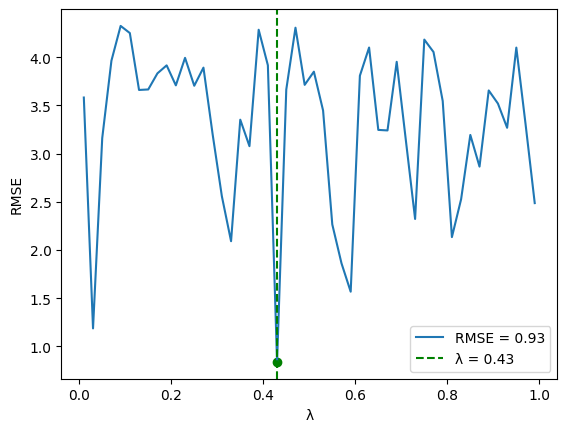

In [37]:
plot_lists(rmse, lammda_list)

In [38]:
l2_reg_factor = 0.43


class Transfer_FEDA_NN(Model):
    def __init__(self):
        super(Transfer_FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

# Create the model
Tmodel = Transfer_FEDA_NN()

Tmodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'],
             )

checkpoint_save_path = "./checkpoint/target_weights.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model
Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])

# Print model summary
Tmodel.summary()


Epoch 1/900
1/1 [==============================] - 0s 277ms/step - loss: 1996.7675 - mse: 1878.9016 - val_loss: 1483.0569 - val_mse: 1365.2690
Epoch 2/900
1/1 [==============================] - 0s 16ms/step - loss: 1995.2004 - mse: 1877.4126 - val_loss: 1481.7476 - val_mse: 1364.0376
Epoch 3/900
1/1 [==============================] - 0s 17ms/step - loss: 1993.6379 - mse: 1875.9280 - val_loss: 1480.4417 - val_mse: 1362.8099
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1992.0795 - mse: 1874.4478 - val_loss: 1479.1406 - val_mse: 1361.5864
Epoch 5/900
1/1 [==============================] - 0s 16ms/step - loss: 1990.5262 - mse: 1872.9720 - val_loss: 1477.8427 - val_mse: 1360.3663
Epoch 6/900
1/1 [==============================] - 0s 16ms/step - loss: 1988.9771 - mse: 1871.5007 - val_loss: 1476.5493 - val_mse: 1359.1504
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1987.4331 - mse: 1870.0342 - val_loss: 1475.2596 - val_mse: 1357.9384
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1914.6481 - mse: 1800.7717 - val_loss: 1414.5320 - val_mse: 1300.7155
Epoch 59/900
1/1 [==============================] - 0s 16ms/step - loss: 1913.3085 - mse: 1799.4919 - val_loss: 1413.4146 - val_mse: 1299.6575
Epoch 60/900
1/1 [==============================] - 0s 15ms/step - loss: 1911.9712 - mse: 1798.2141 - val_loss: 1412.2986 - val_mse: 1298.6010
Epoch 61/900
1/1 [==============================] - 0s 15ms/step - loss: 1910.6360 - mse: 1796.9384 - val_loss: 1411.1846 - val_mse: 1297.5460
Epoch 62/900
1/1 [==============================] - 0s 16ms/step - loss: 1909.3029 - mse: 1795.6643 - val_loss: 1410.0721 - val_mse: 1296.4926
Epoch 63/900
1/1 [==============================] - 0s 16ms/step - loss: 1907.9717 - mse: 1794.3921 - val_loss: 1408.9613 - val_mse: 1295.4406
Epoch 64/900
1/1 [==============================] - 0s 15ms/step - loss: 1906.6426 - mse: 1793.1218 - val_loss: 1407.8523 - val_mse: 1294.3899
Epoch 65/900

1/1 [==============================] - 0s 15ms/step - loss: 1840.2142 - mse: 1729.5161 - val_loss: 1352.3512 - val_mse: 1241.7042
Epoch 116/900
1/1 [==============================] - 0s 15ms/step - loss: 1838.9144 - mse: 1728.2675 - val_loss: 1351.2639 - val_mse: 1240.6680
Epoch 117/900
1/1 [==============================] - 0s 15ms/step - loss: 1837.6138 - mse: 1727.0178 - val_loss: 1350.1760 - val_mse: 1239.6306
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1836.3124 - mse: 1725.7670 - val_loss: 1349.0872 - val_mse: 1238.5924
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1835.0099 - mse: 1724.5151 - val_loss: 1347.9978 - val_mse: 1237.5532
Epoch 120/900
1/1 [==============================] - 0s 16ms/step - loss: 1833.7064 - mse: 1723.2618 - val_loss: 1346.9077 - val_mse: 1236.5132
Epoch 121/900
1/1 [==============================] - 0s 15ms/step - loss: 1832.4023 - mse: 1722.0078 - val_loss: 1345.8168 - val_mse: 1235.4719
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1763.5071 - mse: 1655.2606 - val_loss: 1288.1843 - val_mse: 1179.9708
Epoch 173/900
1/1 [==============================] - 0s 14ms/step - loss: 1762.0876 - mse: 1653.8741 - val_loss: 1286.9976 - val_mse: 1178.8164
Epoch 174/900
1/1 [==============================] - 0s 17ms/step - loss: 1760.6650 - mse: 1652.4839 - val_loss: 1285.8076 - val_mse: 1177.6589
Epoch 175/900
1/1 [==============================] - 0s 15ms/step - loss: 1759.2383 - mse: 1651.0896 - val_loss: 1284.6147 - val_mse: 1176.4978
Epoch 176/900
1/1 [==============================] - 0s 16ms/step - loss: 1757.8083 - mse: 1649.6914 - val_loss: 1283.4193 - val_mse: 1175.3336
Epoch 177/900
1/1 [==============================] - 0s 15ms/step - loss: 1756.3746 - mse: 1648.2891 - val_loss: 1282.2205 - val_mse: 1174.1658
Epoch 178/900
1/1 [==============================] - 0s 15ms/step - loss: 1754.9371 - mse: 1646.8824 - val_loss: 1281.0187 - val_mse: 11

Epoch 229/900
1/1 [==============================] - 0s 15ms/step - loss: 1675.5162 - mse: 1568.4829 - val_loss: 1214.7045 - val_mse: 1107.6799
Epoch 230/900
1/1 [==============================] - 0s 16ms/step - loss: 1673.8158 - mse: 1566.7913 - val_loss: 1213.2871 - val_mse: 1106.2709
Epoch 231/900
1/1 [==============================] - 0s 15ms/step - loss: 1672.1093 - mse: 1565.0930 - val_loss: 1211.8649 - val_mse: 1104.8563
Epoch 232/900
1/1 [==============================] - 0s 16ms/step - loss: 1670.3967 - mse: 1563.3882 - val_loss: 1210.4376 - val_mse: 1103.4364
Epoch 233/900
1/1 [==============================] - 0s 15ms/step - loss: 1668.6772 - mse: 1561.6760 - val_loss: 1209.0049 - val_mse: 1102.0106
Epoch 234/900
1/1 [==============================] - 0s 15ms/step - loss: 1666.9515 - mse: 1559.9573 - val_loss: 1207.5670 - val_mse: 1100.5791
Epoch 235/900
1/1 [==============================] - 0s 14ms/step - loss: 1665.2192 - mse: 1558.2313 - val_loss: 1206.1238 - val_mse: 10

Epoch 286/900
1/1 [==============================] - 0s 16ms/step - loss: 1567.3076 - mse: 1460.0557 - val_loss: 1124.7966 - val_mse: 1017.5280
Epoch 287/900
1/1 [==============================] - 0s 16ms/step - loss: 1565.1844 - mse: 1457.9158 - val_loss: 1123.0388 - val_mse: 1015.7531
Epoch 288/900
1/1 [==============================] - 0s 15ms/step - loss: 1563.0527 - mse: 1455.7670 - val_loss: 1121.2748 - val_mse: 1013.9713
Epoch 289/900
1/1 [==============================] - 0s 15ms/step - loss: 1560.9128 - mse: 1453.6094 - val_loss: 1119.5035 - val_mse: 1012.1823
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1558.7644 - mse: 1451.4431 - val_loss: 1117.7258 - val_mse: 1010.3862
Epoch 291/900
1/1 [==============================] - 0s 16ms/step - loss: 1556.6074 - mse: 1449.2678 - val_loss: 1115.9414 - val_mse: 1008.5830
Epoch 292/900
1/1 [==============================] - 0s 15ms/step - loss: 1554.4421 - mse: 1447.0837 - val_loss: 1114.1503 - val_mse: 10

1/1 [==============================] - 0s 19ms/step - loss: 1432.4497 - mse: 1323.5920 - val_loss: 1013.7197 - val_mse: 904.8228
Epoch 344/900
1/1 [==============================] - 0s 17ms/step - loss: 1429.8269 - mse: 1320.9299 - val_loss: 1011.5716 - val_mse: 902.6350
Epoch 345/900
1/1 [==============================] - 0s 16ms/step - loss: 1427.1954 - mse: 1318.2588 - val_loss: 1009.4165 - val_mse: 900.4399
Epoch 346/900
1/1 [==============================] - 0s 15ms/step - loss: 1424.5547 - mse: 1315.5781 - val_loss: 1007.2545 - val_mse: 898.2375
Epoch 347/900
1/1 [==============================] - 0s 15ms/step - loss: 1421.9054 - mse: 1312.8884 - val_loss: 1005.0860 - val_mse: 896.0283
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1419.2472 - mse: 1310.1895 - val_loss: 1002.9106 - val_mse: 893.8119
Epoch 349/900
1/1 [==============================] - 0s 16ms/step - loss: 1416.5801 - mse: 1307.4812 - val_loss: 1000.7286 - val_mse: 891.5884
Epoch 350/900

Epoch 401/900
1/1 [==============================] - 0s 15ms/step - loss: 1266.1512 - mse: 1154.4847 - val_loss: 878.5167 - val_mse: 766.7935
Epoch 402/900
1/1 [==============================] - 0s 16ms/step - loss: 1263.0457 - mse: 1151.3223 - val_loss: 876.0128 - val_mse: 764.2324
Epoch 403/900
1/1 [==============================] - 0s 15ms/step - loss: 1259.9327 - mse: 1148.1522 - val_loss: 873.5035 - val_mse: 761.6658
Epoch 404/900
1/1 [==============================] - 0s 16ms/step - loss: 1256.8125 - mse: 1144.9747 - val_loss: 870.9892 - val_mse: 759.0938
Epoch 405/900
1/1 [==============================] - 0s 15ms/step - loss: 1253.6849 - mse: 1141.7894 - val_loss: 868.4699 - val_mse: 756.5167
Epoch 406/900
1/1 [==============================] - 0s 15ms/step - loss: 1250.5500 - mse: 1138.5968 - val_loss: 865.9455 - val_mse: 753.9342
Epoch 407/900
1/1 [==============================] - 0s 15ms/step - loss: 1247.4083 - mse: 1135.3967 - val_loss: 863.4163 - val_mse: 751.3466
Epoch 

Epoch 459/900
1/1 [==============================] - 0s 16ms/step - loss: 1075.4851 - mse: 960.1484 - val_loss: 726.4091 - val_mse: 611.0031
Epoch 460/900
1/1 [==============================] - 0s 15ms/step - loss: 1072.0444 - mse: 956.6385 - val_loss: 723.6975 - val_mse: 608.2223
Epoch 461/900
1/1 [==============================] - 0s 15ms/step - loss: 1068.6003 - mse: 953.1250 - val_loss: 720.9843 - val_mse: 605.4394
Epoch 462/900
1/1 [==============================] - 0s 15ms/step - loss: 1065.1523 - mse: 949.6074 - val_loss: 718.2693 - val_mse: 602.6548
Epoch 463/900
1/1 [==============================] - 0s 15ms/step - loss: 1061.7002 - mse: 946.0858 - val_loss: 715.5529 - val_mse: 599.8685
Epoch 464/900
1/1 [==============================] - 0s 14ms/step - loss: 1058.2451 - mse: 942.5607 - val_loss: 712.8349 - val_mse: 597.0805
Epoch 465/900
1/1 [==============================] - 0s 14ms/step - loss: 1054.7860 - mse: 939.0317 - val_loss: 710.1154 - val_mse: 594.2908
Epoch 466/900

1/1 [==============================] - 0s 15ms/step - loss: 872.1680 - mse: 752.5660 - val_loss: 568.6465 - val_mse: 448.9672
Epoch 518/900
1/1 [==============================] - 0s 16ms/step - loss: 868.6448 - mse: 748.9655 - val_loss: 565.9630 - val_mse: 446.2061
Epoch 519/900
1/1 [==============================] - 0s 15ms/step - loss: 865.1230 - mse: 745.3662 - val_loss: 563.2822 - val_mse: 443.4478
Epoch 520/900
1/1 [==============================] - 0s 16ms/step - loss: 861.6025 - mse: 741.7682 - val_loss: 560.6043 - val_mse: 440.6923
Epoch 521/900
1/1 [==============================] - 0s 15ms/step - loss: 858.0835 - mse: 738.1715 - val_loss: 557.9296 - val_mse: 437.9398
Epoch 522/900
1/1 [==============================] - 0s 15ms/step - loss: 854.5659 - mse: 734.5762 - val_loss: 555.2579 - val_mse: 435.1902
Epoch 523/900
1/1 [==============================] - 0s 15ms/step - loss: 851.0500 - mse: 730.9824 - val_loss: 552.5895 - val_mse: 432.4438
Epoch 524/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 672.8130 - mse: 548.5920 - val_loss: 420.3174 - val_mse: 296.0152
Epoch 576/900
1/1 [==============================] - 0s 16ms/step - loss: 669.5191 - mse: 545.2170 - val_loss: 417.9372 - val_mse: 293.5539
Epoch 577/900
1/1 [==============================] - 0s 17ms/step - loss: 666.2319 - mse: 541.8486 - val_loss: 415.5645 - val_mse: 291.1000
Epoch 578/900
1/1 [==============================] - 0s 15ms/step - loss: 662.9514 - mse: 538.4869 - val_loss: 413.1996 - val_mse: 288.6538
Epoch 579/900
1/1 [==============================] - 0s 15ms/step - loss: 659.6779 - mse: 535.1321 - val_loss: 410.8423 - val_mse: 286.2153
Epoch 580/900
1/1 [==============================] - 0s 16ms/step - loss: 656.4114 - mse: 531.7843 - val_loss: 408.4928 - val_mse: 283.7845
Epoch 581/900
1/1 [==============================] - 0s 15ms/step - loss: 653.1519 - mse: 528.4435 - val_loss: 406.1514 - val_mse: 281.3618
Epoch 582/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 495.4930 - mse: 366.5783 - val_loss: 296.8655 - val_mse: 167.8712
Epoch 634/900
1/1 [==============================] - 0s 16ms/step - loss: 492.7250 - mse: 363.7307 - val_loss: 295.0311 - val_mse: 165.9572
Epoch 635/900
1/1 [==============================] - 0s 15ms/step - loss: 489.9683 - mse: 360.8943 - val_loss: 293.2077 - val_mse: 164.0542
Epoch 636/900
1/1 [==============================] - 0s 16ms/step - loss: 487.2228 - mse: 358.0693 - val_loss: 291.3954 - val_mse: 162.1625
Epoch 637/900
1/1 [==============================] - 0s 15ms/step - loss: 484.4886 - mse: 355.2556 - val_loss: 289.5940 - val_mse: 160.2817
Epoch 638/900
1/1 [==============================] - 0s 15ms/step - loss: 481.7657 - mse: 352.4534 - val_loss: 287.8037 - val_mse: 158.4121
Epoch 639/900
1/1 [==============================] - 0s 15ms/step - loss: 479.0542 - mse: 349.6626 - val_loss: 286.0246 - val_mse: 156.5537
Epoch 640/900
1/1 [===============

Epoch 692/900
1/1 [==============================] - 0s 16ms/step - loss: 352.8246 - mse: 219.3983 - val_loss: 208.2062 - val_mse: 74.7078
Epoch 693/900
1/1 [==============================] - 0s 15ms/step - loss: 350.7880 - mse: 217.2896 - val_loss: 207.0536 - val_mse: 73.4833
Epoch 694/900
1/1 [==============================] - 0s 16ms/step - loss: 348.7644 - mse: 215.1941 - val_loss: 205.9129 - val_mse: 72.2708
Epoch 695/900
1/1 [==============================] - 0s 15ms/step - loss: 346.7540 - mse: 213.1120 - val_loss: 204.7837 - val_mse: 71.0701
Epoch 696/900
1/1 [==============================] - 0s 16ms/step - loss: 344.7567 - mse: 211.0431 - val_loss: 203.6661 - val_mse: 69.8812
Epoch 697/900
1/1 [==============================] - 0s 15ms/step - loss: 342.7724 - mse: 208.9875 - val_loss: 202.5601 - val_mse: 68.7040
Epoch 698/900
1/1 [==============================] - 0s 16ms/step - loss: 340.8014 - mse: 206.9453 - val_loss: 201.4656 - val_mse: 67.5385
Epoch 699/900
1/1 [========

Epoch 751/900
1/1 [==============================] - 0s 15ms/step - loss: 254.7748 - mse: 117.4581 - val_loss: 159.1928 - val_mse: 21.8174
Epoch 752/900
1/1 [==============================] - 0s 15ms/step - loss: 253.4874 - mse: 116.1119 - val_loss: 158.6711 - val_mse: 21.2373
Epoch 753/900
1/1 [==============================] - 0s 14ms/step - loss: 252.2117 - mse: 114.7779 - val_loss: 158.1588 - val_mse: 20.6667
Epoch 754/900
1/1 [==============================] - 0s 15ms/step - loss: 250.9478 - mse: 113.4558 - val_loss: 157.6555 - val_mse: 20.1055
Epoch 755/900
1/1 [==============================] - 0s 15ms/step - loss: 249.6956 - mse: 112.1457 - val_loss: 157.1614 - val_mse: 19.5538
Epoch 756/900
1/1 [==============================] - 0s 14ms/step - loss: 248.4550 - mse: 110.8474 - val_loss: 156.6765 - val_mse: 19.0115
Epoch 757/900
1/1 [==============================] - 0s 14ms/step - loss: 247.2260 - mse: 109.5610 - val_loss: 156.2005 - val_mse: 18.4784
Epoch 758/900
1/1 [========

1/1 [==============================] - 0s 15ms/step - loss: 197.1937 - mse: 56.8995 - val_loss: 142.1288 - val_mse: 1.7930
Epoch 811/900
1/1 [==============================] - 0s 15ms/step - loss: 196.5044 - mse: 56.1686 - val_loss: 142.0393 - val_mse: 1.6624
Epoch 812/900
1/1 [==============================] - 0s 14ms/step - loss: 195.8232 - mse: 55.4462 - val_loss: 141.9551 - val_mse: 1.5372
Epoch 813/900
1/1 [==============================] - 0s 14ms/step - loss: 195.1503 - mse: 54.7324 - val_loss: 141.8760 - val_mse: 1.4175
Epoch 814/900
1/1 [==============================] - 0s 14ms/step - loss: 194.4855 - mse: 54.0271 - val_loss: 141.8020 - val_mse: 1.3032
Epoch 815/900
1/1 [==============================] - 0s 15ms/step - loss: 193.8287 - mse: 53.3300 - val_loss: 141.7330 - val_mse: 1.1943
Epoch 816/900
1/1 [==============================] - 0s 15ms/step - loss: 193.1799 - mse: 52.6412 - val_loss: 141.6690 - val_mse: 1.0906
Epoch 817/900
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 168.1610 - mse: 25.9167 - val_loss: 143.7518 - val_mse: 1.4842
Epoch 871/900
1/1 [==============================] - 0s 10ms/step - loss: 167.8508 - mse: 25.5832 - val_loss: 143.8622 - val_mse: 1.5716
Epoch 872/900
1/1 [==============================] - 0s 9ms/step - loss: 167.5451 - mse: 25.2544 - val_loss: 143.9743 - val_mse: 1.6608
Epoch 873/900
1/1 [==============================] - 0s 9ms/step - loss: 167.2438 - mse: 24.9303 - val_loss: 144.0878 - val_mse: 1.7519
Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 166.9469 - mse: 24.6109 - val_loss: 144.2029 - val_mse: 1.8448
Epoch 875/900
1/1 [==============================] - 0s 9ms/step - loss: 166.6542 - mse: 24.2961 - val_loss: 144.3195 - val_mse: 1.9394
Epoch 876/900
1/1 [==============================] - 0s 9ms/step - loss: 166.3659 - mse: 23.9858 - val_loss: 144.4375 - val_mse: 2.0358
Epoch 877/900
1/1 [==============================] - 0s 10m

In [39]:
checkpoint_save_path = "./checkpoint/target_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[ 0.22435085, -0.14124066,  0.9909488 , -0.29195547],
       [ 0.7286262 ,  0.41474733,  0.58571386,  0.12389772],
       [ 1.7311887 , -0.15217483,  2.4938421 , -0.81770074]],
      dtype=float32), array([-0.6554152 , -0.9181899 ,  0.9826852 , -0.94903314], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.1389527 , -0.17017303,  1.083512  ],
       [ 1.7268941 ,  1.1775359 ,  0.40052965],
       [-1.4438537 , -1.5564573 , -1.0610191 ],
       [ 1.7552183 ,  2.0382984 ,  1.3305373 ]], dtype=float32), array([-0.70605385, -0.8646061 , -0.71789634], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[-2.4121685],
       [-1.5541458],
       [-1.8871986]], dtype=float32), array([0.6327562], dtype=float32)]
--------------------------------------------------


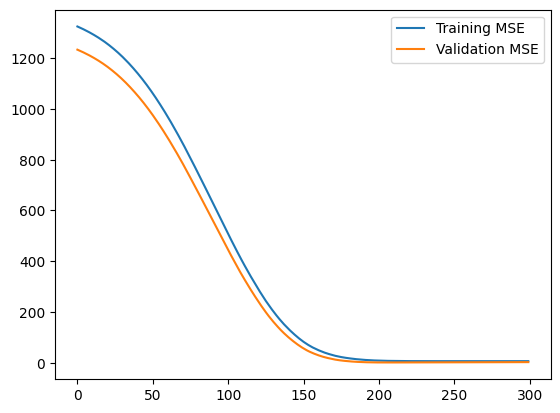

In [40]:
from matplotlib import pyplot as plt

mse_base = history.history['mse']
val_mse_base = history.history['val_mse']
loss_base = history.history['loss']
val_loss_base =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_base,label='Training MSE')
plt.plot(val_mse_base,label='Validation MSE')
plt.legend()
plt.savefig('bestlammda_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('bestlammda_loss.svg',bbox_inches = 'tight',dpi=600)

In [41]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Tmodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 30ms/step
[[38.142227]
 [37.924618]]
Root Mean Squared Error: 1.9482137207214563
